In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [2]:
import os
import sys
import warnings
import numpy
import ccxt
import pandas as pd
import numpy as np
from time import time
import math
import cProfile as cp

from gym.spaces import Space, Box

config = './neat.config'

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.abspath('')+"\\tensortrade")


In [3]:
!pip install ..\forks\tensortrade_source -U


Processing c:\users\codeninja\dev\forks\tensortrade_source
  Created wheel for tensortrade: filename=tensortrade-0.0.2rc0-cp37-none-any.whl size=55835 sha256=dff5956e531a179c6f711d54ff23d3833bf08ee7669074051a44bd2006f60dd1
  Stored in directory: C:\Users\CODENI~1\AppData\Local\Temp\pip-ephem-wheel-cache-zfm41l3t\wheels\62\be\3a\90782c795f0ba93fec4a55c551ac7e8f7e7ea933797e4f71c0
Successfully built tensortrade
  Found existing installation: tensortrade 0.0.2rc0
    Uninstalling tensortrade-0.0.2rc0:
      Successfully uninstalled tensortrade-0.0.2rc0


**Import dataframe**

In [18]:

data_file ='./data/processed/binance/btc_usdt_1h.csv' 
df = pd.read_csv(data_file, index_col=[0])


# number of days we want to pull from the dataframe 
days_of_data = 365

# number of data frames (our DF is in 1h timesteps)
frames = days_of_data * 24 * 5
# frames = len(df)
train_test_percentage = 0.4

x_train = int(frames * (1 - train_test_percentage))
x_test = int(frames - x_train)

df_train = df[-frames:(-x_test - 1)]
df_test = df[-x_test:]
print("Friend Shape", df.shape)
print('train shape', df_train.shape)
print('test shape', df_test.shape)
print('columns', df.columns)

Friend Shape (180236, 12)
train shape (26279, 12)
test shape (17520, 12)
columns Index(['open', 'high', 'low', 'close', 'volume', 'momentum_rsi', 'adx',
       'adx_long', 'adx_pos', 'adx_neg', 'trend_ema_fast', 'trend_ema_slow'],
      dtype='object')


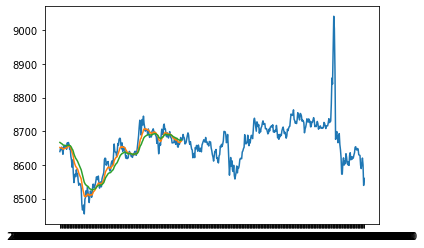

In [19]:
import matplotlib.pyplot as plt

# plt.subplot(221)
plt.plot(df_train[:500]['close'])
plt.plot(df_train[:200]['trend_ema_fast'])
plt.plot(df_train[:200]['trend_ema_slow'])

# plt.subplot(222)
# plt.plot(df_test[:200]['close'])
# plt.plot(df_test[:200]['trend_ema_fast'])
# plt.plot(df_test[:200]['trend_ema_slow'])

plt.show()

In [ ]:
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy
from neat_reward_strategy import NeatRewardStrategy as ProfitStrategy
from tensortrade.actions import DiscreteActionStrategy as ActionStrategy
from tensortrade.exchanges.simulated import SimulatedExchange as Exchange
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline
from tensortrade.environments import TradingEnvironment as Environment

print('fin imports')
normalize = MinMaxNormalizer(inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize])

reward_strategy = ProfitStrategy()
action_strategy = ActionStrategy(n_actions=20, instrument_symbol='BTC/USDT')
print('fin strats')

exchange = Exchange(data_frame=df_train,
                    pretransform = True,
                    base_instrument='USDT', 
                    commission_percent=0.75,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4,
                    observation_columns = df_train.columns
                   )
exchange.transform_data_frame()
print('fin exchange')

environment = Environment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)
print('fin environment')

strategy = TradingStrategy(environment=environment, 
                           neat_config=config, 
                           watch_genome_evaluation=True,
                           only_show_profitable=False,
                           learn_to_trade_theshold=-10000,
                           data_frame_window = 2000
                          )

print("Running through ", exchange.data_frame.shape[0], ' steps')
# cp.run("performance, winner, stats = strategy.run(generations=20)", 'evolution_stats')
performance, winner, stats = strategy.run(generations=20)

fin imports
fin strats
fin exchange
fin environment
Running through  26279  steps

 ****** Running generation 0 ****** 

---------------------------
[8.63471000e-03 8.64000000e-03 8.62001000e-03 8.63949000e-03
 8.14186790e-05 3.90707378e-05 3.01041005e-05 8.12457479e-06
 1.01540737e-05 2.87578194e-05 8.65153425e-03 8.66654217e-03]
[8.63967000e-03 8.65010000e-03 8.63627000e-03 8.64880000e-03
 6.41651470e-05 4.64177318e-05 3.13688018e-05 8.30474798e-06
 1.30742096e-05 2.74222173e-05 8.65111360e-03 8.66522792e-03]
[8.64880000e-03 8.66200000e-03 8.64130000e-03 8.64513000e-03
 6.76340560e-05 4.40042570e-05 3.16589090e-05 8.44282461e-06
 1.61674869e-05 2.55123448e-05 8.65019304e-03 8.66373918e-03]
[8.64847000e-03 8.66144000e-03 8.64576000e-03 8.65267000e-03
 7.45344780e-05 5.01487754e-05 3.09990279e-05 8.53374224e-06
 1.52653413e-05 2.40887563e-05 8.65057411e-03 8.66291923e-03]
[8.65045000e-03 8.66000000e-03 8.64154000e-03 8.64393000e-03
 7.53413070e-05 4.37306683e-05 3.03862811e-05 8.623144

 1.34788767e-05 2.93861525e-05 8.50835640e-03 8.54008044e-03]
[8.52238000e-03 8.52497000e-03 8.48824000e-03 8.50651000e-03
 1.87475520e-04 4.75786659e-05 5.73720393e-05 1.97945013e-05
 1.25491018e-05 2.86436658e-05 8.50807234e-03 8.53759373e-03]
[8.50812000e-03 8.53508000e-03 8.50636000e-03 8.53329000e-03
 1.44083040e-04 5.75605675e-05 5.60648459e-05 2.00842378e-05
 1.37926827e-05 2.70712049e-05 8.51195198e-03 8.53727493e-03]
[8.53220000e-03 8.53678000e-03 8.51429000e-03 8.52003000e-03
 1.65953026e-04 5.19129908e-05 5.43812506e-05 2.03340831e-05
 1.35168555e-05 2.58733779e-05 8.51319475e-03 8.53599752e-03]
[8.52250000e-03 8.53529000e-03 8.50100000e-03 8.50891000e-03
 1.57807917e-04 4.74117501e-05 5.27375546e-05 2.05738760e-05
 1.26013394e-05 2.67460484e-05 8.51253556e-03 8.53399103e-03]
[8.51057000e-03 8.51384000e-03 8.46000000e-03 8.48809000e-03
 4.56695872e-04 3.99317969e-05 5.15383204e-05 2.08318349e-05
 1.13064336e-05 3.18229275e-05 8.50877470e-03 8.53059094e-03]
[8.48766000e-03 8.

 2.66582760e-05 1.72581560e-05 8.60278970e-03 8.58823092e-03]
[8.63464000e-03 8.66600000e-03 8.62677000e-03 8.66200000e-03
 3.07628665e-04 7.83460310e-05 1.74271239e-05 2.08401444e-05
 3.13005336e-05 1.52384985e-05 8.61189898e-03 8.59369529e-03]
[8.66474000e-03 8.66667000e-03 8.63571000e-03 8.63997000e-03
 2.24062199e-04 6.34575007e-05 1.86475463e-05 2.05677971e-05
 2.86647626e-05 1.38599781e-05 8.61621760e-03 8.59712304e-03]
[8.63998000e-03 8.64000000e-03 8.61830000e-03 8.63793000e-03
 1.62642056e-04 6.21946517e-05 1.98023300e-05 2.02981174e-05
 2.68325478e-05 1.81022910e-05 8.61955797e-03 8.60014577e-03]
[8.63770000e-03 8.64192000e-03 8.62916000e-03 8.63739000e-03
 7.77848620e-05 6.18188997e-05 1.97756423e-05 2.00769324e-05
 2.63740679e-05 1.73980766e-05 8.62230136e-03 8.60290459e-03]
[8.63406000e-03 8.64913000e-03 8.62500000e-03 8.62500000e-03
 7.91775530e-05 5.32946310e-05 1.98278229e-05 1.98539272e-05
 2.66314222e-05 1.61208971e-05 8.62271653e-03 8.60454128e-03]
[8.62500000e-03 8.

 3.14468932e-05 1.31169967e-05 8.67848964e-03 8.65931489e-03]
[8.68865000e-03 8.73000000e-03 8.68642000e-03 8.71724000e-03
 1.77376605e-04 6.65303813e-05 2.57076622e-05 1.31258973e-05
 3.09238041e-05 1.15632985e-05 8.68445123e-03 8.66360563e-03]
[8.72177000e-03 8.74000000e-03 8.70647000e-03 8.73500000e-03
 2.94215675e-04 7.11041343e-05 2.71262546e-05 1.30992165e-05
 3.08255152e-05 1.05298574e-05 8.69222797e-03 8.66889410e-03]
[8.73500000e-03 8.75000000e-03 8.71300000e-03 8.71836000e-03
 2.67070448e-04 6.19517581e-05 2.86941097e-05 1.30976980e-05
 3.04608192e-05 9.51887736e-06 8.69624828e-03 8.67255823e-03]
[8.71852000e-03 8.74900000e-03 8.71496000e-03 8.74473000e-03
 1.66235655e-04 6.92008342e-05 3.03860618e-05 1.31205059e-05
 2.78149361e-05 8.69205000e-06 8.70370700e-03 8.67790428e-03]
[8.74690000e-03 8.75000000e-03 8.72204000e-03 8.72316000e-03
 2.73187628e-04 5.86537629e-05 3.19571602e-05 1.31429336e-05
 2.60854544e-05 8.07184637e-06 8.70669977e-03 8.68125655e-03]
[8.72316000e-03 8.

 1.46182760e-05 1.84455778e-05 8.69066378e-03 8.68924554e-03]
[8.67980000e-03 8.69064000e-03 8.67837000e-03 8.68980000e-03
 5.05938630e-05 4.95334512e-05 1.48250918e-05 8.70163552e-06
 1.40434829e-05 1.77202945e-05 8.69053089e-03 8.68928661e-03]
[8.68706000e-03 8.70376000e-03 8.68606000e-03 8.69878000e-03
 7.53280320e-05 5.53201216e-05 1.45929770e-05 8.56966083e-06
 1.75021972e-05 1.67001778e-05 8.69179998e-03 8.68998981e-03]
[8.69879000e-03 8.70021000e-03 8.68160000e-03 8.68665000e-03
 4.09326080e-05 4.69326247e-05 1.37181159e-05 8.45586641e-06
 1.64311591e-05 1.71447821e-05 8.69100768e-03 8.68974241e-03]
[8.68665000e-03 8.68867000e-03 8.67534000e-03 8.68089000e-03
 5.22326980e-05 4.33328441e-05 1.28900647e-05 8.32940716e-06
 1.56905012e-05 1.84888238e-05 8.68945111e-03 8.68908667e-03]
[8.67973000e-03 8.68605000e-03 8.67032000e-03 8.67851000e-03
 5.14280420e-05 4.18041420e-05 1.25541442e-05 8.19646844e-06
 1.48403858e-05 1.92161784e-05 8.68776786e-03 8.68830321e-03]
[8.68074000e-03 8.

 1.57470403e-05 2.50418248e-05 8.64638334e-03 8.65667026e-03]
[8.64686000e-03 8.67048000e-03 8.64334000e-03 8.65773000e-03
 9.34511140e-05 5.54897073e-05 2.42533679e-05 7.17632499e-06
 1.94743863e-05 2.27752017e-05 8.64812898e-03 8.65674875e-03]
[8.65753000e-03 8.66649000e-03 8.65017000e-03 8.65453000e-03
 5.40402830e-05 5.32054260e-05 2.30790314e-05 7.18391633e-06
 1.83960999e-05 2.15141510e-05 8.64911375e-03 8.65658439e-03]
[8.65437000e-03 8.65634000e-03 8.64000000e-03 8.64066000e-03
 4.44139810e-05 4.41217042e-05 2.19885759e-05 7.19138115e-06
 1.73596961e-05 2.38085678e-05 8.64781318e-03 8.65540480e-03]
[8.64279000e-03 8.66315000e-03 8.64000000e-03 8.65888000e-03
 4.59035170e-05 5.56091014e-05 2.15368681e-05 7.23016195e-06
 1.83140697e-05 2.19240204e-05 8.64951576e-03 8.65566221e-03]
[8.65888000e-03 8.65991000e-03 8.65055000e-03 8.65156000e-03
 5.75478350e-05 5.07706962e-05 2.06393400e-05 7.24325959e-06
 1.77038978e-05 2.11935753e-05 8.64983026e-03 8.65535834e-03]
[8.65369000e-03 8.

 2.24406247e-05 1.65471761e-05 8.64886196e-03 8.64590979e-03]
[8.67208000e-03 8.71400000e-03 8.67001000e-03 8.69937000e-03
 2.87230602e-04 7.86730125e-05 1.73781934e-05 8.21904114e-06
 3.17035041e-05 1.43522205e-05 8.65663243e-03 8.64986980e-03]
[8.69944000e-03 8.71871000e-03 8.69643000e-03 8.69900000e-03
 2.11968472e-04 7.83030294e-05 1.88279324e-05 8.15338996e-06
 3.09907871e-05 1.33838765e-05 8.66315051e-03 8.65350907e-03]
[8.70068000e-03 8.70889000e-03 8.68626000e-03 8.69823000e-03
 1.64395856e-04 7.74286602e-05 2.03172118e-05 8.10329477e-06
 2.88608182e-05 1.55527240e-05 8.66854736e-03 8.65682172e-03]
[8.69798000e-03 8.70200000e-03 8.68882000e-03 8.68914000e-03
 1.12832074e-04 6.72063787e-05 2.10062712e-05 8.01983193e-06
 2.76681061e-05 1.49099867e-05 8.67171546e-03 8.65921566e-03]
[8.68914000e-03 8.69146000e-03 8.66445000e-03 8.66586000e-03
 1.39856970e-04 4.83452741e-05 2.16461121e-05 7.93776013e-06
 2.53555422e-05 2.12050588e-05 8.67081462e-03 8.65970783e-03]
[8.66928000e-03 8.

 2.19942037e-05 1.13180596e-05 8.66380384e-03 8.64880793e-03]
[8.68054000e-03 8.69100000e-03 8.67729000e-03 8.68781000e-03
 1.16846979e-04 6.42757625e-05 2.75180436e-05 8.89123217e-06
 2.28498089e-05 1.08732260e-05 8.66749710e-03 8.65169696e-03]
[8.68777000e-03 8.69299000e-03 8.67693000e-03 8.68176000e-03
 1.45724268e-04 5.98168503e-05 2.80892221e-05 8.79699972e-06
 2.23557451e-05 1.03595839e-05 8.66969139e-03 8.65392385e-03]
[8.68258000e-03 8.68258000e-03 8.67314000e-03 8.67800000e-03
 7.54794270e-05 5.69821889e-05 2.87020145e-05 8.70993538e-06
 2.17066531e-05 1.12244898e-05 8.67096964e-03 8.65570726e-03]
[8.67794000e-03 8.70267000e-03 8.67703000e-03 8.70195000e-03
 2.49682310e-04 6.80945830e-05 2.89254810e-05 8.61279516e-06
 2.61409798e-05 1.03458442e-05 8.67573585e-03 8.65913264e-03]
[8.70195000e-03 8.75000000e-03 8.69879000e-03 8.73235000e-03
 5.60947579e-04 7.68521863e-05 2.99515158e-05 8.57351468e-06
 3.56927888e-05 8.85492694e-06 8.68444572e-03 8.66455614e-03]
[8.73235000e-03 8.

 1.36063408e-05 2.64766921e-05 8.70009081e-03 8.70236653e-03]
[8.68972000e-03 8.68998000e-03 8.66105000e-03 8.67605000e-03
 1.10807805e-04 3.47657629e-05 1.36755011e-05 6.77155185e-06
 1.22792016e-05 2.38942010e-05 8.69639222e-03 8.70041715e-03]
[8.67806000e-03 8.70000000e-03 8.67000000e-03 8.69025000e-03
 1.60861021e-04 4.56688658e-05 1.49921955e-05 6.73674489e-06
 1.43525371e-05 2.15486126e-05 8.69544726e-03 8.69966402e-03]
[8.69027000e-03 8.70035000e-03 8.67265000e-03 8.68327000e-03
 9.49450540e-05 4.17145023e-05 1.53530483e-05 6.66961490e-06
 1.31885178e-05 1.96322706e-05 8.69357384e-03 8.69844965e-03]
[8.68290000e-03 8.69500000e-03 8.67814000e-03 8.69040000e-03
 9.30116470e-05 4.71120343e-05 1.56587693e-05 6.60245776e-06
 1.24620669e-05 1.85508844e-05 8.69308556e-03 8.69785337e-03]
[8.68983000e-03 8.69622000e-03 8.68400000e-03 8.68725000e-03
 8.19226780e-05 4.49882857e-05 1.59426530e-05 6.53641991e-06
 1.23599014e-05 1.77861839e-05 8.69218778e-03 8.69706793e-03]
[8.68726000e-03 8.

 1.65883011e-05 2.86972192e-05 8.72374447e-03 8.72623900e-03]
[8.71225000e-03 8.72565000e-03 8.71001000e-03 8.72193000e-03
 2.79818531e-04 4.79449276e-05 1.90703393e-05 6.01101734e-06
 1.87120606e-05 2.70177543e-05 8.72346532e-03 8.72591980e-03]
[8.72193000e-03 8.73689000e-03 8.71693000e-03 8.73689000e-03
 8.72819860e-05 5.77118191e-05 1.90054960e-05 5.92894481e-06
 2.15112721e-05 2.50063906e-05 8.72553066e-03 8.72673240e-03]
[8.73688000e-03 8.74000000e-03 8.72359000e-03 8.72835000e-03
 1.13946498e-04 5.13639765e-05 1.81846412e-05 5.84943247e-06
 2.13530042e-05 2.34600571e-05 8.72596440e-03 8.72685222e-03]
[8.72706000e-03 8.73571000e-03 8.72084000e-03 8.72791000e-03
 8.38275060e-05 5.10302950e-05 1.72215862e-05 5.78147532e-06
 2.01377948e-05 2.31774143e-05 8.72626372e-03 8.72693056e-03]
[8.72792000e-03 8.73669000e-03 8.72597000e-03 8.73667000e-03
 8.01852960e-05 5.73893300e-05 1.64927187e-05 5.70523156e-06
 1.96725101e-05 2.21966859e-05 8.72786469e-03 8.72765200e-03]
[8.73667000e-03 8.

 4.93062477e-05 6.47995734e-06 8.79220775e-03 8.75779142e-03]
[8.94125000e-03 9.07426000e-03 8.93901000e-03 9.04153000e-03
 1.51761009e-03 9.26218476e-05 2.44956277e-05 5.38742405e-06
 6.14026293e-05 4.86199201e-06 8.83056502e-03 8.77880909e-03]
[9.04399000e-03 9.05596000e-03 8.96745000e-03 9.00500000e-03
 8.82496063e-04 8.12841565e-05 2.88406203e-05 6.05641474e-06
 5.22144859e-05 4.13445496e-06 8.85740117e-03 8.79556396e-03]
[9.00567000e-03 9.00864000e-03 8.87288000e-03 8.88215000e-03
 1.02279479e-03 5.51082718e-05 3.28752562e-05 6.71425558e-06
 4.18661982e-05 1.71207745e-05 8.86120868e-03 8.80197774e-03]
[8.87999000e-03 8.88000000e-03 8.62300000e-03 8.67588000e-03
 2.03126915e-03 3.39360757e-05 3.35234991e-05 7.06956713e-06
 2.97467849e-05 4.00771329e-05 8.83269658e-03 8.79263716e-03]
[8.67071000e-03 8.72632000e-03 8.64000000e-03 8.69125000e-03
 9.47848537e-04 3.60485207e-05 3.21857388e-05 7.00551268e-06
 2.69484671e-05 3.63070262e-05 8.81093556e-03 8.78512699e-03]
[8.69537000e-03 8.

 1.22598651e-05 3.12579524e-05 8.62957844e-03 8.63644235e-03]
[8.59902000e-03 8.61142000e-03 8.58213000e-03 8.58899000e-03
 1.13272782e-04 2.22785023e-05 2.12283948e-05 1.08413549e-05
 1.14171394e-05 2.91093254e-05 8.62333407e-03 8.63292736e-03]
[8.58490000e-03 8.60763000e-03 8.58481000e-03 8.60274000e-03
 9.29578570e-05 3.59533859e-05 2.28303580e-05 1.09965756e-05
 1.07945713e-05 2.75220156e-05 8.62016575e-03 8.63069125e-03]
[8.60322000e-03 8.62780000e-03 8.60309000e-03 8.62022000e-03
 8.15019880e-05 4.90921345e-05 2.43178952e-05 1.11492092e-05
 1.50166214e-05 2.58546951e-05 8.62017409e-03 8.62991559e-03]
[8.62021000e-03 8.62198000e-03 8.56523000e-03 8.60000000e-03
 3.11309705e-04 3.85396783e-05 2.44750136e-05 1.12526220e-05
 1.30836041e-05 3.11142718e-05 8.61707039e-03 8.62769962e-03]
[8.60000000e-03 8.60964000e-03 8.52772000e-03 8.53893000e-03
 4.23038675e-04 2.20340804e-05 2.56407500e-05 1.14129862e-05
 1.09019894e-05 3.35611258e-05 8.60504879e-03 8.62112408e-03]
[8.53892000e-03 8.

 1.42715682e-05 2.65587882e-05 8.25369844e-03 8.28667505e-03]
[8.26033000e-03 8.29571000e-03 8.25841000e-03 8.28801000e-03
 1.62677312e-04 6.06598560e-05 4.04927641e-05 2.46512148e-05
 1.80069539e-05 2.51515252e-05 8.25897714e-03 8.28677393e-03]
[8.28801000e-03 8.31500000e-03 8.27719000e-03 8.28839000e-03
 3.72092094e-04 6.07767125e-05 3.87828716e-05 2.47786000e-05
 1.97916571e-05 2.37917478e-05 8.26350220e-03 8.28689363e-03]
[8.28411000e-03 8.28992000e-03 8.27107000e-03 8.28539000e-03
 3.31126341e-04 5.91755170e-05 3.66682387e-05 2.48705838e-05
 1.92333817e-05 2.40364515e-05 8.26686955e-03 8.28678225e-03]
[8.28542000e-03 8.30000000e-03 8.27015000e-03 8.28489000e-03
 1.58156285e-04 5.88772185e-05 3.48419554e-05 2.49666641e-05
 1.99005084e-05 2.29332628e-05 8.26964193e-03 8.28664207e-03]
[8.28460000e-03 8.28974000e-03 8.26735000e-03 8.26997000e-03
 1.93627792e-04 5.01696515e-05 3.28589791e-05 2.50436129e-05
 1.91890849e-05 2.25604835e-05 8.26969240e-03 8.28540710e-03]
[8.26736000e-03 8.

 1.07778722e-05 3.28204475e-05 8.30088643e-03 8.31476459e-03]
[8.25707000e-03 8.29550000e-03 8.25501000e-03 8.28817000e-03
 1.47826078e-04 4.33666016e-05 2.12452040e-05 2.35341532e-05
 1.47092472e-05 2.97374828e-05 8.29893005e-03 8.31279461e-03]
[8.28785000e-03 8.29891000e-03 8.27540000e-03 8.27540000e-03
 9.01567860e-05 3.87807703e-05 2.21428172e-05 2.35566933e-05
 1.46978861e-05 2.80876892e-05 8.29531005e-03 8.31002464e-03]
[8.27663000e-03 8.28024000e-03 8.23342000e-03 8.23945000e-03
 1.53492390e-04 2.88656168e-05 2.27965540e-05 2.35714577e-05
 1.31350270e-05 3.46350803e-05 8.28671619e-03 8.30479688e-03]
[8.23684000e-03 8.25163000e-03 8.22000000e-03 8.23700000e-03
 1.63600591e-04 2.82967191e-05 2.43830383e-05 2.36396381e-05
 1.21918624e-05 3.51946585e-05 8.27906755e-03 8.29977488e-03]
[8.23823000e-03 8.24405000e-03 8.20000000e-03 8.23770000e-03
 2.54078280e-04 2.87595897e-05 2.61087432e-05 2.37231558e-05
 1.10065344e-05 3.61871379e-05 8.27270331e-03 8.29517673e-03]
[8.23770000e-03 8.

 2.77457584e-05 1.48358618e-05 8.27974646e-03 8.26306180e-03]
[8.30165000e-03 8.31560000e-03 8.30050000e-03 8.30910000e-03
 1.22107540e-04 6.91039273e-05 2.30546008e-05 2.42988337e-05
 2.92570712e-05 1.42481124e-05 8.28426239e-03 8.26647203e-03]
[8.30758000e-03 8.30909000e-03 8.27216000e-03 8.27500000e-03
 1.02646993e-04 4.74107780e-05 2.38720750e-05 2.40748379e-05
 2.64920434e-05 2.01521122e-05 8.28283741e-03 8.26710373e-03]
[8.27500000e-03 8.29068000e-03 8.26181000e-03 8.26866000e-03
 1.51102505e-04 4.44193738e-05 2.31377926e-05 2.39017604e-05
 2.45400487e-05 2.13087954e-05 8.28065627e-03 8.26721900e-03]
[8.26799000e-03 8.26976000e-03 8.24910000e-03 8.26554000e-03
 1.27289591e-04 4.28830017e-05 2.19884946e-05 2.37483375e-05
 2.32214267e-05 2.34694745e-05 8.27833069e-03 8.26709462e-03]
[8.26338000e-03 8.27160000e-03 8.26071000e-03 8.26914000e-03
 5.39488860e-05 4.53973947e-05 2.04558346e-05 2.36178734e-05
 2.30342068e-05 2.27747994e-05 8.27691674e-03 8.26724612e-03]
[8.27121000e-03 8.

 2.19918222e-05 1.36331069e-05 8.33407755e-03 8.32306224e-03]
[8.33777000e-03 8.34457000e-03 8.30659000e-03 8.31686000e-03
 1.95418432e-04 3.99899637e-05 1.88313622e-05 1.55465737e-05
 1.94746920e-05 2.06223542e-05 8.33142870e-03 8.32260281e-03]
[8.31847000e-03 8.32173000e-03 8.30144000e-03 8.30560000e-03
 1.06711005e-04 3.42924087e-05 1.76907085e-05 1.53801699e-05
 1.82715117e-05 2.09164110e-05 8.32745505e-03 8.32134334e-03]
[8.30256000e-03 8.31299000e-03 8.27900000e-03 8.30622000e-03
 1.92083807e-04 3.48818503e-05 1.69091772e-05 1.52280497e-05
 1.64392180e-05 2.54394054e-05 8.32418812e-03 8.32022308e-03]
[8.30536000e-03 8.30553000e-03 8.26734000e-03 8.27823000e-03
 1.89224956e-04 2.37730135e-05 1.72364591e-05 1.51275057e-05
 1.46317277e-05 2.59397110e-05 8.31711764e-03 8.31711248e-03]
[8.28054000e-03 8.28911000e-03 8.25500000e-03 8.26786000e-03
 1.59645674e-04 2.09243289e-05 1.79961249e-05 1.50533285e-05
 1.32548085e-05 2.69030982e-05 8.30953954e-03 8.31346414e-03]
[8.26848000e-03 8.

 2.48384285e-05 1.61164956e-05 8.39331115e-03 8.37517376e-03]
[8.40017000e-03 8.42400000e-03 8.38965000e-03 8.42201000e-03
 1.05338350e-04 6.18301238e-05 2.47660090e-05 1.18977908e-05
 2.46066054e-05 1.50398380e-05 8.39772636e-03 8.37864310e-03]
[8.42201000e-03 8.42972000e-03 8.40000000e-03 8.40804000e-03
 1.66763250e-04 5.50148410e-05 2.47205942e-05 1.18284498e-05
 2.42924980e-05 1.41585220e-05 8.39931307e-03 8.38082064e-03]
[8.40804000e-03 8.42200000e-03 8.40804000e-03 8.41867000e-03
 8.95371730e-05 5.89841943e-05 2.48373762e-05 1.17716468e-05
 2.35931462e-05 1.37509152e-05 8.40229106e-03 8.38362429e-03]
[8.41947000e-03 8.43900000e-03 8.41443000e-03 8.43001000e-03
 1.12655130e-04 6.30025634e-05 2.49458167e-05 1.17157906e-05
 2.59524798e-05 1.30393979e-05 8.40655551e-03 8.38706026e-03]
[8.43001000e-03 8.44212000e-03 8.42278000e-03 8.44071000e-03
 1.55779617e-04 6.65684960e-05 2.55294985e-05 1.16948189e-05
 2.55398476e-05 1.24914941e-05 8.41181005e-03 8.39103431e-03]
[8.44062000e-03 8.

 1.90403802e-05 1.56315680e-05 8.41780308e-03 8.40830146e-03]
[8.44280000e-03 8.44280000e-03 8.41000000e-03 8.42621000e-03
 1.04558547e-04 5.44979576e-05 1.13708304e-05 7.68127636e-06
 1.76876763e-05 1.67844826e-05 8.41909645e-03 8.40962801e-03]
[8.42622000e-03 8.43979000e-03 8.41836000e-03 8.41987000e-03
 6.93624610e-05 5.11596888e-05 1.07457758e-05 7.56560437e-06
 1.68456089e-05 1.59854140e-05 8.41921546e-03 8.41038667e-03]
[8.41986000e-03 8.43599000e-03 8.41003000e-03 8.41446000e-03
 7.83865930e-05 4.82496982e-05 1.01653680e-05 7.45186025e-06
 1.58605514e-05 1.69270125e-05 8.41848385e-03 8.41068839e-03]
[8.41615000e-03 8.47497000e-03 8.40763000e-03 8.44999000e-03
 2.51599567e-04 6.38370761e-05 9.67160154e-06 7.33376065e-06
 2.17615024e-05 1.45501906e-05 8.42333095e-03 8.41359962e-03]
[8.44999000e-03 8.47371000e-03 8.40801000e-03 8.42267000e-03
 1.41004416e-04 5.03750830e-05 1.03993067e-05 7.28854786e-06
 1.89637040e-05 1.26795247e-05 8.42322926e-03 8.41427149e-03]
[8.42056000e-03 8.

 2.19124589e-05 1.35088367e-05 8.51833144e-03 8.49579670e-03]
[8.53200000e-03 8.53300000e-03 8.50091000e-03 8.50386000e-03
 1.92305287e-04 4.45692833e-05 3.09145305e-05 8.34962582e-06
 2.00498346e-05 1.74517176e-05 8.51610506e-03 8.49639397e-03]
[8.50386000e-03 8.51187000e-03 8.47275000e-03 8.47669000e-03
 1.39478318e-04 3.42076410e-05 2.92012086e-05 8.38684077e-06
 1.80369825e-05 2.29263106e-05 8.51004121e-03 8.49493441e-03]
[8.47666000e-03 8.51120000e-03 8.47310000e-03 8.50821000e-03
 1.10873141e-04 4.98227291e-05 2.79679705e-05 8.34754841e-06
 1.63186898e-05 2.07422361e-05 8.50975948e-03 8.49591778e-03]
[8.50819000e-03 8.52495000e-03 8.50445000e-03 8.51722000e-03
 7.38524750e-05 5.34654896e-05 2.68228208e-05 8.30891093e-06
 1.89738212e-05 1.96571424e-05 8.51090725e-03 8.49749572e-03]
[8.51662000e-03 8.52251000e-03 8.50975000e-03 8.51267000e-03
 6.22468640e-05 5.12955972e-05 2.50332509e-05 8.30281844e-06
 1.83310155e-05 1.89911869e-05 8.51117845e-03 8.49861973e-03]
[8.50975000e-03 8.

 1.73886378e-05 1.95095535e-05 8.55675166e-03 8.54974233e-03]
[8.54925000e-03 8.56608000e-03 8.54016000e-03 8.56608000e-03
 4.90769330e-05 5.53811464e-05 1.76517380e-05 8.49517129e-06
 1.90409886e-05 1.80261637e-05 8.55818679e-03 8.55095252e-03]
[8.56457000e-03 8.57221000e-03 8.56134000e-03 8.56778000e-03
 6.92042410e-05 5.62963552e-05 1.65864567e-05 8.48227700e-06
 2.02810607e-05 1.74277140e-05 8.55966267e-03 8.55219899e-03]
[8.56655000e-03 8.57052000e-03 8.56127000e-03 8.56758000e-03
 5.56519410e-05 5.61400392e-05 1.59421952e-05 8.48532593e-06
 1.96822415e-05 1.69354868e-05 8.56088072e-03 8.55333832e-03]
[8.56683000e-03 8.57256000e-03 8.54431000e-03 8.54720000e-03
 1.11849665e-04 4.23228375e-05 1.53392641e-05 8.48810899e-06
 1.79400711e-05 2.07504682e-05 8.55877599e-03 8.55288362e-03]
[8.54511000e-03 8.55698000e-03 8.54331000e-03 8.54933000e-03
 5.59455470e-05 4.39853775e-05 1.47624440e-05 8.43936919e-06
 1.71490450e-05 2.01580750e-05 8.55732276e-03 8.55262038e-03]
[8.54762000e-03 8.

 1.29682342e-05 2.28636303e-05 8.53986130e-03 8.54452251e-03]
[8.52313000e-03 8.52710000e-03 8.51500000e-03 8.52166000e-03
 1.21307294e-04 3.45035323e-05 1.77009677e-05 5.48318815e-06
 1.23893177e-05 2.38977660e-05 8.53706110e-03 8.54282898e-03]
[8.52446000e-03 8.53492000e-03 8.52107000e-03 8.52217000e-03
 6.91189830e-05 3.51146127e-05 1.87019698e-05 5.49922478e-06
 1.46456421e-05 2.26743097e-05 8.53477016e-03 8.54129868e-03]
[8.52180000e-03 8.53459000e-03 8.52130000e-03 8.52554000e-03
 8.40458050e-05 3.94237515e-05 1.89027626e-05 5.48665801e-06
 1.39097561e-05 2.15350145e-05 8.53335014e-03 8.54013136e-03]
[8.52554000e-03 8.53500000e-03 8.51451000e-03 8.51710000e-03
 1.00000240e-04 3.30760353e-05 1.90892130e-05 5.47430070e-06
 1.28386711e-05 2.24284814e-05 8.53085011e-03 8.53842533e-03]
[8.51851000e-03 8.51871000e-03 8.44550000e-03 8.48731000e-03
 4.33988720e-04 1.99765176e-05 1.96679764e-05 5.48459731e-06
 9.90416294e-06 3.88475634e-05 8.52415164e-03 8.53463900e-03]
[8.48731000e-03 8.

 3.14749082e-05 1.42589862e-05 8.55279442e-03 8.54011938e-03]
[8.60473000e-03 8.62600000e-03 8.59900000e-03 8.61329000e-03
 2.77383768e-04 8.27236280e-05 1.70103244e-05 7.60016932e-06
 3.07234013e-05 1.31008657e-05 8.56210143e-03 8.54553942e-03]
[8.61518000e-03 8.62000000e-03 8.57468000e-03 8.58658000e-03
 3.98668168e-04 6.27539609e-05 1.86675739e-05 7.55271532e-06
 2.67901549e-05 1.82936579e-05 8.56586736e-03 8.54857946e-03]
[8.58947000e-03 8.60639000e-03 8.58164000e-03 8.58688000e-03
 1.19034434e-04 6.28701218e-05 1.86803187e-05 7.43184238e-06
 2.49142947e-05 1.70127268e-05 8.56910008e-03 8.55141653e-03]
[8.58561000e-03 8.58655000e-03 8.55465000e-03 8.56876000e-03
 1.96400248e-04 5.16449570e-05 1.86921532e-05 7.31298399e-06
 2.26865591e-05 2.29793756e-05 8.56904776e-03 8.55270122e-03]
[8.56876000e-03 8.58628000e-03 8.56123000e-03 8.56754000e-03
 9.33464170e-05 5.09384064e-05 1.74028004e-05 7.26385396e-06
 2.11068721e-05 2.13792995e-05 8.56881579e-03 8.55380038e-03]
[8.57076000e-03 8.

 1.46482996e-05 1.87684389e-05 8.54904081e-03 8.55354967e-03]
[8.54226000e-03 8.54442000e-03 8.53000000e-03 8.53360000e-03
 6.97335830e-05 3.64637946e-05 1.07285540e-05 5.66139105e-06
 1.38088925e-05 1.84916908e-05 8.54666530e-03 8.55207191e-03]
[8.53377000e-03 8.53707000e-03 8.51261000e-03 8.51729000e-03
 1.01628211e-04 2.78380372e-05 1.09977690e-05 5.66762131e-06
 1.25003618e-05 2.34764432e-05 8.54214602e-03 8.54949547e-03]
[8.52157000e-03 8.52414000e-03 8.49038000e-03 8.49897000e-03
 1.33395083e-04 2.13059070e-05 1.23914119e-05 5.73113660e-06
 1.09570634e-05 2.87075436e-05 8.53550356e-03 8.54575283e-03]
[8.49897000e-03 8.53584000e-03 8.49575000e-03 8.52978000e-03
 1.50085132e-04 4.59271352e-05 1.47028418e-05 5.86219612e-06
 1.34424913e-05 2.47930502e-05 8.53462301e-03 8.54456965e-03]
[8.52985000e-03 8.53199000e-03 8.51712000e-03 8.52077000e-03
 7.45745340e-05 4.15415158e-05 1.57730590e-05 5.94608807e-06
 1.27481298e-05 2.35123844e-05 8.53249178e-03 8.54280671e-03]
[8.52076000e-03 8.

 2.11191302e-05 1.47055215e-05 8.54886146e-03 8.53498222e-03]
[8.55406000e-03 8.55736000e-03 8.54062000e-03 8.54139000e-03
 5.92226380e-05 4.64296973e-05 2.49846569e-05 1.04541112e-05
 1.99727752e-05 1.78080958e-05 8.54771200e-03 8.53545686e-03]
[8.54000000e-03 8.54900000e-03 8.53500000e-03 8.53673000e-03
 1.02930488e-04 4.28886135e-05 2.36092930e-05 1.04115672e-05
 1.90418608e-05 1.88491003e-05 8.54602246e-03 8.53555116e-03]
[8.53673000e-03 8.55899000e-03 8.53604000e-03 8.55493000e-03
 9.06080450e-05 5.74967758e-05 2.19592524e-05 1.03873666e-05
 2.09035840e-05 1.74160534e-05 8.54739285e-03 8.53698663e-03]
[8.55708000e-03 8.56156000e-03 8.53663000e-03 8.53663000e-03
 1.11317884e-04 4.43389084e-05 2.10408169e-05 1.03266229e-05
 2.00382578e-05 1.59935932e-05 8.54573703e-03 8.53696020e-03]
[8.53779000e-03 8.53779000e-03 8.51279000e-03 8.52886000e-03
 1.65679448e-04 3.98690317e-05 2.03397047e-05 1.02574726e-05
 1.84140483e-05 2.24266707e-05 8.54314056e-03 8.53636018e-03]
[8.52911000e-03 8.

 1.98698267e-05 1.13630223e-05 8.54281355e-03 8.53259929e-03]
[8.55089000e-03 8.55500000e-03 8.53100000e-03 8.54003000e-03
 7.23850230e-05 4.95834912e-05 1.81507380e-05 9.14924320e-06
 1.82982263e-05 1.49627839e-05 8.54238531e-03 8.53314971e-03]
[8.54023000e-03 8.54951000e-03 8.53743000e-03 8.54672000e-03
 5.22846000e-05 5.47535160e-05 1.75705484e-05 9.03536847e-06
 1.75459700e-05 1.43476506e-05 8.54305219e-03 8.53415490e-03]
[8.54214000e-03 8.55303000e-03 8.53161000e-03 8.54553000e-03
 4.54636560e-05 5.36248773e-05 1.70318009e-05 8.92339165e-06
 1.62687977e-05 1.52810533e-05 8.54343339e-03 8.53499750e-03]
[8.54616000e-03 8.55000000e-03 8.53235000e-03 8.53461000e-03
 4.38332420e-05 4.40177354e-05 1.60388680e-05 8.83390866e-06
 1.52817137e-05 1.43538992e-05 8.54207594e-03 8.53496879e-03]
[8.53244000e-03 8.54341000e-03 8.52832000e-03 8.53799000e-03
 5.48680060e-05 4.73842873e-05 1.51168589e-05 8.74591706e-06
 1.44731911e-05 1.50074448e-05 8.54144734e-03 8.53519257e-03]
[8.53798000e-03 8.

 1.46966846e-05 1.83330207e-05 8.55267943e-03 8.55546028e-03]
[8.56208000e-03 8.56909000e-03 8.55443000e-03 8.55445000e-03
 5.97913810e-05 5.07983405e-05 2.23211719e-05 8.08685124e-06
 1.40915189e-05 1.75781216e-05 8.55295183e-03 8.55538544e-03]
[8.55445000e-03 8.55711000e-03 8.53830000e-03 8.55264000e-03
 3.02121260e-05 4.94957012e-05 2.15131803e-05 8.09826355e-06
 1.33329076e-05 2.12482486e-05 8.55290385e-03 8.55518206e-03]
[8.55611000e-03 8.56356000e-03 8.55113000e-03 8.56332000e-03
 1.43312050e-05 5.70025535e-05 2.16114654e-05 8.16120141e-06
 1.47556023e-05 2.04642343e-05 8.55450634e-03 8.55578487e-03]
[8.56346000e-03 8.57914000e-03 8.55691000e-03 8.57914000e-03
 3.23678440e-05 6.57130276e-05 2.12255441e-05 8.19765232e-06
 1.84267155e-05 1.91064410e-05 8.55829613e-03 8.55751487e-03]
[8.57914000e-03 8.58588000e-03 8.57179000e-03 8.57744000e-03
 6.45622140e-05 6.41028751e-05 1.98387909e-05 8.17385974e-06
 1.97009010e-05 1.82786175e-05 8.56124134e-03 8.55899080e-03]
[8.58034000e-03 8.

 1.34405678e-05 2.14622554e-05 8.55458699e-03 8.55718882e-03]
[8.54593000e-03 8.55640000e-03 8.54412000e-03 8.54565000e-03
 4.50507760e-05 3.94619201e-05 1.49252171e-05 7.09698130e-06
 1.26528312e-05 2.02043768e-05 8.55321207e-03 8.55633408e-03]
[8.54923000e-03 8.55169000e-03 8.54478000e-03 8.55169000e-03
 3.66364970e-05 4.77233224e-05 1.55007671e-05 7.14222499e-06
 1.22195438e-05 1.95124920e-05 8.55297790e-03 8.55599007e-03]
[8.55169000e-03 8.55561000e-03 8.54546000e-03 8.54991000e-03
 6.58534540e-05 4.56069730e-05 1.60352063e-05 7.18671462e-06
 1.35762099e-05 1.85098106e-05 8.55250592e-03 8.55553969e-03]
[8.55365000e-03 8.55405000e-03 8.54218000e-03 8.54723000e-03
 3.91837520e-05 4.23447129e-05 1.59881321e-05 7.21185757e-06
 1.27510010e-05 1.90643304e-05 8.55169424e-03 8.55492415e-03]
[8.54478000e-03 8.55248000e-03 8.54040000e-03 8.55074000e-03
 3.79190150e-05 4.79690262e-05 1.62635275e-05 7.24963192e-06
 1.19546181e-05 1.87939417e-05 8.55154743e-03 8.55461420e-03]
[8.54941000e-03 8.

 4.97669945e-05 5.28593482e-06 8.62141316e-03 8.59765689e-03]
[8.70325000e-03 8.73620000e-03 8.70054000e-03 8.70590000e-03
 3.73402044e-04 8.58381543e-05 3.49653011e-05 7.12890962e-06
 4.97082491e-05 4.69349580e-06 8.63441114e-03 8.60567489e-03]
[8.70391000e-03 8.70806000e-03 8.66320000e-03 8.68317000e-03
 2.46875278e-04 7.09852249e-05 3.83781403e-05 7.63377275e-06
 4.31555391e-05 1.50473317e-05 8.64191250e-03 8.61141526e-03]
[8.67966000e-03 8.71212000e-03 8.67966000e-03 8.70351000e-03
 1.19917604e-04 7.53832857e-05 3.90863806e-05 7.95130507e-06
 4.03005797e-05 1.36456171e-05 8.65138904e-03 8.61823709e-03]
[8.70237000e-03 8.72674000e-03 8.68043000e-03 8.69000000e-03
 1.76602903e-04 6.75374533e-05 3.98238012e-05 8.27400930e-06
 3.92074588e-05 1.19371324e-05 8.65732919e-03 8.62355285e-03]
[8.69000000e-03 8.70439000e-03 8.68214000e-03 8.68436000e-03
 9.89527570e-05 6.43131534e-05 4.07878194e-05 8.62817153e-06
 3.68220348e-05 1.12108644e-05 8.66148777e-03 8.62805708e-03]
[8.68494000e-03 8.

 2.22556566e-05 1.71647732e-05 8.71232358e-03 8.70478981e-03]
[8.71926000e-03 8.71927000e-03 8.68800000e-03 8.70499000e-03
 1.07939210e-04 4.48588384e-05 1.86396193e-05 1.57708540e-05
 1.94593533e-05 2.31880367e-05 8.71119534e-03 8.70480463e-03]
[8.70286000e-03 8.70708000e-03 8.67500000e-03 8.70082000e-03
 1.04225514e-04 4.15164732e-05 1.79327215e-05 1.57379776e-05
 1.70926933e-05 2.52964107e-05 8.70959913e-03 8.70450947e-03]
[8.70001000e-03 8.71191000e-03 8.69997000e-03 8.70468000e-03
 6.94236670e-05 4.58275292e-05 1.80341958e-05 1.56534682e-05
 1.81785074e-05 2.41205669e-05 8.70884234e-03 8.70452209e-03]
[8.70671000e-03 8.70938000e-03 8.70383000e-03 8.70627000e-03
 3.49449350e-05 4.76612417e-05 1.77494481e-05 1.55856851e-05
 1.77651433e-05 2.35720853e-05 8.70844660e-03 8.70465156e-03]
[8.70777000e-03 8.72606000e-03 8.70627000e-03 8.72021000e-03
 6.88076460e-05 6.10117981e-05 1.74850395e-05 1.55190317e-05
 2.31071699e-05 2.16790757e-05 8.71025635e-03 8.70580403e-03]
[8.72021000e-03 8.

 1.83878867e-05 2.32921268e-05 8.67751420e-03 8.68634917e-03]
[8.68000000e-03 8.68946000e-03 8.66899000e-03 8.67646000e-03
 2.19230068e-04 4.89528006e-05 3.44263886e-05 1.64165349e-05
 1.74473903e-05 2.36349685e-05 8.67735202e-03 8.68561663e-03]
[8.67646000e-03 8.68000000e-03 8.66419000e-03 8.67157000e-03
 3.89898045e-04 4.60525065e-05 3.30431750e-05 1.63223089e-05
 1.67354220e-05 2.39094157e-05 8.67646248e-03 8.68457613e-03]
[8.67159000e-03 8.67783000e-03 8.66000000e-03 8.66549000e-03
 5.10821030e-04 4.24447968e-05 3.19436940e-05 1.62401512e-05
 1.59451736e-05 2.38900697e-05 8.67477440e-03 8.68316234e-03]
[8.66549000e-03 8.67099000e-03 8.65503000e-03 8.66001000e-03
 1.01369406e-04 3.92472805e-05 3.10866007e-05 1.61685585e-05
 1.52509642e-05 2.42057271e-05 8.67250296e-03 8.68144734e-03]
[8.66036000e-03 8.67783000e-03 8.65410000e-03 8.67574000e-03
 1.61194537e-04 5.13786845e-05 3.04872126e-05 1.61091000e-05
 1.61355284e-05 2.26282546e-05 8.67300096e-03 8.68102457e-03]
[8.67783000e-03 8.

 1.62169113e-05 1.87030627e-05 8.66763148e-03 8.66838663e-03]
[8.67213000e-03 8.68000000e-03 8.66449000e-03 8.67505000e-03
 7.33838980e-05 5.89138842e-05 2.16143412e-05 1.45655377e-05
 1.52803285e-05 1.99315450e-05 8.66877279e-03 8.66888021e-03]
[8.67787000e-03 8.68379000e-03 8.67301000e-03 8.67669000e-03
 5.80202090e-05 6.06287498e-05 2.10139758e-05 1.45539344e-05
 1.61039907e-05 1.91056379e-05 8.66999082e-03 8.66945870e-03]
[8.67649000e-03 8.67691000e-03 8.66416000e-03 8.66967000e-03
 4.03284900e-05 5.02664847e-05 2.01219114e-05 1.45296782e-05
 1.52966397e-05 2.16276649e-05 8.66994147e-03 8.66947435e-03]
[8.67065000e-03 8.68000000e-03 8.66246000e-03 8.67202000e-03
 5.55299580e-05 5.33464074e-05 1.99093430e-05 1.45287389e-05
 1.54570566e-05 2.01323667e-05 8.67026124e-03 8.66966291e-03]
[8.66999000e-03 8.67407000e-03 8.65000000e-03 8.66417000e-03
 6.25753140e-05 4.30666767e-05 1.94255896e-05 1.45171582e-05
 1.40241259e-05 2.30649008e-05 8.66932413e-03 8.66925602e-03]
[8.66307000e-03 8.

 2.53679155e-05 1.02736915e-05 8.70329316e-03 8.69248397e-03]
[8.74700000e-03 8.74700000e-03 8.72484000e-03 8.72813000e-03
 8.29580360e-05 6.43749520e-05 1.22475976e-05 1.23812886e-05
 2.35267324e-05 9.52803514e-06 8.70711421e-03 8.69512441e-03]
[8.72900000e-03 8.74424000e-03 8.72571000e-03 8.73661000e-03
 7.19287220e-05 6.77344120e-05 1.43977696e-05 1.22023477e-05
 2.20833934e-05 8.94350068e-06 8.71165203e-03 8.69819741e-03]
[8.73745000e-03 8.74414000e-03 8.72867000e-03 8.73225000e-03
 5.63525930e-05 6.41458446e-05 1.63943579e-05 1.20263891e-05
 2.09289976e-05 8.47598464e-06 8.71482095e-03 8.70071982e-03]
[8.73451000e-03 8.73500000e-03 8.71984000e-03 8.72785000e-03
 6.25759890e-05 6.04185304e-05 1.82483328e-05 1.18533632e-05
 1.98347652e-05 1.10780818e-05 8.71682542e-03 8.70272945e-03]
[8.72895000e-03 8.73385000e-03 8.70848000e-03 8.70995000e-03
 5.29006210e-05 4.74705976e-05 1.89682377e-05 1.16591656e-05
 1.81267668e-05 1.39799663e-05 8.71576766e-03 8.70326430e-03]
[8.70997000e-03 8.

 3.71273212e-05 1.76362743e-05 8.67191669e-03 8.67508446e-03]
[8.67131000e-03 8.69000000e-03 8.66924000e-03 8.68422000e-03
 1.03550762e-04 5.58729449e-05 2.67925628e-05 1.04452942e-05
 3.81327338e-05 1.67142380e-05 8.67380950e-03 8.67576116e-03]
[8.68193000e-03 8.69396000e-03 8.68125000e-03 8.68691000e-03
 8.08960560e-05 5.71487789e-05 2.76681919e-05 1.04682530e-05
 3.79002767e-05 1.61572926e-05 8.67582496e-03 8.67658700e-03]
[8.68551000e-03 8.69286000e-03 8.68125000e-03 8.68969000e-03
 1.06097503e-04 5.85769228e-05 2.85648855e-05 1.05002784e-05
 3.66973690e-05 1.56444802e-05 8.67795805e-03 8.67755758e-03]
[8.68960000e-03 8.69220000e-03 8.68153000e-03 8.69071000e-03
 1.14479681e-04 5.91532506e-05 2.93975296e-05 1.05317701e-05
 3.55797102e-05 1.51680103e-05 8.67991988e-03 8.67853183e-03]
[8.69070000e-03 8.69299000e-03 8.67672000e-03 8.68042000e-03
 9.26007850e-05 5.09084491e-05 3.01706991e-05 1.05627369e-05
 3.38850217e-05 1.58536837e-05 8.67999683e-03 8.67867168e-03]
[8.68062000e-03 8.

 1.23513908e-05 2.97300341e-05 8.60035848e-03 8.62237662e-03]
[8.58790000e-03 8.59287000e-03 8.56377000e-03 8.57375000e-03
 1.48473623e-04 3.54230579e-05 2.93136827e-05 8.90926453e-06
 1.13961265e-05 3.30731047e-05 8.59626487e-03 8.61877464e-03]
[8.57466000e-03 8.59481000e-03 8.56002000e-03 8.59384000e-03
 1.29244434e-04 4.71085807e-05 3.07017063e-05 9.04211468e-06
 1.03641119e-05 3.10541833e-05 8.59589181e-03 8.61692762e-03]
[8.59385000e-03 8.60000000e-03 8.57396000e-03 8.57614000e-03
 9.76252470e-05 3.97891602e-05 3.20768658e-05 9.18163327e-06
 1.10149405e-05 2.89415614e-05 8.59285307e-03 8.61390631e-03]
[8.57614000e-03 8.57891000e-03 8.45000000e-03 8.51252000e-03
 6.28793446e-04 2.41969950e-05 3.29903281e-05 9.30132457e-06
 8.08325045e-06 4.68321650e-05 8.58049414e-03 8.60639621e-03]
[8.51027000e-03 8.52721000e-03 8.46980000e-03 8.47314000e-03
 4.29595492e-04 1.89056771e-05 3.56739535e-05 9.66779572e-06
 7.16822501e-06 4.15307558e-05 8.56397812e-03 8.59652537e-03]
[8.47313000e-03 8.

 1.69424596e-05 2.70267581e-05 8.47658102e-03 8.48222762e-03]
[8.48042000e-03 8.49034000e-03 8.46500000e-03 8.49027000e-03
 1.13083025e-04 5.81127213e-05 2.95392621e-05 1.93069236e-05
 1.72301179e-05 2.51625572e-05 8.47868701e-03 8.48282334e-03]
[8.49023000e-03 8.49034000e-03 8.48004000e-03 8.48619000e-03
 9.85277540e-05 5.49880500e-05 2.87658730e-05 1.94070578e-05
 1.67251271e-05 2.44250775e-05 8.47984132e-03 8.48307272e-03]
[8.48617000e-03 8.48749000e-03 8.47935000e-03 8.48748000e-03
 6.21349280e-05 5.58540178e-05 2.80477259e-05 1.95055230e-05
 1.63180877e-05 2.40369409e-05 8.48101650e-03 8.48339918e-03]
[8.48748000e-03 8.51547000e-03 8.48731000e-03 8.51543000e-03
 1.20488275e-04 7.01910800e-05 2.74105570e-05 1.96035501e-05
 2.32215715e-05 2.20387084e-05 8.48631088e-03 8.48577182e-03]
[8.51350000e-03 8.53468000e-03 8.51316000e-03 8.52533000e-03
 1.38919983e-04 7.36840107e-05 2.56393363e-05 1.96198567e-05
 2.74507436e-05 2.06274496e-05 8.49231383e-03 8.48870205e-03]
[8.52533000e-03 8.

 1.36652727e-05 3.36099745e-05 8.50693773e-03 8.51446867e-03]
[8.46658000e-03 8.48899000e-03 8.46028000e-03 8.48000000e-03
 1.64493384e-04 3.42150600e-05 1.68475131e-05 1.68379098e-05
 1.25778862e-05 3.09355286e-05 8.50279347e-03 8.51191543e-03]
[8.48246000e-03 8.48247000e-03 8.44957000e-03 8.45913000e-03
 1.79684308e-04 2.71437925e-05 1.86575810e-05 1.69089992e-05
 1.14531799e-05 3.10801788e-05 8.49607601e-03 8.50800539e-03]
[8.46215000e-03 8.46782000e-03 8.42501000e-03 8.43303000e-03
 2.85157146e-04 2.09083675e-05 2.06209645e-05 1.70002342e-05
 1.01778526e-05 3.40075608e-05 8.48637662e-03 8.50245165e-03]
[8.43698000e-03 8.47195000e-03 8.42801000e-03 8.45892000e-03
 2.12943678e-04 3.73743367e-05 2.30002643e-05 1.71371015e-05
 1.00925154e-05 3.02805641e-05 8.48215253e-03 8.49922708e-03]
[8.45892000e-03 8.47994000e-03 8.45602000e-03 8.46325000e-03
 1.12805550e-04 3.97931717e-05 2.49290836e-05 1.72587601e-05
 1.14997852e-05 2.84525065e-05 8.47924445e-03 8.49656210e-03]
[8.46325000e-03 8.

 1.39856941e-05 2.04970052e-05 8.49701508e-03 8.48831331e-03]
[8.47351000e-03 8.49444000e-03 8.47005000e-03 8.48987000e-03
 7.43560310e-05 4.71095569e-05 1.76364685e-05 1.95646941e-05
 1.32161597e-05 1.98406957e-05 8.49591584e-03 8.48842861e-03]
[8.49051000e-03 8.49585000e-03 8.47692000e-03 8.48055000e-03
 5.66463040e-05 4.29511020e-05 1.78081367e-05 1.95563070e-05
 1.29625652e-05 1.89683338e-05 8.49355186e-03 8.48784501e-03]
[8.48073000e-03 8.50496000e-03 8.47636000e-03 8.49568000e-03
 6.29464670e-05 5.10455311e-05 1.78796012e-05 1.95439876e-05
 1.42237461e-05 1.77019618e-05 8.49387927e-03 8.48842537e-03]
[8.49803000e-03 8.50638000e-03 8.48531000e-03 8.49040000e-03
 6.42517680e-05 4.82867944e-05 1.73806808e-05 1.95055292e-05
 1.38472577e-05 1.68114874e-05 8.49334399e-03 8.48857163e-03]
[8.49352000e-03 8.49353000e-03 8.47553000e-03 8.48600000e-03
 4.80728550e-05 4.59014787e-05 1.68298081e-05 1.94636000e-05
 1.32347542e-05 1.84711850e-05 8.49221415e-03 8.48838113e-03]
[8.48600000e-03 8.

 1.99371573e-05 2.33091331e-05 8.55207695e-03 8.54900140e-03]
[8.53767000e-03 8.54824000e-03 8.53278000e-03 8.53558000e-03
 9.95720050e-05 4.05500448e-05 1.11740697e-05 1.32434666e-05
 1.88672276e-05 2.34016092e-05 8.54953896e-03 8.54800721e-03]
[8.53613000e-03 8.53613000e-03 8.49509000e-03 8.50136000e-03
 1.83245880e-04 2.79599367e-05 1.11421705e-05 1.31439537e-05
 1.63576756e-05 3.25043105e-05 8.54212681e-03 8.54455186e-03]
[8.49952000e-03 8.51285000e-03 8.47611000e-03 8.48328000e-03
 1.34079454e-04 2.35099719e-05 1.27066861e-05 1.31393257e-05
 1.44984725e-05 3.46815698e-05 8.53307345e-03 8.54001319e-03]
[8.48395000e-03 8.49574000e-03 8.46211000e-03 8.47052000e-03
 2.49851448e-04 2.08125667e-05 1.47304371e-05 1.31782934e-05
 1.30377120e-05 3.53815923e-05 8.52344984e-03 8.53486554e-03]
[8.47040000e-03 8.51111000e-03 8.46586000e-03 8.47873000e-03
 1.23712429e-04 2.70282543e-05 1.69744512e-05 1.32475813e-05
 1.57039713e-05 3.08741681e-05 8.51656987e-03 8.53070735e-03]
[8.47873000e-03 8.

 9.49304181e-06 3.81327313e-05 8.01945455e-03 8.11897200e-03]
[7.98998000e-03 8.00800000e-03 7.97803000e-03 8.00800000e-03
 2.34365797e-04 4.37406354e-05 5.76732103e-05 2.45439797e-05
 1.03566962e-05 3.68399671e-05 8.01769231e-03 8.11075185e-03]
[8.00402000e-03 8.03531000e-03 8.00402000e-03 8.02894000e-03
 3.94583022e-04 4.98178105e-05 5.75617373e-05 2.49499732e-05
 1.31811722e-05 3.54872792e-05 8.01942273e-03 8.10469170e-03]
[8.02732000e-03 8.06799000e-03 8.01429000e-03 8.05997000e-03
 3.80003875e-04 5.76413311e-05 5.67239549e-05 2.52938697e-05
 1.62109515e-05 3.32320586e-05 8.02566077e-03 8.10137898e-03]
[8.05978000e-03 8.06000000e-03 8.03585000e-03 8.04887000e-03
 3.64119288e-04 5.41564201e-05 5.51312229e-05 2.55679424e-05
 1.57269050e-05 3.22397749e-05 8.02923142e-03 8.09748942e-03]
[8.04888000e-03 8.05002000e-03 8.02208000e-03 8.04658000e-03
 2.26032692e-04 5.33880644e-05 5.36522575e-05 2.58374472e-05
 1.51628099e-05 3.28511262e-05 8.03190043e-03 8.09371834e-03]
[8.04700000e-03 8.

 8.08634478e-06 2.55829763e-05 7.96202981e-03 7.97978575e-03]
[7.97300000e-03 8.00728000e-03 7.97269000e-03 7.99584000e-03
 2.25071411e-04 5.99235298e-05 4.93038679e-05 3.46013103e-05
 1.33259941e-05 2.40103223e-05 7.96723137e-03 7.98097495e-03]
[7.99697000e-03 8.00007000e-03 7.98354000e-03 7.98879000e-03
 8.67943380e-05 5.70272180e-05 4.78261950e-05 3.47118199e-05
 1.29173342e-05 2.32740129e-05 7.97054809e-03 7.98155383e-03]
[7.98848000e-03 7.98848000e-03 7.96706000e-03 7.97323000e-03
 1.01998754e-04 5.07771515e-05 4.64540702e-05 3.48204878e-05
 1.23798694e-05 2.54611735e-05 7.97096069e-03 7.98093725e-03]
[7.97305000e-03 8.00488000e-03 7.97076000e-03 7.98433000e-03
 1.62750919e-04 5.48501998e-05 4.56051428e-05 3.49438124e-05
 1.47255958e-05 2.37875391e-05 7.97301751e-03 7.98118855e-03]
[7.98431000e-03 7.99882000e-03 7.98092000e-03 7.99139000e-03
 1.11097223e-04 5.74350455e-05 4.40283101e-05 3.50254249e-05
 1.41983083e-05 2.29357656e-05 7.97584404e-03 7.98194421e-03]
[7.99104000e-03 7.

C:\Users\codeninja\Anaconda3\envs\tt_fresh\lib\site-packages\neat\nn\recurrent.py:39: RuntimeWarning: overflow encountered in double_scalars
  node_inputs = [ivalues[i] * w for i, w in links]


[7.88362000e-03 7.88796000e-03 7.83410000e-03 7.84012000e-03
 4.46788477e-04 2.81837522e-05 4.28251811e-05 3.75036280e-05
 1.17050187e-05 2.99806153e-05 7.89379634e-03 7.91947098e-03]
[7.83826000e-03 7.87251000e-03 7.82600000e-03 7.83739000e-03
 2.00689025e-04 2.76180102e-05 4.28977732e-05 3.75969995e-05
 1.06890957e-05 2.88900508e-05 7.88511844e-03 7.91339090e-03]
[7.83739000e-03 7.84996000e-03 7.80000000e-03 7.84544000e-03
 5.27981204e-04 3.22454345e-05 4.31183766e-05 3.76971427e-05
 9.71379540e-06 3.10024599e-05 7.87901407e-03 7.90835749e-03]
[7.84492000e-03 7.86394000e-03 7.83130000e-03 7.84519000e-03
 2.67362228e-04 3.21717332e-05 4.37731651e-05 3.78218118e-05
 1.17115409e-05 2.91322765e-05 7.87381036e-03 7.90367841e-03]
[7.84978000e-03 7.87420000e-03 7.84553000e-03 7.86391000e-03
 1.88825494e-04 4.33574453e-05 4.36930870e-05 3.79080832e-05
 1.30028351e-05 2.75420237e-05 7.87228723e-03 7.90073259e-03]
[7.86408000e-03 7.89433000e-03 7.85806000e-03 7.89370000e-03
 1.65945239e-04 5.6

 2.31255833e-05 1.88027788e-05 7.96594397e-03 7.95610597e-03]
[7.97070000e-03 7.98500000e-03 7.96690000e-03 7.97978000e-03
 1.05904096e-04 5.93769926e-05 1.60921328e-05 3.02496666e-05
 2.43068550e-05 1.77204055e-05 7.96807259e-03 7.95785960e-03]
[7.98126000e-03 7.98500000e-03 7.97502000e-03 7.97503000e-03
 3.32527447e-04 5.55231201e-05 1.60621125e-05 2.99832583e-05
 2.35034701e-05 1.71347145e-05 7.96914296e-03 7.95913147e-03]
[7.97568000e-03 7.97746000e-03 7.96200000e-03 7.96850000e-03
 7.51825200e-05 5.03403402e-05 1.60342365e-05 2.97212901e-05
 2.22752369e-05 2.06402863e-05 7.96904404e-03 7.95982543e-03]
[7.97077000e-03 7.98724000e-03 7.96833000e-03 7.98374000e-03
 7.74431470e-05 6.03156767e-05 1.51610549e-05 2.94885342e-05
 2.41714751e-05 1.93109947e-05 7.97130496e-03 7.96159687e-03]
[7.98509000e-03 7.98514000e-03 7.95616000e-03 7.95648000e-03
 6.32791120e-05 4.26384528e-05 1.48765525e-05 2.92343680e-05
 2.18491133e-05 2.14903922e-05 7.96902420e-03 7.96121784e-03]
[7.95653000e-03 7.

 2.23369267e-05 1.90262718e-05 7.99920508e-03 7.99097823e-03]
[7.99773000e-03 8.00619000e-03 7.99166000e-03 8.00147000e-03
 1.33222037e-04 5.23530110e-05 1.83199515e-05 1.96507192e-05
 2.30571103e-05 1.81064236e-05 7.99955353e-03 7.99175539e-03]
[8.00118000e-03 8.00468000e-03 7.98802000e-03 7.99380000e-03
 1.24437218e-04 4.58965063e-05 1.78704459e-05 1.93878440e-05
 2.17581991e-05 1.83172451e-05 7.99866837e-03 7.99190684e-03]
[7.99384000e-03 7.99699000e-03 7.98001000e-03 7.98226000e-03
 1.13791153e-04 3.78029430e-05 1.72072848e-05 1.91381915e-05
 2.04911642e-05 1.99975969e-05 7.99614401e-03 7.99119225e-03]
[7.98445000e-03 7.98445000e-03 7.96677000e-03 7.97507000e-03
 1.13901020e-04 3.35497036e-05 1.60652660e-05 1.89121366e-05
 1.92351610e-05 2.33620278e-05 7.99290185e-03 7.98999800e-03]
[7.97575000e-03 7.98622000e-03 7.97509000e-03 7.98502000e-03
 6.95953560e-05 4.36696604e-05 1.56097554e-05 1.87214743e-05
 1.91008472e-05 2.24283466e-05 7.99168926e-03 7.98962925e-03]
[7.98500000e-03 7.

 1.16298104e-05 2.87493719e-05 7.72227449e-03 7.78572836e-03]
[7.72666000e-03 7.73290000e-03 7.69305000e-03 7.72934000e-03
 1.94237347e-04 4.93701470e-05 5.46527564e-05 2.25991457e-05
 1.10077063e-05 2.98760470e-05 7.72336149e-03 7.78155144e-03]
[7.72934000e-03 7.73600000e-03 7.69167000e-03 7.70055000e-03
 1.68925953e-04 4.23782302e-05 5.40455018e-05 2.28700572e-05
 1.07659253e-05 2.80767949e-05 7.71985203e-03 7.77555132e-03]
[7.70130000e-03 7.71589000e-03 7.69695000e-03 7.70735000e-03
 1.44189526e-04 4.45195757e-05 5.33684353e-05 2.31288455e-05
 1.04756457e-05 2.73197654e-05 7.71792864e-03 7.77049937e-03]
[7.70973000e-03 7.72961000e-03 7.70523000e-03 7.71201000e-03
 1.80120511e-04 4.61033271e-05 5.27397306e-05 2.33833207e-05
 1.21258299e-05 2.63354278e-05 7.71701808e-03 7.76616681e-03]
[7.71201000e-03 7.71399000e-03 7.65927000e-03 7.66481000e-03
 2.79487077e-04 3.45700792e-05 5.16115514e-05 2.35993612e-05
 1.11544022e-05 3.09543641e-05 7.70898607e-03 7.75865889e-03]
[7.66031000e-03 7.

 1.48459008e-05 3.43224325e-05 7.58758425e-03 7.62084242e-03]
[7.55139000e-03 7.56917000e-03 7.54158000e-03 7.56383000e-03
 1.99674487e-04 4.22886161e-05 3.12352130e-05 2.97095079e-05
 1.41625083e-05 3.27424886e-05 7.58392975e-03 7.61661927e-03]
[7.56366000e-03 7.61009000e-03 7.55637000e-03 7.59209000e-03
 3.22412084e-04 5.04990850e-05 3.18335506e-05 2.98110977e-05
 1.96210682e-05 2.98602736e-05 7.58518517e-03 7.61480228e-03]
[7.59133000e-03 7.66379000e-03 7.58071000e-03 7.64071000e-03
 2.72614295e-04 6.14004213e-05 3.10378014e-05 2.98262066e-05
 2.53768717e-05 2.60422518e-05 7.59372745e-03 7.61672137e-03]
[7.64493000e-03 7.64570000e-03 7.61000000e-03 7.62482000e-03
 1.56476569e-04 5.66923019e-05 2.89132464e-05 2.97373339e-05
 2.39592072e-05 2.45874162e-05 7.59851092e-03 7.61732126e-03]
[7.61948000e-03 7.65028000e-03 7.61904000e-03 7.63492000e-03
 1.33509268e-04 5.89981211e-05 2.69404453e-05 2.96499425e-05
 2.34941629e-05 2.33577321e-05 7.60411232e-03 7.61862486e-03]
[7.63496000e-03 7.

 1.19234518e-05 2.67052808e-05 8.64712488e-03 8.65853061e-03]
[8.64922000e-03 8.65975000e-03 8.64394000e-03 8.65557000e-03
 1.18582531e-04 5.45088023e-05 3.11628061e-05 9.03590553e-06
 1.47921903e-05 2.52693288e-05 8.64842413e-03 8.65831130e-03]
[8.65609000e-03 8.65918000e-03 8.64727000e-03 8.64971000e-03
 7.15891290e-05 5.00353022e-05 3.08049358e-05 9.14847764e-06
 1.41738941e-05 2.42131006e-05 8.64862196e-03 8.65767416e-03]
[8.65039000e-03 8.65600000e-03 8.64744000e-03 8.65400000e-03
 5.60803700e-05 5.32745340e-05 3.04726277e-05 9.25917356e-06
 1.37297009e-05 2.34542905e-05 8.64944935e-03 8.65740199e-03]
[8.65400000e-03 8.65900000e-03 8.65071000e-03 8.65800000e-03
 1.45170866e-04 5.63210374e-05 3.01640558e-05 9.36802454e-06
 1.44405224e-05 2.27119511e-05 8.65076483e-03 8.65744628e-03]
[8.65800000e-03 8.66264000e-03 8.64498000e-03 8.64650000e-03
 7.77383620e-05 4.63056492e-05 2.95997279e-05 9.46317482e-06
 1.34629659e-05 2.33709149e-05 8.65010870e-03 8.65663544e-03]
[8.64751000e-03 8.

 1.22320355e-05 2.75000145e-05 8.51174105e-03 8.52758263e-03]
[8.51646000e-03 8.52098000e-03 8.50000000e-03 8.50377000e-03
 2.09013139e-04 4.60740588e-05 4.91423734e-05 2.19720714e-05
 1.16880402e-05 2.84603803e-05 8.51051474e-03 8.52581873e-03]
[8.50345000e-03 8.51721000e-03 8.50000000e-03 8.51420000e-03
 2.23692743e-04 5.11312648e-05 4.86161923e-05 2.22419481e-05
 1.12462029e-05 2.73845064e-05 8.51108170e-03 8.52495807e-03]
[8.51489000e-03 8.54284000e-03 8.51422000e-03 8.54190000e-03
 1.24626362e-04 6.20401577e-05 4.81275955e-05 2.25073269e-05
 1.62107519e-05 2.56469714e-05 8.51582298e-03 8.52621302e-03]
[8.54200000e-03 8.55242000e-03 8.53448000e-03 8.54249000e-03
 1.33054939e-04 6.22472757e-05 4.63001640e-05 2.26795095e-05
 1.77371961e-05 2.45942897e-05 8.51992560e-03 8.52741872e-03]
[8.54251000e-03 8.54811000e-03 8.53000000e-03 8.53289000e-03
 9.05137940e-05 5.64632932e-05 4.41500497e-05 2.28168477e-05
 1.69795476e-05 2.46004161e-05 8.52192012e-03 8.52782399e-03]
[8.53080000e-03 8.

 2.89474865e-05 1.39275954e-05 8.63541073e-03 8.61482259e-03]
[8.65800000e-03 8.67803000e-03 8.65528000e-03 8.67570000e-03
 1.42059322e-04 7.18045217e-05 2.22634768e-05 1.87966782e-05
 2.98539125e-05 1.29620254e-05 8.64160908e-03 8.61933202e-03]
[8.67603000e-03 8.68755000e-03 8.66042000e-03 8.67893000e-03
 1.36023903e-04 7.28168283e-05 2.34912521e-05 1.84845794e-05
 3.02820182e-05 1.19023040e-05 8.64735076e-03 8.62374668e-03]
[8.67850000e-03 8.68553000e-03 8.67489000e-03 8.67860000e-03
 1.10234859e-04 7.25099336e-05 2.49254490e-05 1.82033705e-05
 2.92712836e-05 1.15050362e-05 8.65215833e-03 8.62780988e-03]
[8.67701000e-03 8.67925000e-03 8.65100000e-03 8.65957000e-03
 1.06748015e-04 5.66291900e-05 2.62572033e-05 1.79268485e-05
 2.67211177e-05 1.78702684e-05 8.65329859e-03 8.63016248e-03]
[8.65935000e-03 8.65935000e-03 8.63959000e-03 8.64778000e-03
 1.09123548e-04 4.89632337e-05 2.57994592e-05 1.76663811e-05
 2.50583167e-05 2.03118972e-05 8.65244957e-03 8.63146747e-03]
[8.64788000e-03 8.

 2.14840279e-05 1.49905623e-05 8.70616731e-03 8.68625197e-03]
[8.70573000e-03 8.71200000e-03 8.69143000e-03 8.70486000e-03
 1.05826787e-04 5.08473144e-05 3.16071220e-05 1.29761573e-05
 2.03033462e-05 1.41667371e-05 8.70596618e-03 8.68763033e-03]
[8.70685000e-03 8.71895000e-03 8.70000000e-03 8.70179000e-03
 1.31344907e-04 4.91358226e-05 3.06210925e-05 1.28912169e-05
 2.11498435e-05 1.34342657e-05 8.70532369e-03 8.68867919e-03]
[8.70454000e-03 8.70811000e-03 8.69000000e-03 8.69000000e-03
 1.06780359e-04 4.27583183e-05 3.00274146e-05 1.28263653e-05
 2.00812664e-05 1.55453573e-05 8.70296620e-03 8.68877702e-03]
[8.69000000e-03 8.71032000e-03 8.68000000e-03 8.70674000e-03
 1.80228218e-04 5.27957608e-05 2.87920132e-05 1.27308301e-05
 1.84046926e-05 1.70010936e-05 8.70354679e-03 8.69010761e-03]
[8.71027000e-03 8.71418000e-03 8.68435000e-03 8.69200000e-03
 1.11989050e-04 4.48121958e-05 2.70186065e-05 1.26057036e-05
 1.79605783e-05 1.56194206e-05 8.70177036e-03 8.69024778e-03]
[8.69585000e-03 8.

 1.15902762e-05 2.07922502e-05 8.67900773e-03 8.68360690e-03]
[8.66565000e-03 8.67269000e-03 8.66103000e-03 8.66804000e-03
 4.04223380e-05 3.78296704e-05 1.56263626e-05 7.92645268e-06
 1.16071400e-05 1.99505580e-05 8.67732039e-03 8.68245379e-03]
[8.66806000e-03 8.68127000e-03 8.66500000e-03 8.67823000e-03
 7.89147700e-05 4.96572161e-05 1.63986661e-05 7.87372065e-06
 1.39655338e-05 1.88065363e-05 8.67746033e-03 8.68214091e-03]
[8.68024000e-03 8.68024000e-03 8.66391000e-03 8.66599000e-03
 7.73909030e-05 3.92959200e-05 1.62824564e-05 7.79193522e-06
 1.31504484e-05 1.80984806e-05 8.67569566e-03 8.68094454e-03]
[8.66501000e-03 8.66851000e-03 8.65201000e-03 8.66100000e-03
 5.67696510e-05 3.57836832e-05 1.62504412e-05 7.71508671e-06
 1.23651624e-05 2.13244764e-05 8.67343479e-03 8.67946716e-03]
[8.66251000e-03 8.68065000e-03 8.66102000e-03 8.67793000e-03
 3.84122180e-05 5.24287401e-05 1.69892437e-05 7.67816146e-06
 1.58805190e-05 1.98074954e-05 8.67412636e-03 8.67935329e-03]
[8.67793000e-03 8.

 1.44753979e-05 2.45819567e-05 8.64794608e-03 8.65317231e-03]
[8.64653000e-03 8.65713000e-03 8.63807000e-03 8.63866000e-03
 3.50240850e-05 4.33492220e-05 2.00533938e-05 7.43074641e-06
 1.60676780e-05 2.28751705e-05 8.64651745e-03 8.65209732e-03]
[8.63866000e-03 8.66000000e-03 8.63544000e-03 8.65890000e-03
 3.50971440e-05 5.69119889e-05 1.98696317e-05 7.47987895e-06
 1.56825750e-05 2.08648382e-05 8.64842246e-03 8.65260121e-03]
[8.65890000e-03 8.66736000e-03 8.65342000e-03 8.66500000e-03
 4.34808740e-05 6.02235703e-05 1.94631980e-05 7.51717486e-06
 1.75746964e-05 1.98011531e-05 8.65097285e-03 8.65351963e-03]
[8.66696000e-03 8.67415000e-03 8.66608000e-03 8.66995000e-03
 5.95221270e-05 6.28938008e-05 1.84984651e-05 7.52572698e-06
 1.95445559e-05 1.91124111e-05 8.65389241e-03 8.65473669e-03]
[8.67008000e-03 8.68500000e-03 8.66754000e-03 8.67469000e-03
 6.93169260e-05 6.54560204e-05 1.72569959e-05 7.50852784e-06
 2.23862312e-05 1.78374234e-05 8.65709204e-03 8.65621471e-03]
[8.67468000e-03 8.

 2.47643140e-05 2.46761743e-05 8.67105710e-03 8.66221711e-03]
[8.66008000e-03 8.66222000e-03 8.59500000e-03 8.61585000e-03
 4.68551043e-04 3.01346302e-05 1.77417416e-05 7.56691737e-06
 2.04284316e-05 3.35197248e-05 8.66256370e-03 8.65878250e-03]
[8.61698000e-03 8.62397000e-03 8.55081000e-03 8.56939000e-03
 3.82030119e-04 2.15591520e-05 1.82077909e-05 7.63402395e-06
 1.69500179e-05 3.80970304e-05 8.64822929e-03 8.65216083e-03]
[8.57174000e-03 8.62630000e-03 8.56462000e-03 8.59833000e-03
 1.86279433e-04 3.48785285e-05 1.96512522e-05 7.80367678e-06
 1.51862646e-05 3.29959499e-05 8.64055247e-03 8.64817335e-03]
[8.59708000e-03 8.62500000e-03 8.59441000e-03 8.62188000e-03
 8.18080610e-05 4.38334121e-05 2.08878192e-05 7.96312242e-06
 1.41727173e-05 3.07937656e-05 8.63767978e-03 8.64622569e-03]
[8.62179000e-03 8.62236000e-03 8.58000000e-03 8.59638000e-03
 1.59866872e-04 3.74067822e-05 2.20360601e-05 8.11991063e-06
 1.28897954e-05 3.10856196e-05 8.63132597e-03 8.64253341e-03]
[8.59853000e-03 8.

 2.79433912e-05 1.29851765e-05 8.70054691e-03 8.67723063e-03]
[8.71388000e-03 8.72368000e-03 8.69801000e-03 8.70000000e-03
 1.27914084e-04 5.17902248e-05 3.52404285e-05 8.81645188e-06
 2.60760773e-05 1.26354861e-05 8.70046277e-03 8.67891724e-03]
[8.69998000e-03 8.73000000e-03 8.69950000e-03 8.72786000e-03
 1.08733985e-04 6.34681400e-05 3.52032431e-05 8.82562524e-06
 2.56542786e-05 1.16401801e-05 8.70467773e-03 8.68254262e-03]
[8.72789000e-03 8.73900000e-03 8.71742000e-03 8.72329000e-03
 1.67523198e-04 6.06858606e-05 3.53727893e-05 8.85039158e-06
 2.65631214e-05 1.09810877e-05 8.70754116e-03 8.68556094e-03]
[8.72623000e-03 8.73299000e-03 8.70403000e-03 8.71377000e-03
 8.59482510e-05 5.49009882e-05 3.58106728e-05 8.89697483e-06
 2.45538527e-05 1.36478288e-05 8.70849944e-03 8.68765049e-03]
[8.71377000e-03 8.72143000e-03 8.71065000e-03 8.71927000e-03
 1.10077171e-04 5.75955686e-05 3.52919491e-05 8.90183566e-06
 2.38312321e-05 1.32461728e-05 8.71015645e-03 8.68999267e-03]
[8.71924000e-03 8.

 1.85150391e-05 1.53213207e-05 8.69835039e-03 8.69921707e-03]
[8.71233000e-03 8.71581000e-03 8.69734000e-03 8.70319000e-03
 1.53380495e-04 5.36383383e-05 1.40889626e-05 6.20594556e-06
 1.72684376e-05 1.69070919e-05 8.69909495e-03 8.69951135e-03]
[8.70318000e-03 8.70696000e-03 8.69168000e-03 8.69300000e-03
 6.90025810e-05 4.55787974e-05 1.31581311e-05 6.11550332e-06
 1.62912062e-05 1.80465320e-05 8.69815726e-03 8.69902902e-03]
[8.69624000e-03 8.70068000e-03 8.68966000e-03 8.69707000e-03
 5.22827720e-05 4.91032612e-05 1.25834033e-05 6.01957534e-06
 1.56053080e-05 1.80584796e-05 8.69798999e-03 8.69888390e-03]
[8.69656000e-03 8.69992000e-03 8.68864000e-03 8.69012000e-03
 4.91534420e-05 4.35465594e-05 1.22051081e-05 5.93203164e-06
 1.49131763e-05 1.76586023e-05 8.69677922e-03 8.69823472e-03]
[8.69000000e-03 8.69383000e-03 8.67299000e-03 8.67926000e-03
 7.07860780e-05 3.61672576e-05 1.19353752e-05 5.84940992e-06
 1.37038787e-05 2.23161525e-05 8.69408396e-03 8.69682918e-03]
[8.67929000e-03 8.

 1.76743710e-05 2.31701010e-05 8.72569707e-03 8.72664964e-03]
[8.71284000e-03 8.71969000e-03 8.70101000e-03 8.71378000e-03
 9.50558750e-05 4.03994581e-05 1.36450451e-05 5.44296423e-06
 1.63662021e-05 2.50172372e-05 8.72386367e-03 8.72569632e-03]
[8.71347000e-03 8.72890000e-03 8.71000000e-03 8.72767000e-03
 9.16793850e-05 5.23170510e-05 1.41635833e-05 5.38879552e-06
 1.87814799e-05 2.31502349e-05 8.72444926e-03 8.72584251e-03]
[8.72766000e-03 8.73243000e-03 8.71873000e-03 8.72602000e-03
 1.37220994e-04 5.09214267e-05 1.38960942e-05 5.30315128e-06
 1.91660014e-05 2.18758132e-05 8.72469091e-03 8.72585565e-03]
[8.72725000e-03 8.73290000e-03 8.71848000e-03 8.73282000e-03
 1.00004706e-04 5.64463097e-05 1.33751276e-05 5.22288567e-06
 1.82317207e-05 2.05909315e-05 8.72594154e-03 8.72637152e-03]
[8.73136000e-03 8.74498000e-03 8.72820000e-03 8.74026000e-03
 1.11110048e-04 6.18657921e-05 1.28538250e-05 5.14560793e-06
 2.19173755e-05 1.91792342e-05 8.72814438e-03 8.72740029e-03]
[8.74028000e-03 8.

 2.34598302e-05 3.67148734e-05 8.75916520e-03 8.76357316e-03]
[8.66667000e-03 8.71000000e-03 8.66571000e-03 8.68698000e-03
 5.64250649e-04 3.82813959e-05 2.79231311e-05 6.80385119e-06
 2.34167051e-05 3.49184301e-05 8.74805979e-03 8.75789958e-03]
[8.68894000e-03 8.69900000e-03 8.66484000e-03 8.69292000e-03
 4.24738928e-04 3.95595278e-05 2.73369526e-05 6.80612304e-06
 2.25021855e-05 3.36541849e-05 8.73957674e-03 8.75308627e-03]
[8.69292000e-03 8.69324000e-03 8.65532000e-03 8.66046000e-03
 4.95612868e-04 3.49905378e-05 2.68028010e-05 6.80966748e-06
 2.14984714e-05 3.32728686e-05 8.72740494e-03 8.74622506e-03]
[8.65902000e-03 8.67774000e-03 8.63888000e-03 8.64500000e-03
 8.17265315e-04 3.29021901e-05 2.64238415e-05 6.82758752e-06
 2.04898167e-05 3.36966670e-05 8.71472725e-03 8.73872690e-03]
[8.64500000e-03 8.65976000e-03 8.57000000e-03 8.62131000e-03
 1.31286891e-03 2.97615956e-05 2.62773498e-05 6.86991815e-06
 1.83484146e-05 3.81949369e-05 8.70035537e-03 8.73002935e-03]
[8.62661000e-03 8.

 7.82745952e-06 3.40874375e-05 8.57049036e-03 8.60020309e-03]
[8.48104000e-03 8.53822000e-03 8.40000000e-03 8.50000000e-03
 1.43553002e-03 2.77588169e-05 3.34182228e-05 1.23580384e-05
 6.15512749e-06 3.81069799e-05 8.55964569e-03 8.59278063e-03]
[8.50000000e-03 8.53441000e-03 8.48114000e-03 8.50000000e-03
 4.75433336e-04 2.77588169e-05 3.61874798e-05 1.27199980e-05
 5.65378186e-06 3.50031018e-05 8.55046943e-03 8.58590799e-03]
[8.50000000e-03 8.54308000e-03 8.48541000e-03 8.53307000e-03
 3.13929237e-04 4.24663410e-05 3.87589327e-05 1.30759249e-05
 6.46728091e-06 3.19673983e-05 8.54779259e-03 8.58199406e-03]
[8.53307000e-03 8.53417000e-03 8.49998000e-03 8.52000000e-03
 1.95718410e-04 3.88586316e-05 4.07294827e-05 1.34056759e-05
 6.12796591e-06 3.02901839e-05 8.54351681e-03 8.57740190e-03]
[8.51860000e-03 8.52132000e-03 8.45202000e-03 8.48346000e-03
 3.18108617e-04 3.05001176e-05 4.25592792e-05 1.37299311e-05
 5.49827605e-06 3.42890818e-05 8.53427730e-03 8.57044323e-03]
[8.48233000e-03 8.

 2.39577203e-05 1.95481778e-05 8.28209718e-03 8.28839006e-03]
[8.31423000e-03 8.33635000e-03 8.30981000e-03 8.31654000e-03
 2.21610127e-04 6.92941815e-05 2.69848684e-05 2.51866449e-05
 2.29237159e-05 1.87044872e-05 8.28739608e-03 8.29047523e-03]
[8.31512000e-03 8.31914000e-03 8.29613000e-03 8.30836000e-03
 1.36345266e-04 6.29266703e-05 2.57813423e-05 2.51719576e-05
 2.20357326e-05 2.02829169e-05 8.29062129e-03 8.29180002e-03]
[8.30810000e-03 8.32056000e-03 8.30398000e-03 8.31001000e-03
 2.29824662e-04 6.37029580e-05 2.42356711e-05 2.51717024e-05
 2.16426204e-05 1.96910273e-05 8.29360417e-03 8.29314890e-03]
[8.31001000e-03 8.32093000e-03 8.31000000e-03 8.31807000e-03
 1.12515009e-04 6.75345681e-05 2.28418059e-05 2.51689781e-05
 2.12720547e-05 1.92913646e-05 8.29736815e-03 8.29499490e-03]
[8.31890000e-03 8.33243000e-03 8.31807000e-03 8.32629000e-03
 2.84493502e-04 7.11218398e-05 2.15590302e-05 2.51656449e-05
 2.29138176e-05 1.87528331e-05 8.30181766e-03 8.29731305e-03]
[8.32403000e-03 8.

 1.41096074e-05 3.12900969e-05 8.26915687e-03 8.28849022e-03]
[8.27536000e-03 8.28500000e-03 8.26159000e-03 8.26384000e-03
 7.00430370e-05 4.57411711e-05 3.06871450e-05 2.40350356e-05
 1.52836691e-05 2.96191983e-05 8.26833889e-03 8.28666427e-03]
[8.26384000e-03 8.28910000e-03 8.25528000e-03 8.28479000e-03
 1.22214773e-04 5.59943811e-05 3.07756089e-05 2.40729321e-05
 1.41112932e-05 2.87783586e-05 8.27086983e-03 8.28652543e-03]
[8.28657000e-03 8.28671000e-03 8.25303000e-03 8.25660000e-03
 1.31734478e-04 4.32926576e-05 3.10200090e-05 2.41183230e-05
 1.30386505e-05 2.70986343e-05 8.26867447e-03 8.28430872e-03]
[8.25651000e-03 8.26760000e-03 8.24194000e-03 8.25670000e-03
 9.29420850e-05 4.33452602e-05 3.13064177e-05 2.41658776e-05
 1.22732029e-05 2.80449981e-05 8.26683224e-03 8.28226362e-03]
[8.25670000e-03 8.26666000e-03 8.24000000e-03 8.26649000e-03
 8.39113010e-05 4.87187584e-05 3.18644091e-05 2.42270686e-05
 1.15167189e-05 2.67649089e-05 8.26677959e-03 8.28109520e-03]
[8.26573000e-03 8.

 2.11205279e-05 2.28192925e-05 8.27140769e-03 8.26646114e-03]
[8.25829000e-03 8.25829000e-03 8.23378000e-03 8.23833000e-03
 8.41074880e-05 2.90682375e-05 1.57580033e-05 2.31005007e-05
 1.95629079e-05 2.68112495e-05 8.26631881e-03 8.26437734e-03]
[8.23836000e-03 8.28182000e-03 8.23614000e-03 8.27442000e-03
 1.35150074e-04 5.36165282e-05 1.57488695e-05 2.30167107e-05
 2.36821041e-05 2.33543136e-05 8.26756515e-03 8.26512123e-03]
[8.27320000e-03 8.28500000e-03 8.27201000e-03 8.27666000e-03
 1.09979356e-04 5.47383401e-05 1.46737278e-05 2.28801714e-05
 2.37124269e-05 2.24671770e-05 8.26896436e-03 8.26597595e-03]
[8.27511000e-03 8.32012000e-03 8.26826000e-03 8.31172000e-03
 2.85190675e-04 6.84979778e-05 1.38182140e-05 2.27386982e-05
 2.98907203e-05 1.93130304e-05 8.27554215e-03 8.26936439e-03]
[8.31172000e-03 8.31925000e-03 8.30235000e-03 8.30775000e-03
 1.32837549e-04 6.58812134e-05 1.43667508e-05 2.25221897e-05
 2.84871898e-05 1.84061794e-05 8.28049720e-03 8.27220776e-03]
[8.30646000e-03 8.

 1.24436276e-05 2.26048626e-05 8.30097238e-03 8.30805054e-03]
[8.29579000e-03 8.29613000e-03 8.26803000e-03 8.27683000e-03
 1.27881603e-04 3.47367472e-05 2.15266683e-05 1.48600861e-05
 1.15400223e-05 2.46742952e-05 8.29725817e-03 8.30573790e-03]
[8.27698000e-03 8.27776000e-03 8.26197000e-03 8.26337000e-03
 1.13907850e-04 2.94360759e-05 2.25796330e-05 1.48396753e-05
 1.10542620e-05 2.52511628e-05 8.29204461e-03 8.30259953e-03]
[8.26337000e-03 8.28628000e-03 8.26303000e-03 8.28287000e-03
 9.03869280e-05 4.37774221e-05 2.37599501e-05 1.48321208e-05
 1.26555312e-05 2.36711513e-05 8.29063313e-03 8.30113808e-03]
[8.28287000e-03 8.28643000e-03 8.26727000e-03 8.27425000e-03
 1.25234007e-04 3.96655358e-05 2.42287943e-05 1.48012817e-05
 1.20309157e-05 2.24258213e-05 8.28811265e-03 8.29914636e-03]
[8.27428000e-03 8.27853000e-03 8.22618000e-03 8.25701000e-03
 2.62830722e-04 3.25994475e-05 2.46530225e-05 1.47705427e-05
 1.04181813e-05 2.99413022e-05 8.28332762e-03 8.29602514e-03]
[8.25428000e-03 8.

 2.02194405e-05 1.43356722e-05 8.41425343e-03 8.39665382e-03]
[8.40570000e-03 8.40700000e-03 8.37500000e-03 8.38052000e-03
 1.93053998e-04 3.94317632e-05 2.47214356e-05 1.14902799e-05
 1.88257030e-05 1.96826558e-05 8.40906368e-03 8.39545872e-03]
[8.38186000e-03 8.40692000e-03 8.37519000e-03 8.39939000e-03
 1.27338484e-04 4.71440548e-05 2.31145736e-05 1.13530049e-05
 1.75350108e-05 1.83332108e-05 8.40757542e-03 8.39574991e-03]
[8.39954000e-03 8.42471000e-03 8.39019000e-03 8.41663000e-03
 8.57382800e-05 5.33992984e-05 2.16224874e-05 1.12180178e-05
 2.00630575e-05 1.69700707e-05 8.40896843e-03 8.39729658e-03]
[8.41745000e-03 8.41874000e-03 8.40083000e-03 8.40308000e-03
 9.98779570e-05 4.82236967e-05 2.06745915e-05 1.11235255e-05
 1.92627980e-05 1.62931818e-05 8.40806252e-03 8.39772497e-03]
[8.40155000e-03 8.40375000e-03 8.37800000e-03 8.38550000e-03
 1.41480165e-04 4.21132675e-05 1.97944024e-05 1.10306081e-05
 1.81423454e-05 2.05025288e-05 8.40459136e-03 8.39681941e-03]
[8.38651000e-03 8.

 1.65650335e-05 1.67700034e-05 8.41956355e-03 8.41421043e-03]
[8.41498000e-03 8.41911000e-03 8.39002000e-03 8.40405000e-03
 6.07882370e-05 4.22662554e-05 1.02852255e-05 6.98031392e-06
 1.55584334e-05 1.74095470e-05 8.41717685e-03 8.41345780e-03]
[8.40593000e-03 8.43794000e-03 8.39339000e-03 8.41754000e-03
 3.02554753e-04 5.02398040e-05 9.95162950e-06 6.86959307e-06
 1.79913448e-05 1.58236998e-05 8.41723272e-03 8.41376018e-03]
[8.42223000e-03 8.43158000e-03 8.40000000e-03 8.40778000e-03
 6.92096460e-05 4.50462318e-05 9.69867711e-06 6.79045926e-06
 1.68216021e-05 1.47948909e-05 8.41577846e-03 8.41331719e-03]
[8.40776000e-03 8.41655000e-03 8.40289000e-03 8.40868000e-03
 7.05178430e-05 4.56441000e-05 9.46379275e-06 6.71264436e-06
 1.63271101e-05 1.43599766e-05 8.41468639e-03 8.41297369e-03]
[8.41019000e-03 8.41890000e-03 8.39618000e-03 8.40898000e-03
 8.19905580e-05 4.58705999e-05 9.24568585e-06 6.63612637e-06
 1.55104191e-05 1.51189620e-05 8.41380848e-03 8.41267786e-03]
[8.40873000e-03 8.

 1.59485486e-05 2.06431872e-05 8.50765037e-03 8.49926866e-03]
[8.50952000e-03 8.51045000e-03 8.49300000e-03 8.50152000e-03
 4.53185270e-05 4.69621071e-05 2.13094693e-05 8.14341325e-06
 1.51383912e-05 2.15042131e-05 8.50670724e-03 8.49943541e-03]
[8.50299000e-03 8.52147000e-03 8.49828000e-03 8.52052000e-03
 6.67456460e-05 5.68347577e-05 2.10282737e-05 8.07674102e-06
 1.73330375e-05 2.00467981e-05 8.50883228e-03 8.50099723e-03]
[8.52052000e-03 8.52079000e-03 8.49741000e-03 8.50000000e-03
 1.16967282e-04 4.61334846e-05 2.00448226e-05 8.03847505e-06
 1.61450101e-05 1.89278170e-05 8.50747347e-03 8.50092335e-03]
[8.49972000e-03 8.52600000e-03 8.49756000e-03 8.51384000e-03
 9.32615550e-05 5.30178090e-05 1.91797899e-05 7.99843189e-06
 1.63241492e-05 1.73683371e-05 8.50845293e-03 8.50188013e-03]
[8.51373000e-03 8.54852000e-03 8.51053000e-03 8.53474000e-03
 1.02796627e-04 6.15747292e-05 1.80311743e-05 7.97206736e-06
 2.08757938e-05 1.55279175e-05 8.51249710e-03 8.50431419e-03]
[8.53474000e-03 8.

 1.30878620e-05 2.18089261e-05 8.55083173e-03 8.55016052e-03]
[8.53737000e-03 8.54492000e-03 8.52046000e-03 8.52046000e-03
 5.17089210e-05 3.34106326e-05 1.59146238e-05 8.07197699e-06
 1.21073119e-05 2.14706308e-05 8.54615916e-03 8.54796047e-03]
[8.52183000e-03 8.53846000e-03 8.51700000e-03 8.52702000e-03
 7.01434190e-05 3.84139901e-05 1.67696738e-05 7.94611425e-06
 1.13069188e-05 2.11171096e-05 8.54321467e-03 8.54640932e-03]
[8.52589000e-03 8.54416000e-03 8.52169000e-03 8.54032000e-03
 6.16095100e-05 4.76208367e-05 1.77329775e-05 7.81517975e-06
 1.22823170e-05 1.96521561e-05 8.54276934e-03 8.54595825e-03]
[8.54032000e-03 8.54300000e-03 8.53500000e-03 8.53919000e-03
 5.14293060e-05 4.69330054e-05 1.81147649e-05 7.70022189e-06
 1.19640874e-05 1.91429772e-05 8.54221867e-03 8.54545689e-03]
[8.53817000e-03 8.54550000e-03 8.53071000e-03 8.53209000e-03
 5.96688380e-05 4.24842301e-05 1.84692819e-05 7.58717999e-06
 1.13771952e-05 1.96268068e-05 8.54066041e-03 8.54446675e-03]
[8.53091000e-03 8.

 7.76409941e-06 3.63674660e-05 8.50174390e-03 8.52085755e-03]
[8.45857000e-03 8.50310000e-03 8.45699000e-03 8.49893000e-03
 1.59563223e-04 4.66037638e-05 3.02094501e-05 6.35346298e-06
 1.63750514e-05 3.16362237e-05 8.50131099e-03 8.51923328e-03]
[8.49816000e-03 8.53106000e-03 8.49751000e-03 8.52110000e-03
 2.15589540e-04 5.73151983e-05 3.03221065e-05 6.47829028e-06
 2.25697877e-05 2.87095725e-05 8.50435545e-03 8.51937155e-03]
[8.51833000e-03 8.52830000e-03 8.51450000e-03 8.51635000e-03
 1.63733384e-04 5.46071148e-05 2.90114708e-05 6.50955491e-06
 2.16813168e-05 2.75794059e-05 8.50620077e-03 8.51914772e-03]
[8.51556000e-03 8.52270000e-03 8.49126000e-03 8.50000000e-03
 4.97967560e-04 4.59788674e-05 2.77944520e-05 6.54029846e-06
 1.97716932e-05 3.16608167e-05 8.50524680e-03 8.51772936e-03]
[8.50000000e-03 8.50763000e-03 8.48000000e-03 8.49823000e-03
 2.08907868e-04 4.50889556e-05 2.74602746e-05 6.63131561e-06
 1.82503851e-05 3.23603882e-05 8.50416730e-03 8.51628496e-03]
[8.49927000e-03 8.

 1.97038787e-05 1.92209205e-05 8.56953452e-03 8.55734096e-03]
[8.56505000e-03 8.58234000e-03 8.56360000e-03 8.57726000e-03
 1.11938275e-04 5.61035265e-05 1.35088228e-05 7.08871371e-06
 1.86446566e-05 1.82450322e-05 8.57072306e-03 8.55881644e-03]
[8.58104000e-03 8.59155000e-03 8.56080000e-03 8.58736000e-03
 1.47848693e-04 6.17940477e-05 1.26212850e-05 7.03557960e-06
 1.96255333e-05 1.66622233e-05 8.57328259e-03 8.56093077e-03]
[8.58994000e-03 8.60947000e-03 8.58146000e-03 8.58617000e-03
 1.27116511e-04 6.07238713e-05 1.23030605e-05 6.95432096e-06
 2.31039023e-05 1.53554532e-05 8.57526526e-03 8.56280034e-03]
[8.58644000e-03 8.59909000e-03 8.57977000e-03 8.59872000e-03
 1.29530844e-04 6.75603120e-05 1.28633497e-05 6.85704402e-06
 2.18320424e-05 1.49916833e-05 8.57887369e-03 8.56546104e-03]
[8.59496000e-03 8.59879000e-03 8.57962000e-03 8.58497000e-03
 1.02079166e-04 5.53753366e-05 1.32713928e-05 6.75621841e-06
 2.06191444e-05 1.42022784e-05 8.57981158e-03 8.56690614e-03]
[8.58500000e-03 8.

 1.59372040e-05 2.00466301e-05 8.53474732e-03 8.54187428e-03]
[8.53281000e-03 8.54434000e-03 8.52962000e-03 8.52962000e-03
 5.18109650e-05 4.64897455e-05 1.64983869e-05 6.13908749e-06
 1.50880274e-05 1.89784923e-05 8.53395850e-03 8.54096655e-03]
[8.53079000e-03 8.53302000e-03 8.51148000e-03 8.51605000e-03
 4.97620680e-05 3.95372610e-05 1.61356592e-05 6.16157199e-06
 1.39192686e-05 2.40319176e-05 8.53120334e-03 8.53912087e-03]
[8.51529000e-03 8.52980000e-03 8.50547000e-03 8.51583000e-03
 8.20243010e-05 3.94269632e-05 1.68864307e-05 6.24176639e-06
 1.27206454e-05 2.40896212e-05 8.52883821e-03 8.53739561e-03]
[8.51449000e-03 8.52333000e-03 8.49999000e-03 8.50451000e-03
 9.16075930e-05 3.38246728e-05 1.78863526e-05 6.33922125e-06
 1.16814297e-05 2.40397368e-05 8.52509541e-03 8.53495963e-03]
[8.50439000e-03 8.53000000e-03 8.47701000e-03 8.51962000e-03
 3.04328592e-04 4.57065633e-05 1.90799411e-05 6.45188451e-06
 9.73659980e-06 2.72574592e-05 8.52425304e-03 8.53382336e-03]
[8.51960000e-03 8.

 1.51686088e-05 1.94335712e-05 8.53215360e-03 8.53202984e-03]
[8.51499000e-03 8.52805000e-03 8.50816000e-03 8.52439000e-03
 5.09002740e-05 4.33244216e-05 1.85299206e-05 1.03384797e-05
 1.42140747e-05 1.82106504e-05 8.53095920e-03 8.53146392e-03]
[8.52515000e-03 8.54319000e-03 8.52294000e-03 8.53600000e-03
 8.99108950e-05 5.31345546e-05 1.80867621e-05 1.03551524e-05
 1.81222013e-05 1.70352922e-05 8.53173470e-03 8.53179992e-03]
[8.53863000e-03 8.54978000e-03 8.53060000e-03 8.54623000e-03
 6.23984420e-05 6.01478482e-05 1.70156750e-05 1.03137260e-05
 1.91250971e-05 1.59830569e-05 8.53396475e-03 8.53286881e-03]
[8.54767000e-03 8.55158000e-03 8.53647000e-03 8.54018000e-03
 5.88399630e-05 5.45748432e-05 1.64395268e-05 1.02485305e-05
 1.87659564e-05 1.51871886e-05 8.53492094e-03 8.53341037e-03]
[8.54132000e-03 8.54226000e-03 8.51449000e-03 8.51500000e-03
 7.32155080e-05 3.77691933e-05 1.60181543e-05 1.01777450e-05
 1.70824046e-05 2.09255037e-05 8.53185618e-03 8.53204663e-03]
[8.51582000e-03 8.

 1.93233790e-05 1.14613025e-05 8.54558454e-03 8.53849144e-03]
[8.56679000e-03 8.59475000e-03 8.56379000e-03 8.59001000e-03
 2.13364199e-04 7.41776121e-05 1.46410431e-05 8.33039065e-06
 2.54856110e-05 1.03115086e-05 8.55241923e-03 8.54230762e-03]
[8.59004000e-03 8.59267000e-03 8.55900000e-03 8.57027000e-03
 1.08434986e-04 5.97370583e-05 1.66230520e-05 8.30511479e-06
 2.28060540e-05 1.07231112e-05 8.55516550e-03 8.54437890e-03]
[8.56770000e-03 8.59352000e-03 8.56768000e-03 8.58586000e-03
 9.56701770e-05 6.58035651e-05 1.80097704e-05 8.26198262e-06
 2.12457199e-05 9.86580746e-06 8.55988773e-03 8.54745157e-03]
[8.58586000e-03 8.58800000e-03 8.58161000e-03 8.58400000e-03
 8.00503450e-05 6.44664111e-05 1.93360580e-05 8.22247536e-06
 2.08027965e-05 9.66012852e-06 8.56359731e-03 8.55015885e-03]
[8.58579000e-03 8.59557000e-03 8.58366000e-03 8.59502000e-03
 8.32574080e-05 6.88004857e-05 2.05676108e-05 8.18362655e-06
 2.25201468e-05 9.27212809e-06 8.56843157e-03 8.55348189e-03]
[8.59503000e-03 8.

 1.71320096e-05 1.94195545e-05 8.56552619e-03 8.56179084e-03]
[8.56760000e-03 8.56980000e-03 8.55616000e-03 8.56483000e-03
 4.36679190e-05 5.02172135e-05 1.61568499e-05 8.04816744e-06
 1.63610924e-05 1.94727256e-05 8.56541909e-03 8.56201595e-03]
[8.56497000e-03 8.57468000e-03 8.55743000e-03 8.57468000e-03
 4.81216500e-05 5.84881541e-05 1.56230398e-05 8.04811808e-06
 1.70499380e-05 1.83482416e-05 8.56684384e-03 8.56295402e-03]
[8.57468000e-03 8.59047000e-03 8.56904000e-03 8.59041000e-03
 6.07007360e-05 6.82178517e-05 1.47690878e-05 8.02912045e-06
 2.11114243e-05 1.70323534e-05 8.57046940e-03 8.56498779e-03]
[8.59045000e-03 8.59130000e-03 8.57167000e-03 8.57297000e-03
 8.29649830e-05 5.24816347e-05 1.44780053e-05 7.95080836e-06
 1.99959095e-05 1.59069838e-05 8.57085411e-03 8.56557906e-03]
[8.57616000e-03 8.58500000e-03 8.57221000e-03 8.58105000e-03
 4.00693830e-05 5.76980853e-05 1.42573511e-05 7.87072603e-06
 1.91099478e-05 1.52021907e-05 8.57242271e-03 8.56672505e-03]
[8.58105000e-03 8.

 1.28910139e-05 1.56510541e-05 8.55132641e-03 8.55381384e-03]
[8.55410000e-03 8.56485000e-03 8.54922000e-03 8.55422000e-03
 3.94314300e-05 5.42215375e-05 1.60606277e-05 7.36338729e-06
 1.71475192e-05 1.43519470e-05 8.55177158e-03 8.55384392e-03]
[8.55294000e-03 8.56895000e-03 8.55169000e-03 8.56677000e-03
 2.96835080e-05 6.88912434e-05 1.55473672e-05 7.32771169e-06
 1.77410961e-05 1.30625251e-05 8.55407903e-03 8.55480140e-03]
[8.56730000e-03 8.57318000e-03 8.55904000e-03 8.56986000e-03
 4.21663870e-05 7.14870099e-05 1.55217251e-05 7.27303722e-06
 1.86351924e-05 1.21031757e-05 8.55650687e-03 8.55591684e-03]
[8.56986000e-03 8.57013000e-03 8.56000000e-03 8.56626000e-03
 3.32219280e-05 6.42770798e-05 1.59309138e-05 7.19918185e-06
 1.76359012e-05 1.14541565e-05 8.55800735e-03 8.55668300e-03]
[8.56626000e-03 8.57800000e-03 8.56397000e-03 8.57679000e-03
 8.14050180e-05 7.33488748e-05 1.63108748e-05 7.12655741e-06
 2.04840547e-05 1.06058793e-05 8.56089699e-03 8.55817240e-03]
[8.57587000e-03 8.

 3.57233498e-05 1.28683093e-05 8.67278081e-03 8.64081799e-03]
[8.69206000e-03 8.71655000e-03 8.68885000e-03 8.71655000e-03
 9.67743870e-05 7.54387064e-05 4.22476496e-05 9.86934330e-06
 3.62111753e-05 1.18422075e-05 8.67951453e-03 8.64642776e-03]
[8.71655000e-03 8.73287000e-03 8.71129000e-03 8.72371000e-03
 2.14786778e-04 7.73693588e-05 4.28522661e-05 1.02058500e-05
 3.86826523e-05 1.10996427e-05 8.68631384e-03 8.65215236e-03]
[8.72210000e-03 8.75301000e-03 8.72026000e-03 8.73701000e-03
 2.70145357e-04 8.06323526e-05 4.37490517e-05 1.05755782e-05
 4.08032939e-05 1.00678705e-05 8.69411325e-03 8.65843810e-03]
[8.73977000e-03 8.75000000e-03 8.71581000e-03 8.72461000e-03
 1.83764828e-04 6.98049651e-05 4.49397023e-05 1.09843616e-05
 3.69425246e-05 1.03467725e-05 8.69880505e-03 8.66333972e-03]
[8.72260000e-03 8.72457000e-03 8.70700000e-03 8.71482000e-03
 1.57569707e-04 6.21966224e-05 4.57469042e-05 1.13662107e-05
 3.51003330e-05 1.23255529e-05 8.70126889e-03 8.66715307e-03]
[8.71490000e-03 8.

 3.86796007e-05 1.29582498e-05 8.73218790e-03 8.71784278e-03]
[8.78066000e-03 8.78293000e-03 8.75537000e-03 8.77593000e-03
 1.29215767e-04 7.68845646e-05 2.02400096e-05 1.59256089e-05
 3.54886369e-05 1.32691732e-05 8.73891746e-03 8.72214553e-03]
[8.77813000e-03 8.79318000e-03 8.76128000e-03 8.76777000e-03
 1.13835107e-04 6.93677598e-05 2.20493720e-05 1.61180686e-05
 3.51756153e-05 1.20318879e-05 8.74335631e-03 8.72552511e-03]
[8.76777000e-03 8.77883000e-03 8.76000000e-03 8.76341000e-03
 8.49059550e-05 6.54242998e-05 2.39762400e-05 1.63306306e-05
 3.32072607e-05 1.17389915e-05 8.74644149e-03 8.72833139e-03]
[8.76495000e-03 8.78219000e-03 8.76182000e-03 8.77571000e-03
 9.61007700e-05 7.08233955e-05 2.56753880e-05 1.65344027e-05
 3.21844416e-05 1.10205517e-05 8.75094434e-03 8.73184091e-03]
[8.77597000e-03 8.77956000e-03 8.77000000e-03 8.77922000e-03
 1.20202477e-04 7.22501854e-05 2.73403475e-05 1.67424935e-05
 3.12187755e-05 1.06898896e-05 8.75529444e-03 8.73535047e-03]
[8.77922000e-03 8.

 1.61585683e-05 2.40360789e-05 8.67225517e-03 8.67899497e-03]
[8.66750000e-03 8.68687000e-03 8.66490000e-03 8.67822000e-03
 8.93626370e-05 5.46281644e-05 2.65526929e-05 1.57847251e-05
 1.88031924e-05 2.24308378e-05 8.67317283e-03 8.67893756e-03]
[8.67722000e-03 8.67874000e-03 8.64406000e-03 8.64928000e-03
 1.47651412e-04 3.45414785e-05 2.52844788e-05 1.56878944e-05
 1.68861131e-05 2.62706086e-05 8.66949701e-03 8.67674070e-03]
[8.64928000e-03 8.66014000e-03 8.63000000e-03 8.65970000e-03
 1.06796115e-04 4.32158132e-05 2.50316698e-05 1.56399065e-05
 1.54151398e-05 2.80457966e-05 8.66798978e-03 8.67547842e-03]
[8.65898000e-03 8.66981000e-03 8.65782000e-03 8.66088000e-03
 7.71034530e-05 4.41823179e-05 2.53195568e-05 1.56234387e-05
 1.77621041e-05 2.70367970e-05 8.66689597e-03 8.67439704e-03]
[8.66103000e-03 8.67901000e-03 8.66025000e-03 8.67600000e-03
 6.05004850e-05 5.54046647e-05 2.49897989e-05 1.55794034e-05
 1.95498508e-05 2.54914835e-05 8.66829659e-03 8.67451577e-03]
[8.67561000e-03 8.

 1.72068699e-05 2.59587619e-05 8.65906186e-03 8.66374795e-03]
[8.66000000e-03 8.66812000e-03 8.65200000e-03 8.65851000e-03
 4.48049580e-05 4.89109616e-05 2.24227914e-05 1.47133277e-05
 1.85553701e-05 2.44801202e-05 8.65897696e-03 8.66335995e-03]
[8.66069000e-03 8.66557000e-03 8.64619000e-03 8.66086000e-03
 3.42602580e-05 5.08605513e-05 2.18045295e-05 1.47116868e-05
 1.72809297e-05 2.48578250e-05 8.65926666e-03 8.66317476e-03]
[8.66086000e-03 8.67000000e-03 8.65334000e-03 8.66403000e-03
 4.91204270e-05 5.36155848e-05 2.15314075e-05 1.47245365e-05
 1.78374993e-05 2.33717297e-05 8.65999948e-03 8.66323810e-03]
[8.66500000e-03 8.67203000e-03 8.66160000e-03 8.66918000e-03
 3.49104140e-05 5.80268580e-05 2.09527062e-05 1.47221227e-05
 1.79004827e-05 2.24661911e-05 8.66141187e-03 8.66367824e-03]
[8.66918000e-03 8.68683000e-03 8.66918000e-03 8.68227000e-03
 6.47493900e-05 6.71806686e-05 2.02639834e-05 1.47128162e-05
 2.22501852e-05 2.09844932e-05 8.66462081e-03 8.66505540e-03]
[8.68227000e-03 8.

 2.06077127e-05 1.27641721e-05 8.72270414e-03 8.70947297e-03]
[8.73427000e-03 8.73724000e-03 8.72500000e-03 8.73282000e-03
 3.35703070e-05 5.74351686e-05 1.94703753e-05 1.10265061e-05
 1.97626452e-05 1.22407474e-05 8.72426043e-03 8.71120237e-03]
[8.73531000e-03 8.74148000e-03 8.72000000e-03 8.72164000e-03
 6.02320980e-05 4.96924232e-05 1.97584511e-05 1.08560781e-05
 1.83412099e-05 1.30345673e-05 8.72385728e-03 8.71197552e-03]
[8.72378000e-03 8.73999000e-03 8.71900000e-03 8.73804000e-03
 4.11776830e-05 5.90387368e-05 1.95552175e-05 1.06792096e-05
 1.70506289e-05 1.24526202e-05 8.72603924e-03 8.71390622e-03]
[8.73885000e-03 8.74521000e-03 8.72334000e-03 8.73933000e-03
 4.56929410e-05 5.97179595e-05 1.92716128e-05 1.05087864e-05
 1.75495270e-05 1.15413737e-05 8.72808397e-03 8.71578945e-03]
[8.73925000e-03 8.74142000e-03 8.72723000e-03 8.73208000e-03
 2.74653980e-05 5.39198823e-05 1.93702855e-05 1.03445665e-05
 1.66958344e-05 1.09799463e-05 8.72869874e-03 8.71699615e-03]
[8.73210000e-03 8.

 3.20072321e-05 1.67014662e-05 8.68009281e-03 8.67889046e-03]
[8.68770000e-03 8.69300000e-03 8.67791000e-03 8.68179000e-03
 7.89656640e-05 5.16565937e-05 3.04068232e-05 1.05541711e-05
 3.12796623e-05 1.58900737e-05 8.68035391e-03 8.67910523e-03]
[8.68198000e-03 8.68604000e-03 8.67179000e-03 8.67179000e-03
 8.83923460e-05 4.41149443e-05 3.05653342e-05 1.05650760e-05
 2.98069942e-05 1.71639497e-05 8.67903639e-03 8.67856335e-03]
[8.67179000e-03 8.68227000e-03 8.66740000e-03 8.67878000e-03
 8.04111110e-05 5.00022441e-05 3.03047198e-05 1.05559255e-05
 2.83092031e-05 1.77849640e-05 8.67899694e-03 8.67857939e-03]
[8.67801000e-03 8.69180000e-03 8.67472000e-03 8.68811000e-03
 1.07814861e-04 5.69817624e-05 2.97709569e-05 1.05326970e-05
 2.99177501e-05 1.67441846e-05 8.68039895e-03 8.67928536e-03]
[8.68856000e-03 8.69557000e-03 8.68400000e-03 8.68871000e-03
 6.85113270e-05 5.74227938e-05 2.96610264e-05 1.05353580e-05
 3.00269255e-05 1.60586265e-05 8.68167757e-03 8.67998347e-03]
[8.68762000e-03 8.

 1.04104126e-05 3.51980679e-05 8.54344865e-03 8.57902759e-03]
[8.51500000e-03 8.52072000e-03 8.49466000e-03 8.51645000e-03
 1.59547629e-04 3.72997215e-05 4.29524499e-05 1.10295785e-05
 9.88463562e-06 3.59979647e-05 8.53929501e-03 8.57439220e-03]
[8.51645000e-03 8.51689000e-03 8.47584000e-03 8.47584000e-03
 1.95395604e-04 2.74950548e-05 4.39496575e-05 1.13373414e-05
 9.10459423e-06 3.67751594e-05 8.52953270e-03 8.56709203e-03]
[8.47636000e-03 8.48420000e-03 8.45064000e-03 8.46660000e-03
 3.66706754e-04 2.57201019e-05 4.51183287e-05 1.16713766e-05
 8.51311567e-06 3.92642372e-05 8.51985075e-03 8.55964817e-03]
[8.46651000e-03 8.46799000e-03 8.33300000e-03 8.39126000e-03
 1.25910994e-03 1.60016295e-05 4.64929753e-05 1.20399999e-05
 6.64354249e-06 4.97798565e-05 8.50006756e-03 8.54717497e-03]
[8.39124000e-03 8.40000000e-03 8.32150000e-03 8.39398000e-03
 4.56648783e-04 1.73033106e-05 4.86328417e-05 1.25601399e-05
 5.84030783e-06 4.55324583e-05 8.48374639e-03 8.53582718e-03]
[8.39396000e-03 8.

 2.46169203e-05 1.97658148e-05 8.50233007e-03 8.49466366e-03]
[8.52272000e-03 8.52706000e-03 8.51153000e-03 8.51753000e-03
 7.45647150e-05 6.16712484e-05 2.17446224e-05 1.95074984e-05
 2.34145130e-05 1.88003585e-05 8.50466852e-03 8.49635745e-03]
[8.51732000e-03 8.54500000e-03 8.51566000e-03 8.53602000e-03
 1.00623442e-04 7.01838311e-05 2.09721609e-05 1.94743815e-05
 2.68251752e-05 1.71009014e-05 8.50949182e-03 8.49929541e-03]
[8.53551000e-03 8.54743000e-03 8.52632000e-03 8.53242000e-03
 1.09994642e-04 6.68484788e-05 2.10554218e-05 1.93924045e-05
 2.58227636e-05 1.59815274e-05 8.51301924e-03 8.50174908e-03]
[8.53242000e-03 8.54808000e-03 8.52991000e-03 8.54433000e-03
 5.79131440e-05 7.19390266e-05 2.12329780e-05 1.93051822e-05
 2.45502387e-05 1.50673223e-05 8.51783628e-03 8.50490321e-03]
[8.54430000e-03 8.54500000e-03 8.52431000e-03 8.52663000e-03
 6.14454830e-05 5.69447865e-05 2.14260611e-05 1.92176229e-05
 2.29409741e-05 1.58538480e-05 8.51918916e-03 8.50651260e-03]
[8.52663000e-03 8.

 9.13484246e-06 2.49131300e-05 8.47777312e-03 8.49235379e-03]
[8.46421000e-03 8.47210000e-03 8.46001000e-03 8.47000000e-03
 7.52941540e-05 4.47756775e-05 3.00341351e-05 1.76746706e-05
 8.84643311e-06 2.41787906e-05 8.47657725e-03 8.49069795e-03]
[8.46960000e-03 8.48600000e-03 8.46317000e-03 8.46430000e-03
 1.51713953e-04 4.20252293e-05 3.12049969e-05 1.77827739e-05
 1.19860067e-05 2.27200381e-05 8.47468844e-03 8.48874254e-03]
[8.46701000e-03 8.46992000e-03 8.43051000e-03 8.44598000e-03
 8.79611670e-05 3.42279847e-05 3.11852412e-05 1.78436937e-05
 1.07772467e-05 2.87862555e-05 8.47027176e-03 8.48557493e-03]
[8.44523000e-03 8.45639000e-03 8.43102000e-03 8.44347000e-03
 1.11964782e-04 3.32526504e-05 3.22090986e-05 1.79687954e-05
 1.00730026e-05 2.69052046e-05 8.46614841e-03 8.48245604e-03]
[8.44038000e-03 8.44331000e-03 8.35100000e-03 8.38579000e-03
 5.28593650e-04 1.89412853e-05 3.31598234e-05 1.80918121e-05
 8.01674103e-06 3.90780253e-05 8.45378558e-03 8.47529559e-03]
[8.38401000e-03 8.

 1.72115574e-05 1.64257640e-05 8.49023524e-03 8.48793760e-03]
[8.50000000e-03 8.51000000e-03 8.49500000e-03 8.50397000e-03
 7.71462680e-05 5.73221411e-05 1.63107971e-05 1.93444533e-05
 1.65691998e-05 1.58127333e-05 8.49234828e-03 8.48912518e-03]
[8.50298000e-03 8.50846000e-03 8.48401000e-03 8.50169000e-03
 5.37443030e-05 5.57343221e-05 1.53126027e-05 1.92603501e-05
 1.55504403e-05 1.76041727e-05 8.49378547e-03 8.49005590e-03]
[8.50095000e-03 8.50789000e-03 8.48483000e-03 8.50332000e-03
 5.27484210e-05 5.67231815e-05 1.46613030e-05 1.92011894e-05
 1.46363917e-05 1.65694066e-05 8.49525232e-03 8.49103842e-03]
[8.50332000e-03 8.51914000e-03 8.50169000e-03 8.50863000e-03
 5.27096130e-05 6.00756174e-05 1.40565248e-05 1.91430146e-05
 1.69143647e-05 1.58119915e-05 8.49731043e-03 8.49234149e-03]
[8.50784000e-03 8.53114000e-03 8.50784000e-03 8.52060000e-03
 6.86182460e-05 6.67709301e-05 1.32930913e-05 1.90527386e-05
 1.90476411e-05 1.48367525e-05 8.50089344e-03 8.49443471e-03]
[8.52060000e-03 8.

 1.27238247e-05 2.53938158e-05 8.50944935e-03 8.52419252e-03]
[8.49631000e-03 8.51500000e-03 8.49286000e-03 8.49287000e-03
 6.09686170e-05 4.06056141e-05 2.04946104e-05 1.33095096e-05
 1.44152140e-05 2.39109848e-05 8.50689868e-03 8.52187233e-03]
[8.49560000e-03 8.50657000e-03 8.48424000e-03 8.49277000e-03
 9.87662100e-05 4.05614878e-05 2.08004372e-05 1.33092091e-05
 1.35554608e-05 2.47872335e-05 8.50472503e-03 8.51971659e-03]
[8.49395000e-03 8.49617000e-03 8.46211000e-03 8.47287000e-03
 8.54958210e-05 3.24615514e-05 2.14070574e-05 1.33289515e-05
 1.23459296e-05 2.83729937e-05 8.49982426e-03 8.51624647e-03]
[8.47359000e-03 8.49178000e-03 8.46351000e-03 8.47524000e-03
 8.97276050e-05 3.42654196e-05 2.26894271e-05 1.33981519e-05
 1.14339892e-05 2.62772036e-05 8.49604207e-03 8.51320894e-03]
[8.47537000e-03 8.48592000e-03 8.40345000e-03 8.43237000e-03
 1.87829970e-04 2.20009601e-05 2.38801989e-05 1.34661991e-05
 9.28039453e-06 3.50447707e-05 8.48624636e-03 8.50722087e-03]
[8.43932000e-03 8.

 1.34897668e-05 3.56497549e-05 8.03024035e-03 8.08033720e-03]
[8.00524000e-03 8.00801000e-03 7.96800000e-03 7.98327000e-03
 3.34996327e-04 3.28746108e-05 4.99290573e-05 2.69505538e-05
 1.27086532e-05 3.67694184e-05 8.02301414e-03 8.07314703e-03]
[7.98036000e-03 8.02448000e-03 7.98036000e-03 8.02012000e-03
 3.43837511e-04 4.78646457e-05 4.98362065e-05 2.72611905e-05
 1.42927855e-05 3.44036824e-05 8.02256889e-03 8.06921910e-03]
[8.02011000e-03 8.03274000e-03 8.00071000e-03 8.01468000e-03
 1.43055666e-04 4.61106582e-05 4.92263681e-05 2.75331841e-05
 1.48433405e-05 3.27559891e-05 8.02135522e-03 8.06517916e-03]
[8.01543000e-03 8.03222000e-03 8.01101000e-03 8.02647000e-03
 9.56603950e-05 5.06344099e-05 4.83982091e-05 2.77839294e-05
 1.43531258e-05 3.16741930e-05 8.02214211e-03 8.06231180e-03]
[8.02651000e-03 8.03000000e-03 8.00000000e-03 8.00869000e-03
 1.63070355e-04 4.41808957e-05 4.76292043e-05 2.80304957e-05
 1.36656607e-05 3.19149117e-05 8.02007255e-03 8.05833981e-03]
[8.00869000e-03 8.

 1.30456093e-05 2.20813772e-05 7.97655642e-03 7.98107306e-03]
[7.96999000e-03 7.97000000e-03 7.95307000e-03 7.96438000e-03
 1.05259339e-04 4.48805737e-05 3.93012460e-05 3.53532359e-05
 1.25040031e-05 2.45747524e-05 7.97468313e-03 7.97983653e-03]
[7.96298000e-03 7.97398000e-03 7.96055000e-03 7.97238000e-03
 6.97083190e-05 4.89436024e-05 3.88193249e-05 3.54472669e-05
 1.30369681e-05 2.38102100e-05 7.97432880e-03 7.97928419e-03]
[7.97476000e-03 7.98500000e-03 7.96847000e-03 7.98000000e-03
 1.76108084e-04 5.27698853e-05 3.81349180e-05 3.55295737e-05
 1.51609432e-05 2.28672195e-05 7.97520129e-03 7.97933720e-03]
[7.98000000e-03 7.98499000e-03 7.97186000e-03 7.97723000e-03
 1.54203083e-04 5.11616695e-05 3.68584706e-05 3.55823753e-05
 1.46641479e-05 2.21179042e-05 7.97551340e-03 7.97918111e-03]
[7.97723000e-03 7.98422000e-03 7.96163000e-03 7.96767000e-03
 8.46170250e-05 4.56245622e-05 3.56731980e-05 3.56342967e-05
 1.38247921e-05 2.34439869e-05 7.97430672e-03 7.97832842e-03]
[7.96768000e-03 7.

 2.73811530e-05 1.77850827e-05 7.92276225e-03 7.91445293e-03]
[7.94528000e-03 7.94797000e-03 7.91367000e-03 7.92765000e-03
 1.05354810e-04 5.49387330e-05 1.97120317e-05 3.54826359e-05
 2.48240632e-05 2.16185699e-05 7.92351421e-03 7.91543049e-03]
[7.92819000e-03 7.92820000e-03 7.90511000e-03 7.91499000e-03
 1.38609153e-04 4.58807303e-05 1.87970329e-05 3.52897283e-05
 2.32499676e-05 2.25984935e-05 7.92220279e-03 7.91539785e-03]
[7.91499000e-03 7.92743000e-03 7.91360000e-03 7.92743000e-03
 9.70514070e-05 5.44041469e-05 1.75558825e-05 3.51127966e-05
 2.23363725e-05 2.17104976e-05 7.92300698e-03 7.91628911e-03]
[7.92784000e-03 7.94076000e-03 7.91913000e-03 7.93758000e-03
 1.19050865e-04 6.02917213e-05 1.64033858e-05 3.49388139e-05
 2.47753707e-05 2.03628131e-05 7.92524898e-03 7.91786621e-03]
[7.93502000e-03 7.94721000e-03 7.92207000e-03 7.94578000e-03
 2.54118249e-04 6.45577877e-05 1.59299770e-05 3.47345954e-05
 2.48388844e-05 1.88947238e-05 7.92840760e-03 7.91993389e-03]
[7.94660000e-03 7.

 2.15844254e-05 2.35276971e-05 7.94187523e-03 7.94505042e-03]
[7.95913000e-03 7.96998000e-03 7.94724000e-03 7.96507000e-03
 8.21939620e-05 6.21903958e-05 1.58131812e-05 2.58094299e-05
 2.07714986e-05 2.19276817e-05 7.94544366e-03 7.94653334e-03]
[7.96509000e-03 7.97426000e-03 7.95228000e-03 7.96774000e-03
 1.12470361e-04 6.33987321e-05 1.48770782e-05 2.56254586e-05
 2.06856059e-05 2.04780574e-05 7.94887386e-03 7.94810420e-03]
[7.97107000e-03 8.00400000e-03 7.96876000e-03 7.99972000e-03
 2.06667788e-04 7.46119482e-05 1.38504442e-05 2.54328844e-05
 2.71319758e-05 1.83257280e-05 7.95669635e-03 7.95192758e-03]
[8.00106000e-03 8.01978000e-03 7.98262000e-03 7.98603000e-03
 2.32534840e-04 6.48053607e-05 1.42448694e-05 2.51649521e-05
 2.87257147e-05 1.64209244e-05 7.96120922e-03 7.95445368e-03]
[7.98603000e-03 8.00399000e-03 7.98290000e-03 7.99962000e-03
 1.91464141e-04 6.94105279e-05 1.51741760e-05 2.48617293e-05
 2.70097994e-05 1.54400292e-05 7.96711857e-03 7.95779933e-03]
[7.99950000e-03 8.

 1.66714273e-05 2.92099984e-05 7.95059564e-03 7.96307570e-03]
[7.92125000e-03 7.92671000e-03 7.89000000e-03 7.91564000e-03
 2.27540613e-04 2.89772938e-05 1.88400136e-05 1.64205616e-05
 1.50758293e-05 3.06457592e-05 7.94521785e-03 7.95956194e-03]
[7.91645000e-03 7.93503000e-03 7.91100000e-03 7.92439000e-03
 1.17357353e-04 3.62266267e-05 1.99267112e-05 1.64183848e-05
 1.63113270e-05 2.87088028e-05 7.94201356e-03 7.95695660e-03]
[7.92376000e-03 7.92690000e-03 7.90603000e-03 7.92599000e-03
 1.19429156e-04 3.75710823e-05 2.04703479e-05 1.63926293e-05
 1.54008925e-05 2.84355989e-05 7.93954840e-03 7.95466277e-03]
[7.92599000e-03 7.93333000e-03 7.83050000e-03 7.91066000e-03
 7.80179832e-04 3.04696674e-05 2.11320965e-05 1.63777272e-05
 1.18818433e-05 3.87215318e-05 7.93510403e-03 7.95140330e-03]
[7.90897000e-03 7.92700000e-03 7.90459000e-03 7.91579000e-03
 1.88015738e-04 3.51989607e-05 2.34111840e-05 1.65066859e-05
 1.12770835e-05 3.67506906e-05 7.93213264e-03 7.94876527e-03]
[7.91576000e-03 7.

 1.65627673e-05 2.51046797e-05 7.64524515e-03 7.66817056e-03]
[7.65794000e-03 7.67496000e-03 7.65794000e-03 7.66162000e-03
 1.27474409e-04 5.55155481e-05 4.37397338e-05 2.84982903e-05
 1.61119384e-05 2.44213451e-05 7.64776436e-03 7.66768533e-03]
[7.66052000e-03 7.66650000e-03 7.62500000e-03 7.64277000e-03
 1.45718748e-04 4.77782788e-05 4.20797674e-05 2.86006612e-05
 1.50371626e-05 2.80870268e-05 7.64699599e-03 7.66583974e-03]
[7.64320000e-03 7.65506000e-03 7.64083000e-03 7.65236000e-03
 8.73945820e-05 5.17276392e-05 4.12355784e-05 2.87361140e-05
 1.46756617e-05 2.74118008e-05 7.64782122e-03 7.66484123e-03]
[7.65303000e-03 7.67378000e-03 7.64602000e-03 7.67378000e-03
 1.12086921e-04 5.96015281e-05 4.04516886e-05 2.88693093e-05
 1.72122194e-05 2.60939032e-05 7.65181488e-03 7.66550336e-03]
[7.67308000e-03 7.70119000e-03 7.67110000e-03 7.67557000e-03
 1.92320083e-04 6.02270748e-05 3.90272159e-05 2.89583006e-05
 2.11382280e-05 2.47072860e-05 7.65546952e-03 7.66624903e-03]
[7.67568000e-03 7.

 4.15542824e-05 1.25847991e-05 7.68359586e-03 7.66101323e-03]
[7.78497000e-03 7.80587000e-03 7.75466000e-03 7.76226000e-03
 4.55566907e-04 7.29286155e-05 2.03432888e-05 2.62058590e-05
 3.89233116e-05 1.13907275e-05 7.69569803e-03 7.66851298e-03]
[7.75909000e-03 7.80599000e-03 7.75788000e-03 7.77426000e-03
 2.35268608e-04 7.48345723e-05 2.27988733e-05 2.57839006e-05
 3.55359742e-05 1.03930454e-05 7.70778449e-03 7.67634609e-03]
[7.77250000e-03 7.78263000e-03 7.75878000e-03 7.76694000e-03
 1.58797670e-04 7.13012948e-05 2.50805973e-05 2.53687838e-05
 3.39485269e-05 9.92877188e-06 7.71688534e-03 7.68305674e-03]
[7.76329000e-03 7.77485000e-03 7.74709000e-03 7.77097000e-03
 1.68309020e-04 7.21369852e-05 2.71993409e-05 2.49605857e-05
 3.21483878e-05 1.16352493e-05 7.72520605e-03 7.68956882e-03]
[7.77051000e-03 7.78913000e-03 7.74685000e-03 7.75373000e-03
 2.04654214e-04 6.30714020e-05 2.86030415e-05 2.45778806e-05
 3.22785264e-05 1.07042653e-05 7.72959435e-03 7.69432150e-03]
[7.75431000e-03 7.

 9.19165562e-06 3.06550904e-05 8.58199442e-03 8.60623368e-03]
[8.55000000e-03 8.55282000e-03 8.53016000e-03 8.53929000e-03
 2.35254768e-04 2.86304024e-05 4.98308767e-05 1.46494361e-05
 8.62768878e-06 3.31038103e-05 8.57542451e-03 8.60127488e-03]
[8.53626000e-03 8.54995000e-03 8.51800000e-03 8.54488000e-03
 2.43436418e-04 3.25924943e-05 5.04609160e-05 1.49905843e-05
 7.89238975e-06 3.35261586e-05 8.57072535e-03 8.59709748e-03]
[8.54433000e-03 8.56199000e-03 8.54000000e-03 8.54290000e-03
 1.32378130e-04 3.18694137e-05 5.12772494e-05 1.53499299e-05
 1.06766261e-05 3.15341566e-05 8.56644453e-03 8.59308284e-03]
[8.54475000e-03 8.55266000e-03 8.51500000e-03 8.54283000e-03
 2.28251064e-04 3.18405979e-05 5.11440744e-05 1.56537750e-05
 9.62219124e-06 3.49759072e-05 8.56281152e-03 8.58936040e-03]
[8.54266000e-03 8.55000000e-03 8.52000000e-03 8.52883000e-03
 1.69180249e-04 2.63437630e-05 5.15515917e-05 1.60011755e-05
 8.87062771e-06 3.22440332e-05 8.55758360e-03 8.58487666e-03]
[8.52904000e-03 8.

 3.09559572e-05 1.36039039e-05 8.58052146e-03 8.56207542e-03]
[8.61900000e-03 8.62202000e-03 8.59736000e-03 8.59905000e-03
 7.79848450e-05 6.19555932e-05 2.16147474e-05 2.28120586e-05
 2.86889221e-05 1.79205279e-05 8.58337201e-03 8.56481427e-03]
[8.59906000e-03 8.62070000e-03 8.59906000e-03 8.60742000e-03
 9.58869610e-05 6.54804233e-05 2.17210836e-05 2.26471297e-05
 2.68311086e-05 1.67600451e-05 8.58707170e-03 8.56797024e-03]
[8.60740000e-03 8.60880000e-03 8.59907000e-03 8.60404000e-03
 6.35461930e-05 6.27705890e-05 2.18198244e-05 2.24849497e-05
 2.60157223e-05 1.62507143e-05 8.58968221e-03 8.57064207e-03]
[8.60403000e-03 8.61700000e-03 8.60086000e-03 8.61000000e-03
 8.23466110e-05 6.56618396e-05 2.19115123e-05 2.23254726e-05
 2.72921989e-05 1.54139299e-05 8.59280802e-03 8.57355746e-03]
[8.61000000e-03 8.61024000e-03 8.59000000e-03 8.59460000e-03
 7.06014540e-05 5.33169489e-05 2.23331161e-05 2.21437114e-05
 2.55177055e-05 1.79003737e-05 8.59308371e-03 8.57511616e-03]
[8.59499000e-03 8.

 2.00084424e-05 1.94909194e-05 8.63077640e-03 8.63162591e-03]
[8.63198000e-03 8.63329000e-03 8.62000000e-03 8.62826000e-03
 9.39381210e-05 4.67304178e-05 1.34291617e-05 1.46502223e-05
 1.90150131e-05 1.98793278e-05 8.63038926e-03 8.63137657e-03]
[8.62711000e-03 8.64188000e-03 8.62701000e-03 8.63620000e-03
 1.58143105e-04 5.51338313e-05 1.26286652e-05 1.45162124e-05
 2.12025583e-05 1.87571512e-05 8.63128322e-03 8.63173386e-03]
[8.63917000e-03 8.64498000e-03 8.62700000e-03 8.64001000e-03
 6.59209930e-05 5.87378015e-05 1.21637377e-05 1.43569888e-05
 2.09313250e-05 1.74727954e-05 8.63262580e-03 8.63234690e-03]
[8.63902000e-03 8.64663000e-03 8.63000000e-03 8.64000000e-03
 1.06192690e-04 5.87235159e-05 1.19381579e-05 1.41905573e-05
 2.02283834e-05 1.63571809e-05 8.63376029e-03 8.63291379e-03]
[8.64000000e-03 8.64000000e-03 8.62432000e-03 8.62842000e-03
 5.68536330e-05 4.43208206e-05 1.18412343e-05 1.40216079e-05
 1.89967816e-05 1.75667985e-05 8.63293871e-03 8.63258091e-03]
[8.62721000e-03 8.

 1.19349350e-05 2.13295575e-05 8.66947090e-03 8.67802029e-03]
[8.65876000e-03 8.69966000e-03 8.65805000e-03 8.68600000e-03
 1.22793444e-04 5.64350753e-05 2.20084516e-05 1.01612863e-05
 1.99602251e-05 1.88068328e-05 8.67201384e-03 8.67861137e-03]
[8.68702000e-03 8.70657000e-03 8.68600000e-03 8.70593000e-03
 1.09633690e-04 6.38766345e-05 2.06489326e-05 1.00147248e-05
 2.07677604e-05 1.76927810e-05 8.67723171e-03 8.68063497e-03]
[8.70595000e-03 8.70800000e-03 8.68707000e-03 8.70323000e-03
 1.36810042e-04 6.22154062e-05 1.97450911e-05 9.89089871e-06
 1.99183493e-05 1.66143492e-05 8.68123145e-03 8.68230867e-03]
[8.70317000e-03 8.70437000e-03 8.68963000e-03 8.69023000e-03
 1.11107961e-04 5.43611762e-05 1.89807240e-05 9.77334345e-06
 1.90382406e-05 1.58802305e-05 8.68261584e-03 8.68289543e-03]
[8.69024000e-03 8.72499000e-03 8.69014000e-03 8.71673000e-03
 1.64275492e-04 6.48101474e-05 1.82709545e-05 9.65774744e-06
 2.30964636e-05 1.42742965e-05 8.68786417e-03 8.68540168e-03]
[8.71970000e-03 8.

 2.28107645e-05 1.63119655e-05 8.67794249e-03 8.67638547e-03]
[8.69500000e-03 8.69602000e-03 8.68193000e-03 8.68863000e-03
 3.37103160e-05 5.98977384e-05 1.29304484e-05 6.43392122e-06
 2.15209748e-05 1.53896376e-05 8.67958672e-03 8.67729246e-03]
[8.68504000e-03 8.68922000e-03 8.66500000e-03 8.66840000e-03
 6.84603520e-05 4.25282472e-05 1.31933672e-05 6.35181208e-06
 1.94817936e-05 2.05547545e-05 8.67786569e-03 8.67663375e-03]
[8.66842000e-03 8.67500000e-03 8.64000000e-03 8.66085000e-03
 1.45346675e-04 3.78070857e-05 1.24424090e-05 6.28080214e-06
 1.69781986e-05 2.70925215e-05 8.67524789e-03 8.67546458e-03]
[8.66423000e-03 8.67332000e-03 8.65604000e-03 8.66913000e-03
 3.97815970e-05 4.54675896e-05 1.31929660e-05 6.29345811e-06
 1.58923164e-05 2.53597530e-05 8.67430668e-03 8.67499534e-03]
[8.66913000e-03 8.67041000e-03 8.65675000e-03 8.65679000e-03
 3.32534010e-05 3.75203538e-05 1.38899119e-05 6.30590314e-06
 1.50716914e-05 2.40502619e-05 8.67161180e-03 8.67364679e-03]
[8.65784000e-03 8.

 1.63223265e-05 2.23098774e-05 8.64056046e-03 8.64839289e-03]
[8.63756000e-03 8.64886000e-03 8.63328000e-03 8.64568000e-03
 3.68050450e-05 5.25148504e-05 1.88275514e-05 7.60160534e-06
 1.55584590e-05 2.10038828e-05 8.64134808e-03 8.64819193e-03]
[8.64650000e-03 8.64650000e-03 8.61240000e-03 8.62015000e-03
 3.13164641e-04 3.67102505e-05 1.85465498e-05 7.64340940e-06
 1.36719982e-05 2.58814957e-05 8.63808684e-03 8.64611474e-03]
[8.62016000e-03 8.62500000e-03 8.59000000e-03 8.62169000e-03
 2.47858549e-04 3.80087728e-05 1.94266758e-05 7.75113940e-06
 1.20561906e-05 3.03864820e-05 8.63556425e-03 8.64430549e-03]
[8.61891000e-03 8.63367000e-03 8.60715000e-03 8.60853000e-03
 1.11428757e-04 3.16133453e-05 2.11239382e-05 7.92331215e-06
 1.38712536e-05 2.77138191e-05 8.63140513e-03 8.64165545e-03]
[8.60866000e-03 8.61915000e-03 8.59201000e-03 8.60578000e-03
 1.14708914e-04 3.03807815e-05 2.19927526e-05 8.05741348e-06
 1.26454547e-05 3.01944455e-05 8.62746280e-03 8.63899800e-03]
[8.60506000e-03 8.

 2.58000714e-05 1.56938212e-05 8.61451281e-03 8.61371365e-03]
[8.64314000e-03 8.65545000e-03 8.63199000e-03 8.64837000e-03
 1.72654687e-04 7.34778596e-05 2.35496976e-05 1.06649364e-05
 2.42832660e-05 1.55530415e-05 8.61972160e-03 8.61628078e-03]
[8.64837000e-03 8.67000000e-03 8.64835000e-03 8.65228000e-03
 1.65175266e-04 7.49799967e-05 2.34329509e-05 1.05659777e-05
 2.66527010e-05 1.46944681e-05 8.62473059e-03 8.61894738e-03]
[8.65399000e-03 8.69209000e-03 8.65104000e-03 8.68973000e-03
 2.16204780e-04 8.46118570e-05 2.38249919e-05 1.04278393e-05
 2.94040224e-05 1.32058959e-05 8.63473050e-03 8.62419053e-03]
[8.69128000e-03 8.69248000e-03 8.67015000e-03 8.67247000e-03
 2.37478828e-04 7.02336440e-05 2.48385580e-05 1.02754978e-05
 2.78546633e-05 1.24661081e-05 8.64053657e-03 8.62776678e-03]
[8.67539000e-03 8.69306000e-03 8.66034000e-03 8.66206000e-03
 1.71115506e-04 6.28062816e-05 2.57904701e-05 1.01267242e-05
 2.55923214e-05 1.38887125e-05 8.64384787e-03 8.63030701e-03]
[8.66206000e-03 8.

 1.94200638e-05 2.25502970e-05 8.70644594e-03 8.70369630e-03]
[8.71217000e-03 8.72306000e-03 8.70604000e-03 8.71296000e-03
 1.01162661e-04 5.62390530e-05 1.66806682e-05 7.87534367e-06
 2.20112145e-05 2.11078866e-05 8.70744811e-03 8.70438250e-03]
[8.71428000e-03 8.71898000e-03 8.70156000e-03 8.71651000e-03
 8.03037740e-05 5.95344557e-05 1.56388318e-05 7.81121725e-06
 2.05615556e-05 2.14114801e-05 8.70884224e-03 8.70528082e-03]
[8.71526000e-03 8.72000000e-03 8.70769000e-03 8.71205000e-03
 8.24689670e-05 5.36751095e-05 1.46664101e-05 7.73415814e-06
 1.99756600e-05 2.03895436e-05 8.70933574e-03 8.70578224e-03]
[8.71203000e-03 8.72000000e-03 8.70922000e-03 8.71905000e-03
 8.13357300e-05 6.06827933e-05 1.36920484e-05 7.66139472e-06
 1.91152554e-05 1.95113120e-05 8.71083025e-03 8.70676503e-03]
[8.71830000e-03 8.71999000e-03 8.69632000e-03 8.69797000e-03
 8.62790760e-05 3.97755497e-05 1.27872840e-05 7.58984403e-06
 1.73483108e-05 2.27454802e-05 8.70885175e-03 8.70611354e-03]
[8.69796000e-03 8.

 2.73218335e-05 1.43550564e-05 8.73424385e-03 8.72489728e-03]
[8.75497000e-03 8.75500000e-03 8.74201000e-03 8.75045000e-03
 7.38360210e-05 6.24615393e-05 1.89658853e-05 5.83718288e-06
 2.60239297e-05 1.36731299e-05 8.73673710e-03 8.72679007e-03]
[8.75190000e-03 8.75190000e-03 8.73000000e-03 8.73988000e-03
 8.36220240e-05 5.32904218e-05 1.98335099e-05 5.91460209e-06
 2.39576176e-05 1.69418129e-05 8.73722063e-03 8.72775969e-03]
[8.73988000e-03 8.73990000e-03 8.73003000e-03 8.73344000e-03
 1.17829281e-04 4.83043908e-05 1.96421016e-05 5.94617702e-06
 2.30686164e-05 1.63131489e-05 8.73663899e-03 8.72818044e-03]
[8.73338000e-03 8.75498000e-03 8.73163000e-03 8.75273000e-03
 1.08336922e-04 6.09363977e-05 1.94643653e-05 5.97722571e-06
 2.66543202e-05 1.49041213e-05 8.73911453e-03 8.72999892e-03]
[8.75271000e-03 8.75931000e-03 8.74369000e-03 8.75100000e-03
 1.45731721e-04 5.94335595e-05 2.00936188e-05 6.05456306e-06
 2.67167979e-05 1.40310481e-05 8.74094306e-03 8.73155455e-03]
[8.75100000e-03 8.

 1.61373836e-05 2.02811733e-05 8.71638490e-03 8.71843248e-03]
[8.71530000e-03 8.71797000e-03 8.69154000e-03 8.70791000e-03
 3.13652323e-04 4.09443133e-05 1.31689241e-05 4.36741265e-06
 1.42466092e-05 2.43151725e-05 8.71508107e-03 8.71765303e-03]
[8.70542000e-03 8.72889000e-03 8.70542000e-03 8.71623000e-03
 1.37301864e-04 5.08081876e-05 1.40933017e-05 4.39608321e-06
 1.74991938e-05 2.18652028e-05 8.71525783e-03 8.71754762e-03]
[8.71847000e-03 8.72651000e-03 8.71207000e-03 8.71587000e-03
 8.07564110e-05 5.03880031e-05 1.38788703e-05 4.38046636e-06
 1.64040450e-05 2.04968169e-05 8.71535201e-03 8.71742334e-03]
[8.71643000e-03 8.72578000e-03 8.71400000e-03 8.71601000e-03
 8.75784810e-05 5.05714278e-05 1.36797555e-05 4.36510979e-06
 1.55491281e-05 1.94286002e-05 8.71545324e-03 8.71731864e-03]
[8.71601000e-03 8.72550000e-03 8.70821000e-03 8.72521000e-03
 6.41398790e-05 6.13940612e-05 1.34948631e-05 4.35000916e-06
 1.43657195e-05 2.04985958e-05 8.71695428e-03 8.71790318e-03]
[8.72212000e-03 8.

 1.30454325e-05 2.39095633e-05 8.62093037e-03 8.64119977e-03]
[8.62117000e-03 8.63731000e-03 8.61633000e-03 8.62008000e-03
 1.25802730e-04 4.85553332e-05 3.14068599e-05 9.99546418e-06
 1.50374776e-05 2.30071440e-05 8.62079955e-03 8.63963534e-03]
[8.62006000e-03 8.63603000e-03 8.60847000e-03 8.62900000e-03
 8.20755130e-05 5.35697787e-05 3.06598132e-05 1.00918402e-05
 1.42752597e-05 2.32865584e-05 8.62206115e-03 8.63884753e-03]
[8.62982000e-03 8.64781000e-03 8.62902000e-03 8.63565000e-03
 1.11191119e-04 5.71616441e-05 3.01834394e-05 1.01983801e-05
 1.60119318e-05 2.24501513e-05 8.62415175e-03 8.63861067e-03]
[8.63977000e-03 8.65655000e-03 8.63500000e-03 8.65227000e-03
 1.38562846e-04 6.49752517e-05 2.92231317e-05 1.02786462e-05
 1.70534941e-05 2.14974800e-05 8.62847763e-03 8.63962246e-03]
[8.65228000e-03 8.66717000e-03 8.62891000e-03 8.65392000e-03
 2.69356921e-04 6.56920782e-05 2.79591620e-05 1.03394957e-05
 1.78567809e-05 1.98841843e-05 8.63239184e-03 8.64068153e-03]
[8.65248000e-03 8.

 1.54708804e-05 3.04729698e-05 8.27298556e-03 8.34162267e-03]
[8.29777000e-03 8.29998000e-03 8.24993000e-03 8.25537000e-03
 2.79597401e-04 4.47433821e-05 5.27690074e-05 2.18136308e-05
 1.49225000e-05 2.89614064e-05 8.27027547e-03 8.33523357e-03]
[8.25634000e-03 8.28141000e-03 8.23000000e-03 8.26086000e-03
 2.37912545e-04 4.61192064e-05 5.12848648e-05 2.20608824e-05
 1.41462847e-05 2.94714467e-05 8.26882694e-03 8.32972441e-03]
[8.26075000e-03 8.28796000e-03 8.25897000e-03 8.28727000e-03
 2.68013111e-04 5.26615937e-05 5.01313147e-05 2.23195145e-05
 1.44049621e-05 2.85690013e-05 8.27166433e-03 8.32657963e-03]
[8.28407000e-03 8.32058000e-03 8.27541000e-03 8.27863000e-03
 3.13262465e-04 5.03536435e-05 4.89047622e-05 2.25626397e-05
 1.72302132e-05 2.71728232e-05 8.27273597e-03 8.32302780e-03]
[8.27982000e-03 8.30327000e-03 8.27626000e-03 8.30000000e-03
 4.37467286e-04 5.58728538e-05 4.70109744e-05 2.27466472e-05
 1.67045123e-05 2.63437692e-05 8.27693044e-03 8.32132203e-03]
[8.30000000e-03 8.

 2.03893630e-05 2.54706472e-05 8.33804765e-03 8.32989033e-03]
[8.30600000e-03 8.33100000e-03 8.30100000e-03 8.32581000e-03
 1.66224659e-04 4.48534372e-05 1.67308496e-05 2.39945974e-05
 1.96262259e-05 2.34222912e-05 8.33616493e-03 8.32958807e-03]
[8.32492000e-03 8.32878000e-03 8.31000000e-03 8.32014000e-03
 1.02554084e-04 4.23705664e-05 1.61656537e-05 2.39440871e-05
 1.86168990e-05 2.22177423e-05 8.33369956e-03 8.32888821e-03]
[8.31790000e-03 8.34218000e-03 8.31790000e-03 8.33578000e-03
 9.85451170e-05 5.10029361e-05 1.56408290e-05 2.38944187e-05
 2.10606339e-05 2.07331790e-05 8.33401963e-03 8.32939871e-03]
[8.33746000e-03 8.34317000e-03 8.32308000e-03 8.34209000e-03
 9.37907200e-05 5.41968386e-05 1.45795912e-05 2.38181347e-05
 2.01540520e-05 1.95680797e-05 8.33526122e-03 8.33033879e-03]
[8.34209000e-03 8.35426000e-03 8.33547000e-03 8.34970000e-03
 7.72577020e-05 5.80061018e-05 1.36435617e-05 2.37410903e-05
 2.22361204e-05 1.85198281e-05 8.33748257e-03 8.33177295e-03]
[8.35030000e-03 8.

 2.01689074e-05 2.03644524e-05 8.22034622e-03 8.22570469e-03]
[8.25561000e-03 8.26639000e-03 8.24073000e-03 8.24762000e-03
 1.14193473e-04 6.03301842e-05 3.23295256e-05 2.60137133e-05
 1.91415577e-05 2.00973554e-05 8.22454219e-03 8.22732804e-03]
[8.24762000e-03 8.27229000e-03 8.24581000e-03 8.26877000e-03
 9.27346930e-05 6.63103639e-05 3.01942624e-05 2.59656615e-05
 1.93097537e-05 1.90206256e-05 8.23134647e-03 8.23039781e-03]
[8.26856000e-03 8.28200000e-03 8.26120000e-03 8.28200000e-03
 1.58312529e-04 6.96162838e-05 2.80914082e-05 2.59053509e-05
 2.04965321e-05 1.81959692e-05 8.23913932e-03 8.23422019e-03]
[8.28125000e-03 8.30419000e-03 8.27788000e-03 8.29034000e-03
 2.27927900e-04 7.16404642e-05 2.65095761e-05 2.58245560e-05
 2.40568622e-05 1.71812514e-05 8.24701635e-03 8.23837720e-03]
[8.28911000e-03 8.29019000e-03 8.26321000e-03 8.26931000e-03
 1.38890771e-04 6.00087423e-05 2.58069599e-05 2.56968734e-05
 2.26539587e-05 1.93326348e-05 8.25044614e-03 8.24066851e-03]
[8.26929000e-03 8.

 2.59124238e-05 1.39321609e-05 8.31550604e-03 8.30303934e-03]
[8.33579000e-03 8.33984000e-03 8.32581000e-03 8.33281000e-03
 9.28797690e-05 6.17630346e-05 1.69739421e-05 1.84428244e-05
 2.47470643e-05 1.38921942e-05 8.31816819e-03 8.30524457e-03]
[8.33358000e-03 8.33933000e-03 8.32461000e-03 8.32987000e-03
 7.94326760e-05 5.93236486e-05 1.77681498e-05 1.82004957e-05
 2.35503668e-05 1.36146231e-05 8.31996847e-03 8.30706866e-03]
[8.32986000e-03 8.33143000e-03 8.31003000e-03 8.32414000e-03
 9.13457450e-05 5.44843864e-05 1.84085782e-05 1.79648209e-05
 2.18928653e-05 1.74515361e-05 8.32061024e-03 8.30833320e-03]
[8.32398000e-03 8.32898000e-03 8.30408000e-03 8.30990000e-03
 8.74225790e-05 4.41557720e-05 1.78999895e-05 1.77646957e-05
 2.01185786e-05 1.79737877e-05 8.31896251e-03 8.30844925e-03]
[8.30990000e-03 8.32159000e-03 8.30716000e-03 8.32072000e-03
 7.37484070e-05 5.21144297e-05 1.70235973e-05 1.75806649e-05
 1.91499856e-05 1.71084539e-05 8.31923289e-03 8.30935819e-03]
[8.31992000e-03 8.

 2.96141722e-05 1.53811015e-05 8.35872404e-03 8.33338464e-03]
[8.39390000e-03 8.39665000e-03 8.35057000e-03 8.38004000e-03
 2.42637302e-04 6.28385486e-05 2.58132853e-05 1.34162181e-05
 2.67809745e-05 1.86848695e-05 8.36200342e-03 8.33684058e-03]
[8.38146000e-03 8.39704000e-03 8.36573000e-03 8.39256000e-03
 2.01085631e-04 6.73392951e-05 2.52414080e-05 1.32204593e-05
 2.51237569e-05 1.74722417e-05 8.36670443e-03 8.34096794e-03]
[8.39319000e-03 8.39705000e-03 8.37569000e-03 8.38717000e-03
 1.51438356e-04 6.35179130e-05 2.47215209e-05 1.30288027e-05
 2.39824931e-05 1.66770714e-05 8.36985298e-03 8.34439031e-03]
[8.38717000e-03 8.43501000e-03 8.38489000e-03 8.43212000e-03
 2.54447098e-04 7.64031947e-05 2.42390757e-05 1.28403622e-05
 2.93206181e-05 1.49569857e-05 8.37943252e-03 8.35088879e-03]
[8.43338000e-03 8.44400000e-03 8.39023000e-03 8.40400000e-03
 2.13529126e-04 6.08816710e-05 2.48248522e-05 1.27353818e-05
 2.79788908e-05 1.33644308e-05 8.38321213e-03 8.35482295e-03]
[8.40467000e-03 8.

 2.31149236e-05 2.21021534e-05 8.39861581e-03 8.39154340e-03]
[8.41528000e-03 8.43834000e-03 8.39430000e-03 8.41500000e-03
 1.75768417e-04 5.63339960e-05 1.74947034e-05 9.13411216e-06
 2.47371867e-05 2.03118550e-05 8.40113646e-03 8.39328092e-03]
[8.41167000e-03 8.43327000e-03 8.40340000e-03 8.41889000e-03
 1.40771628e-04 5.76733057e-05 1.69467505e-05 9.02418687e-06
 2.33553708e-05 1.91772376e-05 8.40386777e-03 8.39517788e-03]
[8.42115000e-03 8.43084000e-03 8.39750000e-03 8.39995000e-03
 1.05861592e-04 4.91962031e-05 1.64379372e-05 8.91609366e-06
 2.18858417e-05 1.90840664e-05 8.40326504e-03 8.39553136e-03]
[8.40100000e-03 8.42994000e-03 8.39908000e-03 8.42111000e-03
 9.63782560e-05 5.72889572e-05 1.57522714e-05 8.79779174e-06
 2.05941740e-05 1.79577550e-05 8.40601042e-03 8.39742607e-03]
[8.42132000e-03 8.43199000e-03 8.41087000e-03 8.42713000e-03
 1.39268339e-04 5.94113860e-05 1.51155817e-05 8.68146152e-06
 2.01403200e-05 1.72091881e-05 8.40925958e-03 8.39962635e-03]
[8.42800000e-03 8.

 2.70164972e-05 9.01901312e-06 8.46095602e-03 8.44449112e-03]
[8.51744000e-03 8.51843000e-03 8.49723000e-03 8.50624000e-03
 1.21779957e-04 7.64597693e-05 2.14601841e-05 6.55820920e-06
 2.57209047e-05 8.55139367e-06 8.46792278e-03 8.44906511e-03]
[8.50536000e-03 8.54502000e-03 8.50536000e-03 8.53229000e-03
 2.92132639e-04 8.22708362e-05 2.35056952e-05 6.69608957e-06
 2.96292107e-05 7.74262670e-06 8.47782543e-03 8.45522991e-03]
[8.53439000e-03 8.54526000e-03 8.50217000e-03 8.53132000e-03
 1.97171756e-04 8.14074183e-05 2.60098865e-05 6.88599796e-06
 2.66770944e-05 7.70879872e-06 8.48605536e-03 8.46086620e-03]
[8.53397000e-03 8.54000000e-03 8.51801000e-03 8.52044000e-03
 1.30911083e-04 7.16724905e-05 2.80922526e-05 7.06359397e-06
 2.52921493e-05 7.30859533e-06 8.49134531e-03 8.46527907e-03]
[8.52044000e-03 8.55249000e-03 8.52000000e-03 8.55000000e-03
 3.07644859e-04 7.93963754e-05 3.00258782e-05 7.23823004e-06
 2.62955489e-05 6.75093808e-06 8.50036911e-03 8.47155469e-03]
[8.55000000e-03 8.

 1.59853265e-05 2.18481025e-05 8.52925770e-03 8.52905991e-03]
[8.52668000e-03 8.54999000e-03 8.52270000e-03 8.53657000e-03
 8.24477330e-05 5.37952997e-05 1.96463996e-05 8.10679003e-06
 2.07532720e-05 2.01259781e-05 8.53038267e-03 8.52961620e-03]
[8.53527000e-03 8.55600000e-03 8.53527000e-03 8.55599000e-03
 1.23904021e-04 6.36228036e-05 1.83526928e-05 8.07567502e-06
 2.12523207e-05 1.89068471e-05 8.53432226e-03 8.53156981e-03]
[8.55626000e-03 8.57620000e-03 8.55173000e-03 8.56052000e-03
 1.23670786e-04 6.55925334e-05 1.74589606e-05 8.06015081e-06
 2.56350019e-05 1.75550405e-05 8.53835268e-03 8.53371426e-03]
[8.56052000e-03 8.59183000e-03 8.55200000e-03 8.58599000e-03
 1.67182475e-04 7.45371705e-05 1.75481723e-05 8.09427744e-06
 2.71504169e-05 1.55998988e-05 8.54568150e-03 8.53758653e-03]
[8.58599000e-03 8.58956000e-03 8.55700000e-03 8.56522000e-03
 1.08751620e-04 5.98882091e-05 1.82246281e-05 8.16453866e-06
 2.47260928e-05 1.42069474e-05 8.54868742e-03 8.53963345e-03]
[8.56267000e-03 8.

 1.32720083e-05 1.82621186e-05 8.54774690e-03 8.54812560e-03]
[8.54684000e-03 8.55281000e-03 8.53918000e-03 8.54586000e-03
 1.24758331e-04 4.78945502e-05 1.25774325e-05 5.91991556e-06
 1.26055542e-05 1.73450861e-05 8.54745661e-03 8.54795777e-03]
[8.54333000e-03 8.55694000e-03 8.53948000e-03 8.55000000e-03
 2.17451247e-04 5.25327568e-05 1.28093640e-05 5.82996656e-06
 1.33213376e-05 1.62213758e-05 8.54784790e-03 8.54810904e-03]
[8.55000000e-03 8.56250000e-03 8.54000000e-03 8.55357000e-03
 2.21550069e-04 5.63948316e-05 1.25955825e-05 5.73826740e-06
 1.42609005e-05 1.48832452e-05 8.54872822e-03 8.54851355e-03]
[8.55356000e-03 8.56938000e-03 8.55229000e-03 8.56412000e-03
 1.62467975e-04 6.58650176e-05 1.18484267e-05 5.66712935e-06
 1.59041836e-05 1.39424520e-05 8.55109619e-03 8.54966958e-03]
[8.56600000e-03 8.57384000e-03 8.55922000e-03 8.56813000e-03
 1.52044364e-04 6.88335869e-05 1.14715894e-05 5.62051657e-06
 1.67077389e-05 1.31751904e-05 8.55371677e-03 8.55103701e-03]
[8.56735000e-03 8.

 1.71972610e-05 2.15855470e-05 8.53071538e-03 8.52686690e-03]
[8.52663000e-03 8.53178000e-03 8.51701000e-03 8.51809000e-03
 8.31598190e-05 3.96978939e-05 1.25142059e-05 7.19712301e-06
 1.62129023e-05 2.29038773e-05 8.52877302e-03 8.52621675e-03]
[8.51945000e-03 8.52461000e-03 8.50406000e-03 8.52251000e-03
 7.15311410e-05 4.46502815e-05 1.28421287e-05 7.24138261e-06
 1.49322388e-05 2.60724308e-05 8.52780948e-03 8.52594217e-03]
[8.52144000e-03 8.52701000e-03 8.51768000e-03 8.52044000e-03
 4.14247560e-05 4.27529457e-05 1.38654126e-05 7.32186127e-06
 1.53335142e-05 2.51029192e-05 8.52667571e-03 8.52553460e-03]
[8.52000000e-03 8.52600000e-03 8.50653000e-03 8.52300000e-03
 5.11102620e-05 4.60257791e-05 1.46007336e-05 7.39237950e-06
 1.41509466e-05 2.75835570e-05 8.52611022e-03 8.52534684e-03]
[8.52066000e-03 8.52500000e-03 8.51249000e-03 8.51890000e-03
 7.29978590e-05 4.16278654e-05 1.58568141e-05 7.49317472e-06
 1.34340331e-05 2.61861224e-05 8.52500095e-03 8.52486929e-03]
[8.51890000e-03 8.

 1.67885291e-05 1.45450344e-05 8.55892720e-03 8.55897879e-03]
[8.56690000e-03 8.56690000e-03 8.55249000e-03 8.56600000e-03
 8.97674580e-05 5.67638222e-05 1.13624626e-05 6.10028954e-06
 1.59885711e-05 1.46780704e-05 8.56001532e-03 8.55949887e-03]
[8.56302000e-03 8.57700000e-03 8.56046000e-03 8.57300000e-03
 8.20857060e-05 6.25330789e-05 1.08560992e-05 6.04439554e-06
 1.84941738e-05 1.38621637e-05 8.56201296e-03 8.56049895e-03]
[8.57301000e-03 8.57700000e-03 8.56126000e-03 8.56302000e-03
 7.27065650e-05 5.12772450e-05 1.11032076e-05 5.95474947e-06
 1.74973949e-05 1.31150358e-05 8.56216789e-03 8.56068569e-03]
[8.56173000e-03 8.56764000e-03 8.56000000e-03 8.56006000e-03
 5.64281430e-05 4.83018753e-05 1.13326654e-05 5.86659750e-06
 1.70179438e-05 1.32075730e-05 8.56184360e-03 8.56063933e-03]
[8.56282000e-03 8.56604000e-03 8.55150000e-03 8.56010000e-03
 7.13624520e-05 4.83486073e-05 1.14236514e-05 5.78422963e-06
 1.61130366e-05 1.56137814e-05 8.56157535e-03 8.56059937e-03]
[8.56006000e-03 8.

 1.77540009e-05 1.87260029e-05 8.49832895e-03 8.50449298e-03]
[8.52158000e-03 8.53000000e-03 8.50687000e-03 8.52748000e-03
 7.60334320e-05 6.75605859e-05 3.77354331e-05 1.08801017e-05
 1.65779969e-05 1.79094514e-05 8.50281373e-03 8.50619572e-03]
[8.52749000e-03 8.53000000e-03 8.51502000e-03 8.52153000e-03
 6.89256660e-05 6.23669681e-05 3.53158087e-05 1.09514746e-05
 1.58459294e-05 1.71185882e-05 8.50569315e-03 8.50733158e-03]
[8.52151000e-03 8.52861000e-03 8.51941000e-03 8.52651000e-03
 6.67775670e-05 6.49677552e-05 3.30690146e-05 1.10216579e-05
 1.53962583e-05 1.66328020e-05 8.50889574e-03 8.50875220e-03]
[8.52698000e-03 8.53854000e-03 8.52501000e-03 8.53021000e-03
 8.01859840e-05 6.69271737e-05 3.09827059e-05 1.10906715e-05
 1.78907290e-05 1.59174097e-05 8.51217486e-03 8.51034166e-03]
[8.53021000e-03 8.54700000e-03 8.52329000e-03 8.53520000e-03
 1.23638538e-04 6.95752640e-05 2.91865709e-05 1.11189241e-05
 1.92263687e-05 1.47223885e-05 8.51571719e-03 8.51218301e-03]
[8.53520000e-03 8.

 1.83861575e-05 2.12561676e-05 8.50540972e-03 8.51177864e-03]
[8.51417000e-03 8.54999000e-03 8.50972000e-03 8.52699000e-03
 1.18709285e-04 6.12432953e-05 1.40959416e-05 1.05639530e-05
 2.32485750e-05 1.87587553e-05 8.50872976e-03 8.51290540e-03]
[8.52858000e-03 8.54824000e-03 8.51929000e-03 8.53010000e-03
 6.34181610e-05 6.27039763e-05 1.38525300e-05 1.04728754e-05
 2.13101729e-05 1.71947019e-05 8.51201749e-03 8.51417907e-03]
[8.53008000e-03 8.54284000e-03 8.52732000e-03 8.53460000e-03
 6.38681260e-05 6.49118251e-05 1.36265050e-05 1.03833159e-05
 2.03314844e-05 1.64050201e-05 8.51549172e-03 8.51569172e-03]
[8.53429000e-03 8.54634000e-03 8.52406000e-03 8.53976000e-03
 7.23197450e-05 6.74604364e-05 1.34166247e-05 1.02952490e-05
 2.00250507e-05 1.53174620e-05 8.51922530e-03 8.51747455e-03]
[8.54111000e-03 8.54450000e-03 8.52463000e-03 8.53687000e-03
 5.81476290e-05 6.44358469e-05 1.34097159e-05 1.01962467e-05
 1.88263541e-05 1.44005610e-05 8.52193987e-03 8.51891124e-03]
[8.53398000e-03 8.

 1.33630979e-05 1.32314776e-05 8.57274075e-03 8.56609485e-03]
[8.58542000e-03 8.58777000e-03 8.56985000e-03 8.57094000e-03
 4.91556250e-05 4.95683430e-05 1.86548157e-05 7.47500529e-06
 1.26074052e-05 1.31617104e-05 8.57246371e-03 8.56645374e-03]
[8.56939000e-03 8.57533000e-03 8.54800000e-03 8.55419000e-03
 8.80811130e-05 3.97899931e-05 1.74759749e-05 7.40140760e-06
 1.15359415e-05 1.88377323e-05 8.56965237e-03 8.56554531e-03]
[8.55644000e-03 8.57141000e-03 8.54980000e-03 8.55717000e-03
 8.13373370e-05 4.21333522e-05 1.79448241e-05 7.40882729e-06
 1.07574382e-05 1.75664676e-05 8.56773200e-03 8.56492491e-03]
[8.55713000e-03 8.56812000e-03 8.54000000e-03 8.56198000e-03
 1.00474253e-04 4.60443184e-05 1.83801841e-05 7.41612332e-06
 9.82800537e-06 1.90598041e-05 8.56684708e-03 8.56470676e-03]
[8.56058000e-03 8.57914000e-03 8.55159000e-03 8.56196000e-03
 9.94720160e-05 4.60293931e-05 1.93499865e-05 7.45769264e-06
 1.23486755e-05 1.74674837e-05 8.56609522e-03 8.56450329e-03]
[8.56196000e-03 8.

 1.41175614e-05 1.95469254e-05 8.56219733e-03 8.56464231e-03]
[8.55934000e-03 8.56548000e-03 8.54915000e-03 8.55154000e-03
 4.88216140e-05 4.07110085e-05 1.23623493e-05 6.72040918e-06
 1.31446941e-05 1.96853344e-05 8.56055774e-03 8.56367176e-03]
[8.54923000e-03 8.55278000e-03 8.52955000e-03 8.53507000e-03
 1.17664697e-04 3.10635519e-05 1.29023768e-05 6.73622000e-06
 1.18895149e-05 2.58623841e-05 8.55663655e-03 8.56155311e-03]
[8.53585000e-03 8.54559000e-03 8.52597000e-03 8.53560000e-03
 4.74323100e-05 3.16648300e-05 1.46245183e-05 6.82182869e-06
 1.09393856e-05 2.52537893e-05 8.55340016e-03 8.55963065e-03]
[8.53645000e-03 8.54302000e-03 8.53096000e-03 8.53814000e-03
 8.90534330e-05 3.48090959e-05 1.64049103e-05 6.91832774e-06
 1.03897719e-05 2.39849952e-05 8.55105244e-03 8.55803874e-03]
[8.54013000e-03 8.55721000e-03 8.53816000e-03 8.55227000e-03
 5.49590260e-05 4.96729864e-05 1.80581313e-05 7.01321847e-06
 1.54354312e-05 2.20946553e-05 8.55123976e-03 8.55761142e-03]
[8.55227000e-03 8.

 2.30851970e-05 1.43323222e-05 8.57287961e-03 8.56870950e-03]
[8.57205000e-03 8.57496000e-03 8.56552000e-03 8.56720000e-03
 4.23110740e-05 4.36260551e-05 2.13919152e-05 6.02728943e-06
 2.18293730e-05 1.73099064e-05 8.57200582e-03 8.56859767e-03]
[8.56861000e-03 8.58054000e-03 8.56155000e-03 8.57754000e-03
 7.33536240e-05 5.67491112e-05 2.06887167e-05 5.95247533e-06
 2.26258173e-05 1.54849870e-05 8.57285723e-03 8.56926006e-03]
[8.57743000e-03 8.58950000e-03 8.57429000e-03 8.58477000e-03
 7.03312500e-05 6.35877508e-05 2.05493099e-05 5.90567525e-06
 2.56502169e-05 1.41942156e-05 8.57468997e-03 8.57040894e-03]
[8.58317000e-03 8.58421000e-03 8.57464000e-03 8.58000000e-03
 3.77510560e-05 5.67562464e-05 2.11352036e-05 5.90153608e-06
 2.42031919e-05 1.33934666e-05 8.57550690e-03 8.57111938e-03]
[8.58070000e-03 8.58499000e-03 8.58000000e-03 8.58278000e-03
 3.42438590e-05 5.96699537e-05 2.16792478e-05 5.89746590e-06
 2.39541153e-05 1.30042894e-05 8.57662583e-03 8.57198312e-03]
[8.58278000e-03 8.

 2.01875773e-05 2.19410268e-05 8.69912379e-03 8.69443591e-03]
[8.68685000e-03 8.69000000e-03 8.67036000e-03 8.68021000e-03
 8.25646180e-05 3.28019522e-05 2.55840218e-05 1.51331606e-05
 1.87025204e-05 2.55820094e-05 8.69621398e-03 8.69338213e-03]
[8.68010000e-03 8.69181000e-03 8.67001000e-03 8.68812000e-03
 8.37355130e-05 4.21528150e-05 2.48662162e-05 1.51092433e-05
 1.78619394e-05 2.35142950e-05 8.69496875e-03 8.69299234e-03]
[8.68638000e-03 8.71313000e-03 8.68300000e-03 8.69887000e-03
 9.13727300e-05 5.25146086e-05 2.40658345e-05 1.50911828e-05
 2.35424457e-05 2.09891928e-05 8.69556894e-03 8.69342771e-03]
[8.69901000e-03 8.71314000e-03 8.69853000e-03 8.70003000e-03
 5.71337220e-05 5.35505395e-05 2.27563870e-05 1.51357258e-05
 2.22959971e-05 1.98746853e-05 8.69625526e-03 8.69391676e-03]
[8.70248000e-03 8.70614000e-03 8.69500000e-03 8.70065000e-03
 7.01036940e-05 5.41671757e-05 2.15410518e-05 1.51795547e-05
 2.13644626e-05 2.03682334e-05 8.69693137e-03 8.69441551e-03]
[8.69807000e-03 8.

 1.38522822e-05 3.60726069e-05 8.68776869e-03 8.70497019e-03]
[8.68362000e-03 8.69884000e-03 8.68000000e-03 8.68194000e-03
 1.05037851e-04 4.50923290e-05 4.34576217e-05 1.71287589e-05
 1.58015677e-05 3.46512365e-05 8.68687197e-03 8.70326424e-03]
[8.68192000e-03 8.70603000e-03 8.67948000e-03 8.70426000e-03
 9.56054610e-05 5.67716773e-05 4.30221481e-05 1.70756673e-05
 1.64380125e-05 3.26960280e-05 8.68954705e-03 8.70333799e-03]
[8.70603000e-03 8.71280000e-03 8.67784000e-03 8.68412000e-03
 3.42232808e-04 4.64784721e-05 4.23126450e-05 1.70046826e-05
 1.66548606e-05 3.02737080e-05 8.68871212e-03 8.70191443e-03]
[8.68412000e-03 8.69017000e-03 8.65658000e-03 8.65695000e-03
 2.11994035e-04 3.62482689e-05 4.13631971e-05 1.69172449e-05
 1.54690294e-05 3.26246663e-05 8.68382564e-03 8.69858373e-03]
[8.65695000e-03 8.68416000e-03 8.64822000e-03 8.68416000e-03
 1.93790334e-04 4.91751870e-05 4.09566315e-05 1.68740363e-05
 1.42961491e-05 3.19147012e-05 8.68387708e-03 8.69751529e-03]
[8.68334000e-03 8.

 1.20809362e-05 3.31568553e-05 8.67439173e-03 8.67768431e-03]
[8.65489000e-03 8.66651000e-03 8.63000000e-03 8.64213000e-03
 9.57035970e-05 2.31494663e-05 2.16227198e-05 1.41679471e-05
 1.06762285e-05 3.24862873e-05 8.66942839e-03 8.67505065e-03]
[8.64330000e-03 8.64667000e-03 8.61410000e-03 8.63523000e-03
 1.44095188e-04 2.05040136e-05 2.36875318e-05 1.42641249e-05
 9.60346510e-06 3.41273150e-05 8.66416710e-03 8.67210097e-03]
[8.63709000e-03 8.65383000e-03 8.63471000e-03 8.65096000e-03
 7.55709630e-05 3.88773723e-05 2.60012186e-05 1.43924376e-05
 1.12666045e-05 3.20888863e-05 8.66213524e-03 8.67053496e-03]
[8.65018000e-03 8.66736000e-03 8.64111000e-03 8.64654000e-03
 6.28709260e-05 3.61671837e-05 2.75744786e-05 1.44953449e-05
 1.45348535e-05 2.94850076e-05 8.65973597e-03 8.66875755e-03]
[8.64700000e-03 8.65999000e-03 8.64200000e-03 8.64773000e-03
 5.86267780e-05 3.75202360e-05 2.80307509e-05 1.45532884e-05
 1.37135520e-05 2.78189378e-05 8.65788890e-03 8.66719995e-03]
[8.64773000e-03 8.

 2.13819551e-05 2.18126182e-05 8.67751325e-03 8.67457225e-03]
[8.68968000e-03 8.70800000e-03 8.68593000e-03 8.70800000e-03
 7.16703200e-05 6.87299930e-05 1.13631418e-05 1.37021080e-05
 2.70192281e-05 1.98173177e-05 8.68220352e-03 8.67704838e-03]
[8.70800000e-03 8.71000000e-03 8.67535000e-03 8.69602000e-03
 6.22647290e-05 5.89116146e-05 1.16498237e-05 1.35788182e-05
 2.34001011e-05 2.12527661e-05 8.68432913e-03 8.67845367e-03]
[8.69534000e-03 8.70297000e-03 8.68043000e-03 8.69076000e-03
 2.81532300e-05 5.49358031e-05 1.11611900e-05 1.34884914e-05
 2.13927097e-05 1.94295851e-05 8.68531850e-03 8.67936525e-03]
[8.68977000e-03 8.70634000e-03 8.68482000e-03 8.70160000e-03
 4.75963520e-05 6.11675657e-05 1.07074586e-05 1.33996700e-05
 2.09280357e-05 1.78547298e-05 8.68782334e-03 8.68101226e-03]
[8.70352000e-03 8.71007000e-03 8.67861000e-03 8.68749000e-03
 7.40594040e-05 5.06482124e-05 1.05086694e-05 1.33006518e-05
 1.85596713e-05 1.80680068e-05 8.68777206e-03 8.68149208e-03]
[8.68749000e-03 8.

 1.14475333e-05 2.25093881e-05 8.65998622e-03 8.67696289e-03]
[8.65798000e-03 8.67857000e-03 8.65698000e-03 8.67661000e-03
 1.08644863e-04 5.70250847e-05 3.19938794e-05 1.06918843e-05
 1.61568556e-05 2.10930259e-05 8.66254372e-03 8.67693674e-03]
[8.67668000e-03 8.69000000e-03 8.66885000e-03 8.67948000e-03
 9.37644430e-05 5.84683827e-05 3.06551383e-05 1.07070493e-05
 1.85152440e-05 1.97799828e-05 8.66514930e-03 8.67712512e-03]
[8.67833000e-03 8.68666000e-03 8.66855000e-03 8.67049000e-03
 6.54502920e-05 5.21394152e-05 2.87013856e-05 1.06798828e-05
 1.75101149e-05 1.87961234e-05 8.66597095e-03 8.67663363e-03]
[8.67107000e-03 8.67826000e-03 8.66619000e-03 8.67531000e-03
 4.83191510e-05 5.51432421e-05 2.69042947e-05 1.06540836e-05
 1.68534341e-05 1.88244939e-05 8.66740773e-03 8.67653557e-03]
[8.67608000e-03 8.70300000e-03 8.67518000e-03 8.67793000e-03
 7.65540880e-05 5.68421087e-05 2.53771730e-05 1.06359907e-05
 2.29914952e-05 1.72213684e-05 8.66902654e-03 8.67663886e-03]
[8.67794000e-03 8.

 2.12474463e-05 1.74004962e-05 8.65908258e-03 8.66277331e-03]
[8.66264000e-03 8.66345000e-03 8.65500000e-03 8.65547000e-03
 3.20615520e-05 4.69379052e-05 1.36432695e-05 8.84454572e-06
 2.04994870e-05 1.72045539e-05 8.65852680e-03 8.66223231e-03]
[8.65772000e-03 8.65772000e-03 8.64406000e-03 8.64638000e-03
 4.60074750e-05 4.04081729e-05 1.32929600e-05 8.78629574e-06
 1.93157338e-05 2.08357809e-05 8.65665806e-03 8.66105806e-03]
[8.65023000e-03 8.65425000e-03 8.63000000e-03 8.63300000e-03
 5.86508680e-05 3.26855100e-05 1.26138755e-05 8.69164848e-06
 1.73953141e-05 2.45286925e-05 8.65301836e-03 8.65897968e-03]
[8.63225000e-03 8.64000000e-03 8.63000000e-03 8.63456000e-03
 1.07899256e-04 3.43728317e-05 1.29282429e-05 8.55207247e-06
 1.66597406e-05 2.34914788e-05 8.65017861e-03 8.65717081e-03]
[8.63510000e-03 8.64635000e-03 8.63021000e-03 8.64040000e-03
 5.61355460e-05 4.07843649e-05 1.32201554e-05 8.41482274e-06
 1.82128087e-05 2.18830912e-05 8.64867421e-03 8.65592852e-03]
[8.64329000e-03 8.

 1.62671487e-05 3.10618921e-05 8.49203056e-03 8.49903087e-03]
[8.47500000e-03 8.47656000e-03 8.45503000e-03 8.45569000e-03
 1.34913178e-04 3.07883579e-05 3.29749474e-05 1.72872868e-05
 1.53507310e-05 3.36120460e-05 8.48643971e-03 8.49582043e-03]
[8.45669000e-03 8.48310000e-03 8.45111000e-03 8.47490000e-03
 1.51898879e-04 4.40204747e-05 3.32836168e-05 1.74872311e-05
 1.57700974e-05 3.08444573e-05 8.48466437e-03 8.49427076e-03]
[8.47448000e-03 8.47449000e-03 8.45000000e-03 8.46568000e-03
 2.30386764e-04 3.98059408e-05 3.32160948e-05 1.76653848e-05
 1.47519167e-05 2.91408310e-05 8.48174369e-03 8.49215292e-03]
[8.46564000e-03 8.46905000e-03 8.43000000e-03 8.43574000e-03
 5.29029224e-04 2.92965047e-05 3.31850869e-05 1.78423366e-05
 1.33014858e-05 3.13113331e-05 8.47466620e-03 8.48797418e-03]
[8.43574000e-03 8.45777000e-03 8.41296000e-03 8.45724000e-03
 1.78930412e-04 4.19873075e-05 3.36982391e-05 1.80478229e-05
 1.18604099e-05 3.20389293e-05 8.47198525e-03 8.48569756e-03]
[8.45724000e-03 8.

 2.24181112e-05 1.46158170e-05 8.52986363e-03 8.52138864e-03]
[8.54090000e-03 8.54090000e-03 8.51933000e-03 8.52964000e-03
 1.30289604e-04 5.06808406e-05 1.72059638e-05 1.76872151e-05
 2.10793506e-05 1.93493236e-05 8.52982923e-03 8.52199985e-03]
[8.52637000e-03 8.54350000e-03 8.52356000e-03 8.53926000e-03
 7.63410460e-05 5.54914552e-05 1.62826240e-05 1.75756915e-05
 2.06281693e-05 1.82635276e-05 8.53128012e-03 8.52327837e-03]
[8.53975000e-03 8.54934000e-03 8.53403000e-03 8.53863000e-03
 5.98444620e-05 5.50854467e-05 1.55538699e-05 1.74586261e-05
 2.14049082e-05 1.74536784e-05 8.53241087e-03 8.52441552e-03]
[8.53658000e-03 8.55300000e-03 8.53070000e-03 8.53082000e-03
 9.57014730e-05 4.98665709e-05 1.51691811e-05 1.73268273e-05
 2.10802431e-05 1.63186223e-05 8.53216612e-03 8.52488992e-03]
[8.53363000e-03 8.53650000e-03 8.50700000e-03 8.53073000e-03
 1.69442259e-04 4.98038312e-05 1.49950961e-05 1.71867483e-05
 1.92928179e-05 2.17470036e-05 8.53194518e-03 8.52532251e-03]
[8.53244000e-03 8.

 1.83964889e-05 1.86102309e-05 8.46739340e-03 8.45766285e-03]
[8.49996000e-03 8.52736000e-03 8.49807000e-03 8.52164000e-03
 1.76758821e-04 7.22222527e-05 2.65179657e-05 2.06023539e-05
 2.12196481e-05 1.74480765e-05 8.47573903e-03 8.46240189e-03]
[8.52163000e-03 8.52572000e-03 8.49263000e-03 8.51046000e-03
 1.72376131e-04 6.56954789e-05 2.53205250e-05 2.05205809e-05
 1.97213097e-05 1.73768961e-05 8.48108072e-03 8.46596174e-03]
[8.50924000e-03 8.51818000e-03 8.48423000e-03 8.48816000e-03
 1.72469053e-04 5.43842101e-05 2.39633074e-05 2.04507360e-05
 1.82940309e-05 1.79099458e-05 8.48216984e-03 8.46760605e-03]
[8.48814000e-03 8.52499000e-03 8.48557000e-03 8.52183000e-03
 1.14718309e-04 6.49098258e-05 2.23274205e-05 2.03983287e-05
 1.82095055e-05 1.64236530e-05 8.48827140e-03 8.47162263e-03]
[8.52495000e-03 8.55881000e-03 8.52184000e-03 8.54505000e-03
 2.62023284e-04 7.03532946e-05 2.11009248e-05 2.03281637e-05
 2.38752935e-05 1.51532248e-05 8.49700657e-03 8.47706169e-03]
[8.54507000e-03 8.

 1.94491584e-05 1.52101925e-05 8.55793596e-03 8.54452281e-03]
[8.56030000e-03 8.57549000e-03 8.56016000e-03 8.56270000e-03
 6.78943710e-05 5.49743465e-05 1.76091302e-05 1.52437377e-05
 2.11991180e-05 1.44400757e-05 8.55866889e-03 8.54586926e-03]
[8.56490000e-03 8.56550000e-03 8.54753000e-03 8.55000000e-03
 7.84893470e-05 4.48194231e-05 1.77059918e-05 1.50484721e-05
 1.99255482e-05 1.77949739e-05 8.55733521e-03 8.54617524e-03]
[8.55002000e-03 8.55266000e-03 8.54021000e-03 8.54424000e-03
 7.53067940e-05 4.08687210e-05 1.68447291e-05 1.48900415e-05
 1.90707216e-05 1.95539250e-05 8.55532056e-03 8.54603188e-03]
[8.54468000e-03 8.55913000e-03 8.54200000e-03 8.55801000e-03
 6.10662770e-05 5.24341690e-05 1.57308929e-05 1.47533946e-05
 2.01883559e-05 1.83852089e-05 8.55573432e-03 8.54691914e-03]
[8.55804000e-03 8.57291000e-03 8.55804000e-03 8.56968000e-03
 8.74076420e-05 6.00710777e-05 1.49411553e-05 1.45997996e-05
 2.40213438e-05 1.74104469e-05 8.55787981e-03 8.54860512e-03]
[8.56886000e-03 8.

 8.04513396e-06 3.60603593e-05 8.25675815e-03 8.34412451e-03]
[8.17031000e-03 8.17848000e-03 8.10050000e-03 8.11582000e-03
 3.86711343e-04 1.94303455e-05 4.64191775e-05 1.80958134e-05
 7.31126076e-06 3.61048263e-05 8.23507536e-03 8.32721306e-03]
[8.11566000e-03 8.11566000e-03 8.00000000e-03 8.00000000e-03
 1.56504835e-03 1.27976544e-05 4.78406672e-05 1.85322270e-05
 6.38033275e-06 4.25562475e-05 8.19890992e-03 8.30297505e-03]
[8.00100000e-03 8.00347000e-03 7.78040000e-03 7.84203000e-03
 2.52562657e-03 8.32522015e-06 4.97037676e-05 1.90509994e-05
 5.04733777e-06 5.42325444e-05 8.14400532e-03 8.26883096e-03]
[7.84203000e-03 7.96201000e-03 7.83690000e-03 7.94795000e-03
 1.27370908e-03 2.78363812e-05 5.20800097e-05 1.97092959e-05
 4.48178657e-06 4.81558211e-05 8.11384296e-03 8.24506200e-03]
[7.94795000e-03 8.03382000e-03 7.94359000e-03 8.00006000e-03
 9.81245905e-04 3.56151032e-05 5.42865203e-05 2.03566208e-05
 1.04945519e-05 4.43004905e-05 8.09633789e-03 8.22691369e-03]
[8.00008000e-03 8.

 1.24332491e-05 2.86081664e-05 8.01380322e-03 8.02574755e-03]
[8.01248000e-03 8.01277000e-03 7.98888000e-03 7.98998000e-03
 5.59122693e-04 3.63228387e-05 3.49905428e-05 3.16539368e-05
 1.16513480e-05 2.68090584e-05 8.01013811e-03 8.02309809e-03]
[7.98996000e-03 7.99589000e-03 7.90851000e-03 7.95963000e-03
 3.42663482e-04 2.62008137e-05 3.53063043e-05 3.18108579e-05
 9.42625230e-06 3.92544988e-05 8.00236763e-03 8.01839674e-03]
[7.95795000e-03 7.98171000e-03 7.94615000e-03 7.96802000e-03
 1.41533461e-04 3.22251262e-05 3.71610812e-05 3.20419960e-05
 8.69824063e-06 3.62227816e-05 7.99708338e-03 8.01466513e-03]
[7.96802000e-03 7.96804000e-03 7.87900000e-03 7.89593000e-03
 4.62086717e-04 1.78106898e-05 3.88833740e-05 3.22692819e-05
 7.19897654e-06 4.29782043e-05 7.98152132e-03 8.00586992e-03]
[7.89591000e-03 7.95388000e-03 7.88894000e-03 7.94894000e-03
 3.73301922e-04 4.04217696e-05 4.11992596e-05 3.25501006e-05
 6.34058073e-06 3.78535444e-05 7.97650881e-03 8.00165289e-03]
[7.94667000e-03 7.

 9.71379540e-06 3.10024599e-05 7.87901407e-03 7.90835749e-03]
[7.84492000e-03 7.86394000e-03 7.83130000e-03 7.84519000e-03
 2.67362228e-04 3.21717332e-05 4.37731651e-05 3.78218118e-05
 1.17115409e-05 2.91322765e-05 7.87381036e-03 7.90367841e-03]
[7.84978000e-03 7.87420000e-03 7.84553000e-03 7.86391000e-03
 1.88825494e-04 4.33574453e-05 4.36930870e-05 3.79080832e-05
 1.30028351e-05 2.75420237e-05 7.87228723e-03 7.90073259e-03]
[7.86408000e-03 7.89433000e-03 7.85806000e-03 7.89370000e-03
 1.65945239e-04 5.65226716e-05 4.31335457e-05 3.79665122e-05
 1.59124742e-05 2.56563314e-05 7.87558150e-03 7.90021165e-03]
[7.89215000e-03 7.90843000e-03 7.87687000e-03 7.88605000e-03
 2.21431019e-04 5.28808178e-05 4.17268860e-05 3.79729945e-05
 1.76466668e-05 2.41095191e-05 7.87719204e-03 7.89916264e-03]
[7.88640000e-03 7.89507000e-03 7.87314000e-03 7.88778000e-03
 2.41785917e-04 5.36599107e-05 3.98519363e-05 3.79443841e-05
 1.68848902e-05 2.38029872e-05 7.87882096e-03 7.89831947e-03]
[7.88770000e-03 7.

 2.22752369e-05 2.06402863e-05 7.96904404e-03 7.95982543e-03]
[7.97077000e-03 7.98724000e-03 7.96833000e-03 7.98374000e-03
 7.74431470e-05 6.03156767e-05 1.51610549e-05 2.94885342e-05
 2.41714751e-05 1.93109947e-05 7.97130496e-03 7.96159687e-03]
[7.98509000e-03 7.98514000e-03 7.95616000e-03 7.95648000e-03
 6.32791120e-05 4.26384528e-05 1.48765525e-05 2.92343680e-05
 2.18491133e-05 2.14903922e-05 7.96902420e-03 7.96121784e-03]
[7.95653000e-03 7.96464000e-03 7.94200000e-03 7.94244000e-03
 1.02855503e-04 3.63137004e-05 1.38730630e-05 2.90077615e-05
 2.02150660e-05 2.45607140e-05 7.96493432e-03 7.95982688e-03]
[7.94244000e-03 7.96099000e-03 7.93808000e-03 7.94000000e-03
 1.51241358e-04 3.52647533e-05 1.35753694e-05 2.88115647e-05
 1.86916718e-05 2.39992656e-05 7.96109827e-03 7.95835821e-03]
[7.94212000e-03 7.95400000e-03 7.93406000e-03 7.93406000e-03
 1.50093002e-04 3.26181609e-05 1.34937429e-05 2.86259546e-05
 1.74584861e-05 2.37460012e-05 7.95693854e-03 7.95655834e-03]
[7.93407000e-03 7.

 2.04911642e-05 1.99975969e-05 7.99614401e-03 7.99119225e-03]
[7.98445000e-03 7.98445000e-03 7.96677000e-03 7.97507000e-03
 1.13901020e-04 3.35497036e-05 1.60652660e-05 1.89121366e-05
 1.92351610e-05 2.33620278e-05 7.99290185e-03 7.98999800e-03]
[7.97575000e-03 7.98622000e-03 7.97509000e-03 7.98502000e-03
 6.95953560e-05 4.36696604e-05 1.56097554e-05 1.87214743e-05
 1.91008472e-05 2.24283466e-05 7.99168926e-03 7.98962925e-03]
[7.98500000e-03 7.98501000e-03 7.95200000e-03 7.96117000e-03
 1.72090879e-04 3.07271768e-05 1.50670896e-05 1.85291095e-05
 1.69414806e-05 2.77981439e-05 7.98699399e-03 7.98752115e-03]
[7.96117000e-03 7.98478000e-03 7.95833000e-03 7.98219000e-03
 1.25095392e-04 4.67701617e-05 1.57241777e-05 1.83939161e-05
 1.54361054e-05 2.53280743e-05 7.98625491e-03 7.98712624e-03]
[7.98357000e-03 7.99500000e-03 7.97484000e-03 7.99498000e-03
 1.27291718e-04 5.42146457e-05 1.63343311e-05 1.82609760e-05
 1.78329003e-05 2.36063199e-05 7.98759723e-03 7.98770800e-03]
[7.99445000e-03 7.

 1.04756457e-05 2.73197654e-05 7.71792864e-03 7.77049937e-03]
[7.70973000e-03 7.72961000e-03 7.70523000e-03 7.71201000e-03
 1.80120511e-04 4.61033271e-05 5.27397306e-05 2.33833207e-05
 1.21258299e-05 2.63354278e-05 7.71701808e-03 7.76616681e-03]
[7.71201000e-03 7.71399000e-03 7.65927000e-03 7.66481000e-03
 2.79487077e-04 3.45700792e-05 5.16115514e-05 2.35993612e-05
 1.11544022e-05 3.09543641e-05 7.70898607e-03 7.75865889e-03]
[7.66031000e-03 7.68004000e-03 7.64197000e-03 7.65800000e-03
 4.94978153e-04 3.31879373e-05 5.12836544e-05 2.38628011e-05
 1.05227888e-05 3.17747547e-05 7.70114206e-03 7.75120267e-03]
[7.65800000e-03 7.66912000e-03 7.62672000e-03 7.66905000e-03
 4.02687819e-04 3.78408050e-05 5.12093911e-05 2.41400987e-05
 9.85357265e-06 3.20413670e-05 7.69620482e-03 7.74511728e-03]
[7.66739000e-03 7.68680000e-03 7.65218000e-03 7.67595000e-03
 2.18756235e-04 4.08107172e-05 5.13344743e-05 2.44285815e-05
 1.20363366e-05 3.03444496e-05 7.69308869e-03 7.73999377e-03]
[7.67611000e-03 7.

 2.53768717e-05 2.60422518e-05 7.59372745e-03 7.61672137e-03]
[7.64493000e-03 7.64570000e-03 7.61000000e-03 7.62482000e-03
 1.56476569e-04 5.66923019e-05 2.89132464e-05 2.97373339e-05
 2.39592072e-05 2.45874162e-05 7.59851092e-03 7.61732126e-03]
[7.61948000e-03 7.65028000e-03 7.61904000e-03 7.63492000e-03
 1.33509268e-04 5.89981211e-05 2.69404453e-05 2.96499425e-05
 2.34941629e-05 2.33577321e-05 7.60411232e-03 7.61862486e-03]
[7.63496000e-03 7.63728000e-03 7.60147000e-03 7.62003000e-03
 1.36908307e-04 5.40984574e-05 2.50369274e-05 2.95553303e-05
 2.21280050e-05 2.48525507e-05 7.60656119e-03 7.61872894e-03]
[7.62062000e-03 7.64457000e-03 7.61004000e-03 7.64370000e-03
 1.08502447e-04 6.01662501e-05 2.36628114e-05 2.94826364e-05
 2.20701530e-05 2.34373244e-05 7.61227485e-03 7.62057864e-03]
[7.64102000e-03 7.64359000e-03 7.60700000e-03 7.62370000e-03
 9.94573450e-05 5.32973285e-05 2.21872019e-05 2.93971156e-05
 2.07196617e-05 2.25100417e-05 7.61403257e-03 7.62080984e-03]
[7.62230000e-03 7.

 1.41738941e-05 2.42131006e-05 8.64862196e-03 8.65767416e-03]
[8.65039000e-03 8.65600000e-03 8.64744000e-03 8.65400000e-03
 5.60803700e-05 5.32745340e-05 3.04726277e-05 9.25917356e-06
 1.37297009e-05 2.34542905e-05 8.64944935e-03 8.65740199e-03]
[8.65400000e-03 8.65900000e-03 8.65071000e-03 8.65800000e-03
 1.45170866e-04 5.63210374e-05 3.01640558e-05 9.36802454e-06
 1.44405224e-05 2.27119511e-05 8.65076483e-03 8.65744628e-03]
[8.65800000e-03 8.66264000e-03 8.64498000e-03 8.64650000e-03
 7.77383620e-05 4.63056492e-05 2.95997279e-05 9.46317482e-06
 1.34629659e-05 2.33709149e-05 8.65010870e-03 8.65663544e-03]
[8.64751000e-03 8.66885000e-03 8.63265000e-03 8.66515000e-03
 1.30438488e-04 5.97117952e-05 2.94068193e-05 9.57347233e-06
 1.17126492e-05 2.47607005e-05 8.65242275e-03 8.65726614e-03]
[8.66511000e-03 8.67000000e-03 8.66000000e-03 8.66187000e-03
 5.11460140e-05 5.68323179e-05 2.98616324e-05 9.71720321e-06
 1.17047308e-05 2.38386930e-05 8.65387617e-03 8.65760716e-03]
[8.66229000e-03 8.

 1.12462029e-05 2.73845064e-05 8.51108170e-03 8.52495807e-03]
[8.51489000e-03 8.54284000e-03 8.51422000e-03 8.54190000e-03
 1.24626362e-04 6.20401577e-05 4.81275955e-05 2.25073269e-05
 1.62107519e-05 2.56469714e-05 8.51582298e-03 8.52621302e-03]
[8.54200000e-03 8.55242000e-03 8.53448000e-03 8.54249000e-03
 1.33054939e-04 6.22472757e-05 4.63001640e-05 2.26795095e-05
 1.77371961e-05 2.45942897e-05 8.51992560e-03 8.52741872e-03]
[8.54251000e-03 8.54811000e-03 8.53000000e-03 8.53289000e-03
 9.05137940e-05 5.64632932e-05 4.41500497e-05 2.28168477e-05
 1.69795476e-05 2.46004161e-05 8.52192012e-03 8.52782399e-03]
[8.53080000e-03 8.53685000e-03 8.52601000e-03 8.53469000e-03
 5.33539890e-05 5.73212540e-05 4.23056334e-05 2.29597507e-05
 1.65245511e-05 2.49275426e-05 8.52388472e-03 8.52833258e-03]
[8.53443000e-03 8.54850000e-03 8.53441000e-03 8.54258000e-03
 9.53920550e-05 6.11894953e-05 4.07317718e-05 2.31072934e-05
 1.89164324e-05 2.40263131e-05 8.52676091e-03 8.52938793e-03]
[8.54203000e-03 8.

 3.02820182e-05 1.19023040e-05 8.64735076e-03 8.62374668e-03]
[8.67850000e-03 8.68553000e-03 8.67489000e-03 8.67860000e-03
 1.10234859e-04 7.25099336e-05 2.49254490e-05 1.82033705e-05
 2.92712836e-05 1.15050362e-05 8.65215833e-03 8.62780988e-03]
[8.67701000e-03 8.67925000e-03 8.65100000e-03 8.65957000e-03
 1.06748015e-04 5.66291900e-05 2.62572033e-05 1.79268485e-05
 2.67211177e-05 1.78702684e-05 8.65329859e-03 8.63016248e-03]
[8.65935000e-03 8.65935000e-03 8.63959000e-03 8.64778000e-03
 1.09123548e-04 4.89632337e-05 2.57994592e-05 1.76663811e-05
 2.50583167e-05 2.03118972e-05 8.65244957e-03 8.63146747e-03]
[8.64788000e-03 8.66694000e-03 8.64780000e-03 8.66531000e-03
 6.12509710e-05 5.85822111e-05 2.47038929e-05 1.74401362e-05
 2.59372315e-05 1.90853865e-05 8.65442810e-03 8.63397432e-03]
[8.66531000e-03 8.66531000e-03 8.63509000e-03 8.64009000e-03
 8.14409070e-05 4.46216598e-05 2.40263770e-05 1.71963898e-05
 2.35244200e-05 2.12224365e-05 8.65222224e-03 8.63442732e-03]
[8.64200000e-03 8.

 2.11498435e-05 1.34342657e-05 8.70532369e-03 8.68867919e-03]
[8.70454000e-03 8.70811000e-03 8.69000000e-03 8.69000000e-03
 1.06780359e-04 4.27583183e-05 3.00274146e-05 1.28263653e-05
 2.00812664e-05 1.55453573e-05 8.70296620e-03 8.68877702e-03]
[8.69000000e-03 8.71032000e-03 8.68000000e-03 8.70674000e-03
 1.80228218e-04 5.27957608e-05 2.87920132e-05 1.27308301e-05
 1.84046926e-05 1.70010936e-05 8.70354679e-03 8.69010761e-03]
[8.71027000e-03 8.71418000e-03 8.68435000e-03 8.69200000e-03
 1.11989050e-04 4.48121958e-05 2.70186065e-05 1.26057036e-05
 1.79605783e-05 1.56194206e-05 8.70177036e-03 8.69024778e-03]
[8.69585000e-03 8.70309000e-03 8.68068000e-03 8.68164000e-03
 1.33241179e-04 3.99170420e-05 2.55866974e-05 1.24934217e-05
 1.68525106e-05 1.56661354e-05 8.69867338e-03 8.68961016e-03]
[8.68294000e-03 8.69655000e-03 8.67497000e-03 8.68432000e-03
 1.58506999e-04 4.18142277e-05 2.40196684e-05 1.23714668e-05
 1.58391322e-05 1.63151751e-05 8.69646517e-03 8.68921828e-03]
[8.68529000e-03 8.

 1.39655338e-05 1.88065363e-05 8.67746033e-03 8.68214091e-03]
[8.68024000e-03 8.68024000e-03 8.66391000e-03 8.66599000e-03
 7.73909030e-05 3.92959200e-05 1.62824564e-05 7.79193522e-06
 1.31504484e-05 1.80984806e-05 8.67569566e-03 8.68094454e-03]
[8.66501000e-03 8.66851000e-03 8.65201000e-03 8.66100000e-03
 5.67696510e-05 3.57836832e-05 1.62504412e-05 7.71508671e-06
 1.23651624e-05 2.13244764e-05 8.67343479e-03 8.67946716e-03]
[8.66251000e-03 8.68065000e-03 8.66102000e-03 8.67793000e-03
 3.84122180e-05 5.24287401e-05 1.69892437e-05 7.67816146e-06
 1.58805190e-05 1.98074954e-05 8.67412636e-03 8.67935329e-03]
[8.67793000e-03 8.68555000e-03 8.66601000e-03 8.67024000e-03
 8.53365270e-05 4.61581859e-05 1.65616996e-05 7.59922627e-06
 1.65315079e-05 1.84053515e-05 8.67352846e-03 8.67867822e-03]
[8.66821000e-03 8.67994000e-03 8.64000000e-03 8.65342000e-03
 3.42410364e-04 3.54559750e-05 1.57618291e-05 7.50470277e-06
 1.43028039e-05 2.47035729e-05 8.67043485e-03 8.67680723e-03]
[8.65496000e-03 8.

 1.56825750e-05 2.08648382e-05 8.64842246e-03 8.65260121e-03]
[8.65890000e-03 8.66736000e-03 8.65342000e-03 8.66500000e-03
 4.34808740e-05 6.02235703e-05 1.94631980e-05 7.51717486e-06
 1.75746964e-05 1.98011531e-05 8.65097285e-03 8.65351963e-03]
[8.66696000e-03 8.67415000e-03 8.66608000e-03 8.66995000e-03
 5.95221270e-05 6.28938008e-05 1.84984651e-05 7.52572698e-06
 1.95445559e-05 1.91124111e-05 8.65389241e-03 8.65473669e-03]
[8.67008000e-03 8.68500000e-03 8.66754000e-03 8.67469000e-03
 6.93169260e-05 6.54560204e-05 1.72569959e-05 7.50852784e-06
 2.23862312e-05 1.78374234e-05 8.65709204e-03 8.65621471e-03]
[8.67468000e-03 8.67913000e-03 8.66651000e-03 8.66969000e-03
 5.90403850e-05 6.03813020e-05 1.68321238e-05 7.45151923e-06
 2.12811712e-05 1.73597944e-05 8.65903019e-03 8.65721287e-03]
[8.67290000e-03 8.67367000e-03 8.65952000e-03 8.66760000e-03
 5.89013210e-05 5.82048664e-05 1.63547032e-05 7.39893942e-06
 2.00840505e-05 1.91620986e-05 8.66034862e-03 8.65798228e-03]
[8.66765000e-03 8.

 1.69500179e-05 3.80970304e-05 8.64822929e-03 8.65216083e-03]
[8.57174000e-03 8.62630000e-03 8.56462000e-03 8.59833000e-03
 1.86279433e-04 3.48785285e-05 1.96512522e-05 7.80367678e-06
 1.51862646e-05 3.29959499e-05 8.64055247e-03 8.64817335e-03]
[8.59708000e-03 8.62500000e-03 8.59441000e-03 8.62188000e-03
 8.18080610e-05 4.38334121e-05 2.08878192e-05 7.96312242e-06
 1.41727173e-05 3.07937656e-05 8.63767978e-03 8.64622569e-03]
[8.62179000e-03 8.62236000e-03 8.58000000e-03 8.59638000e-03
 1.59866872e-04 3.74067822e-05 2.20360601e-05 8.11991063e-06
 1.28897954e-05 3.10856196e-05 8.63132597e-03 8.64253341e-03]
[8.59853000e-03 8.61500000e-03 8.58108000e-03 8.61222000e-03
 1.19288367e-04 4.33589131e-05 2.34175746e-05 8.30641287e-06
 1.19564669e-05 2.88347619e-05 8.62838659e-03 8.64028796e-03]
[8.61226000e-03 8.61487000e-03 8.58236000e-03 8.58469000e-03
 8.70105510e-05 3.64147289e-05 2.47004094e-05 8.48980674e-06
 1.11250189e-05 2.68296040e-05 8.62166404e-03 8.63616959e-03]
[8.58469000e-03 8.

 2.56542786e-05 1.16401801e-05 8.70467773e-03 8.68254262e-03]
[8.72789000e-03 8.73900000e-03 8.71742000e-03 8.72329000e-03
 1.67523198e-04 6.06858606e-05 3.53727893e-05 8.85039158e-06
 2.65631214e-05 1.09810877e-05 8.70754116e-03 8.68556094e-03]
[8.72623000e-03 8.73299000e-03 8.70403000e-03 8.71377000e-03
 8.59482510e-05 5.49009882e-05 3.58106728e-05 8.89697483e-06
 2.45538527e-05 1.36478288e-05 8.70849944e-03 8.68765049e-03]
[8.71377000e-03 8.72143000e-03 8.71065000e-03 8.71927000e-03
 1.10077171e-04 5.75955686e-05 3.52919491e-05 8.90183566e-06
 2.38312321e-05 1.32461728e-05 8.71015645e-03 8.68999267e-03]
[8.71924000e-03 8.72062000e-03 8.69408000e-03 8.69408000e-03
 2.19095228e-04 4.37740866e-05 3.48102771e-05 8.90661548e-06
 2.21062943e-05 1.68064606e-05 8.70768315e-03 8.69029543e-03]
[8.69411000e-03 8.71121000e-03 8.68320000e-03 8.70552000e-03
 1.34368146e-04 5.00547495e-05 3.32966705e-05 8.86146999e-06
 2.04259220e-05 1.84815509e-05 8.70735036e-03 8.69142317e-03]
[8.70501000e-03 8.

 1.62912062e-05 1.80465320e-05 8.69815726e-03 8.69902902e-03]
[8.69624000e-03 8.70068000e-03 8.68966000e-03 8.69707000e-03
 5.22827720e-05 4.91032612e-05 1.25834033e-05 6.01957534e-06
 1.56053080e-05 1.80584796e-05 8.69798999e-03 8.69888390e-03]
[8.69656000e-03 8.69992000e-03 8.68864000e-03 8.69012000e-03
 4.91534420e-05 4.35465594e-05 1.22051081e-05 5.93203164e-06
 1.49131763e-05 1.76586023e-05 8.69677922e-03 8.69823472e-03]
[8.69000000e-03 8.69383000e-03 8.67299000e-03 8.67926000e-03
 7.07860780e-05 3.61672576e-05 1.19353752e-05 5.84940992e-06
 1.37038787e-05 2.23161525e-05 8.69408396e-03 8.69682918e-03]
[8.67929000e-03 8.69500000e-03 8.67869000e-03 8.68551000e-03
 6.50191260e-05 4.26236835e-05 1.27906825e-05 5.82037872e-06
 1.32861155e-05 2.08885347e-05 8.69276489e-03 8.69599071e-03]
[8.68551000e-03 8.70956000e-03 8.68551000e-03 8.70581000e-03
 5.84049910e-05 5.83947411e-05 1.34660468e-05 5.78766799e-06
 1.76438630e-05 1.89622185e-05 8.69477183e-03 8.69671806e-03]
[8.70830000e-03 8.

 1.87814799e-05 2.31502349e-05 8.72444926e-03 8.72584251e-03]
[8.72766000e-03 8.73243000e-03 8.71873000e-03 8.72602000e-03
 1.37220994e-04 5.09214267e-05 1.38960942e-05 5.30315128e-06
 1.91660014e-05 2.18758132e-05 8.72469091e-03 8.72585565e-03]
[8.72725000e-03 8.73290000e-03 8.71848000e-03 8.73282000e-03
 1.00004706e-04 5.64463097e-05 1.33751276e-05 5.22288567e-06
 1.82317207e-05 2.05909315e-05 8.72594154e-03 8.72637152e-03]
[8.73136000e-03 8.74498000e-03 8.72820000e-03 8.74026000e-03
 1.11110048e-04 6.18657921e-05 1.28538250e-05 5.14560793e-06
 2.19173755e-05 1.91792342e-05 8.72814438e-03 8.72740029e-03]
[8.74028000e-03 8.74526000e-03 8.72308000e-03 8.73232000e-03
 8.03228590e-05 5.36459203e-05 1.24116012e-05 5.11161317e-06
 1.99685769e-05 1.95264166e-05 8.72878678e-03 8.72776471e-03]
[8.73232000e-03 8.73232000e-03 8.70304000e-03 8.71365000e-03
 1.24779591e-04 3.94314919e-05 1.16050250e-05 5.05961471e-06
 1.77276678e-05 2.50158796e-05 8.72645805e-03 8.72671917e-03]
[8.71400000e-03 8.

 2.25021855e-05 3.36541849e-05 8.73957674e-03 8.75308627e-03]
[8.69292000e-03 8.69324000e-03 8.65532000e-03 8.66046000e-03
 4.95612868e-04 3.49905378e-05 2.68028010e-05 6.80966748e-06
 2.14984714e-05 3.32728686e-05 8.72740494e-03 8.74622506e-03]
[8.65902000e-03 8.67774000e-03 8.63888000e-03 8.64500000e-03
 8.17265315e-04 3.29021901e-05 2.64238415e-05 6.82758752e-06
 2.04898167e-05 3.36966670e-05 8.71472725e-03 8.73872690e-03]
[8.64500000e-03 8.65976000e-03 8.57000000e-03 8.62131000e-03
 1.31286891e-03 2.97615956e-05 2.62773498e-05 6.86991815e-06
 1.83484146e-05 3.81949369e-05 8.70035537e-03 8.73002935e-03]
[8.62661000e-03 8.62725000e-03 8.51338000e-03 8.57247000e-03
 1.02028991e-03 2.42543420e-05 2.69075145e-05 7.00848228e-06
 1.60559284e-05 3.96353211e-05 8.68068070e-03 8.71835828e-03]
[8.57247000e-03 8.61538000e-03 8.54504000e-03 8.57249000e-03
 6.67099981e-04 2.42609642e-05 2.80097985e-05 7.21671077e-06
 1.48238275e-05 3.65937833e-05 8.66403597e-03 8.70755321e-03]
[8.57000000e-03 8.

 5.65378186e-06 3.50031018e-05 8.55046943e-03 8.58590799e-03]
[8.50000000e-03 8.54308000e-03 8.48541000e-03 8.53307000e-03
 3.13929237e-04 4.24663410e-05 3.87589327e-05 1.30759249e-05
 6.46728091e-06 3.19673983e-05 8.54779259e-03 8.58199406e-03]
[8.53307000e-03 8.53417000e-03 8.49998000e-03 8.52000000e-03
 1.95718410e-04 3.88586316e-05 4.07294827e-05 1.34056759e-05
 6.12796591e-06 3.02901839e-05 8.54351681e-03 8.57740190e-03]
[8.51860000e-03 8.52132000e-03 8.45202000e-03 8.48346000e-03
 3.18108617e-04 3.05001176e-05 4.25592792e-05 1.37299311e-05
 5.49827605e-06 3.42890818e-05 8.53427730e-03 8.57044323e-03]
[8.48233000e-03 8.49179000e-03 8.45032000e-03 8.46502000e-03
 2.06100510e-04 2.71051636e-05 4.46880227e-05 1.41039175e-05
 5.15678827e-06 3.24140535e-05 8.52362233e-03 8.56263409e-03]
[8.46783000e-03 8.46876000e-03 8.43947000e-03 8.46273000e-03
 1.85560167e-04 2.66796293e-05 4.66780913e-05 1.44735570e-05
 4.92416598e-06 3.26228811e-05 8.51425428e-03 8.55523378e-03]
[8.46372000e-03 8.

 2.20357326e-05 2.02829169e-05 8.29062129e-03 8.29180002e-03]
[8.30810000e-03 8.32056000e-03 8.30398000e-03 8.31001000e-03
 2.29824662e-04 6.37029580e-05 2.42356711e-05 2.51717024e-05
 2.16426204e-05 1.96910273e-05 8.29360417e-03 8.29314890e-03]
[8.31001000e-03 8.32093000e-03 8.31000000e-03 8.31807000e-03
 1.12515009e-04 6.75345681e-05 2.28418059e-05 2.51689781e-05
 2.12720547e-05 1.92913646e-05 8.29736815e-03 8.29499490e-03]
[8.31890000e-03 8.33243000e-03 8.31807000e-03 8.32629000e-03
 2.84493502e-04 7.11218398e-05 2.15590302e-05 2.51656449e-05
 2.29138176e-05 1.87528331e-05 8.30181766e-03 8.29731305e-03]
[8.32403000e-03 8.33243000e-03 8.31082000e-03 8.32054000e-03
 2.28917648e-04 6.52982770e-05 2.07324113e-05 2.51418930e-05
 2.19220404e-05 1.93932668e-05 8.30469802e-03 8.29903356e-03]
[8.31845000e-03 8.32403000e-03 8.31000000e-03 8.31001000e-03
 3.24780360e-04 5.56668457e-05 1.96887154e-05 2.51264970e-05
 2.12781124e-05 1.89952949e-05 8.30551525e-03 8.29984662e-03]
[8.31001000e-03 8.

 1.41112932e-05 2.87783586e-05 8.27086983e-03 8.28652543e-03]
[8.28657000e-03 8.28671000e-03 8.25303000e-03 8.25660000e-03
 1.31734478e-04 4.32926576e-05 3.10200090e-05 2.41183230e-05
 1.30386505e-05 2.70986343e-05 8.26867447e-03 8.28430872e-03]
[8.25651000e-03 8.26760000e-03 8.24194000e-03 8.25670000e-03
 9.29420850e-05 4.33452602e-05 3.13064177e-05 2.41658776e-05
 1.22732029e-05 2.80449981e-05 8.26683224e-03 8.28226362e-03]
[8.25670000e-03 8.26666000e-03 8.24000000e-03 8.26649000e-03
 8.39113010e-05 4.87187584e-05 3.18644091e-05 2.42270686e-05
 1.15167189e-05 2.67649089e-05 8.26677959e-03 8.28109520e-03]
[8.26573000e-03 8.27639000e-03 8.25000000e-03 8.25407000e-03
 1.05083164e-04 4.27793658e-05 3.24334949e-05 2.42897709e-05
 1.30798769e-05 2.51147185e-05 8.26482427e-03 8.27909332e-03]
[8.25407000e-03 8.26272000e-03 8.23362000e-03 8.23803000e-03
 7.47989730e-05 3.62025503e-05 3.23674793e-05 2.43287741e-05
 1.21875519e-05 2.72414422e-05 8.26070207e-03 8.27605159e-03]
[8.23803000e-03 8.

 2.36821041e-05 2.33543136e-05 8.26756515e-03 8.26512123e-03]
[8.27320000e-03 8.28500000e-03 8.27201000e-03 8.27666000e-03
 1.09979356e-04 5.47383401e-05 1.46737278e-05 2.28801714e-05
 2.37124269e-05 2.24671770e-05 8.26896436e-03 8.26597595e-03]
[8.27511000e-03 8.32012000e-03 8.26826000e-03 8.31172000e-03
 2.85190675e-04 6.84979778e-05 1.38182140e-05 2.27386982e-05
 2.98907203e-05 1.93130304e-05 8.27554215e-03 8.26936439e-03]
[8.31172000e-03 8.31925000e-03 8.30235000e-03 8.30775000e-03
 1.32837549e-04 6.58812134e-05 1.43667508e-05 2.25221897e-05
 2.84871898e-05 1.84061794e-05 8.28049720e-03 8.27220776e-03]
[8.30646000e-03 8.30801000e-03 8.27862000e-03 8.28686000e-03
 1.12146533e-04 5.34774514e-05 1.48761064e-05 2.23092897e-05
 2.61845395e-05 2.34448304e-05 8.28147609e-03 8.27329311e-03]
[8.28636000e-03 8.30005000e-03 8.27900000e-03 8.29963000e-03
 1.31656777e-04 5.89313007e-05 1.42078372e-05 2.21414294e-05
 2.46478218e-05 2.20689007e-05 8.28426900e-03 8.27524398e-03]
[8.29962000e-03 8.

 1.10542620e-05 2.52511628e-05 8.29204461e-03 8.30259953e-03]
[8.26337000e-03 8.28628000e-03 8.26303000e-03 8.28287000e-03
 9.03869280e-05 4.37774221e-05 2.37599501e-05 1.48321208e-05
 1.26555312e-05 2.36711513e-05 8.29063313e-03 8.30113808e-03]
[8.28287000e-03 8.28643000e-03 8.26727000e-03 8.27425000e-03
 1.25234007e-04 3.96655358e-05 2.42287943e-05 1.48012817e-05
 1.20309157e-05 2.24258213e-05 8.28811265e-03 8.29914636e-03]
[8.27428000e-03 8.27853000e-03 8.22618000e-03 8.25701000e-03
 2.62830722e-04 3.25994475e-05 2.46530225e-05 1.47705427e-05
 1.04181813e-05 2.99413022e-05 8.28332762e-03 8.29602514e-03]
[8.25428000e-03 8.27000000e-03 8.23701000e-03 8.26829000e-03
 1.40395339e-04 4.05894844e-05 2.63473113e-05 1.48240226e-05
 9.54943643e-06 2.74445756e-05 8.28101414e-03 8.29397068e-03]
[8.26856000e-03 8.29161000e-03 8.25349000e-03 8.28446000e-03
 1.36493298e-04 5.03289943e-05 2.79205795e-05 1.48766111e-05
 1.39811098e-05 2.48644846e-05 8.28154428e-03 8.29326618e-03]
[8.28409000e-03 8.

 1.75350108e-05 1.83332108e-05 8.40757542e-03 8.39574991e-03]
[8.39954000e-03 8.42471000e-03 8.39019000e-03 8.41663000e-03
 8.57382800e-05 5.33992984e-05 2.16224874e-05 1.12180178e-05
 2.00630575e-05 1.69700707e-05 8.40896843e-03 8.39729658e-03]
[8.41745000e-03 8.41874000e-03 8.40083000e-03 8.40308000e-03
 9.98779570e-05 4.82236967e-05 2.06745915e-05 1.11235255e-05
 1.92627980e-05 1.62931818e-05 8.40806252e-03 8.39772497e-03]
[8.40155000e-03 8.40375000e-03 8.37800000e-03 8.38550000e-03
 1.41480165e-04 4.21132675e-05 1.97944024e-05 1.10306081e-05
 1.81423454e-05 2.05025288e-05 8.40459136e-03 8.39681941e-03]
[8.38651000e-03 8.39242000e-03 8.36666000e-03 8.36902000e-03
 1.02155186e-04 3.70371155e-05 1.88167567e-05 1.08855533e-05
 1.70724919e-05 2.18894558e-05 8.39911884e-03 8.39476019e-03]
[8.36989000e-03 8.38244000e-03 8.35307000e-03 8.37872000e-03
 1.76964218e-04 4.18013285e-05 1.83557920e-05 1.07170242e-05
 1.59198048e-05 2.35356772e-05 8.39598056e-03 8.39357202e-03]
[8.37873000e-03 8.

 1.79913448e-05 1.58236998e-05 8.41723272e-03 8.41376018e-03]
[8.42223000e-03 8.43158000e-03 8.40000000e-03 8.40778000e-03
 6.92096460e-05 4.50462318e-05 9.69867711e-06 6.79045926e-06
 1.68216021e-05 1.47948909e-05 8.41577846e-03 8.41331719e-03]
[8.40776000e-03 8.41655000e-03 8.40289000e-03 8.40868000e-03
 7.05178430e-05 4.56441000e-05 9.46379275e-06 6.71264436e-06
 1.63271101e-05 1.43599766e-05 8.41468639e-03 8.41297369e-03]
[8.41019000e-03 8.41890000e-03 8.39618000e-03 8.40898000e-03
 8.19905580e-05 4.58705999e-05 9.24568585e-06 6.63612637e-06
 1.55104191e-05 1.51189620e-05 8.41380848e-03 8.41267786e-03]
[8.40873000e-03 8.42316000e-03 8.40336000e-03 8.41840000e-03
 6.02610380e-05 5.29707399e-05 8.67656854e-06 6.54539559e-06
 1.57796716e-05 1.44410269e-05 8.41451487e-03 8.41310171e-03]
[8.41754000e-03 8.42450000e-03 8.40210000e-03 8.41577000e-03
 7.17878570e-05 5.08231657e-05 8.37321085e-06 6.46579563e-06
 1.52721554e-05 1.36929755e-05 8.41470797e-03 8.41329935e-03]
[8.41759000e-03 8.

 1.73330375e-05 2.00467981e-05 8.50883228e-03 8.50099723e-03]
[8.52052000e-03 8.52079000e-03 8.49741000e-03 8.50000000e-03
 1.16967282e-04 4.61334846e-05 2.00448226e-05 8.03847505e-06
 1.61450101e-05 1.89278170e-05 8.50747347e-03 8.50092335e-03]
[8.49972000e-03 8.52600000e-03 8.49756000e-03 8.51384000e-03
 9.32615550e-05 5.30178090e-05 1.91797899e-05 7.99843189e-06
 1.63241492e-05 1.73683371e-05 8.50845293e-03 8.50188013e-03]
[8.51373000e-03 8.54852000e-03 8.51053000e-03 8.53474000e-03
 1.02796627e-04 6.15747292e-05 1.80311743e-05 7.97206736e-06
 2.08757938e-05 1.55279175e-05 8.51249710e-03 8.50431419e-03]
[8.53474000e-03 8.54938000e-03 8.53271000e-03 8.54013000e-03
 8.96103150e-05 6.35501962e-05 1.77925524e-05 8.00087252e-06
 2.01263231e-05 1.47874550e-05 8.51674831e-03 8.50696721e-03]
[8.53702000e-03 8.54329000e-03 8.52558000e-03 8.53178000e-03
 1.02526131e-04 5.82016722e-05 1.76139113e-05 8.03124571e-06
 1.90850815e-05 1.61052715e-05 8.51906088e-03 8.50880518e-03]
[8.53374000e-03 8.

 1.13069188e-05 2.11171096e-05 8.54321467e-03 8.54640932e-03]
[8.52589000e-03 8.54416000e-03 8.52169000e-03 8.54032000e-03
 6.16095100e-05 4.76208367e-05 1.77329775e-05 7.81517975e-06
 1.22823170e-05 1.96521561e-05 8.54276934e-03 8.54595825e-03]
[8.54032000e-03 8.54300000e-03 8.53500000e-03 8.53919000e-03
 5.14293060e-05 4.69330054e-05 1.81147649e-05 7.70022189e-06
 1.19640874e-05 1.91429772e-05 8.54221867e-03 8.54545689e-03]
[8.53817000e-03 8.54550000e-03 8.53071000e-03 8.53209000e-03
 5.96688380e-05 4.24842301e-05 1.84692819e-05 7.58717999e-06
 1.13771952e-05 1.96268068e-05 8.54066041e-03 8.54446675e-03]
[8.53091000e-03 8.54572000e-03 8.52732000e-03 8.54268000e-03
 8.57177780e-05 5.05510871e-05 1.90506341e-05 7.46294324e-06
 1.06755716e-05 1.95526252e-05 8.54097112e-03 8.54433439e-03]
[8.54434000e-03 8.55500000e-03 8.53776000e-03 8.55500000e-03
 7.70401190e-05 5.83857777e-05 1.97875027e-05 7.34670832e-06
 1.32034979e-05 1.84072146e-05 8.54312941e-03 8.54512443e-03]
[8.55500000e-03 8.

 2.25697877e-05 2.87095725e-05 8.50435545e-03 8.51937155e-03]
[8.51833000e-03 8.52830000e-03 8.51450000e-03 8.51635000e-03
 1.63733384e-04 5.46071148e-05 2.90114708e-05 6.50955491e-06
 2.16813168e-05 2.75794059e-05 8.50620077e-03 8.51914772e-03]
[8.51556000e-03 8.52270000e-03 8.49126000e-03 8.50000000e-03
 4.97967560e-04 4.59788674e-05 2.77944520e-05 6.54029846e-06
 1.97716932e-05 3.16608167e-05 8.50524680e-03 8.51772936e-03]
[8.50000000e-03 8.50763000e-03 8.48000000e-03 8.49823000e-03
 2.08907868e-04 4.50889556e-05 2.74602746e-05 6.63131561e-06
 1.82503851e-05 3.23603882e-05 8.50416730e-03 8.51628496e-03]
[8.49927000e-03 8.51370000e-03 8.49584000e-03 8.51018000e-03
 1.46044300e-04 5.22834495e-05 2.74902152e-05 6.74902138e-06
 1.90503991e-05 3.07152133e-05 8.50509233e-03 8.51583273e-03]
[8.51018000e-03 8.53356000e-03 8.50902000e-03 8.53179000e-03
 1.48733119e-04 6.25278014e-05 2.72008788e-05 6.84499616e-06
 2.33796919e-05 2.85662482e-05 8.50919966e-03 8.51701475e-03]
[8.53179000e-03 8.

 1.96255333e-05 1.66622233e-05 8.57328259e-03 8.56093077e-03]
[8.58994000e-03 8.60947000e-03 8.58146000e-03 8.58617000e-03
 1.27116511e-04 6.07238713e-05 1.23030605e-05 6.95432096e-06
 2.31039023e-05 1.53554532e-05 8.57526526e-03 8.56280034e-03]
[8.58644000e-03 8.59909000e-03 8.57977000e-03 8.59872000e-03
 1.29530844e-04 6.75603120e-05 1.28633497e-05 6.85704402e-06
 2.18320424e-05 1.49916833e-05 8.57887369e-03 8.56546104e-03]
[8.59496000e-03 8.59879000e-03 8.57962000e-03 8.58497000e-03
 1.02079166e-04 5.53753366e-05 1.32713928e-05 6.75621841e-06
 2.06191444e-05 1.42022784e-05 8.57981158e-03 8.56690614e-03]
[8.58500000e-03 8.58926000e-03 8.56690000e-03 8.57340000e-03
 9.38043630e-05 4.71235243e-05 1.36397165e-05 6.65660813e-06
 1.92740950e-05 1.69867518e-05 8.57882518e-03 8.56738716e-03]
[8.57322000e-03 8.58054000e-03 8.56333000e-03 8.56535000e-03
 1.07412775e-04 4.20884454e-05 1.31160241e-05 6.57183328e-06
 1.82853924e-05 1.71794745e-05 8.57675208e-03 8.56723626e-03]
[8.56449000e-03 8.

 1.39192686e-05 2.40319176e-05 8.53120334e-03 8.53912087e-03]
[8.51529000e-03 8.52980000e-03 8.50547000e-03 8.51583000e-03
 8.20243010e-05 3.94269632e-05 1.68864307e-05 6.24176639e-06
 1.27206454e-05 2.40896212e-05 8.52883821e-03 8.53739561e-03]
[8.51449000e-03 8.52333000e-03 8.49999000e-03 8.50451000e-03
 9.16075930e-05 3.38246728e-05 1.78863526e-05 6.33922125e-06
 1.16814297e-05 2.40397368e-05 8.52509541e-03 8.53495963e-03]
[8.50439000e-03 8.53000000e-03 8.47701000e-03 8.51962000e-03
 3.04328592e-04 4.57065633e-05 1.90799411e-05 6.45188451e-06
 9.73659980e-06 2.72574592e-05 8.52425304e-03 8.53382336e-03]
[8.51960000e-03 8.53300000e-03 8.50243000e-03 8.52351000e-03
 6.62267910e-05 4.84557408e-05 2.11000364e-05 6.63031431e-06
 9.74381232e-06 2.47023467e-05 8.52413873e-03 8.53305940e-03]
[8.52351000e-03 8.53000000e-03 8.51975000e-03 8.52726000e-03
 6.00688650e-05 5.12040693e-05 2.26947365e-05 6.79373758e-06
 9.42479824e-06 2.38935877e-05 8.52461892e-03 8.53262980e-03]
[8.52729000e-03 8.

 1.81222013e-05 1.70352922e-05 8.53173470e-03 8.53179992e-03]
[8.53863000e-03 8.54978000e-03 8.53060000e-03 8.54623000e-03
 6.23984420e-05 6.01478482e-05 1.70156750e-05 1.03137260e-05
 1.91250971e-05 1.59830569e-05 8.53396475e-03 8.53286881e-03]
[8.54767000e-03 8.55158000e-03 8.53647000e-03 8.54018000e-03
 5.88399630e-05 5.45748432e-05 1.64395268e-05 1.02485305e-05
 1.87659564e-05 1.51871886e-05 8.53492094e-03 8.53341037e-03]
[8.54132000e-03 8.54226000e-03 8.51449000e-03 8.51500000e-03
 7.32155080e-05 3.77691933e-05 1.60181543e-05 1.01777450e-05
 1.70824046e-05 2.09255037e-05 8.53185618e-03 8.53204663e-03]
[8.51582000e-03 8.52052000e-03 8.50200000e-03 8.50411000e-03
 5.88983050e-05 3.27383612e-05 1.55962370e-05 1.01781123e-05
 1.60483668e-05 2.37411710e-05 8.52758754e-03 8.52997724e-03]
[8.50750000e-03 8.51998000e-03 8.50162000e-03 8.51791000e-03
 5.44967330e-05 4.37028336e-05 1.58632011e-05 1.02161311e-05
 1.50741900e-05 2.24256585e-05 8.52609869e-03 8.52908337e-03]
[8.51791000e-03 8.

 2.28060540e-05 1.07231112e-05 8.55516550e-03 8.54437890e-03]
[8.56770000e-03 8.59352000e-03 8.56768000e-03 8.58586000e-03
 9.56701770e-05 6.58035651e-05 1.80097704e-05 8.26198262e-06
 2.12457199e-05 9.86580746e-06 8.55988773e-03 8.54745157e-03]
[8.58586000e-03 8.58800000e-03 8.58161000e-03 8.58400000e-03
 8.00503450e-05 6.44664111e-05 1.93360580e-05 8.22247536e-06
 2.08027965e-05 9.66012852e-06 8.56359731e-03 8.55015885e-03]
[8.58579000e-03 8.59557000e-03 8.58366000e-03 8.59502000e-03
 8.32574080e-05 6.88004857e-05 2.05676108e-05 8.18362655e-06
 2.25201468e-05 9.27212809e-06 8.56843157e-03 8.55348189e-03]
[8.59503000e-03 8.60000000e-03 8.57642000e-03 8.57642000e-03
 7.86836180e-05 5.55945593e-05 2.20749640e-05 8.17169395e-06
 2.07436999e-05 1.09627278e-05 8.56966056e-03 8.55518101e-03]
[8.57705000e-03 8.60000000e-03 8.57282000e-03 8.59927000e-03
 1.90611298e-04 6.50922904e-05 2.27016483e-05 8.13125157e-06
 1.88936354e-05 1.11662793e-05 8.57421586e-03 8.55844685e-03]
[8.59999000e-03 8.

 1.70499380e-05 1.83482416e-05 8.56684384e-03 8.56295402e-03]
[8.57468000e-03 8.59047000e-03 8.56904000e-03 8.59041000e-03
 6.07007360e-05 6.82178517e-05 1.47690878e-05 8.02912045e-06
 2.11114243e-05 1.70323534e-05 8.57046940e-03 8.56498779e-03]
[8.59045000e-03 8.59130000e-03 8.57167000e-03 8.57297000e-03
 8.29649830e-05 5.24816347e-05 1.44780053e-05 7.95080836e-06
 1.99959095e-05 1.59069838e-05 8.57085411e-03 8.56557906e-03]
[8.57616000e-03 8.58500000e-03 8.57221000e-03 8.58105000e-03
 4.00693830e-05 5.76980853e-05 1.42573511e-05 7.87072603e-06
 1.91099478e-05 1.52021907e-05 8.57242271e-03 8.56672505e-03]
[8.58105000e-03 8.59800000e-03 8.57831000e-03 8.58865000e-03
 1.34598114e-04 6.22014662e-05 1.40524578e-05 7.79197840e-06
 2.23202504e-05 1.41618990e-05 8.57491922e-03 8.56834911e-03]
[8.58865000e-03 8.59183000e-03 8.56800000e-03 8.57504000e-03
 1.02458038e-04 5.09858998e-05 1.46460381e-05 7.66621381e-06
 2.04925385e-05 1.65450129e-05 8.57493780e-03 8.56884472e-03]
[8.57504000e-03 8.

 1.77410961e-05 1.30625251e-05 8.55407903e-03 8.55480140e-03]
[8.56730000e-03 8.57318000e-03 8.55904000e-03 8.56986000e-03
 4.21663870e-05 7.14870099e-05 1.55217251e-05 7.27303722e-06
 1.86351924e-05 1.21031757e-05 8.55650687e-03 8.55591684e-03]
[8.56986000e-03 8.57013000e-03 8.56000000e-03 8.56626000e-03
 3.32219280e-05 6.42770798e-05 1.59309138e-05 7.19918185e-06
 1.76359012e-05 1.14541565e-05 8.55800735e-03 8.55668300e-03]
[8.56626000e-03 8.57800000e-03 8.56397000e-03 8.57679000e-03
 8.14050180e-05 7.33488748e-05 1.63108748e-05 7.12655741e-06
 2.04840547e-05 1.06058793e-05 8.56089699e-03 8.55817240e-03]
[8.57587000e-03 8.57702000e-03 8.57093000e-03 8.57401000e-03
 3.40802720e-05 6.80821133e-05 1.74153053e-05 7.01776484e-06
 1.97986386e-05 1.02509964e-05 8.56291438e-03 8.55934554e-03]
[8.57513000e-03 8.57959000e-03 8.57107000e-03 8.57108000e-03
 3.50026880e-05 6.26145225e-05 1.84408480e-05 6.91078549e-06
 2.02961270e-05 9.75901207e-06 8.56417063e-03 8.56021476e-03]
[8.57200000e-03 8.

 3.86826523e-05 1.10996427e-05 8.68631384e-03 8.65215236e-03]
[8.72210000e-03 8.75301000e-03 8.72026000e-03 8.73701000e-03
 2.70145357e-04 8.06323526e-05 4.37490517e-05 1.05755782e-05
 4.08032939e-05 1.00678705e-05 8.69411325e-03 8.65843810e-03]
[8.73977000e-03 8.75000000e-03 8.71581000e-03 8.72461000e-03
 1.83764828e-04 6.98049651e-05 4.49397023e-05 1.09843616e-05
 3.69425246e-05 1.03467725e-05 8.69880505e-03 8.66333972e-03]
[8.72260000e-03 8.72457000e-03 8.70700000e-03 8.71482000e-03
 1.57569707e-04 6.21966224e-05 4.57469042e-05 1.13662107e-05
 3.51003330e-05 1.23255529e-05 8.70126889e-03 8.66715307e-03]
[8.71490000e-03 8.71837000e-03 8.69915000e-03 8.70687000e-03
 1.32687143e-04 5.64333166e-05 4.59093989e-05 1.17022563e-05
 3.31569368e-05 1.39044680e-05 8.70213060e-03 8.67009505e-03]
[8.70564000e-03 8.72000000e-03 8.70564000e-03 8.71738000e-03
 1.14665604e-04 6.18287324e-05 4.55522454e-05 1.19981487e-05
 3.22269380e-05 1.33114587e-05 8.70447666e-03 8.67359763e-03]
[8.71782000e-03 8.

 3.51756153e-05 1.20318879e-05 8.74335631e-03 8.72552511e-03]
[8.76777000e-03 8.77883000e-03 8.76000000e-03 8.76341000e-03
 8.49059550e-05 6.54242998e-05 2.39762400e-05 1.63306306e-05
 3.32072607e-05 1.17389915e-05 8.74644149e-03 8.72833139e-03]
[8.76495000e-03 8.78219000e-03 8.76182000e-03 8.77571000e-03
 9.61007700e-05 7.08233955e-05 2.56753880e-05 1.65344027e-05
 3.21844416e-05 1.10205517e-05 8.75094434e-03 8.73184091e-03]
[8.77597000e-03 8.77956000e-03 8.77000000e-03 8.77922000e-03
 1.20202477e-04 7.22501854e-05 2.73403475e-05 1.67424935e-05
 3.12187755e-05 1.06898896e-05 8.75529444e-03 8.73535047e-03]
[8.77922000e-03 8.78890000e-03 8.77608000e-03 8.78000000e-03
 8.03113700e-05 7.25938296e-05 2.88863813e-05 1.69471162e-05
 3.29479717e-05 1.02459263e-05 8.75909530e-03 8.73865783e-03]
[8.78000000e-03 8.80699000e-03 8.77827000e-03 8.79985000e-03
 1.55265174e-04 7.99020856e-05 3.05772435e-05 1.71699606e-05
 3.56837256e-05 9.31281012e-06 8.76536525e-03 8.74319058e-03]
[8.80444000e-03 8.

 1.68861131e-05 2.62706086e-05 8.66949701e-03 8.67674070e-03]
[8.64928000e-03 8.66014000e-03 8.63000000e-03 8.65970000e-03
 1.06796115e-04 4.32158132e-05 2.50316698e-05 1.56399065e-05
 1.54151398e-05 2.80457966e-05 8.66798978e-03 8.67547842e-03]
[8.65898000e-03 8.66981000e-03 8.65782000e-03 8.66088000e-03
 7.71034530e-05 4.41823179e-05 2.53195568e-05 1.56234387e-05
 1.77621041e-05 2.70367970e-05 8.66689597e-03 8.67439704e-03]
[8.66103000e-03 8.67901000e-03 8.66025000e-03 8.67600000e-03
 6.05004850e-05 5.54046647e-05 2.49897989e-05 1.55794034e-05
 1.95498508e-05 2.54914835e-05 8.66829659e-03 8.67451577e-03]
[8.67561000e-03 8.69499000e-03 8.67539000e-03 8.68604000e-03
 7.82943130e-05 6.13572988e-05 2.41470639e-05 1.55099259e-05
 2.32949093e-05 2.39512136e-05 8.67102634e-03 8.67536941e-03]
[8.68597000e-03 8.70333000e-03 8.68232000e-03 8.68598000e-03
 1.32103244e-04 6.13008764e-05 2.25214963e-05 1.53971045e-05
 2.43642833e-05 2.23895021e-05 8.67332691e-03 8.67615538e-03]
[8.68499000e-03 8.

 1.72809297e-05 2.48578250e-05 8.65926666e-03 8.66317476e-03]
[8.66086000e-03 8.67000000e-03 8.65334000e-03 8.66403000e-03
 4.91204270e-05 5.36155848e-05 2.15314075e-05 1.47245365e-05
 1.78374993e-05 2.33717297e-05 8.65999948e-03 8.66323810e-03]
[8.66500000e-03 8.67203000e-03 8.66160000e-03 8.66918000e-03
 3.49104140e-05 5.80268580e-05 2.09527062e-05 1.47221227e-05
 1.79004827e-05 2.24661911e-05 8.66141187e-03 8.66367824e-03]
[8.66918000e-03 8.68683000e-03 8.66918000e-03 8.68227000e-03
 6.47493900e-05 6.71806686e-05 2.02639834e-05 1.47128162e-05
 2.22501852e-05 2.09844932e-05 8.66462081e-03 8.66505540e-03]
[8.68227000e-03 8.69900000e-03 8.67838000e-03 8.69277000e-03
 5.76562990e-05 7.26926479e-05 1.90256625e-05 1.46537916e-05
 2.50674995e-05 1.93766709e-05 8.66895146e-03 8.66710832e-03]
[8.69211000e-03 8.70047000e-03 8.68249000e-03 8.69044000e-03
 6.19373080e-05 6.96955730e-05 1.85812896e-05 1.45560092e-05
 2.39337276e-05 1.80761113e-05 8.67225739e-03 8.66883659e-03]
[8.68968000e-03 8.

 1.83412099e-05 1.30345673e-05 8.72385728e-03 8.71197552e-03]
[8.72378000e-03 8.73999000e-03 8.71900000e-03 8.73804000e-03
 4.11776830e-05 5.90387368e-05 1.95552175e-05 1.06792096e-05
 1.70506289e-05 1.24526202e-05 8.72603924e-03 8.71390622e-03]
[8.73885000e-03 8.74521000e-03 8.72334000e-03 8.73933000e-03
 4.56929410e-05 5.97179595e-05 1.92716128e-05 1.05087864e-05
 1.75495270e-05 1.15413737e-05 8.72808397e-03 8.71578945e-03]
[8.73925000e-03 8.74142000e-03 8.72723000e-03 8.73208000e-03
 2.74653980e-05 5.39198823e-05 1.93702855e-05 1.03445665e-05
 1.66958344e-05 1.09799463e-05 8.72869874e-03 8.71699615e-03]
[8.73210000e-03 8.73992000e-03 8.72433000e-03 8.72906000e-03
 3.53790050e-05 5.15158688e-05 1.94619101e-05 1.01830837e-05
 1.57871991e-05 1.13947422e-05 8.72875432e-03 8.71788976e-03]
[8.72531000e-03 8.73114000e-03 8.71800000e-03 8.72598000e-03
 4.98379660e-05 4.89477653e-05 1.92260212e-05 1.00137144e-05
 1.50440431e-05 1.31260413e-05 8.72832750e-03 8.71848903e-03]
[8.72600000e-03 8.

 2.98069942e-05 1.71639497e-05 8.67903639e-03 8.67856335e-03]
[8.67179000e-03 8.68227000e-03 8.66740000e-03 8.67878000e-03
 8.04111110e-05 5.00022441e-05 3.03047198e-05 1.05559255e-05
 2.83092031e-05 1.77849640e-05 8.67899694e-03 8.67857939e-03]
[8.67801000e-03 8.69180000e-03 8.67472000e-03 8.68811000e-03
 1.07814861e-04 5.69817624e-05 2.97709569e-05 1.05326970e-05
 2.99177501e-05 1.67441846e-05 8.68039895e-03 8.67928536e-03]
[8.68856000e-03 8.69557000e-03 8.68400000e-03 8.68871000e-03
 6.85113270e-05 5.74227938e-05 2.96610264e-05 1.05353580e-05
 3.00269255e-05 1.60586265e-05 8.68167757e-03 8.67998347e-03]
[8.68762000e-03 8.68872000e-03 8.66839000e-03 8.67060000e-03
 7.37655290e-05 4.23143485e-05 2.97073455e-05 1.05479937e-05
 2.78678289e-05 2.04250394e-05 8.67997333e-03 8.67928839e-03]
[8.67304000e-03 8.68185000e-03 8.66863000e-03 8.67739000e-03
 4.55027710e-05 4.82093758e-05 2.86862334e-05 1.05092949e-05
 2.65318269e-05 1.94458495e-05 8.67957590e-03 8.67914776e-03]
[8.67556000e-03 8.

 9.10459423e-06 3.67751594e-05 8.52953270e-03 8.56709203e-03]
[8.47636000e-03 8.48420000e-03 8.45064000e-03 8.46660000e-03
 3.66706754e-04 2.57201019e-05 4.51183287e-05 1.16713766e-05
 8.51311567e-06 3.92642372e-05 8.51985075e-03 8.55964817e-03]
[8.46651000e-03 8.46799000e-03 8.33300000e-03 8.39126000e-03
 1.25910994e-03 1.60016295e-05 4.64929753e-05 1.20399999e-05
 6.64354249e-06 4.97798565e-05 8.50006756e-03 8.54717497e-03]
[8.39124000e-03 8.40000000e-03 8.32150000e-03 8.39398000e-03
 4.56648783e-04 1.73033106e-05 4.86328417e-05 1.25601399e-05
 5.84030783e-06 4.55324583e-05 8.48374639e-03 8.53582718e-03]
[8.39396000e-03 8.43453000e-03 8.38000000e-03 8.42037000e-03
 3.94031840e-04 2.95287416e-05 5.06778542e-05 1.30848569e-05
 1.06081882e-05 4.17557816e-05 8.47399618e-03 8.52727479e-03]
[8.42009000e-03 8.44150000e-03 8.41571000e-03 8.44111000e-03
 2.22836541e-04 3.78592213e-05 5.13067838e-05 1.35023792e-05
 1.12736660e-05 4.00632551e-05 8.46893677e-03 8.52089221e-03]
[8.44112000e-03 8.

 2.68251752e-05 1.71009014e-05 8.50949182e-03 8.49929541e-03]
[8.53551000e-03 8.54743000e-03 8.52632000e-03 8.53242000e-03
 1.09994642e-04 6.68484788e-05 2.10554218e-05 1.93924045e-05
 2.58227636e-05 1.59815274e-05 8.51301924e-03 8.50174908e-03]
[8.53242000e-03 8.54808000e-03 8.52991000e-03 8.54433000e-03
 5.79131440e-05 7.19390266e-05 2.12329780e-05 1.93051822e-05
 2.45502387e-05 1.50673223e-05 8.51783628e-03 8.50490321e-03]
[8.54430000e-03 8.54500000e-03 8.52431000e-03 8.52663000e-03
 6.14454830e-05 5.69447865e-05 2.14260611e-05 1.92176229e-05
 2.29409741e-05 1.58538480e-05 8.51918916e-03 8.50651260e-03]
[8.52663000e-03 8.53500000e-03 8.52121000e-03 8.53102000e-03
 6.80883290e-05 5.93683979e-05 2.12005014e-05 1.91432378e-05
 2.19101024e-05 1.61516021e-05 8.52100929e-03 8.50832795e-03]
[8.53103000e-03 8.54300000e-03 8.52105000e-03 8.53092000e-03
 4.96004450e-05 5.92806910e-05 2.07668498e-05 1.90766035e-05
 2.29497271e-05 1.49964575e-05 8.52253401e-03 8.51000143e-03]
[8.52999000e-03 8.

 1.19860067e-05 2.27200381e-05 8.47468844e-03 8.48874254e-03]
[8.46701000e-03 8.46992000e-03 8.43051000e-03 8.44598000e-03
 8.79611670e-05 3.42279847e-05 3.11852412e-05 1.78436937e-05
 1.07772467e-05 2.87862555e-05 8.47027176e-03 8.48557493e-03]
[8.44523000e-03 8.45639000e-03 8.43102000e-03 8.44347000e-03
 1.11964782e-04 3.32526504e-05 3.22090986e-05 1.79687954e-05
 1.00730026e-05 2.69052046e-05 8.46614841e-03 8.48245604e-03]
[8.44038000e-03 8.44331000e-03 8.35100000e-03 8.38579000e-03
 5.28593650e-04 1.89412853e-05 3.31598234e-05 1.80918121e-05
 8.01674103e-06 3.90780253e-05 8.45378558e-03 8.47529559e-03]
[8.38401000e-03 8.39964000e-03 8.34201000e-03 8.35441000e-03
 4.95966373e-04 1.49124508e-05 3.55023253e-05 1.83521666e-05
 7.05072243e-06 3.62488611e-05 8.43849703e-03 8.46634109e-03]
[8.35441000e-03 8.40714000e-03 8.35107000e-03 8.39868000e-03
 2.17327380e-04 3.67960467e-05 3.77830760e-05 1.86221443e-05
 7.75981962e-06 3.21852586e-05 8.43237133e-03 8.46132915e-03]
[8.39868000e-03 8.

 1.55504403e-05 1.76041727e-05 8.49378547e-03 8.49005590e-03]
[8.50095000e-03 8.50789000e-03 8.48483000e-03 8.50332000e-03
 5.27484210e-05 5.67231815e-05 1.46613030e-05 1.92011894e-05
 1.46363917e-05 1.65694066e-05 8.49525232e-03 8.49103842e-03]
[8.50332000e-03 8.51914000e-03 8.50169000e-03 8.50863000e-03
 5.27096130e-05 6.00756174e-05 1.40565248e-05 1.91430146e-05
 1.69143647e-05 1.58119915e-05 8.49731043e-03 8.49234149e-03]
[8.50784000e-03 8.53114000e-03 8.50784000e-03 8.52060000e-03
 6.86182460e-05 6.67709301e-05 1.32930913e-05 1.90527386e-05
 1.90476411e-05 1.48367525e-05 8.50089344e-03 8.49443471e-03]
[8.52060000e-03 8.54000000e-03 8.52044000e-03 8.52855000e-03
 6.15780140e-05 7.05550460e-05 1.32312433e-05 1.89293526e-05
 2.04339745e-05 1.40531501e-05 8.50514829e-03 8.49696176e-03]
[8.52856000e-03 8.54983000e-03 8.52406000e-03 8.54265000e-03
 9.49614480e-05 7.61201961e-05 1.36077292e-05 1.87828527e-05
 2.16686466e-05 1.30734831e-05 8.51091779e-03 8.50034606e-03]
[8.54223000e-03 8.

 1.35554608e-05 2.47872335e-05 8.50472503e-03 8.51971659e-03]
[8.49395000e-03 8.49617000e-03 8.46211000e-03 8.47287000e-03
 8.54958210e-05 3.24615514e-05 2.14070574e-05 1.33289515e-05
 1.23459296e-05 2.83729937e-05 8.49982426e-03 8.51624647e-03]
[8.47359000e-03 8.49178000e-03 8.46351000e-03 8.47524000e-03
 8.97276050e-05 3.42654196e-05 2.26894271e-05 1.33981519e-05
 1.14339892e-05 2.62772036e-05 8.49604207e-03 8.51320894e-03]
[8.47537000e-03 8.48592000e-03 8.40345000e-03 8.43237000e-03
 1.87829970e-04 2.20009601e-05 2.38801989e-05 1.34661991e-05
 9.28039453e-06 3.50447707e-05 8.48624636e-03 8.50722087e-03]
[8.43932000e-03 8.45208000e-03 8.40324000e-03 8.41940000e-03
 1.23281346e-04 1.95573257e-05 2.63263161e-05 1.36559271e-05
 8.28514770e-06 3.13326157e-05 8.47596231e-03 8.50071561e-03]
[8.41807000e-03 8.45881000e-03 8.41225000e-03 8.43000000e-03
 9.66248600e-05 2.71839998e-05 2.86011919e-05 1.38428906e-05
 8.89702102e-06 2.82250453e-05 8.46889118e-03 8.49547741e-03]
[8.42998000e-03 8.

 1.42927855e-05 3.44036824e-05 8.02256889e-03 8.06921910e-03]
[8.02011000e-03 8.03274000e-03 8.00071000e-03 8.01468000e-03
 1.43055666e-04 4.61106582e-05 4.92263681e-05 2.75331841e-05
 1.48433405e-05 3.27559891e-05 8.02135522e-03 8.06517916e-03]
[8.01543000e-03 8.03222000e-03 8.01101000e-03 8.02647000e-03
 9.56603950e-05 5.06344099e-05 4.83982091e-05 2.77839294e-05
 1.43531258e-05 3.16741930e-05 8.02214211e-03 8.06231180e-03]
[8.02651000e-03 8.03000000e-03 8.00000000e-03 8.00869000e-03
 1.63070355e-04 4.41808957e-05 4.76292043e-05 2.80304957e-05
 1.36656607e-05 3.19149117e-05 8.02007255e-03 8.05833981e-03]
[8.00869000e-03 8.01516000e-03 7.98100000e-03 7.99617000e-03
 2.36769646e-04 4.00350652e-05 4.70869284e-05 2.82820796e-05
 1.29075556e-05 3.32299896e-05 8.01639523e-03 8.05373463e-03]
[7.99268000e-03 8.01399000e-03 7.98100000e-03 8.01201000e-03
 1.43816061e-04 4.72597360e-05 4.68698260e-05 2.85450744e-05
 1.22034611e-05 3.14173263e-05 8.01572058e-03 8.05064391e-03]
[8.01204000e-03 8.

 1.30369681e-05 2.38102100e-05 7.97432880e-03 7.97928419e-03]
[7.97476000e-03 7.98500000e-03 7.96847000e-03 7.98000000e-03
 1.76108084e-04 5.27698853e-05 3.81349180e-05 3.55295737e-05
 1.51609432e-05 2.28672195e-05 7.97520129e-03 7.97933720e-03]
[7.98000000e-03 7.98499000e-03 7.97186000e-03 7.97723000e-03
 1.54203083e-04 5.11616695e-05 3.68584706e-05 3.55823753e-05
 1.46641479e-05 2.21179042e-05 7.97551340e-03 7.97918111e-03]
[7.97723000e-03 7.98422000e-03 7.96163000e-03 7.96767000e-03
 8.46170250e-05 4.56245622e-05 3.56731980e-05 3.56342967e-05
 1.38247921e-05 2.34439869e-05 7.97430672e-03 7.97832842e-03]
[7.96768000e-03 7.96800000e-03 7.94000000e-03 7.94080000e-03
 1.20935811e-04 3.37711828e-05 3.49687072e-05 3.56970125e-05
 1.28434983e-05 2.72631766e-05 7.96915184e-03 7.97554853e-03]
[7.94049000e-03 7.95500000e-03 7.94000000e-03 7.95387000e-03
 8.36369000e-05 4.21993308e-05 3.50390360e-05 3.57828741e-05
 1.23382421e-05 2.61906581e-05 7.96680079e-03 7.97394271e-03]
[7.95378000e-03 7.

 2.32499676e-05 2.25984935e-05 7.92220279e-03 7.91539785e-03]
[7.91499000e-03 7.92743000e-03 7.91360000e-03 7.92743000e-03
 9.70514070e-05 5.44041469e-05 1.75558825e-05 3.51127966e-05
 2.23363725e-05 2.17104976e-05 7.92300698e-03 7.91628911e-03]
[7.92784000e-03 7.94076000e-03 7.91913000e-03 7.93758000e-03
 1.19050865e-04 6.02917213e-05 1.64033858e-05 3.49388139e-05
 2.47753707e-05 2.03628131e-05 7.92524898e-03 7.91786621e-03]
[7.93502000e-03 7.94721000e-03 7.92207000e-03 7.94578000e-03
 2.54118249e-04 6.45577877e-05 1.59299770e-05 3.47345954e-05
 2.48388844e-05 1.88947238e-05 7.92840760e-03 7.91993389e-03]
[7.94660000e-03 7.95511000e-03 7.94209000e-03 7.94685000e-03
 3.00566235e-04 6.51219659e-05 1.57629604e-05 3.45178606e-05
 2.62242208e-05 1.81643181e-05 7.93124489e-03 7.92192767e-03]
[7.94809000e-03 7.97363000e-03 7.94726000e-03 7.97122000e-03
 1.28982187e-04 7.54090202e-05 1.59340074e-05 3.42852518e-05
 2.96103788e-05 1.67316467e-05 7.93739491e-03 7.92557894e-03]
[7.97125000e-03 7.

 2.06856059e-05 2.04780574e-05 7.94887386e-03 7.94810420e-03]
[7.97107000e-03 8.00400000e-03 7.96876000e-03 7.99972000e-03
 2.06667788e-04 7.46119482e-05 1.38504442e-05 2.54328844e-05
 2.71319758e-05 1.83257280e-05 7.95669635e-03 7.95192758e-03]
[8.00106000e-03 8.01978000e-03 7.98262000e-03 7.98603000e-03
 2.32534840e-04 6.48053607e-05 1.42448694e-05 2.51649521e-05
 2.87257147e-05 1.64209244e-05 7.96120922e-03 7.95445368e-03]
[7.98603000e-03 8.00399000e-03 7.98290000e-03 7.99962000e-03
 1.91464141e-04 6.94105279e-05 1.51741760e-05 2.48617293e-05
 2.70097994e-05 1.54400292e-05 7.96711857e-03 7.95779933e-03]
[7.99950000e-03 8.01796000e-03 7.98732000e-03 8.01378000e-03
 1.71348239e-04 7.35685068e-05 1.60371035e-05 2.45635603e-05
 2.85982109e-05 1.41203528e-05 7.97429725e-03 7.96194604e-03]
[8.01687000e-03 8.03107000e-03 8.00900000e-03 8.01711000e-03
 2.11144081e-04 7.45087294e-05 1.73124000e-05 2.42354528e-05
 3.05135279e-05 1.32423751e-05 7.98088383e-03 7.96603225e-03]
[8.02029000e-03 8.

 1.63113270e-05 2.87088028e-05 7.94201356e-03 7.95695660e-03]
[7.92376000e-03 7.92690000e-03 7.90603000e-03 7.92599000e-03
 1.19429156e-04 3.75710823e-05 2.04703479e-05 1.63926293e-05
 1.54008925e-05 2.84355989e-05 7.93954840e-03 7.95466277e-03]
[7.92599000e-03 7.93333000e-03 7.83050000e-03 7.91066000e-03
 7.80179832e-04 3.04696674e-05 2.11320965e-05 1.63777272e-05
 1.18818433e-05 3.87215318e-05 7.93510403e-03 7.95140330e-03]
[7.90897000e-03 7.92700000e-03 7.90459000e-03 7.91579000e-03
 1.88015738e-04 3.51989607e-05 2.34111840e-05 1.65066859e-05
 1.12770835e-05 3.67506906e-05 7.93213264e-03 7.94876527e-03]
[7.91576000e-03 7.92000000e-03 7.89667000e-03 7.90480000e-03
 2.62497466e-04 3.01326929e-05 2.55274795e-05 1.66334953e-05
 1.06683145e-05 3.65993775e-05 7.92792762e-03 7.94550858e-03]
[7.90473000e-03 7.90487000e-03 7.80100000e-03 7.83773000e-03
 6.73383890e-04 1.49651034e-05 2.76226604e-05 1.67720241e-05
 8.47478095e-06 4.80121049e-05 7.91405106e-03 7.93752497e-03]
[7.83618000e-03 7.

 1.50371626e-05 2.80870268e-05 7.64699599e-03 7.66583974e-03]
[7.64320000e-03 7.65506000e-03 7.64083000e-03 7.65236000e-03
 8.73945820e-05 5.17276392e-05 4.12355784e-05 2.87361140e-05
 1.46756617e-05 2.74118008e-05 7.64782122e-03 7.66484123e-03]
[7.65303000e-03 7.67378000e-03 7.64602000e-03 7.67378000e-03
 1.12086921e-04 5.96015281e-05 4.04516886e-05 2.88693093e-05
 1.72122194e-05 2.60939032e-05 7.65181488e-03 7.66550336e-03]
[7.67308000e-03 7.70119000e-03 7.67110000e-03 7.67557000e-03
 1.92320083e-04 6.02270748e-05 3.90272159e-05 2.89583006e-05
 2.11382280e-05 2.47072860e-05 7.65546952e-03 7.66624903e-03]
[7.67568000e-03 7.68681000e-03 7.66796000e-03 7.68404000e-03
 9.66967770e-05 6.33274497e-05 3.67956265e-05 2.89860837e-05
 2.04066460e-05 2.44286988e-05 7.65986497e-03 7.66756687e-03]
[7.68406000e-03 7.69000000e-03 7.66549000e-03 7.66976000e-03
 7.88757710e-05 5.49888348e-05 3.48081330e-05 2.90169892e-05
 2.00649865e-05 2.32995316e-05 7.66138729e-03 7.66772932e-03]
[7.66881000e-03 7.

 3.55359742e-05 1.03930454e-05 7.70778449e-03 7.67634609e-03]
[7.77250000e-03 7.78263000e-03 7.75878000e-03 7.76694000e-03
 1.58797670e-04 7.13012948e-05 2.50805973e-05 2.53687838e-05
 3.39485269e-05 9.92877188e-06 7.71688534e-03 7.68305674e-03]
[7.76329000e-03 7.77485000e-03 7.74709000e-03 7.77097000e-03
 1.68309020e-04 7.21369852e-05 2.71993409e-05 2.49605857e-05
 3.21483878e-05 1.16352493e-05 7.72520605e-03 7.68956882e-03]
[7.77051000e-03 7.78913000e-03 7.74685000e-03 7.75373000e-03
 2.04654214e-04 6.30714020e-05 2.86030415e-05 2.45778806e-05
 3.22785264e-05 1.07042653e-05 7.72959435e-03 7.69432150e-03]
[7.75431000e-03 7.76541000e-03 7.75000000e-03 7.75902000e-03
 9.09311650e-05 6.46445182e-05 3.01451660e-05 2.41779940e-05
 3.12956414e-05 1.03783191e-05 7.73412138e-03 7.69911397e-03]
[7.75802000e-03 7.78999000e-03 7.75626000e-03 7.77963000e-03
 1.11056098e-04 7.03269081e-05 3.15771387e-05 2.37847722e-05
 3.40800806e-05 9.68327901e-06 7.74112270e-03 7.70507811e-03]
[7.77962000e-03 7.

 8.62768878e-06 3.31038103e-05 8.57542451e-03 8.60127488e-03]
[8.53626000e-03 8.54995000e-03 8.51800000e-03 8.54488000e-03
 2.43436418e-04 3.25924943e-05 5.04609160e-05 1.49905843e-05
 7.89238975e-06 3.35261586e-05 8.57072535e-03 8.59709748e-03]
[8.54433000e-03 8.56199000e-03 8.54000000e-03 8.54290000e-03
 1.32378130e-04 3.18694137e-05 5.12772494e-05 1.53499299e-05
 1.06766261e-05 3.15341566e-05 8.56644453e-03 8.59308284e-03]
[8.54475000e-03 8.55266000e-03 8.51500000e-03 8.54283000e-03
 2.28251064e-04 3.18405979e-05 5.11440744e-05 1.56537750e-05
 9.62219124e-06 3.49759072e-05 8.56281152e-03 8.58936040e-03]
[8.54266000e-03 8.55000000e-03 8.52000000e-03 8.52883000e-03
 1.69180249e-04 2.63437630e-05 5.15515917e-05 1.60011755e-05
 8.87062771e-06 3.22440332e-05 8.55758360e-03 8.58487666e-03]
[8.52904000e-03 8.53204000e-03 8.46083000e-03 8.48320000e-03
 7.13737000e-04 1.59733241e-05 5.19300007e-05 1.63427860e-05
 7.39427041e-06 4.07068102e-05 8.54613997e-03 8.57734505e-03]
[8.48528000e-03 8.

 2.86889221e-05 1.79205279e-05 8.58337201e-03 8.56481427e-03]
[8.59906000e-03 8.62070000e-03 8.59906000e-03 8.60742000e-03
 9.58869610e-05 6.54804233e-05 2.17210836e-05 2.26471297e-05
 2.68311086e-05 1.67600451e-05 8.58707170e-03 8.56797024e-03]
[8.60740000e-03 8.60880000e-03 8.59907000e-03 8.60404000e-03
 6.35461930e-05 6.27705890e-05 2.18198244e-05 2.24849497e-05
 2.60157223e-05 1.62507143e-05 8.58968221e-03 8.57064207e-03]
[8.60403000e-03 8.61700000e-03 8.60086000e-03 8.61000000e-03
 8.23466110e-05 6.56618396e-05 2.19115123e-05 2.23254726e-05
 2.72921989e-05 1.54139299e-05 8.59280802e-03 8.57355746e-03]
[8.61000000e-03 8.61024000e-03 8.59000000e-03 8.59460000e-03
 7.06014540e-05 5.33169489e-05 2.23331161e-05 2.21437114e-05
 2.55177055e-05 1.79003737e-05 8.59308371e-03 8.57511616e-03]
[8.59499000e-03 8.59999000e-03 8.58453000e-03 8.58880000e-03
 8.43959120e-05 4.92898964e-05 2.19910468e-05 2.19908703e-05
 2.42222174e-05 1.87878656e-05 8.59242468e-03 8.57612977e-03]
[8.58867000e-03 8.

 1.90150131e-05 1.98793278e-05 8.63038926e-03 8.63137657e-03]
[8.62711000e-03 8.64188000e-03 8.62701000e-03 8.63620000e-03
 1.58143105e-04 5.51338313e-05 1.26286652e-05 1.45162124e-05
 2.12025583e-05 1.87571512e-05 8.63128322e-03 8.63173386e-03]
[8.63917000e-03 8.64498000e-03 8.62700000e-03 8.64001000e-03
 6.59209930e-05 5.87378015e-05 1.21637377e-05 1.43569888e-05
 2.09313250e-05 1.74727954e-05 8.63262580e-03 8.63234690e-03]
[8.63902000e-03 8.64663000e-03 8.63000000e-03 8.64000000e-03
 1.06192690e-04 5.87235159e-05 1.19381579e-05 1.41905573e-05
 2.02283834e-05 1.63571809e-05 8.63376029e-03 8.63291379e-03]
[8.64000000e-03 8.64000000e-03 8.62432000e-03 8.62842000e-03
 5.68536330e-05 4.43208206e-05 1.18412343e-05 1.40216079e-05
 1.89967816e-05 1.75667985e-05 8.63293871e-03 8.63258091e-03]
[8.62721000e-03 8.63900000e-03 8.62660000e-03 8.63711000e-03
 4.60709750e-05 5.40740600e-05 1.12747853e-05 1.38723246e-05
 1.80603100e-05 1.67008198e-05 8.63358045e-03 8.63291639e-03]
[8.63708000e-03 8.

 1.99602251e-05 1.88068328e-05 8.67201384e-03 8.67861137e-03]
[8.68702000e-03 8.70657000e-03 8.68600000e-03 8.70593000e-03
 1.09633690e-04 6.38766345e-05 2.06489326e-05 1.00147248e-05
 2.07677604e-05 1.76927810e-05 8.67723171e-03 8.68063497e-03]
[8.70595000e-03 8.70800000e-03 8.68707000e-03 8.70323000e-03
 1.36810042e-04 6.22154062e-05 1.97450911e-05 9.89089871e-06
 1.99183493e-05 1.66143492e-05 8.68123145e-03 8.68230867e-03]
[8.70317000e-03 8.70437000e-03 8.68963000e-03 8.69023000e-03
 1.11107961e-04 5.43611762e-05 1.89807240e-05 9.77334345e-06
 1.90382406e-05 1.58802305e-05 8.68261584e-03 8.68289543e-03]
[8.69024000e-03 8.72499000e-03 8.69014000e-03 8.71673000e-03
 1.64275492e-04 6.48101474e-05 1.82709545e-05 9.65774744e-06
 2.30964636e-05 1.42742965e-05 8.68786417e-03 8.68540168e-03]
[8.71970000e-03 8.72699000e-03 8.70813000e-03 8.72120000e-03
 1.15417994e-04 6.63113266e-05 1.86521104e-05 9.60432497e-06
 2.24011891e-05 1.34798243e-05 8.69299276e-03 8.68805340e-03]
[8.72342000e-03 8.

 2.15209748e-05 1.53896376e-05 8.67958672e-03 8.67729246e-03]
[8.68504000e-03 8.68922000e-03 8.66500000e-03 8.66840000e-03
 6.84603520e-05 4.25282472e-05 1.31933672e-05 6.35181208e-06
 1.94817936e-05 2.05547545e-05 8.67786569e-03 8.67663375e-03]
[8.66842000e-03 8.67500000e-03 8.64000000e-03 8.66085000e-03
 1.45346675e-04 3.78070857e-05 1.24424090e-05 6.28080214e-06
 1.69781986e-05 2.70925215e-05 8.67524789e-03 8.67546458e-03]
[8.66423000e-03 8.67332000e-03 8.65604000e-03 8.66913000e-03
 3.97815970e-05 4.54675896e-05 1.31929660e-05 6.29345811e-06
 1.58923164e-05 2.53597530e-05 8.67430668e-03 8.67499534e-03]
[8.66913000e-03 8.67041000e-03 8.65675000e-03 8.65679000e-03
 3.32534010e-05 3.75203538e-05 1.38899119e-05 6.30590314e-06
 1.50716914e-05 2.40502619e-05 8.67161180e-03 8.67364679e-03]
[8.65784000e-03 8.66696000e-03 8.64204000e-03 8.64690000e-03
 5.29767540e-05 3.22995260e-05 1.45370759e-05 6.31814076e-06
 1.36835364e-05 2.72719144e-05 8.66780999e-03 8.67166554e-03]
[8.64691000e-03 8.

 1.55584590e-05 2.10038828e-05 8.64134808e-03 8.64819193e-03]
[8.64650000e-03 8.64650000e-03 8.61240000e-03 8.62015000e-03
 3.13164641e-04 3.67102505e-05 1.85465498e-05 7.64340940e-06
 1.36719982e-05 2.58814957e-05 8.63808684e-03 8.64611474e-03]
[8.62016000e-03 8.62500000e-03 8.59000000e-03 8.62169000e-03
 2.47858549e-04 3.80087728e-05 1.94266758e-05 7.75113940e-06
 1.20561906e-05 3.03864820e-05 8.63556425e-03 8.64430549e-03]
[8.61891000e-03 8.63367000e-03 8.60715000e-03 8.60853000e-03
 1.11428757e-04 3.16133453e-05 2.11239382e-05 7.92331215e-06
 1.38712536e-05 2.77138191e-05 8.63140513e-03 8.64165545e-03]
[8.60866000e-03 8.61915000e-03 8.59201000e-03 8.60578000e-03
 1.14708914e-04 3.03807815e-05 2.19927526e-05 8.05741348e-06
 1.26454547e-05 3.01944455e-05 8.62746280e-03 8.63899800e-03]
[8.60506000e-03 8.63699000e-03 8.60000000e-03 8.62670000e-03
 1.06071735e-04 4.81316083e-05 2.33478505e-05 8.23239662e-06
 1.67309922e-05 2.67276837e-05 8.62734545e-03 8.63808703e-03]
[8.62668000e-03 8.

 2.42832660e-05 1.55530415e-05 8.61972160e-03 8.61628078e-03]
[8.64837000e-03 8.67000000e-03 8.64835000e-03 8.65228000e-03
 1.65175266e-04 7.49799967e-05 2.34329509e-05 1.05659777e-05
 2.66527010e-05 1.46944681e-05 8.62473059e-03 8.61894738e-03]
[8.65399000e-03 8.69209000e-03 8.65104000e-03 8.68973000e-03
 2.16204780e-04 8.46118570e-05 2.38249919e-05 1.04278393e-05
 2.94040224e-05 1.32058959e-05 8.63473050e-03 8.62419053e-03]
[8.69128000e-03 8.69248000e-03 8.67015000e-03 8.67247000e-03
 2.37478828e-04 7.02336440e-05 2.48385580e-05 1.02754978e-05
 2.78546633e-05 1.24661081e-05 8.64053657e-03 8.62776678e-03]
[8.67539000e-03 8.69306000e-03 8.66034000e-03 8.66206000e-03
 1.71115506e-04 6.28062816e-05 2.57904701e-05 1.01267242e-05
 2.55923214e-05 1.38887125e-05 8.64384787e-03 8.63030701e-03]
[8.66206000e-03 8.67119000e-03 8.65588000e-03 8.66558000e-03
 1.61712424e-04 6.42800853e-05 2.60656951e-05 9.96205925e-06
 2.45860934e-05 1.44880135e-05 8.64719128e-03 8.63291982e-03]
[8.66706000e-03 8.

 2.20112145e-05 2.11078866e-05 8.70744811e-03 8.70438250e-03]
[8.71428000e-03 8.71898000e-03 8.70156000e-03 8.71651000e-03
 8.03037740e-05 5.95344557e-05 1.56388318e-05 7.81121725e-06
 2.05615556e-05 2.14114801e-05 8.70884224e-03 8.70528082e-03]
[8.71526000e-03 8.72000000e-03 8.70769000e-03 8.71205000e-03
 8.24689670e-05 5.36751095e-05 1.46664101e-05 7.73415814e-06
 1.99756600e-05 2.03895436e-05 8.70933574e-03 8.70578224e-03]
[8.71203000e-03 8.72000000e-03 8.70922000e-03 8.71905000e-03
 8.13357300e-05 6.06827933e-05 1.36920484e-05 7.66139472e-06
 1.91152554e-05 1.95113120e-05 8.71083025e-03 8.70676503e-03]
[8.71830000e-03 8.71999000e-03 8.69632000e-03 8.69797000e-03
 8.62790760e-05 3.97755497e-05 1.27872840e-05 7.58984403e-06
 1.73483108e-05 2.27454802e-05 8.70885175e-03 8.70611354e-03]
[8.69796000e-03 8.70934000e-03 8.69634000e-03 8.70006000e-03
 6.90098290e-05 4.20592490e-05 1.28354322e-05 7.47843369e-06
 1.64489954e-05 2.15663821e-05 8.70749917e-03 8.70566512e-03]
[8.70006000e-03 8.

 2.60239297e-05 1.36731299e-05 8.73673710e-03 8.72679007e-03]
[8.75190000e-03 8.75190000e-03 8.73000000e-03 8.73988000e-03
 8.36220240e-05 5.32904218e-05 1.98335099e-05 5.91460209e-06
 2.39576176e-05 1.69418129e-05 8.73722063e-03 8.72775969e-03]
[8.73988000e-03 8.73990000e-03 8.73003000e-03 8.73344000e-03
 1.17829281e-04 4.83043908e-05 1.96421016e-05 5.94617702e-06
 2.30686164e-05 1.63131489e-05 8.73663899e-03 8.72818044e-03]
[8.73338000e-03 8.75498000e-03 8.73163000e-03 8.75273000e-03
 1.08336922e-04 6.09363977e-05 1.94643653e-05 5.97722571e-06
 2.66543202e-05 1.49041213e-05 8.73911453e-03 8.72999892e-03]
[8.75271000e-03 8.75931000e-03 8.74369000e-03 8.75100000e-03
 1.45731721e-04 5.94335595e-05 2.00936188e-05 6.05456306e-06
 2.67167979e-05 1.40310481e-05 8.74094306e-03 8.73155455e-03]
[8.75100000e-03 8.75218000e-03 8.74000000e-03 8.74527000e-03
 1.06208034e-04 5.43143115e-05 2.08820972e-05 6.14374577e-06
 2.54641628e-05 1.47936210e-05 8.74160875e-03 8.73257050e-03]
[8.74377000e-03 8.

 1.42466092e-05 2.43151725e-05 8.71508107e-03 8.71765303e-03]
[8.70542000e-03 8.72889000e-03 8.70542000e-03 8.71623000e-03
 1.37301864e-04 5.08081876e-05 1.40933017e-05 4.39608321e-06
 1.74991938e-05 2.18652028e-05 8.71525783e-03 8.71754762e-03]
[8.71847000e-03 8.72651000e-03 8.71207000e-03 8.71587000e-03
 8.07564110e-05 5.03880031e-05 1.38788703e-05 4.38046636e-06
 1.64040450e-05 2.04968169e-05 8.71535201e-03 8.71742334e-03]
[8.71643000e-03 8.72578000e-03 8.71400000e-03 8.71601000e-03
 8.75784810e-05 5.05714278e-05 1.36797555e-05 4.36510979e-06
 1.55491281e-05 1.94286002e-05 8.71545324e-03 8.71731864e-03]
[8.71601000e-03 8.72550000e-03 8.70821000e-03 8.72521000e-03
 6.41398790e-05 6.13940612e-05 1.34948631e-05 4.35000916e-06
 1.43657195e-05 2.04985958e-05 8.71695428e-03 8.71790318e-03]
[8.72212000e-03 8.74000000e-03 8.72055000e-03 8.73717000e-03
 1.12916660e-04 7.09387276e-05 1.37874225e-05 4.35708875e-06
 1.94463683e-05 1.87681447e-05 8.72006439e-03 8.71933034e-03]
[8.74000000e-03 8.

 1.50374776e-05 2.30071440e-05 8.62079955e-03 8.63963534e-03]
[8.62006000e-03 8.63603000e-03 8.60847000e-03 8.62900000e-03
 8.20755130e-05 5.35697787e-05 3.06598132e-05 1.00918402e-05
 1.42752597e-05 2.32865584e-05 8.62206115e-03 8.63884753e-03]
[8.62982000e-03 8.64781000e-03 8.62902000e-03 8.63565000e-03
 1.11191119e-04 5.71616441e-05 3.01834394e-05 1.01983801e-05
 1.60119318e-05 2.24501513e-05 8.62415175e-03 8.63861067e-03]
[8.63977000e-03 8.65655000e-03 8.63500000e-03 8.65227000e-03
 1.38562846e-04 6.49752517e-05 2.92231317e-05 1.02786462e-05
 1.70534941e-05 2.14974800e-05 8.62847763e-03 8.63962246e-03]
[8.65228000e-03 8.66717000e-03 8.62891000e-03 8.65392000e-03
 2.69356921e-04 6.56920782e-05 2.79591620e-05 1.03394957e-05
 1.78567809e-05 1.98841843e-05 8.63239184e-03 8.64068153e-03]
[8.65248000e-03 8.65699000e-03 8.63545000e-03 8.64549000e-03
 9.61712680e-05 5.86195737e-05 2.63457854e-05 1.03774568e-05
 1.70796558e-05 1.90188268e-05 8.63440694e-03 8.64103771e-03]
[8.64543000e-03 8.

 1.49225000e-05 2.89614064e-05 8.27027547e-03 8.33523357e-03]
[8.25634000e-03 8.28141000e-03 8.23000000e-03 8.26086000e-03
 2.37912545e-04 4.61192064e-05 5.12848648e-05 2.20608824e-05
 1.41462847e-05 2.94714467e-05 8.26882694e-03 8.32972441e-03]
[8.26075000e-03 8.28796000e-03 8.25897000e-03 8.28727000e-03
 2.68013111e-04 5.26615937e-05 5.01313147e-05 2.23195145e-05
 1.44049621e-05 2.85690013e-05 8.27166433e-03 8.32657963e-03]
[8.28407000e-03 8.32058000e-03 8.27541000e-03 8.27863000e-03
 3.13262465e-04 5.03536435e-05 4.89047622e-05 2.25626397e-05
 1.72302132e-05 2.71728232e-05 8.27273597e-03 8.32302780e-03]
[8.27982000e-03 8.30327000e-03 8.27626000e-03 8.30000000e-03
 4.37467286e-04 5.58728538e-05 4.70109744e-05 2.27466472e-05
 1.67045123e-05 2.63437692e-05 8.27693044e-03 8.32132203e-03]
[8.30000000e-03 8.30319000e-03 8.23990000e-03 8.25893000e-03
 4.82708583e-04 4.48229580e-05 4.52524571e-05 2.29275878e-05
 1.55103461e-05 2.85674682e-05 8.27416114e-03 8.31670039e-03]
[8.25797000e-03 8.

 1.96262259e-05 2.34222912e-05 8.33616493e-03 8.32958807e-03]
[8.32492000e-03 8.32878000e-03 8.31000000e-03 8.32014000e-03
 1.02554084e-04 4.23705664e-05 1.61656537e-05 2.39440871e-05
 1.86168990e-05 2.22177423e-05 8.33369956e-03 8.32888821e-03]
[8.31790000e-03 8.34218000e-03 8.31790000e-03 8.33578000e-03
 9.85451170e-05 5.10029361e-05 1.56408290e-05 2.38944187e-05
 2.10606339e-05 2.07331790e-05 8.33401963e-03 8.32939871e-03]
[8.33746000e-03 8.34317000e-03 8.32308000e-03 8.34209000e-03
 9.37907200e-05 5.41968386e-05 1.45795912e-05 2.38181347e-05
 2.01540520e-05 1.95680797e-05 8.33526122e-03 8.33033879e-03]
[8.34209000e-03 8.35426000e-03 8.33547000e-03 8.34970000e-03
 7.72577020e-05 5.80061018e-05 1.36435617e-05 2.37410903e-05
 2.22361204e-05 1.85198281e-05 8.33748257e-03 8.33177295e-03]
[8.35030000e-03 8.35799000e-03 8.34701000e-03 8.35077000e-03
 9.54118000e-05 5.85651615e-05 1.33203361e-05 2.36424742e-05
 2.26188143e-05 1.79158584e-05 8.33952679e-03 8.33318013e-03]
[8.35077000e-03 8.

 1.91415577e-05 2.00973554e-05 8.22454219e-03 8.22732804e-03]
[8.24762000e-03 8.27229000e-03 8.24581000e-03 8.26877000e-03
 9.27346930e-05 6.63103639e-05 3.01942624e-05 2.59656615e-05
 1.93097537e-05 1.90206256e-05 8.23134647e-03 8.23039781e-03]
[8.26856000e-03 8.28200000e-03 8.26120000e-03 8.28200000e-03
 1.58312529e-04 6.96162838e-05 2.80914082e-05 2.59053509e-05
 2.04965321e-05 1.81959692e-05 8.23913932e-03 8.23422019e-03]
[8.28125000e-03 8.30419000e-03 8.27788000e-03 8.29034000e-03
 2.27927900e-04 7.16404642e-05 2.65095761e-05 2.58245560e-05
 2.40568622e-05 1.71812514e-05 8.24701635e-03 8.23837720e-03]
[8.28911000e-03 8.29019000e-03 8.26321000e-03 8.26931000e-03
 1.38890771e-04 6.00087423e-05 2.58069599e-05 2.56968734e-05
 2.26539587e-05 1.93326348e-05 8.25044614e-03 8.24066851e-03]
[8.26929000e-03 8.27800000e-03 8.26207000e-03 8.27800000e-03
 1.15154835e-04 6.28821474e-05 2.45286369e-05 2.55928941e-05
 2.18482893e-05 1.88995937e-05 8.25468519e-03 8.24343380e-03]
[8.27800000e-03 8.

 2.47470643e-05 1.38921942e-05 8.31816819e-03 8.30524457e-03]
[8.33358000e-03 8.33933000e-03 8.32461000e-03 8.32987000e-03
 7.94326760e-05 5.93236486e-05 1.77681498e-05 1.82004957e-05
 2.35503668e-05 1.36146231e-05 8.31996847e-03 8.30706866e-03]
[8.32986000e-03 8.33143000e-03 8.31003000e-03 8.32414000e-03
 9.13457450e-05 5.44843864e-05 1.84085782e-05 1.79648209e-05
 2.18928653e-05 1.74515361e-05 8.32061024e-03 8.30833320e-03]
[8.32398000e-03 8.32898000e-03 8.30408000e-03 8.30990000e-03
 8.74225790e-05 4.41557720e-05 1.78999895e-05 1.77646957e-05
 2.01185786e-05 1.79737877e-05 8.31896251e-03 8.30844925e-03]
[8.30990000e-03 8.32159000e-03 8.30716000e-03 8.32072000e-03
 7.37484070e-05 5.21144297e-05 1.70235973e-05 1.75806649e-05
 1.91499856e-05 1.71084539e-05 8.31923289e-03 8.30935819e-03]
[8.31992000e-03 8.33299000e-03 8.31814000e-03 8.32279000e-03
 1.11578248e-04 5.35749412e-05 1.62098046e-05 1.73997014e-05
 2.20685495e-05 1.62418430e-05 8.31978014e-03 8.31035313e-03]
[8.32279000e-03 8.

 2.67809745e-05 1.86848695e-05 8.36200342e-03 8.33684058e-03]
[8.38146000e-03 8.39704000e-03 8.36573000e-03 8.39256000e-03
 2.01085631e-04 6.73392951e-05 2.52414080e-05 1.32204593e-05
 2.51237569e-05 1.74722417e-05 8.36670443e-03 8.34096794e-03]
[8.39319000e-03 8.39705000e-03 8.37569000e-03 8.38717000e-03
 1.51438356e-04 6.35179130e-05 2.47215209e-05 1.30288027e-05
 2.39824931e-05 1.66770714e-05 8.36985298e-03 8.34439031e-03]
[8.38717000e-03 8.43501000e-03 8.38489000e-03 8.43212000e-03
 2.54447098e-04 7.64031947e-05 2.42390757e-05 1.28403622e-05
 2.93206181e-05 1.49569857e-05 8.37943252e-03 8.35088879e-03]
[8.43338000e-03 8.44400000e-03 8.39023000e-03 8.40400000e-03
 2.13529126e-04 6.08816710e-05 2.48248522e-05 1.27353818e-05
 2.79788908e-05 1.33644308e-05 8.38321213e-03 8.35482295e-03]
[8.40467000e-03 8.43157000e-03 8.39922000e-03 8.42044000e-03
 2.51034330e-04 6.55964417e-05 2.55765785e-05 1.26503320e-05
 2.61732673e-05 1.25019544e-05 8.38893950e-03 8.35968347e-03]
[8.41956000e-03 8.

 2.47371867e-05 2.03118550e-05 8.40113646e-03 8.39328092e-03]
[8.41167000e-03 8.43327000e-03 8.40340000e-03 8.41889000e-03
 1.40771628e-04 5.76733057e-05 1.69467505e-05 9.02418687e-06
 2.33553708e-05 1.91772376e-05 8.40386777e-03 8.39517788e-03]
[8.42115000e-03 8.43084000e-03 8.39750000e-03 8.39995000e-03
 1.05861592e-04 4.91962031e-05 1.64379372e-05 8.91609366e-06
 2.18858417e-05 1.90840664e-05 8.40326504e-03 8.39553136e-03]
[8.40100000e-03 8.42994000e-03 8.39908000e-03 8.42111000e-03
 9.63782560e-05 5.72889572e-05 1.57522714e-05 8.79779174e-06
 2.05941740e-05 1.79577550e-05 8.40601042e-03 8.39742607e-03]
[8.42132000e-03 8.43199000e-03 8.41087000e-03 8.42713000e-03
 1.39268339e-04 5.94113860e-05 1.51155817e-05 8.68146152e-06
 2.01403200e-05 1.72091881e-05 8.40925958e-03 8.39962635e-03]
[8.42800000e-03 8.42900000e-03 8.40000000e-03 8.40915000e-03
 9.21284030e-05 5.07247096e-05 1.45964576e-05 8.57119208e-06
 1.89709387e-05 1.83863061e-05 8.40924272e-03 8.40033180e-03]
[8.40915000e-03 8.

 2.57209047e-05 8.55139367e-06 8.46792278e-03 8.44906511e-03]
[8.50536000e-03 8.54502000e-03 8.50536000e-03 8.53229000e-03
 2.92132639e-04 8.22708362e-05 2.35056952e-05 6.69608957e-06
 2.96292107e-05 7.74262670e-06 8.47782543e-03 8.45522991e-03]
[8.53439000e-03 8.54526000e-03 8.50217000e-03 8.53132000e-03
 1.97171756e-04 8.14074183e-05 2.60098865e-05 6.88599796e-06
 2.66770944e-05 7.70879872e-06 8.48605536e-03 8.46086620e-03]
[8.53397000e-03 8.54000000e-03 8.51801000e-03 8.52044000e-03
 1.30911083e-04 7.16724905e-05 2.80922526e-05 7.06359397e-06
 2.52921493e-05 7.30859533e-06 8.49134531e-03 8.46527907e-03]
[8.52044000e-03 8.55249000e-03 8.52000000e-03 8.55000000e-03
 3.07644859e-04 7.93963754e-05 3.00258782e-05 7.23823004e-06
 2.62955489e-05 6.75093808e-06 8.50036911e-03 8.47155469e-03]
[8.55000000e-03 8.55226000e-03 8.53184000e-03 8.53704000e-03
 1.65813126e-04 6.97723015e-05 3.21056566e-05 7.43534082e-06
 2.50042184e-05 6.41941076e-06 8.50601078e-03 8.47640544e-03]
[8.53706000e-03 8.

 2.07532720e-05 2.01259781e-05 8.53038267e-03 8.52961620e-03]
[8.53527000e-03 8.55600000e-03 8.53527000e-03 8.55599000e-03
 1.23904021e-04 6.36228036e-05 1.83526928e-05 8.07567502e-06
 2.12523207e-05 1.89068471e-05 8.53432226e-03 8.53156981e-03]
[8.55626000e-03 8.57620000e-03 8.55173000e-03 8.56052000e-03
 1.23670786e-04 6.55925334e-05 1.74589606e-05 8.06015081e-06
 2.56350019e-05 1.75550405e-05 8.53835268e-03 8.53371426e-03]
[8.56052000e-03 8.59183000e-03 8.55200000e-03 8.58599000e-03
 1.67182475e-04 7.45371705e-05 1.75481723e-05 8.09427744e-06
 2.71504169e-05 1.55998988e-05 8.54568150e-03 8.53758653e-03]
[8.58599000e-03 8.58956000e-03 8.55700000e-03 8.56522000e-03
 1.08751620e-04 5.98882091e-05 1.82246281e-05 8.16453866e-06
 2.47260928e-05 1.42069474e-05 8.54868742e-03 8.53963345e-03]
[8.56267000e-03 8.57691000e-03 8.55559000e-03 8.56627000e-03
 6.26498300e-05 6.03428372e-05 1.88527657e-05 8.23362885e-06
 2.32614287e-05 1.37571457e-05 8.55139243e-03 8.54160652e-03]
[8.56911000e-03 8.

 1.26055542e-05 1.73450861e-05 8.54745661e-03 8.54795777e-03]
[8.54333000e-03 8.55694000e-03 8.53948000e-03 8.55000000e-03
 2.17451247e-04 5.25327568e-05 1.28093640e-05 5.82996656e-06
 1.33213376e-05 1.62213758e-05 8.54784790e-03 8.54810904e-03]
[8.55000000e-03 8.56250000e-03 8.54000000e-03 8.55357000e-03
 2.21550069e-04 5.63948316e-05 1.25955825e-05 5.73826740e-06
 1.42609005e-05 1.48832452e-05 8.54872822e-03 8.54851355e-03]
[8.55356000e-03 8.56938000e-03 8.55229000e-03 8.56412000e-03
 1.62467975e-04 6.58650176e-05 1.18484267e-05 5.66712935e-06
 1.59041836e-05 1.39424520e-05 8.55109619e-03 8.54966958e-03]
[8.56600000e-03 8.57384000e-03 8.55922000e-03 8.56813000e-03
 1.52044364e-04 6.88335869e-05 1.14715894e-05 5.62051657e-06
 1.67077389e-05 1.31751904e-05 8.55371677e-03 8.55103701e-03]
[8.56735000e-03 8.58000000e-03 8.55803000e-03 8.57246000e-03
 1.66089586e-04 7.18804142e-05 1.14965680e-05 5.58970768e-06
 1.76342904e-05 1.20977887e-05 8.55660035e-03 8.55262389e-03]
[8.57100000e-03 8.

 1.62129023e-05 2.29038773e-05 8.52877302e-03 8.52621675e-03]
[8.51945000e-03 8.52461000e-03 8.50406000e-03 8.52251000e-03
 7.15311410e-05 4.46502815e-05 1.28421287e-05 7.24138261e-06
 1.49322388e-05 2.60724308e-05 8.52780948e-03 8.52594217e-03]
[8.52144000e-03 8.52701000e-03 8.51768000e-03 8.52044000e-03
 4.14247560e-05 4.27529457e-05 1.38654126e-05 7.32186127e-06
 1.53335142e-05 2.51029192e-05 8.52667571e-03 8.52553460e-03]
[8.52000000e-03 8.52600000e-03 8.50653000e-03 8.52300000e-03
 5.11102620e-05 4.60257791e-05 1.46007336e-05 7.39237950e-06
 1.41509466e-05 2.75835570e-05 8.52611022e-03 8.52534684e-03]
[8.52066000e-03 8.52500000e-03 8.51249000e-03 8.51890000e-03
 7.29978590e-05 4.16278654e-05 1.58568141e-05 7.49317472e-06
 1.34340331e-05 2.61861224e-05 8.52500095e-03 8.52486929e-03]
[8.51890000e-03 8.52600000e-03 8.50547000e-03 8.52226000e-03
 7.29198970e-05 4.64649846e-05 1.70231746e-05 7.59229002e-06
 1.23300501e-05 2.68441830e-05 8.52457927e-03 8.52467600e-03]
[8.52313000e-03 8.

 1.59885711e-05 1.46780704e-05 8.56001532e-03 8.55949887e-03]
[8.56302000e-03 8.57700000e-03 8.56046000e-03 8.57300000e-03
 8.20857060e-05 6.25330789e-05 1.08560992e-05 6.04439554e-06
 1.84941738e-05 1.38621637e-05 8.56201296e-03 8.56049895e-03]
[8.57301000e-03 8.57700000e-03 8.56126000e-03 8.56302000e-03
 7.27065650e-05 5.12772450e-05 1.11032076e-05 5.95474947e-06
 1.74973949e-05 1.31150358e-05 8.56216789e-03 8.56068569e-03]
[8.56173000e-03 8.56764000e-03 8.56000000e-03 8.56006000e-03
 5.64281430e-05 4.83018753e-05 1.13326654e-05 5.86659750e-06
 1.70179438e-05 1.32075730e-05 8.56184360e-03 8.56063933e-03]
[8.56282000e-03 8.56604000e-03 8.55150000e-03 8.56010000e-03
 7.13624520e-05 4.83486073e-05 1.14236514e-05 5.78422963e-06
 1.61130366e-05 1.56137814e-05 8.56157535e-03 8.56059937e-03]
[8.56006000e-03 8.56006000e-03 8.54271000e-03 8.54651000e-03
 5.82031020e-05 3.56984394e-05 1.07200766e-05 5.73224059e-06
 1.50802172e-05 1.78528983e-05 8.55925761e-03 8.55955571e-03]
[8.54651000e-03 8.

 1.65779969e-05 1.79094514e-05 8.50281373e-03 8.50619572e-03]
[8.52749000e-03 8.53000000e-03 8.51502000e-03 8.52153000e-03
 6.89256660e-05 6.23669681e-05 3.53158087e-05 1.09514746e-05
 1.58459294e-05 1.71185882e-05 8.50569315e-03 8.50733158e-03]
[8.52151000e-03 8.52861000e-03 8.51941000e-03 8.52651000e-03
 6.67775670e-05 6.49677552e-05 3.30690146e-05 1.10216579e-05
 1.53962583e-05 1.66328020e-05 8.50889574e-03 8.50875220e-03]
[8.52698000e-03 8.53854000e-03 8.52501000e-03 8.53021000e-03
 8.01859840e-05 6.69271737e-05 3.09827059e-05 1.10906715e-05
 1.78907290e-05 1.59174097e-05 8.51217486e-03 8.51034166e-03]
[8.53021000e-03 8.54700000e-03 8.52329000e-03 8.53520000e-03
 1.23638538e-04 6.95752640e-05 2.91865709e-05 1.11189241e-05
 1.92263687e-05 1.47223885e-05 8.51571719e-03 8.51218301e-03]
[8.53520000e-03 8.55755000e-03 8.53205000e-03 8.55416000e-03
 1.78899870e-04 7.74803796e-05 2.80494583e-05 1.11136854e-05
 2.09980417e-05 1.35446115e-05 8.52163147e-03 8.51529241e-03]
[8.55424000e-03 8.

 2.32485750e-05 1.87587553e-05 8.50872976e-03 8.51290540e-03]
[8.52858000e-03 8.54824000e-03 8.51929000e-03 8.53010000e-03
 6.34181610e-05 6.27039763e-05 1.38525300e-05 1.04728754e-05
 2.13101729e-05 1.71947019e-05 8.51201749e-03 8.51417907e-03]
[8.53008000e-03 8.54284000e-03 8.52732000e-03 8.53460000e-03
 6.38681260e-05 6.49118251e-05 1.36265050e-05 1.03833159e-05
 2.03314844e-05 1.64050201e-05 8.51549172e-03 8.51569172e-03]
[8.53429000e-03 8.54634000e-03 8.52406000e-03 8.53976000e-03
 7.23197450e-05 6.74604364e-05 1.34166247e-05 1.02952490e-05
 2.00250507e-05 1.53174620e-05 8.51922530e-03 8.51747455e-03]
[8.54111000e-03 8.54450000e-03 8.52463000e-03 8.53687000e-03
 5.81476290e-05 6.44358469e-05 1.34097159e-05 1.01962467e-05
 1.88263541e-05 1.44005610e-05 8.52193987e-03 8.51891124e-03]
[8.53398000e-03 8.54199000e-03 8.52729000e-03 8.53384000e-03
 6.29989930e-05 6.11207324e-05 1.34033006e-05 1.00988945e-05
 1.79693702e-05 1.37450411e-05 8.52377066e-03 8.52001707e-03]
[8.53384000e-03 8.

 1.26074052e-05 1.31617104e-05 8.57246371e-03 8.56645374e-03]
[8.56939000e-03 8.57533000e-03 8.54800000e-03 8.55419000e-03
 8.80811130e-05 3.97899931e-05 1.74759749e-05 7.40140760e-06
 1.15359415e-05 1.88377323e-05 8.56965237e-03 8.56554531e-03]
[8.55644000e-03 8.57141000e-03 8.54980000e-03 8.55717000e-03
 8.13373370e-05 4.21333522e-05 1.79448241e-05 7.40882729e-06
 1.07574382e-05 1.75664676e-05 8.56773200e-03 8.56492491e-03]
[8.55713000e-03 8.56812000e-03 8.54000000e-03 8.56198000e-03
 1.00474253e-04 4.60443184e-05 1.83801841e-05 7.41612332e-06
 9.82800537e-06 1.90598041e-05 8.56684708e-03 8.56470676e-03]
[8.56058000e-03 8.57914000e-03 8.55159000e-03 8.56196000e-03
 9.94720160e-05 4.60293931e-05 1.93499865e-05 7.45769264e-06
 1.23486755e-05 1.74674837e-05 8.56609522e-03 8.56450329e-03]
[8.56196000e-03 8.56309000e-03 8.50900000e-03 8.52497000e-03
 2.12549454e-04 2.72081311e-05 1.91941230e-05 7.45282937e-06
 1.04948518e-05 2.66657845e-05 8.55976826e-03 8.56157489e-03]
[8.52768000e-03 8.

 1.31446941e-05 1.96853344e-05 8.56055774e-03 8.56367176e-03]
[8.54923000e-03 8.55278000e-03 8.52955000e-03 8.53507000e-03
 1.17664697e-04 3.10635519e-05 1.29023768e-05 6.73622000e-06
 1.18895149e-05 2.58623841e-05 8.55663655e-03 8.56155311e-03]
[8.53585000e-03 8.54559000e-03 8.52597000e-03 8.53560000e-03
 4.74323100e-05 3.16648300e-05 1.46245183e-05 6.82182869e-06
 1.09393856e-05 2.52537893e-05 8.55340016e-03 8.55963065e-03]
[8.53645000e-03 8.54302000e-03 8.53096000e-03 8.53814000e-03
 8.90534330e-05 3.48090959e-05 1.64049103e-05 6.91832774e-06
 1.03897719e-05 2.39849952e-05 8.55105244e-03 8.55803874e-03]
[8.54013000e-03 8.55721000e-03 8.53816000e-03 8.55227000e-03
 5.49590260e-05 4.96729864e-05 1.80581313e-05 7.01321847e-06
 1.54354312e-05 2.20946553e-05 8.55123976e-03 8.55761142e-03]
[8.55227000e-03 8.55937000e-03 8.54596000e-03 8.55478000e-03
 6.07196190e-05 5.19199195e-05 1.80356715e-05 7.04415366e-06
 1.54732775e-05 2.08502164e-05 8.55178441e-03 8.55740168e-03]
[8.55307000e-03 8.

 2.18293730e-05 1.73099064e-05 8.57200582e-03 8.56859767e-03]
[8.56861000e-03 8.58054000e-03 8.56155000e-03 8.57754000e-03
 7.33536240e-05 5.67491112e-05 2.06887167e-05 5.95247533e-06
 2.26258173e-05 1.54849870e-05 8.57285723e-03 8.56926006e-03]
[8.57743000e-03 8.58950000e-03 8.57429000e-03 8.58477000e-03
 7.03312500e-05 6.35877508e-05 2.05493099e-05 5.90567525e-06
 2.56502169e-05 1.41942156e-05 8.57468997e-03 8.57040894e-03]
[8.58317000e-03 8.58421000e-03 8.57464000e-03 8.58000000e-03
 3.77510560e-05 5.67562464e-05 2.11352036e-05 5.90153608e-06
 2.42031919e-05 1.33934666e-05 8.57550690e-03 8.57111938e-03]
[8.58070000e-03 8.58499000e-03 8.58000000e-03 8.58278000e-03
 3.42438590e-05 5.96699537e-05 2.16792478e-05 5.89746590e-06
 2.39541153e-05 1.30042894e-05 8.57662583e-03 8.57198312e-03]
[8.58278000e-03 8.59257000e-03 8.58051000e-03 8.59011000e-03
 5.26023320e-05 6.65307640e-05 2.22469750e-05 5.89712769e-06
 2.66890942e-05 1.20899443e-05 8.57870032e-03 8.57332585e-03]
[8.59245000e-03 8.

 1.87025204e-05 2.55820094e-05 8.69621398e-03 8.69338213e-03]
[8.68010000e-03 8.69181000e-03 8.67001000e-03 8.68812000e-03
 8.37355130e-05 4.21528150e-05 2.48662162e-05 1.51092433e-05
 1.78619394e-05 2.35142950e-05 8.69496875e-03 8.69299234e-03]
[8.68638000e-03 8.71313000e-03 8.68300000e-03 8.69887000e-03
 9.13727300e-05 5.25146086e-05 2.40658345e-05 1.50911828e-05
 2.35424457e-05 2.09891928e-05 8.69556894e-03 8.69342771e-03]
[8.69901000e-03 8.71314000e-03 8.69853000e-03 8.70003000e-03
 5.71337220e-05 5.35505395e-05 2.27563870e-05 1.51357258e-05
 2.22959971e-05 1.98746853e-05 8.69625526e-03 8.69391676e-03]
[8.70248000e-03 8.70614000e-03 8.69500000e-03 8.70065000e-03
 7.01036940e-05 5.41671757e-05 2.15410518e-05 1.51795547e-05
 2.13644626e-05 2.03682334e-05 8.69693137e-03 8.69441551e-03]
[8.69807000e-03 8.70876000e-03 8.69807000e-03 8.70452000e-03
 4.46464580e-05 5.81669464e-05 2.01729171e-05 1.52081485e-05
 2.14946091e-05 1.95252001e-05 8.69809885e-03 8.69516399e-03]
[8.70237000e-03 8.

 1.58015677e-05 3.46512365e-05 8.68687197e-03 8.70326424e-03]
[8.68192000e-03 8.70603000e-03 8.67948000e-03 8.70426000e-03
 9.56054610e-05 5.67716773e-05 4.30221481e-05 1.70756673e-05
 1.64380125e-05 3.26960280e-05 8.68954705e-03 8.70333799e-03]
[8.70603000e-03 8.71280000e-03 8.67784000e-03 8.68412000e-03
 3.42232808e-04 4.64784721e-05 4.23126450e-05 1.70046826e-05
 1.66548606e-05 3.02737080e-05 8.68871212e-03 8.70191443e-03]
[8.68412000e-03 8.69017000e-03 8.65658000e-03 8.65695000e-03
 2.11994035e-04 3.62482689e-05 4.13631971e-05 1.69172449e-05
 1.54690294e-05 3.26246663e-05 8.68382564e-03 8.69858373e-03]
[8.65695000e-03 8.68416000e-03 8.64822000e-03 8.68416000e-03
 1.93790334e-04 4.91751870e-05 4.09566315e-05 1.68740363e-05
 1.42961491e-05 3.19147012e-05 8.68387708e-03 8.69751529e-03]
[8.68334000e-03 8.68636000e-03 8.64851000e-03 8.65999000e-03
 1.37208274e-04 4.07138141e-05 4.07544748e-05 1.68479634e-05
 1.36243753e-05 2.93875754e-05 8.68020215e-03 8.69473564e-03]
[8.66002000e-03 8.

 1.06762285e-05 3.24862873e-05 8.66942839e-03 8.67505065e-03]
[8.64330000e-03 8.64667000e-03 8.61410000e-03 8.63523000e-03
 1.44095188e-04 2.05040136e-05 2.36875318e-05 1.42641249e-05
 9.60346510e-06 3.41273150e-05 8.66416710e-03 8.67210097e-03]
[8.63709000e-03 8.65383000e-03 8.63471000e-03 8.65096000e-03
 7.55709630e-05 3.88773723e-05 2.60012186e-05 1.43924376e-05
 1.12666045e-05 3.20888863e-05 8.66213524e-03 8.67053496e-03]
[8.65018000e-03 8.66736000e-03 8.64111000e-03 8.64654000e-03
 6.28709260e-05 3.61671837e-05 2.75744786e-05 1.44953449e-05
 1.45348535e-05 2.94850076e-05 8.65973597e-03 8.66875755e-03]
[8.64700000e-03 8.65999000e-03 8.64200000e-03 8.64773000e-03
 5.86267780e-05 3.75202360e-05 2.80307509e-05 1.45532884e-05
 1.37135520e-05 2.78189378e-05 8.65788890e-03 8.66719995e-03]
[8.64773000e-03 8.66536000e-03 8.64568000e-03 8.65813000e-03
 4.99541290e-05 4.85233399e-05 2.84544323e-05 1.46102661e-05
 1.45606986e-05 2.60826479e-05 8.65792599e-03 8.66652809e-03]
[8.65790000e-03 8.

 2.70192281e-05 1.98173177e-05 8.68220352e-03 8.67704838e-03]
[8.70800000e-03 8.71000000e-03 8.67535000e-03 8.69602000e-03
 6.22647290e-05 5.89116146e-05 1.16498237e-05 1.35788182e-05
 2.34001011e-05 2.12527661e-05 8.68432913e-03 8.67845367e-03]
[8.69534000e-03 8.70297000e-03 8.68043000e-03 8.69076000e-03
 2.81532300e-05 5.49358031e-05 1.11611900e-05 1.34884914e-05
 2.13927097e-05 1.94295851e-05 8.68531850e-03 8.67936525e-03]
[8.68977000e-03 8.70634000e-03 8.68482000e-03 8.70160000e-03
 4.75963520e-05 6.11675657e-05 1.07074586e-05 1.33996700e-05
 2.09280357e-05 1.78547298e-05 8.68782334e-03 8.68101226e-03]
[8.70352000e-03 8.71007000e-03 8.67861000e-03 8.68749000e-03
 7.40594040e-05 5.06482124e-05 1.05086694e-05 1.33006518e-05
 1.85596713e-05 1.80680068e-05 8.68777206e-03 8.68149208e-03]
[8.68749000e-03 8.70318000e-03 8.67262000e-03 8.69125000e-03
 6.40569800e-05 5.31267832e-05 9.85393083e-06 1.32217822e-05
 1.65950536e-05 1.82302576e-05 8.68830713e-03 8.68221488e-03]
[8.69125000e-03 8.

 1.61568556e-05 2.10930259e-05 8.66254372e-03 8.67693674e-03]
[8.67668000e-03 8.69000000e-03 8.66885000e-03 8.67948000e-03
 9.37644430e-05 5.84683827e-05 3.06551383e-05 1.07070493e-05
 1.85152440e-05 1.97799828e-05 8.66514930e-03 8.67712512e-03]
[8.67833000e-03 8.68666000e-03 8.66855000e-03 8.67049000e-03
 6.54502920e-05 5.21394152e-05 2.87013856e-05 1.06798828e-05
 1.75101149e-05 1.87961234e-05 8.66597095e-03 8.67663363e-03]
[8.67107000e-03 8.67826000e-03 8.66619000e-03 8.67531000e-03
 4.83191510e-05 5.51432421e-05 2.69042947e-05 1.06540836e-05
 1.68534341e-05 1.88244939e-05 8.66740773e-03 8.67653557e-03]
[8.67608000e-03 8.70300000e-03 8.67518000e-03 8.67793000e-03
 7.65540880e-05 5.68421087e-05 2.53771730e-05 1.06359907e-05
 2.29914952e-05 1.72213684e-05 8.66902654e-03 8.67663886e-03]
[8.67794000e-03 8.69340000e-03 8.67602000e-03 8.69085000e-03
 5.01132360e-05 6.44936156e-05 2.45894432e-05 1.05292216e-05
 2.17455690e-05 1.62881296e-05 8.67238399e-03 8.67769153e-03]
[8.69085000e-03 8.

 2.04994870e-05 1.72045539e-05 8.65852680e-03 8.66223231e-03]
[8.65772000e-03 8.65772000e-03 8.64406000e-03 8.64638000e-03
 4.60074750e-05 4.04081729e-05 1.32929600e-05 8.78629574e-06
 1.93157338e-05 2.08357809e-05 8.65665806e-03 8.66105806e-03]
[8.65023000e-03 8.65425000e-03 8.63000000e-03 8.63300000e-03
 5.86508680e-05 3.26855100e-05 1.26138755e-05 8.69164848e-06
 1.73953141e-05 2.45286925e-05 8.65301836e-03 8.65897968e-03]
[8.63225000e-03 8.64000000e-03 8.63000000e-03 8.63456000e-03
 1.07899256e-04 3.43728317e-05 1.29282429e-05 8.55207247e-06
 1.66597406e-05 2.34914788e-05 8.65017861e-03 8.65717081e-03]
[8.63510000e-03 8.64635000e-03 8.63021000e-03 8.64040000e-03
 5.61355460e-05 4.07843649e-05 1.32201554e-05 8.41482274e-06
 1.82128087e-05 2.18830912e-05 8.64867421e-03 8.65592852e-03]
[8.64329000e-03 8.64338000e-03 8.61688000e-03 8.61927000e-03
 3.80441116e-04 2.89690160e-05 1.29296985e-05 8.30059879e-06
 1.62460334e-05 2.49519962e-05 8.64415048e-03 8.65321306e-03]
[8.61700000e-03 8.

 1.53507310e-05 3.36120460e-05 8.48643971e-03 8.49582043e-03]
[8.45669000e-03 8.48310000e-03 8.45111000e-03 8.47490000e-03
 1.51898879e-04 4.40204747e-05 3.32836168e-05 1.74872311e-05
 1.57700974e-05 3.08444573e-05 8.48466437e-03 8.49427076e-03]
[8.47448000e-03 8.47449000e-03 8.45000000e-03 8.46568000e-03
 2.30386764e-04 3.98059408e-05 3.32160948e-05 1.76653848e-05
 1.47519167e-05 2.91408310e-05 8.48174369e-03 8.49215292e-03]
[8.46564000e-03 8.46905000e-03 8.43000000e-03 8.43574000e-03
 5.29029224e-04 2.92965047e-05 3.31850869e-05 1.78423366e-05
 1.33014858e-05 3.13113331e-05 8.47466620e-03 8.48797418e-03]
[8.43574000e-03 8.45777000e-03 8.41296000e-03 8.45724000e-03
 1.78930412e-04 4.19873075e-05 3.36982391e-05 1.80478229e-05
 1.18604099e-05 3.20389293e-05 8.47198525e-03 8.48569756e-03]
[8.45724000e-03 8.47692000e-03 8.45428000e-03 8.47214000e-03
 1.52624281e-04 4.92687803e-05 3.45744667e-05 1.82758522e-05
 1.59087604e-05 3.02554174e-05 8.47200906e-03 8.48469329e-03]
[8.47213000e-03 8.

 2.10793506e-05 1.93493236e-05 8.52982923e-03 8.52199985e-03]
[8.52637000e-03 8.54350000e-03 8.52356000e-03 8.53926000e-03
 7.63410460e-05 5.54914552e-05 1.62826240e-05 1.75756915e-05
 2.06281693e-05 1.82635276e-05 8.53128012e-03 8.52327837e-03]
[8.53975000e-03 8.54934000e-03 8.53403000e-03 8.53863000e-03
 5.98444620e-05 5.50854467e-05 1.55538699e-05 1.74586261e-05
 2.14049082e-05 1.74536784e-05 8.53241087e-03 8.52441552e-03]
[8.53658000e-03 8.55300000e-03 8.53070000e-03 8.53082000e-03
 9.57014730e-05 4.98665709e-05 1.51691811e-05 1.73268273e-05
 2.10802431e-05 1.63186223e-05 8.53216612e-03 8.52488992e-03]
[8.53363000e-03 8.53650000e-03 8.50700000e-03 8.53073000e-03
 1.69442259e-04 4.98038312e-05 1.49950961e-05 1.71867483e-05
 1.92928179e-05 2.17470036e-05 8.53194518e-03 8.52532251e-03]
[8.53244000e-03 8.54000000e-03 8.51356000e-03 8.52324000e-03
 8.06220420e-05 4.44353819e-05 1.43511613e-05 1.71042737e-05
 1.88347307e-05 2.01018291e-05 8.53060592e-03 8.52516824e-03]
[8.52541000e-03 8.

 2.12196481e-05 1.74480765e-05 8.47573903e-03 8.46240189e-03]
[8.52163000e-03 8.52572000e-03 8.49263000e-03 8.51046000e-03
 1.72376131e-04 6.56954789e-05 2.53205250e-05 2.05205809e-05
 1.97213097e-05 1.73768961e-05 8.48108072e-03 8.46596174e-03]
[8.50924000e-03 8.51818000e-03 8.48423000e-03 8.48816000e-03
 1.72469053e-04 5.43842101e-05 2.39633074e-05 2.04507360e-05
 1.82940309e-05 1.79099458e-05 8.48216984e-03 8.46760605e-03]
[8.48814000e-03 8.52499000e-03 8.48557000e-03 8.52183000e-03
 1.14718309e-04 6.49098258e-05 2.23274205e-05 2.03983287e-05
 1.82095055e-05 1.64236530e-05 8.48827140e-03 8.47162263e-03]
[8.52495000e-03 8.55881000e-03 8.52184000e-03 8.54505000e-03
 2.62023284e-04 7.03532946e-05 2.11009248e-05 2.03281637e-05
 2.38752935e-05 1.51532248e-05 8.49700657e-03 8.47706169e-03]
[8.54507000e-03 8.55380000e-03 8.53137000e-03 8.53980000e-03
 1.39193373e-04 6.76168288e-05 2.11899970e-05 2.01702490e-05
 2.27269581e-05 1.44243967e-05 8.50359017e-03 8.48170896e-03]
[8.53981000e-03 8.

 2.11991180e-05 1.44400757e-05 8.55866889e-03 8.54586926e-03]
[8.56490000e-03 8.56550000e-03 8.54753000e-03 8.55000000e-03
 7.84893470e-05 4.48194231e-05 1.77059918e-05 1.50484721e-05
 1.99255482e-05 1.77949739e-05 8.55733521e-03 8.54617524e-03]
[8.55002000e-03 8.55266000e-03 8.54021000e-03 8.54424000e-03
 7.53067940e-05 4.08687210e-05 1.68447291e-05 1.48900415e-05
 1.90707216e-05 1.95539250e-05 8.55532056e-03 8.54603188e-03]
[8.54468000e-03 8.55913000e-03 8.54200000e-03 8.55801000e-03
 6.10662770e-05 5.24341690e-05 1.57308929e-05 1.47533946e-05
 2.01883559e-05 1.83852089e-05 8.55573432e-03 8.54691914e-03]
[8.55804000e-03 8.57291000e-03 8.55804000e-03 8.56968000e-03
 8.74076420e-05 6.00710777e-05 1.49411553e-05 1.45997996e-05
 2.40213438e-05 1.74104469e-05 8.55787981e-03 8.54860512e-03]
[8.56886000e-03 8.57143000e-03 8.54500000e-03 8.54500000e-03
 4.96790630e-05 4.31612622e-05 1.50136510e-05 1.44085159e-05
 2.18121950e-05 2.03466869e-05 8.55589830e-03 8.54833807e-03]
[8.54500000e-03 8.

 7.31126076e-06 3.61048263e-05 8.23507536e-03 8.32721306e-03]
[8.11566000e-03 8.11566000e-03 8.00000000e-03 8.00000000e-03
 1.56504835e-03 1.27976544e-05 4.78406672e-05 1.85322270e-05
 6.38033275e-06 4.25562475e-05 8.19890992e-03 8.30297505e-03]
[8.00100000e-03 8.00347000e-03 7.78040000e-03 7.84203000e-03
 2.52562657e-03 8.32522015e-06 4.97037676e-05 1.90509994e-05
 5.04733777e-06 5.42325444e-05 8.14400532e-03 8.26883096e-03]
[7.84203000e-03 7.96201000e-03 7.83690000e-03 7.94795000e-03
 1.27370908e-03 2.78363812e-05 5.20800097e-05 1.97092959e-05
 4.48178657e-06 4.81558211e-05 8.11384296e-03 8.24506200e-03]
[7.94795000e-03 8.03382000e-03 7.94359000e-03 8.00006000e-03
 9.81245905e-04 3.56151032e-05 5.42865203e-05 2.03566208e-05
 1.04945519e-05 4.43004905e-05 8.09633789e-03 8.22691369e-03]
[8.00008000e-03 8.02123000e-03 7.92000000e-03 8.00054000e-03
 8.34350312e-04 3.56887823e-05 5.48157150e-05 2.08442354e-05
 9.56895802e-06 4.24485956e-05 8.08159975e-03 8.21014526e-03]
[8.00054000e-03 8.

 1.16513480e-05 2.68090584e-05 8.01013811e-03 8.02309809e-03]
[7.98996000e-03 7.99589000e-03 7.90851000e-03 7.95963000e-03
 3.42663482e-04 2.62008137e-05 3.53063043e-05 3.18108579e-05
 9.42625230e-06 3.92544988e-05 8.00236763e-03 8.01839674e-03]
[7.95795000e-03 7.98171000e-03 7.94615000e-03 7.96802000e-03
 1.41533461e-04 3.22251262e-05 3.71610812e-05 3.20419960e-05
 8.69824063e-06 3.62227816e-05 7.99708338e-03 8.01466513e-03]
[7.96802000e-03 7.96804000e-03 7.87900000e-03 7.89593000e-03
 4.62086717e-04 1.78106898e-05 3.88833740e-05 3.22692819e-05
 7.19897654e-06 4.29782043e-05 7.98152132e-03 8.00586992e-03]
[7.89591000e-03 7.95388000e-03 7.88894000e-03 7.94894000e-03
 3.73301922e-04 4.04217696e-05 4.11992596e-05 3.25501006e-05
 6.34058073e-06 3.78535444e-05 7.97650881e-03 8.00165289e-03]
[7.94667000e-03 7.95611000e-03 7.87822000e-03 7.93392000e-03
 4.67488121e-04 3.70861412e-05 4.33497247e-05 3.28262391e-05
 5.49435256e-06 3.46383664e-05 7.96995668e-03 7.99663563e-03]
[7.93392000e-03 7.

 1.17115409e-05 2.91322765e-05 7.87381036e-03 7.90367841e-03]
[7.84978000e-03 7.87420000e-03 7.84553000e-03 7.86391000e-03
 1.88825494e-04 4.33574453e-05 4.36930870e-05 3.79080832e-05
 1.30028351e-05 2.75420237e-05 7.87228723e-03 7.90073259e-03]
[7.86408000e-03 7.89433000e-03 7.85806000e-03 7.89370000e-03
 1.65945239e-04 5.65226716e-05 4.31335457e-05 3.79665122e-05
 1.59124742e-05 2.56563314e-05 7.87558150e-03 7.90021165e-03]
[7.89215000e-03 7.90843000e-03 7.87687000e-03 7.88605000e-03
 2.21431019e-04 5.28808178e-05 4.17268860e-05 3.79729945e-05
 1.76466668e-05 2.41095191e-05 7.87719204e-03 7.89916264e-03]
[7.88640000e-03 7.89507000e-03 7.87314000e-03 7.88778000e-03
 2.41785917e-04 5.36599107e-05 3.98519363e-05 3.79443841e-05
 1.68848902e-05 2.38029872e-05 7.87882096e-03 7.89831947e-03]
[7.88770000e-03 7.89476000e-03 7.87777000e-03 7.88857000e-03
 1.01815630e-04 5.40601411e-05 3.82198583e-05 3.79205690e-05
 1.62978932e-05 2.29754851e-05 7.88032081e-03 7.89759728e-03]
[7.88856000e-03 7.

 2.41714751e-05 1.93109947e-05 7.97130496e-03 7.96159687e-03]
[7.98509000e-03 7.98514000e-03 7.95616000e-03 7.95648000e-03
 6.32791120e-05 4.26384528e-05 1.48765525e-05 2.92343680e-05
 2.18491133e-05 2.14903922e-05 7.96902420e-03 7.96121784e-03]
[7.95653000e-03 7.96464000e-03 7.94200000e-03 7.94244000e-03
 1.02855503e-04 3.63137004e-05 1.38730630e-05 2.90077615e-05
 2.02150660e-05 2.45607140e-05 7.96493432e-03 7.95982688e-03]
[7.94244000e-03 7.96099000e-03 7.93808000e-03 7.94000000e-03
 1.51241358e-04 3.52647533e-05 1.35753694e-05 2.88115647e-05
 1.86916718e-05 2.39992656e-05 7.96109827e-03 7.95835821e-03]
[7.94212000e-03 7.95400000e-03 7.93406000e-03 7.93406000e-03
 1.50093002e-04 3.26181609e-05 1.34937429e-05 2.86259546e-05
 1.74584861e-05 2.37460012e-05 7.95693854e-03 7.95655834e-03]
[7.93407000e-03 7.94071000e-03 7.92641000e-03 7.93592000e-03
 1.09218068e-04 3.43970304e-05 1.36198538e-05 2.84509864e-05
 1.66120409e-05 2.51884040e-05 7.95370492e-03 7.95502956e-03]
[7.93530000e-03 7.

 1.92351610e-05 2.33620278e-05 7.99290185e-03 7.98999800e-03]
[7.97575000e-03 7.98622000e-03 7.97509000e-03 7.98502000e-03
 6.95953560e-05 4.36696604e-05 1.56097554e-05 1.87214743e-05
 1.91008472e-05 2.24283466e-05 7.99168926e-03 7.98962925e-03]
[7.98500000e-03 7.98501000e-03 7.95200000e-03 7.96117000e-03
 1.72090879e-04 3.07271768e-05 1.50670896e-05 1.85291095e-05
 1.69414806e-05 2.77981439e-05 7.98699399e-03 7.98752115e-03]
[7.96117000e-03 7.98478000e-03 7.95833000e-03 7.98219000e-03
 1.25095392e-04 4.67701617e-05 1.57241777e-05 1.83939161e-05
 1.54361054e-05 2.53280743e-05 7.98625491e-03 7.98712624e-03]
[7.98357000e-03 7.99500000e-03 7.97484000e-03 7.99498000e-03
 1.27291718e-04 5.42146457e-05 1.63343311e-05 1.82609760e-05
 1.78329003e-05 2.36063199e-05 7.98759723e-03 7.98770800e-03]
[7.99445000e-03 7.99799000e-03 7.98500000e-03 7.99457000e-03
 2.12838492e-04 5.39356378e-05 1.61627544e-05 1.81013278e-05
 1.80664542e-05 2.25429529e-05 7.98866997e-03 7.98821629e-03]
[7.99312000e-03 8.

 1.21258299e-05 2.63354278e-05 7.71701808e-03 7.76616681e-03]
[7.71201000e-03 7.71399000e-03 7.65927000e-03 7.66481000e-03
 2.79487077e-04 3.45700792e-05 5.16115514e-05 2.35993612e-05
 1.11544022e-05 3.09543641e-05 7.70898607e-03 7.75865889e-03]
[7.66031000e-03 7.68004000e-03 7.64197000e-03 7.65800000e-03
 4.94978153e-04 3.31879373e-05 5.12836544e-05 2.38628011e-05
 1.05227888e-05 3.17747547e-05 7.70114206e-03 7.75120267e-03]
[7.65800000e-03 7.66912000e-03 7.62672000e-03 7.66905000e-03
 4.02687819e-04 3.78408050e-05 5.12093911e-05 2.41400987e-05
 9.85357265e-06 3.20413670e-05 7.69620482e-03 7.74511728e-03]
[7.66739000e-03 7.68680000e-03 7.65218000e-03 7.67595000e-03
 2.18756235e-04 4.08107172e-05 5.13344743e-05 2.44285815e-05
 1.20363366e-05 3.03444496e-05 7.69308869e-03 7.73999377e-03]
[7.67611000e-03 7.68148000e-03 7.57500000e-03 7.59413000e-03
 7.17184757e-04 2.46780227e-05 5.07533751e-05 2.46687692e-05
 1.02400437e-05 3.66331857e-05 7.67786428e-03 7.72918904e-03]
[7.59353000e-03 7.

 2.39592072e-05 2.45874162e-05 7.59851092e-03 7.61732126e-03]
[7.61948000e-03 7.65028000e-03 7.61904000e-03 7.63492000e-03
 1.33509268e-04 5.89981211e-05 2.69404453e-05 2.96499425e-05
 2.34941629e-05 2.33577321e-05 7.60411232e-03 7.61862486e-03]
[7.63496000e-03 7.63728000e-03 7.60147000e-03 7.62003000e-03
 1.36908307e-04 5.40984574e-05 2.50369274e-05 2.95553303e-05
 2.21280050e-05 2.48525507e-05 7.60656119e-03 7.61872894e-03]
[7.62062000e-03 7.64457000e-03 7.61004000e-03 7.64370000e-03
 1.08502447e-04 6.01662501e-05 2.36628114e-05 2.94826364e-05
 2.20701530e-05 2.34373244e-05 7.61227485e-03 7.62057864e-03]
[7.64102000e-03 7.64359000e-03 7.60700000e-03 7.62370000e-03
 9.94573450e-05 5.32973285e-05 2.21872019e-05 2.93971156e-05
 2.07196617e-05 2.25100417e-05 7.61403257e-03 7.62080984e-03]
[7.62230000e-03 7.65705000e-03 7.62230000e-03 7.65349000e-03
 1.97492328e-04 6.09578411e-05 2.08982267e-05 2.93166073e-05
 2.17776650e-05 2.11879866e-05 7.62010294e-03 7.62323059e-03]
[7.65660000e-03 7.

 1.44405224e-05 2.27119511e-05 8.65076483e-03 8.65744628e-03]
[8.65800000e-03 8.66264000e-03 8.64498000e-03 8.64650000e-03
 7.77383620e-05 4.63056492e-05 2.95997279e-05 9.46317482e-06
 1.34629659e-05 2.33709149e-05 8.65010870e-03 8.65663544e-03]
[8.64751000e-03 8.66885000e-03 8.63265000e-03 8.66515000e-03
 1.30438488e-04 5.97117952e-05 2.94068193e-05 9.57347233e-06
 1.17126492e-05 2.47607005e-05 8.65242275e-03 8.65726614e-03]
[8.66511000e-03 8.67000000e-03 8.66000000e-03 8.66187000e-03
 5.11460140e-05 5.68323179e-05 2.98616324e-05 9.71720321e-06
 1.17047308e-05 2.38386930e-05 8.65387617e-03 8.65760716e-03]
[8.66229000e-03 8.66891000e-03 8.65607000e-03 8.66641000e-03
 3.58674440e-05 5.99191984e-05 3.01671168e-05 9.85383781e-06
 1.11315685e-05 2.41701496e-05 8.65580445e-03 8.65825921e-03]
[8.66337000e-03 8.66934000e-03 8.65847000e-03 8.66027000e-03
 3.64846020e-05 5.39040926e-05 3.06505149e-05 9.99944721e-06
 1.08249044e-05 2.31372068e-05 8.65649146e-03 8.65840815e-03]
[8.66028000e-03 8.

 1.77371961e-05 2.45942897e-05 8.51992560e-03 8.52741872e-03]
[8.54251000e-03 8.54811000e-03 8.53000000e-03 8.53289000e-03
 9.05137940e-05 5.64632932e-05 4.41500497e-05 2.28168477e-05
 1.69795476e-05 2.46004161e-05 8.52192012e-03 8.52782399e-03]
[8.53080000e-03 8.53685000e-03 8.52601000e-03 8.53469000e-03
 5.33539890e-05 5.73212540e-05 4.23056334e-05 2.29597507e-05
 1.65245511e-05 2.49275426e-05 8.52388472e-03 8.52833258e-03]
[8.53443000e-03 8.54850000e-03 8.53441000e-03 8.54258000e-03
 9.53920550e-05 6.11894953e-05 4.07317718e-05 2.31072934e-05
 1.89164324e-05 2.40263131e-05 8.52676091e-03 8.52938793e-03]
[8.54203000e-03 8.57133000e-03 8.54041000e-03 8.55202000e-03
 1.58709466e-04 6.55056125e-05 3.86723085e-05 2.32130399e-05
 2.32394542e-05 2.21350593e-05 8.53064693e-03 8.53106438e-03]
[8.55203000e-03 8.57054000e-03 8.55043000e-03 8.56445000e-03
 9.38968420e-05 7.04914572e-05 3.60838546e-05 2.32426866e-05
 2.20251200e-05 2.09784331e-05 8.53584740e-03 8.53353738e-03]
[8.56446000e-03 8.

 2.67211177e-05 1.78702684e-05 8.65329859e-03 8.63016248e-03]
[8.65935000e-03 8.65935000e-03 8.63959000e-03 8.64778000e-03
 1.09123548e-04 4.89632337e-05 2.57994592e-05 1.76663811e-05
 2.50583167e-05 2.03118972e-05 8.65244957e-03 8.63146747e-03]
[8.64788000e-03 8.66694000e-03 8.64780000e-03 8.66531000e-03
 6.12509710e-05 5.85822111e-05 2.47038929e-05 1.74401362e-05
 2.59372315e-05 1.90853865e-05 8.65442810e-03 8.63397432e-03]
[8.66531000e-03 8.66531000e-03 8.63509000e-03 8.64009000e-03
 8.14409070e-05 4.46216598e-05 2.40263770e-05 1.71963898e-05
 2.35244200e-05 2.12224365e-05 8.65222224e-03 8.63442732e-03]
[8.64200000e-03 8.66153000e-03 8.64014000e-03 8.65388000e-03
 6.15854360e-05 5.18595795e-05 2.26776685e-05 1.69898360e-05
 2.19633803e-05 1.98141524e-05 8.65247728e-03 8.63586826e-03]
[8.65600000e-03 8.66077000e-03 8.64545000e-03 8.65145000e-03
 5.96178020e-05 5.05171166e-05 2.14252963e-05 1.67867247e-05
 2.08963327e-05 1.88515208e-05 8.65231924e-03 8.63702245e-03]
[8.65145000e-03 8.

 1.84046926e-05 1.70010936e-05 8.70354679e-03 8.69010761e-03]
[8.71027000e-03 8.71418000e-03 8.68435000e-03 8.69200000e-03
 1.11989050e-04 4.48121958e-05 2.70186065e-05 1.26057036e-05
 1.79605783e-05 1.56194206e-05 8.70177036e-03 8.69024778e-03]
[8.69585000e-03 8.70309000e-03 8.68068000e-03 8.68164000e-03
 1.33241179e-04 3.99170420e-05 2.55866974e-05 1.24934217e-05
 1.68525106e-05 1.56661354e-05 8.69867338e-03 8.68961016e-03]
[8.68294000e-03 8.69655000e-03 8.67497000e-03 8.68432000e-03
 1.58506999e-04 4.18142277e-05 2.40196684e-05 1.23714668e-05
 1.58391322e-05 1.63151751e-05 8.69646517e-03 8.68921828e-03]
[8.68529000e-03 8.69405000e-03 8.65823000e-03 8.68500000e-03
 1.77935900e-04 4.23471956e-05 2.24097274e-05 1.22335840e-05
 1.43018356e-05 1.92674984e-05 8.69470130e-03 8.68890581e-03]
[8.68500000e-03 8.68850000e-03 8.67411000e-03 8.68288000e-03
 1.09286215e-04 4.09963543e-05 2.18656223e-05 1.20465716e-05
 1.37255015e-05 1.84910584e-05 8.69288263e-03 8.68845945e-03]
[8.68425000e-03 8.

 1.23651624e-05 2.13244764e-05 8.67343479e-03 8.67946716e-03]
[8.66251000e-03 8.68065000e-03 8.66102000e-03 8.67793000e-03
 3.84122180e-05 5.24287401e-05 1.69892437e-05 7.67816146e-06
 1.58805190e-05 1.98074954e-05 8.67412636e-03 8.67935329e-03]
[8.67793000e-03 8.68555000e-03 8.66601000e-03 8.67024000e-03
 8.53365270e-05 4.61581859e-05 1.65616996e-05 7.59922627e-06
 1.65315079e-05 1.84053515e-05 8.67352846e-03 8.67867822e-03]
[8.66821000e-03 8.67994000e-03 8.64000000e-03 8.65342000e-03
 3.42410364e-04 3.54559750e-05 1.57618291e-05 7.50470277e-06
 1.43028039e-05 2.47035729e-05 8.67043485e-03 8.67680723e-03]
[8.65496000e-03 8.66304000e-03 8.64001000e-03 8.65257000e-03
 7.67123750e-05 3.49830167e-05 1.65405753e-05 7.49429737e-06
 1.31979216e-05 2.27952379e-05 8.66768641e-03 8.67501188e-03]
[8.65257000e-03 8.66776000e-03 8.65033000e-03 8.66471000e-03
 4.81029360e-05 4.66998338e-05 1.72636968e-05 7.48406539e-06
 1.40201860e-05 2.14450038e-05 8.66722850e-03 8.67424877e-03]
[8.66471000e-03 8.

 1.95445559e-05 1.91124111e-05 8.65389241e-03 8.65473669e-03]
[8.67008000e-03 8.68500000e-03 8.66754000e-03 8.67469000e-03
 6.93169260e-05 6.54560204e-05 1.72569959e-05 7.50852784e-06
 2.23862312e-05 1.78374234e-05 8.65709204e-03 8.65621471e-03]
[8.67468000e-03 8.67913000e-03 8.66651000e-03 8.66969000e-03
 5.90403850e-05 6.03813020e-05 1.68321238e-05 7.45151923e-06
 2.12811712e-05 1.73597944e-05 8.65903019e-03 8.65721287e-03]
[8.67290000e-03 8.67367000e-03 8.65952000e-03 8.66760000e-03
 5.89013210e-05 5.82048664e-05 1.63547032e-05 7.39893942e-06
 2.00840505e-05 1.91620986e-05 8.66034862e-03 8.65798228e-03]
[8.66765000e-03 8.68499000e-03 8.66500000e-03 8.68141000e-03
 5.20697200e-05 6.72147168e-05 1.53543066e-05 7.37083695e-06
 2.29650284e-05 1.76514487e-05 8.66358883e-03 8.65971766e-03]
[8.68142000e-03 8.68859000e-03 8.66641000e-03 8.66756000e-03
 5.51218320e-05 5.37951374e-05 1.51920221e-05 7.30129033e-06
 2.23852760e-05 1.61318198e-05 8.66419978e-03 8.66029856e-03]
[8.66825000e-03 8.

 1.41727173e-05 3.07937656e-05 8.63767978e-03 8.64622569e-03]
[8.62179000e-03 8.62236000e-03 8.58000000e-03 8.59638000e-03
 1.59866872e-04 3.74067822e-05 2.20360601e-05 8.11991063e-06
 1.28897954e-05 3.10856196e-05 8.63132597e-03 8.64253341e-03]
[8.59853000e-03 8.61500000e-03 8.58108000e-03 8.61222000e-03
 1.19288367e-04 4.33589131e-05 2.34175746e-05 8.30641287e-06
 1.19564669e-05 2.88347619e-05 8.62838659e-03 8.64028796e-03]
[8.61226000e-03 8.61487000e-03 8.58236000e-03 8.58469000e-03
 8.70105510e-05 3.64147289e-05 2.47004094e-05 8.48980674e-06
 1.11250189e-05 2.68296040e-05 8.62166404e-03 8.63616959e-03]
[8.58469000e-03 8.58669000e-03 8.55000000e-03 8.58031000e-03
 3.05096924e-04 3.53746860e-05 2.58916132e-05 8.67014404e-06
 1.02580335e-05 3.16121451e-05 8.61530188e-03 8.63203183e-03]
[8.58123000e-03 8.59997000e-03 8.57617000e-03 8.59871000e-03
 1.21320016e-04 4.32335139e-05 2.76851238e-05 8.91811725e-06
 1.26092814e-05 2.99800079e-05 8.61274928e-03 8.62956354e-03]
[8.59873000e-03 8.

 2.45538527e-05 1.36478288e-05 8.70849944e-03 8.68765049e-03]
[8.71377000e-03 8.72143000e-03 8.71065000e-03 8.71927000e-03
 1.10077171e-04 5.75955686e-05 3.52919491e-05 8.90183566e-06
 2.38312321e-05 1.32461728e-05 8.71015645e-03 8.68999267e-03]
[8.71924000e-03 8.72062000e-03 8.69408000e-03 8.69408000e-03
 2.19095228e-04 4.37740866e-05 3.48102771e-05 8.90661548e-06
 2.21062943e-05 1.68064606e-05 8.70768315e-03 8.69029543e-03]
[8.69411000e-03 8.71121000e-03 8.68320000e-03 8.70552000e-03
 1.34368146e-04 5.00547495e-05 3.32966705e-05 8.86146999e-06
 2.04259220e-05 1.84815509e-05 8.70735036e-03 8.69142317e-03]
[8.70501000e-03 8.71279000e-03 8.69588000e-03 8.69803000e-03
 9.18151810e-05 4.61595124e-05 3.12752956e-05 8.78528622e-06
 1.99040227e-05 1.76112014e-05 8.70591646e-03 8.69191255e-03]
[8.69801000e-03 8.71081000e-03 8.69139000e-03 8.71074000e-03
 1.01815937e-04 5.32784825e-05 2.94778964e-05 8.71459222e-06
 1.88085515e-05 1.79144200e-05 8.70665854e-03 8.69330717e-03]
[8.71076000e-03 8.

 1.49131763e-05 1.76586023e-05 8.69677922e-03 8.69823472e-03]
[8.69000000e-03 8.69383000e-03 8.67299000e-03 8.67926000e-03
 7.07860780e-05 3.61672576e-05 1.19353752e-05 5.84940992e-06
 1.37038787e-05 2.23161525e-05 8.69408396e-03 8.69682918e-03]
[8.67929000e-03 8.69500000e-03 8.67869000e-03 8.68551000e-03
 6.50191260e-05 4.26236835e-05 1.27906825e-05 5.82037872e-06
 1.32861155e-05 2.08885347e-05 8.69276489e-03 8.69599071e-03]
[8.68551000e-03 8.70956000e-03 8.68551000e-03 8.70581000e-03
 5.84049910e-05 5.83947411e-05 1.34660468e-05 5.78766799e-06
 1.76438630e-05 1.89622185e-05 8.69477183e-03 8.69671806e-03]
[8.70830000e-03 8.70866000e-03 8.69388000e-03 8.70141000e-03
 4.86148590e-05 5.46386778e-05 1.27614338e-05 5.70448882e-06
 1.66289507e-05 1.78714716e-05 8.69579308e-03 8.69706560e-03]
[8.70261000e-03 8.71249000e-03 8.69931000e-03 8.70846000e-03
 7.07959780e-05 5.94596138e-05 1.21071502e-05 5.62269597e-06
 1.72796615e-05 1.69359169e-05 8.69774184e-03 8.69790962e-03]
[8.70896000e-03 8.

 1.82317207e-05 2.05909315e-05 8.72594154e-03 8.72637152e-03]
[8.73136000e-03 8.74498000e-03 8.72820000e-03 8.74026000e-03
 1.11110048e-04 6.18657921e-05 1.28538250e-05 5.14560793e-06
 2.19173755e-05 1.91792342e-05 8.72814438e-03 8.72740029e-03]
[8.74028000e-03 8.74526000e-03 8.72308000e-03 8.73232000e-03
 8.03228590e-05 5.36459203e-05 1.24116012e-05 5.11161317e-06
 1.99685769e-05 1.95264166e-05 8.72878678e-03 8.72776471e-03]
[8.73232000e-03 8.73232000e-03 8.70304000e-03 8.71365000e-03
 1.24779591e-04 3.94314919e-05 1.16050250e-05 5.05961471e-06
 1.77276678e-05 2.50158796e-05 8.72645805e-03 8.72671917e-03]
[8.71400000e-03 8.72521000e-03 8.71078000e-03 8.71681000e-03
 9.06937520e-05 4.24115109e-05 1.19940247e-05 5.01219563e-06
 1.67311548e-05 2.36096794e-05 8.72497373e-03 8.72598515e-03]
[8.71678000e-03 8.72707000e-03 8.71125000e-03 8.71354000e-03
 1.60656871e-04 4.00582365e-05 1.23552386e-05 4.96556686e-06
 1.64215946e-05 2.21402817e-05 8.72321470e-03 8.72506328e-03]
[8.71354000e-03 8.

 2.04898167e-05 3.36966670e-05 8.71472725e-03 8.73872690e-03]
[8.64500000e-03 8.65976000e-03 8.57000000e-03 8.62131000e-03
 1.31286891e-03 2.97615956e-05 2.62773498e-05 6.86991815e-06
 1.83484146e-05 3.81949369e-05 8.70035537e-03 8.73002935e-03]
[8.62661000e-03 8.62725000e-03 8.51338000e-03 8.57247000e-03
 1.02028991e-03 2.42543420e-05 2.69075145e-05 7.00848228e-06
 1.60559284e-05 3.96353211e-05 8.68068070e-03 8.71835828e-03]
[8.57247000e-03 8.61538000e-03 8.54504000e-03 8.57249000e-03
 6.67099981e-04 2.42609642e-05 2.80097985e-05 7.21671077e-06
 1.48238275e-05 3.65937833e-05 8.66403597e-03 8.70755321e-03]
[8.57000000e-03 8.63007000e-03 8.55648000e-03 8.60837000e-03
 5.47630173e-04 3.58672514e-05 2.90333479e-05 7.42146878e-06
 1.52327142e-05 3.36816866e-05 8.65547198e-03 8.70020630e-03]
[8.60699000e-03 8.62900000e-03 8.59690000e-03 8.62077000e-03
 2.36525743e-04 3.95605242e-05 2.96535981e-05 7.59597131e-06
 1.46837958e-05 3.24679505e-05 8.65013321e-03 8.69432212e-03]
[8.61318000e-03 8.

 6.12796591e-06 3.02901839e-05 8.54351681e-03 8.57740190e-03]
[8.51860000e-03 8.52132000e-03 8.45202000e-03 8.48346000e-03
 3.18108617e-04 3.05001176e-05 4.25592792e-05 1.37299311e-05
 5.49827605e-06 3.42890818e-05 8.53427730e-03 8.57044323e-03]
[8.48233000e-03 8.49179000e-03 8.45032000e-03 8.46502000e-03
 2.06100510e-04 2.71051636e-05 4.46880227e-05 1.41039175e-05
 5.15678827e-06 3.24140535e-05 8.52362233e-03 8.56263409e-03]
[8.46783000e-03 8.46876000e-03 8.43947000e-03 8.46273000e-03
 1.85560167e-04 2.66796293e-05 4.66780913e-05 1.44735570e-05
 4.92416598e-06 3.26228811e-05 8.51425428e-03 8.55523378e-03]
[8.46372000e-03 8.49558000e-03 8.45140000e-03 8.48854000e-03
 1.50919000e-04 3.91110675e-05 4.86132764e-05 1.48491174e-05
 8.73259462e-06 3.03956063e-05 8.51029824e-03 8.55029350e-03]
[8.49042000e-03 8.49100000e-03 8.44584000e-03 8.44893000e-03
 1.39013614e-04 3.00799963e-05 4.90954843e-05 1.51549306e-05
 8.12216417e-06 2.91315012e-05 8.50085697e-03 8.54278508e-03]
[8.45241000e-03 8.

 2.12720547e-05 1.92913646e-05 8.29736815e-03 8.29499490e-03]
[8.31890000e-03 8.33243000e-03 8.31807000e-03 8.32629000e-03
 2.84493502e-04 7.11218398e-05 2.15590302e-05 2.51656449e-05
 2.29138176e-05 1.87528331e-05 8.30181766e-03 8.29731305e-03]
[8.32403000e-03 8.33243000e-03 8.31082000e-03 8.32054000e-03
 2.28917648e-04 6.52982770e-05 2.07324113e-05 2.51418930e-05
 2.19220404e-05 1.93932668e-05 8.30469802e-03 8.29903356e-03]
[8.31845000e-03 8.32403000e-03 8.31000000e-03 8.31001000e-03
 3.24780360e-04 5.56668457e-05 1.96887154e-05 2.51264970e-05
 2.12781124e-05 1.89952949e-05 8.30551525e-03 8.29984662e-03]
[8.31001000e-03 8.32638000e-03 8.30500000e-03 8.30683000e-03
 3.49749663e-04 5.29456126e-05 1.86872570e-05 2.51122667e-05
 2.02995737e-05 1.91972305e-05 8.30571752e-03 8.30036390e-03]
[8.30757000e-03 8.31359000e-03 8.28828000e-03 8.31094000e-03
 2.99411234e-04 5.61428311e-05 1.75518077e-05 2.51038821e-05
 1.91753387e-05 2.17926402e-05 8.30652098e-03 8.30114731e-03]
[8.30767000e-03 8.

 1.22732029e-05 2.80449981e-05 8.26683224e-03 8.28226362e-03]
[8.25670000e-03 8.26666000e-03 8.24000000e-03 8.26649000e-03
 8.39113010e-05 4.87187584e-05 3.18644091e-05 2.42270686e-05
 1.15167189e-05 2.67649089e-05 8.26677959e-03 8.28109520e-03]
[8.26573000e-03 8.27639000e-03 8.25000000e-03 8.25407000e-03
 1.05083164e-04 4.27793658e-05 3.24334949e-05 2.42897709e-05
 1.30798769e-05 2.51147185e-05 8.26482427e-03 8.27909332e-03]
[8.25407000e-03 8.26272000e-03 8.23362000e-03 8.23803000e-03
 7.47989730e-05 3.62025503e-05 3.23674793e-05 2.43287741e-05
 1.21875519e-05 2.72414422e-05 8.26070207e-03 8.27605159e-03]
[8.23803000e-03 8.24011000e-03 8.18714000e-03 8.20634000e-03
 2.60917990e-04 2.68074309e-05 3.27826411e-05 2.43889629e-05
 1.07499241e-05 3.43786910e-05 8.25233868e-03 8.27088776e-03]
[8.20606000e-03 8.22514000e-03 8.16488000e-03 8.17101000e-03
 2.43050167e-04 2.00980046e-05 3.41809325e-05 2.45070020e-05
 9.39255596e-06 3.47020922e-05 8.23982657e-03 8.26348940e-03]
[8.17211000e-03 8.

 2.98907203e-05 1.93130304e-05 8.27554215e-03 8.26936439e-03]
[8.31172000e-03 8.31925000e-03 8.30235000e-03 8.30775000e-03
 1.32837549e-04 6.58812134e-05 1.43667508e-05 2.25221897e-05
 2.84871898e-05 1.84061794e-05 8.28049720e-03 8.27220776e-03]
[8.30646000e-03 8.30801000e-03 8.27862000e-03 8.28686000e-03
 1.12146533e-04 5.34774514e-05 1.48761064e-05 2.23092897e-05
 2.61845395e-05 2.34448304e-05 8.28147609e-03 8.27329311e-03]
[8.28636000e-03 8.30005000e-03 8.27900000e-03 8.29963000e-03
 1.31656777e-04 5.89313007e-05 1.42078372e-05 2.21414294e-05
 2.46478218e-05 2.20689007e-05 8.28426900e-03 8.27524398e-03]
[8.29962000e-03 8.30500000e-03 8.29501000e-03 8.29612000e-03
 1.39317645e-04 5.68188048e-05 1.35873014e-05 2.19763667e-05
 2.53729948e-05 2.14262235e-05 8.28609223e-03 8.27679034e-03]
[8.29521000e-03 8.31428000e-03 8.29226000e-03 8.31353000e-03
 1.97021742e-04 6.41696943e-05 1.32191664e-05 2.18029897e-05
 2.64573350e-05 2.00408561e-05 8.29031343e-03 8.27951179e-03]
[8.31428000e-03 8.

 1.20309157e-05 2.24258213e-05 8.28811265e-03 8.29914636e-03]
[8.27428000e-03 8.27853000e-03 8.22618000e-03 8.25701000e-03
 2.62830722e-04 3.25994475e-05 2.46530225e-05 1.47705427e-05
 1.04181813e-05 2.99413022e-05 8.28332762e-03 8.29602514e-03]
[8.25428000e-03 8.27000000e-03 8.23701000e-03 8.26829000e-03
 1.40395339e-04 4.05894844e-05 2.63473113e-05 1.48240226e-05
 9.54943643e-06 2.74445756e-05 8.28101414e-03 8.29397068e-03]
[8.26856000e-03 8.29161000e-03 8.25349000e-03 8.28446000e-03
 1.36493298e-04 5.03289943e-05 2.79205795e-05 1.48766111e-05
 1.39811098e-05 2.48644846e-05 8.28154428e-03 8.29326618e-03]
[8.28409000e-03 8.29197000e-03 8.27605000e-03 8.27899000e-03
 1.69860796e-04 4.73022167e-05 2.79274673e-05 1.48684919e-05
 1.35056777e-05 2.38558179e-05 8.28115131e-03 8.29220868e-03]
[8.27730000e-03 8.29184000e-03 8.27107000e-03 8.29032000e-03
 1.08825150e-04 5.39247004e-05 2.79114118e-05 1.48595257e-05
 1.27774129e-05 2.38623464e-05 8.28256188e-03 8.29206877e-03]
[8.29007000e-03 8.

 1.92627980e-05 1.62931818e-05 8.40806252e-03 8.39772497e-03]
[8.40155000e-03 8.40375000e-03 8.37800000e-03 8.38550000e-03
 1.41480165e-04 4.21132675e-05 1.97944024e-05 1.10306081e-05
 1.81423454e-05 2.05025288e-05 8.40459136e-03 8.39681941e-03]
[8.38651000e-03 8.39242000e-03 8.36666000e-03 8.36902000e-03
 1.02155186e-04 3.70371155e-05 1.88167567e-05 1.08855533e-05
 1.70724919e-05 2.18894558e-05 8.39911884e-03 8.39476019e-03]
[8.36989000e-03 8.38244000e-03 8.35307000e-03 8.37872000e-03
 1.76964218e-04 4.18013285e-05 1.83557920e-05 1.07170242e-05
 1.59198048e-05 2.35356772e-05 8.39598056e-03 8.39357202e-03]
[8.37873000e-03 8.38187000e-03 8.30000000e-03 8.34704000e-03
 3.11552707e-04 3.25265106e-05 1.84234099e-05 1.05560218e-05
 1.32368945e-05 3.04935664e-05 8.38845124e-03 8.39012520e-03]
[8.34704000e-03 8.36815000e-03 8.32069000e-03 8.35892000e-03
 2.16171293e-04 3.84368857e-05 1.99261265e-05 1.05086655e-05
 1.19768165e-05 2.75907503e-05 8.38390797e-03 8.38781369e-03]
[8.35884000e-03 8.

 1.63271101e-05 1.43599766e-05 8.41468639e-03 8.41297369e-03]
[8.41019000e-03 8.41890000e-03 8.39618000e-03 8.40898000e-03
 8.19905580e-05 4.58705999e-05 9.24568585e-06 6.63612637e-06
 1.55104191e-05 1.51189620e-05 8.41380848e-03 8.41267786e-03]
[8.40873000e-03 8.42316000e-03 8.40336000e-03 8.41840000e-03
 6.02610380e-05 5.29707399e-05 8.67656854e-06 6.54539559e-06
 1.57796716e-05 1.44410269e-05 8.41451487e-03 8.41310171e-03]
[8.41754000e-03 8.42450000e-03 8.40210000e-03 8.41577000e-03
 7.17878570e-05 5.08231657e-05 8.37321085e-06 6.46579563e-06
 1.52721554e-05 1.36929755e-05 8.41470797e-03 8.41329935e-03]
[8.41759000e-03 8.41977000e-03 8.40501000e-03 8.41118000e-03
 4.78751750e-05 4.69870217e-05 8.16455305e-06 6.39057552e-06
 1.47306794e-05 1.32074896e-05 8.41416520e-03 8.41314236e-03]
[8.41238000e-03 8.42242000e-03 8.41000000e-03 8.42223000e-03
 4.29934000e-05 5.61755707e-05 7.97079938e-06 6.31660907e-06
 1.49363134e-05 1.27963541e-05 8.41540594e-03 8.41381551e-03]
[8.42222000e-03 8.

 1.63241492e-05 1.73683371e-05 8.50845293e-03 8.50188013e-03]
[8.51373000e-03 8.54852000e-03 8.51053000e-03 8.53474000e-03
 1.02796627e-04 6.15747292e-05 1.80311743e-05 7.97206736e-06
 2.08757938e-05 1.55279175e-05 8.51249710e-03 8.50431419e-03]
[8.53474000e-03 8.54938000e-03 8.53271000e-03 8.54013000e-03
 8.96103150e-05 6.35501962e-05 1.77925524e-05 8.00087252e-06
 2.01263231e-05 1.47874550e-05 8.51674831e-03 8.50696721e-03]
[8.53702000e-03 8.54329000e-03 8.52558000e-03 8.53178000e-03
 1.02526131e-04 5.82016722e-05 1.76139113e-05 8.03124571e-06
 1.90850815e-05 1.61052715e-05 8.51906088e-03 8.50880518e-03]
[8.53374000e-03 8.55250000e-03 8.53001000e-03 8.55249000e-03
 1.10630267e-04 6.63149412e-05 1.69606097e-05 8.04034936e-06
 2.05299615e-05 1.50410757e-05 8.52420382e-03 8.51204109e-03]
[8.55249000e-03 8.55444000e-03 8.53562000e-03 8.54490000e-03
 1.76872365e-04 6.12845948e-05 1.68513355e-05 8.07167309e-06
 1.99554825e-05 1.41957452e-05 8.52738785e-03 8.51447507e-03]
[8.54212000e-03 8.

 1.19640874e-05 1.91429772e-05 8.54221867e-03 8.54545689e-03]
[8.53817000e-03 8.54550000e-03 8.53071000e-03 8.53209000e-03
 5.96688380e-05 4.24842301e-05 1.84692819e-05 7.58717999e-06
 1.13771952e-05 1.96268068e-05 8.54066041e-03 8.54446675e-03]
[8.53091000e-03 8.54572000e-03 8.52732000e-03 8.54268000e-03
 8.57177780e-05 5.05510871e-05 1.90506341e-05 7.46294324e-06
 1.06755716e-05 1.95526252e-05 8.54097112e-03 8.54433439e-03]
[8.54434000e-03 8.55500000e-03 8.53776000e-03 8.55500000e-03
 7.70401190e-05 5.83857777e-05 1.97875027e-05 7.34670832e-06
 1.32034979e-05 1.84072146e-05 8.54312941e-03 8.54512443e-03]
[8.55500000e-03 8.56206000e-03 8.54342000e-03 8.56204000e-03
 7.04541100e-05 6.23218620e-05 1.95499579e-05 7.24457740e-06
 1.47789228e-05 1.72318278e-05 8.54603873e-03 8.54637742e-03]
[8.56041000e-03 8.56654000e-03 8.54980000e-03 8.56379000e-03
 7.64278670e-05 6.33170390e-05 1.87008718e-05 7.16551355e-06
 1.54759327e-05 1.62295385e-05 8.54876969e-03 8.54766724e-03]
[8.56372000e-03 8.

 1.97716932e-05 3.16608167e-05 8.50524680e-03 8.51772936e-03]
[8.50000000e-03 8.50763000e-03 8.48000000e-03 8.49823000e-03
 2.08907868e-04 4.50889556e-05 2.74602746e-05 6.63131561e-06
 1.82503851e-05 3.23603882e-05 8.50416730e-03 8.51628496e-03]
[8.49927000e-03 8.51370000e-03 8.49584000e-03 8.51018000e-03
 1.46044300e-04 5.22834495e-05 2.74902152e-05 6.74902138e-06
 1.90503991e-05 3.07152133e-05 8.50509233e-03 8.51583273e-03]
[8.51018000e-03 8.53356000e-03 8.50902000e-03 8.53179000e-03
 1.48733119e-04 6.25278014e-05 2.72008788e-05 6.84499616e-06
 2.33796919e-05 2.85662482e-05 8.50919966e-03 8.51701475e-03]
[8.53179000e-03 8.54260000e-03 8.51714000e-03 8.52500000e-03
 1.20502425e-04 5.80123725e-05 2.59711392e-05 6.87646348e-06
 2.42589363e-05 2.64951056e-05 8.51163048e-03 8.51760624e-03]
[8.52529000e-03 8.53822000e-03 8.51941000e-03 8.52290000e-03
 1.73535257e-04 5.65549225e-05 2.44307645e-05 6.87969353e-06
 2.29358541e-05 2.50500628e-05 8.51336425e-03 8.51799836e-03]
[8.52290000e-03 8.

 2.18320424e-05 1.49916833e-05 8.57887369e-03 8.56546104e-03]
[8.59496000e-03 8.59879000e-03 8.57962000e-03 8.58497000e-03
 1.02079166e-04 5.53753366e-05 1.32713928e-05 6.75621841e-06
 2.06191444e-05 1.42022784e-05 8.57981158e-03 8.56690614e-03]
[8.58500000e-03 8.58926000e-03 8.56690000e-03 8.57340000e-03
 9.38043630e-05 4.71235243e-05 1.36397165e-05 6.65660813e-06
 1.92740950e-05 1.69867518e-05 8.57882518e-03 8.56738716e-03]
[8.57322000e-03 8.58054000e-03 8.56333000e-03 8.56535000e-03
 1.07412775e-04 4.20884454e-05 1.31160241e-05 6.57183328e-06
 1.82853924e-05 1.71794745e-05 8.57675208e-03 8.56723626e-03]
[8.56449000e-03 8.57675000e-03 8.55822000e-03 8.56178000e-03
 1.37426822e-04 3.99065547e-05 1.24019043e-05 6.49931608e-06
 1.72588369e-05 1.77631938e-05 8.57444868e-03 8.56683208e-03]
[8.56381000e-03 8.57457000e-03 8.56164000e-03 8.56628000e-03
 7.12043330e-05 4.41198316e-05 1.16189191e-05 6.44353965e-06
 1.65602000e-05 1.70441405e-05 8.57319196e-03 8.56679118e-03]
[8.56629000e-03 8.

 1.16814297e-05 2.40397368e-05 8.52509541e-03 8.53495963e-03]
[8.50439000e-03 8.53000000e-03 8.47701000e-03 8.51962000e-03
 3.04328592e-04 4.57065633e-05 1.90799411e-05 6.45188451e-06
 9.73659980e-06 2.72574592e-05 8.52425304e-03 8.53382336e-03]
[8.51960000e-03 8.53300000e-03 8.50243000e-03 8.52351000e-03
 6.62267910e-05 4.84557408e-05 2.11000364e-05 6.63031431e-06
 9.74381232e-06 2.47023467e-05 8.52413873e-03 8.53305940e-03]
[8.52351000e-03 8.53000000e-03 8.51975000e-03 8.52726000e-03
 6.00688650e-05 5.12040693e-05 2.26947365e-05 6.79373758e-06
 9.42479824e-06 2.38935877e-05 8.52461892e-03 8.53262980e-03]
[8.52729000e-03 8.53833000e-03 8.50501000e-03 8.51332000e-03
 9.79132820e-05 4.16733411e-05 2.41755294e-05 6.95443713e-06
 8.45564290e-06 2.59855792e-05 8.52288063e-03 8.53119944e-03]
[8.51332000e-03 8.51945000e-03 8.50498000e-03 8.50731000e-03
 7.46994460e-05 3.81416650e-05 2.60842860e-05 7.15474442e-06
 8.06765611e-06 2.48027453e-05 8.52048515e-03 8.52942985e-03]
[8.50851000e-03 8.

 1.87659564e-05 1.51871886e-05 8.53492094e-03 8.53341037e-03]
[8.54132000e-03 8.54226000e-03 8.51449000e-03 8.51500000e-03
 7.32155080e-05 3.77691933e-05 1.60181543e-05 1.01777450e-05
 1.70824046e-05 2.09255037e-05 8.53185618e-03 8.53204663e-03]
[8.51582000e-03 8.52052000e-03 8.50200000e-03 8.50411000e-03
 5.88983050e-05 3.27383612e-05 1.55962370e-05 1.01781123e-05
 1.60483668e-05 2.37411710e-05 8.52758754e-03 8.52997724e-03]
[8.50750000e-03 8.51998000e-03 8.50162000e-03 8.51791000e-03
 5.44967330e-05 4.37028336e-05 1.58632011e-05 1.02161311e-05
 1.50741900e-05 2.24256585e-05 8.52609869e-03 8.52908337e-03]
[8.51791000e-03 8.51874000e-03 8.50520000e-03 8.50520000e-03
 7.84616550e-05 3.72498671e-05 1.61304005e-05 1.02546512e-05
 1.43808867e-05 2.13942410e-05 8.52288350e-03 8.52731422e-03]
[8.50521000e-03 8.51277000e-03 8.48700000e-03 8.48710000e-03
 1.04030867e-04 2.99768212e-05 1.63785143e-05 1.02925293e-05
 1.31420011e-05 2.56353547e-05 8.51737835e-03 8.52433538e-03]
[8.48918000e-03 8.

 2.08027965e-05 9.66012852e-06 8.56359731e-03 8.55015885e-03]
[8.58579000e-03 8.59557000e-03 8.58366000e-03 8.59502000e-03
 8.32574080e-05 6.88004857e-05 2.05676108e-05 8.18362655e-06
 2.25201468e-05 9.27212809e-06 8.56843157e-03 8.55348189e-03]
[8.59503000e-03 8.60000000e-03 8.57642000e-03 8.57642000e-03
 7.86836180e-05 5.55945593e-05 2.20749640e-05 8.17169395e-06
 2.07436999e-05 1.09627278e-05 8.56966056e-03 8.55518101e-03]
[8.57705000e-03 8.60000000e-03 8.57282000e-03 8.59927000e-03
 1.90611298e-04 6.50922904e-05 2.27016483e-05 8.13125157e-06
 1.88936354e-05 1.11662793e-05 8.57421586e-03 8.55844685e-03]
[8.59999000e-03 8.60000000e-03 8.57632000e-03 8.58143000e-03
 1.25649932e-04 5.45764185e-05 2.29162813e-05 8.07731380e-06
 1.74347124e-05 1.03040449e-05 8.57532573e-03 8.56014930e-03]
[8.57634000e-03 8.58949000e-03 8.57142000e-03 8.58310000e-03
 6.93597250e-05 5.53554476e-05 2.31155835e-05 8.02427498e-06
 1.63943781e-05 1.13072648e-05 8.57652177e-03 8.56184934e-03]
[8.58171000e-03 8.

 1.99959095e-05 1.59069838e-05 8.57085411e-03 8.56557906e-03]
[8.57616000e-03 8.58500000e-03 8.57221000e-03 8.58105000e-03
 4.00693830e-05 5.76980853e-05 1.42573511e-05 7.87072603e-06
 1.91099478e-05 1.52021907e-05 8.57242271e-03 8.56672505e-03]
[8.58105000e-03 8.59800000e-03 8.57831000e-03 8.58865000e-03
 1.34598114e-04 6.22014662e-05 1.40524578e-05 7.79197840e-06
 2.23202504e-05 1.41618990e-05 8.57491922e-03 8.56834911e-03]
[8.58865000e-03 8.59183000e-03 8.56800000e-03 8.57504000e-03
 1.02458038e-04 5.09858998e-05 1.46460381e-05 7.66621381e-06
 2.04925385e-05 1.65450129e-05 8.57493780e-03 8.56884472e-03]
[8.57504000e-03 8.57670000e-03 8.56020000e-03 8.56636000e-03
 8.58267670e-05 4.50132085e-05 1.43611903e-05 7.57940629e-06
 1.93132793e-05 1.83132632e-05 8.57361814e-03 8.56866066e-03]
[8.56389000e-03 8.57000000e-03 8.55743000e-03 8.56800000e-03
 4.49409900e-05 4.63825082e-05 1.35252296e-05 7.52131143e-06
 1.84425742e-05 1.84811230e-05 8.57275381e-03 8.56861172e-03]
[8.56951000e-03 8.

 1.76359012e-05 1.14541565e-05 8.55800735e-03 8.55668300e-03]
[8.56626000e-03 8.57800000e-03 8.56397000e-03 8.57679000e-03
 8.14050180e-05 7.33488748e-05 1.63108748e-05 7.12655741e-06
 2.04840547e-05 1.06058793e-05 8.56089699e-03 8.55817240e-03]
[8.57587000e-03 8.57702000e-03 8.57093000e-03 8.57401000e-03
 3.40802720e-05 6.80821133e-05 1.74153053e-05 7.01776484e-06
 1.97986386e-05 1.02509964e-05 8.56291438e-03 8.55934554e-03]
[8.57513000e-03 8.57959000e-03 8.57107000e-03 8.57108000e-03
 3.50026880e-05 6.26145225e-05 1.84408480e-05 6.91078549e-06
 2.02961270e-05 9.75901207e-06 8.56417063e-03 8.56021476e-03]
[8.57200000e-03 8.57214000e-03 8.55714000e-03 8.56180000e-03
 4.36015650e-05 4.84074791e-05 1.96278785e-05 6.79788022e-06
 1.86033039e-05 1.66907063e-05 8.56380591e-03 8.56033217e-03]
[8.56248000e-03 8.56775000e-03 8.55672000e-03 8.56536000e-03
 5.78364500e-05 5.31161843e-05 1.86129616e-05 6.74695856e-06
 1.74506997e-05 1.58925204e-05 8.56404500e-03 8.56070460e-03]
[8.56533000e-03 8.

 3.69425246e-05 1.03467725e-05 8.69880505e-03 8.66333972e-03]
[8.72260000e-03 8.72457000e-03 8.70700000e-03 8.71482000e-03
 1.57569707e-04 6.21966224e-05 4.57469042e-05 1.13662107e-05
 3.51003330e-05 1.23255529e-05 8.70126889e-03 8.66715307e-03]
[8.71490000e-03 8.71837000e-03 8.69915000e-03 8.70687000e-03
 1.32687143e-04 5.64333166e-05 4.59093989e-05 1.17022563e-05
 3.31569368e-05 1.39044680e-05 8.70213060e-03 8.67009505e-03]
[8.70564000e-03 8.72000000e-03 8.70564000e-03 8.71738000e-03
 1.14665604e-04 6.18287324e-05 4.55522454e-05 1.19981487e-05
 3.22269380e-05 1.33114587e-05 8.70447666e-03 8.67359763e-03]
[8.71782000e-03 8.72722000e-03 8.71663000e-03 8.72499000e-03
 1.05138686e-04 6.54078639e-05 4.52654726e-05 1.22930098e-05
 3.34047413e-05 1.28753523e-05 8.70763256e-03 8.67740447e-03]
[8.72499000e-03 8.74063000e-03 8.72220000e-03 8.72829000e-03
 1.10065930e-04 6.69580503e-05 4.52007247e-05 1.26002092e-05
 3.56815350e-05 1.21305171e-05 8.71081063e-03 8.68117376e-03]
[8.72829000e-03 8.

 3.21844416e-05 1.10205517e-05 8.75094434e-03 8.73184091e-03]
[8.77597000e-03 8.77956000e-03 8.77000000e-03 8.77922000e-03
 1.20202477e-04 7.22501854e-05 2.73403475e-05 1.67424935e-05
 3.12187755e-05 1.06898896e-05 8.75529444e-03 8.73535047e-03]
[8.77922000e-03 8.78890000e-03 8.77608000e-03 8.78000000e-03
 8.03113700e-05 7.25938296e-05 2.88863813e-05 1.69471162e-05
 3.29479717e-05 1.02459263e-05 8.75909530e-03 8.73865783e-03]
[8.78000000e-03 8.80699000e-03 8.77827000e-03 8.79985000e-03
 1.55265174e-04 7.99020856e-05 3.05772435e-05 1.71699606e-05
 3.56837256e-05 9.31281012e-06 8.76536525e-03 8.74319058e-03]
[8.80444000e-03 8.81478000e-03 8.79245000e-03 8.79900000e-03
 2.65376023e-04 7.88630148e-05 3.25793362e-05 1.74294655e-05
 3.56271905e-05 8.65297007e-06 8.77053983e-03 8.74732460e-03]
[8.79697000e-03 8.80201000e-03 8.78700000e-03 8.78721000e-03
 1.00578753e-04 6.52770547e-05 3.46034669e-05 1.77014557e-05
 3.38890155e-05 1.00022552e-05 8.77310447e-03 8.75027907e-03]
[8.78761000e-03 8.

 1.77621041e-05 2.70367970e-05 8.66689597e-03 8.67439704e-03]
[8.66103000e-03 8.67901000e-03 8.66025000e-03 8.67600000e-03
 6.05004850e-05 5.54046647e-05 2.49897989e-05 1.55794034e-05
 1.95498508e-05 2.54914835e-05 8.66829659e-03 8.67451577e-03]
[8.67561000e-03 8.69499000e-03 8.67539000e-03 8.68604000e-03
 7.82943130e-05 6.13572988e-05 2.41470639e-05 1.55099259e-05
 2.32949093e-05 2.39512136e-05 8.67102634e-03 8.67536941e-03]
[8.68597000e-03 8.70333000e-03 8.68232000e-03 8.68598000e-03
 1.32103244e-04 6.13008764e-05 2.25214963e-05 1.53971045e-05
 2.43642833e-05 2.23895021e-05 8.67332691e-03 8.67615538e-03]
[8.68499000e-03 8.69804000e-03 8.68270000e-03 8.69186000e-03
 5.91951180e-05 6.49458856e-05 2.12145171e-05 1.52633997e-05
 2.31760631e-05 2.12975898e-05 8.67617815e-03 8.67731867e-03]
[8.69039000e-03 8.69951000e-03 8.68848000e-03 8.69305000e-03
 9.09974490e-05 6.57002922e-05 2.00008936e-05 1.51319233e-05
 2.28176682e-05 2.05225750e-05 8.67877382e-03 8.67848395e-03]
[8.69571000e-03 8.

 1.79004827e-05 2.24661911e-05 8.66141187e-03 8.66367824e-03]
[8.66918000e-03 8.68683000e-03 8.66918000e-03 8.68227000e-03
 6.47493900e-05 6.71806686e-05 2.02639834e-05 1.47128162e-05
 2.22501852e-05 2.09844932e-05 8.66462081e-03 8.66505540e-03]
[8.68227000e-03 8.69900000e-03 8.67838000e-03 8.69277000e-03
 5.76562990e-05 7.26926479e-05 1.90256625e-05 1.46537916e-05
 2.50674995e-05 1.93766709e-05 8.66895146e-03 8.66710832e-03]
[8.69211000e-03 8.70047000e-03 8.68249000e-03 8.69044000e-03
 6.19373080e-05 6.96955730e-05 1.85812896e-05 1.45560092e-05
 2.39337276e-05 1.80761113e-05 8.67225739e-03 8.66883659e-03]
[8.68968000e-03 8.69679000e-03 8.68422000e-03 8.69204000e-03
 6.14546810e-05 7.06542329e-05 1.82500144e-05 1.44550921e-05
 2.27824456e-05 1.72065977e-05 8.67530086e-03 8.67055535e-03]
[8.69182000e-03 8.69500000e-03 8.67848000e-03 8.68717000e-03
 6.10613810e-05 6.35894265e-05 1.79424018e-05 1.43558569e-05
 2.13302448e-05 1.83245807e-05 8.67712688e-03 8.67178606e-03]
[8.68926000e-03 8.

 1.75495270e-05 1.15413737e-05 8.72808397e-03 8.71578945e-03]
[8.73925000e-03 8.74142000e-03 8.72723000e-03 8.73208000e-03
 2.74653980e-05 5.39198823e-05 1.93702855e-05 1.03445665e-05
 1.66958344e-05 1.09799463e-05 8.72869874e-03 8.71699615e-03]
[8.73210000e-03 8.73992000e-03 8.72433000e-03 8.72906000e-03
 3.53790050e-05 5.15158688e-05 1.94619101e-05 1.01830837e-05
 1.57871991e-05 1.13947422e-05 8.72875432e-03 8.71788976e-03]
[8.72531000e-03 8.73114000e-03 8.71800000e-03 8.72598000e-03
 4.98379660e-05 4.89477653e-05 1.92260212e-05 1.00137144e-05
 1.50440431e-05 1.31260413e-05 8.72832750e-03 8.71848903e-03]
[8.72600000e-03 8.73815000e-03 8.70071000e-03 8.70953000e-03
 1.25799171e-04 3.74444698e-05 1.83390659e-05 9.86948027e-06
 1.31452835e-05 1.72979632e-05 8.72543558e-03 8.71782539e-03]
[8.71094000e-03 8.71094000e-03 8.68603000e-03 8.70175000e-03
 1.61006445e-04 3.31881517e-05 1.80034700e-05 9.78835580e-06
 1.20551017e-05 2.07508237e-05 8.72179164e-03 8.71663462e-03]
[8.69880000e-03 8.

 2.99177501e-05 1.67441846e-05 8.68039895e-03 8.67928536e-03]
[8.68856000e-03 8.69557000e-03 8.68400000e-03 8.68871000e-03
 6.85113270e-05 5.74227938e-05 2.96610264e-05 1.05353580e-05
 3.00269255e-05 1.60586265e-05 8.68167757e-03 8.67998347e-03]
[8.68762000e-03 8.68872000e-03 8.66839000e-03 8.67060000e-03
 7.37655290e-05 4.23143485e-05 2.97073455e-05 1.05479937e-05
 2.78678289e-05 2.04250394e-05 8.67997333e-03 8.67928839e-03]
[8.67304000e-03 8.68185000e-03 8.66863000e-03 8.67739000e-03
 4.55027710e-05 4.82093758e-05 2.86862334e-05 1.05092949e-05
 2.65318269e-05 1.94458495e-05 8.67957590e-03 8.67914776e-03]
[8.67556000e-03 8.68999000e-03 8.64563000e-03 8.65094000e-03
 2.47620901e-04 3.30353514e-05 2.77380579e-05 1.04712411e-05
 2.26141468e-05 2.42304147e-05 8.67517037e-03 8.67705829e-03]
[8.64588000e-03 8.67032000e-03 8.64000000e-03 8.64000000e-03
 1.39303446e-04 2.87210615e-05 2.60032165e-05 1.03611204e-05
 2.03972026e-05 2.36753672e-05 8.66975955e-03 8.67431323e-03]
[8.64276000e-03 8.

 6.64354249e-06 4.97798565e-05 8.50006756e-03 8.54717497e-03]
[8.39124000e-03 8.40000000e-03 8.32150000e-03 8.39398000e-03
 4.56648783e-04 1.73033106e-05 4.86328417e-05 1.25601399e-05
 5.84030783e-06 4.55324583e-05 8.48374639e-03 8.53582718e-03]
[8.39396000e-03 8.43453000e-03 8.38000000e-03 8.42037000e-03
 3.94031840e-04 2.95287416e-05 5.06778542e-05 1.30848569e-05
 1.06081882e-05 4.17557816e-05 8.47399618e-03 8.52727479e-03]
[8.42009000e-03 8.44150000e-03 8.41571000e-03 8.44111000e-03
 2.22836541e-04 3.78592213e-05 5.13067838e-05 1.35023792e-05
 1.12736660e-05 4.00632551e-05 8.46893677e-03 8.52089221e-03]
[8.44112000e-03 8.44545000e-03 8.42026000e-03 8.44043000e-03
 3.38418469e-04 3.76906670e-05 5.16477059e-05 1.38937240e-05
 1.14538873e-05 3.84249540e-05 8.46455111e-03 8.51493204e-03]
[8.44043000e-03 8.48000000e-03 8.44003000e-03 8.47036000e-03
 5.32761346e-04 4.91811598e-05 5.18209525e-05 1.42676155e-05
 1.63514938e-05 3.59152795e-05 8.46544479e-03 8.51163040e-03]
[8.46836000e-03 8.

 2.45502387e-05 1.50673223e-05 8.51783628e-03 8.50490321e-03]
[8.54430000e-03 8.54500000e-03 8.52431000e-03 8.52663000e-03
 6.14454830e-05 5.69447865e-05 2.14260611e-05 1.92176229e-05
 2.29409741e-05 1.58538480e-05 8.51918916e-03 8.50651260e-03]
[8.52663000e-03 8.53500000e-03 8.52121000e-03 8.53102000e-03
 6.80883290e-05 5.93683979e-05 2.12005014e-05 1.91432378e-05
 2.19101024e-05 1.61516021e-05 8.52100929e-03 8.50832795e-03]
[8.53103000e-03 8.54300000e-03 8.52105000e-03 8.53092000e-03
 4.96004450e-05 5.92806910e-05 2.07668498e-05 1.90766035e-05
 2.29497271e-05 1.49964575e-05 8.52253401e-03 8.51000143e-03]
[8.52999000e-03 8.53793000e-03 8.52500000e-03 8.53586000e-03
 6.59232360e-05 6.24432687e-05 2.07805989e-05 1.89882733e-05
 2.19536868e-05 1.43455967e-05 8.52458416e-03 8.51191687e-03]
[8.53433000e-03 8.53574000e-03 8.52574000e-03 8.53200000e-03
 4.94517690e-05 5.83568670e-05 2.07933660e-05 1.89014152e-05
 2.11789220e-05 1.38393280e-05 8.52572506e-03 8.51340450e-03]
[8.53164000e-03 8.

 1.00730026e-05 2.69052046e-05 8.46614841e-03 8.48245604e-03]
[8.44038000e-03 8.44331000e-03 8.35100000e-03 8.38579000e-03
 5.28593650e-04 1.89412853e-05 3.31598234e-05 1.80918121e-05
 8.01674103e-06 3.90780253e-05 8.45378558e-03 8.47529559e-03]
[8.38401000e-03 8.39964000e-03 8.34201000e-03 8.35441000e-03
 4.95966373e-04 1.49124508e-05 3.55023253e-05 1.83521666e-05
 7.05072243e-06 3.62488611e-05 8.43849703e-03 8.46634109e-03]
[8.35441000e-03 8.40714000e-03 8.35107000e-03 8.39868000e-03
 2.17327380e-04 3.67960467e-05 3.77830760e-05 1.86221443e-05
 7.75981962e-06 3.21852586e-05 8.43237133e-03 8.46132915e-03]
[8.39868000e-03 8.39985000e-03 8.33000000e-03 8.37855000e-03
 3.62967433e-04 3.24211903e-05 3.94519671e-05 1.88638327e-05
 6.74534414e-06 3.19210939e-05 8.42409113e-03 8.45519736e-03]
[8.37704000e-03 8.39480000e-03 8.36459000e-03 8.37168000e-03
 1.84825189e-04 3.09711475e-05 4.12846894e-05 1.91342806e-05
 6.35818283e-06 3.00889249e-05 8.41602788e-03 8.44901088e-03]
[8.36808000e-03 8.

 1.69143647e-05 1.58119915e-05 8.49731043e-03 8.49234149e-03]
[8.50784000e-03 8.53114000e-03 8.50784000e-03 8.52060000e-03
 6.86182460e-05 6.67709301e-05 1.32930913e-05 1.90527386e-05
 1.90476411e-05 1.48367525e-05 8.50089344e-03 8.49443471e-03]
[8.52060000e-03 8.54000000e-03 8.52044000e-03 8.52855000e-03
 6.15780140e-05 7.05550460e-05 1.32312433e-05 1.89293526e-05
 2.04339745e-05 1.40531501e-05 8.50514829e-03 8.49696176e-03]
[8.52856000e-03 8.54983000e-03 8.52406000e-03 8.54265000e-03
 9.49614480e-05 7.61201961e-05 1.36077292e-05 1.87828527e-05
 2.16686466e-05 1.30734831e-05 8.51091779e-03 8.50034606e-03]
[8.54223000e-03 8.56261000e-03 8.54223000e-03 8.55929000e-03
 1.56322410e-04 8.10080450e-05 1.44028832e-05 1.86112002e-05
 2.39686954e-05 1.23407898e-05 8.51835966e-03 8.50471227e-03]
[8.55339000e-03 8.58300000e-03 8.53729000e-03 8.57270000e-03
 1.39874890e-04 8.40448169e-05 1.56615649e-05 1.84071741e-05
 2.64294347e-05 1.08693987e-05 8.52671972e-03 8.50974839e-03]
[8.57218000e-03 8.

 1.14339892e-05 2.62772036e-05 8.49604207e-03 8.51320894e-03]
[8.47537000e-03 8.48592000e-03 8.40345000e-03 8.43237000e-03
 1.87829970e-04 2.20009601e-05 2.38801989e-05 1.34661991e-05
 9.28039453e-06 3.50447707e-05 8.48624636e-03 8.50722087e-03]
[8.43932000e-03 8.45208000e-03 8.40324000e-03 8.41940000e-03
 1.23281346e-04 1.95573257e-05 2.63263161e-05 1.36559271e-05
 8.28514770e-06 3.13326157e-05 8.47596231e-03 8.50071561e-03]
[8.41807000e-03 8.45881000e-03 8.41225000e-03 8.43000000e-03
 9.66248600e-05 2.71839998e-05 2.86011919e-05 1.38428906e-05
 8.89702102e-06 2.82250453e-05 8.46889118e-03 8.49547741e-03]
[8.42998000e-03 8.44789000e-03 8.41379000e-03 8.42875000e-03
 1.18424164e-04 2.68377836e-05 3.02772589e-05 1.40054278e-05
 8.25153726e-06 2.61773029e-05 8.46271562e-03 8.49053463e-03]
[8.42784000e-03 8.45494000e-03 8.42544000e-03 8.44496000e-03
 9.24446260e-05 3.85485898e-05 3.18336067e-05 1.41652560e-05
 9.24216942e-06 2.45199587e-05 8.45998398e-03 8.48715872e-03]
[8.44153000e-03 8.

 1.43531258e-05 3.16741930e-05 8.02214211e-03 8.06231180e-03]
[8.02651000e-03 8.03000000e-03 8.00000000e-03 8.00869000e-03
 1.63070355e-04 4.41808957e-05 4.76292043e-05 2.80304957e-05
 1.36656607e-05 3.19149117e-05 8.02007255e-03 8.05833981e-03]
[8.00869000e-03 8.01516000e-03 7.98100000e-03 7.99617000e-03
 2.36769646e-04 4.00350652e-05 4.70869284e-05 2.82820796e-05
 1.29075556e-05 3.32299896e-05 8.01639523e-03 8.05373463e-03]
[7.99268000e-03 8.01399000e-03 7.98100000e-03 8.01201000e-03
 1.43816061e-04 4.72597360e-05 4.68698260e-05 2.85450744e-05
 1.22034611e-05 3.14173263e-05 8.01572058e-03 8.05064391e-03]
[8.01204000e-03 8.02500000e-03 7.99186000e-03 8.00123000e-03
 1.29477571e-04 4.31749952e-05 4.66682309e-05 2.88036859e-05
 1.33747327e-05 2.96666331e-05 8.01349126e-03 8.04698361e-03]
[8.00126000e-03 8.01939000e-03 7.99018000e-03 8.01421000e-03
 1.35283152e-04 4.92670919e-05 4.60384804e-05 2.90345324e-05
 1.27028320e-05 2.84652164e-05 8.01360184e-03 8.04455593e-03]
[8.01491000e-03 8.

 1.46641479e-05 2.21179042e-05 7.97551340e-03 7.97918111e-03]
[7.97723000e-03 7.98422000e-03 7.96163000e-03 7.96767000e-03
 8.46170250e-05 4.56245622e-05 3.56731980e-05 3.56342967e-05
 1.38247921e-05 2.34439869e-05 7.97430672e-03 7.97832842e-03]
[7.96768000e-03 7.96800000e-03 7.94000000e-03 7.94080000e-03
 1.20935811e-04 3.37711828e-05 3.49687072e-05 3.56970125e-05
 1.28434983e-05 2.72631766e-05 7.96915184e-03 7.97554853e-03]
[7.94049000e-03 7.95500000e-03 7.94000000e-03 7.95387000e-03
 8.36369000e-05 4.21993308e-05 3.50390360e-05 3.57828741e-05
 1.23382421e-05 2.61906581e-05 7.96680079e-03 7.97394271e-03]
[7.95378000e-03 7.95381000e-03 7.92361000e-03 7.94033000e-03
 1.86529596e-04 3.66276613e-05 3.51043413e-05 3.58673046e-05
 1.13667753e-05 2.83931667e-05 7.96272836e-03 7.97145287e-03]
[7.94037000e-03 7.94675000e-03 7.90000000e-03 7.92726000e-03
 2.13150094e-04 3.19318683e-05 3.56556723e-05 3.59684903e-05
 1.00501972e-05 3.09540415e-05 7.95727169e-03 7.96817932e-03]
[7.92916000e-03 7.

 2.47753707e-05 2.03628131e-05 7.92524898e-03 7.91786621e-03]
[7.93502000e-03 7.94721000e-03 7.92207000e-03 7.94578000e-03
 2.54118249e-04 6.45577877e-05 1.59299770e-05 3.47345954e-05
 2.48388844e-05 1.88947238e-05 7.92840760e-03 7.91993389e-03]
[7.94660000e-03 7.95511000e-03 7.94209000e-03 7.94685000e-03
 3.00566235e-04 6.51219659e-05 1.57629604e-05 3.45178606e-05
 2.62242208e-05 1.81643181e-05 7.93124489e-03 7.92192767e-03]
[7.94809000e-03 7.97363000e-03 7.94726000e-03 7.97122000e-03
 1.28982187e-04 7.54090202e-05 1.59340074e-05 3.42852518e-05
 2.96103788e-05 1.67316467e-05 7.93739491e-03 7.92557894e-03]
[7.97125000e-03 7.99490000e-03 7.96017000e-03 7.99222000e-03
 1.85499384e-04 8.09852565e-05 1.67809075e-05 3.40115402e-05
 3.27492233e-05 1.50714435e-05 7.94582954e-03 7.93051531e-03]
[7.99100000e-03 7.99496000e-03 7.97412000e-03 7.97882000e-03
 1.61426179e-04 6.93987978e-05 1.82227583e-05 3.36923410e-05
 3.07931944e-05 1.41632800e-05 7.95090499e-03 7.93409343e-03]
[7.98000000e-03 7.

C:\Users\codeninja\Anaconda3\envs\tt_fresh\lib\site-packages\neat\aggregations.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return reduce(mul, x, 1.0)


[7.94929000e-03 7.96779000e-03 7.94789000e-03 7.95907000e-03
 1.51871467e-04 5.95923462e-05 1.66982223e-05 2.59904934e-05
 2.15844254e-05 2.35276971e-05 7.94187523e-03 7.94505042e-03]
[7.95913000e-03 7.96998000e-03 7.94724000e-03 7.96507000e-03
 8.21939620e-05 6.21903958e-05 1.58131812e-05 2.58094299e-05
 2.07714986e-05 2.19276817e-05 7.94544366e-03 7.94653334e-03]
[7.96509000e-03 7.97426000e-03 7.95228000e-03 7.96774000e-03
 1.12470361e-04 6.33987321e-05 1.48770782e-05 2.56254586e-05
 2.06856059e-05 2.04780574e-05 7.94887386e-03 7.94810420e-03]
[7.97107000e-03 8.00400000e-03 7.96876000e-03 7.99972000e-03
 2.06667788e-04 7.46119482e-05 1.38504442e-05 2.54328844e-05
 2.71319758e-05 1.83257280e-05 7.95669635e-03 7.95192758e-03]
[8.00106000e-03 8.01978000e-03 7.98262000e-03 7.98603000e-03
 2.32534840e-04 6.48053607e-05 1.42448694e-05 2.51649521e-05
 2.87257147e-05 1.64209244e-05 7.96120922e-03 7.95445368e-03]
[7.98603000e-03 8.00399000e-03 7.98290000e-03 7.99962000e-03
 1.91464141e-04 6.9

 1.88379944e-05 2.07877920e-05 7.95592757e-03 7.96642017e-03]
[7.94800000e-03 7.94895000e-03 7.90623000e-03 7.92127000e-03
 1.58739335e-04 3.09384379e-05 1.81870758e-05 1.64571582e-05
 1.66714273e-05 2.92099984e-05 7.95059564e-03 7.96307570e-03]
[7.92125000e-03 7.92671000e-03 7.89000000e-03 7.91564000e-03
 2.27540613e-04 2.89772938e-05 1.88400136e-05 1.64205616e-05
 1.50758293e-05 3.06457592e-05 7.94521785e-03 7.95956194e-03]
[7.91645000e-03 7.93503000e-03 7.91100000e-03 7.92439000e-03
 1.17357353e-04 3.62266267e-05 1.99267112e-05 1.64183848e-05
 1.63113270e-05 2.87088028e-05 7.94201356e-03 7.95695660e-03]
[7.92376000e-03 7.92690000e-03 7.90603000e-03 7.92599000e-03
 1.19429156e-04 3.75710823e-05 2.04703479e-05 1.63926293e-05
 1.54008925e-05 2.84355989e-05 7.93954840e-03 7.95466277e-03]
[7.92599000e-03 7.93333000e-03 7.83050000e-03 7.91066000e-03
 7.80179832e-04 3.04696674e-05 2.11320965e-05 1.63777272e-05
 1.18818433e-05 3.87215318e-05 7.93510403e-03 7.95140330e-03]
[7.90897000e-03 7.

 1.45869745e-05 2.63678054e-05 7.64274608e-03 7.66890501e-03]
[7.65918000e-03 7.68500000e-03 7.65362000e-03 7.65899000e-03
 1.84511804e-04 5.46270621e-05 4.55273900e-05 2.83941843e-05
 1.65627673e-05 2.51046797e-05 7.64524515e-03 7.66817056e-03]
[7.65794000e-03 7.67496000e-03 7.65794000e-03 7.66162000e-03
 1.27474409e-04 5.55155481e-05 4.37397338e-05 2.84982903e-05
 1.61119384e-05 2.44213451e-05 7.64776436e-03 7.66768533e-03]
[7.66052000e-03 7.66650000e-03 7.62500000e-03 7.64277000e-03
 1.45718748e-04 4.77782788e-05 4.20797674e-05 2.86006612e-05
 1.50371626e-05 2.80870268e-05 7.64699599e-03 7.66583974e-03]
[7.64320000e-03 7.65506000e-03 7.64083000e-03 7.65236000e-03
 8.73945820e-05 5.17276392e-05 4.12355784e-05 2.87361140e-05
 1.46756617e-05 2.74118008e-05 7.64782122e-03 7.66484123e-03]
[7.65303000e-03 7.67378000e-03 7.64602000e-03 7.67378000e-03
 1.12086921e-04 5.96015281e-05 4.04516886e-05 2.88693093e-05
 1.72122194e-05 2.60939032e-05 7.65181488e-03 7.66550336e-03]
[7.67308000e-03 7.

 3.32475894e-05 1.54675617e-05 7.66516419e-03 7.65109669e-03]
[7.70324000e-03 7.79879000e-03 7.70074000e-03 7.78497000e-03
 5.07590632e-04 8.32728988e-05 1.77920518e-05 2.66236257e-05
 4.15542824e-05 1.25847991e-05 7.68359586e-03 7.66101323e-03]
[7.78497000e-03 7.80587000e-03 7.75466000e-03 7.76226000e-03
 4.55566907e-04 7.29286155e-05 2.03432888e-05 2.62058590e-05
 3.89233116e-05 1.13907275e-05 7.69569803e-03 7.66851298e-03]
[7.75909000e-03 7.80599000e-03 7.75788000e-03 7.77426000e-03
 2.35268608e-04 7.48345723e-05 2.27988733e-05 2.57839006e-05
 3.55359742e-05 1.03930454e-05 7.70778449e-03 7.67634609e-03]
[7.77250000e-03 7.78263000e-03 7.75878000e-03 7.76694000e-03
 1.58797670e-04 7.13012948e-05 2.50805973e-05 2.53687838e-05
 3.39485269e-05 9.92877188e-06 7.71688534e-03 7.68305674e-03]
[7.76329000e-03 7.77485000e-03 7.74709000e-03 7.77097000e-03
 1.68309020e-04 7.21369852e-05 2.71993409e-05 2.49605857e-05
 3.21483878e-05 1.16352493e-05 7.72520605e-03 7.68956882e-03]
[7.77051000e-03 7.

 9.75642652e-06 2.73794310e-05 8.58992344e-03 8.61351034e-03]
[8.57456000e-03 8.58806000e-03 8.57068000e-03 8.57401000e-03
 8.82857910e-05 4.02946752e-05 4.98871361e-05 1.40702653e-05
 9.95973087e-06 2.60969296e-05 8.58747522e-03 8.61058438e-03]
[8.57443000e-03 8.57494000e-03 8.54615000e-03 8.55185000e-03
 1.47297563e-04 3.23309375e-05 4.95205627e-05 1.43355866e-05
 9.19165562e-06 3.06550904e-05 8.58199442e-03 8.60623368e-03]
[8.55000000e-03 8.55282000e-03 8.53016000e-03 8.53929000e-03
 2.35254768e-04 2.86304024e-05 4.98308767e-05 1.46494361e-05
 8.62768878e-06 3.31038103e-05 8.57542451e-03 8.60127488e-03]
[8.53626000e-03 8.54995000e-03 8.51800000e-03 8.54488000e-03
 2.43436418e-04 3.25924943e-05 5.04609160e-05 1.49905843e-05
 7.89238975e-06 3.35261586e-05 8.57072535e-03 8.59709748e-03]
[8.54433000e-03 8.56199000e-03 8.54000000e-03 8.54290000e-03
 1.32378130e-04 3.18694137e-05 5.12772494e-05 1.53499299e-05
 1.06766261e-05 3.15341566e-05 8.56644453e-03 8.59308284e-03]
[8.54475000e-03 8.

 3.03519001e-05 1.55102172e-05 8.56507907e-03 8.55252478e-03]
[8.61548000e-03 8.62000000e-03 8.59530000e-03 8.61998000e-03
 1.76934798e-04 7.94212806e-05 1.93165624e-05 2.31946369e-05
 2.84588490e-05 1.43904991e-05 8.57352536e-03 8.55752146e-03]
[8.61998000e-03 8.63362000e-03 8.61525000e-03 8.61900000e-03
 1.86343069e-04 7.85174232e-05 2.02819593e-05 2.30220865e-05
 3.09559572e-05 1.36039039e-05 8.58052146e-03 8.56207542e-03]
[8.61900000e-03 8.62202000e-03 8.59736000e-03 8.59905000e-03
 7.79848450e-05 6.19555932e-05 2.16147474e-05 2.28120586e-05
 2.86889221e-05 1.79205279e-05 8.58337201e-03 8.56481427e-03]
[8.59906000e-03 8.62070000e-03 8.59906000e-03 8.60742000e-03
 9.58869610e-05 6.54804233e-05 2.17210836e-05 2.26471297e-05
 2.68311086e-05 1.67600451e-05 8.58707170e-03 8.56797024e-03]
[8.60740000e-03 8.60880000e-03 8.59907000e-03 8.60404000e-03
 6.35461930e-05 6.27705890e-05 2.18198244e-05 2.24849497e-05
 2.60157223e-05 1.62507143e-05 8.58968221e-03 8.57064207e-03]
[8.60403000e-03 8.

 1.59717101e-05 2.24664673e-05 8.63208075e-03 8.63235100e-03]
[8.62590000e-03 8.63614000e-03 8.62218000e-03 8.62218000e-03
 8.19407700e-05 3.91392625e-05 1.48480490e-05 1.49156464e-05
 1.81355405e-05 2.13044713e-05 8.63055756e-03 8.63159759e-03]
[8.62403000e-03 8.64550000e-03 8.62363000e-03 8.63198000e-03
 7.98323720e-05 5.05768979e-05 1.43613891e-05 1.47968912e-05
 2.00084424e-05 1.94909194e-05 8.63077640e-03 8.63162591e-03]
[8.63198000e-03 8.63329000e-03 8.62000000e-03 8.62826000e-03
 9.39381210e-05 4.67304178e-05 1.34291617e-05 1.46502223e-05
 1.90150131e-05 1.98793278e-05 8.63038926e-03 8.63137657e-03]
[8.62711000e-03 8.64188000e-03 8.62701000e-03 8.63620000e-03
 1.58143105e-04 5.51338313e-05 1.26286652e-05 1.45162124e-05
 2.12025583e-05 1.87571512e-05 8.63128322e-03 8.63173386e-03]
[8.63917000e-03 8.64498000e-03 8.62700000e-03 8.64001000e-03
 6.59209930e-05 5.87378015e-05 1.21637377e-05 1.43569888e-05
 2.09313250e-05 1.74727954e-05 8.63262580e-03 8.63234690e-03]
[8.63902000e-03 8.

 9.43096031e-06 2.38234138e-05 8.67256531e-03 8.68071722e-03]
[8.65442000e-03 8.66801000e-03 8.64645000e-03 8.66511000e-03
 1.00000592e-04 4.53288681e-05 2.10125286e-05 1.03438039e-05
 1.24940704e-05 2.23288181e-05 8.67141834e-03 8.67956112e-03]
[8.66511000e-03 8.66646000e-03 8.65151000e-03 8.65876000e-03
 9.11369020e-05 4.23728189e-05 2.15289331e-05 1.02517782e-05
 1.19349350e-05 2.13295575e-05 8.66947090e-03 8.67802029e-03]
[8.65876000e-03 8.69966000e-03 8.65805000e-03 8.68600000e-03
 1.22793444e-04 5.64350753e-05 2.20084516e-05 1.01612863e-05
 1.99602251e-05 1.88068328e-05 8.67201384e-03 8.67861137e-03]
[8.68702000e-03 8.70657000e-03 8.68600000e-03 8.70593000e-03
 1.09633690e-04 6.38766345e-05 2.06489326e-05 1.00147248e-05
 2.07677604e-05 1.76927810e-05 8.67723171e-03 8.68063497e-03]
[8.70595000e-03 8.70800000e-03 8.68707000e-03 8.70323000e-03
 1.36810042e-04 6.22154062e-05 1.97450911e-05 9.89089871e-06
 1.99183493e-05 1.66143492e-05 8.68123145e-03 8.68230867e-03]
[8.70317000e-03 8.

 1.80761926e-05 2.00010403e-05 8.67252133e-03 8.67388002e-03]
[8.67750000e-03 8.70000000e-03 8.67366000e-03 8.68760000e-03
 1.00606400e-04 6.27005816e-05 1.23423817e-05 6.60233813e-06
 2.50074365e-05 1.78828046e-05 8.67484112e-03 8.67489631e-03]
[8.68765000e-03 8.69709000e-03 8.67485000e-03 8.69500000e-03
 6.27837930e-05 6.74111462e-05 1.26473052e-05 6.51742204e-06
 2.28107645e-05 1.63119655e-05 8.67794249e-03 8.67638547e-03]
[8.69500000e-03 8.69602000e-03 8.68193000e-03 8.68863000e-03
 3.37103160e-05 5.98977384e-05 1.29304484e-05 6.43392122e-06
 2.15209748e-05 1.53896376e-05 8.67958672e-03 8.67729246e-03]
[8.68504000e-03 8.68922000e-03 8.66500000e-03 8.66840000e-03
 6.84603520e-05 4.25282472e-05 1.31933672e-05 6.35181208e-06
 1.94817936e-05 2.05547545e-05 8.67786569e-03 8.67663375e-03]
[8.66842000e-03 8.67500000e-03 8.64000000e-03 8.66085000e-03
 1.45346675e-04 3.78070857e-05 1.24424090e-05 6.28080214e-06
 1.69781986e-05 2.70925215e-05 8.67524789e-03 8.67546458e-03]
[8.66423000e-03 8.

 1.10567587e-05 2.63972746e-05 8.64123072e-03 8.64996670e-03]
[8.62473000e-03 8.64449000e-03 8.61919000e-03 8.64042000e-03
 7.06528260e-05 4.80978125e-05 1.90177309e-05 7.49595629e-06
 1.59746273e-05 2.39319945e-05 8.64110599e-03 8.64925953e-03]
[8.63924000e-03 8.64835000e-03 8.63006000e-03 8.63756000e-03
 6.19806180e-05 4.61208246e-05 1.90836048e-05 7.55700433e-06
 1.63223265e-05 2.23098774e-05 8.64056046e-03 8.64839289e-03]
[8.63756000e-03 8.64886000e-03 8.63328000e-03 8.64568000e-03
 3.68050450e-05 5.25148504e-05 1.88275514e-05 7.60160534e-06
 1.55584590e-05 2.10038828e-05 8.64134808e-03 8.64819193e-03]
[8.64650000e-03 8.64650000e-03 8.61240000e-03 8.62015000e-03
 3.13164641e-04 3.67102505e-05 1.85465498e-05 7.64340940e-06
 1.36719982e-05 2.58814957e-05 8.63808684e-03 8.64611474e-03]
[8.62016000e-03 8.62500000e-03 8.59000000e-03 8.62169000e-03
 2.47858549e-04 3.80087728e-05 1.94266758e-05 7.75113940e-06
 1.20561906e-05 3.03864820e-05 8.63556425e-03 8.64430549e-03]
[8.61891000e-03 8.

 2.02077310e-05 1.86765227e-05 8.60440318e-03 8.60935236e-03]
[8.61752000e-03 8.64275000e-03 8.59999000e-03 8.63821000e-03
 1.52601593e-04 6.95375678e-05 2.40874546e-05 1.08343030e-05
 2.29473749e-05 1.67228947e-05 8.60960422e-03 8.61148995e-03]
[8.64012000e-03 8.66000000e-03 8.63511000e-03 8.64151000e-03
 3.10120361e-04 7.08134269e-05 2.34876749e-05 1.07737693e-05
 2.58000714e-05 1.56938212e-05 8.61451281e-03 8.61371365e-03]
[8.64314000e-03 8.65545000e-03 8.63199000e-03 8.64837000e-03
 1.72654687e-04 7.34778596e-05 2.35496976e-05 1.06649364e-05
 2.42832660e-05 1.55530415e-05 8.61972160e-03 8.61628078e-03]
[8.64837000e-03 8.67000000e-03 8.64835000e-03 8.65228000e-03
 1.65175266e-04 7.49799967e-05 2.34329509e-05 1.05659777e-05
 2.66527010e-05 1.46944681e-05 8.62473059e-03 8.61894738e-03]
[8.65399000e-03 8.69209000e-03 8.65104000e-03 8.68973000e-03
 2.16204780e-04 8.46118570e-05 2.38249919e-05 1.04278393e-05
 2.94040224e-05 1.32058959e-05 8.63473050e-03 8.62419053e-03]
[8.69128000e-03 8.

 2.02129579e-05 2.20277206e-05 8.70615690e-03 8.70315961e-03]
[8.70510000e-03 8.71193000e-03 8.70101000e-03 8.70107000e-03
 6.32868790e-05 4.48497082e-05 1.86993859e-05 8.04258062e-06
 2.09729460e-05 2.11283967e-05 8.70537430e-03 8.70300482e-03]
[8.70173000e-03 8.71286000e-03 8.69300000e-03 8.71234000e-03
 5.64507440e-05 5.56929031e-05 1.73900889e-05 7.97075666e-06
 1.94200638e-05 2.25502970e-05 8.70644594e-03 8.70369630e-03]
[8.71217000e-03 8.72306000e-03 8.70604000e-03 8.71296000e-03
 1.01162661e-04 5.62390530e-05 1.66806682e-05 7.87534367e-06
 2.20112145e-05 2.11078866e-05 8.70744811e-03 8.70438250e-03]
[8.71428000e-03 8.71898000e-03 8.70156000e-03 8.71651000e-03
 8.03037740e-05 5.95344557e-05 1.56388318e-05 7.81121725e-06
 2.05615556e-05 2.14114801e-05 8.70884224e-03 8.70528082e-03]
[8.71526000e-03 8.72000000e-03 8.70769000e-03 8.71205000e-03
 8.24689670e-05 5.36751095e-05 1.46664101e-05 7.73415814e-06
 1.99756600e-05 2.03895436e-05 8.70933574e-03 8.70578224e-03]
[8.71203000e-03 8.

 2.05809746e-05 1.71532758e-05 8.72974637e-03 8.72153221e-03]
[8.72273000e-03 8.74376000e-03 8.72272000e-03 8.73445000e-03
 9.71208010e-05 5.45378887e-05 1.77821273e-05 5.72396866e-06
 2.43934167e-05 1.58353060e-05 8.73047000e-03 8.72248907e-03]
[8.73446000e-03 8.75837000e-03 8.73215000e-03 8.75500000e-03
 1.44519561e-04 6.67469561e-05 1.80315204e-05 5.75845148e-06
 2.73218335e-05 1.43550564e-05 8.73424385e-03 8.72489728e-03]
[8.75497000e-03 8.75500000e-03 8.74201000e-03 8.75045000e-03
 7.38360210e-05 6.24615393e-05 1.89658853e-05 5.83718288e-06
 2.60239297e-05 1.36731299e-05 8.73673710e-03 8.72679007e-03]
[8.75190000e-03 8.75190000e-03 8.73000000e-03 8.73988000e-03
 8.36220240e-05 5.32904218e-05 1.98335099e-05 5.91460209e-06
 2.39576176e-05 1.69418129e-05 8.73722063e-03 8.72775969e-03]
[8.73988000e-03 8.73990000e-03 8.73003000e-03 8.73344000e-03
 1.17829281e-04 4.83043908e-05 1.96421016e-05 5.94617702e-06
 2.30686164e-05 1.63131489e-05 8.73663899e-03 8.72818044e-03]
[8.73338000e-03 8.

 1.85958172e-05 1.76055047e-05 8.71542073e-03 8.71834015e-03]
[8.72822000e-03 8.72859000e-03 8.71673000e-03 8.72297000e-03
 7.95434320e-05 5.79293649e-05 1.41198310e-05 4.46059939e-06
 1.75569103e-05 1.66219244e-05 8.71658216e-03 8.71868309e-03]
[8.72295000e-03 8.72334000e-03 8.70600000e-03 8.71530000e-03
 7.52181740e-05 4.84179977e-05 1.33066694e-05 4.39271636e-06
 1.61373836e-05 2.02811733e-05 8.71638490e-03 8.71843248e-03]
[8.71530000e-03 8.71797000e-03 8.69154000e-03 8.70791000e-03
 3.13652323e-04 4.09443133e-05 1.31689241e-05 4.36741265e-06
 1.42466092e-05 2.43151725e-05 8.71508107e-03 8.71765303e-03]
[8.70542000e-03 8.72889000e-03 8.70542000e-03 8.71623000e-03
 1.37301864e-04 5.08081876e-05 1.40933017e-05 4.39608321e-06
 1.74991938e-05 2.18652028e-05 8.71525783e-03 8.71754762e-03]
[8.71847000e-03 8.72651000e-03 8.71207000e-03 8.71587000e-03
 8.07564110e-05 5.03880031e-05 1.38788703e-05 4.38046636e-06
 1.64040450e-05 2.04968169e-05 8.71535201e-03 8.71742334e-03]
[8.71643000e-03 8.

 1.38462380e-05 2.50692974e-05 8.62120540e-03 8.64471236e-03]
[8.62392000e-03 8.62420000e-03 8.60621000e-03 8.61670000e-03
 9.79351830e-05 4.69575420e-05 3.17277587e-05 9.73910255e-06
 1.34327710e-05 2.46194742e-05 8.62051226e-03 8.64263736e-03]
[8.61526000e-03 8.62350000e-03 8.60689000e-03 8.62323000e-03
 9.32689580e-05 5.02151286e-05 3.15613667e-05 9.86836051e-06
 1.30454325e-05 2.39095633e-05 8.62093037e-03 8.64119977e-03]
[8.62117000e-03 8.63731000e-03 8.61633000e-03 8.62008000e-03
 1.25802730e-04 4.85553332e-05 3.14068599e-05 9.99546418e-06
 1.50374776e-05 2.30071440e-05 8.62079955e-03 8.63963534e-03]
[8.62006000e-03 8.63603000e-03 8.60847000e-03 8.62900000e-03
 8.20755130e-05 5.35697787e-05 3.06598132e-05 1.00918402e-05
 1.42752597e-05 2.32865584e-05 8.62206115e-03 8.63884753e-03]
[8.62982000e-03 8.64781000e-03 8.62902000e-03 8.63565000e-03
 1.11191119e-04 5.71616441e-05 3.01834394e-05 1.01983801e-05
 1.60119318e-05 2.24501513e-05 8.62415175e-03 8.63861067e-03]
[8.63977000e-03 8.

 1.39246769e-05 3.17258803e-05 8.26846198e-03 8.35124441e-03]
[8.28724000e-03 8.32086000e-03 8.26520000e-03 8.27017000e-03
 5.37170657e-04 4.78887517e-05 5.62131545e-05 2.13147649e-05
 1.63039836e-05 3.00525995e-05 8.26872475e-03 8.34523889e-03]
[8.27012000e-03 8.29777000e-03 8.24500000e-03 8.29642000e-03
 2.92926683e-04 5.36151317e-05 5.43163854e-05 2.15584195e-05
 1.54708804e-05 3.04729698e-05 8.27298556e-03 8.34162267e-03]
[8.29777000e-03 8.29998000e-03 8.24993000e-03 8.25537000e-03
 2.79597401e-04 4.47433821e-05 5.27690074e-05 2.18136308e-05
 1.49225000e-05 2.89614064e-05 8.27027547e-03 8.33523357e-03]
[8.25634000e-03 8.28141000e-03 8.23000000e-03 8.26086000e-03
 2.37912545e-04 4.61192064e-05 5.12848648e-05 2.20608824e-05
 1.41462847e-05 2.94714467e-05 8.26882694e-03 8.32972441e-03]
[8.26075000e-03 8.28796000e-03 8.25897000e-03 8.28727000e-03
 2.68013111e-04 5.26615937e-05 5.01313147e-05 2.23195145e-05
 1.44049621e-05 2.85690013e-05 8.27166433e-03 8.32657963e-03]
[8.28407000e-03 8.

 2.42760193e-05 1.98299124e-05 8.34821531e-03 8.33274569e-03]
[8.34515000e-03 8.34582000e-03 8.31091000e-03 8.32000000e-03
 5.22537321e-04 3.79749310e-05 1.80586046e-05 2.40977955e-05
 2.19797067e-05 2.45655660e-05 8.34387450e-03 8.33180156e-03]
[8.31956000e-03 8.32773000e-03 8.30100000e-03 8.30600000e-03
 2.01125633e-04 3.29576703e-05 1.71655312e-05 2.40392657e-05
 2.03893630e-05 2.54706472e-05 8.33804765e-03 8.32989033e-03]
[8.30600000e-03 8.33100000e-03 8.30100000e-03 8.32581000e-03
 1.66224659e-04 4.48534372e-05 1.67308496e-05 2.39945974e-05
 1.96262259e-05 2.34222912e-05 8.33616493e-03 8.32958807e-03]
[8.32492000e-03 8.32878000e-03 8.31000000e-03 8.32014000e-03
 1.02554084e-04 4.23705664e-05 1.61656537e-05 2.39440871e-05
 1.86168990e-05 2.22177423e-05 8.33369956e-03 8.32888821e-03]
[8.31790000e-03 8.34218000e-03 8.31790000e-03 8.33578000e-03
 9.85451170e-05 5.10029361e-05 1.56408290e-05 2.38944187e-05
 2.10606339e-05 2.07331790e-05 8.33401963e-03 8.32939871e-03]
[8.33746000e-03 8.

 1.95957018e-05 2.22736269e-05 8.20555514e-03 8.22037560e-03]
[8.24789000e-03 8.26379000e-03 8.23792000e-03 8.26001000e-03
 1.79991747e-04 6.59969784e-05 3.73829249e-05 2.61211602e-05
 2.08007181e-05 2.11921799e-05 8.21393281e-03 8.22331148e-03]
[8.26001000e-03 8.26472000e-03 8.24461000e-03 8.25562000e-03
 9.46108310e-05 6.40577136e-05 3.47793023e-05 2.60679979e-05
 2.01689074e-05 2.03644524e-05 8.22034622e-03 8.22570469e-03]
[8.25561000e-03 8.26639000e-03 8.24073000e-03 8.24762000e-03
 1.14193473e-04 6.03301842e-05 3.23295256e-05 2.60137133e-05
 1.91415577e-05 2.00973554e-05 8.22454219e-03 8.22732804e-03]
[8.24762000e-03 8.27229000e-03 8.24581000e-03 8.26877000e-03
 9.27346930e-05 6.63103639e-05 3.01942624e-05 2.59656615e-05
 1.93097537e-05 1.90206256e-05 8.23134647e-03 8.23039781e-03]
[8.26856000e-03 8.28200000e-03 8.26120000e-03 8.28200000e-03
 1.58312529e-04 6.96162838e-05 2.80914082e-05 2.59053509e-05
 2.04965321e-05 1.81959692e-05 8.23913932e-03 8.23422019e-03]
[8.28125000e-03 8.

 2.58866077e-05 1.55606070e-05 8.30863984e-03 8.29812593e-03]
[8.33356000e-03 8.33673000e-03 8.31794000e-03 8.32684000e-03
 1.33469743e-04 6.09822436e-05 1.51581190e-05 1.89333451e-05
 2.52362931e-05 1.46696364e-05 8.31143986e-03 8.30025289e-03]
[8.32833000e-03 8.34297000e-03 8.32764000e-03 8.33787000e-03
 7.35101520e-05 6.57988001e-05 1.59667470e-05 1.86932649e-05
 2.59124238e-05 1.39321609e-05 8.31550604e-03 8.30303934e-03]
[8.33579000e-03 8.33984000e-03 8.32581000e-03 8.33281000e-03
 9.28797690e-05 6.17630346e-05 1.69739421e-05 1.84428244e-05
 2.47470643e-05 1.38921942e-05 8.31816819e-03 8.30524457e-03]
[8.33358000e-03 8.33933000e-03 8.32461000e-03 8.32987000e-03
 7.94326760e-05 5.93236486e-05 1.77681498e-05 1.82004957e-05
 2.35503668e-05 1.36146231e-05 8.31996847e-03 8.30706866e-03]
[8.32986000e-03 8.33143000e-03 8.31003000e-03 8.32414000e-03
 9.13457450e-05 5.44843864e-05 1.84085782e-05 1.79648209e-05
 2.18928653e-05 1.74515361e-05 8.32061024e-03 8.30833320e-03]
[8.32398000e-03 8.

 3.51326677e-05 1.01799862e-05 8.34415854e-03 8.32307154e-03]
[8.39998000e-03 8.41365000e-03 8.36186000e-03 8.39354000e-03
 3.76925928e-04 7.41129099e-05 2.48836097e-05 1.37103212e-05
 3.13522393e-05 1.62838243e-05 8.35175569e-03 8.32829141e-03]
[8.39414000e-03 8.40000000e-03 8.37377000e-03 8.39705000e-03
 1.76590252e-04 7.50095948e-05 2.53656637e-05 1.35620339e-05
 2.96141722e-05 1.53811015e-05 8.35872404e-03 8.33338464e-03]
[8.39390000e-03 8.39665000e-03 8.35057000e-03 8.38004000e-03
 2.42637302e-04 6.28385486e-05 2.58132853e-05 1.34162181e-05
 2.67809745e-05 1.86848695e-05 8.36200342e-03 8.33684058e-03]
[8.38146000e-03 8.39704000e-03 8.36573000e-03 8.39256000e-03
 2.01085631e-04 6.73392951e-05 2.52414080e-05 1.32204593e-05
 2.51237569e-05 1.74722417e-05 8.36670443e-03 8.34096794e-03]
[8.39319000e-03 8.39705000e-03 8.37569000e-03 8.38717000e-03
 1.51438356e-04 6.35179130e-05 2.47215209e-05 1.30288027e-05
 2.39824931e-05 1.66770714e-05 8.36985298e-03 8.34439031e-03]
[8.38717000e-03 8.

 2.18141307e-05 2.13131334e-05 8.39698539e-03 8.38978263e-03]
[8.38000000e-03 8.39764000e-03 8.35858000e-03 8.38822000e-03
 1.92260473e-04 4.77917765e-05 1.95401016e-05 9.40240971e-06
 2.02534938e-05 2.34588745e-05 8.39563687e-03 8.38966688e-03]
[8.38823000e-03 8.41934000e-03 8.38823000e-03 8.41500000e-03
 1.04035721e-04 5.63339960e-05 1.86681579e-05 9.28312617e-06
 2.31149236e-05 2.21021534e-05 8.39861581e-03 8.39154340e-03]
[8.41528000e-03 8.43834000e-03 8.39430000e-03 8.41500000e-03
 1.75768417e-04 5.63339960e-05 1.74947034e-05 9.13411216e-06
 2.47371867e-05 2.03118550e-05 8.40113646e-03 8.39328092e-03]
[8.41167000e-03 8.43327000e-03 8.40340000e-03 8.41889000e-03
 1.40771628e-04 5.76733057e-05 1.69467505e-05 9.02418687e-06
 2.33553708e-05 1.91772376e-05 8.40386777e-03 8.39517788e-03]
[8.42115000e-03 8.43084000e-03 8.39750000e-03 8.39995000e-03
 1.05861592e-04 4.91962031e-05 1.64379372e-05 8.91609366e-06
 2.18858417e-05 1.90840664e-05 8.40326504e-03 8.39553136e-03]
[8.40100000e-03 8.

 1.81076672e-05 1.11824560e-05 8.44497807e-03 8.43514403e-03]
[8.46159000e-03 8.48800000e-03 8.45600000e-03 8.48747000e-03
 1.23021756e-04 7.62898814e-05 1.78685708e-05 6.34284066e-06
 2.25942134e-05 1.02757008e-05 8.45151529e-03 8.43902002e-03]
[8.48604000e-03 8.51800000e-03 8.46694000e-03 8.51288000e-03
 3.82939954e-04 8.24281372e-05 1.92691411e-05 6.41890594e-06
 2.70164972e-05 9.01901312e-06 8.46095602e-03 8.44449112e-03]
[8.51744000e-03 8.51843000e-03 8.49723000e-03 8.50624000e-03
 1.21779957e-04 7.64597693e-05 2.14601841e-05 6.55820920e-06
 2.57209047e-05 8.55139367e-06 8.46792278e-03 8.44906511e-03]
[8.50536000e-03 8.54502000e-03 8.50536000e-03 8.53229000e-03
 2.92132639e-04 8.22708362e-05 2.35056952e-05 6.69608957e-06
 2.96292107e-05 7.74262670e-06 8.47782543e-03 8.45522991e-03]
[8.53439000e-03 8.54526000e-03 8.50217000e-03 8.53132000e-03
 1.97171756e-04 8.14074183e-05 2.60098865e-05 6.88599796e-06
 2.66770944e-05 7.70879872e-06 8.48605536e-03 8.46086620e-03]
[8.53397000e-03 8.

 1.39424250e-05 2.48795486e-05 8.53172390e-03 8.53009114e-03]
[8.50710000e-03 8.53050000e-03 8.50697000e-03 8.51874000e-03
 9.14751590e-05 4.20847461e-05 2.03094360e-05 8.28087108e-06
 1.69737114e-05 2.31989873e-05 8.52972638e-03 8.52925031e-03]
[8.51664000e-03 8.52912000e-03 8.50912000e-03 8.52668000e-03
 9.83739880e-05 4.75401092e-05 1.99656394e-05 8.19309912e-06
 1.59853265e-05 2.18481025e-05 8.52925770e-03 8.52905991e-03]
[8.52668000e-03 8.54999000e-03 8.52270000e-03 8.53657000e-03
 8.24477330e-05 5.37952997e-05 1.96463996e-05 8.10679003e-06
 2.07532720e-05 2.01259781e-05 8.53038267e-03 8.52961620e-03]
[8.53527000e-03 8.55600000e-03 8.53527000e-03 8.55599000e-03
 1.23904021e-04 6.36228036e-05 1.83526928e-05 8.07567502e-06
 2.12523207e-05 1.89068471e-05 8.53432226e-03 8.53156981e-03]
[8.55626000e-03 8.57620000e-03 8.55173000e-03 8.56052000e-03
 1.23670786e-04 6.55925334e-05 1.74589606e-05 8.06015081e-06
 2.56350019e-05 1.75550405e-05 8.53835268e-03 8.53371426e-03]
[8.56052000e-03 8.

 1.58136704e-05 1.79888976e-05 8.54930484e-03 8.54886764e-03]
[8.55078000e-03 8.55474000e-03 8.53700000e-03 8.54012000e-03
 2.32124118e-04 4.17761265e-05 1.25350758e-05 6.10167348e-06
 1.47695289e-05 1.79177221e-05 8.54789179e-03 8.54821966e-03]
[8.54029000e-03 8.55915000e-03 8.53100000e-03 8.54695000e-03
 2.70085084e-04 4.89867780e-05 1.23276600e-05 6.01138913e-06
 1.32720083e-05 1.82621186e-05 8.54774690e-03 8.54812560e-03]
[8.54684000e-03 8.55281000e-03 8.53918000e-03 8.54586000e-03
 1.24758331e-04 4.78945502e-05 1.25774325e-05 5.91991556e-06
 1.26055542e-05 1.73450861e-05 8.54745661e-03 8.54795777e-03]
[8.54333000e-03 8.55694000e-03 8.53948000e-03 8.55000000e-03
 2.17451247e-04 5.25327568e-05 1.28093640e-05 5.82996656e-06
 1.33213376e-05 1.62213758e-05 8.54784790e-03 8.54810904e-03]
[8.55000000e-03 8.56250000e-03 8.54000000e-03 8.55357000e-03
 2.21550069e-04 5.63948316e-05 1.25955825e-05 5.73826740e-06
 1.42609005e-05 1.48832452e-05 8.54872822e-03 8.54851355e-03]
[8.55356000e-03 8.

 1.92161951e-05 1.98922750e-05 8.53203355e-03 8.52678864e-03]
[8.53922000e-03 8.53922000e-03 8.52365000e-03 8.52606000e-03
 6.58498780e-05 4.61223110e-05 1.27091493e-05 7.14587356e-06
 1.80973530e-05 2.26952346e-05 8.53111455e-03 8.52673466e-03]
[8.52467000e-03 8.53663000e-03 8.52360000e-03 8.52852000e-03
 6.29585280e-05 4.85888880e-05 1.26064504e-05 7.17164046e-06
 1.71972610e-05 2.15855470e-05 8.53071538e-03 8.52686690e-03]
[8.52663000e-03 8.53178000e-03 8.51701000e-03 8.51809000e-03
 8.31598190e-05 3.96978939e-05 1.25142059e-05 7.19712301e-06
 1.62129023e-05 2.29038773e-05 8.52877302e-03 8.52621675e-03]
[8.51945000e-03 8.52461000e-03 8.50406000e-03 8.52251000e-03
 7.15311410e-05 4.46502815e-05 1.28421287e-05 7.24138261e-06
 1.49322388e-05 2.60724308e-05 8.52780948e-03 8.52594217e-03]
[8.52144000e-03 8.52701000e-03 8.51768000e-03 8.52044000e-03
 4.14247560e-05 4.27529457e-05 1.38654126e-05 7.32186127e-06
 1.53335142e-05 2.51029192e-05 8.52667571e-03 8.52553460e-03]
[8.52000000e-03 8.

 1.90028499e-05 1.50766183e-05 8.55690774e-03 8.55816385e-03]
[8.56517000e-03 8.58000000e-03 8.55714000e-03 8.56060000e-03
 7.64179600e-05 5.27531870e-05 1.18475041e-05 6.23886449e-06
 1.76375050e-05 1.45528290e-05 8.55747578e-03 8.55834430e-03]
[8.56060000e-03 8.56993000e-03 8.55499000e-03 8.56691000e-03
 8.53212130e-05 5.77659879e-05 1.16857262e-05 6.16546689e-06
 1.67885291e-05 1.45450344e-05 8.55892720e-03 8.55897879e-03]
[8.56690000e-03 8.56690000e-03 8.55249000e-03 8.56600000e-03
 8.97674580e-05 5.67638222e-05 1.13624626e-05 6.10028954e-06
 1.59885711e-05 1.46780704e-05 8.56001532e-03 8.55949887e-03]
[8.56302000e-03 8.57700000e-03 8.56046000e-03 8.57300000e-03
 8.20857060e-05 6.25330789e-05 1.08560992e-05 6.04439554e-06
 1.84941738e-05 1.38621637e-05 8.56201296e-03 8.56049895e-03]
[8.57301000e-03 8.57700000e-03 8.56126000e-03 8.56302000e-03
 7.27065650e-05 5.12772450e-05 1.11032076e-05 5.95474947e-06
 1.74973949e-05 1.31150358e-05 8.56216789e-03 8.56068569e-03]
[8.56173000e-03 8.

 9.14327098e-06 2.21380365e-05 8.49076126e-03 8.50236902e-03]
[8.49191000e-03 8.51800000e-03 8.49000000e-03 8.51382000e-03
 1.24421930e-04 6.16108257e-05 4.20079487e-05 1.06680751e-05
 1.35816700e-05 2.03561524e-05 8.49430876e-03 8.50321723e-03]
[8.50960000e-03 8.53647000e-03 8.50835000e-03 8.52044000e-03
 1.72821535e-04 6.45318481e-05 4.04331989e-05 1.08118260e-05
 1.77540009e-05 1.87260029e-05 8.49832895e-03 8.50449298e-03]
[8.52158000e-03 8.53000000e-03 8.50687000e-03 8.52748000e-03
 7.60334320e-05 6.75605859e-05 3.77354331e-05 1.08801017e-05
 1.65779969e-05 1.79094514e-05 8.50281373e-03 8.50619572e-03]
[8.52749000e-03 8.53000000e-03 8.51502000e-03 8.52153000e-03
 6.89256660e-05 6.23669681e-05 3.53158087e-05 1.09514746e-05
 1.58459294e-05 1.71185882e-05 8.50569315e-03 8.50733158e-03]
[8.52151000e-03 8.52861000e-03 8.51941000e-03 8.52651000e-03
 6.67775670e-05 6.49677552e-05 3.30690146e-05 1.10216579e-05
 1.53962583e-05 1.66328020e-05 8.50889574e-03 8.50875220e-03]
[8.52698000e-03 8.

 1.57045730e-05 1.90453098e-05 8.50437489e-03 8.51245440e-03]
[8.49150000e-03 8.50588000e-03 8.46800000e-03 8.50076000e-03
 1.64193875e-04 4.71421466e-05 1.36759647e-05 1.04970871e-05
 1.37927457e-05 2.39641635e-05 8.50381876e-03 8.51158814e-03]
[8.49997000e-03 8.52592000e-03 8.48911000e-03 8.51416000e-03
 1.18710723e-04 5.49326594e-05 1.46233401e-05 1.05694448e-05
 1.83861575e-05 2.12561676e-05 8.50540972e-03 8.51177864e-03]
[8.51417000e-03 8.54999000e-03 8.50972000e-03 8.52699000e-03
 1.18709285e-04 6.12432953e-05 1.40959416e-05 1.05639530e-05
 2.32485750e-05 1.87587553e-05 8.50872976e-03 8.51290540e-03]
[8.52858000e-03 8.54824000e-03 8.51929000e-03 8.53010000e-03
 6.34181610e-05 6.27039763e-05 1.38525300e-05 1.04728754e-05
 2.13101729e-05 1.71947019e-05 8.51201749e-03 8.51417907e-03]
[8.53008000e-03 8.54284000e-03 8.52732000e-03 8.53460000e-03
 6.38681260e-05 6.49118251e-05 1.36265050e-05 1.03833159e-05
 2.03314844e-05 1.64050201e-05 8.51549172e-03 8.51569172e-03]
[8.53429000e-03 8.

 1.35113950e-05 1.33770188e-05 8.56620815e-03 8.56221906e-03]
[8.57986000e-03 8.59390000e-03 8.57661000e-03 8.59352000e-03
 5.47785090e-05 6.82400295e-05 2.11162153e-05 7.66048628e-06
 1.43388839e-05 1.26612468e-05 8.57040997e-03 8.56453764e-03]
[8.59189000e-03 8.59391000e-03 8.57200000e-03 8.58556000e-03
 6.91395220e-05 6.08871931e-05 2.00517313e-05 7.55815127e-06
 1.33630979e-05 1.32314776e-05 8.57274075e-03 8.56609485e-03]
[8.58542000e-03 8.58777000e-03 8.56985000e-03 8.57094000e-03
 4.91556250e-05 4.95683430e-05 1.86548157e-05 7.47500529e-06
 1.26074052e-05 1.31617104e-05 8.57246371e-03 8.56645374e-03]
[8.56939000e-03 8.57533000e-03 8.54800000e-03 8.55419000e-03
 8.80811130e-05 3.97899931e-05 1.74759749e-05 7.40140760e-06
 1.15359415e-05 1.88377323e-05 8.56965237e-03 8.56554531e-03]
[8.55644000e-03 8.57141000e-03 8.54980000e-03 8.55717000e-03
 8.13373370e-05 4.21333522e-05 1.79448241e-05 7.40882729e-06
 1.07574382e-05 1.75664676e-05 8.56773200e-03 8.56492491e-03]
[8.55713000e-03 8.

 1.45225866e-05 2.27634452e-05 8.56330570e-03 8.56551977e-03]
[8.54265000e-03 8.56246000e-03 8.54013000e-03 8.55858000e-03
 6.47742500e-05 4.59803383e-05 1.14066492e-05 6.70158505e-06
 1.35670895e-05 2.06635364e-05 8.56257867e-03 8.56500571e-03]
[8.55858000e-03 8.56551000e-03 8.55267000e-03 8.56010000e-03
 3.49855860e-05 4.73324573e-05 1.20726941e-05 6.71762502e-06
 1.41175614e-05 1.95469254e-05 8.56219733e-03 8.56464231e-03]
[8.55934000e-03 8.56548000e-03 8.54915000e-03 8.55154000e-03
 4.88216140e-05 4.07110085e-05 1.23623493e-05 6.72040918e-06
 1.31446941e-05 1.96853344e-05 8.56055774e-03 8.56367176e-03]
[8.54923000e-03 8.55278000e-03 8.52955000e-03 8.53507000e-03
 1.17664697e-04 3.10635519e-05 1.29023768e-05 6.73622000e-06
 1.18895149e-05 2.58623841e-05 8.55663655e-03 8.56155311e-03]
[8.53585000e-03 8.54559000e-03 8.52597000e-03 8.53560000e-03
 4.74323100e-05 3.16648300e-05 1.46245183e-05 6.82182869e-06
 1.09393856e-05 2.52537893e-05 8.55340016e-03 8.55963065e-03]
[8.53645000e-03 8.

 2.28327703e-05 1.45838966e-05 8.57209218e-03 8.56768437e-03]
[8.57589000e-03 8.57677000e-03 8.56526000e-03 8.57500000e-03
 5.32333230e-05 5.43638897e-05 2.15690004e-05 6.13832551e-06
 2.13701199e-05 1.51801839e-05 8.57253954e-03 8.56822626e-03]
[8.57306000e-03 8.58191000e-03 8.57204000e-03 8.57475000e-03
 5.53123260e-05 5.39931518e-05 2.12380280e-05 6.06994628e-06
 2.30851970e-05 1.43323222e-05 8.57287961e-03 8.56870950e-03]
[8.57205000e-03 8.57496000e-03 8.56552000e-03 8.56720000e-03
 4.23110740e-05 4.36260551e-05 2.13919152e-05 6.02728943e-06
 2.18293730e-05 1.73099064e-05 8.57200582e-03 8.56859767e-03]
[8.56861000e-03 8.58054000e-03 8.56155000e-03 8.57754000e-03
 7.33536240e-05 5.67491112e-05 2.06887167e-05 5.95247533e-06
 2.26258173e-05 1.54849870e-05 8.57285723e-03 8.56926006e-03]
[8.57743000e-03 8.58950000e-03 8.57429000e-03 8.58477000e-03
 7.03312500e-05 6.35877508e-05 2.05493099e-05 5.90567525e-06
 2.56502169e-05 1.41942156e-05 8.57468997e-03 8.57040894e-03]
[8.58317000e-03 8.

 2.08592938e-05 2.50520791e-05 8.70191273e-03 8.69478302e-03]
[8.69221000e-03 8.69829000e-03 8.68175000e-03 8.69829000e-03
 6.75330950e-05 4.64091694e-05 2.87240885e-05 1.50773312e-05
 2.00899452e-05 2.35046585e-05 8.70135539e-03 8.69504279e-03]
[8.69898000e-03 8.70211000e-03 8.68439000e-03 8.68685000e-03
 4.85977740e-05 3.71736299e-05 2.72318593e-05 1.50998580e-05
 2.01875773e-05 2.19410268e-05 8.69912379e-03 8.69443591e-03]
[8.68685000e-03 8.69000000e-03 8.67036000e-03 8.68021000e-03
 8.25646180e-05 3.28019522e-05 2.55840218e-05 1.51331606e-05
 1.87025204e-05 2.55820094e-05 8.69621398e-03 8.69338213e-03]
[8.68010000e-03 8.69181000e-03 8.67001000e-03 8.68812000e-03
 8.37355130e-05 4.21528150e-05 2.48662162e-05 1.51092433e-05
 1.78619394e-05 2.35142950e-05 8.69496875e-03 8.69299234e-03]
[8.68638000e-03 8.71313000e-03 8.68300000e-03 8.69887000e-03
 9.13727300e-05 5.25146086e-05 2.40658345e-05 1.50911828e-05
 2.35424457e-05 2.09891928e-05 8.69556894e-03 8.69342771e-03]
[8.69901000e-03 8.

 1.11771321e-05 3.92480981e-05 8.69030024e-03 8.70893942e-03]
[8.66026000e-03 8.68370000e-03 8.65751000e-03 8.67486000e-03
 1.18017792e-04 4.07209451e-05 4.31434889e-05 1.71644931e-05
 1.36361337e-05 3.72551274e-05 8.68792482e-03 8.70641501e-03]
[8.67121000e-03 8.68691000e-03 8.67121000e-03 8.68691000e-03
 6.04971760e-05 4.75727343e-05 4.33768614e-05 1.71507606e-05
 1.38522822e-05 3.60726069e-05 8.68776869e-03 8.70497019e-03]
[8.68362000e-03 8.69884000e-03 8.68000000e-03 8.68194000e-03
 1.05037851e-04 4.50923290e-05 4.34576217e-05 1.71287589e-05
 1.58015677e-05 3.46512365e-05 8.68687197e-03 8.70326424e-03]
[8.68192000e-03 8.70603000e-03 8.67948000e-03 8.70426000e-03
 9.56054610e-05 5.67716773e-05 4.30221481e-05 1.70756673e-05
 1.64380125e-05 3.26960280e-05 8.68954705e-03 8.70333799e-03]
[8.70603000e-03 8.71280000e-03 8.67784000e-03 8.68412000e-03
 3.42232808e-04 4.64784721e-05 4.23126450e-05 1.70046826e-05
 1.66548606e-05 3.02737080e-05 8.68871212e-03 8.70191443e-03]
[8.68412000e-03 8.

 1.45767020e-05 3.12815297e-05 8.68130250e-03 8.68111410e-03]
[8.66813000e-03 8.67704000e-03 8.65653000e-03 8.65943000e-03
 4.66415070e-05 3.17353546e-05 1.82063572e-05 1.40528396e-05
 1.35358327e-05 3.09522312e-05 8.67793750e-03 8.67950787e-03]
[8.65927000e-03 8.67212000e-03 8.64000000e-03 8.65489000e-03
 9.72668430e-05 2.91842785e-05 1.97022225e-05 1.40922633e-05
 1.20809362e-05 3.31568553e-05 8.67439173e-03 8.67768431e-03]
[8.65489000e-03 8.66651000e-03 8.63000000e-03 8.64213000e-03
 9.57035970e-05 2.31494663e-05 2.16227198e-05 1.41679471e-05
 1.06762285e-05 3.24862873e-05 8.66942839e-03 8.67505065e-03]
[8.64330000e-03 8.64667000e-03 8.61410000e-03 8.63523000e-03
 1.44095188e-04 2.05040136e-05 2.36875318e-05 1.42641249e-05
 9.60346510e-06 3.41273150e-05 8.66416710e-03 8.67210097e-03]
[8.63709000e-03 8.65383000e-03 8.63471000e-03 8.65096000e-03
 7.55709630e-05 3.88773723e-05 2.60012186e-05 1.43924376e-05
 1.12666045e-05 3.20888863e-05 8.66213524e-03 8.67053496e-03]
[8.65018000e-03 8.

 2.04228844e-05 2.39991051e-05 8.67444413e-03 8.67281789e-03]
[8.67050000e-03 8.68300000e-03 8.67002000e-03 8.68200000e-03
 3.16148050e-05 5.50826202e-05 1.24746190e-05 1.38014669e-05
 1.93360664e-05 2.27342755e-05 8.67560657e-03 8.67349804e-03]
[8.68100000e-03 8.68968000e-03 8.68011000e-03 8.68800000e-03
 2.54333930e-05 5.87935998e-05 1.21605351e-05 1.37633334e-05
 2.13819551e-05 2.18126182e-05 8.67751325e-03 8.67457225e-03]
[8.68968000e-03 8.70800000e-03 8.68593000e-03 8.70800000e-03
 7.16703200e-05 6.87299930e-05 1.13631418e-05 1.37021080e-05
 2.70192281e-05 1.98173177e-05 8.68220352e-03 8.67704838e-03]
[8.70800000e-03 8.71000000e-03 8.67535000e-03 8.69602000e-03
 6.22647290e-05 5.89116146e-05 1.16498237e-05 1.35788182e-05
 2.34001011e-05 2.12527661e-05 8.68432913e-03 8.67845367e-03]
[8.69534000e-03 8.70297000e-03 8.68043000e-03 8.69076000e-03
 2.81532300e-05 5.49358031e-05 1.11611900e-05 1.34884914e-05
 2.13927097e-05 1.94295851e-05 8.68531850e-03 8.67936525e-03]
[8.68977000e-03 8.

 8.03747237e-06 2.51430744e-05 8.66349232e-03 8.68131433e-03]
[8.64498000e-03 8.64830000e-03 8.62800000e-03 8.64305000e-03
 8.06052680e-05 3.57369628e-05 3.07803383e-05 1.04661650e-05
 8.51423767e-06 2.37018037e-05 8.66034735e-03 8.67847993e-03]
[8.64406000e-03 8.65994000e-03 8.64252000e-03 8.65800000e-03
 7.70706990e-05 4.65953631e-05 3.19490902e-05 1.06035861e-05
 1.14475333e-05 2.25093881e-05 8.65998622e-03 8.67696289e-03]
[8.65798000e-03 8.67857000e-03 8.65698000e-03 8.67661000e-03
 1.08644863e-04 5.70250847e-05 3.19938794e-05 1.06918843e-05
 1.61568556e-05 2.10930259e-05 8.66254372e-03 8.67693674e-03]
[8.67668000e-03 8.69000000e-03 8.66885000e-03 8.67948000e-03
 9.37644430e-05 5.84683827e-05 3.06551383e-05 1.07070493e-05
 1.85152440e-05 1.97799828e-05 8.66514930e-03 8.67712512e-03]
[8.67833000e-03 8.68666000e-03 8.66855000e-03 8.67049000e-03
 6.54502920e-05 5.21394152e-05 2.87013856e-05 1.06798828e-05
 1.75101149e-05 1.87961234e-05 8.66597095e-03 8.67663363e-03]
[8.67107000e-03 8.

 2.39296340e-05 1.93454734e-05 8.65784344e-03 8.66287138e-03]
[8.66955000e-03 8.67150000e-03 8.65001000e-03 8.66167000e-03
 5.49395750e-05 5.20727264e-05 1.42327069e-05 8.95697132e-06
 2.19515704e-05 1.79771353e-05 8.65843214e-03 8.66278238e-03]
[8.66101000e-03 8.66400000e-03 8.65600000e-03 8.66266000e-03
 4.03980660e-05 5.27852067e-05 1.39270727e-05 8.90028614e-06
 2.12474463e-05 1.74004962e-05 8.65908258e-03 8.66277331e-03]
[8.66264000e-03 8.66345000e-03 8.65500000e-03 8.65547000e-03
 3.20615520e-05 4.69379052e-05 1.36432695e-05 8.84454572e-06
 2.04994870e-05 1.72045539e-05 8.65852680e-03 8.66223231e-03]
[8.65772000e-03 8.65772000e-03 8.64406000e-03 8.64638000e-03
 4.60074750e-05 4.04081729e-05 1.32929600e-05 8.78629574e-06
 1.93157338e-05 2.08357809e-05 8.65665806e-03 8.66105806e-03]
[8.65023000e-03 8.65425000e-03 8.63000000e-03 8.63300000e-03
 5.86508680e-05 3.26855100e-05 1.26138755e-05 8.69164848e-06
 1.73953141e-05 2.45286925e-05 8.65301836e-03 8.65897968e-03]
[8.63225000e-03 8.

 1.82721571e-05 2.95766956e-05 8.49397888e-03 8.50092780e-03]
[8.49882000e-03 8.50600000e-03 8.48998000e-03 8.49948000e-03
 9.72659890e-05 5.44477889e-05 3.38356001e-05 1.69603757e-05
 1.75218164e-05 2.83672640e-05 8.49482521e-03 8.50082055e-03]
[8.49925000e-03 8.49948000e-03 8.47154000e-03 8.47666000e-03
 1.32940266e-04 3.96566323e-05 3.31069177e-05 1.71102251e-05
 1.62671487e-05 3.10618921e-05 8.49203056e-03 8.49903087e-03]
[8.47500000e-03 8.47656000e-03 8.45503000e-03 8.45569000e-03
 1.34913178e-04 3.07883579e-05 3.29749474e-05 1.72872868e-05
 1.53507310e-05 3.36120460e-05 8.48643971e-03 8.49582043e-03]
[8.45669000e-03 8.48310000e-03 8.45111000e-03 8.47490000e-03
 1.51898879e-04 4.40204747e-05 3.32836168e-05 1.74872311e-05
 1.57700974e-05 3.08444573e-05 8.48466437e-03 8.49427076e-03]
[8.47448000e-03 8.47449000e-03 8.45000000e-03 8.46568000e-03
 2.30386764e-04 3.98059408e-05 3.32160948e-05 1.76653848e-05
 1.47519167e-05 2.91408310e-05 8.48174369e-03 8.49215292e-03]
[8.46564000e-03 8.

 2.33014588e-05 1.69772557e-05 8.52381466e-03 8.51739602e-03]
[8.54248000e-03 8.56000000e-03 8.53220000e-03 8.55165000e-03
 8.48418140e-05 6.32439651e-05 1.68043242e-05 1.79993263e-05
 2.27051661e-05 1.56908942e-05 8.52809702e-03 8.51993334e-03]
[8.54992000e-03 8.56464000e-03 8.53958000e-03 8.53958000e-03
 8.99375850e-05 5.61117757e-05 1.69088871e-05 1.78485063e-05
 2.24181112e-05 1.46158170e-05 8.52986363e-03 8.52138864e-03]
[8.54090000e-03 8.54090000e-03 8.51933000e-03 8.52964000e-03
 1.30289604e-04 5.06808406e-05 1.72059638e-05 1.76872151e-05
 2.10793506e-05 1.93493236e-05 8.52982923e-03 8.52199985e-03]
[8.52637000e-03 8.54350000e-03 8.52356000e-03 8.53926000e-03
 7.63410460e-05 5.54914552e-05 1.62826240e-05 1.75756915e-05
 2.06281693e-05 1.82635276e-05 8.53128012e-03 8.52327837e-03]
[8.53975000e-03 8.54934000e-03 8.53403000e-03 8.53863000e-03
 5.98444620e-05 5.50854467e-05 1.55538699e-05 1.74586261e-05
 2.14049082e-05 1.74536784e-05 8.53241087e-03 8.52441552e-03]
[8.53658000e-03 8.

 1.89444841e-05 2.03757513e-05 8.45408896e-03 8.45045502e-03]
[8.49582000e-03 8.50474000e-03 8.47694000e-03 8.50208000e-03
 1.90834403e-04 6.78064376e-05 3.04820430e-05 2.06553719e-05
 1.81368523e-05 1.92281982e-05 8.46147220e-03 8.45427908e-03]
[8.50299000e-03 8.50873000e-03 8.49351000e-03 8.49996000e-03
 1.58973931e-04 6.66546551e-05 2.85133803e-05 2.06341718e-05
 1.83964889e-05 1.86102309e-05 8.46739340e-03 8.45766285e-03]
[8.49996000e-03 8.52736000e-03 8.49807000e-03 8.52164000e-03
 1.76758821e-04 7.22222527e-05 2.65179657e-05 2.06023539e-05
 2.12196481e-05 1.74480765e-05 8.47573903e-03 8.46240189e-03]
[8.52163000e-03 8.52572000e-03 8.49263000e-03 8.51046000e-03
 1.72376131e-04 6.56954789e-05 2.53205250e-05 2.05205809e-05
 1.97213097e-05 1.73768961e-05 8.48108072e-03 8.46596174e-03]
[8.50924000e-03 8.51818000e-03 8.48423000e-03 8.48816000e-03
 1.72469053e-04 5.43842101e-05 2.39633074e-05 2.04507360e-05
 1.82940309e-05 1.79099458e-05 8.48216984e-03 8.46760605e-03]
[8.48814000e-03 8.

 2.02397291e-05 1.49164564e-05 8.55752543e-03 8.54212950e-03]
[8.57089000e-03 8.58022000e-03 8.55673000e-03 8.55740000e-03
 8.11946380e-05 5.12725859e-05 1.78906884e-05 1.56130597e-05
 2.05941017e-05 1.38035304e-05 8.55750613e-03 8.54326064e-03]
[8.55674000e-03 8.56721000e-03 8.55000000e-03 8.56030000e-03
 7.90887740e-05 5.32391346e-05 1.80228813e-05 1.54178477e-05
 1.94491584e-05 1.52101925e-05 8.55793596e-03 8.54452281e-03]
[8.56030000e-03 8.57549000e-03 8.56016000e-03 8.56270000e-03
 6.78943710e-05 5.49743465e-05 1.76091302e-05 1.52437377e-05
 2.11991180e-05 1.44400757e-05 8.55866889e-03 8.54586926e-03]
[8.56490000e-03 8.56550000e-03 8.54753000e-03 8.55000000e-03
 7.84893470e-05 4.48194231e-05 1.77059918e-05 1.50484721e-05
 1.99255482e-05 1.77949739e-05 8.55733521e-03 8.54617524e-03]
[8.55002000e-03 8.55266000e-03 8.54021000e-03 8.54424000e-03
 7.53067940e-05 4.08687210e-05 1.68447291e-05 1.48900415e-05
 1.90707216e-05 1.95539250e-05 8.55532056e-03 8.54603188e-03]
[8.54468000e-03 8.

 7.41139493e-06 3.86026542e-05 8.29068536e-03 8.37288496e-03]
[8.18470000e-03 8.21500000e-03 8.15300000e-03 8.17249000e-03
 3.44144038e-04 2.48653292e-05 4.38825207e-05 1.72845512e-05
 8.66332050e-06 3.57421930e-05 8.27250146e-03 8.35804088e-03]
[8.17249000e-03 8.18870000e-03 8.12900000e-03 8.17017000e-03
 3.98224443e-04 2.46196527e-05 4.51038317e-05 1.76810002e-05
 8.04513396e-06 3.60603593e-05 8.25675815e-03 8.34412451e-03]
[8.17031000e-03 8.17848000e-03 8.10050000e-03 8.11582000e-03
 3.86711343e-04 1.94303455e-05 4.64191775e-05 1.80958134e-05
 7.31126076e-06 3.61048263e-05 8.23507536e-03 8.32721306e-03]
[8.11566000e-03 8.11566000e-03 8.00000000e-03 8.00000000e-03
 1.56504835e-03 1.27976544e-05 4.78406672e-05 1.85322270e-05
 6.38033275e-06 4.25562475e-05 8.19890992e-03 8.30297505e-03]
[8.00100000e-03 8.00347000e-03 7.78040000e-03 7.84203000e-03
 2.52562657e-03 8.32522015e-06 4.97037676e-05 1.90509994e-05
 5.04733777e-06 5.42325444e-05 8.14400532e-03 8.26883096e-03]
[7.84203000e-03 7.

 1.46423122e-05 2.64299522e-05 8.01749772e-03 8.02936188e-03]
[8.00887000e-03 8.01500000e-03 7.97530000e-03 7.99331000e-03
 2.56280118e-04 3.08216409e-05 3.42222252e-05 3.13297492e-05
 1.31912651e-05 3.09399338e-05 8.01377653e-03 8.02669136e-03]
[7.99331000e-03 8.01595000e-03 7.98563000e-03 8.01395000e-03
 3.50939111e-04 4.93806691e-05 3.46504919e-05 3.14943561e-05
 1.24332491e-05 2.86081664e-05 8.01380322e-03 8.02574755e-03]
[8.01248000e-03 8.01277000e-03 7.98888000e-03 7.98998000e-03
 5.59122693e-04 3.63228387e-05 3.49905428e-05 3.16539368e-05
 1.16513480e-05 2.68090584e-05 8.01013811e-03 8.02309809e-03]
[7.98996000e-03 7.99589000e-03 7.90851000e-03 7.95963000e-03
 3.42663482e-04 2.62008137e-05 3.53063043e-05 3.18108579e-05
 9.42625230e-06 3.92544988e-05 8.00236763e-03 8.01839674e-03]
[7.95795000e-03 7.98171000e-03 7.94615000e-03 7.96802000e-03
 1.41533461e-04 3.22251262e-05 3.71610812e-05 3.20419960e-05
 8.69824063e-06 3.62227816e-05 7.99708338e-03 8.01466513e-03]
[7.96802000e-03 7.

 1.17050187e-05 2.99806153e-05 7.89379634e-03 7.91947098e-03]
[7.83826000e-03 7.87251000e-03 7.82600000e-03 7.83739000e-03
 2.00689025e-04 2.76180102e-05 4.28977732e-05 3.75969995e-05
 1.06890957e-05 2.88900508e-05 7.88511844e-03 7.91339090e-03]
[7.83739000e-03 7.84996000e-03 7.80000000e-03 7.84544000e-03
 5.27981204e-04 3.22454345e-05 4.31183766e-05 3.76971427e-05
 9.71379540e-06 3.10024599e-05 7.87901407e-03 7.90835749e-03]
[7.84492000e-03 7.86394000e-03 7.83130000e-03 7.84519000e-03
 2.67362228e-04 3.21717332e-05 4.37731651e-05 3.78218118e-05
 1.17115409e-05 2.91322765e-05 7.87381036e-03 7.90367841e-03]
[7.84978000e-03 7.87420000e-03 7.84553000e-03 7.86391000e-03
 1.88825494e-04 4.33574453e-05 4.36930870e-05 3.79080832e-05
 1.30028351e-05 2.75420237e-05 7.87228723e-03 7.90073259e-03]
[7.86408000e-03 7.89433000e-03 7.85806000e-03 7.89370000e-03
 1.65945239e-04 5.65226716e-05 4.31335457e-05 3.79665122e-05
 1.59124742e-05 2.56563314e-05 7.87558150e-03 7.90021165e-03]
[7.89215000e-03 7.

 2.43068550e-05 1.77204055e-05 7.96807259e-03 7.95785960e-03]
[7.98126000e-03 7.98500000e-03 7.97502000e-03 7.97503000e-03
 3.32527447e-04 5.55231201e-05 1.60621125e-05 2.99832583e-05
 2.35034701e-05 1.71347145e-05 7.96914296e-03 7.95913147e-03]
[7.97568000e-03 7.97746000e-03 7.96200000e-03 7.96850000e-03
 7.51825200e-05 5.03403402e-05 1.60342365e-05 2.97212901e-05
 2.22752369e-05 2.06402863e-05 7.96904404e-03 7.95982543e-03]
[7.97077000e-03 7.98724000e-03 7.96833000e-03 7.98374000e-03
 7.74431470e-05 6.03156767e-05 1.51610549e-05 2.94885342e-05
 2.41714751e-05 1.93109947e-05 7.97130496e-03 7.96159687e-03]
[7.98509000e-03 7.98514000e-03 7.95616000e-03 7.95648000e-03
 6.32791120e-05 4.26384528e-05 1.48765525e-05 2.92343680e-05
 2.18491133e-05 2.14903922e-05 7.96902420e-03 7.96121784e-03]
[7.95653000e-03 7.96464000e-03 7.94200000e-03 7.94244000e-03
 1.02855503e-04 3.63137004e-05 1.38730630e-05 2.90077615e-05
 2.02150660e-05 2.45607140e-05 7.96493432e-03 7.95982688e-03]
[7.94244000e-03 7.

 2.30571103e-05 1.81064236e-05 7.99955353e-03 7.99175539e-03]
[8.00118000e-03 8.00468000e-03 7.98802000e-03 7.99380000e-03
 1.24437218e-04 4.58965063e-05 1.78704459e-05 1.93878440e-05
 2.17581991e-05 1.83172451e-05 7.99866837e-03 7.99190684e-03]
[7.99384000e-03 7.99699000e-03 7.98001000e-03 7.98226000e-03
 1.13791153e-04 3.78029430e-05 1.72072848e-05 1.91381915e-05
 2.04911642e-05 1.99975969e-05 7.99614401e-03 7.99119225e-03]
[7.98445000e-03 7.98445000e-03 7.96677000e-03 7.97507000e-03
 1.13901020e-04 3.35497036e-05 1.60652660e-05 1.89121366e-05
 1.92351610e-05 2.33620278e-05 7.99290185e-03 7.98999800e-03]
[7.97575000e-03 7.98622000e-03 7.97509000e-03 7.98502000e-03
 6.95953560e-05 4.36696604e-05 1.56097554e-05 1.87214743e-05
 1.91008472e-05 2.24283466e-05 7.99168926e-03 7.98962925e-03]
[7.98500000e-03 7.98501000e-03 7.95200000e-03 7.96117000e-03
 1.72090879e-04 3.07271768e-05 1.50670896e-05 1.85291095e-05
 1.69414806e-05 2.77981439e-05 7.98699399e-03 7.98752115e-03]
[7.96117000e-03 7.

 1.10077063e-05 2.98760470e-05 7.72336149e-03 7.78155144e-03]
[7.72934000e-03 7.73600000e-03 7.69167000e-03 7.70055000e-03
 1.68925953e-04 4.23782302e-05 5.40455018e-05 2.28700572e-05
 1.07659253e-05 2.80767949e-05 7.71985203e-03 7.77555132e-03]
[7.70130000e-03 7.71589000e-03 7.69695000e-03 7.70735000e-03
 1.44189526e-04 4.45195757e-05 5.33684353e-05 2.31288455e-05
 1.04756457e-05 2.73197654e-05 7.71792864e-03 7.77049937e-03]
[7.70973000e-03 7.72961000e-03 7.70523000e-03 7.71201000e-03
 1.80120511e-04 4.61033271e-05 5.27397306e-05 2.33833207e-05
 1.21258299e-05 2.63354278e-05 7.71701808e-03 7.76616681e-03]
[7.71201000e-03 7.71399000e-03 7.65927000e-03 7.66481000e-03
 2.79487077e-04 3.45700792e-05 5.16115514e-05 2.35993612e-05
 1.11544022e-05 3.09543641e-05 7.70898607e-03 7.75865889e-03]
[7.66031000e-03 7.68004000e-03 7.64197000e-03 7.65800000e-03
 4.94978153e-04 3.31879373e-05 5.12836544e-05 2.38628011e-05
 1.05227888e-05 3.17747547e-05 7.70114206e-03 7.75120267e-03]
[7.65800000e-03 7.

 1.41625083e-05 3.27424886e-05 7.58392975e-03 7.61661927e-03]
[7.56366000e-03 7.61009000e-03 7.55637000e-03 7.59209000e-03
 3.22412084e-04 5.04990850e-05 3.18335506e-05 2.98110977e-05
 1.96210682e-05 2.98602736e-05 7.58518517e-03 7.61480228e-03]
[7.59133000e-03 7.66379000e-03 7.58071000e-03 7.64071000e-03
 2.72614295e-04 6.14004213e-05 3.10378014e-05 2.98262066e-05
 2.53768717e-05 2.60422518e-05 7.59372745e-03 7.61672137e-03]
[7.64493000e-03 7.64570000e-03 7.61000000e-03 7.62482000e-03
 1.56476569e-04 5.66923019e-05 2.89132464e-05 2.97373339e-05
 2.39592072e-05 2.45874162e-05 7.59851092e-03 7.61732126e-03]
[7.61948000e-03 7.65028000e-03 7.61904000e-03 7.63492000e-03
 1.33509268e-04 5.89981211e-05 2.69404453e-05 2.96499425e-05
 2.34941629e-05 2.33577321e-05 7.60411232e-03 7.61862486e-03]
[7.63496000e-03 7.63728000e-03 7.60147000e-03 7.62003000e-03
 1.36908307e-04 5.40984574e-05 2.50369274e-05 2.95553303e-05
 2.21280050e-05 2.48525507e-05 7.60656119e-03 7.61872894e-03]
[7.62062000e-03 7.

 1.47921903e-05 2.52693288e-05 8.64842413e-03 8.65831130e-03]
[8.65609000e-03 8.65918000e-03 8.64727000e-03 8.64971000e-03
 7.15891290e-05 5.00353022e-05 3.08049358e-05 9.14847764e-06
 1.41738941e-05 2.42131006e-05 8.64862196e-03 8.65767416e-03]
[8.65039000e-03 8.65600000e-03 8.64744000e-03 8.65400000e-03
 5.60803700e-05 5.32745340e-05 3.04726277e-05 9.25917356e-06
 1.37297009e-05 2.34542905e-05 8.64944935e-03 8.65740199e-03]
[8.65400000e-03 8.65900000e-03 8.65071000e-03 8.65800000e-03
 1.45170866e-04 5.63210374e-05 3.01640558e-05 9.36802454e-06
 1.44405224e-05 2.27119511e-05 8.65076483e-03 8.65744628e-03]
[8.65800000e-03 8.66264000e-03 8.64498000e-03 8.64650000e-03
 7.77383620e-05 4.63056492e-05 2.95997279e-05 9.46317482e-06
 1.34629659e-05 2.33709149e-05 8.65010870e-03 8.65663544e-03]
[8.64751000e-03 8.66885000e-03 8.63265000e-03 8.66515000e-03
 1.30438488e-04 5.97117952e-05 2.94068193e-05 9.57347233e-06
 1.17126492e-05 2.47607005e-05 8.65242275e-03 8.65726614e-03]
[8.66511000e-03 8.

 1.16880402e-05 2.84603803e-05 8.51051474e-03 8.52581873e-03]
[8.50345000e-03 8.51721000e-03 8.50000000e-03 8.51420000e-03
 2.23692743e-04 5.11312648e-05 4.86161923e-05 2.22419481e-05
 1.12462029e-05 2.73845064e-05 8.51108170e-03 8.52495807e-03]
[8.51489000e-03 8.54284000e-03 8.51422000e-03 8.54190000e-03
 1.24626362e-04 6.20401577e-05 4.81275955e-05 2.25073269e-05
 1.62107519e-05 2.56469714e-05 8.51582298e-03 8.52621302e-03]
[8.54200000e-03 8.55242000e-03 8.53448000e-03 8.54249000e-03
 1.33054939e-04 6.22472757e-05 4.63001640e-05 2.26795095e-05
 1.77371961e-05 2.45942897e-05 8.51992560e-03 8.52741872e-03]
[8.54251000e-03 8.54811000e-03 8.53000000e-03 8.53289000e-03
 9.05137940e-05 5.64632932e-05 4.41500497e-05 2.28168477e-05
 1.69795476e-05 2.46004161e-05 8.52192012e-03 8.52782399e-03]
[8.53080000e-03 8.53685000e-03 8.52601000e-03 8.53469000e-03
 5.33539890e-05 5.73212540e-05 4.23056334e-05 2.29597507e-05
 1.65245511e-05 2.49275426e-05 8.52388472e-03 8.52833258e-03]
[8.53443000e-03 8.

 2.98539125e-05 1.29620254e-05 8.64160908e-03 8.61933202e-03]
[8.67603000e-03 8.68755000e-03 8.66042000e-03 8.67893000e-03
 1.36023903e-04 7.28168283e-05 2.34912521e-05 1.84845794e-05
 3.02820182e-05 1.19023040e-05 8.64735076e-03 8.62374668e-03]
[8.67850000e-03 8.68553000e-03 8.67489000e-03 8.67860000e-03
 1.10234859e-04 7.25099336e-05 2.49254490e-05 1.82033705e-05
 2.92712836e-05 1.15050362e-05 8.65215833e-03 8.62780988e-03]
[8.67701000e-03 8.67925000e-03 8.65100000e-03 8.65957000e-03
 1.06748015e-04 5.66291900e-05 2.62572033e-05 1.79268485e-05
 2.67211177e-05 1.78702684e-05 8.65329859e-03 8.63016248e-03]
[8.65935000e-03 8.65935000e-03 8.63959000e-03 8.64778000e-03
 1.09123548e-04 4.89632337e-05 2.57994592e-05 1.76663811e-05
 2.50583167e-05 2.03118972e-05 8.65244957e-03 8.63146747e-03]
[8.64788000e-03 8.66694000e-03 8.64780000e-03 8.66531000e-03
 6.12509710e-05 5.85822111e-05 2.47038929e-05 1.74401362e-05
 2.59372315e-05 1.90853865e-05 8.65442810e-03 8.63397432e-03]
[8.66531000e-03 8.

 2.03033462e-05 1.41667371e-05 8.70596618e-03 8.68763033e-03]
[8.70685000e-03 8.71895000e-03 8.70000000e-03 8.70179000e-03
 1.31344907e-04 4.91358226e-05 3.06210925e-05 1.28912169e-05
 2.11498435e-05 1.34342657e-05 8.70532369e-03 8.68867919e-03]
[8.70454000e-03 8.70811000e-03 8.69000000e-03 8.69000000e-03
 1.06780359e-04 4.27583183e-05 3.00274146e-05 1.28263653e-05
 2.00812664e-05 1.55453573e-05 8.70296620e-03 8.68877702e-03]
[8.69000000e-03 8.71032000e-03 8.68000000e-03 8.70674000e-03
 1.80228218e-04 5.27957608e-05 2.87920132e-05 1.27308301e-05
 1.84046926e-05 1.70010936e-05 8.70354679e-03 8.69010761e-03]
[8.71027000e-03 8.71418000e-03 8.68435000e-03 8.69200000e-03
 1.11989050e-04 4.48121958e-05 2.70186065e-05 1.26057036e-05
 1.79605783e-05 1.56194206e-05 8.70177036e-03 8.69024778e-03]
[8.69585000e-03 8.70309000e-03 8.68068000e-03 8.68164000e-03
 1.33241179e-04 3.99170420e-05 2.55866974e-05 1.24934217e-05
 1.68525106e-05 1.56661354e-05 8.69867338e-03 8.68961016e-03]
[8.68294000e-03 8.

 1.16071400e-05 1.99505580e-05 8.67732039e-03 8.68245379e-03]
[8.66806000e-03 8.68127000e-03 8.66500000e-03 8.67823000e-03
 7.89147700e-05 4.96572161e-05 1.63986661e-05 7.87372065e-06
 1.39655338e-05 1.88065363e-05 8.67746033e-03 8.68214091e-03]
[8.68024000e-03 8.68024000e-03 8.66391000e-03 8.66599000e-03
 7.73909030e-05 3.92959200e-05 1.62824564e-05 7.79193522e-06
 1.31504484e-05 1.80984806e-05 8.67569566e-03 8.68094454e-03]
[8.66501000e-03 8.66851000e-03 8.65201000e-03 8.66100000e-03
 5.67696510e-05 3.57836832e-05 1.62504412e-05 7.71508671e-06
 1.23651624e-05 2.13244764e-05 8.67343479e-03 8.67946716e-03]
[8.66251000e-03 8.68065000e-03 8.66102000e-03 8.67793000e-03
 3.84122180e-05 5.24287401e-05 1.69892437e-05 7.67816146e-06
 1.58805190e-05 1.98074954e-05 8.67412636e-03 8.67935329e-03]
[8.67793000e-03 8.68555000e-03 8.66601000e-03 8.67024000e-03
 8.53365270e-05 4.61581859e-05 1.65616996e-05 7.59922627e-06
 1.65315079e-05 1.84053515e-05 8.67352846e-03 8.67867822e-03]
[8.66821000e-03 8.

 1.60676780e-05 2.28751705e-05 8.64651745e-03 8.65209732e-03]
[8.63866000e-03 8.66000000e-03 8.63544000e-03 8.65890000e-03
 3.50971440e-05 5.69119889e-05 1.98696317e-05 7.47987895e-06
 1.56825750e-05 2.08648382e-05 8.64842246e-03 8.65260121e-03]
[8.65890000e-03 8.66736000e-03 8.65342000e-03 8.66500000e-03
 4.34808740e-05 6.02235703e-05 1.94631980e-05 7.51717486e-06
 1.75746964e-05 1.98011531e-05 8.65097285e-03 8.65351963e-03]
[8.66696000e-03 8.67415000e-03 8.66608000e-03 8.66995000e-03
 5.95221270e-05 6.28938008e-05 1.84984651e-05 7.52572698e-06
 1.95445559e-05 1.91124111e-05 8.65389241e-03 8.65473669e-03]
[8.67008000e-03 8.68500000e-03 8.66754000e-03 8.67469000e-03
 6.93169260e-05 6.54560204e-05 1.72569959e-05 7.50852784e-06
 2.23862312e-05 1.78374234e-05 8.65709204e-03 8.65621471e-03]
[8.67468000e-03 8.67913000e-03 8.66651000e-03 8.66969000e-03
 5.90403850e-05 6.03813020e-05 1.68321238e-05 7.45151923e-06
 2.12811712e-05 1.73597944e-05 8.65903019e-03 8.65721287e-03]
[8.67290000e-03 8.

 2.04284316e-05 3.35197248e-05 8.66256370e-03 8.65878250e-03]
[8.61698000e-03 8.62397000e-03 8.55081000e-03 8.56939000e-03
 3.82030119e-04 2.15591520e-05 1.82077909e-05 7.63402395e-06
 1.69500179e-05 3.80970304e-05 8.64822929e-03 8.65216083e-03]
[8.57174000e-03 8.62630000e-03 8.56462000e-03 8.59833000e-03
 1.86279433e-04 3.48785285e-05 1.96512522e-05 7.80367678e-06
 1.51862646e-05 3.29959499e-05 8.64055247e-03 8.64817335e-03]
[8.59708000e-03 8.62500000e-03 8.59441000e-03 8.62188000e-03
 8.18080610e-05 4.38334121e-05 2.08878192e-05 7.96312242e-06
 1.41727173e-05 3.07937656e-05 8.63767978e-03 8.64622569e-03]
[8.62179000e-03 8.62236000e-03 8.58000000e-03 8.59638000e-03
 1.59866872e-04 3.74067822e-05 2.20360601e-05 8.11991063e-06
 1.28897954e-05 3.10856196e-05 8.63132597e-03 8.64253341e-03]
[8.59853000e-03 8.61500000e-03 8.58108000e-03 8.61222000e-03
 1.19288367e-04 4.33589131e-05 2.34175746e-05 8.30641287e-06
 1.19564669e-05 2.88347619e-05 8.62838659e-03 8.64028796e-03]
[8.61226000e-03 8.

 2.60760773e-05 1.26354861e-05 8.70046277e-03 8.67891724e-03]
[8.69998000e-03 8.73000000e-03 8.69950000e-03 8.72786000e-03
 1.08733985e-04 6.34681400e-05 3.52032431e-05 8.82562524e-06
 2.56542786e-05 1.16401801e-05 8.70467773e-03 8.68254262e-03]
[8.72789000e-03 8.73900000e-03 8.71742000e-03 8.72329000e-03
 1.67523198e-04 6.06858606e-05 3.53727893e-05 8.85039158e-06
 2.65631214e-05 1.09810877e-05 8.70754116e-03 8.68556094e-03]
[8.72623000e-03 8.73299000e-03 8.70403000e-03 8.71377000e-03
 8.59482510e-05 5.49009882e-05 3.58106728e-05 8.89697483e-06
 2.45538527e-05 1.36478288e-05 8.70849944e-03 8.68765049e-03]
[8.71377000e-03 8.72143000e-03 8.71065000e-03 8.71927000e-03
 1.10077171e-04 5.75955686e-05 3.52919491e-05 8.90183566e-06
 2.38312321e-05 1.32461728e-05 8.71015645e-03 8.68999267e-03]
[8.71924000e-03 8.72062000e-03 8.69408000e-03 8.69408000e-03
 2.19095228e-04 4.37740866e-05 3.48102771e-05 8.90661548e-06
 2.21062943e-05 1.68064606e-05 8.70768315e-03 8.69029543e-03]
[8.69411000e-03 8.

 1.72684376e-05 1.69070919e-05 8.69909495e-03 8.69951135e-03]
[8.70318000e-03 8.70696000e-03 8.69168000e-03 8.69300000e-03
 6.90025810e-05 4.55787974e-05 1.31581311e-05 6.11550332e-06
 1.62912062e-05 1.80465320e-05 8.69815726e-03 8.69902902e-03]
[8.69624000e-03 8.70068000e-03 8.68966000e-03 8.69707000e-03
 5.22827720e-05 4.91032612e-05 1.25834033e-05 6.01957534e-06
 1.56053080e-05 1.80584796e-05 8.69798999e-03 8.69888390e-03]
[8.69656000e-03 8.69992000e-03 8.68864000e-03 8.69012000e-03
 4.91534420e-05 4.35465594e-05 1.22051081e-05 5.93203164e-06
 1.49131763e-05 1.76586023e-05 8.69677922e-03 8.69823472e-03]
[8.69000000e-03 8.69383000e-03 8.67299000e-03 8.67926000e-03
 7.07860780e-05 3.61672576e-05 1.19353752e-05 5.84940992e-06
 1.37038787e-05 2.23161525e-05 8.69408396e-03 8.69682918e-03]
[8.67929000e-03 8.69500000e-03 8.67869000e-03 8.68551000e-03
 6.50191260e-05 4.26236835e-05 1.27906825e-05 5.82037872e-06
 1.32861155e-05 2.08885347e-05 8.69276489e-03 8.69599071e-03]
[8.68551000e-03 8.

 1.63662021e-05 2.50172372e-05 8.72386367e-03 8.72569632e-03]
[8.71347000e-03 8.72890000e-03 8.71000000e-03 8.72767000e-03
 9.16793850e-05 5.23170510e-05 1.41635833e-05 5.38879552e-06
 1.87814799e-05 2.31502349e-05 8.72444926e-03 8.72584251e-03]
[8.72766000e-03 8.73243000e-03 8.71873000e-03 8.72602000e-03
 1.37220994e-04 5.09214267e-05 1.38960942e-05 5.30315128e-06
 1.91660014e-05 2.18758132e-05 8.72469091e-03 8.72585565e-03]
[8.72725000e-03 8.73290000e-03 8.71848000e-03 8.73282000e-03
 1.00004706e-04 5.64463097e-05 1.33751276e-05 5.22288567e-06
 1.82317207e-05 2.05909315e-05 8.72594154e-03 8.72637152e-03]
[8.73136000e-03 8.74498000e-03 8.72820000e-03 8.74026000e-03
 1.11110048e-04 6.18657921e-05 1.28538250e-05 5.14560793e-06
 2.19173755e-05 1.91792342e-05 8.72814438e-03 8.72740029e-03]
[8.74028000e-03 8.74526000e-03 8.72308000e-03 8.73232000e-03
 8.03228590e-05 5.36459203e-05 1.24116012e-05 5.11161317e-06
 1.99685769e-05 1.95264166e-05 8.72878678e-03 8.72776471e-03]
[8.73232000e-03 8.

 2.34167051e-05 3.49184301e-05 8.74805979e-03 8.75789958e-03]
[8.68894000e-03 8.69900000e-03 8.66484000e-03 8.69292000e-03
 4.24738928e-04 3.95595278e-05 2.73369526e-05 6.80612304e-06
 2.25021855e-05 3.36541849e-05 8.73957674e-03 8.75308627e-03]
[8.69292000e-03 8.69324000e-03 8.65532000e-03 8.66046000e-03
 4.95612868e-04 3.49905378e-05 2.68028010e-05 6.80966748e-06
 2.14984714e-05 3.32728686e-05 8.72740494e-03 8.74622506e-03]
[8.65902000e-03 8.67774000e-03 8.63888000e-03 8.64500000e-03
 8.17265315e-04 3.29021901e-05 2.64238415e-05 6.82758752e-06
 2.04898167e-05 3.36966670e-05 8.71472725e-03 8.73872690e-03]
[8.64500000e-03 8.65976000e-03 8.57000000e-03 8.62131000e-03
 1.31286891e-03 2.97615956e-05 2.62773498e-05 6.86991815e-06
 1.83484146e-05 3.81949369e-05 8.70035537e-03 8.73002935e-03]
[8.62661000e-03 8.62725000e-03 8.51338000e-03 8.57247000e-03
 1.02028991e-03 2.42543420e-05 2.69075145e-05 7.00848228e-06
 1.60559284e-05 3.96353211e-05 8.68068070e-03 8.71835828e-03]
[8.57247000e-03 8.

 6.15512749e-06 3.81069799e-05 8.55964569e-03 8.59278063e-03]
[8.50000000e-03 8.53441000e-03 8.48114000e-03 8.50000000e-03
 4.75433336e-04 2.77588169e-05 3.61874798e-05 1.27199980e-05
 5.65378186e-06 3.50031018e-05 8.55046943e-03 8.58590799e-03]
[8.50000000e-03 8.54308000e-03 8.48541000e-03 8.53307000e-03
 3.13929237e-04 4.24663410e-05 3.87589327e-05 1.30759249e-05
 6.46728091e-06 3.19673983e-05 8.54779259e-03 8.58199406e-03]
[8.53307000e-03 8.53417000e-03 8.49998000e-03 8.52000000e-03
 1.95718410e-04 3.88586316e-05 4.07294827e-05 1.34056759e-05
 6.12796591e-06 3.02901839e-05 8.54351681e-03 8.57740190e-03]
[8.51860000e-03 8.52132000e-03 8.45202000e-03 8.48346000e-03
 3.18108617e-04 3.05001176e-05 4.25592792e-05 1.37299311e-05
 5.49827605e-06 3.42890818e-05 8.53427730e-03 8.57044323e-03]
[8.48233000e-03 8.49179000e-03 8.45032000e-03 8.46502000e-03
 2.06100510e-04 2.71051636e-05 4.46880227e-05 1.41039175e-05
 5.15678827e-06 3.24140535e-05 8.52362233e-03 8.56263409e-03]
[8.46783000e-03 8.

 2.29237159e-05 1.87044872e-05 8.28739608e-03 8.29047523e-03]
[8.31512000e-03 8.31914000e-03 8.29613000e-03 8.30836000e-03
 1.36345266e-04 6.29266703e-05 2.57813423e-05 2.51719576e-05
 2.20357326e-05 2.02829169e-05 8.29062129e-03 8.29180002e-03]
[8.30810000e-03 8.32056000e-03 8.30398000e-03 8.31001000e-03
 2.29824662e-04 6.37029580e-05 2.42356711e-05 2.51717024e-05
 2.16426204e-05 1.96910273e-05 8.29360417e-03 8.29314890e-03]
[8.31001000e-03 8.32093000e-03 8.31000000e-03 8.31807000e-03
 1.12515009e-04 6.75345681e-05 2.28418059e-05 2.51689781e-05
 2.12720547e-05 1.92913646e-05 8.29736815e-03 8.29499490e-03]
[8.31890000e-03 8.33243000e-03 8.31807000e-03 8.32629000e-03
 2.84493502e-04 7.11218398e-05 2.15590302e-05 2.51656449e-05
 2.29138176e-05 1.87528331e-05 8.30181766e-03 8.29731305e-03]
[8.32403000e-03 8.33243000e-03 8.31082000e-03 8.32054000e-03
 2.28917648e-04 6.52982770e-05 2.07324113e-05 2.51418930e-05
 2.19220404e-05 1.93932668e-05 8.30469802e-03 8.29903356e-03]
[8.31845000e-03 8.

 1.52836691e-05 2.96191983e-05 8.26833889e-03 8.28666427e-03]
[8.26384000e-03 8.28910000e-03 8.25528000e-03 8.28479000e-03
 1.22214773e-04 5.59943811e-05 3.07756089e-05 2.40729321e-05
 1.41112932e-05 2.87783586e-05 8.27086983e-03 8.28652543e-03]
[8.28657000e-03 8.28671000e-03 8.25303000e-03 8.25660000e-03
 1.31734478e-04 4.32926576e-05 3.10200090e-05 2.41183230e-05
 1.30386505e-05 2.70986343e-05 8.26867447e-03 8.28430872e-03]
[8.25651000e-03 8.26760000e-03 8.24194000e-03 8.25670000e-03
 9.29420850e-05 4.33452602e-05 3.13064177e-05 2.41658776e-05
 1.22732029e-05 2.80449981e-05 8.26683224e-03 8.28226362e-03]
[8.25670000e-03 8.26666000e-03 8.24000000e-03 8.26649000e-03
 8.39113010e-05 4.87187584e-05 3.18644091e-05 2.42270686e-05
 1.15167189e-05 2.67649089e-05 8.26677959e-03 8.28109520e-03]
[8.26573000e-03 8.27639000e-03 8.25000000e-03 8.25407000e-03
 1.05083164e-04 4.27793658e-05 3.24334949e-05 2.42897709e-05
 1.30798769e-05 2.51147185e-05 8.26482427e-03 8.27909332e-03]
[8.25407000e-03 8.

 1.95629079e-05 2.68112495e-05 8.26631881e-03 8.26437734e-03]
[8.23836000e-03 8.28182000e-03 8.23614000e-03 8.27442000e-03
 1.35150074e-04 5.36165282e-05 1.57488695e-05 2.30167107e-05
 2.36821041e-05 2.33543136e-05 8.26756515e-03 8.26512123e-03]
[8.27320000e-03 8.28500000e-03 8.27201000e-03 8.27666000e-03
 1.09979356e-04 5.47383401e-05 1.46737278e-05 2.28801714e-05
 2.37124269e-05 2.24671770e-05 8.26896436e-03 8.26597595e-03]
[8.27511000e-03 8.32012000e-03 8.26826000e-03 8.31172000e-03
 2.85190675e-04 6.84979778e-05 1.38182140e-05 2.27386982e-05
 2.98907203e-05 1.93130304e-05 8.27554215e-03 8.26936439e-03]
[8.31172000e-03 8.31925000e-03 8.30235000e-03 8.30775000e-03
 1.32837549e-04 6.58812134e-05 1.43667508e-05 2.25221897e-05
 2.84871898e-05 1.84061794e-05 8.28049720e-03 8.27220776e-03]
[8.30646000e-03 8.30801000e-03 8.27862000e-03 8.28686000e-03
 1.12146533e-04 5.34774514e-05 1.48761064e-05 2.23092897e-05
 2.61845395e-05 2.34448304e-05 8.28147609e-03 8.27329311e-03]
[8.28636000e-03 8.

 1.15400223e-05 2.46742952e-05 8.29725817e-03 8.30573790e-03]
[8.27698000e-03 8.27776000e-03 8.26197000e-03 8.26337000e-03
 1.13907850e-04 2.94360759e-05 2.25796330e-05 1.48396753e-05
 1.10542620e-05 2.52511628e-05 8.29204461e-03 8.30259953e-03]
[8.26337000e-03 8.28628000e-03 8.26303000e-03 8.28287000e-03
 9.03869280e-05 4.37774221e-05 2.37599501e-05 1.48321208e-05
 1.26555312e-05 2.36711513e-05 8.29063313e-03 8.30113808e-03]
[8.28287000e-03 8.28643000e-03 8.26727000e-03 8.27425000e-03
 1.25234007e-04 3.96655358e-05 2.42287943e-05 1.48012817e-05
 1.20309157e-05 2.24258213e-05 8.28811265e-03 8.29914636e-03]
[8.27428000e-03 8.27853000e-03 8.22618000e-03 8.25701000e-03
 2.62830722e-04 3.25994475e-05 2.46530225e-05 1.47705427e-05
 1.04181813e-05 2.99413022e-05 8.28332762e-03 8.29602514e-03]
[8.25428000e-03 8.27000000e-03 8.23701000e-03 8.26829000e-03
 1.40395339e-04 4.05894844e-05 2.63473113e-05 1.48240226e-05
 9.54943643e-06 2.74445756e-05 8.28101414e-03 8.29397068e-03]
[8.26856000e-03 8.

 1.88257030e-05 1.96826558e-05 8.40906368e-03 8.39545872e-03]
[8.38186000e-03 8.40692000e-03 8.37519000e-03 8.39939000e-03
 1.27338484e-04 4.71440548e-05 2.31145736e-05 1.13530049e-05
 1.75350108e-05 1.83332108e-05 8.40757542e-03 8.39574991e-03]
[8.39954000e-03 8.42471000e-03 8.39019000e-03 8.41663000e-03
 8.57382800e-05 5.33992984e-05 2.16224874e-05 1.12180178e-05
 2.00630575e-05 1.69700707e-05 8.40896843e-03 8.39729658e-03]
[8.41745000e-03 8.41874000e-03 8.40083000e-03 8.40308000e-03
 9.98779570e-05 4.82236967e-05 2.06745915e-05 1.11235255e-05
 1.92627980e-05 1.62931818e-05 8.40806252e-03 8.39772497e-03]
[8.40155000e-03 8.40375000e-03 8.37800000e-03 8.38550000e-03
 1.41480165e-04 4.21132675e-05 1.97944024e-05 1.10306081e-05
 1.81423454e-05 2.05025288e-05 8.40459136e-03 8.39681941e-03]
[8.38651000e-03 8.39242000e-03 8.36666000e-03 8.36902000e-03
 1.02155186e-04 3.70371155e-05 1.88167567e-05 1.08855533e-05
 1.70724919e-05 2.18894558e-05 8.39911884e-03 8.39476019e-03]
[8.36989000e-03 8.

 1.55584334e-05 1.74095470e-05 8.41717685e-03 8.41345780e-03]
[8.40593000e-03 8.43794000e-03 8.39339000e-03 8.41754000e-03
 3.02554753e-04 5.02398040e-05 9.95162950e-06 6.86959307e-06
 1.79913448e-05 1.58236998e-05 8.41723272e-03 8.41376018e-03]
[8.42223000e-03 8.43158000e-03 8.40000000e-03 8.40778000e-03
 6.92096460e-05 4.50462318e-05 9.69867711e-06 6.79045926e-06
 1.68216021e-05 1.47948909e-05 8.41577846e-03 8.41331719e-03]
[8.40776000e-03 8.41655000e-03 8.40289000e-03 8.40868000e-03
 7.05178430e-05 4.56441000e-05 9.46379275e-06 6.71264436e-06
 1.63271101e-05 1.43599766e-05 8.41468639e-03 8.41297369e-03]
[8.41019000e-03 8.41890000e-03 8.39618000e-03 8.40898000e-03
 8.19905580e-05 4.58705999e-05 9.24568585e-06 6.63612637e-06
 1.55104191e-05 1.51189620e-05 8.41380848e-03 8.41267786e-03]
[8.40873000e-03 8.42316000e-03 8.40336000e-03 8.41840000e-03
 6.02610380e-05 5.29707399e-05 8.67656854e-06 6.54539559e-06
 1.57796716e-05 1.44410269e-05 8.41451487e-03 8.41310171e-03]
[8.41754000e-03 8.

 1.51383912e-05 2.15042131e-05 8.50670724e-03 8.49943541e-03]
[8.50299000e-03 8.52147000e-03 8.49828000e-03 8.52052000e-03
 6.67456460e-05 5.68347577e-05 2.10282737e-05 8.07674102e-06
 1.73330375e-05 2.00467981e-05 8.50883228e-03 8.50099723e-03]
[8.52052000e-03 8.52079000e-03 8.49741000e-03 8.50000000e-03
 1.16967282e-04 4.61334846e-05 2.00448226e-05 8.03847505e-06
 1.61450101e-05 1.89278170e-05 8.50747347e-03 8.50092335e-03]
[8.49972000e-03 8.52600000e-03 8.49756000e-03 8.51384000e-03
 9.32615550e-05 5.30178090e-05 1.91797899e-05 7.99843189e-06
 1.63241492e-05 1.73683371e-05 8.50845293e-03 8.50188013e-03]
[8.51373000e-03 8.54852000e-03 8.51053000e-03 8.53474000e-03
 1.02796627e-04 6.15747292e-05 1.80311743e-05 7.97206736e-06
 2.08757938e-05 1.55279175e-05 8.51249710e-03 8.50431419e-03]
[8.53474000e-03 8.54938000e-03 8.53271000e-03 8.54013000e-03
 8.96103150e-05 6.35501962e-05 1.77925524e-05 8.00087252e-06
 2.01263231e-05 1.47874550e-05 8.51674831e-03 8.50696721e-03]
[8.53702000e-03 8.

 1.21073119e-05 2.14706308e-05 8.54615916e-03 8.54796047e-03]
[8.52183000e-03 8.53846000e-03 8.51700000e-03 8.52702000e-03
 7.01434190e-05 3.84139901e-05 1.67696738e-05 7.94611425e-06
 1.13069188e-05 2.11171096e-05 8.54321467e-03 8.54640932e-03]
[8.52589000e-03 8.54416000e-03 8.52169000e-03 8.54032000e-03
 6.16095100e-05 4.76208367e-05 1.77329775e-05 7.81517975e-06
 1.22823170e-05 1.96521561e-05 8.54276934e-03 8.54595825e-03]
[8.54032000e-03 8.54300000e-03 8.53500000e-03 8.53919000e-03
 5.14293060e-05 4.69330054e-05 1.81147649e-05 7.70022189e-06
 1.19640874e-05 1.91429772e-05 8.54221867e-03 8.54545689e-03]
[8.53817000e-03 8.54550000e-03 8.53071000e-03 8.53209000e-03
 5.96688380e-05 4.24842301e-05 1.84692819e-05 7.58717999e-06
 1.13771952e-05 1.96268068e-05 8.54066041e-03 8.54446675e-03]
[8.53091000e-03 8.54572000e-03 8.52732000e-03 8.54268000e-03
 8.57177780e-05 5.05510871e-05 1.90506341e-05 7.46294324e-06
 1.06755716e-05 1.95526252e-05 8.54097112e-03 8.54433439e-03]
[8.54434000e-03 8.

 1.63750514e-05 3.16362237e-05 8.50131099e-03 8.51923328e-03]
[8.49816000e-03 8.53106000e-03 8.49751000e-03 8.52110000e-03
 2.15589540e-04 5.73151983e-05 3.03221065e-05 6.47829028e-06
 2.25697877e-05 2.87095725e-05 8.50435545e-03 8.51937155e-03]
[8.51833000e-03 8.52830000e-03 8.51450000e-03 8.51635000e-03
 1.63733384e-04 5.46071148e-05 2.90114708e-05 6.50955491e-06
 2.16813168e-05 2.75794059e-05 8.50620077e-03 8.51914772e-03]
[8.51556000e-03 8.52270000e-03 8.49126000e-03 8.50000000e-03
 4.97967560e-04 4.59788674e-05 2.77944520e-05 6.54029846e-06
 1.97716932e-05 3.16608167e-05 8.50524680e-03 8.51772936e-03]
[8.50000000e-03 8.50763000e-03 8.48000000e-03 8.49823000e-03
 2.08907868e-04 4.50889556e-05 2.74602746e-05 6.63131561e-06
 1.82503851e-05 3.23603882e-05 8.50416730e-03 8.51628496e-03]
[8.49927000e-03 8.51370000e-03 8.49584000e-03 8.51018000e-03
 1.46044300e-04 5.22834495e-05 2.74902152e-05 6.74902138e-06
 1.90503991e-05 3.07152133e-05 8.50509233e-03 8.51583273e-03]
[8.51018000e-03 8.

 1.86446566e-05 1.82450322e-05 8.57072306e-03 8.55881644e-03]
[8.58104000e-03 8.59155000e-03 8.56080000e-03 8.58736000e-03
 1.47848693e-04 6.17940477e-05 1.26212850e-05 7.03557960e-06
 1.96255333e-05 1.66622233e-05 8.57328259e-03 8.56093077e-03]
[8.58994000e-03 8.60947000e-03 8.58146000e-03 8.58617000e-03
 1.27116511e-04 6.07238713e-05 1.23030605e-05 6.95432096e-06
 2.31039023e-05 1.53554532e-05 8.57526526e-03 8.56280034e-03]
[8.58644000e-03 8.59909000e-03 8.57977000e-03 8.59872000e-03
 1.29530844e-04 6.75603120e-05 1.28633497e-05 6.85704402e-06
 2.18320424e-05 1.49916833e-05 8.57887369e-03 8.56546104e-03]
[8.59496000e-03 8.59879000e-03 8.57962000e-03 8.58497000e-03
 1.02079166e-04 5.53753366e-05 1.32713928e-05 6.75621841e-06
 2.06191444e-05 1.42022784e-05 8.57981158e-03 8.56690614e-03]
[8.58500000e-03 8.58926000e-03 8.56690000e-03 8.57340000e-03
 9.38043630e-05 4.71235243e-05 1.36397165e-05 6.65660813e-06
 1.92740950e-05 1.69867518e-05 8.57882518e-03 8.56738716e-03]
[8.57322000e-03 8.

 1.50880274e-05 1.89784923e-05 8.53395850e-03 8.54096655e-03]
[8.53079000e-03 8.53302000e-03 8.51148000e-03 8.51605000e-03
 4.97620680e-05 3.95372610e-05 1.61356592e-05 6.16157199e-06
 1.39192686e-05 2.40319176e-05 8.53120334e-03 8.53912087e-03]
[8.51529000e-03 8.52980000e-03 8.50547000e-03 8.51583000e-03
 8.20243010e-05 3.94269632e-05 1.68864307e-05 6.24176639e-06
 1.27206454e-05 2.40896212e-05 8.52883821e-03 8.53739561e-03]
[8.51449000e-03 8.52333000e-03 8.49999000e-03 8.50451000e-03
 9.16075930e-05 3.38246728e-05 1.78863526e-05 6.33922125e-06
 1.16814297e-05 2.40397368e-05 8.52509541e-03 8.53495963e-03]
[8.50439000e-03 8.53000000e-03 8.47701000e-03 8.51962000e-03
 3.04328592e-04 4.57065633e-05 1.90799411e-05 6.45188451e-06
 9.73659980e-06 2.72574592e-05 8.52425304e-03 8.53382336e-03]
[8.51960000e-03 8.53300000e-03 8.50243000e-03 8.52351000e-03
 6.62267910e-05 4.84557408e-05 2.11000364e-05 6.63031431e-06
 9.74381232e-06 2.47023467e-05 8.52413873e-03 8.53305940e-03]
[8.52351000e-03 8.

 1.42140747e-05 1.82106504e-05 8.53095920e-03 8.53146392e-03]
[8.52515000e-03 8.54319000e-03 8.52294000e-03 8.53600000e-03
 8.99108950e-05 5.31345546e-05 1.80867621e-05 1.03551524e-05
 1.81222013e-05 1.70352922e-05 8.53173470e-03 8.53179992e-03]
[8.53863000e-03 8.54978000e-03 8.53060000e-03 8.54623000e-03
 6.23984420e-05 6.01478482e-05 1.70156750e-05 1.03137260e-05
 1.91250971e-05 1.59830569e-05 8.53396475e-03 8.53286881e-03]
[8.54767000e-03 8.55158000e-03 8.53647000e-03 8.54018000e-03
 5.88399630e-05 5.45748432e-05 1.64395268e-05 1.02485305e-05
 1.87659564e-05 1.51871886e-05 8.53492094e-03 8.53341037e-03]
[8.54132000e-03 8.54226000e-03 8.51449000e-03 8.51500000e-03
 7.32155080e-05 3.77691933e-05 1.60181543e-05 1.01777450e-05
 1.70824046e-05 2.09255037e-05 8.53185618e-03 8.53204663e-03]
[8.51582000e-03 8.52052000e-03 8.50200000e-03 8.50411000e-03
 5.88983050e-05 3.27383612e-05 1.55962370e-05 1.01781123e-05
 1.60483668e-05 2.37411710e-05 8.52758754e-03 8.52997724e-03]
[8.50750000e-03 8.

 2.54856110e-05 1.03115086e-05 8.55241923e-03 8.54230762e-03]
[8.59004000e-03 8.59267000e-03 8.55900000e-03 8.57027000e-03
 1.08434986e-04 5.97370583e-05 1.66230520e-05 8.30511479e-06
 2.28060540e-05 1.07231112e-05 8.55516550e-03 8.54437890e-03]
[8.56770000e-03 8.59352000e-03 8.56768000e-03 8.58586000e-03
 9.56701770e-05 6.58035651e-05 1.80097704e-05 8.26198262e-06
 2.12457199e-05 9.86580746e-06 8.55988773e-03 8.54745157e-03]
[8.58586000e-03 8.58800000e-03 8.58161000e-03 8.58400000e-03
 8.00503450e-05 6.44664111e-05 1.93360580e-05 8.22247536e-06
 2.08027965e-05 9.66012852e-06 8.56359731e-03 8.55015885e-03]
[8.58579000e-03 8.59557000e-03 8.58366000e-03 8.59502000e-03
 8.32574080e-05 6.88004857e-05 2.05676108e-05 8.18362655e-06
 2.25201468e-05 9.27212809e-06 8.56843157e-03 8.55348189e-03]
[8.59503000e-03 8.60000000e-03 8.57642000e-03 8.57642000e-03
 7.86836180e-05 5.55945593e-05 2.20749640e-05 8.17169395e-06
 2.07436999e-05 1.09627278e-05 8.56966056e-03 8.55518101e-03]
[8.57705000e-03 8.

 1.63610924e-05 1.94727256e-05 8.56541909e-03 8.56201595e-03]
[8.56497000e-03 8.57468000e-03 8.55743000e-03 8.57468000e-03
 4.81216500e-05 5.84881541e-05 1.56230398e-05 8.04811808e-06
 1.70499380e-05 1.83482416e-05 8.56684384e-03 8.56295402e-03]
[8.57468000e-03 8.59047000e-03 8.56904000e-03 8.59041000e-03
 6.07007360e-05 6.82178517e-05 1.47690878e-05 8.02912045e-06
 2.11114243e-05 1.70323534e-05 8.57046940e-03 8.56498779e-03]
[8.59045000e-03 8.59130000e-03 8.57167000e-03 8.57297000e-03
 8.29649830e-05 5.24816347e-05 1.44780053e-05 7.95080836e-06
 1.99959095e-05 1.59069838e-05 8.57085411e-03 8.56557906e-03]
[8.57616000e-03 8.58500000e-03 8.57221000e-03 8.58105000e-03
 4.00693830e-05 5.76980853e-05 1.42573511e-05 7.87072603e-06
 1.91099478e-05 1.52021907e-05 8.57242271e-03 8.56672505e-03]
[8.58105000e-03 8.59800000e-03 8.57831000e-03 8.58865000e-03
 1.34598114e-04 6.22014662e-05 1.40524578e-05 7.79197840e-06
 2.23202504e-05 1.41618990e-05 8.57491922e-03 8.56834911e-03]
[8.58865000e-03 8.

 1.71475192e-05 1.43519470e-05 8.55177158e-03 8.55384392e-03]
[8.55294000e-03 8.56895000e-03 8.55169000e-03 8.56677000e-03
 2.96835080e-05 6.88912434e-05 1.55473672e-05 7.32771169e-06
 1.77410961e-05 1.30625251e-05 8.55407903e-03 8.55480140e-03]
[8.56730000e-03 8.57318000e-03 8.55904000e-03 8.56986000e-03
 4.21663870e-05 7.14870099e-05 1.55217251e-05 7.27303722e-06
 1.86351924e-05 1.21031757e-05 8.55650687e-03 8.55591684e-03]
[8.56986000e-03 8.57013000e-03 8.56000000e-03 8.56626000e-03
 3.32219280e-05 6.42770798e-05 1.59309138e-05 7.19918185e-06
 1.76359012e-05 1.14541565e-05 8.55800735e-03 8.55668300e-03]
[8.56626000e-03 8.57800000e-03 8.56397000e-03 8.57679000e-03
 8.14050180e-05 7.33488748e-05 1.63108748e-05 7.12655741e-06
 2.04840547e-05 1.06058793e-05 8.56089699e-03 8.55817240e-03]
[8.57587000e-03 8.57702000e-03 8.57093000e-03 8.57401000e-03
 3.40802720e-05 6.80821133e-05 1.74153053e-05 7.01776484e-06
 1.97986386e-05 1.02509964e-05 8.56291438e-03 8.55934554e-03]
[8.57513000e-03 8.

 3.62111753e-05 1.18422075e-05 8.67951453e-03 8.64642776e-03]
[8.71655000e-03 8.73287000e-03 8.71129000e-03 8.72371000e-03
 2.14786778e-04 7.73693588e-05 4.28522661e-05 1.02058500e-05
 3.86826523e-05 1.10996427e-05 8.68631384e-03 8.65215236e-03]
[8.72210000e-03 8.75301000e-03 8.72026000e-03 8.73701000e-03
 2.70145357e-04 8.06323526e-05 4.37490517e-05 1.05755782e-05
 4.08032939e-05 1.00678705e-05 8.69411325e-03 8.65843810e-03]
[8.73977000e-03 8.75000000e-03 8.71581000e-03 8.72461000e-03
 1.83764828e-04 6.98049651e-05 4.49397023e-05 1.09843616e-05
 3.69425246e-05 1.03467725e-05 8.69880505e-03 8.66333972e-03]
[8.72260000e-03 8.72457000e-03 8.70700000e-03 8.71482000e-03
 1.57569707e-04 6.21966224e-05 4.57469042e-05 1.13662107e-05
 3.51003330e-05 1.23255529e-05 8.70126889e-03 8.66715307e-03]
[8.71490000e-03 8.71837000e-03 8.69915000e-03 8.70687000e-03
 1.32687143e-04 5.64333166e-05 4.59093989e-05 1.17022563e-05
 3.31569368e-05 1.39044680e-05 8.70213060e-03 8.67009505e-03]
[8.70564000e-03 8.

 3.54886369e-05 1.32691732e-05 8.73891746e-03 8.72214553e-03]
[8.77813000e-03 8.79318000e-03 8.76128000e-03 8.76777000e-03
 1.13835107e-04 6.93677598e-05 2.20493720e-05 1.61180686e-05
 3.51756153e-05 1.20318879e-05 8.74335631e-03 8.72552511e-03]
[8.76777000e-03 8.77883000e-03 8.76000000e-03 8.76341000e-03
 8.49059550e-05 6.54242998e-05 2.39762400e-05 1.63306306e-05
 3.32072607e-05 1.17389915e-05 8.74644149e-03 8.72833139e-03]
[8.76495000e-03 8.78219000e-03 8.76182000e-03 8.77571000e-03
 9.61007700e-05 7.08233955e-05 2.56753880e-05 1.65344027e-05
 3.21844416e-05 1.10205517e-05 8.75094434e-03 8.73184091e-03]
[8.77597000e-03 8.77956000e-03 8.77000000e-03 8.77922000e-03
 1.20202477e-04 7.22501854e-05 2.73403475e-05 1.67424935e-05
 3.12187755e-05 1.06898896e-05 8.75529444e-03 8.73535047e-03]
[8.77922000e-03 8.78890000e-03 8.77608000e-03 8.78000000e-03
 8.03113700e-05 7.25938296e-05 2.88863813e-05 1.69471162e-05
 3.29479717e-05 1.02459263e-05 8.75909530e-03 8.73865783e-03]
[8.78000000e-03 8.

 1.88031924e-05 2.24308378e-05 8.67317283e-03 8.67893756e-03]
[8.67722000e-03 8.67874000e-03 8.64406000e-03 8.64928000e-03
 1.47651412e-04 3.45414785e-05 2.52844788e-05 1.56878944e-05
 1.68861131e-05 2.62706086e-05 8.66949701e-03 8.67674070e-03]
[8.64928000e-03 8.66014000e-03 8.63000000e-03 8.65970000e-03
 1.06796115e-04 4.32158132e-05 2.50316698e-05 1.56399065e-05
 1.54151398e-05 2.80457966e-05 8.66798978e-03 8.67547842e-03]
[8.65898000e-03 8.66981000e-03 8.65782000e-03 8.66088000e-03
 7.71034530e-05 4.41823179e-05 2.53195568e-05 1.56234387e-05
 1.77621041e-05 2.70367970e-05 8.66689597e-03 8.67439704e-03]
[8.66103000e-03 8.67901000e-03 8.66025000e-03 8.67600000e-03
 6.05004850e-05 5.54046647e-05 2.49897989e-05 1.55794034e-05
 1.95498508e-05 2.54914835e-05 8.66829659e-03 8.67451577e-03]
[8.67561000e-03 8.69499000e-03 8.67539000e-03 8.68604000e-03
 7.82943130e-05 6.13572988e-05 2.41470639e-05 1.55099259e-05
 2.32949093e-05 2.39512136e-05 8.67102634e-03 8.67536941e-03]
[8.68597000e-03 8.

 1.85553701e-05 2.44801202e-05 8.65897696e-03 8.66335995e-03]
[8.66069000e-03 8.66557000e-03 8.64619000e-03 8.66086000e-03
 3.42602580e-05 5.08605513e-05 2.18045295e-05 1.47116868e-05
 1.72809297e-05 2.48578250e-05 8.65926666e-03 8.66317476e-03]
[8.66086000e-03 8.67000000e-03 8.65334000e-03 8.66403000e-03
 4.91204270e-05 5.36155848e-05 2.15314075e-05 1.47245365e-05
 1.78374993e-05 2.33717297e-05 8.65999948e-03 8.66323810e-03]
[8.66500000e-03 8.67203000e-03 8.66160000e-03 8.66918000e-03
 3.49104140e-05 5.80268580e-05 2.09527062e-05 1.47221227e-05
 1.79004827e-05 2.24661911e-05 8.66141187e-03 8.66367824e-03]
[8.66918000e-03 8.68683000e-03 8.66918000e-03 8.68227000e-03
 6.47493900e-05 6.71806686e-05 2.02639834e-05 1.47128162e-05
 2.22501852e-05 2.09844932e-05 8.66462081e-03 8.66505540e-03]
[8.68227000e-03 8.69900000e-03 8.67838000e-03 8.69277000e-03
 5.76562990e-05 7.26926479e-05 1.90256625e-05 1.46537916e-05
 2.50674995e-05 1.93766709e-05 8.66895146e-03 8.66710832e-03]
[8.69211000e-03 8.

 1.97626452e-05 1.22407474e-05 8.72426043e-03 8.71120237e-03]
[8.73531000e-03 8.74148000e-03 8.72000000e-03 8.72164000e-03
 6.02320980e-05 4.96924232e-05 1.97584511e-05 1.08560781e-05
 1.83412099e-05 1.30345673e-05 8.72385728e-03 8.71197552e-03]
[8.72378000e-03 8.73999000e-03 8.71900000e-03 8.73804000e-03
 4.11776830e-05 5.90387368e-05 1.95552175e-05 1.06792096e-05
 1.70506289e-05 1.24526202e-05 8.72603924e-03 8.71390622e-03]
[8.73885000e-03 8.74521000e-03 8.72334000e-03 8.73933000e-03
 4.56929410e-05 5.97179595e-05 1.92716128e-05 1.05087864e-05
 1.75495270e-05 1.15413737e-05 8.72808397e-03 8.71578945e-03]
[8.73925000e-03 8.74142000e-03 8.72723000e-03 8.73208000e-03
 2.74653980e-05 5.39198823e-05 1.93702855e-05 1.03445665e-05
 1.66958344e-05 1.09799463e-05 8.72869874e-03 8.71699615e-03]
[8.73210000e-03 8.73992000e-03 8.72433000e-03 8.72906000e-03
 3.53790050e-05 5.15158688e-05 1.94619101e-05 1.01830837e-05
 1.57871991e-05 1.13947422e-05 8.72875432e-03 8.71788976e-03]
[8.72531000e-03 8.

 3.12796623e-05 1.58900737e-05 8.68035391e-03 8.67910523e-03]
[8.68198000e-03 8.68604000e-03 8.67179000e-03 8.67179000e-03
 8.83923460e-05 4.41149443e-05 3.05653342e-05 1.05650760e-05
 2.98069942e-05 1.71639497e-05 8.67903639e-03 8.67856335e-03]
[8.67179000e-03 8.68227000e-03 8.66740000e-03 8.67878000e-03
 8.04111110e-05 5.00022441e-05 3.03047198e-05 1.05559255e-05
 2.83092031e-05 1.77849640e-05 8.67899694e-03 8.67857939e-03]
[8.67801000e-03 8.69180000e-03 8.67472000e-03 8.68811000e-03
 1.07814861e-04 5.69817624e-05 2.97709569e-05 1.05326970e-05
 2.99177501e-05 1.67441846e-05 8.68039895e-03 8.67928536e-03]
[8.68856000e-03 8.69557000e-03 8.68400000e-03 8.68871000e-03
 6.85113270e-05 5.74227938e-05 2.96610264e-05 1.05353580e-05
 3.00269255e-05 1.60586265e-05 8.68167757e-03 8.67998347e-03]
[8.68762000e-03 8.68872000e-03 8.66839000e-03 8.67060000e-03
 7.37655290e-05 4.23143485e-05 2.97073455e-05 1.05479937e-05
 2.78678289e-05 2.04250394e-05 8.67997333e-03 8.67928839e-03]
[8.67304000e-03 8.

 9.88463562e-06 3.59979647e-05 8.53929501e-03 8.57439220e-03]
[8.51645000e-03 8.51689000e-03 8.47584000e-03 8.47584000e-03
 1.95395604e-04 2.74950548e-05 4.39496575e-05 1.13373414e-05
 9.10459423e-06 3.67751594e-05 8.52953270e-03 8.56709203e-03]
[8.47636000e-03 8.48420000e-03 8.45064000e-03 8.46660000e-03
 3.66706754e-04 2.57201019e-05 4.51183287e-05 1.16713766e-05
 8.51311567e-06 3.92642372e-05 8.51985075e-03 8.55964817e-03]
[8.46651000e-03 8.46799000e-03 8.33300000e-03 8.39126000e-03
 1.25910994e-03 1.60016295e-05 4.64929753e-05 1.20399999e-05
 6.64354249e-06 4.97798565e-05 8.50006756e-03 8.54717497e-03]
[8.39124000e-03 8.40000000e-03 8.32150000e-03 8.39398000e-03
 4.56648783e-04 1.73033106e-05 4.86328417e-05 1.25601399e-05
 5.84030783e-06 4.55324583e-05 8.48374639e-03 8.53582718e-03]
[8.39396000e-03 8.43453000e-03 8.38000000e-03 8.42037000e-03
 3.94031840e-04 2.95287416e-05 5.06778542e-05 1.30848569e-05
 1.06081882e-05 4.17557816e-05 8.47399618e-03 8.52727479e-03]
[8.42009000e-03 8.

 2.34145130e-05 1.88003585e-05 8.50466852e-03 8.49635745e-03]
[8.51732000e-03 8.54500000e-03 8.51566000e-03 8.53602000e-03
 1.00623442e-04 7.01838311e-05 2.09721609e-05 1.94743815e-05
 2.68251752e-05 1.71009014e-05 8.50949182e-03 8.49929541e-03]
[8.53551000e-03 8.54743000e-03 8.52632000e-03 8.53242000e-03
 1.09994642e-04 6.68484788e-05 2.10554218e-05 1.93924045e-05
 2.58227636e-05 1.59815274e-05 8.51301924e-03 8.50174908e-03]
[8.53242000e-03 8.54808000e-03 8.52991000e-03 8.54433000e-03
 5.79131440e-05 7.19390266e-05 2.12329780e-05 1.93051822e-05
 2.45502387e-05 1.50673223e-05 8.51783628e-03 8.50490321e-03]
[8.54430000e-03 8.54500000e-03 8.52431000e-03 8.52663000e-03
 6.14454830e-05 5.69447865e-05 2.14260611e-05 1.92176229e-05
 2.29409741e-05 1.58538480e-05 8.51918916e-03 8.50651260e-03]
[8.52663000e-03 8.53500000e-03 8.52121000e-03 8.53102000e-03
 6.80883290e-05 5.93683979e-05 2.12005014e-05 1.91432378e-05
 2.19101024e-05 1.61516021e-05 8.52100929e-03 8.50832795e-03]
[8.53103000e-03 8.

 8.84643311e-06 2.41787906e-05 8.47657725e-03 8.49069795e-03]
[8.46960000e-03 8.48600000e-03 8.46317000e-03 8.46430000e-03
 1.51713953e-04 4.20252293e-05 3.12049969e-05 1.77827739e-05
 1.19860067e-05 2.27200381e-05 8.47468844e-03 8.48874254e-03]
[8.46701000e-03 8.46992000e-03 8.43051000e-03 8.44598000e-03
 8.79611670e-05 3.42279847e-05 3.11852412e-05 1.78436937e-05
 1.07772467e-05 2.87862555e-05 8.47027176e-03 8.48557493e-03]
[8.44523000e-03 8.45639000e-03 8.43102000e-03 8.44347000e-03
 1.11964782e-04 3.32526504e-05 3.22090986e-05 1.79687954e-05
 1.00730026e-05 2.69052046e-05 8.46614841e-03 8.48245604e-03]
[8.44038000e-03 8.44331000e-03 8.35100000e-03 8.38579000e-03
 5.28593650e-04 1.89412853e-05 3.31598234e-05 1.80918121e-05
 8.01674103e-06 3.90780253e-05 8.45378558e-03 8.47529559e-03]
[8.38401000e-03 8.39964000e-03 8.34201000e-03 8.35441000e-03
 4.95966373e-04 1.49124508e-05 3.55023253e-05 1.83521666e-05
 7.05072243e-06 3.62488611e-05 8.43849703e-03 8.46634109e-03]
[8.35441000e-03 8.

 1.65691998e-05 1.58127333e-05 8.49234828e-03 8.48912518e-03]
[8.50298000e-03 8.50846000e-03 8.48401000e-03 8.50169000e-03
 5.37443030e-05 5.57343221e-05 1.53126027e-05 1.92603501e-05
 1.55504403e-05 1.76041727e-05 8.49378547e-03 8.49005590e-03]
[8.50095000e-03 8.50789000e-03 8.48483000e-03 8.50332000e-03
 5.27484210e-05 5.67231815e-05 1.46613030e-05 1.92011894e-05
 1.46363917e-05 1.65694066e-05 8.49525232e-03 8.49103842e-03]
[8.50332000e-03 8.51914000e-03 8.50169000e-03 8.50863000e-03
 5.27096130e-05 6.00756174e-05 1.40565248e-05 1.91430146e-05
 1.69143647e-05 1.58119915e-05 8.49731043e-03 8.49234149e-03]
[8.50784000e-03 8.53114000e-03 8.50784000e-03 8.52060000e-03
 6.86182460e-05 6.67709301e-05 1.32930913e-05 1.90527386e-05
 1.90476411e-05 1.48367525e-05 8.50089344e-03 8.49443471e-03]
[8.52060000e-03 8.54000000e-03 8.52044000e-03 8.52855000e-03
 6.15780140e-05 7.05550460e-05 1.32312433e-05 1.89293526e-05
 2.04339745e-05 1.40531501e-05 8.50514829e-03 8.49696176e-03]
[8.52856000e-03 8.

 1.44152140e-05 2.39109848e-05 8.50689868e-03 8.52187233e-03]
[8.49560000e-03 8.50657000e-03 8.48424000e-03 8.49277000e-03
 9.87662100e-05 4.05614878e-05 2.08004372e-05 1.33092091e-05
 1.35554608e-05 2.47872335e-05 8.50472503e-03 8.51971659e-03]
[8.49395000e-03 8.49617000e-03 8.46211000e-03 8.47287000e-03
 8.54958210e-05 3.24615514e-05 2.14070574e-05 1.33289515e-05
 1.23459296e-05 2.83729937e-05 8.49982426e-03 8.51624647e-03]
[8.47359000e-03 8.49178000e-03 8.46351000e-03 8.47524000e-03
 8.97276050e-05 3.42654196e-05 2.26894271e-05 1.33981519e-05
 1.14339892e-05 2.62772036e-05 8.49604207e-03 8.51320894e-03]
[8.47537000e-03 8.48592000e-03 8.40345000e-03 8.43237000e-03
 1.87829970e-04 2.20009601e-05 2.38801989e-05 1.34661991e-05
 9.28039453e-06 3.50447707e-05 8.48624636e-03 8.50722087e-03]
[8.43932000e-03 8.45208000e-03 8.40324000e-03 8.41940000e-03
 1.23281346e-04 1.95573257e-05 2.63263161e-05 1.36559271e-05
 8.28514770e-06 3.13326157e-05 8.47596231e-03 8.50071561e-03]
[8.41807000e-03 8.

 1.27086532e-05 3.67694184e-05 8.02301414e-03 8.07314703e-03]
[7.98036000e-03 8.02448000e-03 7.98036000e-03 8.02012000e-03
 3.43837511e-04 4.78646457e-05 4.98362065e-05 2.72611905e-05
 1.42927855e-05 3.44036824e-05 8.02256889e-03 8.06921910e-03]
[8.02011000e-03 8.03274000e-03 8.00071000e-03 8.01468000e-03
 1.43055666e-04 4.61106582e-05 4.92263681e-05 2.75331841e-05
 1.48433405e-05 3.27559891e-05 8.02135522e-03 8.06517916e-03]
[8.01543000e-03 8.03222000e-03 8.01101000e-03 8.02647000e-03
 9.56603950e-05 5.06344099e-05 4.83982091e-05 2.77839294e-05
 1.43531258e-05 3.16741930e-05 8.02214211e-03 8.06231180e-03]
[8.02651000e-03 8.03000000e-03 8.00000000e-03 8.00869000e-03
 1.63070355e-04 4.41808957e-05 4.76292043e-05 2.80304957e-05
 1.36656607e-05 3.19149117e-05 8.02007255e-03 8.05833981e-03]
[8.00869000e-03 8.01516000e-03 7.98100000e-03 7.99617000e-03
 2.36769646e-04 4.00350652e-05 4.70869284e-05 2.82820796e-05
 1.29075556e-05 3.32299896e-05 8.01639523e-03 8.05373463e-03]
[7.99268000e-03 8.

 1.25040031e-05 2.45747524e-05 7.97468313e-03 7.97983653e-03]
[7.96298000e-03 7.97398000e-03 7.96055000e-03 7.97238000e-03
 6.97083190e-05 4.89436024e-05 3.88193249e-05 3.54472669e-05
 1.30369681e-05 2.38102100e-05 7.97432880e-03 7.97928419e-03]
[7.97476000e-03 7.98500000e-03 7.96847000e-03 7.98000000e-03
 1.76108084e-04 5.27698853e-05 3.81349180e-05 3.55295737e-05
 1.51609432e-05 2.28672195e-05 7.97520129e-03 7.97933720e-03]
[7.98000000e-03 7.98499000e-03 7.97186000e-03 7.97723000e-03
 1.54203083e-04 5.11616695e-05 3.68584706e-05 3.55823753e-05
 1.46641479e-05 2.21179042e-05 7.97551340e-03 7.97918111e-03]
[7.97723000e-03 7.98422000e-03 7.96163000e-03 7.96767000e-03
 8.46170250e-05 4.56245622e-05 3.56731980e-05 3.56342967e-05
 1.38247921e-05 2.34439869e-05 7.97430672e-03 7.97832842e-03]
[7.96768000e-03 7.96800000e-03 7.94000000e-03 7.94080000e-03
 1.20935811e-04 3.37711828e-05 3.49687072e-05 3.56970125e-05
 1.28434983e-05 2.72631766e-05 7.96915184e-03 7.97554853e-03]
[7.94049000e-03 7.

 2.48240632e-05 2.16185699e-05 7.92351421e-03 7.91543049e-03]
[7.92819000e-03 7.92820000e-03 7.90511000e-03 7.91499000e-03
 1.38609153e-04 4.58807303e-05 1.87970329e-05 3.52897283e-05
 2.32499676e-05 2.25984935e-05 7.92220279e-03 7.91539785e-03]
[7.91499000e-03 7.92743000e-03 7.91360000e-03 7.92743000e-03
 9.70514070e-05 5.44041469e-05 1.75558825e-05 3.51127966e-05
 2.23363725e-05 2.17104976e-05 7.92300698e-03 7.91628911e-03]
[7.92784000e-03 7.94076000e-03 7.91913000e-03 7.93758000e-03
 1.19050865e-04 6.02917213e-05 1.64033858e-05 3.49388139e-05
 2.47753707e-05 2.03628131e-05 7.92524898e-03 7.91786621e-03]
[7.93502000e-03 7.94721000e-03 7.92207000e-03 7.94578000e-03
 2.54118249e-04 6.45577877e-05 1.59299770e-05 3.47345954e-05
 2.48388844e-05 1.88947238e-05 7.92840760e-03 7.91993389e-03]
[7.94660000e-03 7.95511000e-03 7.94209000e-03 7.94685000e-03
 3.00566235e-04 6.51219659e-05 1.57629604e-05 3.45178606e-05
 2.62242208e-05 1.81643181e-05 7.93124489e-03 7.92192767e-03]
[7.94809000e-03 7.

 2.07714986e-05 2.19276817e-05 7.94544366e-03 7.94653334e-03]
[7.96509000e-03 7.97426000e-03 7.95228000e-03 7.96774000e-03
 1.12470361e-04 6.33987321e-05 1.48770782e-05 2.56254586e-05
 2.06856059e-05 2.04780574e-05 7.94887386e-03 7.94810420e-03]
[7.97107000e-03 8.00400000e-03 7.96876000e-03 7.99972000e-03
 2.06667788e-04 7.46119482e-05 1.38504442e-05 2.54328844e-05
 2.71319758e-05 1.83257280e-05 7.95669635e-03 7.95192758e-03]
[8.00106000e-03 8.01978000e-03 7.98262000e-03 7.98603000e-03
 2.32534840e-04 6.48053607e-05 1.42448694e-05 2.51649521e-05
 2.87257147e-05 1.64209244e-05 7.96120922e-03 7.95445368e-03]
[7.98603000e-03 8.00399000e-03 7.98290000e-03 7.99962000e-03
 1.91464141e-04 6.94105279e-05 1.51741760e-05 2.48617293e-05
 2.70097994e-05 1.54400292e-05 7.96711857e-03 7.95779933e-03]
[7.99950000e-03 8.01796000e-03 7.98732000e-03 8.01378000e-03
 1.71348239e-04 7.35685068e-05 1.60371035e-05 2.45635603e-05
 2.85982109e-05 1.41203528e-05 7.97429725e-03 7.96194604e-03]
[8.01687000e-03 8.

 1.50758293e-05 3.06457592e-05 7.94521785e-03 7.95956194e-03]
[7.91645000e-03 7.93503000e-03 7.91100000e-03 7.92439000e-03
 1.17357353e-04 3.62266267e-05 1.99267112e-05 1.64183848e-05
 1.63113270e-05 2.87088028e-05 7.94201356e-03 7.95695660e-03]
[7.92376000e-03 7.92690000e-03 7.90603000e-03 7.92599000e-03
 1.19429156e-04 3.75710823e-05 2.04703479e-05 1.63926293e-05
 1.54008925e-05 2.84355989e-05 7.93954840e-03 7.95466277e-03]
[7.92599000e-03 7.93333000e-03 7.83050000e-03 7.91066000e-03
 7.80179832e-04 3.04696674e-05 2.11320965e-05 1.63777272e-05
 1.18818433e-05 3.87215318e-05 7.93510403e-03 7.95140330e-03]
[7.90897000e-03 7.92700000e-03 7.90459000e-03 7.91579000e-03
 1.88015738e-04 3.51989607e-05 2.34111840e-05 1.65066859e-05
 1.12770835e-05 3.67506906e-05 7.93213264e-03 7.94876527e-03]
[7.91576000e-03 7.92000000e-03 7.89667000e-03 7.90480000e-03
 2.62497466e-04 3.01326929e-05 2.55274795e-05 1.66334953e-05
 1.06683145e-05 3.65993775e-05 7.92792762e-03 7.94550858e-03]
[7.90473000e-03 7.

 1.61119384e-05 2.44213451e-05 7.64776436e-03 7.66768533e-03]
[7.66052000e-03 7.66650000e-03 7.62500000e-03 7.64277000e-03
 1.45718748e-04 4.77782788e-05 4.20797674e-05 2.86006612e-05
 1.50371626e-05 2.80870268e-05 7.64699599e-03 7.66583974e-03]
[7.64320000e-03 7.65506000e-03 7.64083000e-03 7.65236000e-03
 8.73945820e-05 5.17276392e-05 4.12355784e-05 2.87361140e-05
 1.46756617e-05 2.74118008e-05 7.64782122e-03 7.66484123e-03]
[7.65303000e-03 7.67378000e-03 7.64602000e-03 7.67378000e-03
 1.12086921e-04 5.96015281e-05 4.04516886e-05 2.88693093e-05
 1.72122194e-05 2.60939032e-05 7.65181488e-03 7.66550336e-03]
[7.67308000e-03 7.70119000e-03 7.67110000e-03 7.67557000e-03
 1.92320083e-04 6.02270748e-05 3.90272159e-05 2.89583006e-05
 2.11382280e-05 2.47072860e-05 7.65546952e-03 7.66624903e-03]
[7.67568000e-03 7.68681000e-03 7.66796000e-03 7.68404000e-03
 9.66967770e-05 6.33274497e-05 3.67956265e-05 2.89860837e-05
 2.04066460e-05 2.44286988e-05 7.65986497e-03 7.66756687e-03]
[7.68406000e-03 7.

 3.89233116e-05 1.13907275e-05 7.69569803e-03 7.66851298e-03]
[7.75909000e-03 7.80599000e-03 7.75788000e-03 7.77426000e-03
 2.35268608e-04 7.48345723e-05 2.27988733e-05 2.57839006e-05
 3.55359742e-05 1.03930454e-05 7.70778449e-03 7.67634609e-03]
[7.77250000e-03 7.78263000e-03 7.75878000e-03 7.76694000e-03
 1.58797670e-04 7.13012948e-05 2.50805973e-05 2.53687838e-05
 3.39485269e-05 9.92877188e-06 7.71688534e-03 7.68305674e-03]
[7.76329000e-03 7.77485000e-03 7.74709000e-03 7.77097000e-03
 1.68309020e-04 7.21369852e-05 2.71993409e-05 2.49605857e-05
 3.21483878e-05 1.16352493e-05 7.72520605e-03 7.68956882e-03]
[7.77051000e-03 7.78913000e-03 7.74685000e-03 7.75373000e-03
 2.04654214e-04 6.30714020e-05 2.86030415e-05 2.45778806e-05
 3.22785264e-05 1.07042653e-05 7.72959435e-03 7.69432150e-03]
[7.75431000e-03 7.76541000e-03 7.75000000e-03 7.75902000e-03
 9.09311650e-05 6.46445182e-05 3.01451660e-05 2.41779940e-05
 3.12956414e-05 1.03783191e-05 7.73412138e-03 7.69911397e-03]
[7.75802000e-03 7.

 8.62768878e-06 3.31038103e-05 8.57542451e-03 8.60127488e-03]
[8.53626000e-03 8.54995000e-03 8.51800000e-03 8.54488000e-03
 2.43436418e-04 3.25924943e-05 5.04609160e-05 1.49905843e-05
 7.89238975e-06 3.35261586e-05 8.57072535e-03 8.59709748e-03]
[8.54433000e-03 8.56199000e-03 8.54000000e-03 8.54290000e-03
 1.32378130e-04 3.18694137e-05 5.12772494e-05 1.53499299e-05
 1.06766261e-05 3.15341566e-05 8.56644453e-03 8.59308284e-03]
[8.54475000e-03 8.55266000e-03 8.51500000e-03 8.54283000e-03
 2.28251064e-04 3.18405979e-05 5.11440744e-05 1.56537750e-05
 9.62219124e-06 3.49759072e-05 8.56281152e-03 8.58936040e-03]
[8.54266000e-03 8.55000000e-03 8.52000000e-03 8.52883000e-03
 1.69180249e-04 2.63437630e-05 5.15515917e-05 1.60011755e-05
 8.87062771e-06 3.22440332e-05 8.55758360e-03 8.58487666e-03]
[8.52904000e-03 8.53204000e-03 8.46083000e-03 8.48320000e-03
 7.13737000e-04 1.59733241e-05 5.19300007e-05 1.63427860e-05
 7.39427041e-06 4.07068102e-05 8.54613997e-03 8.57734505e-03]
[8.48528000e-03 8.

 2.86889221e-05 1.79205279e-05 8.58337201e-03 8.56481427e-03]
[8.59906000e-03 8.62070000e-03 8.59906000e-03 8.60742000e-03
 9.58869610e-05 6.54804233e-05 2.17210836e-05 2.26471297e-05
 2.68311086e-05 1.67600451e-05 8.58707170e-03 8.56797024e-03]
[8.60740000e-03 8.60880000e-03 8.59907000e-03 8.60404000e-03
 6.35461930e-05 6.27705890e-05 2.18198244e-05 2.24849497e-05
 2.60157223e-05 1.62507143e-05 8.58968221e-03 8.57064207e-03]
[8.60403000e-03 8.61700000e-03 8.60086000e-03 8.61000000e-03
 8.23466110e-05 6.56618396e-05 2.19115123e-05 2.23254726e-05
 2.72921989e-05 1.54139299e-05 8.59280802e-03 8.57355746e-03]
[8.61000000e-03 8.61024000e-03 8.59000000e-03 8.59460000e-03
 7.06014540e-05 5.33169489e-05 2.23331161e-05 2.21437114e-05
 2.55177055e-05 1.79003737e-05 8.59308371e-03 8.57511616e-03]
[8.59499000e-03 8.59999000e-03 8.58453000e-03 8.58880000e-03
 8.43959120e-05 4.92898964e-05 2.19910468e-05 2.19908703e-05
 2.42222174e-05 1.87878656e-05 8.59242468e-03 8.57612977e-03]
[8.58867000e-03 8.

 1.90150131e-05 1.98793278e-05 8.63038926e-03 8.63137657e-03]
[8.62711000e-03 8.64188000e-03 8.62701000e-03 8.63620000e-03
 1.58143105e-04 5.51338313e-05 1.26286652e-05 1.45162124e-05
 2.12025583e-05 1.87571512e-05 8.63128322e-03 8.63173386e-03]
[8.63917000e-03 8.64498000e-03 8.62700000e-03 8.64001000e-03
 6.59209930e-05 5.87378015e-05 1.21637377e-05 1.43569888e-05
 2.09313250e-05 1.74727954e-05 8.63262580e-03 8.63234690e-03]
[8.63902000e-03 8.64663000e-03 8.63000000e-03 8.64000000e-03
 1.06192690e-04 5.87235159e-05 1.19381579e-05 1.41905573e-05
 2.02283834e-05 1.63571809e-05 8.63376029e-03 8.63291379e-03]
[8.64000000e-03 8.64000000e-03 8.62432000e-03 8.62842000e-03
 5.68536330e-05 4.43208206e-05 1.18412343e-05 1.40216079e-05
 1.89967816e-05 1.75667985e-05 8.63293871e-03 8.63258091e-03]
[8.62721000e-03 8.63900000e-03 8.62660000e-03 8.63711000e-03
 4.60709750e-05 5.40740600e-05 1.12747853e-05 1.38723246e-05
 1.80603100e-05 1.67008198e-05 8.63358045e-03 8.63291639e-03]
[8.63708000e-03 8.

 1.99602251e-05 1.88068328e-05 8.67201384e-03 8.67861137e-03]
[8.68702000e-03 8.70657000e-03 8.68600000e-03 8.70593000e-03
 1.09633690e-04 6.38766345e-05 2.06489326e-05 1.00147248e-05
 2.07677604e-05 1.76927810e-05 8.67723171e-03 8.68063497e-03]
[8.70595000e-03 8.70800000e-03 8.68707000e-03 8.70323000e-03
 1.36810042e-04 6.22154062e-05 1.97450911e-05 9.89089871e-06
 1.99183493e-05 1.66143492e-05 8.68123145e-03 8.68230867e-03]
[8.70317000e-03 8.70437000e-03 8.68963000e-03 8.69023000e-03
 1.11107961e-04 5.43611762e-05 1.89807240e-05 9.77334345e-06
 1.90382406e-05 1.58802305e-05 8.68261584e-03 8.68289543e-03]
[8.69024000e-03 8.72499000e-03 8.69014000e-03 8.71673000e-03
 1.64275492e-04 6.48101474e-05 1.82709545e-05 9.65774744e-06
 2.30964636e-05 1.42742965e-05 8.68786417e-03 8.68540168e-03]
[8.71970000e-03 8.72699000e-03 8.70813000e-03 8.72120000e-03
 1.15417994e-04 6.63113266e-05 1.86521104e-05 9.60432497e-06
 2.24011891e-05 1.34798243e-05 8.69299276e-03 8.68805340e-03]
[8.72342000e-03 8.

 2.15209748e-05 1.53896376e-05 8.67958672e-03 8.67729246e-03]
[8.68504000e-03 8.68922000e-03 8.66500000e-03 8.66840000e-03
 6.84603520e-05 4.25282472e-05 1.31933672e-05 6.35181208e-06
 1.94817936e-05 2.05547545e-05 8.67786569e-03 8.67663375e-03]
[8.66842000e-03 8.67500000e-03 8.64000000e-03 8.66085000e-03
 1.45346675e-04 3.78070857e-05 1.24424090e-05 6.28080214e-06
 1.69781986e-05 2.70925215e-05 8.67524789e-03 8.67546458e-03]
[8.66423000e-03 8.67332000e-03 8.65604000e-03 8.66913000e-03
 3.97815970e-05 4.54675896e-05 1.31929660e-05 6.29345811e-06
 1.58923164e-05 2.53597530e-05 8.67430668e-03 8.67499534e-03]
[8.66913000e-03 8.67041000e-03 8.65675000e-03 8.65679000e-03
 3.32534010e-05 3.75203538e-05 1.38899119e-05 6.30590314e-06
 1.50716914e-05 2.40502619e-05 8.67161180e-03 8.67364679e-03]
[8.65784000e-03 8.66696000e-03 8.64204000e-03 8.64690000e-03
 5.29767540e-05 3.22995260e-05 1.45370759e-05 6.31814076e-06
 1.36835364e-05 2.72719144e-05 8.66780999e-03 8.67166554e-03]
[8.64691000e-03 8.

 1.55584590e-05 2.10038828e-05 8.64134808e-03 8.64819193e-03]
[8.64650000e-03 8.64650000e-03 8.61240000e-03 8.62015000e-03
 3.13164641e-04 3.67102505e-05 1.85465498e-05 7.64340940e-06
 1.36719982e-05 2.58814957e-05 8.63808684e-03 8.64611474e-03]
[8.62016000e-03 8.62500000e-03 8.59000000e-03 8.62169000e-03
 2.47858549e-04 3.80087728e-05 1.94266758e-05 7.75113940e-06
 1.20561906e-05 3.03864820e-05 8.63556425e-03 8.64430549e-03]
[8.61891000e-03 8.63367000e-03 8.60715000e-03 8.60853000e-03
 1.11428757e-04 3.16133453e-05 2.11239382e-05 7.92331215e-06
 1.38712536e-05 2.77138191e-05 8.63140513e-03 8.64165545e-03]
[8.60866000e-03 8.61915000e-03 8.59201000e-03 8.60578000e-03
 1.14708914e-04 3.03807815e-05 2.19927526e-05 8.05741348e-06
 1.26454547e-05 3.01944455e-05 8.62746280e-03 8.63899800e-03]
[8.60506000e-03 8.63699000e-03 8.60000000e-03 8.62670000e-03
 1.06071735e-04 4.81316083e-05 2.33478505e-05 8.23239662e-06
 1.67309922e-05 2.67276837e-05 8.62734545e-03 8.63808703e-03]
[8.62668000e-03 8.

 2.42832660e-05 1.55530415e-05 8.61972160e-03 8.61628078e-03]
[8.64837000e-03 8.67000000e-03 8.64835000e-03 8.65228000e-03
 1.65175266e-04 7.49799967e-05 2.34329509e-05 1.05659777e-05
 2.66527010e-05 1.46944681e-05 8.62473059e-03 8.61894738e-03]
[8.65399000e-03 8.69209000e-03 8.65104000e-03 8.68973000e-03
 2.16204780e-04 8.46118570e-05 2.38249919e-05 1.04278393e-05
 2.94040224e-05 1.32058959e-05 8.63473050e-03 8.62419053e-03]
[8.69128000e-03 8.69248000e-03 8.67015000e-03 8.67247000e-03
 2.37478828e-04 7.02336440e-05 2.48385580e-05 1.02754978e-05
 2.78546633e-05 1.24661081e-05 8.64053657e-03 8.62776678e-03]
[8.67539000e-03 8.69306000e-03 8.66034000e-03 8.66206000e-03
 1.71115506e-04 6.28062816e-05 2.57904701e-05 1.01267242e-05
 2.55923214e-05 1.38887125e-05 8.64384787e-03 8.63030701e-03]
[8.66206000e-03 8.67119000e-03 8.65588000e-03 8.66558000e-03
 1.61712424e-04 6.42800853e-05 2.60656951e-05 9.96205925e-06
 2.45860934e-05 1.44880135e-05 8.64719128e-03 8.63291982e-03]
[8.66706000e-03 8.

 2.20112145e-05 2.11078866e-05 8.70744811e-03 8.70438250e-03]
[8.71428000e-03 8.71898000e-03 8.70156000e-03 8.71651000e-03
 8.03037740e-05 5.95344557e-05 1.56388318e-05 7.81121725e-06
 2.05615556e-05 2.14114801e-05 8.70884224e-03 8.70528082e-03]
[8.71526000e-03 8.72000000e-03 8.70769000e-03 8.71205000e-03
 8.24689670e-05 5.36751095e-05 1.46664101e-05 7.73415814e-06
 1.99756600e-05 2.03895436e-05 8.70933574e-03 8.70578224e-03]
[8.71203000e-03 8.72000000e-03 8.70922000e-03 8.71905000e-03
 8.13357300e-05 6.06827933e-05 1.36920484e-05 7.66139472e-06
 1.91152554e-05 1.95113120e-05 8.71083025e-03 8.70676503e-03]
[8.71830000e-03 8.71999000e-03 8.69632000e-03 8.69797000e-03
 8.62790760e-05 3.97755497e-05 1.27872840e-05 7.58984403e-06
 1.73483108e-05 2.27454802e-05 8.70885175e-03 8.70611354e-03]
[8.69796000e-03 8.70934000e-03 8.69634000e-03 8.70006000e-03
 6.90098290e-05 4.20592490e-05 1.28354322e-05 7.47843369e-06
 1.64489954e-05 2.15663821e-05 8.70749917e-03 8.70566512e-03]
[8.70006000e-03 8.

 2.60239297e-05 1.36731299e-05 8.73673710e-03 8.72679007e-03]
[8.75190000e-03 8.75190000e-03 8.73000000e-03 8.73988000e-03
 8.36220240e-05 5.32904218e-05 1.98335099e-05 5.91460209e-06
 2.39576176e-05 1.69418129e-05 8.73722063e-03 8.72775969e-03]
[8.73988000e-03 8.73990000e-03 8.73003000e-03 8.73344000e-03
 1.17829281e-04 4.83043908e-05 1.96421016e-05 5.94617702e-06
 2.30686164e-05 1.63131489e-05 8.73663899e-03 8.72818044e-03]
[8.73338000e-03 8.75498000e-03 8.73163000e-03 8.75273000e-03
 1.08336922e-04 6.09363977e-05 1.94643653e-05 5.97722571e-06
 2.66543202e-05 1.49041213e-05 8.73911453e-03 8.72999892e-03]
[8.75271000e-03 8.75931000e-03 8.74369000e-03 8.75100000e-03
 1.45731721e-04 5.94335595e-05 2.00936188e-05 6.05456306e-06
 2.67167979e-05 1.40310481e-05 8.74094306e-03 8.73155455e-03]
[8.75100000e-03 8.75218000e-03 8.74000000e-03 8.74527000e-03
 1.06208034e-04 5.43143115e-05 2.08820972e-05 6.14374577e-06
 2.54641628e-05 1.47936210e-05 8.74160875e-03 8.73257050e-03]
[8.74377000e-03 8.

 1.42466092e-05 2.43151725e-05 8.71508107e-03 8.71765303e-03]
[8.70542000e-03 8.72889000e-03 8.70542000e-03 8.71623000e-03
 1.37301864e-04 5.08081876e-05 1.40933017e-05 4.39608321e-06
 1.74991938e-05 2.18652028e-05 8.71525783e-03 8.71754762e-03]
[8.71847000e-03 8.72651000e-03 8.71207000e-03 8.71587000e-03
 8.07564110e-05 5.03880031e-05 1.38788703e-05 4.38046636e-06
 1.64040450e-05 2.04968169e-05 8.71535201e-03 8.71742334e-03]
[8.71643000e-03 8.72578000e-03 8.71400000e-03 8.71601000e-03
 8.75784810e-05 5.05714278e-05 1.36797555e-05 4.36510979e-06
 1.55491281e-05 1.94286002e-05 8.71545324e-03 8.71731864e-03]
[8.71601000e-03 8.72550000e-03 8.70821000e-03 8.72521000e-03
 6.41398790e-05 6.13940612e-05 1.34948631e-05 4.35000916e-06
 1.43657195e-05 2.04985958e-05 8.71695428e-03 8.71790318e-03]
[8.72212000e-03 8.74000000e-03 8.72055000e-03 8.73717000e-03
 1.12916660e-04 7.09387276e-05 1.37874225e-05 4.35708875e-06
 1.94463683e-05 1.87681447e-05 8.72006439e-03 8.71933034e-03]
[8.74000000e-03 8.

 1.50374776e-05 2.30071440e-05 8.62079955e-03 8.63963534e-03]
[8.62006000e-03 8.63603000e-03 8.60847000e-03 8.62900000e-03
 8.20755130e-05 5.35697787e-05 3.06598132e-05 1.00918402e-05
 1.42752597e-05 2.32865584e-05 8.62206115e-03 8.63884753e-03]
[8.62982000e-03 8.64781000e-03 8.62902000e-03 8.63565000e-03
 1.11191119e-04 5.71616441e-05 3.01834394e-05 1.01983801e-05
 1.60119318e-05 2.24501513e-05 8.62415175e-03 8.63861067e-03]
[8.63977000e-03 8.65655000e-03 8.63500000e-03 8.65227000e-03
 1.38562846e-04 6.49752517e-05 2.92231317e-05 1.02786462e-05
 1.70534941e-05 2.14974800e-05 8.62847763e-03 8.63962246e-03]
[8.65228000e-03 8.66717000e-03 8.62891000e-03 8.65392000e-03
 2.69356921e-04 6.56920782e-05 2.79591620e-05 1.03394957e-05
 1.78567809e-05 1.98841843e-05 8.63239184e-03 8.64068153e-03]
[8.65248000e-03 8.65699000e-03 8.63545000e-03 8.64549000e-03
 9.61712680e-05 5.86195737e-05 2.63457854e-05 1.03774568e-05
 1.70796558e-05 1.90188268e-05 8.63440694e-03 8.64103771e-03]
[8.64543000e-03 8.

 1.49225000e-05 2.89614064e-05 8.27027547e-03 8.33523357e-03]
[8.25634000e-03 8.28141000e-03 8.23000000e-03 8.26086000e-03
 2.37912545e-04 4.61192064e-05 5.12848648e-05 2.20608824e-05
 1.41462847e-05 2.94714467e-05 8.26882694e-03 8.32972441e-03]
[8.26075000e-03 8.28796000e-03 8.25897000e-03 8.28727000e-03
 2.68013111e-04 5.26615937e-05 5.01313147e-05 2.23195145e-05
 1.44049621e-05 2.85690013e-05 8.27166433e-03 8.32657963e-03]
[8.28407000e-03 8.32058000e-03 8.27541000e-03 8.27863000e-03
 3.13262465e-04 5.03536435e-05 4.89047622e-05 2.25626397e-05
 1.72302132e-05 2.71728232e-05 8.27273597e-03 8.32302780e-03]
[8.27982000e-03 8.30327000e-03 8.27626000e-03 8.30000000e-03
 4.37467286e-04 5.58728538e-05 4.70109744e-05 2.27466472e-05
 1.67045123e-05 2.63437692e-05 8.27693044e-03 8.32132203e-03]
[8.30000000e-03 8.30319000e-03 8.23990000e-03 8.25893000e-03
 4.82708583e-04 4.48229580e-05 4.52524571e-05 2.29275878e-05
 1.55103461e-05 2.85674682e-05 8.27416114e-03 8.31670039e-03]
[8.25797000e-03 8.

 1.96262259e-05 2.34222912e-05 8.33616493e-03 8.32958807e-03]
[8.32492000e-03 8.32878000e-03 8.31000000e-03 8.32014000e-03
 1.02554084e-04 4.23705664e-05 1.61656537e-05 2.39440871e-05
 1.86168990e-05 2.22177423e-05 8.33369956e-03 8.32888821e-03]
[8.31790000e-03 8.34218000e-03 8.31790000e-03 8.33578000e-03
 9.85451170e-05 5.10029361e-05 1.56408290e-05 2.38944187e-05
 2.10606339e-05 2.07331790e-05 8.33401963e-03 8.32939871e-03]
[8.33746000e-03 8.34317000e-03 8.32308000e-03 8.34209000e-03
 9.37907200e-05 5.41968386e-05 1.45795912e-05 2.38181347e-05
 2.01540520e-05 1.95680797e-05 8.33526122e-03 8.33033879e-03]
[8.34209000e-03 8.35426000e-03 8.33547000e-03 8.34970000e-03
 7.72577020e-05 5.80061018e-05 1.36435617e-05 2.37410903e-05
 2.22361204e-05 1.85198281e-05 8.33748257e-03 8.33177295e-03]
[8.35030000e-03 8.35799000e-03 8.34701000e-03 8.35077000e-03
 9.54118000e-05 5.85651615e-05 1.33203361e-05 2.36424742e-05
 2.26188143e-05 1.79158584e-05 8.33952679e-03 8.33318013e-03]
[8.35077000e-03 8.

 1.91415577e-05 2.00973554e-05 8.22454219e-03 8.22732804e-03]
[8.24762000e-03 8.27229000e-03 8.24581000e-03 8.26877000e-03
 9.27346930e-05 6.63103639e-05 3.01942624e-05 2.59656615e-05
 1.93097537e-05 1.90206256e-05 8.23134647e-03 8.23039781e-03]
[8.26856000e-03 8.28200000e-03 8.26120000e-03 8.28200000e-03
 1.58312529e-04 6.96162838e-05 2.80914082e-05 2.59053509e-05
 2.04965321e-05 1.81959692e-05 8.23913932e-03 8.23422019e-03]
[8.28125000e-03 8.30419000e-03 8.27788000e-03 8.29034000e-03
 2.27927900e-04 7.16404642e-05 2.65095761e-05 2.58245560e-05
 2.40568622e-05 1.71812514e-05 8.24701635e-03 8.23837720e-03]
[8.28911000e-03 8.29019000e-03 8.26321000e-03 8.26931000e-03
 1.38890771e-04 6.00087423e-05 2.58069599e-05 2.56968734e-05
 2.26539587e-05 1.93326348e-05 8.25044614e-03 8.24066851e-03]
[8.26929000e-03 8.27800000e-03 8.26207000e-03 8.27800000e-03
 1.15154835e-04 6.28821474e-05 2.45286369e-05 2.55928941e-05
 2.18482893e-05 1.88995937e-05 8.25468519e-03 8.24343380e-03]
[8.27800000e-03 8.

 2.47470643e-05 1.38921942e-05 8.31816819e-03 8.30524457e-03]
[8.33358000e-03 8.33933000e-03 8.32461000e-03 8.32987000e-03
 7.94326760e-05 5.93236486e-05 1.77681498e-05 1.82004957e-05
 2.35503668e-05 1.36146231e-05 8.31996847e-03 8.30706866e-03]
[8.32986000e-03 8.33143000e-03 8.31003000e-03 8.32414000e-03
 9.13457450e-05 5.44843864e-05 1.84085782e-05 1.79648209e-05
 2.18928653e-05 1.74515361e-05 8.32061024e-03 8.30833320e-03]
[8.32398000e-03 8.32898000e-03 8.30408000e-03 8.30990000e-03
 8.74225790e-05 4.41557720e-05 1.78999895e-05 1.77646957e-05
 2.01185786e-05 1.79737877e-05 8.31896251e-03 8.30844925e-03]
[8.30990000e-03 8.32159000e-03 8.30716000e-03 8.32072000e-03
 7.37484070e-05 5.21144297e-05 1.70235973e-05 1.75806649e-05
 1.91499856e-05 1.71084539e-05 8.31923289e-03 8.30935819e-03]
[8.31992000e-03 8.33299000e-03 8.31814000e-03 8.32279000e-03
 1.11578248e-04 5.35749412e-05 1.62098046e-05 1.73997014e-05
 2.20685495e-05 1.62418430e-05 8.31978014e-03 8.31035313e-03]
[8.32279000e-03 8.

 2.67809745e-05 1.86848695e-05 8.36200342e-03 8.33684058e-03]
[8.38146000e-03 8.39704000e-03 8.36573000e-03 8.39256000e-03
 2.01085631e-04 6.73392951e-05 2.52414080e-05 1.32204593e-05
 2.51237569e-05 1.74722417e-05 8.36670443e-03 8.34096794e-03]
[8.39319000e-03 8.39705000e-03 8.37569000e-03 8.38717000e-03
 1.51438356e-04 6.35179130e-05 2.47215209e-05 1.30288027e-05
 2.39824931e-05 1.66770714e-05 8.36985298e-03 8.34439031e-03]
[8.38717000e-03 8.43501000e-03 8.38489000e-03 8.43212000e-03
 2.54447098e-04 7.64031947e-05 2.42390757e-05 1.28403622e-05
 2.93206181e-05 1.49569857e-05 8.37943252e-03 8.35088879e-03]
[8.43338000e-03 8.44400000e-03 8.39023000e-03 8.40400000e-03
 2.13529126e-04 6.08816710e-05 2.48248522e-05 1.27353818e-05
 2.79788908e-05 1.33644308e-05 8.38321213e-03 8.35482295e-03]
[8.40467000e-03 8.43157000e-03 8.39922000e-03 8.42044000e-03
 2.51034330e-04 6.55964417e-05 2.55765785e-05 1.26503320e-05
 2.61732673e-05 1.25019544e-05 8.38893950e-03 8.35968347e-03]
[8.41956000e-03 8.

 2.47371867e-05 2.03118550e-05 8.40113646e-03 8.39328092e-03]
[8.41167000e-03 8.43327000e-03 8.40340000e-03 8.41889000e-03
 1.40771628e-04 5.76733057e-05 1.69467505e-05 9.02418687e-06
 2.33553708e-05 1.91772376e-05 8.40386777e-03 8.39517788e-03]
[8.42115000e-03 8.43084000e-03 8.39750000e-03 8.39995000e-03
 1.05861592e-04 4.91962031e-05 1.64379372e-05 8.91609366e-06
 2.18858417e-05 1.90840664e-05 8.40326504e-03 8.39553136e-03]
[8.40100000e-03 8.42994000e-03 8.39908000e-03 8.42111000e-03
 9.63782560e-05 5.72889572e-05 1.57522714e-05 8.79779174e-06
 2.05941740e-05 1.79577550e-05 8.40601042e-03 8.39742607e-03]
[8.42132000e-03 8.43199000e-03 8.41087000e-03 8.42713000e-03
 1.39268339e-04 5.94113860e-05 1.51155817e-05 8.68146152e-06
 2.01403200e-05 1.72091881e-05 8.40925958e-03 8.39962635e-03]
[8.42800000e-03 8.42900000e-03 8.40000000e-03 8.40915000e-03
 9.21284030e-05 5.07247096e-05 1.45964576e-05 8.57119208e-06
 1.89709387e-05 1.83863061e-05 8.40924272e-03 8.40033180e-03]
[8.40915000e-03 8.

 2.57209047e-05 8.55139367e-06 8.46792278e-03 8.44906511e-03]
[8.50536000e-03 8.54502000e-03 8.50536000e-03 8.53229000e-03
 2.92132639e-04 8.22708362e-05 2.35056952e-05 6.69608957e-06
 2.96292107e-05 7.74262670e-06 8.47782543e-03 8.45522991e-03]
[8.53439000e-03 8.54526000e-03 8.50217000e-03 8.53132000e-03
 1.97171756e-04 8.14074183e-05 2.60098865e-05 6.88599796e-06
 2.66770944e-05 7.70879872e-06 8.48605536e-03 8.46086620e-03]
[8.53397000e-03 8.54000000e-03 8.51801000e-03 8.52044000e-03
 1.30911083e-04 7.16724905e-05 2.80922526e-05 7.06359397e-06
 2.52921493e-05 7.30859533e-06 8.49134531e-03 8.46527907e-03]
[8.52044000e-03 8.55249000e-03 8.52000000e-03 8.55000000e-03
 3.07644859e-04 7.93963754e-05 3.00258782e-05 7.23823004e-06
 2.62955489e-05 6.75093808e-06 8.50036911e-03 8.47155469e-03]
[8.55000000e-03 8.55226000e-03 8.53184000e-03 8.53704000e-03
 1.65813126e-04 6.97723015e-05 3.21056566e-05 7.43534082e-06
 2.50042184e-05 6.41941076e-06 8.50601078e-03 8.47640544e-03]
[8.53706000e-03 8.

 2.07532720e-05 2.01259781e-05 8.53038267e-03 8.52961620e-03]
[8.53527000e-03 8.55600000e-03 8.53527000e-03 8.55599000e-03
 1.23904021e-04 6.36228036e-05 1.83526928e-05 8.07567502e-06
 2.12523207e-05 1.89068471e-05 8.53432226e-03 8.53156981e-03]
[8.55626000e-03 8.57620000e-03 8.55173000e-03 8.56052000e-03
 1.23670786e-04 6.55925334e-05 1.74589606e-05 8.06015081e-06
 2.56350019e-05 1.75550405e-05 8.53835268e-03 8.53371426e-03]
[8.56052000e-03 8.59183000e-03 8.55200000e-03 8.58599000e-03
 1.67182475e-04 7.45371705e-05 1.75481723e-05 8.09427744e-06
 2.71504169e-05 1.55998988e-05 8.54568150e-03 8.53758653e-03]
[8.58599000e-03 8.58956000e-03 8.55700000e-03 8.56522000e-03
 1.08751620e-04 5.98882091e-05 1.82246281e-05 8.16453866e-06
 2.47260928e-05 1.42069474e-05 8.54868742e-03 8.53963345e-03]
[8.56267000e-03 8.57691000e-03 8.55559000e-03 8.56627000e-03
 6.26498300e-05 6.03428372e-05 1.88527657e-05 8.23362885e-06
 2.32614287e-05 1.37571457e-05 8.55139243e-03 8.54160652e-03]
[8.56911000e-03 8.

 1.26055542e-05 1.73450861e-05 8.54745661e-03 8.54795777e-03]
[8.54333000e-03 8.55694000e-03 8.53948000e-03 8.55000000e-03
 2.17451247e-04 5.25327568e-05 1.28093640e-05 5.82996656e-06
 1.33213376e-05 1.62213758e-05 8.54784790e-03 8.54810904e-03]
[8.55000000e-03 8.56250000e-03 8.54000000e-03 8.55357000e-03
 2.21550069e-04 5.63948316e-05 1.25955825e-05 5.73826740e-06
 1.42609005e-05 1.48832452e-05 8.54872822e-03 8.54851355e-03]
[8.55356000e-03 8.56938000e-03 8.55229000e-03 8.56412000e-03
 1.62467975e-04 6.58650176e-05 1.18484267e-05 5.66712935e-06
 1.59041836e-05 1.39424520e-05 8.55109619e-03 8.54966958e-03]
[8.56600000e-03 8.57384000e-03 8.55922000e-03 8.56813000e-03
 1.52044364e-04 6.88335869e-05 1.14715894e-05 5.62051657e-06
 1.67077389e-05 1.31751904e-05 8.55371677e-03 8.55103701e-03]
[8.56735000e-03 8.58000000e-03 8.55803000e-03 8.57246000e-03
 1.66089586e-04 7.18804142e-05 1.14965680e-05 5.58970768e-06
 1.76342904e-05 1.20977887e-05 8.55660035e-03 8.55262389e-03]
[8.57100000e-03 8.

 1.62129023e-05 2.29038773e-05 8.52877302e-03 8.52621675e-03]
[8.51945000e-03 8.52461000e-03 8.50406000e-03 8.52251000e-03
 7.15311410e-05 4.46502815e-05 1.28421287e-05 7.24138261e-06
 1.49322388e-05 2.60724308e-05 8.52780948e-03 8.52594217e-03]
[8.52144000e-03 8.52701000e-03 8.51768000e-03 8.52044000e-03
 4.14247560e-05 4.27529457e-05 1.38654126e-05 7.32186127e-06
 1.53335142e-05 2.51029192e-05 8.52667571e-03 8.52553460e-03]
[8.52000000e-03 8.52600000e-03 8.50653000e-03 8.52300000e-03
 5.11102620e-05 4.60257791e-05 1.46007336e-05 7.39237950e-06
 1.41509466e-05 2.75835570e-05 8.52611022e-03 8.52534684e-03]
[8.52066000e-03 8.52500000e-03 8.51249000e-03 8.51890000e-03
 7.29978590e-05 4.16278654e-05 1.58568141e-05 7.49317472e-06
 1.34340331e-05 2.61861224e-05 8.52500095e-03 8.52486929e-03]
[8.51890000e-03 8.52600000e-03 8.50547000e-03 8.52226000e-03
 7.29198970e-05 4.64649846e-05 1.70231746e-05 7.59229002e-06
 1.23300501e-05 2.68441830e-05 8.52457927e-03 8.52467600e-03]
[8.52313000e-03 8.

 1.59885711e-05 1.46780704e-05 8.56001532e-03 8.55949887e-03]
[8.56302000e-03 8.57700000e-03 8.56046000e-03 8.57300000e-03
 8.20857060e-05 6.25330789e-05 1.08560992e-05 6.04439554e-06
 1.84941738e-05 1.38621637e-05 8.56201296e-03 8.56049895e-03]
[8.57301000e-03 8.57700000e-03 8.56126000e-03 8.56302000e-03
 7.27065650e-05 5.12772450e-05 1.11032076e-05 5.95474947e-06
 1.74973949e-05 1.31150358e-05 8.56216789e-03 8.56068569e-03]
[8.56173000e-03 8.56764000e-03 8.56000000e-03 8.56006000e-03
 5.64281430e-05 4.83018753e-05 1.13326654e-05 5.86659750e-06
 1.70179438e-05 1.32075730e-05 8.56184360e-03 8.56063933e-03]
[8.56282000e-03 8.56604000e-03 8.55150000e-03 8.56010000e-03
 7.13624520e-05 4.83486073e-05 1.14236514e-05 5.78422963e-06
 1.61130366e-05 1.56137814e-05 8.56157535e-03 8.56059937e-03]
[8.56006000e-03 8.56006000e-03 8.54271000e-03 8.54651000e-03
 5.82031020e-05 3.56984394e-05 1.07200766e-05 5.73224059e-06
 1.50802172e-05 1.78528983e-05 8.55925761e-03 8.55955571e-03]
[8.54651000e-03 8.

 1.65779969e-05 1.79094514e-05 8.50281373e-03 8.50619572e-03]
[8.52749000e-03 8.53000000e-03 8.51502000e-03 8.52153000e-03
 6.89256660e-05 6.23669681e-05 3.53158087e-05 1.09514746e-05
 1.58459294e-05 1.71185882e-05 8.50569315e-03 8.50733158e-03]
[8.52151000e-03 8.52861000e-03 8.51941000e-03 8.52651000e-03
 6.67775670e-05 6.49677552e-05 3.30690146e-05 1.10216579e-05
 1.53962583e-05 1.66328020e-05 8.50889574e-03 8.50875220e-03]
[8.52698000e-03 8.53854000e-03 8.52501000e-03 8.53021000e-03
 8.01859840e-05 6.69271737e-05 3.09827059e-05 1.10906715e-05
 1.78907290e-05 1.59174097e-05 8.51217486e-03 8.51034166e-03]
[8.53021000e-03 8.54700000e-03 8.52329000e-03 8.53520000e-03
 1.23638538e-04 6.95752640e-05 2.91865709e-05 1.11189241e-05
 1.92263687e-05 1.47223885e-05 8.51571719e-03 8.51218301e-03]
[8.53520000e-03 8.55755000e-03 8.53205000e-03 8.55416000e-03
 1.78899870e-04 7.74803796e-05 2.80494583e-05 1.11136854e-05
 2.09980417e-05 1.35446115e-05 8.52163147e-03 8.51529241e-03]
[8.55424000e-03 8.

 2.32485750e-05 1.87587553e-05 8.50872976e-03 8.51290540e-03]
[8.52858000e-03 8.54824000e-03 8.51929000e-03 8.53010000e-03
 6.34181610e-05 6.27039763e-05 1.38525300e-05 1.04728754e-05
 2.13101729e-05 1.71947019e-05 8.51201749e-03 8.51417907e-03]
[8.53008000e-03 8.54284000e-03 8.52732000e-03 8.53460000e-03
 6.38681260e-05 6.49118251e-05 1.36265050e-05 1.03833159e-05
 2.03314844e-05 1.64050201e-05 8.51549172e-03 8.51569172e-03]
[8.53429000e-03 8.54634000e-03 8.52406000e-03 8.53976000e-03
 7.23197450e-05 6.74604364e-05 1.34166247e-05 1.02952490e-05
 2.00250507e-05 1.53174620e-05 8.51922530e-03 8.51747455e-03]
[8.54111000e-03 8.54450000e-03 8.52463000e-03 8.53687000e-03
 5.81476290e-05 6.44358469e-05 1.34097159e-05 1.01962467e-05
 1.88263541e-05 1.44005610e-05 8.52193987e-03 8.51891124e-03]
[8.53398000e-03 8.54199000e-03 8.52729000e-03 8.53384000e-03
 6.29989930e-05 6.11207324e-05 1.34033006e-05 1.00988945e-05
 1.79693702e-05 1.37450411e-05 8.52377066e-03 8.52001707e-03]
[8.53384000e-03 8.

 1.26074052e-05 1.31617104e-05 8.57246371e-03 8.56645374e-03]
[8.56939000e-03 8.57533000e-03 8.54800000e-03 8.55419000e-03
 8.80811130e-05 3.97899931e-05 1.74759749e-05 7.40140760e-06
 1.15359415e-05 1.88377323e-05 8.56965237e-03 8.56554531e-03]
[8.55644000e-03 8.57141000e-03 8.54980000e-03 8.55717000e-03
 8.13373370e-05 4.21333522e-05 1.79448241e-05 7.40882729e-06
 1.07574382e-05 1.75664676e-05 8.56773200e-03 8.56492491e-03]
[8.55713000e-03 8.56812000e-03 8.54000000e-03 8.56198000e-03
 1.00474253e-04 4.60443184e-05 1.83801841e-05 7.41612332e-06
 9.82800537e-06 1.90598041e-05 8.56684708e-03 8.56470676e-03]
[8.56058000e-03 8.57914000e-03 8.55159000e-03 8.56196000e-03
 9.94720160e-05 4.60293931e-05 1.93499865e-05 7.45769264e-06
 1.23486755e-05 1.74674837e-05 8.56609522e-03 8.56450329e-03]
[8.56196000e-03 8.56309000e-03 8.50900000e-03 8.52497000e-03
 2.12549454e-04 2.72081311e-05 1.91941230e-05 7.45282937e-06
 1.04948518e-05 2.66657845e-05 8.55976826e-03 8.56157489e-03]
[8.52768000e-03 8.

 1.31446941e-05 1.96853344e-05 8.56055774e-03 8.56367176e-03]
[8.54923000e-03 8.55278000e-03 8.52955000e-03 8.53507000e-03
 1.17664697e-04 3.10635519e-05 1.29023768e-05 6.73622000e-06
 1.18895149e-05 2.58623841e-05 8.55663655e-03 8.56155311e-03]
[8.53585000e-03 8.54559000e-03 8.52597000e-03 8.53560000e-03
 4.74323100e-05 3.16648300e-05 1.46245183e-05 6.82182869e-06
 1.09393856e-05 2.52537893e-05 8.55340016e-03 8.55963065e-03]
[8.53645000e-03 8.54302000e-03 8.53096000e-03 8.53814000e-03
 8.90534330e-05 3.48090959e-05 1.64049103e-05 6.91832774e-06
 1.03897719e-05 2.39849952e-05 8.55105244e-03 8.55803874e-03]
[8.54013000e-03 8.55721000e-03 8.53816000e-03 8.55227000e-03
 5.49590260e-05 4.96729864e-05 1.80581313e-05 7.01321847e-06
 1.54354312e-05 2.20946553e-05 8.55123976e-03 8.55761142e-03]
[8.55227000e-03 8.55937000e-03 8.54596000e-03 8.55478000e-03
 6.07196190e-05 5.19199195e-05 1.80356715e-05 7.04415366e-06
 1.54732775e-05 2.08502164e-05 8.55178441e-03 8.55740168e-03]
[8.55307000e-03 8.

 2.18293730e-05 1.73099064e-05 8.57200582e-03 8.56859767e-03]
[8.56861000e-03 8.58054000e-03 8.56155000e-03 8.57754000e-03
 7.33536240e-05 5.67491112e-05 2.06887167e-05 5.95247533e-06
 2.26258173e-05 1.54849870e-05 8.57285723e-03 8.56926006e-03]
[8.57743000e-03 8.58950000e-03 8.57429000e-03 8.58477000e-03
 7.03312500e-05 6.35877508e-05 2.05493099e-05 5.90567525e-06
 2.56502169e-05 1.41942156e-05 8.57468997e-03 8.57040894e-03]
[8.58317000e-03 8.58421000e-03 8.57464000e-03 8.58000000e-03
 3.77510560e-05 5.67562464e-05 2.11352036e-05 5.90153608e-06
 2.42031919e-05 1.33934666e-05 8.57550690e-03 8.57111938e-03]
[8.58070000e-03 8.58499000e-03 8.58000000e-03 8.58278000e-03
 3.42438590e-05 5.96699537e-05 2.16792478e-05 5.89746590e-06
 2.39541153e-05 1.30042894e-05 8.57662583e-03 8.57198312e-03]
[8.58278000e-03 8.59257000e-03 8.58051000e-03 8.59011000e-03
 5.26023320e-05 6.65307640e-05 2.22469750e-05 5.89712769e-06
 2.66890942e-05 1.20899443e-05 8.57870032e-03 8.57332585e-03]
[8.59245000e-03 8.

 1.87025204e-05 2.55820094e-05 8.69621398e-03 8.69338213e-03]
[8.68010000e-03 8.69181000e-03 8.67001000e-03 8.68812000e-03
 8.37355130e-05 4.21528150e-05 2.48662162e-05 1.51092433e-05
 1.78619394e-05 2.35142950e-05 8.69496875e-03 8.69299234e-03]
[8.68638000e-03 8.71313000e-03 8.68300000e-03 8.69887000e-03
 9.13727300e-05 5.25146086e-05 2.40658345e-05 1.50911828e-05
 2.35424457e-05 2.09891928e-05 8.69556894e-03 8.69342771e-03]
[8.69901000e-03 8.71314000e-03 8.69853000e-03 8.70003000e-03
 5.71337220e-05 5.35505395e-05 2.27563870e-05 1.51357258e-05
 2.22959971e-05 1.98746853e-05 8.69625526e-03 8.69391676e-03]
[8.70248000e-03 8.70614000e-03 8.69500000e-03 8.70065000e-03
 7.01036940e-05 5.41671757e-05 2.15410518e-05 1.51795547e-05
 2.13644626e-05 2.03682334e-05 8.69693137e-03 8.69441551e-03]
[8.69807000e-03 8.70876000e-03 8.69807000e-03 8.70452000e-03
 4.46464580e-05 5.81669464e-05 2.01729171e-05 1.52081485e-05
 2.14946091e-05 1.95252001e-05 8.69809885e-03 8.69516399e-03]
[8.70237000e-03 8.

 1.58015677e-05 3.46512365e-05 8.68687197e-03 8.70326424e-03]
[8.68192000e-03 8.70603000e-03 8.67948000e-03 8.70426000e-03
 9.56054610e-05 5.67716773e-05 4.30221481e-05 1.70756673e-05
 1.64380125e-05 3.26960280e-05 8.68954705e-03 8.70333799e-03]
[8.70603000e-03 8.71280000e-03 8.67784000e-03 8.68412000e-03
 3.42232808e-04 4.64784721e-05 4.23126450e-05 1.70046826e-05
 1.66548606e-05 3.02737080e-05 8.68871212e-03 8.70191443e-03]
[8.68412000e-03 8.69017000e-03 8.65658000e-03 8.65695000e-03
 2.11994035e-04 3.62482689e-05 4.13631971e-05 1.69172449e-05
 1.54690294e-05 3.26246663e-05 8.68382564e-03 8.69858373e-03]
[8.65695000e-03 8.68416000e-03 8.64822000e-03 8.68416000e-03
 1.93790334e-04 4.91751870e-05 4.09566315e-05 1.68740363e-05
 1.42961491e-05 3.19147012e-05 8.68387708e-03 8.69751529e-03]
[8.68334000e-03 8.68636000e-03 8.64851000e-03 8.65999000e-03
 1.37208274e-04 4.07138141e-05 4.07544748e-05 1.68479634e-05
 1.36243753e-05 2.93875754e-05 8.68020215e-03 8.69473564e-03]
[8.66002000e-03 8.

 1.06762285e-05 3.24862873e-05 8.66942839e-03 8.67505065e-03]
[8.64330000e-03 8.64667000e-03 8.61410000e-03 8.63523000e-03
 1.44095188e-04 2.05040136e-05 2.36875318e-05 1.42641249e-05
 9.60346510e-06 3.41273150e-05 8.66416710e-03 8.67210097e-03]
[8.63709000e-03 8.65383000e-03 8.63471000e-03 8.65096000e-03
 7.55709630e-05 3.88773723e-05 2.60012186e-05 1.43924376e-05
 1.12666045e-05 3.20888863e-05 8.66213524e-03 8.67053496e-03]
[8.65018000e-03 8.66736000e-03 8.64111000e-03 8.64654000e-03
 6.28709260e-05 3.61671837e-05 2.75744786e-05 1.44953449e-05
 1.45348535e-05 2.94850076e-05 8.65973597e-03 8.66875755e-03]
[8.64700000e-03 8.65999000e-03 8.64200000e-03 8.64773000e-03
 5.86267780e-05 3.75202360e-05 2.80307509e-05 1.45532884e-05
 1.37135520e-05 2.78189378e-05 8.65788890e-03 8.66719995e-03]
[8.64773000e-03 8.66536000e-03 8.64568000e-03 8.65813000e-03
 4.99541290e-05 4.85233399e-05 2.84544323e-05 1.46102661e-05
 1.45606986e-05 2.60826479e-05 8.65792599e-03 8.66652809e-03]
[8.65790000e-03 8.

 2.70192281e-05 1.98173177e-05 8.68220352e-03 8.67704838e-03]
[8.70800000e-03 8.71000000e-03 8.67535000e-03 8.69602000e-03
 6.22647290e-05 5.89116146e-05 1.16498237e-05 1.35788182e-05
 2.34001011e-05 2.12527661e-05 8.68432913e-03 8.67845367e-03]
[8.69534000e-03 8.70297000e-03 8.68043000e-03 8.69076000e-03
 2.81532300e-05 5.49358031e-05 1.11611900e-05 1.34884914e-05
 2.13927097e-05 1.94295851e-05 8.68531850e-03 8.67936525e-03]
[8.68977000e-03 8.70634000e-03 8.68482000e-03 8.70160000e-03
 4.75963520e-05 6.11675657e-05 1.07074586e-05 1.33996700e-05
 2.09280357e-05 1.78547298e-05 8.68782334e-03 8.68101226e-03]
[8.70352000e-03 8.71007000e-03 8.67861000e-03 8.68749000e-03
 7.40594040e-05 5.06482124e-05 1.05086694e-05 1.33006518e-05
 1.85596713e-05 1.80680068e-05 8.68777206e-03 8.68149208e-03]
[8.68749000e-03 8.70318000e-03 8.67262000e-03 8.69125000e-03
 6.40569800e-05 5.31267832e-05 9.85393083e-06 1.32217822e-05
 1.65950536e-05 1.82302576e-05 8.68830713e-03 8.68221488e-03]
[8.69125000e-03 8.

 1.61568556e-05 2.10930259e-05 8.66254372e-03 8.67693674e-03]
[8.67668000e-03 8.69000000e-03 8.66885000e-03 8.67948000e-03
 9.37644430e-05 5.84683827e-05 3.06551383e-05 1.07070493e-05
 1.85152440e-05 1.97799828e-05 8.66514930e-03 8.67712512e-03]
[8.67833000e-03 8.68666000e-03 8.66855000e-03 8.67049000e-03
 6.54502920e-05 5.21394152e-05 2.87013856e-05 1.06798828e-05
 1.75101149e-05 1.87961234e-05 8.66597095e-03 8.67663363e-03]
[8.67107000e-03 8.67826000e-03 8.66619000e-03 8.67531000e-03
 4.83191510e-05 5.51432421e-05 2.69042947e-05 1.06540836e-05
 1.68534341e-05 1.88244939e-05 8.66740773e-03 8.67653557e-03]
[8.67608000e-03 8.70300000e-03 8.67518000e-03 8.67793000e-03
 7.65540880e-05 5.68421087e-05 2.53771730e-05 1.06359907e-05
 2.29914952e-05 1.72213684e-05 8.66902654e-03 8.67663886e-03]
[8.67794000e-03 8.69340000e-03 8.67602000e-03 8.69085000e-03
 5.01132360e-05 6.44936156e-05 2.45894432e-05 1.05292216e-05
 2.17455690e-05 1.62881296e-05 8.67238399e-03 8.67769153e-03]
[8.69085000e-03 8.

 2.04994870e-05 1.72045539e-05 8.65852680e-03 8.66223231e-03]
[8.65772000e-03 8.65772000e-03 8.64406000e-03 8.64638000e-03
 4.60074750e-05 4.04081729e-05 1.32929600e-05 8.78629574e-06
 1.93157338e-05 2.08357809e-05 8.65665806e-03 8.66105806e-03]
[8.65023000e-03 8.65425000e-03 8.63000000e-03 8.63300000e-03
 5.86508680e-05 3.26855100e-05 1.26138755e-05 8.69164848e-06
 1.73953141e-05 2.45286925e-05 8.65301836e-03 8.65897968e-03]
[8.63225000e-03 8.64000000e-03 8.63000000e-03 8.63456000e-03
 1.07899256e-04 3.43728317e-05 1.29282429e-05 8.55207247e-06
 1.66597406e-05 2.34914788e-05 8.65017861e-03 8.65717081e-03]
[8.63510000e-03 8.64635000e-03 8.63021000e-03 8.64040000e-03
 5.61355460e-05 4.07843649e-05 1.32201554e-05 8.41482274e-06
 1.82128087e-05 2.18830912e-05 8.64867421e-03 8.65592852e-03]
[8.64329000e-03 8.64338000e-03 8.61688000e-03 8.61927000e-03
 3.80441116e-04 2.89690160e-05 1.29296985e-05 8.30059879e-06
 1.62460334e-05 2.49519962e-05 8.64415048e-03 8.65321306e-03]
[8.61700000e-03 8.

 1.53507310e-05 3.36120460e-05 8.48643971e-03 8.49582043e-03]
[8.45669000e-03 8.48310000e-03 8.45111000e-03 8.47490000e-03
 1.51898879e-04 4.40204747e-05 3.32836168e-05 1.74872311e-05
 1.57700974e-05 3.08444573e-05 8.48466437e-03 8.49427076e-03]
[8.47448000e-03 8.47449000e-03 8.45000000e-03 8.46568000e-03
 2.30386764e-04 3.98059408e-05 3.32160948e-05 1.76653848e-05
 1.47519167e-05 2.91408310e-05 8.48174369e-03 8.49215292e-03]
[8.46564000e-03 8.46905000e-03 8.43000000e-03 8.43574000e-03
 5.29029224e-04 2.92965047e-05 3.31850869e-05 1.78423366e-05
 1.33014858e-05 3.13113331e-05 8.47466620e-03 8.48797418e-03]
[8.43574000e-03 8.45777000e-03 8.41296000e-03 8.45724000e-03
 1.78930412e-04 4.19873075e-05 3.36982391e-05 1.80478229e-05
 1.18604099e-05 3.20389293e-05 8.47198525e-03 8.48569756e-03]
[8.45724000e-03 8.47692000e-03 8.45428000e-03 8.47214000e-03
 1.52624281e-04 4.92687803e-05 3.45744667e-05 1.82758522e-05
 1.59087604e-05 3.02554174e-05 8.47200906e-03 8.48469329e-03]
[8.47213000e-03 8.

 2.10793506e-05 1.93493236e-05 8.52982923e-03 8.52199985e-03]
[8.52637000e-03 8.54350000e-03 8.52356000e-03 8.53926000e-03
 7.63410460e-05 5.54914552e-05 1.62826240e-05 1.75756915e-05
 2.06281693e-05 1.82635276e-05 8.53128012e-03 8.52327837e-03]
[8.53975000e-03 8.54934000e-03 8.53403000e-03 8.53863000e-03
 5.98444620e-05 5.50854467e-05 1.55538699e-05 1.74586261e-05
 2.14049082e-05 1.74536784e-05 8.53241087e-03 8.52441552e-03]
[8.53658000e-03 8.55300000e-03 8.53070000e-03 8.53082000e-03
 9.57014730e-05 4.98665709e-05 1.51691811e-05 1.73268273e-05
 2.10802431e-05 1.63186223e-05 8.53216612e-03 8.52488992e-03]
[8.53363000e-03 8.53650000e-03 8.50700000e-03 8.53073000e-03
 1.69442259e-04 4.98038312e-05 1.49950961e-05 1.71867483e-05
 1.92928179e-05 2.17470036e-05 8.53194518e-03 8.52532251e-03]
[8.53244000e-03 8.54000000e-03 8.51356000e-03 8.52324000e-03
 8.06220420e-05 4.44353819e-05 1.43511613e-05 1.71042737e-05
 1.88347307e-05 2.01018291e-05 8.53060592e-03 8.52516824e-03]
[8.52541000e-03 8.

 2.12196481e-05 1.74480765e-05 8.47573903e-03 8.46240189e-03]
[8.52163000e-03 8.52572000e-03 8.49263000e-03 8.51046000e-03
 1.72376131e-04 6.56954789e-05 2.53205250e-05 2.05205809e-05
 1.97213097e-05 1.73768961e-05 8.48108072e-03 8.46596174e-03]
[8.50924000e-03 8.51818000e-03 8.48423000e-03 8.48816000e-03
 1.72469053e-04 5.43842101e-05 2.39633074e-05 2.04507360e-05
 1.82940309e-05 1.79099458e-05 8.48216984e-03 8.46760605e-03]
[8.48814000e-03 8.52499000e-03 8.48557000e-03 8.52183000e-03
 1.14718309e-04 6.49098258e-05 2.23274205e-05 2.03983287e-05
 1.82095055e-05 1.64236530e-05 8.48827140e-03 8.47162263e-03]
[8.52495000e-03 8.55881000e-03 8.52184000e-03 8.54505000e-03
 2.62023284e-04 7.03532946e-05 2.11009248e-05 2.03281637e-05
 2.38752935e-05 1.51532248e-05 8.49700657e-03 8.47706169e-03]
[8.54507000e-03 8.55380000e-03 8.53137000e-03 8.53980000e-03
 1.39193373e-04 6.76168288e-05 2.11899970e-05 2.01702490e-05
 2.27269581e-05 1.44243967e-05 8.50359017e-03 8.48170896e-03]
[8.53981000e-03 8.

 2.11991180e-05 1.44400757e-05 8.55866889e-03 8.54586926e-03]
[8.56490000e-03 8.56550000e-03 8.54753000e-03 8.55000000e-03
 7.84893470e-05 4.48194231e-05 1.77059918e-05 1.50484721e-05
 1.99255482e-05 1.77949739e-05 8.55733521e-03 8.54617524e-03]
[8.55002000e-03 8.55266000e-03 8.54021000e-03 8.54424000e-03
 7.53067940e-05 4.08687210e-05 1.68447291e-05 1.48900415e-05
 1.90707216e-05 1.95539250e-05 8.55532056e-03 8.54603188e-03]
[8.54468000e-03 8.55913000e-03 8.54200000e-03 8.55801000e-03
 6.10662770e-05 5.24341690e-05 1.57308929e-05 1.47533946e-05
 2.01883559e-05 1.83852089e-05 8.55573432e-03 8.54691914e-03]
[8.55804000e-03 8.57291000e-03 8.55804000e-03 8.56968000e-03
 8.74076420e-05 6.00710777e-05 1.49411553e-05 1.45997996e-05
 2.40213438e-05 1.74104469e-05 8.55787981e-03 8.54860512e-03]
[8.56886000e-03 8.57143000e-03 8.54500000e-03 8.54500000e-03
 4.96790630e-05 4.31612622e-05 1.50136510e-05 1.44085159e-05
 2.18121950e-05 2.03466869e-05 8.55589830e-03 8.54833807e-03]
[8.54500000e-03 8.

 7.31126076e-06 3.61048263e-05 8.23507536e-03 8.32721306e-03]
[8.11566000e-03 8.11566000e-03 8.00000000e-03 8.00000000e-03
 1.56504835e-03 1.27976544e-05 4.78406672e-05 1.85322270e-05
 6.38033275e-06 4.25562475e-05 8.19890992e-03 8.30297505e-03]
[8.00100000e-03 8.00347000e-03 7.78040000e-03 7.84203000e-03
 2.52562657e-03 8.32522015e-06 4.97037676e-05 1.90509994e-05
 5.04733777e-06 5.42325444e-05 8.14400532e-03 8.26883096e-03]
[7.84203000e-03 7.96201000e-03 7.83690000e-03 7.94795000e-03
 1.27370908e-03 2.78363812e-05 5.20800097e-05 1.97092959e-05
 4.48178657e-06 4.81558211e-05 8.11384296e-03 8.24506200e-03]
[7.94795000e-03 8.03382000e-03 7.94359000e-03 8.00006000e-03
 9.81245905e-04 3.56151032e-05 5.42865203e-05 2.03566208e-05
 1.04945519e-05 4.43004905e-05 8.09633789e-03 8.22691369e-03]
[8.00008000e-03 8.02123000e-03 7.92000000e-03 8.00054000e-03
 8.34350312e-04 3.56887823e-05 5.48157150e-05 2.08442354e-05
 9.56895802e-06 4.24485956e-05 8.08159975e-03 8.21014526e-03]
[8.00054000e-03 8.

 1.16513480e-05 2.68090584e-05 8.01013811e-03 8.02309809e-03]
[7.98996000e-03 7.99589000e-03 7.90851000e-03 7.95963000e-03
 3.42663482e-04 2.62008137e-05 3.53063043e-05 3.18108579e-05
 9.42625230e-06 3.92544988e-05 8.00236763e-03 8.01839674e-03]
[7.95795000e-03 7.98171000e-03 7.94615000e-03 7.96802000e-03
 1.41533461e-04 3.22251262e-05 3.71610812e-05 3.20419960e-05
 8.69824063e-06 3.62227816e-05 7.99708338e-03 8.01466513e-03]
[7.96802000e-03 7.96804000e-03 7.87900000e-03 7.89593000e-03
 4.62086717e-04 1.78106898e-05 3.88833740e-05 3.22692819e-05
 7.19897654e-06 4.29782043e-05 7.98152132e-03 8.00586992e-03]
[7.89591000e-03 7.95388000e-03 7.88894000e-03 7.94894000e-03
 3.73301922e-04 4.04217696e-05 4.11992596e-05 3.25501006e-05
 6.34058073e-06 3.78535444e-05 7.97650881e-03 8.00165289e-03]
[7.94667000e-03 7.95611000e-03 7.87822000e-03 7.93392000e-03
 4.67488121e-04 3.70861412e-05 4.33497247e-05 3.28262391e-05
 5.49435256e-06 3.46383664e-05 7.96995668e-03 7.99663563e-03]
[7.93392000e-03 7.

 1.17115409e-05 2.91322765e-05 7.87381036e-03 7.90367841e-03]
[7.84978000e-03 7.87420000e-03 7.84553000e-03 7.86391000e-03
 1.88825494e-04 4.33574453e-05 4.36930870e-05 3.79080832e-05
 1.30028351e-05 2.75420237e-05 7.87228723e-03 7.90073259e-03]
[7.86408000e-03 7.89433000e-03 7.85806000e-03 7.89370000e-03
 1.65945239e-04 5.65226716e-05 4.31335457e-05 3.79665122e-05
 1.59124742e-05 2.56563314e-05 7.87558150e-03 7.90021165e-03]
[7.89215000e-03 7.90843000e-03 7.87687000e-03 7.88605000e-03
 2.21431019e-04 5.28808178e-05 4.17268860e-05 3.79729945e-05
 1.76466668e-05 2.41095191e-05 7.87719204e-03 7.89916264e-03]
[7.88640000e-03 7.89507000e-03 7.87314000e-03 7.88778000e-03
 2.41785917e-04 5.36599107e-05 3.98519363e-05 3.79443841e-05
 1.68848902e-05 2.38029872e-05 7.87882096e-03 7.89831947e-03]
[7.88770000e-03 7.89476000e-03 7.87777000e-03 7.88857000e-03
 1.01815630e-04 5.40601411e-05 3.82198583e-05 3.79205690e-05
 1.62978932e-05 2.29754851e-05 7.88032081e-03 7.89759728e-03]
[7.88856000e-03 7.

 2.41714751e-05 1.93109947e-05 7.97130496e-03 7.96159687e-03]
[7.98509000e-03 7.98514000e-03 7.95616000e-03 7.95648000e-03
 6.32791120e-05 4.26384528e-05 1.48765525e-05 2.92343680e-05
 2.18491133e-05 2.14903922e-05 7.96902420e-03 7.96121784e-03]
[7.95653000e-03 7.96464000e-03 7.94200000e-03 7.94244000e-03
 1.02855503e-04 3.63137004e-05 1.38730630e-05 2.90077615e-05
 2.02150660e-05 2.45607140e-05 7.96493432e-03 7.95982688e-03]
[7.94244000e-03 7.96099000e-03 7.93808000e-03 7.94000000e-03
 1.51241358e-04 3.52647533e-05 1.35753694e-05 2.88115647e-05
 1.86916718e-05 2.39992656e-05 7.96109827e-03 7.95835821e-03]
[7.94212000e-03 7.95400000e-03 7.93406000e-03 7.93406000e-03
 1.50093002e-04 3.26181609e-05 1.34937429e-05 2.86259546e-05
 1.74584861e-05 2.37460012e-05 7.95693854e-03 7.95655834e-03]
[7.93407000e-03 7.94071000e-03 7.92641000e-03 7.93592000e-03
 1.09218068e-04 3.43970304e-05 1.36198538e-05 2.84509864e-05
 1.66120409e-05 2.51884040e-05 7.95370492e-03 7.95502956e-03]
[7.93530000e-03 7.

 1.92351610e-05 2.33620278e-05 7.99290185e-03 7.98999800e-03]
[7.97575000e-03 7.98622000e-03 7.97509000e-03 7.98502000e-03
 6.95953560e-05 4.36696604e-05 1.56097554e-05 1.87214743e-05
 1.91008472e-05 2.24283466e-05 7.99168926e-03 7.98962925e-03]
[7.98500000e-03 7.98501000e-03 7.95200000e-03 7.96117000e-03
 1.72090879e-04 3.07271768e-05 1.50670896e-05 1.85291095e-05
 1.69414806e-05 2.77981439e-05 7.98699399e-03 7.98752115e-03]
[7.96117000e-03 7.98478000e-03 7.95833000e-03 7.98219000e-03
 1.25095392e-04 4.67701617e-05 1.57241777e-05 1.83939161e-05
 1.54361054e-05 2.53280743e-05 7.98625491e-03 7.98712624e-03]
[7.98357000e-03 7.99500000e-03 7.97484000e-03 7.99498000e-03
 1.27291718e-04 5.42146457e-05 1.63343311e-05 1.82609760e-05
 1.78329003e-05 2.36063199e-05 7.98759723e-03 7.98770800e-03]
[7.99445000e-03 7.99799000e-03 7.98500000e-03 7.99457000e-03
 2.12838492e-04 5.39356378e-05 1.61627544e-05 1.81013278e-05
 1.80664542e-05 2.25429529e-05 7.98866997e-03 7.98821629e-03]
[7.99312000e-03 8.

 1.21258299e-05 2.63354278e-05 7.71701808e-03 7.76616681e-03]
[7.71201000e-03 7.71399000e-03 7.65927000e-03 7.66481000e-03
 2.79487077e-04 3.45700792e-05 5.16115514e-05 2.35993612e-05
 1.11544022e-05 3.09543641e-05 7.70898607e-03 7.75865889e-03]
[7.66031000e-03 7.68004000e-03 7.64197000e-03 7.65800000e-03
 4.94978153e-04 3.31879373e-05 5.12836544e-05 2.38628011e-05
 1.05227888e-05 3.17747547e-05 7.70114206e-03 7.75120267e-03]
[7.65800000e-03 7.66912000e-03 7.62672000e-03 7.66905000e-03
 4.02687819e-04 3.78408050e-05 5.12093911e-05 2.41400987e-05
 9.85357265e-06 3.20413670e-05 7.69620482e-03 7.74511728e-03]
[7.66739000e-03 7.68680000e-03 7.65218000e-03 7.67595000e-03
 2.18756235e-04 4.08107172e-05 5.13344743e-05 2.44285815e-05
 1.20363366e-05 3.03444496e-05 7.69308869e-03 7.73999377e-03]
[7.67611000e-03 7.68148000e-03 7.57500000e-03 7.59413000e-03
 7.17184757e-04 2.46780227e-05 5.07533751e-05 2.46687692e-05
 1.02400437e-05 3.66331857e-05 7.67786428e-03 7.72918904e-03]
[7.59353000e-03 7.

 2.39592072e-05 2.45874162e-05 7.59851092e-03 7.61732126e-03]
[7.61948000e-03 7.65028000e-03 7.61904000e-03 7.63492000e-03
 1.33509268e-04 5.89981211e-05 2.69404453e-05 2.96499425e-05
 2.34941629e-05 2.33577321e-05 7.60411232e-03 7.61862486e-03]
[7.63496000e-03 7.63728000e-03 7.60147000e-03 7.62003000e-03
 1.36908307e-04 5.40984574e-05 2.50369274e-05 2.95553303e-05
 2.21280050e-05 2.48525507e-05 7.60656119e-03 7.61872894e-03]
[7.62062000e-03 7.64457000e-03 7.61004000e-03 7.64370000e-03
 1.08502447e-04 6.01662501e-05 2.36628114e-05 2.94826364e-05
 2.20701530e-05 2.34373244e-05 7.61227485e-03 7.62057864e-03]
[7.64102000e-03 7.64359000e-03 7.60700000e-03 7.62370000e-03
 9.94573450e-05 5.32973285e-05 2.21872019e-05 2.93971156e-05
 2.07196617e-05 2.25100417e-05 7.61403257e-03 7.62080984e-03]
[7.62230000e-03 7.65705000e-03 7.62230000e-03 7.65349000e-03
 1.97492328e-04 6.09578411e-05 2.08982267e-05 2.93166073e-05
 2.17776650e-05 2.11879866e-05 7.62010294e-03 7.62323059e-03]
[7.65660000e-03 7.

 1.37297009e-05 2.34542905e-05 8.64944935e-03 8.65740199e-03]
[8.65400000e-03 8.65900000e-03 8.65071000e-03 8.65800000e-03
 1.45170866e-04 5.63210374e-05 3.01640558e-05 9.36802454e-06
 1.44405224e-05 2.27119511e-05 8.65076483e-03 8.65744628e-03]
[8.65800000e-03 8.66264000e-03 8.64498000e-03 8.64650000e-03
 7.77383620e-05 4.63056492e-05 2.95997279e-05 9.46317482e-06
 1.34629659e-05 2.33709149e-05 8.65010870e-03 8.65663544e-03]
[8.64751000e-03 8.66885000e-03 8.63265000e-03 8.66515000e-03
 1.30438488e-04 5.97117952e-05 2.94068193e-05 9.57347233e-06
 1.17126492e-05 2.47607005e-05 8.65242275e-03 8.65726614e-03]
[8.66511000e-03 8.67000000e-03 8.66000000e-03 8.66187000e-03
 5.11460140e-05 5.68323179e-05 2.98616324e-05 9.71720321e-06
 1.17047308e-05 2.38386930e-05 8.65387617e-03 8.65760716e-03]
[8.66229000e-03 8.66891000e-03 8.65607000e-03 8.66641000e-03
 3.58674440e-05 5.99191984e-05 3.01671168e-05 9.85383781e-06
 1.11315685e-05 2.41701496e-05 8.65580445e-03 8.65825921e-03]
[8.66337000e-03 8.

 1.62107519e-05 2.56469714e-05 8.51582298e-03 8.52621302e-03]
[8.54200000e-03 8.55242000e-03 8.53448000e-03 8.54249000e-03
 1.33054939e-04 6.22472757e-05 4.63001640e-05 2.26795095e-05
 1.77371961e-05 2.45942897e-05 8.51992560e-03 8.52741872e-03]
[8.54251000e-03 8.54811000e-03 8.53000000e-03 8.53289000e-03
 9.05137940e-05 5.64632932e-05 4.41500497e-05 2.28168477e-05
 1.69795476e-05 2.46004161e-05 8.52192012e-03 8.52782399e-03]
[8.53080000e-03 8.53685000e-03 8.52601000e-03 8.53469000e-03
 5.33539890e-05 5.73212540e-05 4.23056334e-05 2.29597507e-05
 1.65245511e-05 2.49275426e-05 8.52388472e-03 8.52833258e-03]
[8.53443000e-03 8.54850000e-03 8.53441000e-03 8.54258000e-03
 9.53920550e-05 6.11894953e-05 4.07317718e-05 2.31072934e-05
 1.89164324e-05 2.40263131e-05 8.52676091e-03 8.52938793e-03]
[8.54203000e-03 8.57133000e-03 8.54041000e-03 8.55202000e-03
 1.58709466e-04 6.55056125e-05 3.86723085e-05 2.32130399e-05
 2.32394542e-05 2.21350593e-05 8.53064693e-03 8.53106438e-03]
[8.55203000e-03 8.

 2.92712836e-05 1.15050362e-05 8.65215833e-03 8.62780988e-03]
[8.67701000e-03 8.67925000e-03 8.65100000e-03 8.65957000e-03
 1.06748015e-04 5.66291900e-05 2.62572033e-05 1.79268485e-05
 2.67211177e-05 1.78702684e-05 8.65329859e-03 8.63016248e-03]
[8.65935000e-03 8.65935000e-03 8.63959000e-03 8.64778000e-03
 1.09123548e-04 4.89632337e-05 2.57994592e-05 1.76663811e-05
 2.50583167e-05 2.03118972e-05 8.65244957e-03 8.63146747e-03]
[8.64788000e-03 8.66694000e-03 8.64780000e-03 8.66531000e-03
 6.12509710e-05 5.85822111e-05 2.47038929e-05 1.74401362e-05
 2.59372315e-05 1.90853865e-05 8.65442810e-03 8.63397432e-03]
[8.66531000e-03 8.66531000e-03 8.63509000e-03 8.64009000e-03
 8.14409070e-05 4.46216598e-05 2.40263770e-05 1.71963898e-05
 2.35244200e-05 2.12224365e-05 8.65222224e-03 8.63442732e-03]
[8.64200000e-03 8.66153000e-03 8.64014000e-03 8.65388000e-03
 6.15854360e-05 5.18595795e-05 2.26776685e-05 1.69898360e-05
 2.19633803e-05 1.98141524e-05 8.65247728e-03 8.63586826e-03]
[8.65600000e-03 8.

 2.00812664e-05 1.55453573e-05 8.70296620e-03 8.68877702e-03]
[8.69000000e-03 8.71032000e-03 8.68000000e-03 8.70674000e-03
 1.80228218e-04 5.27957608e-05 2.87920132e-05 1.27308301e-05
 1.84046926e-05 1.70010936e-05 8.70354679e-03 8.69010761e-03]
[8.71027000e-03 8.71418000e-03 8.68435000e-03 8.69200000e-03
 1.11989050e-04 4.48121958e-05 2.70186065e-05 1.26057036e-05
 1.79605783e-05 1.56194206e-05 8.70177036e-03 8.69024778e-03]
[8.69585000e-03 8.70309000e-03 8.68068000e-03 8.68164000e-03
 1.33241179e-04 3.99170420e-05 2.55866974e-05 1.24934217e-05
 1.68525106e-05 1.56661354e-05 8.69867338e-03 8.68961016e-03]
[8.68294000e-03 8.69655000e-03 8.67497000e-03 8.68432000e-03
 1.58506999e-04 4.18142277e-05 2.40196684e-05 1.23714668e-05
 1.58391322e-05 1.63151751e-05 8.69646517e-03 8.68921828e-03]
[8.68529000e-03 8.69405000e-03 8.65823000e-03 8.68500000e-03
 1.77935900e-04 4.23471956e-05 2.24097274e-05 1.22335840e-05
 1.43018356e-05 1.92674984e-05 8.69470130e-03 8.68890581e-03]
[8.68500000e-03 8.

 1.31504484e-05 1.80984806e-05 8.67569566e-03 8.68094454e-03]
[8.66501000e-03 8.66851000e-03 8.65201000e-03 8.66100000e-03
 5.67696510e-05 3.57836832e-05 1.62504412e-05 7.71508671e-06
 1.23651624e-05 2.13244764e-05 8.67343479e-03 8.67946716e-03]
[8.66251000e-03 8.68065000e-03 8.66102000e-03 8.67793000e-03
 3.84122180e-05 5.24287401e-05 1.69892437e-05 7.67816146e-06
 1.58805190e-05 1.98074954e-05 8.67412636e-03 8.67935329e-03]
[8.67793000e-03 8.68555000e-03 8.66601000e-03 8.67024000e-03
 8.53365270e-05 4.61581859e-05 1.65616996e-05 7.59922627e-06
 1.65315079e-05 1.84053515e-05 8.67352846e-03 8.67867822e-03]
[8.66821000e-03 8.67994000e-03 8.64000000e-03 8.65342000e-03
 3.42410364e-04 3.54559750e-05 1.57618291e-05 7.50470277e-06
 1.43028039e-05 2.47035729e-05 8.67043485e-03 8.67680723e-03]
[8.65496000e-03 8.66304000e-03 8.64001000e-03 8.65257000e-03
 7.67123750e-05 3.49830167e-05 1.65405753e-05 7.49429737e-06
 1.31979216e-05 2.27952379e-05 8.66768641e-03 8.67501188e-03]
[8.65257000e-03 8.

 1.75746964e-05 1.98011531e-05 8.65097285e-03 8.65351963e-03]
[8.66696000e-03 8.67415000e-03 8.66608000e-03 8.66995000e-03
 5.95221270e-05 6.28938008e-05 1.84984651e-05 7.52572698e-06
 1.95445559e-05 1.91124111e-05 8.65389241e-03 8.65473669e-03]
[8.67008000e-03 8.68500000e-03 8.66754000e-03 8.67469000e-03
 6.93169260e-05 6.54560204e-05 1.72569959e-05 7.50852784e-06
 2.23862312e-05 1.78374234e-05 8.65709204e-03 8.65621471e-03]
[8.67468000e-03 8.67913000e-03 8.66651000e-03 8.66969000e-03
 5.90403850e-05 6.03813020e-05 1.68321238e-05 7.45151923e-06
 2.12811712e-05 1.73597944e-05 8.65903019e-03 8.65721287e-03]
[8.67290000e-03 8.67367000e-03 8.65952000e-03 8.66760000e-03
 5.89013210e-05 5.82048664e-05 1.63547032e-05 7.39893942e-06
 2.00840505e-05 1.91620986e-05 8.66034862e-03 8.65798228e-03]
[8.66765000e-03 8.68499000e-03 8.66500000e-03 8.68141000e-03
 5.20697200e-05 6.72147168e-05 1.53543066e-05 7.37083695e-06
 2.29650284e-05 1.76514487e-05 8.66358883e-03 8.65971766e-03]
[8.68142000e-03 8.

 1.51862646e-05 3.29959499e-05 8.64055247e-03 8.64817335e-03]
[8.59708000e-03 8.62500000e-03 8.59441000e-03 8.62188000e-03
 8.18080610e-05 4.38334121e-05 2.08878192e-05 7.96312242e-06
 1.41727173e-05 3.07937656e-05 8.63767978e-03 8.64622569e-03]
[8.62179000e-03 8.62236000e-03 8.58000000e-03 8.59638000e-03
 1.59866872e-04 3.74067822e-05 2.20360601e-05 8.11991063e-06
 1.28897954e-05 3.10856196e-05 8.63132597e-03 8.64253341e-03]
[8.59853000e-03 8.61500000e-03 8.58108000e-03 8.61222000e-03
 1.19288367e-04 4.33589131e-05 2.34175746e-05 8.30641287e-06
 1.19564669e-05 2.88347619e-05 8.62838659e-03 8.64028796e-03]
[8.61226000e-03 8.61487000e-03 8.58236000e-03 8.58469000e-03
 8.70105510e-05 3.64147289e-05 2.47004094e-05 8.48980674e-06
 1.11250189e-05 2.68296040e-05 8.62166404e-03 8.63616959e-03]
[8.58469000e-03 8.58669000e-03 8.55000000e-03 8.58031000e-03
 3.05096924e-04 3.53746860e-05 2.58916132e-05 8.67014404e-06
 1.02580335e-05 3.16121451e-05 8.61530188e-03 8.63203183e-03]
[8.58123000e-03 8.

 2.65631214e-05 1.09810877e-05 8.70754116e-03 8.68556094e-03]
[8.72623000e-03 8.73299000e-03 8.70403000e-03 8.71377000e-03
 8.59482510e-05 5.49009882e-05 3.58106728e-05 8.89697483e-06
 2.45538527e-05 1.36478288e-05 8.70849944e-03 8.68765049e-03]
[8.71377000e-03 8.72143000e-03 8.71065000e-03 8.71927000e-03
 1.10077171e-04 5.75955686e-05 3.52919491e-05 8.90183566e-06
 2.38312321e-05 1.32461728e-05 8.71015645e-03 8.68999267e-03]
[8.71924000e-03 8.72062000e-03 8.69408000e-03 8.69408000e-03
 2.19095228e-04 4.37740866e-05 3.48102771e-05 8.90661548e-06
 2.21062943e-05 1.68064606e-05 8.70768315e-03 8.69029543e-03]
[8.69411000e-03 8.71121000e-03 8.68320000e-03 8.70552000e-03
 1.34368146e-04 5.00547495e-05 3.32966705e-05 8.86146999e-06
 2.04259220e-05 1.84815509e-05 8.70735036e-03 8.69142317e-03]
[8.70501000e-03 8.71279000e-03 8.69588000e-03 8.69803000e-03
 9.18151810e-05 4.61595124e-05 3.12752956e-05 8.78528622e-06
 1.99040227e-05 1.76112014e-05 8.70591646e-03 8.69191255e-03]
[8.69801000e-03 8.

 1.56053080e-05 1.80584796e-05 8.69798999e-03 8.69888390e-03]
[8.69656000e-03 8.69992000e-03 8.68864000e-03 8.69012000e-03
 4.91534420e-05 4.35465594e-05 1.22051081e-05 5.93203164e-06
 1.49131763e-05 1.76586023e-05 8.69677922e-03 8.69823472e-03]
[8.69000000e-03 8.69383000e-03 8.67299000e-03 8.67926000e-03
 7.07860780e-05 3.61672576e-05 1.19353752e-05 5.84940992e-06
 1.37038787e-05 2.23161525e-05 8.69408396e-03 8.69682918e-03]
[8.67929000e-03 8.69500000e-03 8.67869000e-03 8.68551000e-03
 6.50191260e-05 4.26236835e-05 1.27906825e-05 5.82037872e-06
 1.32861155e-05 2.08885347e-05 8.69276489e-03 8.69599071e-03]
[8.68551000e-03 8.70956000e-03 8.68551000e-03 8.70581000e-03
 5.84049910e-05 5.83947411e-05 1.34660468e-05 5.78766799e-06
 1.76438630e-05 1.89622185e-05 8.69477183e-03 8.69671806e-03]
[8.70830000e-03 8.70866000e-03 8.69388000e-03 8.70141000e-03
 4.86148590e-05 5.46386778e-05 1.27614338e-05 5.70448882e-06
 1.66289507e-05 1.78714716e-05 8.69579308e-03 8.69706560e-03]
[8.70261000e-03 8.

 1.91660014e-05 2.18758132e-05 8.72469091e-03 8.72585565e-03]
[8.72725000e-03 8.73290000e-03 8.71848000e-03 8.73282000e-03
 1.00004706e-04 5.64463097e-05 1.33751276e-05 5.22288567e-06
 1.82317207e-05 2.05909315e-05 8.72594154e-03 8.72637152e-03]
[8.73136000e-03 8.74498000e-03 8.72820000e-03 8.74026000e-03
 1.11110048e-04 6.18657921e-05 1.28538250e-05 5.14560793e-06
 2.19173755e-05 1.91792342e-05 8.72814438e-03 8.72740029e-03]
[8.74028000e-03 8.74526000e-03 8.72308000e-03 8.73232000e-03
 8.03228590e-05 5.36459203e-05 1.24116012e-05 5.11161317e-06
 1.99685769e-05 1.95264166e-05 8.72878678e-03 8.72776471e-03]
[8.73232000e-03 8.73232000e-03 8.70304000e-03 8.71365000e-03
 1.24779591e-04 3.94314919e-05 1.16050250e-05 5.05961471e-06
 1.77276678e-05 2.50158796e-05 8.72645805e-03 8.72671917e-03]
[8.71400000e-03 8.72521000e-03 8.71078000e-03 8.71681000e-03
 9.06937520e-05 4.24115109e-05 1.19940247e-05 5.01219563e-06
 1.67311548e-05 2.36096794e-05 8.72497373e-03 8.72598515e-03]
[8.71678000e-03 8.

 2.14984714e-05 3.32728686e-05 8.72740494e-03 8.74622506e-03]
[8.65902000e-03 8.67774000e-03 8.63888000e-03 8.64500000e-03
 8.17265315e-04 3.29021901e-05 2.64238415e-05 6.82758752e-06
 2.04898167e-05 3.36966670e-05 8.71472725e-03 8.73872690e-03]
[8.64500000e-03 8.65976000e-03 8.57000000e-03 8.62131000e-03
 1.31286891e-03 2.97615956e-05 2.62773498e-05 6.86991815e-06
 1.83484146e-05 3.81949369e-05 8.70035537e-03 8.73002935e-03]
[8.62661000e-03 8.62725000e-03 8.51338000e-03 8.57247000e-03
 1.02028991e-03 2.42543420e-05 2.69075145e-05 7.00848228e-06
 1.60559284e-05 3.96353211e-05 8.68068070e-03 8.71835828e-03]
[8.57247000e-03 8.61538000e-03 8.54504000e-03 8.57249000e-03
 6.67099981e-04 2.42609642e-05 2.80097985e-05 7.21671077e-06
 1.48238275e-05 3.65937833e-05 8.66403597e-03 8.70755321e-03]
[8.57000000e-03 8.63007000e-03 8.55648000e-03 8.60837000e-03
 5.47630173e-04 3.58672514e-05 2.90333479e-05 7.42146878e-06
 1.52327142e-05 3.36816866e-05 8.65547198e-03 8.70020630e-03]
[8.60699000e-03 8.

 6.46728091e-06 3.19673983e-05 8.54779259e-03 8.58199406e-03]
[8.53307000e-03 8.53417000e-03 8.49998000e-03 8.52000000e-03
 1.95718410e-04 3.88586316e-05 4.07294827e-05 1.34056759e-05
 6.12796591e-06 3.02901839e-05 8.54351681e-03 8.57740190e-03]
[8.51860000e-03 8.52132000e-03 8.45202000e-03 8.48346000e-03
 3.18108617e-04 3.05001176e-05 4.25592792e-05 1.37299311e-05
 5.49827605e-06 3.42890818e-05 8.53427730e-03 8.57044323e-03]
[8.48233000e-03 8.49179000e-03 8.45032000e-03 8.46502000e-03
 2.06100510e-04 2.71051636e-05 4.46880227e-05 1.41039175e-05
 5.15678827e-06 3.24140535e-05 8.52362233e-03 8.56263409e-03]
[8.46783000e-03 8.46876000e-03 8.43947000e-03 8.46273000e-03
 1.85560167e-04 2.66796293e-05 4.66780913e-05 1.44735570e-05
 4.92416598e-06 3.26228811e-05 8.51425428e-03 8.55523378e-03]
[8.46372000e-03 8.49558000e-03 8.45140000e-03 8.48854000e-03
 1.50919000e-04 3.91110675e-05 4.86132764e-05 1.48491174e-05
 8.73259462e-06 3.03956063e-05 8.51029824e-03 8.55029350e-03]
[8.49042000e-03 8.

 2.16426204e-05 1.96910273e-05 8.29360417e-03 8.29314890e-03]
[8.31001000e-03 8.32093000e-03 8.31000000e-03 8.31807000e-03
 1.12515009e-04 6.75345681e-05 2.28418059e-05 2.51689781e-05
 2.12720547e-05 1.92913646e-05 8.29736815e-03 8.29499490e-03]
[8.31890000e-03 8.33243000e-03 8.31807000e-03 8.32629000e-03
 2.84493502e-04 7.11218398e-05 2.15590302e-05 2.51656449e-05
 2.29138176e-05 1.87528331e-05 8.30181766e-03 8.29731305e-03]
[8.32403000e-03 8.33243000e-03 8.31082000e-03 8.32054000e-03
 2.28917648e-04 6.52982770e-05 2.07324113e-05 2.51418930e-05
 2.19220404e-05 1.93932668e-05 8.30469802e-03 8.29903356e-03]
[8.31845000e-03 8.32403000e-03 8.31000000e-03 8.31001000e-03
 3.24780360e-04 5.56668457e-05 1.96887154e-05 2.51264970e-05
 2.12781124e-05 1.89952949e-05 8.30551525e-03 8.29984662e-03]
[8.31001000e-03 8.32638000e-03 8.30500000e-03 8.30683000e-03
 3.49749663e-04 5.29456126e-05 1.86872570e-05 2.51122667e-05
 2.02995737e-05 1.91972305e-05 8.30571752e-03 8.30036390e-03]
[8.30757000e-03 8.

 1.30386505e-05 2.70986343e-05 8.26867447e-03 8.28430872e-03]
[8.25651000e-03 8.26760000e-03 8.24194000e-03 8.25670000e-03
 9.29420850e-05 4.33452602e-05 3.13064177e-05 2.41658776e-05
 1.22732029e-05 2.80449981e-05 8.26683224e-03 8.28226362e-03]
[8.25670000e-03 8.26666000e-03 8.24000000e-03 8.26649000e-03
 8.39113010e-05 4.87187584e-05 3.18644091e-05 2.42270686e-05
 1.15167189e-05 2.67649089e-05 8.26677959e-03 8.28109520e-03]
[8.26573000e-03 8.27639000e-03 8.25000000e-03 8.25407000e-03
 1.05083164e-04 4.27793658e-05 3.24334949e-05 2.42897709e-05
 1.30798769e-05 2.51147185e-05 8.26482427e-03 8.27909332e-03]
[8.25407000e-03 8.26272000e-03 8.23362000e-03 8.23803000e-03
 7.47989730e-05 3.62025503e-05 3.23674793e-05 2.43287741e-05
 1.21875519e-05 2.72414422e-05 8.26070207e-03 8.27605159e-03]
[8.23803000e-03 8.24011000e-03 8.18714000e-03 8.20634000e-03
 2.60917990e-04 2.68074309e-05 3.27826411e-05 2.43889629e-05
 1.07499241e-05 3.43786910e-05 8.25233868e-03 8.27088776e-03]
[8.20606000e-03 8.

 2.37124269e-05 2.24671770e-05 8.26896436e-03 8.26597595e-03]
[8.27511000e-03 8.32012000e-03 8.26826000e-03 8.31172000e-03
 2.85190675e-04 6.84979778e-05 1.38182140e-05 2.27386982e-05
 2.98907203e-05 1.93130304e-05 8.27554215e-03 8.26936439e-03]
[8.31172000e-03 8.31925000e-03 8.30235000e-03 8.30775000e-03
 1.32837549e-04 6.58812134e-05 1.43667508e-05 2.25221897e-05
 2.84871898e-05 1.84061794e-05 8.28049720e-03 8.27220776e-03]
[8.30646000e-03 8.30801000e-03 8.27862000e-03 8.28686000e-03
 1.12146533e-04 5.34774514e-05 1.48761064e-05 2.23092897e-05
 2.61845395e-05 2.34448304e-05 8.28147609e-03 8.27329311e-03]
[8.28636000e-03 8.30005000e-03 8.27900000e-03 8.29963000e-03
 1.31656777e-04 5.89313007e-05 1.42078372e-05 2.21414294e-05
 2.46478218e-05 2.20689007e-05 8.28426900e-03 8.27524398e-03]
[8.29962000e-03 8.30500000e-03 8.29501000e-03 8.29612000e-03
 1.39317645e-04 5.68188048e-05 1.35873014e-05 2.19763667e-05
 2.53729948e-05 2.14262235e-05 8.28609223e-03 8.27679034e-03]
[8.29521000e-03 8.

 1.26555312e-05 2.36711513e-05 8.29063313e-03 8.30113808e-03]
[8.28287000e-03 8.28643000e-03 8.26727000e-03 8.27425000e-03
 1.25234007e-04 3.96655358e-05 2.42287943e-05 1.48012817e-05
 1.20309157e-05 2.24258213e-05 8.28811265e-03 8.29914636e-03]
[8.27428000e-03 8.27853000e-03 8.22618000e-03 8.25701000e-03
 2.62830722e-04 3.25994475e-05 2.46530225e-05 1.47705427e-05
 1.04181813e-05 2.99413022e-05 8.28332762e-03 8.29602514e-03]
[8.25428000e-03 8.27000000e-03 8.23701000e-03 8.26829000e-03
 1.40395339e-04 4.05894844e-05 2.63473113e-05 1.48240226e-05
 9.54943643e-06 2.74445756e-05 8.28101414e-03 8.29397068e-03]
[8.26856000e-03 8.29161000e-03 8.25349000e-03 8.28446000e-03
 1.36493298e-04 5.03289943e-05 2.79205795e-05 1.48766111e-05
 1.39811098e-05 2.48644846e-05 8.28154428e-03 8.29326618e-03]
[8.28409000e-03 8.29197000e-03 8.27605000e-03 8.27899000e-03
 1.69860796e-04 4.73022167e-05 2.79274673e-05 1.48684919e-05
 1.35056777e-05 2.38558179e-05 8.28115131e-03 8.29220868e-03]
[8.27730000e-03 8.

 2.00630575e-05 1.69700707e-05 8.40896843e-03 8.39729658e-03]
[8.41745000e-03 8.41874000e-03 8.40083000e-03 8.40308000e-03
 9.98779570e-05 4.82236967e-05 2.06745915e-05 1.11235255e-05
 1.92627980e-05 1.62931818e-05 8.40806252e-03 8.39772497e-03]
[8.40155000e-03 8.40375000e-03 8.37800000e-03 8.38550000e-03
 1.41480165e-04 4.21132675e-05 1.97944024e-05 1.10306081e-05
 1.81423454e-05 2.05025288e-05 8.40459136e-03 8.39681941e-03]
[8.38651000e-03 8.39242000e-03 8.36666000e-03 8.36902000e-03
 1.02155186e-04 3.70371155e-05 1.88167567e-05 1.08855533e-05
 1.70724919e-05 2.18894558e-05 8.39911884e-03 8.39476019e-03]
[8.36989000e-03 8.38244000e-03 8.35307000e-03 8.37872000e-03
 1.76964218e-04 4.18013285e-05 1.83557920e-05 1.07170242e-05
 1.59198048e-05 2.35356772e-05 8.39598056e-03 8.39357202e-03]
[8.37873000e-03 8.38187000e-03 8.30000000e-03 8.34704000e-03
 3.11552707e-04 3.25265106e-05 1.84234099e-05 1.05560218e-05
 1.32368945e-05 3.04935664e-05 8.38845124e-03 8.39012520e-03]
[8.34704000e-03 8.

 1.68216021e-05 1.47948909e-05 8.41577846e-03 8.41331719e-03]
[8.40776000e-03 8.41655000e-03 8.40289000e-03 8.40868000e-03
 7.05178430e-05 4.56441000e-05 9.46379275e-06 6.71264436e-06
 1.63271101e-05 1.43599766e-05 8.41468639e-03 8.41297369e-03]
[8.41019000e-03 8.41890000e-03 8.39618000e-03 8.40898000e-03
 8.19905580e-05 4.58705999e-05 9.24568585e-06 6.63612637e-06
 1.55104191e-05 1.51189620e-05 8.41380848e-03 8.41267786e-03]
[8.40873000e-03 8.42316000e-03 8.40336000e-03 8.41840000e-03
 6.02610380e-05 5.29707399e-05 8.67656854e-06 6.54539559e-06
 1.57796716e-05 1.44410269e-05 8.41451487e-03 8.41310171e-03]
[8.41754000e-03 8.42450000e-03 8.40210000e-03 8.41577000e-03
 7.17878570e-05 5.08231657e-05 8.37321085e-06 6.46579563e-06
 1.52721554e-05 1.36929755e-05 8.41470797e-03 8.41329935e-03]
[8.41759000e-03 8.41977000e-03 8.40501000e-03 8.41118000e-03
 4.78751750e-05 4.69870217e-05 8.16455305e-06 6.39057552e-06
 1.47306794e-05 1.32074896e-05 8.41416520e-03 8.41314236e-03]
[8.41238000e-03 8.

 1.61450101e-05 1.89278170e-05 8.50747347e-03 8.50092335e-03]
[8.49972000e-03 8.52600000e-03 8.49756000e-03 8.51384000e-03
 9.32615550e-05 5.30178090e-05 1.91797899e-05 7.99843189e-06
 1.63241492e-05 1.73683371e-05 8.50845293e-03 8.50188013e-03]
[8.51373000e-03 8.54852000e-03 8.51053000e-03 8.53474000e-03
 1.02796627e-04 6.15747292e-05 1.80311743e-05 7.97206736e-06
 2.08757938e-05 1.55279175e-05 8.51249710e-03 8.50431419e-03]
[8.53474000e-03 8.54938000e-03 8.53271000e-03 8.54013000e-03
 8.96103150e-05 6.35501962e-05 1.77925524e-05 8.00087252e-06
 2.01263231e-05 1.47874550e-05 8.51674831e-03 8.50696721e-03]
[8.53702000e-03 8.54329000e-03 8.52558000e-03 8.53178000e-03
 1.02526131e-04 5.82016722e-05 1.76139113e-05 8.03124571e-06
 1.90850815e-05 1.61052715e-05 8.51906088e-03 8.50880518e-03]
[8.53374000e-03 8.55250000e-03 8.53001000e-03 8.55249000e-03
 1.10630267e-04 6.63149412e-05 1.69606097e-05 8.04034936e-06
 2.05299615e-05 1.50410757e-05 8.52420382e-03 8.51204109e-03]
[8.55249000e-03 8.

 1.22823170e-05 1.96521561e-05 8.54276934e-03 8.54595825e-03]
[8.54032000e-03 8.54300000e-03 8.53500000e-03 8.53919000e-03
 5.14293060e-05 4.69330054e-05 1.81147649e-05 7.70022189e-06
 1.19640874e-05 1.91429772e-05 8.54221867e-03 8.54545689e-03]
[8.53817000e-03 8.54550000e-03 8.53071000e-03 8.53209000e-03
 5.96688380e-05 4.24842301e-05 1.84692819e-05 7.58717999e-06
 1.13771952e-05 1.96268068e-05 8.54066041e-03 8.54446675e-03]
[8.53091000e-03 8.54572000e-03 8.52732000e-03 8.54268000e-03
 8.57177780e-05 5.05510871e-05 1.90506341e-05 7.46294324e-06
 1.06755716e-05 1.95526252e-05 8.54097112e-03 8.54433439e-03]
[8.54434000e-03 8.55500000e-03 8.53776000e-03 8.55500000e-03
 7.70401190e-05 5.83857777e-05 1.97875027e-05 7.34670832e-06
 1.32034979e-05 1.84072146e-05 8.54312941e-03 8.54512443e-03]
[8.55500000e-03 8.56206000e-03 8.54342000e-03 8.56204000e-03
 7.04541100e-05 6.23218620e-05 1.95499579e-05 7.24457740e-06
 1.47789228e-05 1.72318278e-05 8.54603873e-03 8.54637742e-03]
[8.56041000e-03 8.

 2.16813168e-05 2.75794059e-05 8.50620077e-03 8.51914772e-03]
[8.51556000e-03 8.52270000e-03 8.49126000e-03 8.50000000e-03
 4.97967560e-04 4.59788674e-05 2.77944520e-05 6.54029846e-06
 1.97716932e-05 3.16608167e-05 8.50524680e-03 8.51772936e-03]
[8.50000000e-03 8.50763000e-03 8.48000000e-03 8.49823000e-03
 2.08907868e-04 4.50889556e-05 2.74602746e-05 6.63131561e-06
 1.82503851e-05 3.23603882e-05 8.50416730e-03 8.51628496e-03]
[8.49927000e-03 8.51370000e-03 8.49584000e-03 8.51018000e-03
 1.46044300e-04 5.22834495e-05 2.74902152e-05 6.74902138e-06
 1.90503991e-05 3.07152133e-05 8.50509233e-03 8.51583273e-03]
[8.51018000e-03 8.53356000e-03 8.50902000e-03 8.53179000e-03
 1.48733119e-04 6.25278014e-05 2.72008788e-05 6.84499616e-06
 2.33796919e-05 2.85662482e-05 8.50919966e-03 8.51701475e-03]
[8.53179000e-03 8.54260000e-03 8.51714000e-03 8.52500000e-03
 1.20502425e-04 5.80123725e-05 2.59711392e-05 6.87646348e-06
 2.42589363e-05 2.64951056e-05 8.51163048e-03 8.51760624e-03]
[8.52529000e-03 8.

 2.31039023e-05 1.53554532e-05 8.57526526e-03 8.56280034e-03]
[8.58644000e-03 8.59909000e-03 8.57977000e-03 8.59872000e-03
 1.29530844e-04 6.75603120e-05 1.28633497e-05 6.85704402e-06
 2.18320424e-05 1.49916833e-05 8.57887369e-03 8.56546104e-03]
[8.59496000e-03 8.59879000e-03 8.57962000e-03 8.58497000e-03
 1.02079166e-04 5.53753366e-05 1.32713928e-05 6.75621841e-06
 2.06191444e-05 1.42022784e-05 8.57981158e-03 8.56690614e-03]
[8.58500000e-03 8.58926000e-03 8.56690000e-03 8.57340000e-03
 9.38043630e-05 4.71235243e-05 1.36397165e-05 6.65660813e-06
 1.92740950e-05 1.69867518e-05 8.57882518e-03 8.56738716e-03]
[8.57322000e-03 8.58054000e-03 8.56333000e-03 8.56535000e-03
 1.07412775e-04 4.20884454e-05 1.31160241e-05 6.57183328e-06
 1.82853924e-05 1.71794745e-05 8.57675208e-03 8.56723626e-03]
[8.56449000e-03 8.57675000e-03 8.55822000e-03 8.56178000e-03
 1.37426822e-04 3.99065547e-05 1.24019043e-05 6.49931608e-06
 1.72588369e-05 1.77631938e-05 8.57444868e-03 8.56683208e-03]
[8.56381000e-03 8.

 1.27206454e-05 2.40896212e-05 8.52883821e-03 8.53739561e-03]
[8.51449000e-03 8.52333000e-03 8.49999000e-03 8.50451000e-03
 9.16075930e-05 3.38246728e-05 1.78863526e-05 6.33922125e-06
 1.16814297e-05 2.40397368e-05 8.52509541e-03 8.53495963e-03]
[8.50439000e-03 8.53000000e-03 8.47701000e-03 8.51962000e-03
 3.04328592e-04 4.57065633e-05 1.90799411e-05 6.45188451e-06
 9.73659980e-06 2.72574592e-05 8.52425304e-03 8.53382336e-03]
[8.51960000e-03 8.53300000e-03 8.50243000e-03 8.52351000e-03
 6.62267910e-05 4.84557408e-05 2.11000364e-05 6.63031431e-06
 9.74381232e-06 2.47023467e-05 8.52413873e-03 8.53305940e-03]
[8.52351000e-03 8.53000000e-03 8.51975000e-03 8.52726000e-03
 6.00688650e-05 5.12040693e-05 2.26947365e-05 6.79373758e-06
 9.42479824e-06 2.38935877e-05 8.52461892e-03 8.53262980e-03]
[8.52729000e-03 8.53833000e-03 8.50501000e-03 8.51332000e-03
 9.79132820e-05 4.16733411e-05 2.41755294e-05 6.95443713e-06
 8.45564290e-06 2.59855792e-05 8.52288063e-03 8.53119944e-03]
[8.51332000e-03 8.

 1.91250971e-05 1.59830569e-05 8.53396475e-03 8.53286881e-03]
[8.54767000e-03 8.55158000e-03 8.53647000e-03 8.54018000e-03
 5.88399630e-05 5.45748432e-05 1.64395268e-05 1.02485305e-05
 1.87659564e-05 1.51871886e-05 8.53492094e-03 8.53341037e-03]
[8.54132000e-03 8.54226000e-03 8.51449000e-03 8.51500000e-03
 7.32155080e-05 3.77691933e-05 1.60181543e-05 1.01777450e-05
 1.70824046e-05 2.09255037e-05 8.53185618e-03 8.53204663e-03]
[8.51582000e-03 8.52052000e-03 8.50200000e-03 8.50411000e-03
 5.88983050e-05 3.27383612e-05 1.55962370e-05 1.01781123e-05
 1.60483668e-05 2.37411710e-05 8.52758754e-03 8.52997724e-03]
[8.50750000e-03 8.51998000e-03 8.50162000e-03 8.51791000e-03
 5.44967330e-05 4.37028336e-05 1.58632011e-05 1.02161311e-05
 1.50741900e-05 2.24256585e-05 8.52609869e-03 8.52908337e-03]
[8.51791000e-03 8.51874000e-03 8.50520000e-03 8.50520000e-03
 7.84616550e-05 3.72498671e-05 1.61304005e-05 1.02546512e-05
 1.43808867e-05 2.13942410e-05 8.52288350e-03 8.52731422e-03]
[8.50521000e-03 8.

 2.12457199e-05 9.86580746e-06 8.55988773e-03 8.54745157e-03]
[8.58586000e-03 8.58800000e-03 8.58161000e-03 8.58400000e-03
 8.00503450e-05 6.44664111e-05 1.93360580e-05 8.22247536e-06
 2.08027965e-05 9.66012852e-06 8.56359731e-03 8.55015885e-03]
[8.58579000e-03 8.59557000e-03 8.58366000e-03 8.59502000e-03
 8.32574080e-05 6.88004857e-05 2.05676108e-05 8.18362655e-06
 2.25201468e-05 9.27212809e-06 8.56843157e-03 8.55348189e-03]
[8.59503000e-03 8.60000000e-03 8.57642000e-03 8.57642000e-03
 7.86836180e-05 5.55945593e-05 2.20749640e-05 8.17169395e-06
 2.07436999e-05 1.09627278e-05 8.56966056e-03 8.55518101e-03]
[8.57705000e-03 8.60000000e-03 8.57282000e-03 8.59927000e-03
 1.90611298e-04 6.50922904e-05 2.27016483e-05 8.13125157e-06
 1.88936354e-05 1.11662793e-05 8.57421586e-03 8.55844685e-03]
[8.59999000e-03 8.60000000e-03 8.57632000e-03 8.58143000e-03
 1.25649932e-04 5.45764185e-05 2.29162813e-05 8.07731380e-06
 1.74347124e-05 1.03040449e-05 8.57532573e-03 8.56014930e-03]
[8.57634000e-03 8.

 2.11114243e-05 1.70323534e-05 8.57046940e-03 8.56498779e-03]
[8.59045000e-03 8.59130000e-03 8.57167000e-03 8.57297000e-03
 8.29649830e-05 5.24816347e-05 1.44780053e-05 7.95080836e-06
 1.99959095e-05 1.59069838e-05 8.57085411e-03 8.56557906e-03]
[8.57616000e-03 8.58500000e-03 8.57221000e-03 8.58105000e-03
 4.00693830e-05 5.76980853e-05 1.42573511e-05 7.87072603e-06
 1.91099478e-05 1.52021907e-05 8.57242271e-03 8.56672505e-03]
[8.58105000e-03 8.59800000e-03 8.57831000e-03 8.58865000e-03
 1.34598114e-04 6.22014662e-05 1.40524578e-05 7.79197840e-06
 2.23202504e-05 1.41618990e-05 8.57491922e-03 8.56834911e-03]
[8.58865000e-03 8.59183000e-03 8.56800000e-03 8.57504000e-03
 1.02458038e-04 5.09858998e-05 1.46460381e-05 7.66621381e-06
 2.04925385e-05 1.65450129e-05 8.57493780e-03 8.56884472e-03]
[8.57504000e-03 8.57670000e-03 8.56020000e-03 8.56636000e-03
 8.58267670e-05 4.50132085e-05 1.43611903e-05 7.57940629e-06
 1.93132793e-05 1.83132632e-05 8.57361814e-03 8.56866066e-03]
[8.56389000e-03 8.

 1.86351924e-05 1.21031757e-05 8.55650687e-03 8.55591684e-03]
[8.56986000e-03 8.57013000e-03 8.56000000e-03 8.56626000e-03
 3.32219280e-05 6.42770798e-05 1.59309138e-05 7.19918185e-06
 1.76359012e-05 1.14541565e-05 8.55800735e-03 8.55668300e-03]
[8.56626000e-03 8.57800000e-03 8.56397000e-03 8.57679000e-03
 8.14050180e-05 7.33488748e-05 1.63108748e-05 7.12655741e-06
 2.04840547e-05 1.06058793e-05 8.56089699e-03 8.55817240e-03]
[8.57587000e-03 8.57702000e-03 8.57093000e-03 8.57401000e-03
 3.40802720e-05 6.80821133e-05 1.74153053e-05 7.01776484e-06
 1.97986386e-05 1.02509964e-05 8.56291438e-03 8.55934554e-03]
[8.57513000e-03 8.57959000e-03 8.57107000e-03 8.57108000e-03
 3.50026880e-05 6.26145225e-05 1.84408480e-05 6.91078549e-06
 2.02961270e-05 9.75901207e-06 8.56417063e-03 8.56021476e-03]
[8.57200000e-03 8.57214000e-03 8.55714000e-03 8.56180000e-03
 4.36015650e-05 4.84074791e-05 1.96278785e-05 6.79788022e-06
 1.86033039e-05 1.66907063e-05 8.56380591e-03 8.56033217e-03]
[8.56248000e-03 8.

 4.08032939e-05 1.00678705e-05 8.69411325e-03 8.65843810e-03]
[8.73977000e-03 8.75000000e-03 8.71581000e-03 8.72461000e-03
 1.83764828e-04 6.98049651e-05 4.49397023e-05 1.09843616e-05
 3.69425246e-05 1.03467725e-05 8.69880505e-03 8.66333972e-03]
[8.72260000e-03 8.72457000e-03 8.70700000e-03 8.71482000e-03
 1.57569707e-04 6.21966224e-05 4.57469042e-05 1.13662107e-05
 3.51003330e-05 1.23255529e-05 8.70126889e-03 8.66715307e-03]
[8.71490000e-03 8.71837000e-03 8.69915000e-03 8.70687000e-03
 1.32687143e-04 5.64333166e-05 4.59093989e-05 1.17022563e-05
 3.31569368e-05 1.39044680e-05 8.70213060e-03 8.67009505e-03]
[8.70564000e-03 8.72000000e-03 8.70564000e-03 8.71738000e-03
 1.14665604e-04 6.18287324e-05 4.55522454e-05 1.19981487e-05
 3.22269380e-05 1.33114587e-05 8.70447666e-03 8.67359763e-03]
[8.71782000e-03 8.72722000e-03 8.71663000e-03 8.72499000e-03
 1.05138686e-04 6.54078639e-05 4.52654726e-05 1.22930098e-05
 3.34047413e-05 1.28753523e-05 8.70763256e-03 8.67740447e-03]
[8.72499000e-03 8.

 3.32072607e-05 1.17389915e-05 8.74644149e-03 8.72833139e-03]
[8.76495000e-03 8.78219000e-03 8.76182000e-03 8.77571000e-03
 9.61007700e-05 7.08233955e-05 2.56753880e-05 1.65344027e-05
 3.21844416e-05 1.10205517e-05 8.75094434e-03 8.73184091e-03]
[8.77597000e-03 8.77956000e-03 8.77000000e-03 8.77922000e-03
 1.20202477e-04 7.22501854e-05 2.73403475e-05 1.67424935e-05
 3.12187755e-05 1.06898896e-05 8.75529444e-03 8.73535047e-03]
[8.77922000e-03 8.78890000e-03 8.77608000e-03 8.78000000e-03
 8.03113700e-05 7.25938296e-05 2.88863813e-05 1.69471162e-05
 3.29479717e-05 1.02459263e-05 8.75909530e-03 8.73865783e-03]
[8.78000000e-03 8.80699000e-03 8.77827000e-03 8.79985000e-03
 1.55265174e-04 7.99020856e-05 3.05772435e-05 1.71699606e-05
 3.56837256e-05 9.31281012e-06 8.76536525e-03 8.74319058e-03]
[8.80444000e-03 8.81478000e-03 8.79245000e-03 8.79900000e-03
 2.65376023e-04 7.88630148e-05 3.25793362e-05 1.74294655e-05
 3.56271905e-05 8.65297007e-06 8.77053983e-03 8.74732460e-03]
[8.79697000e-03 8.

 1.54151398e-05 2.80457966e-05 8.66798978e-03 8.67547842e-03]
[8.65898000e-03 8.66981000e-03 8.65782000e-03 8.66088000e-03
 7.71034530e-05 4.41823179e-05 2.53195568e-05 1.56234387e-05
 1.77621041e-05 2.70367970e-05 8.66689597e-03 8.67439704e-03]
[8.66103000e-03 8.67901000e-03 8.66025000e-03 8.67600000e-03
 6.05004850e-05 5.54046647e-05 2.49897989e-05 1.55794034e-05
 1.95498508e-05 2.54914835e-05 8.66829659e-03 8.67451577e-03]
[8.67561000e-03 8.69499000e-03 8.67539000e-03 8.68604000e-03
 7.82943130e-05 6.13572988e-05 2.41470639e-05 1.55099259e-05
 2.32949093e-05 2.39512136e-05 8.67102634e-03 8.67536941e-03]
[8.68597000e-03 8.70333000e-03 8.68232000e-03 8.68598000e-03
 1.32103244e-04 6.13008764e-05 2.25214963e-05 1.53971045e-05
 2.43642833e-05 2.23895021e-05 8.67332691e-03 8.67615538e-03]
[8.68499000e-03 8.69804000e-03 8.68270000e-03 8.69186000e-03
 5.91951180e-05 6.49458856e-05 2.12145171e-05 1.52633997e-05
 2.31760631e-05 2.12975898e-05 8.67617815e-03 8.67731867e-03]
[8.69039000e-03 8.

 1.78374993e-05 2.33717297e-05 8.65999948e-03 8.66323810e-03]
[8.66500000e-03 8.67203000e-03 8.66160000e-03 8.66918000e-03
 3.49104140e-05 5.80268580e-05 2.09527062e-05 1.47221227e-05
 1.79004827e-05 2.24661911e-05 8.66141187e-03 8.66367824e-03]
[8.66918000e-03 8.68683000e-03 8.66918000e-03 8.68227000e-03
 6.47493900e-05 6.71806686e-05 2.02639834e-05 1.47128162e-05
 2.22501852e-05 2.09844932e-05 8.66462081e-03 8.66505540e-03]
[8.68227000e-03 8.69900000e-03 8.67838000e-03 8.69277000e-03
 5.76562990e-05 7.26926479e-05 1.90256625e-05 1.46537916e-05
 2.50674995e-05 1.93766709e-05 8.66895146e-03 8.66710832e-03]
[8.69211000e-03 8.70047000e-03 8.68249000e-03 8.69044000e-03
 6.19373080e-05 6.96955730e-05 1.85812896e-05 1.45560092e-05
 2.39337276e-05 1.80761113e-05 8.67225739e-03 8.66883659e-03]
[8.68968000e-03 8.69679000e-03 8.68422000e-03 8.69204000e-03
 6.14546810e-05 7.06542329e-05 1.82500144e-05 1.44550921e-05
 2.27824456e-05 1.72065977e-05 8.67530086e-03 8.67055535e-03]
[8.69182000e-03 8.

 1.70506289e-05 1.24526202e-05 8.72603924e-03 8.71390622e-03]
[8.73885000e-03 8.74521000e-03 8.72334000e-03 8.73933000e-03
 4.56929410e-05 5.97179595e-05 1.92716128e-05 1.05087864e-05
 1.75495270e-05 1.15413737e-05 8.72808397e-03 8.71578945e-03]
[8.73925000e-03 8.74142000e-03 8.72723000e-03 8.73208000e-03
 2.74653980e-05 5.39198823e-05 1.93702855e-05 1.03445665e-05
 1.66958344e-05 1.09799463e-05 8.72869874e-03 8.71699615e-03]
[8.73210000e-03 8.73992000e-03 8.72433000e-03 8.72906000e-03
 3.53790050e-05 5.15158688e-05 1.94619101e-05 1.01830837e-05
 1.57871991e-05 1.13947422e-05 8.72875432e-03 8.71788976e-03]
[8.72531000e-03 8.73114000e-03 8.71800000e-03 8.72598000e-03
 4.98379660e-05 4.89477653e-05 1.92260212e-05 1.00137144e-05
 1.50440431e-05 1.31260413e-05 8.72832750e-03 8.71848903e-03]
[8.72600000e-03 8.73815000e-03 8.70071000e-03 8.70953000e-03
 1.25799171e-04 3.74444698e-05 1.83390659e-05 9.86948027e-06
 1.31452835e-05 1.72979632e-05 8.72543558e-03 8.71782539e-03]
[8.71094000e-03 8.

 2.83092031e-05 1.77849640e-05 8.67899694e-03 8.67857939e-03]
[8.67801000e-03 8.69180000e-03 8.67472000e-03 8.68811000e-03
 1.07814861e-04 5.69817624e-05 2.97709569e-05 1.05326970e-05
 2.99177501e-05 1.67441846e-05 8.68039895e-03 8.67928536e-03]
[8.68856000e-03 8.69557000e-03 8.68400000e-03 8.68871000e-03
 6.85113270e-05 5.74227938e-05 2.96610264e-05 1.05353580e-05
 3.00269255e-05 1.60586265e-05 8.68167757e-03 8.67998347e-03]
[8.68762000e-03 8.68872000e-03 8.66839000e-03 8.67060000e-03
 7.37655290e-05 4.23143485e-05 2.97073455e-05 1.05479937e-05
 2.78678289e-05 2.04250394e-05 8.67997333e-03 8.67928839e-03]
[8.67304000e-03 8.68185000e-03 8.66863000e-03 8.67739000e-03
 4.55027710e-05 4.82093758e-05 2.86862334e-05 1.05092949e-05
 2.65318269e-05 1.94458495e-05 8.67957590e-03 8.67914776e-03]
[8.67556000e-03 8.68999000e-03 8.64563000e-03 8.65094000e-03
 2.47620901e-04 3.30353514e-05 2.77380579e-05 1.04712411e-05
 2.26141468e-05 2.42304147e-05 8.67517037e-03 8.67705829e-03]
[8.64588000e-03 8.

 8.51311567e-06 3.92642372e-05 8.51985075e-03 8.55964817e-03]
[8.46651000e-03 8.46799000e-03 8.33300000e-03 8.39126000e-03
 1.25910994e-03 1.60016295e-05 4.64929753e-05 1.20399999e-05
 6.64354249e-06 4.97798565e-05 8.50006756e-03 8.54717497e-03]
[8.39124000e-03 8.40000000e-03 8.32150000e-03 8.39398000e-03
 4.56648783e-04 1.73033106e-05 4.86328417e-05 1.25601399e-05
 5.84030783e-06 4.55324583e-05 8.48374639e-03 8.53582718e-03]
[8.39396000e-03 8.43453000e-03 8.38000000e-03 8.42037000e-03
 3.94031840e-04 2.95287416e-05 5.06778542e-05 1.30848569e-05
 1.06081882e-05 4.17557816e-05 8.47399618e-03 8.52727479e-03]
[8.42009000e-03 8.44150000e-03 8.41571000e-03 8.44111000e-03
 2.22836541e-04 3.78592213e-05 5.13067838e-05 1.35023792e-05
 1.12736660e-05 4.00632551e-05 8.46893677e-03 8.52089221e-03]
[8.44112000e-03 8.44545000e-03 8.42026000e-03 8.44043000e-03
 3.38418469e-04 3.76906670e-05 5.16477059e-05 1.38937240e-05
 1.14538873e-05 3.84249540e-05 8.46455111e-03 8.51493204e-03]
[8.44043000e-03 8.

 2.58227636e-05 1.59815274e-05 8.51301924e-03 8.50174908e-03]
[8.53242000e-03 8.54808000e-03 8.52991000e-03 8.54433000e-03
 5.79131440e-05 7.19390266e-05 2.12329780e-05 1.93051822e-05
 2.45502387e-05 1.50673223e-05 8.51783628e-03 8.50490321e-03]
[8.54430000e-03 8.54500000e-03 8.52431000e-03 8.52663000e-03
 6.14454830e-05 5.69447865e-05 2.14260611e-05 1.92176229e-05
 2.29409741e-05 1.58538480e-05 8.51918916e-03 8.50651260e-03]
[8.52663000e-03 8.53500000e-03 8.52121000e-03 8.53102000e-03
 6.80883290e-05 5.93683979e-05 2.12005014e-05 1.91432378e-05
 2.19101024e-05 1.61516021e-05 8.52100929e-03 8.50832795e-03]
[8.53103000e-03 8.54300000e-03 8.52105000e-03 8.53092000e-03
 4.96004450e-05 5.92806910e-05 2.07668498e-05 1.90766035e-05
 2.29497271e-05 1.49964575e-05 8.52253401e-03 8.51000143e-03]
[8.52999000e-03 8.53793000e-03 8.52500000e-03 8.53586000e-03
 6.59232360e-05 6.24432687e-05 2.07805989e-05 1.89882733e-05
 2.19536868e-05 1.43455967e-05 8.52458416e-03 8.51191687e-03]
[8.53433000e-03 8.

 1.07772467e-05 2.87862555e-05 8.47027176e-03 8.48557493e-03]
[8.44523000e-03 8.45639000e-03 8.43102000e-03 8.44347000e-03
 1.11964782e-04 3.32526504e-05 3.22090986e-05 1.79687954e-05
 1.00730026e-05 2.69052046e-05 8.46614841e-03 8.48245604e-03]
[8.44038000e-03 8.44331000e-03 8.35100000e-03 8.38579000e-03
 5.28593650e-04 1.89412853e-05 3.31598234e-05 1.80918121e-05
 8.01674103e-06 3.90780253e-05 8.45378558e-03 8.47529559e-03]
[8.38401000e-03 8.39964000e-03 8.34201000e-03 8.35441000e-03
 4.95966373e-04 1.49124508e-05 3.55023253e-05 1.83521666e-05
 7.05072243e-06 3.62488611e-05 8.43849703e-03 8.46634109e-03]
[8.35441000e-03 8.40714000e-03 8.35107000e-03 8.39868000e-03
 2.17327380e-04 3.67960467e-05 3.77830760e-05 1.86221443e-05
 7.75981962e-06 3.21852586e-05 8.43237133e-03 8.46132915e-03]
[8.39868000e-03 8.39985000e-03 8.33000000e-03 8.37855000e-03
 3.62967433e-04 3.24211903e-05 3.94519671e-05 1.88638327e-05
 6.74534414e-06 3.19210939e-05 8.42409113e-03 8.45519736e-03]
[8.37704000e-03 8.

 1.46363917e-05 1.65694066e-05 8.49525232e-03 8.49103842e-03]
[8.50332000e-03 8.51914000e-03 8.50169000e-03 8.50863000e-03
 5.27096130e-05 6.00756174e-05 1.40565248e-05 1.91430146e-05
 1.69143647e-05 1.58119915e-05 8.49731043e-03 8.49234149e-03]
[8.50784000e-03 8.53114000e-03 8.50784000e-03 8.52060000e-03
 6.86182460e-05 6.67709301e-05 1.32930913e-05 1.90527386e-05
 1.90476411e-05 1.48367525e-05 8.50089344e-03 8.49443471e-03]
[8.52060000e-03 8.54000000e-03 8.52044000e-03 8.52855000e-03
 6.15780140e-05 7.05550460e-05 1.32312433e-05 1.89293526e-05
 2.04339745e-05 1.40531501e-05 8.50514829e-03 8.49696176e-03]
[8.52856000e-03 8.54983000e-03 8.52406000e-03 8.54265000e-03
 9.49614480e-05 7.61201961e-05 1.36077292e-05 1.87828527e-05
 2.16686466e-05 1.30734831e-05 8.51091779e-03 8.50034606e-03]
[8.54223000e-03 8.56261000e-03 8.54223000e-03 8.55929000e-03
 1.56322410e-04 8.10080450e-05 1.44028832e-05 1.86112002e-05
 2.39686954e-05 1.23407898e-05 8.51835966e-03 8.50471227e-03]
[8.55339000e-03 8.

 1.23459296e-05 2.83729937e-05 8.49982426e-03 8.51624647e-03]
[8.47359000e-03 8.49178000e-03 8.46351000e-03 8.47524000e-03
 8.97276050e-05 3.42654196e-05 2.26894271e-05 1.33981519e-05
 1.14339892e-05 2.62772036e-05 8.49604207e-03 8.51320894e-03]
[8.47537000e-03 8.48592000e-03 8.40345000e-03 8.43237000e-03
 1.87829970e-04 2.20009601e-05 2.38801989e-05 1.34661991e-05
 9.28039453e-06 3.50447707e-05 8.48624636e-03 8.50722087e-03]
[8.43932000e-03 8.45208000e-03 8.40324000e-03 8.41940000e-03
 1.23281346e-04 1.95573257e-05 2.63263161e-05 1.36559271e-05
 8.28514770e-06 3.13326157e-05 8.47596231e-03 8.50071561e-03]
[8.41807000e-03 8.45881000e-03 8.41225000e-03 8.43000000e-03
 9.66248600e-05 2.71839998e-05 2.86011919e-05 1.38428906e-05
 8.89702102e-06 2.82250453e-05 8.46889118e-03 8.49547741e-03]
[8.42998000e-03 8.44789000e-03 8.41379000e-03 8.42875000e-03
 1.18424164e-04 2.68377836e-05 3.02772589e-05 1.40054278e-05
 8.25153726e-06 2.61773029e-05 8.46271562e-03 8.49053463e-03]
[8.42784000e-03 8.

 1.48433405e-05 3.27559891e-05 8.02135522e-03 8.06517916e-03]
[8.01543000e-03 8.03222000e-03 8.01101000e-03 8.02647000e-03
 9.56603950e-05 5.06344099e-05 4.83982091e-05 2.77839294e-05
 1.43531258e-05 3.16741930e-05 8.02214211e-03 8.06231180e-03]
[8.02651000e-03 8.03000000e-03 8.00000000e-03 8.00869000e-03
 1.63070355e-04 4.41808957e-05 4.76292043e-05 2.80304957e-05
 1.36656607e-05 3.19149117e-05 8.02007255e-03 8.05833981e-03]
[8.00869000e-03 8.01516000e-03 7.98100000e-03 7.99617000e-03
 2.36769646e-04 4.00350652e-05 4.70869284e-05 2.82820796e-05
 1.29075556e-05 3.32299896e-05 8.01639523e-03 8.05373463e-03]
[7.99268000e-03 8.01399000e-03 7.98100000e-03 8.01201000e-03
 1.43816061e-04 4.72597360e-05 4.68698260e-05 2.85450744e-05
 1.22034611e-05 3.14173263e-05 8.01572058e-03 8.05064391e-03]
[8.01204000e-03 8.02500000e-03 7.99186000e-03 8.00123000e-03
 1.29477571e-04 4.31749952e-05 4.66682309e-05 2.88036859e-05
 1.33747327e-05 2.96666331e-05 8.01349126e-03 8.04698361e-03]
[8.00126000e-03 8.

 1.51609432e-05 2.28672195e-05 7.97520129e-03 7.97933720e-03]
[7.98000000e-03 7.98499000e-03 7.97186000e-03 7.97723000e-03
 1.54203083e-04 5.11616695e-05 3.68584706e-05 3.55823753e-05
 1.46641479e-05 2.21179042e-05 7.97551340e-03 7.97918111e-03]
[7.97723000e-03 7.98422000e-03 7.96163000e-03 7.96767000e-03
 8.46170250e-05 4.56245622e-05 3.56731980e-05 3.56342967e-05
 1.38247921e-05 2.34439869e-05 7.97430672e-03 7.97832842e-03]
[7.96768000e-03 7.96800000e-03 7.94000000e-03 7.94080000e-03
 1.20935811e-04 3.37711828e-05 3.49687072e-05 3.56970125e-05
 1.28434983e-05 2.72631766e-05 7.96915184e-03 7.97554853e-03]
[7.94049000e-03 7.95500000e-03 7.94000000e-03 7.95387000e-03
 8.36369000e-05 4.21993308e-05 3.50390360e-05 3.57828741e-05
 1.23382421e-05 2.61906581e-05 7.96680079e-03 7.97394271e-03]
[7.95378000e-03 7.95381000e-03 7.92361000e-03 7.94033000e-03
 1.86529596e-04 3.66276613e-05 3.51043413e-05 3.58673046e-05
 1.13667753e-05 2.83931667e-05 7.96272836e-03 7.97145287e-03]
[7.94037000e-03 7.

 2.23363725e-05 2.17104976e-05 7.92300698e-03 7.91628911e-03]
[7.92784000e-03 7.94076000e-03 7.91913000e-03 7.93758000e-03
 1.19050865e-04 6.02917213e-05 1.64033858e-05 3.49388139e-05
 2.47753707e-05 2.03628131e-05 7.92524898e-03 7.91786621e-03]
[7.93502000e-03 7.94721000e-03 7.92207000e-03 7.94578000e-03
 2.54118249e-04 6.45577877e-05 1.59299770e-05 3.47345954e-05
 2.48388844e-05 1.88947238e-05 7.92840760e-03 7.91993389e-03]
[7.94660000e-03 7.95511000e-03 7.94209000e-03 7.94685000e-03
 3.00566235e-04 6.51219659e-05 1.57629604e-05 3.45178606e-05
 2.62242208e-05 1.81643181e-05 7.93124489e-03 7.92192767e-03]
[7.94809000e-03 7.97363000e-03 7.94726000e-03 7.97122000e-03
 1.28982187e-04 7.54090202e-05 1.59340074e-05 3.42852518e-05
 2.96103788e-05 1.67316467e-05 7.93739491e-03 7.92557894e-03]
[7.97125000e-03 7.99490000e-03 7.96017000e-03 7.99222000e-03
 1.85499384e-04 8.09852565e-05 1.67809075e-05 3.40115402e-05
 3.27492233e-05 1.50714435e-05 7.94582954e-03 7.93051531e-03]
[7.99100000e-03 7.

 2.71319758e-05 1.83257280e-05 7.95669635e-03 7.95192758e-03]
[8.00106000e-03 8.01978000e-03 7.98262000e-03 7.98603000e-03
 2.32534840e-04 6.48053607e-05 1.42448694e-05 2.51649521e-05
 2.87257147e-05 1.64209244e-05 7.96120922e-03 7.95445368e-03]
[7.98603000e-03 8.00399000e-03 7.98290000e-03 7.99962000e-03
 1.91464141e-04 6.94105279e-05 1.51741760e-05 2.48617293e-05
 2.70097994e-05 1.54400292e-05 7.96711857e-03 7.95779933e-03]
[7.99950000e-03 8.01796000e-03 7.98732000e-03 8.01378000e-03
 1.71348239e-04 7.35685068e-05 1.60371035e-05 2.45635603e-05
 2.85982109e-05 1.41203528e-05 7.97429725e-03 7.96194604e-03]
[8.01687000e-03 8.03107000e-03 8.00900000e-03 8.01711000e-03
 2.11144081e-04 7.45087294e-05 1.73124000e-05 2.42354528e-05
 3.05135279e-05 1.32423751e-05 7.98088383e-03 7.96603225e-03]
[8.02029000e-03 8.03000000e-03 8.00600000e-03 8.02781000e-03
 2.18086847e-04 7.74789279e-05 1.88951994e-05 2.38807509e-05
 2.84424408e-05 1.31919868e-05 7.98810324e-03 7.97060837e-03]
[8.02782000e-03 8.

 1.54008925e-05 2.84355989e-05 7.93954840e-03 7.95466277e-03]
[7.92599000e-03 7.93333000e-03 7.83050000e-03 7.91066000e-03
 7.80179832e-04 3.04696674e-05 2.11320965e-05 1.63777272e-05
 1.18818433e-05 3.87215318e-05 7.93510403e-03 7.95140330e-03]
[7.90897000e-03 7.92700000e-03 7.90459000e-03 7.91579000e-03
 1.88015738e-04 3.51989607e-05 2.34111840e-05 1.65066859e-05
 1.12770835e-05 3.67506906e-05 7.93213264e-03 7.94876527e-03]
[7.91576000e-03 7.92000000e-03 7.89667000e-03 7.90480000e-03
 2.62497466e-04 3.01326929e-05 2.55274795e-05 1.66334953e-05
 1.06683145e-05 3.65993775e-05 7.92792762e-03 7.94550858e-03]
[7.90473000e-03 7.90487000e-03 7.80100000e-03 7.83773000e-03
 6.73383890e-04 1.49651034e-05 2.76226604e-05 1.67720241e-05
 8.47478095e-06 4.80121049e-05 7.91405106e-03 7.93752497e-03]
[7.83618000e-03 7.84000000e-03 7.71118000e-03 7.81820000e-03
 1.41029939e-03 1.28002907e-05 3.06491709e-05 1.70564053e-05
 6.64888783e-06 5.26901941e-05 7.89930474e-03 7.92868608e-03]
[7.81911000e-03 7.

 1.46756617e-05 2.74118008e-05 7.64782122e-03 7.66484123e-03]
[7.65303000e-03 7.67378000e-03 7.64602000e-03 7.67378000e-03
 1.12086921e-04 5.96015281e-05 4.04516886e-05 2.88693093e-05
 1.72122194e-05 2.60939032e-05 7.65181488e-03 7.66550336e-03]
[7.67308000e-03 7.70119000e-03 7.67110000e-03 7.67557000e-03
 1.92320083e-04 6.02270748e-05 3.90272159e-05 2.89583006e-05
 2.11382280e-05 2.47072860e-05 7.65546952e-03 7.66624903e-03]
[7.67568000e-03 7.68681000e-03 7.66796000e-03 7.68404000e-03
 9.66967770e-05 6.33274497e-05 3.67956265e-05 2.89860837e-05
 2.04066460e-05 2.44286988e-05 7.65986497e-03 7.66756687e-03]
[7.68406000e-03 7.69000000e-03 7.66549000e-03 7.66976000e-03
 7.88757710e-05 5.49888348e-05 3.48081330e-05 2.90169892e-05
 2.00649865e-05 2.32995316e-05 7.66138729e-03 7.66772932e-03]
[7.66881000e-03 7.69490000e-03 7.66593000e-03 7.68810000e-03
 1.85401638e-04 6.23378060e-05 3.28546211e-05 2.90404156e-05
 1.98898975e-05 2.20048409e-05 7.66549693e-03 7.66923825e-03]
[7.68804000e-03 7.

 3.39485269e-05 9.92877188e-06 7.71688534e-03 7.68305674e-03]
[7.76329000e-03 7.77485000e-03 7.74709000e-03 7.77097000e-03
 1.68309020e-04 7.21369852e-05 2.71993409e-05 2.49605857e-05
 3.21483878e-05 1.16352493e-05 7.72520605e-03 7.68956882e-03]
[7.77051000e-03 7.78913000e-03 7.74685000e-03 7.75373000e-03
 2.04654214e-04 6.30714020e-05 2.86030415e-05 2.45778806e-05
 3.22785264e-05 1.07042653e-05 7.72959435e-03 7.69432150e-03]
[7.75431000e-03 7.76541000e-03 7.75000000e-03 7.75902000e-03
 9.09311650e-05 6.46445182e-05 3.01451660e-05 2.41779940e-05
 3.12956414e-05 1.03783191e-05 7.73412138e-03 7.69911397e-03]
[7.75802000e-03 7.78999000e-03 7.75626000e-03 7.77963000e-03
 1.11056098e-04 7.03269081e-05 3.15771387e-05 2.37847722e-05
 3.40800806e-05 9.68327901e-06 7.74112270e-03 7.70507811e-03]
[7.77962000e-03 7.79000000e-03 7.77402000e-03 7.78586000e-03
 8.27759990e-05 7.19020059e-05 3.33035639e-05 2.34189772e-05
 3.29561513e-05 9.36334601e-06 7.74800536e-03 7.71106195e-03]
[7.78586000e-03 7.

 1.06766261e-05 3.15341566e-05 8.56644453e-03 8.59308284e-03]
[8.54475000e-03 8.55266000e-03 8.51500000e-03 8.54283000e-03
 2.28251064e-04 3.18405979e-05 5.11440744e-05 1.56537750e-05
 9.62219124e-06 3.49759072e-05 8.56281152e-03 8.58936040e-03]
[8.54266000e-03 8.55000000e-03 8.52000000e-03 8.52883000e-03
 1.69180249e-04 2.63437630e-05 5.15515917e-05 1.60011755e-05
 8.87062771e-06 3.22440332e-05 8.55758360e-03 8.58487666e-03]
[8.52904000e-03 8.53204000e-03 8.46083000e-03 8.48320000e-03
 7.13737000e-04 1.59733241e-05 5.19300007e-05 1.63427860e-05
 7.39427041e-06 4.07068102e-05 8.54613997e-03 8.57734505e-03]
[8.48528000e-03 8.49361000e-03 8.44573000e-03 8.46589000e-03
 5.64057381e-04 1.36254966e-05 5.31675206e-05 1.67814379e-05
 6.59900281e-06 3.97205989e-05 8.53379382e-03 8.56908911e-03]
[8.46341000e-03 8.47340000e-03 8.43379000e-03 8.47000000e-03
 4.54272276e-04 1.69690148e-05 5.44774582e-05 1.72362615e-05
 6.02198038e-06 3.88832045e-05 8.52397938e-03 8.56174917e-03]
[8.46815000e-03 8.

 2.60157223e-05 1.62507143e-05 8.58968221e-03 8.57064207e-03]
[8.60403000e-03 8.61700000e-03 8.60086000e-03 8.61000000e-03
 8.23466110e-05 6.56618396e-05 2.19115123e-05 2.23254726e-05
 2.72921989e-05 1.54139299e-05 8.59280802e-03 8.57355746e-03]
[8.61000000e-03 8.61024000e-03 8.59000000e-03 8.59460000e-03
 7.06014540e-05 5.33169489e-05 2.23331161e-05 2.21437114e-05
 2.55177055e-05 1.79003737e-05 8.59308371e-03 8.57511616e-03]
[8.59499000e-03 8.59999000e-03 8.58453000e-03 8.58880000e-03
 8.43959120e-05 4.92898964e-05 2.19910468e-05 2.19908703e-05
 2.42222174e-05 1.87878656e-05 8.59242468e-03 8.57612977e-03]
[8.58867000e-03 8.59308000e-03 8.56802000e-03 8.58182000e-03
 1.35447083e-04 4.46110403e-05 2.13227622e-05 2.18534898e-05
 2.22503200e-05 2.26217246e-05 8.59079319e-03 8.57655126e-03]
[8.58177000e-03 8.59253000e-03 8.57750000e-03 8.58438000e-03
 6.55015120e-05 4.67501478e-05 1.98588289e-05 2.17566373e-05
 2.11388096e-05 2.14916607e-05 8.58980654e-03 8.57713116e-03]
[8.58438000e-03 8.

 2.09313250e-05 1.74727954e-05 8.63262580e-03 8.63234690e-03]
[8.63902000e-03 8.64663000e-03 8.63000000e-03 8.64000000e-03
 1.06192690e-04 5.87235159e-05 1.19381579e-05 1.41905573e-05
 2.02283834e-05 1.63571809e-05 8.63376029e-03 8.63291379e-03]
[8.64000000e-03 8.64000000e-03 8.62432000e-03 8.62842000e-03
 5.68536330e-05 4.43208206e-05 1.18412343e-05 1.40216079e-05
 1.89967816e-05 1.75667985e-05 8.63293871e-03 8.63258091e-03]
[8.62721000e-03 8.63900000e-03 8.62660000e-03 8.63711000e-03
 4.60709750e-05 5.40740600e-05 1.12747853e-05 1.38723246e-05
 1.80603100e-05 1.67008198e-05 8.63358045e-03 8.63291639e-03]
[8.63708000e-03 8.65499000e-03 8.63501000e-03 8.65194000e-03
 2.25492698e-04 6.58524289e-05 1.07487969e-05 1.37255293e-05
 2.29435318e-05 1.53847930e-05 8.63640499e-03 8.63432554e-03]
[8.65374000e-03 8.68418000e-03 8.64414000e-03 8.67001000e-03
 1.47642104e-04 7.49020478e-05 1.13896703e-05 1.35290600e-05
 3.02047729e-05 1.31486860e-05 8.64157499e-03 8.63696882e-03]
[8.67209000e-03 8.

 1.99183493e-05 1.66143492e-05 8.68123145e-03 8.68230867e-03]
[8.70317000e-03 8.70437000e-03 8.68963000e-03 8.69023000e-03
 1.11107961e-04 5.43611762e-05 1.89807240e-05 9.77334345e-06
 1.90382406e-05 1.58802305e-05 8.68261584e-03 8.68289543e-03]
[8.69024000e-03 8.72499000e-03 8.69014000e-03 8.71673000e-03
 1.64275492e-04 6.48101474e-05 1.82709545e-05 9.65774744e-06
 2.30964636e-05 1.42742965e-05 8.68786417e-03 8.68540168e-03]
[8.71970000e-03 8.72699000e-03 8.70813000e-03 8.72120000e-03
 1.15417994e-04 6.63113266e-05 1.86521104e-05 9.60432497e-06
 2.24011891e-05 1.34798243e-05 8.69299276e-03 8.68805340e-03]
[8.72342000e-03 8.72500000e-03 8.69847000e-03 8.70594000e-03
 1.28945302e-04 5.67715014e-05 1.90957986e-05 9.55749345e-06
 2.06593024e-05 1.52629692e-05 8.69498464e-03 8.68937833e-03]
[8.70596000e-03 8.72000000e-03 8.70233000e-03 8.70608000e-03
 1.44948910e-04 5.68372344e-05 1.88048307e-05 9.48004090e-06
 1.95679188e-05 1.44566615e-05 8.69669162e-03 8.69061548e-03]
[8.70609000e-03 8.

 1.69781986e-05 2.70925215e-05 8.67524789e-03 8.67546458e-03]
[8.66423000e-03 8.67332000e-03 8.65604000e-03 8.66913000e-03
 3.97815970e-05 4.54675896e-05 1.31929660e-05 6.29345811e-06
 1.58923164e-05 2.53597530e-05 8.67430668e-03 8.67499534e-03]
[8.66913000e-03 8.67041000e-03 8.65675000e-03 8.65679000e-03
 3.32534010e-05 3.75203538e-05 1.38899119e-05 6.30590314e-06
 1.50716914e-05 2.40502619e-05 8.67161180e-03 8.67364679e-03]
[8.65784000e-03 8.66696000e-03 8.64204000e-03 8.64690000e-03
 5.29767540e-05 3.22995260e-05 1.45370759e-05 6.31814076e-06
 1.36835364e-05 2.72719144e-05 8.66780999e-03 8.67166554e-03]
[8.64691000e-03 8.65423000e-03 8.64000000e-03 8.64415000e-03
 6.22510550e-05 3.09191899e-05 1.58686014e-05 6.37716696e-06
 1.29500550e-05 2.65785031e-05 8.66416999e-03 8.66962735e-03]
[8.64539000e-03 8.64711000e-03 8.60100000e-03 8.62108000e-03
 2.91247103e-04 2.18716123e-05 1.71978064e-05 6.44160844e-06
 1.09094121e-05 3.57183137e-05 8.65754076e-03 8.66603124e-03]
[8.62035000e-03 8.

 1.20561906e-05 3.03864820e-05 8.63556425e-03 8.64430549e-03]
[8.61891000e-03 8.63367000e-03 8.60715000e-03 8.60853000e-03
 1.11428757e-04 3.16133453e-05 2.11239382e-05 7.92331215e-06
 1.38712536e-05 2.77138191e-05 8.63140513e-03 8.64165545e-03]
[8.60866000e-03 8.61915000e-03 8.59201000e-03 8.60578000e-03
 1.14708914e-04 3.03807815e-05 2.19927526e-05 8.05741348e-06
 1.26454547e-05 3.01944455e-05 8.62746280e-03 8.63899800e-03]
[8.60506000e-03 8.63699000e-03 8.60000000e-03 8.62670000e-03
 1.06071735e-04 4.81316083e-05 2.33478505e-05 8.23239662e-06
 1.67309922e-05 2.67276837e-05 8.62734545e-03 8.63808703e-03]
[8.62668000e-03 8.63803000e-03 8.61921000e-03 8.63041000e-03
 9.24518830e-05 5.07035731e-05 2.33232005e-05 8.33416113e-06
 1.60678132e-05 2.51457731e-05 8.62781692e-03 8.63751835e-03]
[8.63044000e-03 8.66600000e-03 8.62478000e-03 8.65529000e-03
 1.32664608e-04 6.43733538e-05 2.32305875e-05 8.43021851e-06
 2.24118535e-05 2.20653868e-05 8.63204355e-03 8.63883476e-03]
[8.65691000e-03 8.

 2.94040224e-05 1.32058959e-05 8.63473050e-03 8.62419053e-03]
[8.69128000e-03 8.69248000e-03 8.67015000e-03 8.67247000e-03
 2.37478828e-04 7.02336440e-05 2.48385580e-05 1.02754978e-05
 2.78546633e-05 1.24661081e-05 8.64053657e-03 8.62776678e-03]
[8.67539000e-03 8.69306000e-03 8.66034000e-03 8.66206000e-03
 1.71115506e-04 6.28062816e-05 2.57904701e-05 1.01267242e-05
 2.55923214e-05 1.38887125e-05 8.64384787e-03 8.63030701e-03]
[8.66206000e-03 8.67119000e-03 8.65588000e-03 8.66558000e-03
 1.61712424e-04 6.42800853e-05 2.60656951e-05 9.96205925e-06
 2.45860934e-05 1.44880135e-05 8.64719128e-03 8.63291982e-03]
[8.66706000e-03 8.66900000e-03 8.65374000e-03 8.66664000e-03
 1.45888363e-04 6.47652094e-05 2.60498171e-05 9.81215522e-06
 2.35904870e-05 1.44692069e-05 8.65018339e-03 8.63541760e-03]
[8.66843000e-03 8.68965000e-03 8.65893000e-03 8.68813000e-03
 1.67278299e-04 7.32604397e-05 2.59009529e-05 9.67055026e-06
 2.71116404e-05 1.33014597e-05 8.65602133e-03 8.63932222e-03]
[8.68942000e-03 8.

 1.99756600e-05 2.03895436e-05 8.70933574e-03 8.70578224e-03]
[8.71203000e-03 8.72000000e-03 8.70922000e-03 8.71905000e-03
 8.13357300e-05 6.06827933e-05 1.36920484e-05 7.66139472e-06
 1.91152554e-05 1.95113120e-05 8.71083025e-03 8.70676503e-03]
[8.71830000e-03 8.71999000e-03 8.69632000e-03 8.69797000e-03
 8.62790760e-05 3.97755497e-05 1.27872840e-05 7.58984403e-06
 1.73483108e-05 2.27454802e-05 8.70885175e-03 8.70611354e-03]
[8.69796000e-03 8.70934000e-03 8.69634000e-03 8.70006000e-03
 6.90098290e-05 4.20592490e-05 1.28354322e-05 7.47843369e-06
 1.64489954e-05 2.15663821e-05 8.70749917e-03 8.70566512e-03]
[8.70006000e-03 8.70006000e-03 8.68743000e-03 8.69671000e-03
 6.58448390e-05 3.93028828e-05 1.28801411e-05 7.36888019e-06
 1.56027420e-05 2.40862584e-05 8.70583930e-03 8.70500177e-03]
[8.69910000e-03 8.70424000e-03 8.69001000e-03 8.70298000e-03
 7.27017530e-05 4.68282391e-05 1.34869153e-05 7.25912455e-06
 1.64119141e-05 2.26710546e-05 8.70539941e-03 8.70485200e-03]
[8.70298000e-03 8.

 2.30686164e-05 1.63131489e-05 8.73663899e-03 8.72818044e-03]
[8.73338000e-03 8.75498000e-03 8.73163000e-03 8.75273000e-03
 1.08336922e-04 6.09363977e-05 1.94643653e-05 5.97722571e-06
 2.66543202e-05 1.49041213e-05 8.73911453e-03 8.72999892e-03]
[8.75271000e-03 8.75931000e-03 8.74369000e-03 8.75100000e-03
 1.45731721e-04 5.94335595e-05 2.00936188e-05 6.05456306e-06
 2.67167979e-05 1.40310481e-05 8.74094306e-03 8.73155455e-03]
[8.75100000e-03 8.75218000e-03 8.74000000e-03 8.74527000e-03
 1.06208034e-04 5.43143115e-05 2.08820972e-05 6.14374577e-06
 2.54641628e-05 1.47936210e-05 8.74160875e-03 8.73257050e-03]
[8.74377000e-03 8.74379000e-03 8.72000000e-03 8.72985000e-03
 1.59521284e-04 4.28530209e-05 2.12837713e-05 6.21736240e-06
 2.30495611e-05 2.08956672e-05 8.73979971e-03 8.73236898e-03]
[8.72877000e-03 8.74322000e-03 8.72877000e-03 8.73277000e-03
 8.90932600e-05 4.53717580e-05 2.01135958e-05 6.21582435e-06
 2.17778779e-05 1.97428179e-05 8.73871821e-03 8.73239867e-03]
[8.73485000e-03 8.

 1.64040450e-05 2.04968169e-05 8.71535201e-03 8.71742334e-03]
[8.71643000e-03 8.72578000e-03 8.71400000e-03 8.71601000e-03
 8.75784810e-05 5.05714278e-05 1.36797555e-05 4.36510979e-06
 1.55491281e-05 1.94286002e-05 8.71545324e-03 8.71731864e-03]
[8.71601000e-03 8.72550000e-03 8.70821000e-03 8.72521000e-03
 6.41398790e-05 6.13940612e-05 1.34948631e-05 4.35000916e-06
 1.43657195e-05 2.04985958e-05 8.71695428e-03 8.71790318e-03]
[8.72212000e-03 8.74000000e-03 8.72055000e-03 8.73717000e-03
 1.12916660e-04 7.09387276e-05 1.37874225e-05 4.35708875e-06
 1.94463683e-05 1.87681447e-05 8.72006439e-03 8.71933034e-03]
[8.74000000e-03 8.74364000e-03 8.71646000e-03 8.72556000e-03
 1.08545760e-04 5.55545236e-05 1.29293766e-05 4.30547355e-06
 1.72543314e-05 1.83487826e-05 8.72090987e-03 8.71979179e-03]
[8.72556000e-03 8.73497000e-03 8.71700000e-03 8.72810000e-03
 9.45698670e-05 5.78613839e-05 1.22254233e-05 4.27040260e-06
 1.59724052e-05 1.69855432e-05 8.72201604e-03 8.72040721e-03]
[8.72993000e-03 8.

 1.60119318e-05 2.24501513e-05 8.62415175e-03 8.63861067e-03]
[8.63977000e-03 8.65655000e-03 8.63500000e-03 8.65227000e-03
 1.38562846e-04 6.49752517e-05 2.92231317e-05 1.02786462e-05
 1.70534941e-05 2.14974800e-05 8.62847763e-03 8.63962246e-03]
[8.65228000e-03 8.66717000e-03 8.62891000e-03 8.65392000e-03
 2.69356921e-04 6.56920782e-05 2.79591620e-05 1.03394957e-05
 1.78567809e-05 1.98841843e-05 8.63239184e-03 8.64068153e-03]
[8.65248000e-03 8.65699000e-03 8.63545000e-03 8.64549000e-03
 9.61712680e-05 5.86195737e-05 2.63457854e-05 1.03774568e-05
 1.70796558e-05 1.90188268e-05 8.63440694e-03 8.64103771e-03]
[8.64543000e-03 8.64700000e-03 8.63694000e-03 8.64411000e-03
 6.26185340e-05 5.74512607e-05 2.48476500e-05 1.04147852e-05
 1.67138082e-05 1.86114421e-05 8.63589972e-03 8.64126528e-03]
[8.64625000e-03 8.65000000e-03 8.64000000e-03 8.64870000e-03
 6.48004120e-05 6.04745187e-05 2.34565242e-05 1.04514915e-05
 1.70116340e-05 1.81942445e-05 8.63786899e-03 8.64181599e-03]
[8.64771000e-03 8.

 1.44049621e-05 2.85690013e-05 8.27166433e-03 8.32657963e-03]
[8.28407000e-03 8.32058000e-03 8.27541000e-03 8.27863000e-03
 3.13262465e-04 5.03536435e-05 4.89047622e-05 2.25626397e-05
 1.72302132e-05 2.71728232e-05 8.27273597e-03 8.32302780e-03]
[8.27982000e-03 8.30327000e-03 8.27626000e-03 8.30000000e-03
 4.37467286e-04 5.58728538e-05 4.70109744e-05 2.27466472e-05
 1.67045123e-05 2.63437692e-05 8.27693044e-03 8.32132203e-03]
[8.30000000e-03 8.30319000e-03 8.23990000e-03 8.25893000e-03
 4.82708583e-04 4.48229580e-05 4.52524571e-05 2.29275878e-05
 1.55103461e-05 2.85674682e-05 8.27416114e-03 8.31670039e-03]
[8.25797000e-03 8.28956000e-03 8.25213000e-03 8.26186000e-03
 1.49961824e-04 4.57068379e-05 4.41360593e-05 2.31354648e-05
 1.48349084e-05 2.73234249e-05 8.27226866e-03 8.31263813e-03]
[8.26396000e-03 8.27827000e-03 8.25202000e-03 8.25773000e-03
 3.52773118e-04 4.45462544e-05 4.30994041e-05 2.33398771e-05
 1.43625312e-05 2.64667284e-05 8.27003194e-03 8.30857086e-03]
[8.25773000e-03 8.

 2.10606339e-05 2.07331790e-05 8.33401963e-03 8.32939871e-03]
[8.33746000e-03 8.34317000e-03 8.32308000e-03 8.34209000e-03
 9.37907200e-05 5.41968386e-05 1.45795912e-05 2.38181347e-05
 2.01540520e-05 1.95680797e-05 8.33526122e-03 8.33033879e-03]
[8.34209000e-03 8.35426000e-03 8.33547000e-03 8.34970000e-03
 7.72577020e-05 5.80061018e-05 1.36435617e-05 2.37410903e-05
 2.22361204e-05 1.85198281e-05 8.33748257e-03 8.33177295e-03]
[8.35030000e-03 8.35799000e-03 8.34701000e-03 8.35077000e-03
 9.54118000e-05 5.85651615e-05 1.33203361e-05 2.36424742e-05
 2.26188143e-05 1.79158584e-05 8.33952679e-03 8.33318013e-03]
[8.35077000e-03 8.35662000e-03 8.34045000e-03 8.35233000e-03
 9.77393460e-05 5.94727887e-05 1.31976194e-05 2.35378044e-05
 2.15064688e-05 1.90298897e-05 8.34149652e-03 8.33459863e-03]
[8.35233000e-03 8.35400000e-03 8.33526000e-03 8.33745000e-03
 1.09806447e-04 4.79200417e-05 1.26913268e-05 2.34444674e-05
 2.02627761e-05 1.95309690e-05 8.34087398e-03 8.33480984e-03]
[8.33665000e-03 8.

 2.04965321e-05 1.81959692e-05 8.23913932e-03 8.23422019e-03]
[8.28125000e-03 8.30419000e-03 8.27788000e-03 8.29034000e-03
 2.27927900e-04 7.16404642e-05 2.65095761e-05 2.58245560e-05
 2.40568622e-05 1.71812514e-05 8.24701635e-03 8.23837720e-03]
[8.28911000e-03 8.29019000e-03 8.26321000e-03 8.26931000e-03
 1.38890771e-04 6.00087423e-05 2.58069599e-05 2.56968734e-05
 2.26539587e-05 1.93326348e-05 8.25044614e-03 8.24066851e-03]
[8.26929000e-03 8.27800000e-03 8.26207000e-03 8.27800000e-03
 1.15154835e-04 6.28821474e-05 2.45286369e-05 2.55928941e-05
 2.18482893e-05 1.88995937e-05 8.25468519e-03 8.24343380e-03]
[8.27800000e-03 8.30758000e-03 8.27653000e-03 8.29599000e-03
 1.55579660e-04 6.83194531e-05 2.32934798e-05 2.54923238e-05
 2.69483386e-05 1.75867053e-05 8.26103978e-03 8.24732685e-03]
[8.29519000e-03 8.29838000e-03 8.26883000e-03 8.28045000e-03
 9.75033550e-05 5.96153018e-05 2.31311471e-05 2.53298764e-05
 2.51572423e-05 1.81497107e-05 8.26402597e-03 8.24978040e-03]
[8.28260000e-03 8.

 2.18928653e-05 1.74515361e-05 8.32061024e-03 8.30833320e-03]
[8.32398000e-03 8.32898000e-03 8.30408000e-03 8.30990000e-03
 8.74225790e-05 4.41557720e-05 1.78999895e-05 1.77646957e-05
 2.01185786e-05 1.79737877e-05 8.31896251e-03 8.30844925e-03]
[8.30990000e-03 8.32159000e-03 8.30716000e-03 8.32072000e-03
 7.37484070e-05 5.21144297e-05 1.70235973e-05 1.75806649e-05
 1.91499856e-05 1.71084539e-05 8.31923289e-03 8.30935819e-03]
[8.31992000e-03 8.33299000e-03 8.31814000e-03 8.32279000e-03
 1.11578248e-04 5.35749412e-05 1.62098046e-05 1.73997014e-05
 2.20685495e-05 1.62418430e-05 8.31978014e-03 8.31035313e-03]
[8.32279000e-03 8.35000000e-03 8.32132000e-03 8.35000000e-03
 1.40145128e-04 6.82585587e-05 1.61383331e-05 1.71935188e-05
 2.56180853e-05 1.46937940e-05 8.32442935e-03 8.31328993e-03]
[8.35000000e-03 8.35786000e-03 8.34038000e-03 8.34721000e-03
 1.36626815e-04 6.57964532e-05 1.69212688e-05 1.69496007e-05
 2.67572060e-05 1.38286729e-05 8.32793406e-03 8.31580252e-03]
[8.34995000e-03 8.

 2.39824931e-05 1.66770714e-05 8.36985298e-03 8.34439031e-03]
[8.38717000e-03 8.43501000e-03 8.38489000e-03 8.43212000e-03
 2.54447098e-04 7.64031947e-05 2.42390757e-05 1.28403622e-05
 2.93206181e-05 1.49569857e-05 8.37943252e-03 8.35088879e-03]
[8.43338000e-03 8.44400000e-03 8.39023000e-03 8.40400000e-03
 2.13529126e-04 6.08816710e-05 2.48248522e-05 1.27353818e-05
 2.79788908e-05 1.33644308e-05 8.38321213e-03 8.35482295e-03]
[8.40467000e-03 8.43157000e-03 8.39922000e-03 8.42044000e-03
 2.51034330e-04 6.55964417e-05 2.55765785e-05 1.26503320e-05
 2.61732673e-05 1.25019544e-05 8.38893950e-03 8.35968347e-03]
[8.41956000e-03 8.42777000e-03 8.40347000e-03 8.41345000e-03
 3.22284144e-04 6.19343027e-05 2.62746100e-05 1.25666997e-05
 2.48746807e-05 1.18816700e-05 8.39271034e-03 8.36366616e-03]
[8.41352000e-03 8.45941000e-03 8.41331000e-03 8.42929000e-03
 3.14806093e-04 6.67831536e-05 2.69227821e-05 1.24844613e-05
 2.89020854e-05 1.07881212e-05 8.39833798e-03 8.36852718e-03]
[8.42756000e-03 8.

 2.18858417e-05 1.90840664e-05 8.40326504e-03 8.39553136e-03]
[8.40100000e-03 8.42994000e-03 8.39908000e-03 8.42111000e-03
 9.63782560e-05 5.72889572e-05 1.57522714e-05 8.79779174e-06
 2.05941740e-05 1.79577550e-05 8.40601042e-03 8.39742607e-03]
[8.42132000e-03 8.43199000e-03 8.41087000e-03 8.42713000e-03
 1.39268339e-04 5.94113860e-05 1.51155817e-05 8.68146152e-06
 2.01403200e-05 1.72091881e-05 8.40925958e-03 8.39962635e-03]
[8.42800000e-03 8.42900000e-03 8.40000000e-03 8.40915000e-03
 9.21284030e-05 5.07247096e-05 1.45964576e-05 8.57119208e-06
 1.89709387e-05 1.83863061e-05 8.40924272e-03 8.40033180e-03]
[8.40915000e-03 8.42453000e-03 8.40309000e-03 8.41777000e-03
 8.28490610e-05 5.44119421e-05 1.36656375e-05 8.43996420e-06
 1.81327073e-05 1.75739067e-05 8.41055461e-03 8.40162351e-03]
[8.41844000e-03 8.42139000e-03 8.38998000e-03 8.39651000e-03
 8.55035620e-05 4.48592232e-05 1.28013046e-05 8.31092344e-06
 1.69510296e-05 1.91486589e-05 8.40839390e-03 8.40124472e-03]
[8.39456000e-03 8.

 2.66770944e-05 7.70879872e-06 8.48605536e-03 8.46086620e-03]
[8.53397000e-03 8.54000000e-03 8.51801000e-03 8.52044000e-03
 1.30911083e-04 7.16724905e-05 2.80922526e-05 7.06359397e-06
 2.52921493e-05 7.30859533e-06 8.49134531e-03 8.46527907e-03]
[8.52044000e-03 8.55249000e-03 8.52000000e-03 8.55000000e-03
 3.07644859e-04 7.93963754e-05 3.00258782e-05 7.23823004e-06
 2.62955489e-05 6.75093808e-06 8.50036911e-03 8.47155469e-03]
[8.55000000e-03 8.55226000e-03 8.53184000e-03 8.53704000e-03
 1.65813126e-04 6.97723015e-05 3.21056566e-05 7.43534082e-06
 2.50042184e-05 6.41941076e-06 8.50601078e-03 8.47640544e-03]
[8.53706000e-03 8.54003000e-03 8.52303000e-03 8.52827000e-03
 2.86454046e-04 6.37396220e-05 3.40368793e-05 7.62916641e-06
 2.39497490e-05 8.33417771e-06 8.50943528e-03 8.48024725e-03]
[8.52827000e-03 8.53034000e-03 8.50500000e-03 8.50567000e-03
 1.18992841e-04 5.07041331e-05 3.50606370e-05 7.79337816e-06
 2.24312433e-05 1.23170885e-05 8.50885600e-03 8.48213041e-03]
[8.50560000e-03 8.

 2.56350019e-05 1.75550405e-05 8.53835268e-03 8.53371426e-03]
[8.56052000e-03 8.59183000e-03 8.55200000e-03 8.58599000e-03
 1.67182475e-04 7.45371705e-05 1.75481723e-05 8.09427744e-06
 2.71504169e-05 1.55998988e-05 8.54568150e-03 8.53758653e-03]
[8.58599000e-03 8.58956000e-03 8.55700000e-03 8.56522000e-03
 1.08751620e-04 5.98882091e-05 1.82246281e-05 8.16453866e-06
 2.47260928e-05 1.42069474e-05 8.54868742e-03 8.53963345e-03]
[8.56267000e-03 8.57691000e-03 8.55559000e-03 8.56627000e-03
 6.26498300e-05 6.03428372e-05 1.88527657e-05 8.23362885e-06
 2.32614287e-05 1.37571457e-05 8.55139243e-03 8.54160652e-03]
[8.56911000e-03 8.57375000e-03 8.56000000e-03 8.57162000e-03
 9.08459130e-05 6.28202751e-05 1.93400225e-05 8.29729910e-06
 2.23422303e-05 1.32135184e-05 8.55450437e-03 8.54382973e-03]
[8.57200000e-03 8.58700000e-03 8.55921000e-03 8.57949000e-03
 8.07390990e-05 6.63846815e-05 1.97924752e-05 8.35990818e-06
 2.43488339e-05 1.21670442e-05 8.55834831e-03 8.54647123e-03]
[8.57952000e-03 8.

 1.42609005e-05 1.48832452e-05 8.54872822e-03 8.54851355e-03]
[8.55356000e-03 8.56938000e-03 8.55229000e-03 8.56412000e-03
 1.62467975e-04 6.58650176e-05 1.18484267e-05 5.66712935e-06
 1.59041836e-05 1.39424520e-05 8.55109619e-03 8.54966958e-03]
[8.56600000e-03 8.57384000e-03 8.55922000e-03 8.56813000e-03
 1.52044364e-04 6.88335869e-05 1.14715894e-05 5.62051657e-06
 1.67077389e-05 1.31751904e-05 8.55371677e-03 8.55103701e-03]
[8.56735000e-03 8.58000000e-03 8.55803000e-03 8.57246000e-03
 1.66089586e-04 7.18804142e-05 1.14965680e-05 5.58970768e-06
 1.76342904e-05 1.20977887e-05 8.55660035e-03 8.55262389e-03]
[8.57100000e-03 8.57500000e-03 8.55938000e-03 8.56123000e-03
 1.07980129e-04 5.56113015e-05 1.20054778e-05 5.58005380e-06
 1.65952325e-05 1.13849557e-05 8.55731260e-03 8.55326137e-03]
[8.56315000e-03 8.56525000e-03 8.52000000e-03 8.53202000e-03
 2.67880116e-04 3.31160287e-05 1.24780369e-05 5.57056082e-06
 1.40183185e-05 2.31307773e-05 8.55342143e-03 8.55168793e-03]
[8.53219000e-03 8.

 1.53335142e-05 2.51029192e-05 8.52667571e-03 8.52553460e-03]
[8.52000000e-03 8.52600000e-03 8.50653000e-03 8.52300000e-03
 5.11102620e-05 4.60257791e-05 1.46007336e-05 7.39237950e-06
 1.41509466e-05 2.75835570e-05 8.52611022e-03 8.52534684e-03]
[8.52066000e-03 8.52500000e-03 8.51249000e-03 8.51890000e-03
 7.29978590e-05 4.16278654e-05 1.58568141e-05 7.49317472e-06
 1.34340331e-05 2.61861224e-05 8.52500095e-03 8.52486929e-03]
[8.51890000e-03 8.52600000e-03 8.50547000e-03 8.52226000e-03
 7.29198970e-05 4.64649846e-05 1.70231746e-05 7.59229002e-06
 1.23300501e-05 2.68441830e-05 8.52457927e-03 8.52467600e-03]
[8.52313000e-03 8.53771000e-03 8.52170000e-03 8.53536000e-03
 7.61320170e-05 6.10026882e-05 1.84536764e-05 7.70952103e-06
 1.62560171e-05 2.51111395e-05 8.52623784e-03 8.52546740e-03]
[8.53536000e-03 8.56000000e-03 8.53504000e-03 8.54951000e-03
 1.58914042e-04 7.08637652e-05 1.86645684e-05 7.78140102e-06
 2.33994242e-05 2.26554681e-05 8.52981817e-03 8.52724833e-03]
[8.54949000e-03 8.

 1.74973949e-05 1.31150358e-05 8.56216789e-03 8.56068569e-03]
[8.56173000e-03 8.56764000e-03 8.56000000e-03 8.56006000e-03
 5.64281430e-05 4.83018753e-05 1.13326654e-05 5.86659750e-06
 1.70179438e-05 1.32075730e-05 8.56184360e-03 8.56063933e-03]
[8.56282000e-03 8.56604000e-03 8.55150000e-03 8.56010000e-03
 7.13624520e-05 4.83486073e-05 1.14236514e-05 5.78422963e-06
 1.61130366e-05 1.56137814e-05 8.56157535e-03 8.56059937e-03]
[8.56006000e-03 8.56006000e-03 8.54271000e-03 8.54651000e-03
 5.82031020e-05 3.56984394e-05 1.07200766e-05 5.73224059e-06
 1.50802172e-05 1.78528983e-05 8.55925761e-03 8.55955571e-03]
[8.54651000e-03 8.54999000e-03 8.53010000e-03 8.54681000e-03
 7.35077170e-05 3.61241346e-05 1.05557231e-05 5.71054269e-06
 1.39767178e-05 2.11857252e-05 8.55734259e-03 8.55861158e-03]
[8.54754000e-03 8.55560000e-03 8.53182000e-03 8.55532000e-03
 5.18303900e-05 4.75001801e-05 1.12661720e-05 5.73026883e-06
 1.48045671e-05 1.93615506e-05 8.55703142e-03 8.55836775e-03]
[8.55532000e-03 8.

 1.53962583e-05 1.66328020e-05 8.50889574e-03 8.50875220e-03]
[8.52698000e-03 8.53854000e-03 8.52501000e-03 8.53021000e-03
 8.01859840e-05 6.69271737e-05 3.09827059e-05 1.10906715e-05
 1.78907290e-05 1.59174097e-05 8.51217486e-03 8.51034166e-03]
[8.53021000e-03 8.54700000e-03 8.52329000e-03 8.53520000e-03
 1.23638538e-04 6.95752640e-05 2.91865709e-05 1.11189241e-05
 1.92263687e-05 1.47223885e-05 8.51571719e-03 8.51218301e-03]
[8.53520000e-03 8.55755000e-03 8.53205000e-03 8.55416000e-03
 1.78899870e-04 7.74803796e-05 2.80494583e-05 1.11136854e-05
 2.09980417e-05 1.35446115e-05 8.52163147e-03 8.51529241e-03]
[8.55424000e-03 8.58139000e-03 8.55143000e-03 8.56940000e-03
 1.81446523e-04 8.18533164e-05 2.75871731e-05 1.10682904e-05
 2.63820632e-05 1.22996293e-05 8.52898047e-03 8.51930037e-03]
[8.56940000e-03 8.57900000e-03 8.54325000e-03 8.57540000e-03
 1.56229875e-04 8.33243080e-05 2.82170849e-05 1.09375011e-05
 2.35950651e-05 1.34174565e-05 8.53612194e-03 8.52345589e-03]
[8.57540000e-03 8.

 2.03314844e-05 1.64050201e-05 8.51549172e-03 8.51569172e-03]
[8.53429000e-03 8.54634000e-03 8.52406000e-03 8.53976000e-03
 7.23197450e-05 6.74604364e-05 1.34166247e-05 1.02952490e-05
 2.00250507e-05 1.53174620e-05 8.51922530e-03 8.51747455e-03]
[8.54111000e-03 8.54450000e-03 8.52463000e-03 8.53687000e-03
 5.81476290e-05 6.44358469e-05 1.34097159e-05 1.01962467e-05
 1.88263541e-05 1.44005610e-05 8.52193987e-03 8.51891124e-03]
[8.53398000e-03 8.54199000e-03 8.52729000e-03 8.53384000e-03
 6.29989930e-05 6.11207324e-05 1.34033006e-05 1.00988945e-05
 1.79693702e-05 1.37450411e-05 8.52377066e-03 8.52001707e-03]
[8.53384000e-03 8.54183000e-03 8.52479000e-03 8.53011000e-03
 7.15984700e-05 5.69583452e-05 1.33973436e-05 1.00031649e-05
 1.70031570e-05 1.37948493e-05 8.52474594e-03 8.52076469e-03]
[8.53251000e-03 8.54976000e-03 8.52806000e-03 8.54792000e-03
 9.26336650e-05 6.87014142e-05 1.31844802e-05 9.91746518e-06
 1.83451595e-05 1.28474524e-05 8.52831118e-03 8.52277618e-03]
[8.54516000e-03 8.

 1.07574382e-05 1.75664676e-05 8.56773200e-03 8.56492491e-03]
[8.55713000e-03 8.56812000e-03 8.54000000e-03 8.56198000e-03
 1.00474253e-04 4.60443184e-05 1.83801841e-05 7.41612332e-06
 9.82800537e-06 1.90598041e-05 8.56684708e-03 8.56470676e-03]
[8.56058000e-03 8.57914000e-03 8.55159000e-03 8.56196000e-03
 9.94720160e-05 4.60293931e-05 1.93499865e-05 7.45769264e-06
 1.23486755e-05 1.74674837e-05 8.56609522e-03 8.56450329e-03]
[8.56196000e-03 8.56309000e-03 8.50900000e-03 8.52497000e-03
 2.12549454e-04 2.72081311e-05 1.91941230e-05 7.45282937e-06
 1.04948518e-05 2.66657845e-05 8.55976826e-03 8.56157489e-03]
[8.52768000e-03 8.53106000e-03 8.50025000e-03 8.51658000e-03
 2.27176996e-04 2.45779552e-05 2.09314209e-05 7.58631845e-06
 9.60988752e-06 2.68120088e-05 8.55312392e-03 8.55824193e-03]
[8.51644000e-03 8.54717000e-03 8.51277000e-03 8.53772000e-03
 9.23515010e-05 4.11246270e-05 2.28099022e-05 7.74340775e-06
 1.30364064e-05 2.43437622e-05 8.55075408e-03 8.55672178e-03]
[8.53774000e-03 8.

 1.09393856e-05 2.52537893e-05 8.55340016e-03 8.55963065e-03]
[8.53645000e-03 8.54302000e-03 8.53096000e-03 8.53814000e-03
 8.90534330e-05 3.48090959e-05 1.64049103e-05 6.91832774e-06
 1.03897719e-05 2.39849952e-05 8.55105244e-03 8.55803874e-03]
[8.54013000e-03 8.55721000e-03 8.53816000e-03 8.55227000e-03
 5.49590260e-05 4.96729864e-05 1.80581313e-05 7.01321847e-06
 1.54354312e-05 2.20946553e-05 8.55123976e-03 8.55761142e-03]
[8.55227000e-03 8.55937000e-03 8.54596000e-03 8.55478000e-03
 6.07196190e-05 5.19199195e-05 1.80356715e-05 7.04415366e-06
 1.54732775e-05 2.08502164e-05 8.55178441e-03 8.55740168e-03]
[8.55307000e-03 8.56221000e-03 8.55140000e-03 8.56218000e-03
 5.32227050e-05 5.82593988e-05 1.78047607e-05 7.06528643e-06
 1.59766702e-05 1.98782609e-05 8.55338373e-03 8.55775562e-03]
[8.56102000e-03 8.56923000e-03 8.55588000e-03 8.56581000e-03
 4.52045190e-05 6.11581511e-05 1.73102492e-05 7.07379709e-06
 1.81137644e-05 1.87177992e-05 8.55529547e-03 8.55835223e-03]
[8.56503000e-03 8.

 2.56502169e-05 1.41942156e-05 8.57468997e-03 8.57040894e-03]
[8.58317000e-03 8.58421000e-03 8.57464000e-03 8.58000000e-03
 3.77510560e-05 5.67562464e-05 2.11352036e-05 5.90153608e-06
 2.42031919e-05 1.33934666e-05 8.57550690e-03 8.57111938e-03]
[8.58070000e-03 8.58499000e-03 8.58000000e-03 8.58278000e-03
 3.42438590e-05 5.96699537e-05 2.16792478e-05 5.89746590e-06
 2.39541153e-05 1.30042894e-05 8.57662583e-03 8.57198312e-03]
[8.58278000e-03 8.59257000e-03 8.58051000e-03 8.59011000e-03
 5.26023320e-05 6.65307640e-05 2.22469750e-05 5.89712769e-06
 2.66890942e-05 1.20899443e-05 8.57870032e-03 8.57332585e-03]
[8.59245000e-03 8.59396000e-03 8.58051000e-03 8.58051000e-03
 6.65017820e-05 5.29250047e-05 2.33469775e-05 5.93210889e-06
 2.54155537e-05 1.11484900e-05 8.57897873e-03 8.57385800e-03]
[8.58051000e-03 8.58500000e-03 8.57600000e-03 8.58447000e-03
 4.37435460e-05 5.71006432e-05 2.44664347e-05 5.97291742e-06
 2.40651359e-05 1.32187110e-05 8.57982354e-03 8.57464407e-03]
[8.58449000e-03 8.

 2.35424457e-05 2.09891928e-05 8.69556894e-03 8.69342771e-03]
[8.69901000e-03 8.71314000e-03 8.69853000e-03 8.70003000e-03
 5.71337220e-05 5.35505395e-05 2.27563870e-05 1.51357258e-05
 2.22959971e-05 1.98746853e-05 8.69625526e-03 8.69391676e-03]
[8.70248000e-03 8.70614000e-03 8.69500000e-03 8.70065000e-03
 7.01036940e-05 5.41671757e-05 2.15410518e-05 1.51795547e-05
 2.13644626e-05 2.03682334e-05 8.69693137e-03 8.69441551e-03]
[8.69807000e-03 8.70876000e-03 8.69807000e-03 8.70452000e-03
 4.46464580e-05 5.81669464e-05 2.01729171e-05 1.52081485e-05
 2.14946091e-05 1.95252001e-05 8.69809885e-03 8.69516399e-03]
[8.70237000e-03 8.72100000e-03 8.70018000e-03 8.71505000e-03
 8.77288810e-05 6.71635726e-05 1.90749313e-05 1.52439486e-05
 2.44736431e-05 1.79655751e-05 8.70070672e-03 8.69663702e-03]
[8.71505000e-03 8.71998000e-03 8.70426000e-03 8.70880000e-03
 5.78490540e-05 5.85412949e-05 1.88077955e-05 1.53145188e-05
 2.29810189e-05 1.68698718e-05 8.70195184e-03 8.69753797e-03]
[8.71266000e-03 8.

 1.66548606e-05 3.02737080e-05 8.68871212e-03 8.70191443e-03]
[8.68412000e-03 8.69017000e-03 8.65658000e-03 8.65695000e-03
 2.11994035e-04 3.62482689e-05 4.13631971e-05 1.69172449e-05
 1.54690294e-05 3.26246663e-05 8.68382564e-03 8.69858373e-03]
[8.65695000e-03 8.68416000e-03 8.64822000e-03 8.68416000e-03
 1.93790334e-04 4.91751870e-05 4.09566315e-05 1.68740363e-05
 1.42961491e-05 3.19147012e-05 8.68387708e-03 8.69751529e-03]
[8.68334000e-03 8.68636000e-03 8.64851000e-03 8.65999000e-03
 1.37208274e-04 4.07138141e-05 4.07544748e-05 1.68479634e-05
 1.36243753e-05 2.93875754e-05 8.68020215e-03 8.69473564e-03]
[8.66002000e-03 8.67499000e-03 8.65603000e-03 8.66348000e-03
 6.99914030e-05 4.23660419e-05 4.04611849e-05 1.68164305e-05
 1.30662346e-05 2.81836742e-05 8.67762951e-03 8.69242040e-03]
[8.66347000e-03 8.66796000e-03 8.64578000e-03 8.66004000e-03
 1.12798560e-04 4.10644833e-05 4.01888443e-05 1.67854232e-05
 1.24249797e-05 2.90684942e-05 8.67492343e-03 8.69002184e-03]
[8.65872000e-03 8.

 1.12666045e-05 3.20888863e-05 8.66213524e-03 8.67053496e-03]
[8.65018000e-03 8.66736000e-03 8.64111000e-03 8.64654000e-03
 6.28709260e-05 3.61671837e-05 2.75744786e-05 1.44953449e-05
 1.45348535e-05 2.94850076e-05 8.65973597e-03 8.66875755e-03]
[8.64700000e-03 8.65999000e-03 8.64200000e-03 8.64773000e-03
 5.86267780e-05 3.75202360e-05 2.80307509e-05 1.45532884e-05
 1.37135520e-05 2.78189378e-05 8.65788890e-03 8.66719995e-03]
[8.64773000e-03 8.66536000e-03 8.64568000e-03 8.65813000e-03
 4.99541290e-05 4.85233399e-05 2.84544323e-05 1.46102661e-05
 1.45606986e-05 2.60826479e-05 8.65792599e-03 8.66652809e-03]
[8.65790000e-03 8.67408000e-03 8.65305000e-03 8.65886000e-03
 4.92969630e-05 4.92472306e-05 2.84468954e-05 1.46490765e-05
 1.63635966e-05 2.43347823e-05 8.65806968e-03 8.66596008e-03]
[8.65593000e-03 8.66900000e-03 8.65141000e-03 8.65674000e-03
 4.79340620e-05 4.70310349e-05 2.78139744e-05 1.46594579e-05
 1.54320770e-05 2.34802439e-05 8.65786512e-03 8.66527710e-03]
[8.65661000e-03 8.

 2.13927097e-05 1.94295851e-05 8.68531850e-03 8.67936525e-03]
[8.68977000e-03 8.70634000e-03 8.68482000e-03 8.70160000e-03
 4.75963520e-05 6.11675657e-05 1.07074586e-05 1.33996700e-05
 2.09280357e-05 1.78547298e-05 8.68782334e-03 8.68101226e-03]
[8.70352000e-03 8.71007000e-03 8.67861000e-03 8.68749000e-03
 7.40594040e-05 5.06482124e-05 1.05086694e-05 1.33006518e-05
 1.85596713e-05 1.80680068e-05 8.68777206e-03 8.68149208e-03]
[8.68749000e-03 8.70318000e-03 8.67262000e-03 8.69125000e-03
 6.40569800e-05 5.31267832e-05 9.85393083e-06 1.32217822e-05
 1.65950536e-05 1.82302576e-05 8.68830713e-03 8.68221488e-03]
[8.69125000e-03 8.69672000e-03 8.67608000e-03 8.69672000e-03
 3.08969550e-05 5.67711300e-05 9.48546761e-06 1.31619464e-05
 1.54086984e-05 1.69270041e-05 8.68960141e-03 8.68328933e-03]
[8.69672000e-03 8.70288000e-03 8.68015000e-03 8.68235000e-03
 5.50054630e-05 4.59434398e-05 9.14332318e-06 1.31031079e-05
 1.63225130e-05 1.56040414e-05 8.68848581e-03 8.68321974e-03]
[8.68104000e-03 8.

 1.75101149e-05 1.87961234e-05 8.66597095e-03 8.67663363e-03]
[8.67107000e-03 8.67826000e-03 8.66619000e-03 8.67531000e-03
 4.83191510e-05 5.51432421e-05 2.69042947e-05 1.06540836e-05
 1.68534341e-05 1.88244939e-05 8.66740773e-03 8.67653557e-03]
[8.67608000e-03 8.70300000e-03 8.67518000e-03 8.67793000e-03
 7.65540880e-05 5.68421087e-05 2.53771730e-05 1.06359907e-05
 2.29914952e-05 1.72213684e-05 8.66902654e-03 8.67663886e-03]
[8.67794000e-03 8.69340000e-03 8.67602000e-03 8.69085000e-03
 5.01132360e-05 6.44936156e-05 2.45894432e-05 1.05292216e-05
 2.17455690e-05 1.62881296e-05 8.67238399e-03 8.67769153e-03]
[8.69085000e-03 8.69111000e-03 8.67182000e-03 8.67600000e-03
 5.31318400e-05 5.22162703e-05 2.38579798e-05 1.04242320e-05
 2.04227328e-05 1.66217840e-05 8.67294030e-03 8.67756622e-03]
[8.67572000e-03 8.67635000e-03 8.64908000e-03 8.64962000e-03
 2.63623133e-04 3.75603371e-05 2.28867304e-05 1.03345308e-05
 1.86916401e-05 2.22811190e-05 8.66935256e-03 8.67549612e-03]
[8.65000000e-03 8.

 1.73953141e-05 2.45286925e-05 8.65301836e-03 8.65897968e-03]
[8.63225000e-03 8.64000000e-03 8.63000000e-03 8.63456000e-03
 1.07899256e-04 3.43728317e-05 1.29282429e-05 8.55207247e-06
 1.66597406e-05 2.34914788e-05 8.65017861e-03 8.65717081e-03]
[8.63510000e-03 8.64635000e-03 8.63021000e-03 8.64040000e-03
 5.61355460e-05 4.07843649e-05 1.32201554e-05 8.41482274e-06
 1.82128087e-05 2.18830912e-05 8.64867421e-03 8.65592852e-03]
[8.64329000e-03 8.64338000e-03 8.61688000e-03 8.61927000e-03
 3.80441116e-04 2.89690160e-05 1.29296985e-05 8.30059879e-06
 1.62460334e-05 2.49519962e-05 8.64415048e-03 8.65321306e-03]
[8.61700000e-03 8.62281000e-03 8.57000000e-03 8.57924000e-03
 2.32572720e-04 1.77368526e-05 1.35155762e-05 8.18016781e-06
 1.31893172e-05 3.69596515e-05 8.63416426e-03 8.64773357e-03]
[8.58025000e-03 8.60831000e-03 8.56320000e-03 8.57590000e-03
 4.16343549e-04 1.70985909e-05 1.59358526e-05 8.20179858e-06
 1.12433143e-05 3.37305967e-05 8.62520052e-03 8.64241256e-03]
[8.57545000e-03 8.

 1.47519167e-05 2.91408310e-05 8.48174369e-03 8.49215292e-03]
[8.46564000e-03 8.46905000e-03 8.43000000e-03 8.43574000e-03
 5.29029224e-04 2.92965047e-05 3.31850869e-05 1.78423366e-05
 1.33014858e-05 3.13113331e-05 8.47466620e-03 8.48797418e-03]
[8.43574000e-03 8.45777000e-03 8.41296000e-03 8.45724000e-03
 1.78930412e-04 4.19873075e-05 3.36982391e-05 1.80478229e-05
 1.18604099e-05 3.20389293e-05 8.47198525e-03 8.48569756e-03]
[8.45724000e-03 8.47692000e-03 8.45428000e-03 8.47214000e-03
 1.52624281e-04 4.92687803e-05 3.45744667e-05 1.82758522e-05
 1.59087604e-05 3.02554174e-05 8.47200906e-03 8.48469329e-03]
[8.47213000e-03 8.48121000e-03 8.46188000e-03 8.47760000e-03
 9.60781660e-05 5.18254138e-05 3.43246808e-05 1.84454868e-05
 1.62147771e-05 2.87822153e-05 8.47286920e-03 8.48416786e-03]
[8.48027000e-03 8.49980000e-03 8.47658000e-03 8.48194000e-03
 1.33887320e-04 5.39537135e-05 3.38678825e-05 1.86002342e-05
 1.99981164e-05 2.70766469e-05 8.47426471e-03 8.48400282e-03]
[8.48508000e-03 8.

 2.14049082e-05 1.74536784e-05 8.53241087e-03 8.52441552e-03]
[8.53658000e-03 8.55300000e-03 8.53070000e-03 8.53082000e-03
 9.57014730e-05 4.98665709e-05 1.51691811e-05 1.73268273e-05
 2.10802431e-05 1.63186223e-05 8.53216612e-03 8.52488992e-03]
[8.53363000e-03 8.53650000e-03 8.50700000e-03 8.53073000e-03
 1.69442259e-04 4.98038312e-05 1.49950961e-05 1.71867483e-05
 1.92928179e-05 2.17470036e-05 8.53194518e-03 8.52532251e-03]
[8.53244000e-03 8.54000000e-03 8.51356000e-03 8.52324000e-03
 8.06220420e-05 4.44353819e-05 1.43511613e-05 1.71042737e-05
 1.88347307e-05 2.01018291e-05 8.53060592e-03 8.52516824e-03]
[8.52541000e-03 8.52689000e-03 8.49549000e-03 8.51022000e-03
 1.90537605e-04 3.65361336e-05 1.35585257e-05 1.70130003e-05
 1.71731711e-05 2.34052295e-05 8.52746962e-03 8.52406096e-03]
[8.51092000e-03 8.52567000e-03 8.51026000e-03 8.52138000e-03
 5.69054120e-05 4.60256739e-05 1.36870643e-05 1.69641367e-05
 1.64062523e-05 2.23599997e-05 8.52653276e-03 8.52386236e-03]
[8.52315000e-03 8.

 1.82940309e-05 1.79099458e-05 8.48216984e-03 8.46760605e-03]
[8.48814000e-03 8.52499000e-03 8.48557000e-03 8.52183000e-03
 1.14718309e-04 6.49098258e-05 2.23274205e-05 2.03983287e-05
 1.82095055e-05 1.64236530e-05 8.48827140e-03 8.47162263e-03]
[8.52495000e-03 8.55881000e-03 8.52184000e-03 8.54505000e-03
 2.62023284e-04 7.03532946e-05 2.11009248e-05 2.03281637e-05
 2.38752935e-05 1.51532248e-05 8.49700657e-03 8.47706169e-03]
[8.54507000e-03 8.55380000e-03 8.53137000e-03 8.53980000e-03
 1.39193373e-04 6.76168288e-05 2.11899970e-05 2.01702490e-05
 2.27269581e-05 1.44243967e-05 8.50359017e-03 8.48170896e-03]
[8.53981000e-03 8.54230000e-03 8.52100000e-03 8.53682000e-03
 1.02246554e-04 6.59370957e-05 2.12727068e-05 2.00149662e-05
 2.16614832e-05 1.60306075e-05 8.50870245e-03 8.48579125e-03]
[8.53682000e-03 8.54652000e-03 8.51500000e-03 8.51582000e-03
 1.41299024e-04 5.48564703e-05 2.08203093e-05 1.98835951e-05
 2.01556076e-05 1.62395056e-05 8.50979746e-03 8.48801560e-03]
[8.51888000e-03 8.

 1.90707216e-05 1.95539250e-05 8.55532056e-03 8.54603188e-03]
[8.54468000e-03 8.55913000e-03 8.54200000e-03 8.55801000e-03
 6.10662770e-05 5.24341690e-05 1.57308929e-05 1.47533946e-05
 2.01883559e-05 1.83852089e-05 8.55573432e-03 8.54691914e-03]
[8.55804000e-03 8.57291000e-03 8.55804000e-03 8.56968000e-03
 8.74076420e-05 6.00710777e-05 1.49411553e-05 1.45997996e-05
 2.40213438e-05 1.74104469e-05 8.55787981e-03 8.54860512e-03]
[8.56886000e-03 8.57143000e-03 8.54500000e-03 8.54500000e-03
 4.96790630e-05 4.31612622e-05 1.50136510e-05 1.44085159e-05
 2.18121950e-05 2.03466869e-05 8.55589830e-03 8.54833807e-03]
[8.54500000e-03 8.55365000e-03 8.52786000e-03 8.52793000e-03
 1.31397851e-04 3.52437039e-05 1.41895440e-05 1.42552086e-05
 1.98899844e-05 2.44104339e-05 8.55159549e-03 8.54682635e-03]
[8.52797000e-03 8.56704000e-03 8.52708000e-03 8.55158000e-03
 1.26402307e-04 4.99275934e-05 1.39048678e-05 1.41486820e-05
 2.16358413e-05 2.12810837e-05 8.55159310e-03 8.54717847e-03]
[8.55158000e-03 8.

 5.04733777e-06 5.42325444e-05 8.14400532e-03 8.26883096e-03]
[7.84203000e-03 7.96201000e-03 7.83690000e-03 7.94795000e-03
 1.27370908e-03 2.78363812e-05 5.20800097e-05 1.97092959e-05
 4.48178657e-06 4.81558211e-05 8.11384296e-03 8.24506200e-03]
[7.94795000e-03 8.03382000e-03 7.94359000e-03 8.00006000e-03
 9.81245905e-04 3.56151032e-05 5.42865203e-05 2.03566208e-05
 1.04945519e-05 4.43004905e-05 8.09633789e-03 8.22691369e-03]
[8.00008000e-03 8.02123000e-03 7.92000000e-03 8.00054000e-03
 8.34350312e-04 3.56887823e-05 5.48157150e-05 2.08442354e-05
 9.56895802e-06 4.24485956e-05 8.08159975e-03 8.21014526e-03]
[8.00054000e-03 8.01424000e-03 7.97100000e-03 7.98212000e-03
 4.67050935e-04 3.39676187e-05 5.54152162e-05 2.13392417e-05
 9.19587062e-06 4.07935528e-05 8.06629518e-03 8.19325450e-03]
[7.98570000e-03 8.01000000e-03 7.95510000e-03 8.00073000e-03
 3.58839779e-04 3.74823928e-05 5.59718959e-05 2.18259978e-05
 8.73044158e-06 4.01947117e-05 8.05620823e-03 8.17899342e-03]
[7.99807000e-03 8.

 8.69824063e-06 3.62227816e-05 7.99708338e-03 8.01466513e-03]
[7.96802000e-03 7.96804000e-03 7.87900000e-03 7.89593000e-03
 4.62086717e-04 1.78106898e-05 3.88833740e-05 3.22692819e-05
 7.19897654e-06 4.29782043e-05 7.98152132e-03 8.00586992e-03]
[7.89591000e-03 7.95388000e-03 7.88894000e-03 7.94894000e-03
 3.73301922e-04 4.04217696e-05 4.11992596e-05 3.25501006e-05
 6.34058073e-06 3.78535444e-05 7.97650881e-03 8.00165289e-03]
[7.94667000e-03 7.95611000e-03 7.87822000e-03 7.93392000e-03
 4.67488121e-04 3.70861412e-05 4.33497247e-05 3.28262391e-05
 5.49435256e-06 3.46383664e-05 7.96995668e-03 7.99663563e-03]
[7.93392000e-03 7.94899000e-03 7.88666000e-03 7.90354000e-03
 5.62898747e-04 3.10972078e-05 4.54403931e-05 3.31065480e-05
 4.92759939e-06 3.10653520e-05 7.95973873e-03 7.98973965e-03]
[7.90138000e-03 7.95000000e-03 7.90137000e-03 7.94696000e-03
 4.37646395e-04 4.55877453e-05 4.73817280e-05 3.33821851e-05
 4.70023526e-06 2.85876574e-05 7.95777277e-03 7.98657078e-03]
[7.94521000e-03 7.

 1.59124742e-05 2.56563314e-05 7.87558150e-03 7.90021165e-03]
[7.89215000e-03 7.90843000e-03 7.87687000e-03 7.88605000e-03
 2.21431019e-04 5.28808178e-05 4.17268860e-05 3.79729945e-05
 1.76466668e-05 2.41095191e-05 7.87719204e-03 7.89916264e-03]
[7.88640000e-03 7.89507000e-03 7.87314000e-03 7.88778000e-03
 2.41785917e-04 5.36599107e-05 3.98519363e-05 3.79443841e-05
 1.68848902e-05 2.38029872e-05 7.87882096e-03 7.89831947e-03]
[7.88770000e-03 7.89476000e-03 7.87777000e-03 7.88857000e-03
 1.01815630e-04 5.40601411e-05 3.82198583e-05 3.79205690e-05
 1.62978932e-05 2.29754851e-05 7.88032081e-03 7.89759728e-03]
[7.88856000e-03 7.90139000e-03 7.87900000e-03 7.89260000e-03
 1.56520076e-04 5.62825982e-05 3.67043572e-05 3.78971509e-05
 1.69238741e-05 2.18952153e-05 7.88220992e-03 7.89722710e-03]
[7.89310000e-03 7.95499000e-03 7.89260000e-03 7.93668000e-03
 3.10165020e-04 7.28557719e-05 3.49973626e-05 3.78572477e-05
 2.54540983e-05 1.91878905e-05 7.89058993e-03 7.90014953e-03]
[7.93668000e-03 7.

 2.02150660e-05 2.45607140e-05 7.96493432e-03 7.95982688e-03]
[7.94244000e-03 7.96099000e-03 7.93808000e-03 7.94000000e-03
 1.51241358e-04 3.52647533e-05 1.35753694e-05 2.88115647e-05
 1.86916718e-05 2.39992656e-05 7.96109827e-03 7.95835821e-03]
[7.94212000e-03 7.95400000e-03 7.93406000e-03 7.93406000e-03
 1.50093002e-04 3.26181609e-05 1.34937429e-05 2.86259546e-05
 1.74584861e-05 2.37460012e-05 7.95693854e-03 7.95655834e-03]
[7.93407000e-03 7.94071000e-03 7.92641000e-03 7.93592000e-03
 1.09218068e-04 3.43970304e-05 1.36198538e-05 2.84509864e-05
 1.66120409e-05 2.51884040e-05 7.95370492e-03 7.95502956e-03]
[7.93530000e-03 7.95000000e-03 7.93305000e-03 7.93462000e-03
 6.15594690e-05 3.36799773e-05 1.41125353e-05 2.82933091e-05
 1.88381786e-05 2.37203828e-05 7.95076877e-03 7.95351774e-03]
[7.93462000e-03 7.93862000e-03 7.92000000e-03 7.92774000e-03
 9.00475070e-05 2.98767152e-05 1.39239064e-05 2.81127906e-05
 1.76230888e-05 2.67110275e-05 7.94722589e-03 7.95160827e-03]
[7.92796000e-03 7.

 1.69414806e-05 2.77981439e-05 7.98699399e-03 7.98752115e-03]
[7.96117000e-03 7.98478000e-03 7.95833000e-03 7.98219000e-03
 1.25095392e-04 4.67701617e-05 1.57241777e-05 1.83939161e-05
 1.54361054e-05 2.53280743e-05 7.98625491e-03 7.98712624e-03]
[7.98357000e-03 7.99500000e-03 7.97484000e-03 7.99498000e-03
 1.27291718e-04 5.42146457e-05 1.63343311e-05 1.82609760e-05
 1.78329003e-05 2.36063199e-05 7.98759723e-03 7.98770800e-03]
[7.99445000e-03 7.99799000e-03 7.98500000e-03 7.99457000e-03
 2.12838492e-04 5.39356378e-05 1.61627544e-05 1.81013278e-05
 1.80664542e-05 2.25429529e-05 7.98866997e-03 7.98821629e-03]
[7.99312000e-03 8.01342000e-03 7.98080000e-03 7.99870000e-03
 1.51846836e-04 5.65354905e-05 1.57956507e-05 1.79359095e-05
 2.12411843e-05 2.00950034e-05 7.99021305e-03 7.98899285e-03]
[7.99718000e-03 8.01000000e-03 7.98760000e-03 7.99099000e-03
 1.81830395e-04 5.04073363e-05 1.48654489e-05 1.77302594e-05
 1.96622179e-05 1.86012385e-05 7.99033258e-03 7.98914078e-03]
[7.99343000e-03 8.

 1.05227888e-05 3.17747547e-05 7.70114206e-03 7.75120267e-03]
[7.65800000e-03 7.66912000e-03 7.62672000e-03 7.66905000e-03
 4.02687819e-04 3.78408050e-05 5.12093911e-05 2.41400987e-05
 9.85357265e-06 3.20413670e-05 7.69620482e-03 7.74511728e-03]
[7.66739000e-03 7.68680000e-03 7.65218000e-03 7.67595000e-03
 2.18756235e-04 4.08107172e-05 5.13344743e-05 2.44285815e-05
 1.20363366e-05 3.03444496e-05 7.69308869e-03 7.73999377e-03]
[7.67611000e-03 7.68148000e-03 7.57500000e-03 7.59413000e-03
 7.17184757e-04 2.46780227e-05 5.07533751e-05 2.46687692e-05
 1.02400437e-05 3.66331857e-05 7.67786428e-03 7.72918904e-03]
[7.59353000e-03 7.64628000e-03 7.53111000e-03 7.62908000e-03
 1.11878212e-03 3.69603832e-05 5.11500978e-05 2.49821093e-05
 8.72357524e-06 3.68517244e-05 7.67035900e-03 7.72177355e-03]
[7.62907000e-03 7.64633000e-03 7.59793000e-03 7.64541000e-03
 3.95701420e-04 4.20544769e-05 5.19049454e-05 2.53297399e-05
 8.18211145e-06 3.45369623e-05 7.66652070e-03 7.71611698e-03]
[7.64362000e-03 7.

 2.21280050e-05 2.48525507e-05 7.60656119e-03 7.61872894e-03]
[7.62062000e-03 7.64457000e-03 7.61004000e-03 7.64370000e-03
 1.08502447e-04 6.01662501e-05 2.36628114e-05 2.94826364e-05
 2.20701530e-05 2.34373244e-05 7.61227485e-03 7.62057864e-03]
[7.64102000e-03 7.64359000e-03 7.60700000e-03 7.62370000e-03
 9.94573450e-05 5.32973285e-05 2.21872019e-05 2.93971156e-05
 2.07196617e-05 2.25100417e-05 7.61403257e-03 7.62080984e-03]
[7.62230000e-03 7.65705000e-03 7.62230000e-03 7.65349000e-03
 1.97492328e-04 6.09578411e-05 2.08982267e-05 2.93166073e-05
 2.17776650e-05 2.11879866e-05 7.62010294e-03 7.62323059e-03]
[7.65660000e-03 7.68400000e-03 7.65006000e-03 7.65610000e-03
 2.05611788e-04 6.15946740e-05 1.95035276e-05 2.92111810e-05
 2.51304799e-05 1.99552451e-05 7.62564095e-03 7.62566535e-03]
[7.65643000e-03 7.68499000e-03 7.65374000e-03 7.66806000e-03
 9.98255070e-05 6.46439321e-05 1.89303223e-05 2.90560444e-05
 2.39325596e-05 1.88668073e-05 7.63216696e-03 7.62880569e-03]
[7.67020000e-03 7.

 1.17126492e-05 2.47607005e-05 8.65242275e-03 8.65726614e-03]
[8.66511000e-03 8.67000000e-03 8.66000000e-03 8.66187000e-03
 5.11460140e-05 5.68323179e-05 2.98616324e-05 9.71720321e-06
 1.17047308e-05 2.38386930e-05 8.65387617e-03 8.65760716e-03]
[8.66229000e-03 8.66891000e-03 8.65607000e-03 8.66641000e-03
 3.58674440e-05 5.99191984e-05 3.01671168e-05 9.85383781e-06
 1.11315685e-05 2.41701496e-05 8.65580445e-03 8.65825921e-03]
[8.66337000e-03 8.66934000e-03 8.65847000e-03 8.66027000e-03
 3.64846020e-05 5.39040926e-05 3.06505149e-05 9.99944721e-06
 1.08249044e-05 2.31372068e-05 8.65649146e-03 8.65840815e-03]
[8.66028000e-03 8.66448000e-03 8.64316000e-03 8.64601000e-03
 6.15364400e-05 4.24771156e-05 3.10506960e-05 1.01408226e-05
 9.92865339e-06 2.71671260e-05 8.65487893e-03 8.65748976e-03]
[8.64382000e-03 8.66110000e-03 8.64382000e-03 8.65019000e-03
 7.16323690e-05 4.63255316e-05 3.21520869e-05 1.03233791e-05
 9.25948753e-06 2.53361312e-05 8.65415755e-03 8.65694903e-03]
[8.65019000e-03 8.

 1.65245511e-05 2.49275426e-05 8.52388472e-03 8.52833258e-03]
[8.53443000e-03 8.54850000e-03 8.53441000e-03 8.54258000e-03
 9.53920550e-05 6.11894953e-05 4.07317718e-05 2.31072934e-05
 1.89164324e-05 2.40263131e-05 8.52676091e-03 8.52938793e-03]
[8.54203000e-03 8.57133000e-03 8.54041000e-03 8.55202000e-03
 1.58709466e-04 6.55056125e-05 3.86723085e-05 2.32130399e-05
 2.32394542e-05 2.21350593e-05 8.53064693e-03 8.53106438e-03]
[8.55203000e-03 8.57054000e-03 8.55043000e-03 8.56445000e-03
 9.38968420e-05 7.04914572e-05 3.60838546e-05 2.32426866e-05
 2.20251200e-05 2.09784331e-05 8.53584740e-03 8.53353738e-03]
[8.56446000e-03 8.57774000e-03 8.55686000e-03 8.55891000e-03
 8.99530560e-05 6.56142100e-05 3.36802902e-05 2.32718391e-05
 2.27128058e-05 1.98203828e-05 8.53939549e-03 8.53541682e-03]
[8.56103000e-03 8.56577000e-03 8.55000000e-03 8.55600000e-03
 9.44311430e-05 6.29734618e-05 3.17602973e-05 2.32773558e-05
 2.17368355e-05 2.08379105e-05 8.54195003e-03 8.53694150e-03]
[8.55600000e-03 8.

 2.59372315e-05 1.90853865e-05 8.65442810e-03 8.63397432e-03]
[8.66531000e-03 8.66531000e-03 8.63509000e-03 8.64009000e-03
 8.14409070e-05 4.46216598e-05 2.40263770e-05 1.71963898e-05
 2.35244200e-05 2.12224365e-05 8.65222224e-03 8.63442732e-03]
[8.64200000e-03 8.66153000e-03 8.64014000e-03 8.65388000e-03
 6.15854360e-05 5.18595795e-05 2.26776685e-05 1.69898360e-05
 2.19633803e-05 1.98141524e-05 8.65247728e-03 8.63586826e-03]
[8.65600000e-03 8.66077000e-03 8.64545000e-03 8.65145000e-03
 5.96178020e-05 5.05171166e-05 2.14252963e-05 1.67867247e-05
 2.08963327e-05 1.88515208e-05 8.65231924e-03 8.63702245e-03]
[8.65145000e-03 8.66223000e-03 8.64820000e-03 8.65098000e-03
 7.13484720e-05 5.02269485e-05 2.02623792e-05 1.65869986e-05
 2.04166873e-05 1.79895577e-05 8.65211320e-03 8.63805634e-03]
[8.65321000e-03 8.65321000e-03 8.63000000e-03 8.63598000e-03
 7.85301040e-05 4.14577802e-05 1.92664679e-05 1.63862957e-05
 1.88788186e-05 2.25410103e-05 8.64963117e-03 8.63790253e-03]
[8.63633000e-03 8.

 1.68525106e-05 1.56661354e-05 8.69867338e-03 8.68961016e-03]
[8.68294000e-03 8.69655000e-03 8.67497000e-03 8.68432000e-03
 1.58506999e-04 4.18142277e-05 2.40196684e-05 1.23714668e-05
 1.58391322e-05 1.63151751e-05 8.69646517e-03 8.68921828e-03]
[8.68529000e-03 8.69405000e-03 8.65823000e-03 8.68500000e-03
 1.77935900e-04 4.23471956e-05 2.24097274e-05 1.22335840e-05
 1.43018356e-05 1.92674984e-05 8.69470130e-03 8.68890581e-03]
[8.68500000e-03 8.68850000e-03 8.67411000e-03 8.68288000e-03
 1.09286215e-04 4.09963543e-05 2.18656223e-05 1.20465716e-05
 1.37255015e-05 1.84910584e-05 8.69288263e-03 8.68845945e-03]
[8.68425000e-03 8.70000000e-03 8.68223000e-03 8.70000000e-03
 8.42903590e-05 5.45157309e-05 2.13603819e-05 1.18626761e-05
 1.63191396e-05 1.75505048e-05 8.69397761e-03 8.68931430e-03]
[8.69878000e-03 8.71897000e-03 8.69878000e-03 8.70169000e-03
 1.30652442e-04 5.56725915e-05 2.00943261e-05 1.17158723e-05
 2.08680702e-05 1.65221970e-05 8.69516413e-03 8.69023101e-03]
[8.70533000e-03 8.

 1.65315079e-05 1.84053515e-05 8.67352846e-03 8.67867822e-03]
[8.66821000e-03 8.67994000e-03 8.64000000e-03 8.65342000e-03
 3.42410364e-04 3.54559750e-05 1.57618291e-05 7.50470277e-06
 1.43028039e-05 2.47035729e-05 8.67043485e-03 8.67680723e-03]
[8.65496000e-03 8.66304000e-03 8.64001000e-03 8.65257000e-03
 7.67123750e-05 3.49830167e-05 1.65405753e-05 7.49429737e-06
 1.31979216e-05 2.27952379e-05 8.66768641e-03 8.67501188e-03]
[8.65257000e-03 8.66776000e-03 8.65033000e-03 8.66471000e-03
 4.81029360e-05 4.66998338e-05 1.72636968e-05 7.48406539e-06
 1.40201860e-05 2.14450038e-05 8.66722850e-03 8.67424877e-03]
[8.66471000e-03 8.66904000e-03 8.65329000e-03 8.66139000e-03
 5.25223650e-05 4.41871045e-05 1.75259689e-05 7.45728016e-06
 1.36990080e-05 2.02762565e-05 8.66633027e-03 8.67329626e-03]
[8.66139000e-03 8.67430000e-03 8.66139000e-03 8.66872000e-03
 4.72830570e-05 5.09151867e-05 1.76568947e-05 7.42638433e-06
 1.49403716e-05 1.93455640e-05 8.66669792e-03 8.67295727e-03]
[8.66533000e-03 8.

 2.12811712e-05 1.73597944e-05 8.65903019e-03 8.65721287e-03]
[8.67290000e-03 8.67367000e-03 8.65952000e-03 8.66760000e-03
 5.89013210e-05 5.82048664e-05 1.63547032e-05 7.39893942e-06
 2.00840505e-05 1.91620986e-05 8.66034862e-03 8.65798228e-03]
[8.66765000e-03 8.68499000e-03 8.66500000e-03 8.68141000e-03
 5.20697200e-05 6.72147168e-05 1.53543066e-05 7.37083695e-06
 2.29650284e-05 1.76514487e-05 8.66358883e-03 8.65971766e-03]
[8.68142000e-03 8.68859000e-03 8.66641000e-03 8.66756000e-03
 5.51218320e-05 5.37951374e-05 1.51920221e-05 7.30129033e-06
 2.23852760e-05 1.61318198e-05 8.66419978e-03 8.66029856e-03]
[8.66825000e-03 8.67681000e-03 8.65505000e-03 8.66924000e-03
 6.97618540e-05 5.50511683e-05 1.52665585e-05 7.21977131e-06
 2.05189230e-05 1.91394633e-05 8.66497520e-03 8.66096089e-03]
[8.66925000e-03 8.67104000e-03 8.65612000e-03 8.66054000e-03
 3.15969230e-05 4.73586298e-05 1.44245439e-05 7.17850748e-06
 1.93289574e-05 1.80294976e-05 8.66429286e-03 8.66092970e-03]
[8.66191000e-03 8.

 1.19564669e-05 2.88347619e-05 8.62838659e-03 8.64028796e-03]
[8.61226000e-03 8.61487000e-03 8.58236000e-03 8.58469000e-03
 8.70105510e-05 3.64147289e-05 2.47004094e-05 8.48980674e-06
 1.11250189e-05 2.68296040e-05 8.62166404e-03 8.63616959e-03]
[8.58469000e-03 8.58669000e-03 8.55000000e-03 8.58031000e-03
 3.05096924e-04 3.53746860e-05 2.58916132e-05 8.67014404e-06
 1.02580335e-05 3.16121451e-05 8.61530188e-03 8.63203183e-03]
[8.58123000e-03 8.59997000e-03 8.57617000e-03 8.59871000e-03
 1.21320016e-04 4.32335139e-05 2.76851238e-05 8.91811725e-06
 1.26092814e-05 2.99800079e-05 8.61274928e-03 8.62956354e-03]
[8.59873000e-03 8.59996000e-03 8.56522000e-03 8.56800000e-03
 1.29766299e-04 3.50299196e-05 2.86209439e-05 9.11778535e-06
 1.16627375e-05 3.00956004e-05 8.60586478e-03 8.62500327e-03]
[8.56528000e-03 8.58460000e-03 8.55603000e-03 8.55795000e-03
 1.42045804e-04 3.26878281e-05 2.97295730e-05 9.33742108e-06
 1.09356917e-05 3.02247053e-05 8.59849327e-03 8.62003636e-03]
[8.55603000e-03 8.

 2.21062943e-05 1.68064606e-05 8.70768315e-03 8.69029543e-03]
[8.69411000e-03 8.71121000e-03 8.68320000e-03 8.70552000e-03
 1.34368146e-04 5.00547495e-05 3.32966705e-05 8.86146999e-06
 2.04259220e-05 1.84815509e-05 8.70735036e-03 8.69142317e-03]
[8.70501000e-03 8.71279000e-03 8.69588000e-03 8.69803000e-03
 9.18151810e-05 4.61595124e-05 3.12752956e-05 8.78528622e-06
 1.99040227e-05 1.76112014e-05 8.70591646e-03 8.69191255e-03]
[8.69801000e-03 8.71081000e-03 8.69139000e-03 8.71074000e-03
 1.01815937e-04 5.32784825e-05 2.94778964e-05 8.71459222e-06
 1.88085515e-05 1.79144200e-05 8.70665854e-03 8.69330717e-03]
[8.71076000e-03 8.72590000e-03 8.70737000e-03 8.71420000e-03
 1.29945724e-04 5.51415595e-05 2.75462467e-05 8.63185621e-06
 2.21608306e-05 1.69555016e-05 8.70781876e-03 8.69485478e-03]
[8.71391000e-03 8.73307000e-03 8.71123000e-03 8.72484000e-03
 1.09350996e-04 6.07018716e-05 2.65291792e-05 8.59104665e-06
 2.28395809e-05 1.58767944e-05 8.71043742e-03 8.69707590e-03]
[8.72338000e-03 8.

 1.32861155e-05 2.08885347e-05 8.69276489e-03 8.69599071e-03]
[8.68551000e-03 8.70956000e-03 8.68551000e-03 8.70581000e-03
 5.84049910e-05 5.83947411e-05 1.34660468e-05 5.78766799e-06
 1.76438630e-05 1.89622185e-05 8.69477183e-03 8.69671806e-03]
[8.70830000e-03 8.70866000e-03 8.69388000e-03 8.70141000e-03
 4.86148590e-05 5.46386778e-05 1.27614338e-05 5.70448882e-06
 1.66289507e-05 1.78714716e-05 8.69579308e-03 8.69706560e-03]
[8.70261000e-03 8.71249000e-03 8.69931000e-03 8.70846000e-03
 7.07959780e-05 5.94596138e-05 1.21071502e-05 5.62269597e-06
 1.72796615e-05 1.69359169e-05 8.69774184e-03 8.69790962e-03]
[8.70896000e-03 8.71500000e-03 8.70626000e-03 8.71359000e-03
 5.78810510e-05 6.27807693e-05 1.13141140e-05 5.52906409e-06
 1.76918853e-05 1.63255955e-05 8.70018002e-03 8.69907113e-03]
[8.71356000e-03 8.71630000e-03 8.70504000e-03 8.71484000e-03
 6.04522330e-05 6.36187227e-05 1.07928511e-05 5.44578039e-06
 1.73991958e-05 1.55482006e-05 8.70243540e-03 8.70023918e-03]
[8.71482000e-03 8.

 1.99685769e-05 1.95264166e-05 8.72878678e-03 8.72776471e-03]
[8.73232000e-03 8.73232000e-03 8.70304000e-03 8.71365000e-03
 1.24779591e-04 3.94314919e-05 1.16050250e-05 5.05961471e-06
 1.77276678e-05 2.50158796e-05 8.72645805e-03 8.72671917e-03]
[8.71400000e-03 8.72521000e-03 8.71078000e-03 8.71681000e-03
 9.06937520e-05 4.24115109e-05 1.19940247e-05 5.01219563e-06
 1.67311548e-05 2.36096794e-05 8.72497373e-03 8.72598515e-03]
[8.71678000e-03 8.72707000e-03 8.71125000e-03 8.71354000e-03
 1.60656871e-04 4.00582365e-05 1.23552386e-05 4.96556686e-06
 1.64215946e-05 2.21402817e-05 8.72321470e-03 8.72506328e-03]
[8.71354000e-03 8.72243000e-03 8.70504000e-03 8.72000000e-03
 7.76682010e-05 4.67884302e-05 1.25319999e-05 4.91299815e-06
 1.52947369e-05 2.30714544e-05 8.72272013e-03 8.72468821e-03]
[8.72002000e-03 8.73309000e-03 8.71701000e-03 8.72901000e-03
 8.03175030e-05 5.49318680e-05 1.30846937e-05 4.88292443e-06
 1.85566958e-05 2.15957697e-05 8.72368780e-03 8.72500834e-03]
[8.72800000e-03 8.

 1.60559284e-05 3.96353211e-05 8.68068070e-03 8.71835828e-03]
[8.57247000e-03 8.61538000e-03 8.54504000e-03 8.57249000e-03
 6.67099981e-04 2.42609642e-05 2.80097985e-05 7.21671077e-06
 1.48238275e-05 3.65937833e-05 8.66403597e-03 8.70755321e-03]
[8.57000000e-03 8.63007000e-03 8.55648000e-03 8.60837000e-03
 5.47630173e-04 3.58672514e-05 2.90333479e-05 7.42146878e-06
 1.52327142e-05 3.36816866e-05 8.65547198e-03 8.70020630e-03]
[8.60699000e-03 8.62900000e-03 8.59690000e-03 8.62077000e-03
 2.36525743e-04 3.95605242e-05 2.96535981e-05 7.59597131e-06
 1.46837958e-05 3.24679505e-05 8.65013321e-03 8.69432212e-03]
[8.61318000e-03 8.62162000e-03 8.58143000e-03 8.59930000e-03
 4.30341195e-04 3.54786729e-05 3.02295446e-05 7.76756547e-06
 1.40034000e-05 3.27470914e-05 8.64231272e-03 8.68728344e-03]
[8.59924000e-03 8.62210000e-03 8.58749000e-03 8.61101000e-03
 3.62050833e-04 3.94128032e-05 3.09340795e-05 7.95609579e-06
 1.34835739e-05 3.13978447e-05 8.63749691e-03 8.68163355e-03]
[8.61413000e-03 8.

 5.15678827e-06 3.24140535e-05 8.52362233e-03 8.56263409e-03]
[8.46783000e-03 8.46876000e-03 8.43947000e-03 8.46273000e-03
 1.85560167e-04 2.66796293e-05 4.66780913e-05 1.44735570e-05
 4.92416598e-06 3.26228811e-05 8.51425428e-03 8.55523378e-03]
[8.46372000e-03 8.49558000e-03 8.45140000e-03 8.48854000e-03
 1.50919000e-04 3.91110675e-05 4.86132764e-05 1.48491174e-05
 8.73259462e-06 3.03956063e-05 8.51029824e-03 8.55029350e-03]
[8.49042000e-03 8.49100000e-03 8.44584000e-03 8.44893000e-03
 1.39013614e-04 3.00799963e-05 4.90954843e-05 1.51549306e-05
 8.12216417e-06 2.91315012e-05 8.50085697e-03 8.54278508e-03]
[8.45241000e-03 8.46605000e-03 8.40400000e-03 8.41406000e-03
 2.41179924e-04 2.43651590e-05 4.96169034e-05 1.54621350e-05
 7.36080314e-06 3.27215042e-05 8.48750359e-03 8.53324988e-03]
[8.41403000e-03 8.41403000e-03 8.27096000e-03 8.30000000e-03
 1.48789148e-03 1.41900461e-05 5.05922357e-05 1.58114739e-05
 5.97075283e-06 4.40991158e-05 8.45865688e-03 8.51597211e-03]
[8.29900000e-03 8.

 2.19220404e-05 1.93932668e-05 8.30469802e-03 8.29903356e-03]
[8.31845000e-03 8.32403000e-03 8.31000000e-03 8.31001000e-03
 3.24780360e-04 5.56668457e-05 1.96887154e-05 2.51264970e-05
 2.12781124e-05 1.89952949e-05 8.30551525e-03 8.29984662e-03]
[8.31001000e-03 8.32638000e-03 8.30500000e-03 8.30683000e-03
 3.49749663e-04 5.29456126e-05 1.86872570e-05 2.51122667e-05
 2.02995737e-05 1.91972305e-05 8.30571752e-03 8.30036390e-03]
[8.30757000e-03 8.31359000e-03 8.28828000e-03 8.31094000e-03
 2.99411234e-04 5.61428311e-05 1.75518077e-05 2.51038821e-05
 1.91753387e-05 2.17926402e-05 8.30652098e-03 8.30114731e-03]
[8.30767000e-03 8.32000000e-03 8.29385000e-03 8.30934000e-03
 1.47737044e-04 5.44800474e-05 1.67544393e-05 2.51143428e-05
 1.94851298e-05 2.05276871e-05 8.30695467e-03 8.30175417e-03]
[8.30745000e-03 8.33022000e-03 8.30316000e-03 8.32440000e-03
 1.71228894e-04 6.55584474e-05 1.57438049e-05 2.51125370e-05
 2.05959062e-05 1.92805215e-05 8.30963857e-03 8.30343163e-03]
[8.32440000e-03 8.

 1.30798769e-05 2.51147185e-05 8.26482427e-03 8.27909332e-03]
[8.25407000e-03 8.26272000e-03 8.23362000e-03 8.23803000e-03
 7.47989730e-05 3.62025503e-05 3.23674793e-05 2.43287741e-05
 1.21875519e-05 2.72414422e-05 8.26070207e-03 8.27605159e-03]
[8.23803000e-03 8.24011000e-03 8.18714000e-03 8.20634000e-03
 2.60917990e-04 2.68074309e-05 3.27826411e-05 2.43889629e-05
 1.07499241e-05 3.43786910e-05 8.25233868e-03 8.27088776e-03]
[8.20606000e-03 8.22514000e-03 8.16488000e-03 8.17101000e-03
 2.43050167e-04 2.00980046e-05 3.41809325e-05 2.45070020e-05
 9.39255596e-06 3.47020922e-05 8.23982657e-03 8.26348940e-03]
[8.17211000e-03 8.22753000e-03 8.16791000e-03 8.22683000e-03
 2.22692648e-04 4.51325239e-05 3.58393088e-05 2.46496972e-05
 8.75412631e-06 3.05870246e-05 8.23782710e-03 8.26077388e-03]
[8.22683000e-03 8.22692000e-03 8.18800000e-03 8.19902000e-03
 1.85380340e-04 3.82442976e-05 3.72433821e-05 2.47843838e-05
 8.08049127e-06 2.82333357e-05 8.23185678e-03 8.25619951e-03]
[8.19902000e-03 8.

 2.61845395e-05 2.34448304e-05 8.28147609e-03 8.27329311e-03]
[8.28636000e-03 8.30005000e-03 8.27900000e-03 8.29963000e-03
 1.31656777e-04 5.89313007e-05 1.42078372e-05 2.21414294e-05
 2.46478218e-05 2.20689007e-05 8.28426900e-03 8.27524398e-03]
[8.29962000e-03 8.30500000e-03 8.29501000e-03 8.29612000e-03
 1.39317645e-04 5.68188048e-05 1.35873014e-05 2.19763667e-05
 2.53729948e-05 2.14262235e-05 8.28609223e-03 8.27679034e-03]
[8.29521000e-03 8.31428000e-03 8.29226000e-03 8.31353000e-03
 1.97021742e-04 6.41696943e-05 1.32191664e-05 2.18029897e-05
 2.64573350e-05 2.00408561e-05 8.29031343e-03 8.27951179e-03]
[8.31428000e-03 8.32799000e-03 8.30782000e-03 8.31366000e-03
 1.34218616e-04 6.42221692e-05 1.32606127e-05 2.16117643e-05
 2.89464460e-05 1.88392654e-05 8.29390521e-03 8.28204128e-03]
[8.31187000e-03 8.32521000e-03 8.30100000e-03 8.30460000e-03
 1.36971666e-04 5.74556304e-05 1.38242154e-05 2.13934245e-05
 2.68643970e-05 1.95104156e-05 8.29555056e-03 8.28371229e-03]
[8.30554000e-03 8.

 9.54943643e-06 2.74445756e-05 8.28101414e-03 8.29397068e-03]
[8.26856000e-03 8.29161000e-03 8.25349000e-03 8.28446000e-03
 1.36493298e-04 5.03289943e-05 2.79205795e-05 1.48766111e-05
 1.39811098e-05 2.48644846e-05 8.28154428e-03 8.29326618e-03]
[8.28409000e-03 8.29197000e-03 8.27605000e-03 8.27899000e-03
 1.69860796e-04 4.73022167e-05 2.79274673e-05 1.48684919e-05
 1.35056777e-05 2.38558179e-05 8.28115131e-03 8.29220868e-03]
[8.27730000e-03 8.29184000e-03 8.27107000e-03 8.29032000e-03
 1.08825150e-04 5.39247004e-05 2.79114118e-05 1.48595257e-05
 1.27774129e-05 2.38623464e-05 8.28256188e-03 8.29206877e-03]
[8.29007000e-03 8.31000000e-03 8.28958000e-03 8.29608000e-03
 1.59594969e-04 5.70880506e-05 2.80787278e-05 1.48609835e-05
 1.68904477e-05 2.25735714e-05 8.28464159e-03 8.29236589e-03]
[8.29604000e-03 8.29605000e-03 8.26885000e-03 8.28729000e-03
 1.23483387e-04 5.09309633e-05 2.71017309e-05 1.48126224e-05
 1.56747095e-05 2.64283952e-05 8.28504904e-03 8.29198989e-03]
[8.29078000e-03 8.

 1.70724919e-05 2.18894558e-05 8.39911884e-03 8.39476019e-03]
[8.36989000e-03 8.38244000e-03 8.35307000e-03 8.37872000e-03
 1.76964218e-04 4.18013285e-05 1.83557920e-05 1.07170242e-05
 1.59198048e-05 2.35356772e-05 8.39598056e-03 8.39357202e-03]
[8.37873000e-03 8.38187000e-03 8.30000000e-03 8.34704000e-03
 3.11552707e-04 3.25265106e-05 1.84234099e-05 1.05560218e-05
 1.32368945e-05 3.04935664e-05 8.38845124e-03 8.39012520e-03]
[8.34704000e-03 8.36815000e-03 8.32069000e-03 8.35892000e-03
 2.16171293e-04 3.84368857e-05 1.99261265e-05 1.05086655e-05
 1.19768165e-05 2.75907503e-05 8.38390797e-03 8.38781369e-03]
[8.35884000e-03 8.35891000e-03 8.32237000e-03 8.34952000e-03
 1.46328098e-04 3.55906119e-05 2.13215062e-05 1.04620985e-05
 1.11004304e-05 2.55718374e-05 8.37861752e-03 8.38497712e-03]
[8.34872000e-03 8.37895000e-03 8.34769000e-03 8.36154000e-03
 1.75244391e-04 4.19347059e-05 2.26172159e-05 1.04163077e-05
 1.44473712e-05 2.39571951e-05 8.37599021e-03 8.38324103e-03]
[8.36136000e-03 8.

 1.57796716e-05 1.44410269e-05 8.41451487e-03 8.41310171e-03]
[8.41754000e-03 8.42450000e-03 8.40210000e-03 8.41577000e-03
 7.17878570e-05 5.08231657e-05 8.37321085e-06 6.46579563e-06
 1.52721554e-05 1.36929755e-05 8.41470797e-03 8.41329935e-03]
[8.41759000e-03 8.41977000e-03 8.40501000e-03 8.41118000e-03
 4.78751750e-05 4.69870217e-05 8.16455305e-06 6.39057552e-06
 1.47306794e-05 1.32074896e-05 8.41416520e-03 8.41314236e-03]
[8.41238000e-03 8.42242000e-03 8.41000000e-03 8.42223000e-03
 4.29934000e-05 5.61755707e-05 7.97079938e-06 6.31660907e-06
 1.49363134e-05 1.27963541e-05 8.41540594e-03 8.41381551e-03]
[8.42222000e-03 8.43514000e-03 8.40168000e-03 8.42857000e-03
 1.03795499e-04 6.06866427e-05 7.95262681e-06 6.25008450e-06
 1.68480300e-05 1.17363964e-05 8.41743118e-03 8.41490843e-03]
[8.42882000e-03 8.45000000e-03 8.39514000e-03 8.43405000e-03
 2.49337107e-04 6.43468111e-05 8.66190919e-06 6.21431252e-06
 1.81544913e-05 1.02388869e-05 8.41998792e-03 8.41632631e-03]
[8.43040000e-03 8.

 2.01263231e-05 1.47874550e-05 8.51674831e-03 8.50696721e-03]
[8.53702000e-03 8.54329000e-03 8.52558000e-03 8.53178000e-03
 1.02526131e-04 5.82016722e-05 1.76139113e-05 8.03124571e-06
 1.90850815e-05 1.61052715e-05 8.51906088e-03 8.50880518e-03]
[8.53374000e-03 8.55250000e-03 8.53001000e-03 8.55249000e-03
 1.10630267e-04 6.63149412e-05 1.69606097e-05 8.04034936e-06
 2.05299615e-05 1.50410757e-05 8.52420382e-03 8.51204109e-03]
[8.55249000e-03 8.55444000e-03 8.53562000e-03 8.54490000e-03
 1.76872365e-04 6.12845948e-05 1.68513355e-05 8.07167309e-06
 1.99554825e-05 1.41957452e-05 8.52738785e-03 8.51447507e-03]
[8.54212000e-03 8.55506000e-03 8.54212000e-03 8.55347000e-03
 1.15936565e-04 6.47665896e-05 1.68523391e-05 8.10718187e-06
 1.93496430e-05 1.36285950e-05 8.53140049e-03 8.51736358e-03]
[8.55347000e-03 8.57743000e-03 8.54500000e-03 8.57701000e-03
 1.83504890e-04 7.25820256e-05 1.68877397e-05 8.14362232e-06
 2.41802969e-05 1.23020701e-05 8.53841734e-03 8.52178183e-03]
[8.57701000e-03 8.

 1.06755716e-05 1.95526252e-05 8.54097112e-03 8.54433439e-03]
[8.54434000e-03 8.55500000e-03 8.53776000e-03 8.55500000e-03
 7.70401190e-05 5.83857777e-05 1.97875027e-05 7.34670832e-06
 1.32034979e-05 1.84072146e-05 8.54312941e-03 8.54512443e-03]
[8.55500000e-03 8.56206000e-03 8.54342000e-03 8.56204000e-03
 7.04541100e-05 6.23218620e-05 1.95499579e-05 7.24457740e-06
 1.47789228e-05 1.72318278e-05 8.54603873e-03 8.54637742e-03]
[8.56041000e-03 8.56654000e-03 8.54980000e-03 8.56379000e-03
 7.64278670e-05 6.33170390e-05 1.87008718e-05 7.16551355e-06
 1.54759327e-05 1.62295385e-05 8.54876969e-03 8.54766724e-03]
[8.56372000e-03 8.57000000e-03 8.55220000e-03 8.55546000e-03
 8.22484290e-05 5.52955350e-05 1.75348734e-05 7.10126261e-06
 1.57233620e-05 1.52160629e-05 8.54979897e-03 8.54824447e-03]
[8.55548000e-03 8.56000000e-03 8.54215000e-03 8.55200000e-03
 8.49290210e-05 5.21303105e-05 1.63995004e-05 7.04852565e-06
 1.47299888e-05 1.78118299e-05 8.55013759e-03 8.54852265e-03]
[8.55200000e-03 8.

 1.90503991e-05 3.07152133e-05 8.50509233e-03 8.51583273e-03]
[8.51018000e-03 8.53356000e-03 8.50902000e-03 8.53179000e-03
 1.48733119e-04 6.25278014e-05 2.72008788e-05 6.84499616e-06
 2.33796919e-05 2.85662482e-05 8.50919966e-03 8.51701475e-03]
[8.53179000e-03 8.54260000e-03 8.51714000e-03 8.52500000e-03
 1.20502425e-04 5.80123725e-05 2.59711392e-05 6.87646348e-06
 2.42589363e-05 2.64951056e-05 8.51163048e-03 8.51760624e-03]
[8.52529000e-03 8.53822000e-03 8.51941000e-03 8.52290000e-03
 1.73535257e-04 5.65549225e-05 2.44307645e-05 6.87969353e-06
 2.29358541e-05 2.50500628e-05 8.51336425e-03 8.51799836e-03]
[8.52290000e-03 8.53394000e-03 8.51589000e-03 8.52561000e-03
 1.00742474e-04 5.81215353e-05 2.30004165e-05 6.88286975e-06
 2.17121112e-05 2.47540129e-05 8.51524821e-03 8.51856218e-03]
[8.52845000e-03 8.53070000e-03 8.50329000e-03 8.50398000e-03
 1.15070502e-04 4.36318263e-05 2.18251362e-05 6.89547241e-06
 1.99696532e-05 2.64565450e-05 8.51351464e-03 8.51748201e-03]
[8.50252000e-03 8.

 1.92740950e-05 1.69867518e-05 8.57882518e-03 8.56738716e-03]
[8.57322000e-03 8.58054000e-03 8.56333000e-03 8.56535000e-03
 1.07412775e-04 4.20884454e-05 1.31160241e-05 6.57183328e-06
 1.82853924e-05 1.71794745e-05 8.57675208e-03 8.56723626e-03]
[8.56449000e-03 8.57675000e-03 8.55822000e-03 8.56178000e-03
 1.37426822e-04 3.99065547e-05 1.24019043e-05 6.49931608e-06
 1.72588369e-05 1.77631938e-05 8.57444868e-03 8.56683208e-03]
[8.56381000e-03 8.57457000e-03 8.56164000e-03 8.56628000e-03
 7.12043330e-05 4.41198316e-05 1.16189191e-05 6.44353965e-06
 1.65602000e-05 1.70441405e-05 8.57319196e-03 8.56679118e-03]
[8.56629000e-03 8.57965000e-03 8.56304000e-03 8.56510000e-03
 8.21330260e-05 4.32033418e-05 1.08918615e-05 6.38869282e-06
 1.73038981e-05 1.61402693e-05 8.57194704e-03 8.56666590e-03]
[8.56551000e-03 8.57242000e-03 8.55500000e-03 8.55955000e-03
 9.00279140e-05 3.88263180e-05 1.03623940e-05 6.31807719e-06
 1.63260407e-05 1.78363609e-05 8.57003981e-03 8.56613879e-03]
[8.55955000e-03 8.

 9.74381232e-06 2.47023467e-05 8.52413873e-03 8.53305940e-03]
[8.52351000e-03 8.53000000e-03 8.51975000e-03 8.52726000e-03
 6.00688650e-05 5.12040693e-05 2.26947365e-05 6.79373758e-06
 9.42479824e-06 2.38935877e-05 8.52461892e-03 8.53262980e-03]
[8.52729000e-03 8.53833000e-03 8.50501000e-03 8.51332000e-03
 9.79132820e-05 4.16733411e-05 2.41755294e-05 6.95443713e-06
 8.45564290e-06 2.59855792e-05 8.52288063e-03 8.53119944e-03]
[8.51332000e-03 8.51945000e-03 8.50498000e-03 8.50731000e-03
 7.46994460e-05 3.81416650e-05 2.60842860e-05 7.15474442e-06
 8.06765611e-06 2.48027453e-05 8.52048515e-03 8.52942985e-03]
[8.50851000e-03 8.51964000e-03 8.48979000e-03 8.49035000e-03
 1.33710427e-04 2.98928859e-05 2.78577178e-05 7.35179811e-06
 7.32134224e-06 2.72157899e-05 8.51584897e-03 8.52653503e-03]
[8.49035000e-03 8.52040000e-03 8.48679000e-03 8.51306000e-03
 1.40432041e-04 4.74514785e-05 2.99823854e-05 7.58789107e-06
 6.58292487e-06 2.53711062e-05 8.51541990e-03 8.52553688e-03]
[8.51203000e-03 8.

 1.60483668e-05 2.37411710e-05 8.52758754e-03 8.52997724e-03]
[8.50750000e-03 8.51998000e-03 8.50162000e-03 8.51791000e-03
 5.44967330e-05 4.37028336e-05 1.58632011e-05 1.02161311e-05
 1.50741900e-05 2.24256585e-05 8.52609869e-03 8.52908337e-03]
[8.51791000e-03 8.51874000e-03 8.50520000e-03 8.50520000e-03
 7.84616550e-05 3.72498671e-05 1.61304005e-05 1.02546512e-05
 1.43808867e-05 2.13942410e-05 8.52288350e-03 8.52731422e-03]
[8.50521000e-03 8.51277000e-03 8.48700000e-03 8.48710000e-03
 1.04030867e-04 2.99768212e-05 1.63785143e-05 1.02925293e-05
 1.31420011e-05 2.56353547e-05 8.51737835e-03 8.52433538e-03]
[8.48918000e-03 8.51504000e-03 8.48700000e-03 8.50879000e-03
 7.30303120e-05 4.48624701e-05 1.75099179e-05 1.03838637e-05
 1.26792887e-05 2.32848198e-05 8.51605706e-03 8.52318387e-03]
[8.50956000e-03 8.53914000e-03 8.50553000e-03 8.53420000e-03
 6.34189940e-05 5.71699150e-05 1.83655814e-05 1.04646385e-05
 1.89261417e-05 2.08205170e-05 8.51884828e-03 8.52399987e-03]
[8.53274000e-03 8.

 2.07436999e-05 1.09627278e-05 8.56966056e-03 8.55518101e-03]
[8.57705000e-03 8.60000000e-03 8.57282000e-03 8.59927000e-03
 1.90611298e-04 6.50922904e-05 2.27016483e-05 8.13125157e-06
 1.88936354e-05 1.11662793e-05 8.57421586e-03 8.55844685e-03]
[8.59999000e-03 8.60000000e-03 8.57632000e-03 8.58143000e-03
 1.25649932e-04 5.45764185e-05 2.29162813e-05 8.07731380e-06
 1.74347124e-05 1.03040449e-05 8.57532573e-03 8.56014930e-03]
[8.57634000e-03 8.58949000e-03 8.57142000e-03 8.58310000e-03
 6.93597250e-05 5.53554476e-05 2.31155835e-05 8.02427498e-06
 1.63943781e-05 1.13072648e-05 8.57652177e-03 8.56184934e-03]
[8.58171000e-03 8.58899000e-03 8.57921000e-03 8.58418000e-03
 6.65994970e-05 5.59195700e-05 2.27761802e-05 7.95255641e-06
 1.58433539e-05 1.09272213e-05 8.57769996e-03 8.56350346e-03]
[8.58418000e-03 8.59358000e-03 8.52200000e-03 8.52988000e-03
 1.96140589e-04 3.22667127e-05 2.24610201e-05 7.88203316e-06
 1.25251917e-05 2.53777188e-05 8.57034304e-03 8.56101282e-03]
[8.52988000e-03 8.

 2.23202504e-05 1.41618990e-05 8.57491922e-03 8.56834911e-03]
[8.58865000e-03 8.59183000e-03 8.56800000e-03 8.57504000e-03
 1.02458038e-04 5.09858998e-05 1.46460381e-05 7.66621381e-06
 2.04925385e-05 1.65450129e-05 8.57493780e-03 8.56884472e-03]
[8.57504000e-03 8.57670000e-03 8.56020000e-03 8.56636000e-03
 8.58267670e-05 4.50132085e-05 1.43611903e-05 7.57940629e-06
 1.93132793e-05 1.83132632e-05 8.57361814e-03 8.56866066e-03]
[8.56389000e-03 8.57000000e-03 8.55743000e-03 8.56800000e-03
 4.49409900e-05 4.63825082e-05 1.35252296e-05 7.52131143e-06
 1.84425742e-05 1.84811230e-05 8.57275381e-03 8.56861172e-03]
[8.56951000e-03 8.57007000e-03 8.55354000e-03 8.55829000e-03
 3.52223490e-05 3.96389971e-05 1.25665989e-05 7.47380838e-06
 1.73357469e-05 1.87843085e-05 8.57052861e-03 8.56784714e-03]
[8.55778000e-03 8.56341000e-03 8.55089000e-03 8.55528000e-03
 5.07422000e-05 3.76795535e-05 1.19554423e-05 7.44064157e-06
 1.65267232e-05 1.88954634e-05 8.56818267e-03 8.56691623e-03]
[8.55528000e-03 8.

 1.97986386e-05 1.02509964e-05 8.56291438e-03 8.55934554e-03]
[8.57513000e-03 8.57959000e-03 8.57107000e-03 8.57108000e-03
 3.50026880e-05 6.26145225e-05 1.84408480e-05 6.91078549e-06
 2.02961270e-05 9.75901207e-06 8.56417063e-03 8.56021476e-03]
[8.57200000e-03 8.57214000e-03 8.55714000e-03 8.56180000e-03
 4.36015650e-05 4.84074791e-05 1.96278785e-05 6.79788022e-06
 1.86033039e-05 1.66907063e-05 8.56380591e-03 8.56033217e-03]
[8.56248000e-03 8.56775000e-03 8.55672000e-03 8.56536000e-03
 5.78364500e-05 5.31161843e-05 1.86129616e-05 6.74695856e-06
 1.74506997e-05 1.58925204e-05 8.56404500e-03 8.56070460e-03]
[8.56533000e-03 8.56800000e-03 8.55538000e-03 8.55538000e-03
 2.49107150e-05 4.10094467e-05 1.76172608e-05 6.69878886e-06
 1.62129822e-05 1.55184216e-05 8.56271193e-03 8.56031018e-03]
[8.55538000e-03 8.56268000e-03 8.55014000e-03 8.56147000e-03
 3.67313370e-05 4.91673354e-05 1.65152331e-05 6.65756624e-06
 1.50692528e-05 1.73714628e-05 8.56252086e-03 8.56039608e-03]
[8.56268000e-03 8.

 3.31569368e-05 1.39044680e-05 8.70213060e-03 8.67009505e-03]
[8.70564000e-03 8.72000000e-03 8.70564000e-03 8.71738000e-03
 1.14665604e-04 6.18287324e-05 4.55522454e-05 1.19981487e-05
 3.22269380e-05 1.33114587e-05 8.70447666e-03 8.67359763e-03]
[8.71782000e-03 8.72722000e-03 8.71663000e-03 8.72499000e-03
 1.05138686e-04 6.54078639e-05 4.52654726e-05 1.22930098e-05
 3.34047413e-05 1.28753523e-05 8.70763256e-03 8.67740447e-03]
[8.72499000e-03 8.74063000e-03 8.72220000e-03 8.72829000e-03
 1.10065930e-04 6.69580503e-05 4.52007247e-05 1.26002092e-05
 3.56815350e-05 1.21305171e-05 8.71081063e-03 8.68117376e-03]
[8.72829000e-03 8.73255000e-03 8.71501000e-03 8.72217000e-03
 1.00503218e-04 6.10990145e-05 4.54904936e-05 1.29335274e-05
 3.36843506e-05 1.37459671e-05 8.71255822e-03 8.68421051e-03]
[8.72214000e-03 8.72215000e-03 8.70002000e-03 8.71100000e-03
 4.79382261e-04 5.15917925e-05 4.52438305e-05 1.32291613e-05
 3.13016437e-05 1.75607040e-05 8.71231850e-03 8.68619491e-03]
[8.71170000e-03 8.

 3.29479717e-05 1.02459263e-05 8.75909530e-03 8.73865783e-03]
[8.78000000e-03 8.80699000e-03 8.77827000e-03 8.79985000e-03
 1.55265174e-04 7.99020856e-05 3.05772435e-05 1.71699606e-05
 3.56837256e-05 9.31281012e-06 8.76536525e-03 8.74319058e-03]
[8.80444000e-03 8.81478000e-03 8.79245000e-03 8.79900000e-03
 2.65376023e-04 7.88630148e-05 3.25793362e-05 1.74294655e-05
 3.56271905e-05 8.65297007e-06 8.77053983e-03 8.74732460e-03]
[8.79697000e-03 8.80201000e-03 8.78700000e-03 8.78721000e-03
 1.00578753e-04 6.52770547e-05 3.46034669e-05 1.77014557e-05
 3.38890155e-05 1.00022552e-05 8.77310447e-03 8.75027907e-03]
[8.78761000e-03 8.79360000e-03 8.77856000e-03 8.78519000e-03
 1.27457575e-04 6.31271529e-05 3.60191174e-05 1.79453805e-05
 3.21941297e-05 1.23085853e-05 8.77496378e-03 8.75286506e-03]
[8.78751000e-03 8.78885000e-03 8.69780000e-03 8.73328000e-03
 3.27297472e-04 3.19376441e-05 3.66380295e-05 1.81491707e-05
 2.42780235e-05 3.10918477e-05 8.76855089e-03 8.75141430e-03]
[8.73328000e-03 8.

 2.32949093e-05 2.39512136e-05 8.67102634e-03 8.67536941e-03]
[8.68597000e-03 8.70333000e-03 8.68232000e-03 8.68598000e-03
 1.32103244e-04 6.13008764e-05 2.25214963e-05 1.53971045e-05
 2.43642833e-05 2.23895021e-05 8.67332691e-03 8.67615538e-03]
[8.68499000e-03 8.69804000e-03 8.68270000e-03 8.69186000e-03
 5.91951180e-05 6.49458856e-05 2.12145171e-05 1.52633997e-05
 2.31760631e-05 2.12975898e-05 8.67617815e-03 8.67731867e-03]
[8.69039000e-03 8.69951000e-03 8.68848000e-03 8.69305000e-03
 9.09974490e-05 6.57002922e-05 2.00008936e-05 1.51319233e-05
 2.28176682e-05 2.05225750e-05 8.67877382e-03 8.67848395e-03]
[8.69571000e-03 8.69584000e-03 8.68200000e-03 8.68486000e-03
 4.29167200e-05 5.61107589e-05 1.89505100e-05 1.49985502e-05
 2.17482464e-05 2.17551244e-05 8.67971015e-03 8.67895624e-03]
[8.68448000e-03 8.68961000e-03 8.67500000e-03 8.67859000e-03
 3.47368120e-05 4.97025012e-05 1.75980314e-05 1.48830898e-05
 2.06480851e-05 2.30783211e-05 8.67953782e-03 8.67892911e-03]
[8.67700000e-03 8.

 2.50674995e-05 1.93766709e-05 8.66895146e-03 8.66710832e-03]
[8.69211000e-03 8.70047000e-03 8.68249000e-03 8.69044000e-03
 6.19373080e-05 6.96955730e-05 1.85812896e-05 1.45560092e-05
 2.39337276e-05 1.80761113e-05 8.67225739e-03 8.66883659e-03]
[8.68968000e-03 8.69679000e-03 8.68422000e-03 8.69204000e-03
 6.14546810e-05 7.06542329e-05 1.82500144e-05 1.44550921e-05
 2.27824456e-05 1.72065977e-05 8.67530086e-03 8.67055535e-03]
[8.69182000e-03 8.69500000e-03 8.67848000e-03 8.68717000e-03
 6.10613810e-05 6.35894265e-05 1.79424018e-05 1.43558569e-05
 2.13302448e-05 1.83245807e-05 8.67712688e-03 8.67178606e-03]
[8.68926000e-03 8.69311000e-03 8.68025000e-03 8.68559000e-03
 3.45201060e-05 6.12950560e-05 1.72021992e-05 1.42742882e-05
 2.02482399e-05 1.73950421e-05 8.67842890e-03 8.67280857e-03]
[8.68195000e-03 8.68801000e-03 8.67500000e-03 8.67840000e-03
 4.58439670e-05 5.15321970e-05 1.65148682e-05 1.41940789e-05
 1.91878150e-05 1.85974082e-05 8.67842446e-03 8.67322274e-03]
[8.67805000e-03 8.

 1.57871991e-05 1.13947422e-05 8.72875432e-03 8.71788976e-03]
[8.72531000e-03 8.73114000e-03 8.71800000e-03 8.72598000e-03
 4.98379660e-05 4.89477653e-05 1.92260212e-05 1.00137144e-05
 1.50440431e-05 1.31260413e-05 8.72832750e-03 8.71848903e-03]
[8.72600000e-03 8.73815000e-03 8.70071000e-03 8.70953000e-03
 1.25799171e-04 3.74444698e-05 1.83390659e-05 9.86948027e-06
 1.31452835e-05 1.72979632e-05 8.72543558e-03 8.71782539e-03]
[8.71094000e-03 8.71094000e-03 8.68603000e-03 8.70175000e-03
 1.61006445e-04 3.31881517e-05 1.80034700e-05 9.78835580e-06
 1.20551017e-05 2.07508237e-05 8.72179164e-03 8.71663462e-03]
[8.69880000e-03 8.70175000e-03 8.66938000e-03 8.67222000e-03
 2.17103314e-04 2.21575382e-05 1.86108333e-05 9.75750376e-06
 1.08014817e-05 2.39418540e-05 8.71416524e-03 8.71334464e-03]
[8.67440000e-03 8.69151000e-03 8.66500000e-03 8.67046000e-03
 1.11517070e-04 2.16624068e-05 1.99830074e-05 9.77996648e-06
 9.89403673e-06 2.33185091e-05 8.70744135e-03 8.71016799e-03]
[8.67120000e-03 8.

 2.78678289e-05 2.04250394e-05 8.67997333e-03 8.67928839e-03]
[8.67304000e-03 8.68185000e-03 8.66863000e-03 8.67739000e-03
 4.55027710e-05 4.82093758e-05 2.86862334e-05 1.05092949e-05
 2.65318269e-05 1.94458495e-05 8.67957590e-03 8.67914776e-03]
[8.67556000e-03 8.68999000e-03 8.64563000e-03 8.65094000e-03
 2.47620901e-04 3.30353514e-05 2.77380579e-05 1.04712411e-05
 2.26141468e-05 2.42304147e-05 8.67517037e-03 8.67705829e-03]
[8.64588000e-03 8.67032000e-03 8.64000000e-03 8.64000000e-03
 1.39303446e-04 2.87210615e-05 2.60032165e-05 1.03611204e-05
 2.03972026e-05 2.36753672e-05 8.66975955e-03 8.67431323e-03]
[8.64276000e-03 8.66270000e-03 8.64000000e-03 8.66047000e-03
 9.30318840e-05 4.43982239e-05 2.46771371e-05 1.02356393e-05
 1.89030729e-05 2.19411064e-05 8.66833039e-03 8.67328780e-03]
[8.66050000e-03 8.67677000e-03 8.64828000e-03 8.64985000e-03
 8.06144510e-05 3.92327562e-05 2.34457776e-05 1.01122496e-05
 2.16492042e-05 1.99644701e-05 8.66548725e-03 8.67155165e-03]
[8.64985000e-03 8.

 1.06081882e-05 4.17557816e-05 8.47399618e-03 8.52727479e-03]
[8.42009000e-03 8.44150000e-03 8.41571000e-03 8.44111000e-03
 2.22836541e-04 3.78592213e-05 5.13067838e-05 1.35023792e-05
 1.12736660e-05 4.00632551e-05 8.46893677e-03 8.52089221e-03]
[8.44112000e-03 8.44545000e-03 8.42026000e-03 8.44043000e-03
 3.38418469e-04 3.76906670e-05 5.16477059e-05 1.38937240e-05
 1.14538873e-05 3.84249540e-05 8.46455111e-03 8.51493204e-03]
[8.44043000e-03 8.48000000e-03 8.44003000e-03 8.47036000e-03
 5.32761346e-04 4.91811598e-05 5.18209525e-05 1.42676155e-05
 1.63514938e-05 3.59152795e-05 8.46544479e-03 8.51163040e-03]
[8.46836000e-03 8.47500000e-03 8.45250000e-03 8.46578000e-03
 3.98813779e-04 4.76302896e-05 5.07930726e-05 1.45424612e-05
 1.57287197e-05 3.45473859e-05 8.46549636e-03 8.50823406e-03]
[8.46503000e-03 8.46976000e-03 8.44621000e-03 8.46568000e-03
 1.88299769e-04 4.75924804e-05 4.98386127e-05 1.48127261e-05
 1.50812729e-05 3.42247370e-05 8.46552461e-03 8.50508190e-03]
[8.46572000e-03 8.

 2.19101024e-05 1.61516021e-05 8.52100929e-03 8.50832795e-03]
[8.53103000e-03 8.54300000e-03 8.52105000e-03 8.53092000e-03
 4.96004450e-05 5.92806910e-05 2.07668498e-05 1.90766035e-05
 2.29497271e-05 1.49964575e-05 8.52253401e-03 8.51000143e-03]
[8.52999000e-03 8.53793000e-03 8.52500000e-03 8.53586000e-03
 6.59232360e-05 6.24432687e-05 2.07805989e-05 1.89882733e-05
 2.19536868e-05 1.43455967e-05 8.52458416e-03 8.51191687e-03]
[8.53433000e-03 8.53574000e-03 8.52574000e-03 8.53200000e-03
 4.94517690e-05 5.83568670e-05 2.07933660e-05 1.89014152e-05
 2.11789220e-05 1.38393280e-05 8.52572506e-03 8.51340450e-03]
[8.53164000e-03 8.54000000e-03 8.53006000e-03 8.53665000e-03
 6.75989660e-05 6.18290451e-05 2.08052211e-05 1.88160048e-05
 2.19590392e-05 1.33413029e-05 8.52740582e-03 8.51512639e-03]
[8.53665000e-03 8.53995000e-03 8.51566000e-03 8.51705000e-03
 1.56067474e-04 4.39902340e-05 2.10628918e-05 1.87194806e-05
 2.00593645e-05 1.73157718e-05 8.52581262e-03 8.51526887e-03]
[8.51700000e-03 8.

 7.05072243e-06 3.62488611e-05 8.43849703e-03 8.46634109e-03]
[8.35441000e-03 8.40714000e-03 8.35107000e-03 8.39868000e-03
 2.17327380e-04 3.67960467e-05 3.77830760e-05 1.86221443e-05
 7.75981962e-06 3.21852586e-05 8.43237133e-03 8.46132915e-03]
[8.39868000e-03 8.39985000e-03 8.33000000e-03 8.37855000e-03
 3.62967433e-04 3.24211903e-05 3.94519671e-05 1.88638327e-05
 6.74534414e-06 3.19210939e-05 8.42409113e-03 8.45519736e-03]
[8.37704000e-03 8.39480000e-03 8.36459000e-03 8.37168000e-03
 1.84825189e-04 3.09711475e-05 4.12846894e-05 1.91342806e-05
 6.35818283e-06 3.00889249e-05 8.41602788e-03 8.44901088e-03]
[8.36808000e-03 8.39491000e-03 8.34000000e-03 8.38160000e-03
 2.60643494e-04 3.57582430e-05 4.29865028e-05 1.94002210e-05
 5.71599099e-06 3.15729981e-05 8.41073128e-03 8.44401747e-03]
[8.38238000e-03 8.43626000e-03 8.37300000e-03 8.43126000e-03
 3.54006215e-04 5.41318857e-05 4.48690526e-05 1.96988213e-05
 1.23583968e-05 2.80570954e-05 8.41388954e-03 8.44307247e-03]
[8.43213000e-03 8.

 2.04339745e-05 1.40531501e-05 8.50514829e-03 8.49696176e-03]
[8.52856000e-03 8.54983000e-03 8.52406000e-03 8.54265000e-03
 9.49614480e-05 7.61201961e-05 1.36077292e-05 1.87828527e-05
 2.16686466e-05 1.30734831e-05 8.51091779e-03 8.50034606e-03]
[8.54223000e-03 8.56261000e-03 8.54223000e-03 8.55929000e-03
 1.56322410e-04 8.10080450e-05 1.44028832e-05 1.86112002e-05
 2.39686954e-05 1.23407898e-05 8.51835966e-03 8.50471227e-03]
[8.55339000e-03 8.58300000e-03 8.53729000e-03 8.57270000e-03
 1.39874890e-04 8.40448169e-05 1.56615649e-05 1.84071741e-05
 2.64294347e-05 1.08693987e-05 8.52671972e-03 8.50974839e-03]
[8.57218000e-03 8.57862000e-03 8.55000000e-03 8.56300000e-03
 1.11131141e-04 7.41492606e-05 1.75226828e-05 1.81522123e-05
 2.44627551e-05 1.00605798e-05 8.53230130e-03 8.51369295e-03]
[8.56149000e-03 8.57682000e-03 8.54941000e-03 8.57400000e-03
 1.16951218e-04 7.76002339e-05 1.92508637e-05 1.79014999e-05
 2.27190985e-05 9.49690745e-06 8.53871648e-03 8.51816013e-03]
[8.57096000e-03 8.

 8.28514770e-06 3.13326157e-05 8.47596231e-03 8.50071561e-03]
[8.41807000e-03 8.45881000e-03 8.41225000e-03 8.43000000e-03
 9.66248600e-05 2.71839998e-05 2.86011919e-05 1.38428906e-05
 8.89702102e-06 2.82250453e-05 8.46889118e-03 8.49547741e-03]
[8.42998000e-03 8.44789000e-03 8.41379000e-03 8.42875000e-03
 1.18424164e-04 2.68377836e-05 3.02772589e-05 1.40054278e-05
 8.25153726e-06 2.61773029e-05 8.46271562e-03 8.49053463e-03]
[8.42784000e-03 8.45494000e-03 8.42544000e-03 8.44496000e-03
 9.24446260e-05 3.85485898e-05 3.18336067e-05 1.41652560e-05
 9.24216942e-06 2.45199587e-05 8.45998398e-03 8.48715872e-03]
[8.44153000e-03 8.47000000e-03 8.44151000e-03 8.45894000e-03
 7.31820310e-05 4.69919250e-05 3.27920104e-05 1.42998207e-05
 1.19369176e-05 2.30051165e-05 8.45982337e-03 8.48506844e-03]
[8.46237000e-03 8.46815000e-03 8.45011000e-03 8.46584000e-03
 5.62120580e-05 5.08386883e-05 3.27122871e-05 1.43847169e-05
 1.14543620e-05 2.20751238e-05 8.46074901e-03 8.48364410e-03]
[8.46812000e-03 8.

 1.29075556e-05 3.32299896e-05 8.01639523e-03 8.05373463e-03]
[7.99268000e-03 8.01399000e-03 7.98100000e-03 8.01201000e-03
 1.43816061e-04 4.72597360e-05 4.68698260e-05 2.85450744e-05
 1.22034611e-05 3.14173263e-05 8.01572058e-03 8.05064391e-03]
[8.01204000e-03 8.02500000e-03 7.99186000e-03 8.00123000e-03
 1.29477571e-04 4.31749952e-05 4.66682309e-05 2.88036859e-05
 1.33747327e-05 2.96666331e-05 8.01349126e-03 8.04698361e-03]
[8.00126000e-03 8.01939000e-03 7.99018000e-03 8.01421000e-03
 1.35283152e-04 4.92670919e-05 4.60384804e-05 2.90345324e-05
 1.27028320e-05 2.84652164e-05 8.01360184e-03 8.04455593e-03]
[8.01491000e-03 8.01597000e-03 7.99542000e-03 8.01258000e-03
 1.96063382e-04 4.85134752e-05 4.54848679e-05 2.92629780e-05
 1.22370716e-05 2.74215147e-05 8.01344463e-03 8.04218734e-03]
[8.01242000e-03 8.03934000e-03 8.01133000e-03 8.02504000e-03
 1.88843576e-04 5.46341707e-05 4.49707991e-05 2.94876162e-05
 1.58732522e-05 2.60210484e-05 8.01522853e-03 8.04091716e-03]
[8.02504000e-03 8.

 1.28434983e-05 2.72631766e-05 7.96915184e-03 7.97554853e-03]
[7.94049000e-03 7.95500000e-03 7.94000000e-03 7.95387000e-03
 8.36369000e-05 4.21993308e-05 3.50390360e-05 3.57828741e-05
 1.23382421e-05 2.61906581e-05 7.96680079e-03 7.97394271e-03]
[7.95378000e-03 7.95381000e-03 7.92361000e-03 7.94033000e-03
 1.86529596e-04 3.66276613e-05 3.51043413e-05 3.58673046e-05
 1.13667753e-05 2.83931667e-05 7.96272836e-03 7.97145287e-03]
[7.94037000e-03 7.94675000e-03 7.90000000e-03 7.92726000e-03
 2.13150094e-04 3.19318683e-05 3.56556723e-05 3.59684903e-05
 1.00501972e-05 3.09540415e-05 7.95727169e-03 7.96817932e-03]
[7.92916000e-03 7.93595000e-03 7.90457000e-03 7.92220000e-03
 1.24515325e-04 3.02022062e-05 3.67502466e-05 3.60934196e-05
 9.27373548e-06 2.85625832e-05 7.95187604e-03 7.96477344e-03]
[7.92220000e-03 7.92944000e-03 7.89391000e-03 7.92204000e-03
 1.69787251e-04 3.01426352e-05 3.77666369e-05 3.62162667e-05
 8.47532067e-06 2.86865787e-05 7.94728588e-03 7.96160799e-03]
[7.92203000e-03 7.

 2.62242208e-05 1.81643181e-05 7.93124489e-03 7.92192767e-03]
[7.94809000e-03 7.97363000e-03 7.94726000e-03 7.97122000e-03
 1.28982187e-04 7.54090202e-05 1.59340074e-05 3.42852518e-05
 2.96103788e-05 1.67316467e-05 7.93739491e-03 7.92557894e-03]
[7.97125000e-03 7.99490000e-03 7.96017000e-03 7.99222000e-03
 1.85499384e-04 8.09852565e-05 1.67809075e-05 3.40115402e-05
 3.27492233e-05 1.50714435e-05 7.94582954e-03 7.93051531e-03]
[7.99100000e-03 7.99496000e-03 7.97412000e-03 7.97882000e-03
 1.61426179e-04 6.93987978e-05 1.82227583e-05 3.36923410e-05
 3.07931944e-05 1.41632800e-05 7.95090499e-03 7.93409343e-03]
[7.98000000e-03 7.98900000e-03 7.95546000e-03 7.97001000e-03
 1.27346419e-04 6.26041508e-05 1.95633571e-05 3.33783218e-05
 2.78813207e-05 1.80849448e-05 7.95384422e-03 7.93675391e-03]
[7.96800000e-03 7.98900000e-03 7.96800000e-03 7.98658000e-03
 2.51352802e-04 6.91574465e-05 1.96882671e-05 3.31015982e-05
 2.62101233e-05 1.70009389e-05 7.95888050e-03 7.94044472e-03]
[7.98681000e-03 7.

 2.85982109e-05 1.41203528e-05 7.97429725e-03 7.96194604e-03]
[8.01687000e-03 8.03107000e-03 8.00900000e-03 8.01711000e-03
 2.11144081e-04 7.45087294e-05 1.73124000e-05 2.42354528e-05
 3.05135279e-05 1.32423751e-05 7.98088383e-03 7.96603225e-03]
[8.02029000e-03 8.03000000e-03 8.00600000e-03 8.02781000e-03
 2.18086847e-04 7.74789279e-05 1.88951994e-05 2.38807509e-05
 2.84424408e-05 1.31919868e-05 7.98810324e-03 7.97060837e-03]
[8.02782000e-03 8.05000000e-03 8.02317000e-03 8.03102000e-03
 2.63776420e-04 7.83520596e-05 2.01619301e-05 2.35388356e-05
 3.19249917e-05 1.21954403e-05 7.99470582e-03 7.97508330e-03]
[8.03474000e-03 8.03826000e-03 8.00534000e-03 8.01258000e-03
 1.49419201e-04 6.23337187e-05 2.19158987e-05 2.31543646e-05
 2.90275085e-05 1.60042510e-05 7.99745569e-03 7.97786082e-03]
[8.01258000e-03 8.01258000e-03 7.98809000e-03 7.99619000e-03
 1.39429883e-04 5.15295900e-05 2.24162030e-05 2.28173824e-05
 2.70599368e-05 1.96938601e-05 7.99726097e-03 7.97921853e-03]
[7.99619000e-03 8.

 1.06683145e-05 3.65993775e-05 7.92792762e-03 7.94550858e-03]
[7.90473000e-03 7.90487000e-03 7.80100000e-03 7.83773000e-03
 6.73383890e-04 1.49651034e-05 2.76226604e-05 1.67720241e-05
 8.47478095e-06 4.80121049e-05 7.91405106e-03 7.93752497e-03]
[7.83618000e-03 7.84000000e-03 7.71118000e-03 7.81820000e-03
 1.41029939e-03 1.28002907e-05 3.06491709e-05 1.70564053e-05
 6.64888783e-06 5.26901941e-05 7.89930474e-03 7.92868608e-03]
[7.81911000e-03 7.84632000e-03 7.75100000e-03 7.78191000e-03
 6.93814077e-04 9.77008782e-06 3.40021006e-05 1.74480817e-05
 6.64616374e-06 4.49695915e-05 7.88124401e-03 7.91781377e-03]
[7.78323000e-03 7.83002000e-03 7.77546000e-03 7.79056000e-03
 4.24453184e-04 1.52856033e-05 3.68767744e-05 1.78163229e-05
 6.09559381e-06 4.12442994e-05 7.86729263e-03 7.90838756e-03]
[7.79060000e-03 7.82597000e-03 7.78422000e-03 7.81464000e-03
 3.93151009e-04 2.91890981e-05 3.95461144e-05 1.81784267e-05
 5.70606047e-06 3.86086206e-05 7.85919222e-03 7.90144329e-03]
[7.81590000e-03 7.

 2.04066460e-05 2.44286988e-05 7.65986497e-03 7.66756687e-03]
[7.68406000e-03 7.69000000e-03 7.66549000e-03 7.66976000e-03
 7.88757710e-05 5.49888348e-05 3.48081330e-05 2.90169892e-05
 2.00649865e-05 2.32995316e-05 7.66138729e-03 7.66772932e-03]
[7.66881000e-03 7.69490000e-03 7.66593000e-03 7.68810000e-03
 1.85401638e-04 6.23378060e-05 3.28546211e-05 2.90404156e-05
 1.98898975e-05 2.20048409e-05 7.66549693e-03 7.66923825e-03]
[7.68804000e-03 7.70257000e-03 7.68624000e-03 7.69665000e-03
 9.98656760e-05 6.53784623e-05 3.08684503e-05 2.90526618e-05
 2.07735140e-05 2.12867961e-05 7.67028971e-03 7.67126874e-03]
[7.69837000e-03 7.74080000e-03 7.69000000e-03 7.69000000e-03
 2.83239231e-04 6.09615273e-05 2.87507286e-05 2.90477474e-05
 2.61425361e-05 1.91890672e-05 7.67332207e-03 7.67265623e-03]
[7.69001000e-03 7.69144000e-03 7.64001000e-03 7.64743000e-03
 1.68404625e-04 4.06676416e-05 2.77927564e-05 2.89608987e-05
 2.36062220e-05 2.67575914e-05 7.66933867e-03 7.67078762e-03]
[7.64727000e-03 7.

 3.12956414e-05 1.03783191e-05 7.73412138e-03 7.69911397e-03]
[7.75802000e-03 7.78999000e-03 7.75626000e-03 7.77963000e-03
 1.11056098e-04 7.03269081e-05 3.15771387e-05 2.37847722e-05
 3.40800806e-05 9.68327901e-06 7.74112270e-03 7.70507811e-03]
[7.77962000e-03 7.79000000e-03 7.77402000e-03 7.78586000e-03
 8.27759990e-05 7.19020059e-05 3.33035639e-05 2.34189772e-05
 3.29561513e-05 9.36334601e-06 7.74800536e-03 7.71106195e-03]
[7.78586000e-03 7.78972000e-03 7.75924000e-03 7.76691000e-03
 1.15320215e-04 6.06102845e-05 3.49068274e-05 2.30592951e-05
 3.08616593e-05 1.18500491e-05 7.75091377e-03 7.71519884e-03]
[7.76895000e-03 7.77973000e-03 7.75424000e-03 7.75667000e-03
 7.16759000e-05 5.52047998e-05 3.55928732e-05 2.26805702e-05
 2.91908441e-05 1.22704637e-05 7.75179934e-03 7.71827077e-03]
[7.75479000e-03 7.76560000e-03 7.75434000e-03 7.76326000e-03
 1.15908527e-04 5.79871020e-05 3.59655285e-05 2.23054077e-05
 2.84579092e-05 1.19623722e-05 7.75356252e-03 7.72160329e-03]
[7.76324000e-03 7.

 8.87062771e-06 3.22440332e-05 8.55758360e-03 8.58487666e-03]
[8.52904000e-03 8.53204000e-03 8.46083000e-03 8.48320000e-03
 7.13737000e-04 1.59733241e-05 5.19300007e-05 1.63427860e-05
 7.39427041e-06 4.07068102e-05 8.54613997e-03 8.57734505e-03]
[8.48528000e-03 8.49361000e-03 8.44573000e-03 8.46589000e-03
 5.64057381e-04 1.36254966e-05 5.31675206e-05 1.67814379e-05
 6.59900281e-06 3.97205989e-05 8.53379382e-03 8.56908911e-03]
[8.46341000e-03 8.47340000e-03 8.43379000e-03 8.47000000e-03
 4.54272276e-04 1.69690148e-05 5.44774582e-05 1.72362615e-05
 6.02198038e-06 3.88832045e-05 8.52397938e-03 8.56174917e-03]
[8.46815000e-03 8.48499000e-03 8.40660000e-03 8.48064000e-03
 5.68439902e-04 2.55747176e-05 5.58132917e-05 1.77015666e-05
 5.07601030e-06 3.82238103e-05 8.51731179e-03 8.55574108e-03]
[8.48064000e-03 8.49882000e-03 8.45248000e-03 8.45428000e-03
 2.12620791e-04 1.97293623e-05 5.72947797e-05 1.81983730e-05
 7.32778764e-06 3.47487871e-05 8.50761459e-03 8.54822543e-03]
[8.45421000e-03 8.

 2.55177055e-05 1.79003737e-05 8.59308371e-03 8.57511616e-03]
[8.59499000e-03 8.59999000e-03 8.58453000e-03 8.58880000e-03
 8.43959120e-05 4.92898964e-05 2.19910468e-05 2.19908703e-05
 2.42222174e-05 1.87878656e-05 8.59242468e-03 8.57612977e-03]
[8.58867000e-03 8.59308000e-03 8.56802000e-03 8.58182000e-03
 1.35447083e-04 4.46110403e-05 2.13227622e-05 2.18534898e-05
 2.22503200e-05 2.26217246e-05 8.59079319e-03 8.57655126e-03]
[8.58177000e-03 8.59253000e-03 8.57750000e-03 8.58438000e-03
 6.55015120e-05 4.67501478e-05 1.98588289e-05 2.17566373e-05
 2.11388096e-05 2.14916607e-05 8.58980654e-03 8.57713116e-03]
[8.58438000e-03 8.61191000e-03 8.58200000e-03 8.60286000e-03
 9.67769880e-05 5.97103735e-05 1.84994623e-05 2.16613990e-05
 2.53605222e-05 1.94133093e-05 8.59181477e-03 8.57903700e-03]
[8.60284000e-03 8.61377000e-03 8.59300000e-03 8.61009000e-03
 9.67868770e-05 6.36987816e-05 1.81268426e-05 2.15072487e-05
 2.42541180e-05 1.81040392e-05 8.59462634e-03 8.58133721e-03]
[8.61203000e-03 8.

 1.89967816e-05 1.75667985e-05 8.63293871e-03 8.63258091e-03]
[8.62721000e-03 8.63900000e-03 8.62660000e-03 8.63711000e-03
 4.60709750e-05 5.40740600e-05 1.12747853e-05 1.38723246e-05
 1.80603100e-05 1.67008198e-05 8.63358045e-03 8.63291639e-03]
[8.63708000e-03 8.65499000e-03 8.63501000e-03 8.65194000e-03
 2.25492698e-04 6.58524289e-05 1.07487969e-05 1.37255293e-05
 2.29435318e-05 1.53847930e-05 8.63640499e-03 8.63432554e-03]
[8.65374000e-03 8.68418000e-03 8.64414000e-03 8.67001000e-03
 1.47642104e-04 7.49020478e-05 1.13896703e-05 1.35290600e-05
 3.02047729e-05 1.31486860e-05 8.64157499e-03 8.63696882e-03]
[8.67209000e-03 8.68689000e-03 8.67000000e-03 8.68600000e-03
 1.44934605e-04 8.02469798e-05 1.33862600e-05 1.33602497e-05
 2.93277531e-05 1.23342905e-05 8.64840961e-03 8.64060075e-03]
[8.68602000e-03 8.72999000e-03 8.67594000e-03 8.71204000e-03
 4.15845996e-04 8.58924109e-05 1.53435866e-05 1.32021733e-05
 3.81957390e-05 1.01646154e-05 8.65819890e-03 8.64589254e-03]
[8.71204000e-03 8.

 2.30964636e-05 1.42742965e-05 8.68786417e-03 8.68540168e-03]
[8.71970000e-03 8.72699000e-03 8.70813000e-03 8.72120000e-03
 1.15417994e-04 6.63113266e-05 1.86521104e-05 9.60432497e-06
 2.24011891e-05 1.34798243e-05 8.69299276e-03 8.68805340e-03]
[8.72342000e-03 8.72500000e-03 8.69847000e-03 8.70594000e-03
 1.28945302e-04 5.67715014e-05 1.90957986e-05 9.55749345e-06
 2.06593024e-05 1.52629692e-05 8.69498464e-03 8.68937833e-03]
[8.70596000e-03 8.72000000e-03 8.70233000e-03 8.70608000e-03
 1.44948910e-04 5.68372344e-05 1.88048307e-05 9.48004090e-06
 1.95679188e-05 1.44566615e-05 8.69669162e-03 8.69061548e-03]
[8.70609000e-03 8.71151000e-03 8.68400000e-03 8.68757000e-03
 8.36372110e-05 4.61350883e-05 1.85346462e-05 9.40387923e-06
 1.79757553e-05 1.87018233e-05 8.69528829e-03 8.69038988e-03]
[8.68541000e-03 8.69867000e-03 8.67725000e-03 8.68365000e-03
 8.32492830e-05 4.41057221e-05 1.73521425e-05 9.27047783e-06
 1.68276542e-05 1.95200405e-05 8.69349779e-03 8.68989063e-03]
[8.68371000e-03 8.

 1.50716914e-05 2.40502619e-05 8.67161180e-03 8.67364679e-03]
[8.65784000e-03 8.66696000e-03 8.64204000e-03 8.64690000e-03
 5.29767540e-05 3.22995260e-05 1.45370759e-05 6.31814076e-06
 1.36835364e-05 2.72719144e-05 8.66780999e-03 8.67166554e-03]
[8.64691000e-03 8.65423000e-03 8.64000000e-03 8.64415000e-03
 6.22510550e-05 3.09191899e-05 1.58686014e-05 6.37716696e-06
 1.29500550e-05 2.65785031e-05 8.66416999e-03 8.66962735e-03]
[8.64539000e-03 8.64711000e-03 8.60100000e-03 8.62108000e-03
 2.91247103e-04 2.18716123e-05 1.71978064e-05 6.44160844e-06
 1.09094121e-05 3.57183137e-05 8.65754076e-03 8.66603124e-03]
[8.62035000e-03 8.62983000e-03 8.61350000e-03 8.62497000e-03
 7.93985360e-05 2.60800029e-05 1.97698435e-05 6.61938042e-06
 1.02909318e-05 3.36933584e-05 8.65252987e-03 8.66298966e-03]
[8.62495000e-03 8.64327000e-03 8.62166000e-03 8.63404000e-03
 8.47799800e-05 3.54362470e-05 2.21581637e-05 6.79418953e-06
 1.41708553e-05 3.11746423e-05 8.64968528e-03 8.66084523e-03]
[8.63499000e-03 8.

 1.26454547e-05 3.01944455e-05 8.62746280e-03 8.63899800e-03]
[8.60506000e-03 8.63699000e-03 8.60000000e-03 8.62670000e-03
 1.06071735e-04 4.81316083e-05 2.33478505e-05 8.23239662e-06
 1.67309922e-05 2.67276837e-05 8.62734545e-03 8.63808703e-03]
[8.62668000e-03 8.63803000e-03 8.61921000e-03 8.63041000e-03
 9.24518830e-05 5.07035731e-05 2.33232005e-05 8.33416113e-06
 1.60678132e-05 2.51457731e-05 8.62781692e-03 8.63751835e-03]
[8.63044000e-03 8.66600000e-03 8.62478000e-03 8.65529000e-03
 1.32664608e-04 6.43733538e-05 2.32305875e-05 8.43021851e-06
 2.24118535e-05 2.20653868e-05 8.63204355e-03 8.63883476e-03]
[8.65691000e-03 8.66195000e-03 8.63881000e-03 8.65201000e-03
 1.11251803e-04 6.17679175e-05 2.16269008e-05 8.42116223e-06
 2.08664933e-05 2.05439164e-05 8.63511531e-03 8.63981070e-03]
[8.64891000e-03 8.67000000e-03 8.64698000e-03 8.66105000e-03
 1.55001665e-04 6.61276703e-05 2.01377632e-05 8.41225689e-06
 2.18366472e-05 1.91306976e-05 8.63910526e-03 8.64138397e-03]
[8.65813000e-03 8.

 2.55923214e-05 1.38887125e-05 8.64384787e-03 8.63030701e-03]
[8.66206000e-03 8.67119000e-03 8.65588000e-03 8.66558000e-03
 1.61712424e-04 6.42800853e-05 2.60656951e-05 9.96205925e-06
 2.45860934e-05 1.44880135e-05 8.64719128e-03 8.63291982e-03]
[8.66706000e-03 8.66900000e-03 8.65374000e-03 8.66664000e-03
 1.45888363e-04 6.47652094e-05 2.60498171e-05 9.81215522e-06
 2.35904870e-05 1.44692069e-05 8.65018339e-03 8.63541760e-03]
[8.66843000e-03 8.68965000e-03 8.65893000e-03 8.68813000e-03
 1.67278299e-04 7.32604397e-05 2.59009529e-05 9.67055026e-06
 2.71116404e-05 1.33014597e-05 8.65602133e-03 8.63932222e-03]
[8.68942000e-03 8.68973000e-03 8.66177000e-03 8.66449000e-03
 1.20683306e-04 5.60940417e-05 2.64917800e-05 9.54373708e-06
 2.51451625e-05 1.23263796e-05 8.65732420e-03 8.64118649e-03]
[8.66662000e-03 8.67675000e-03 8.65441000e-03 8.65700000e-03
 1.08004384e-04 5.16680183e-05 2.70430371e-05 9.41925182e-06
 2.36531882e-05 1.35497970e-05 8.65727432e-03 8.64235786e-03]
[8.65700000e-03 8.

 1.73483108e-05 2.27454802e-05 8.70885175e-03 8.70611354e-03]
[8.69796000e-03 8.70934000e-03 8.69634000e-03 8.70006000e-03
 6.90098290e-05 4.20592490e-05 1.28354322e-05 7.47843369e-06
 1.64489954e-05 2.15663821e-05 8.70749917e-03 8.70566512e-03]
[8.70006000e-03 8.70006000e-03 8.68743000e-03 8.69671000e-03
 6.58448390e-05 3.93028828e-05 1.28801411e-05 7.36888019e-06
 1.56027420e-05 2.40862584e-05 8.70583930e-03 8.70500177e-03]
[8.69910000e-03 8.70424000e-03 8.69001000e-03 8.70298000e-03
 7.27017530e-05 4.68282391e-05 1.34869153e-05 7.25912455e-06
 1.64119141e-05 2.26710546e-05 8.70539941e-03 8.70485200e-03]
[8.70298000e-03 8.71000000e-03 8.69579000e-03 8.69998000e-03
 1.27277838e-04 4.38282817e-05 1.36674932e-05 7.13838580e-06
 1.78455668e-05 2.13236879e-05 8.70456565e-03 8.70449110e-03]
[8.69806000e-03 8.71940000e-03 8.69680000e-03 8.71722000e-03
 9.11678960e-05 6.05753555e-05 1.33255094e-05 7.03795450e-06
 2.00395271e-05 1.93536440e-05 8.70651247e-03 8.70543398e-03]
[8.71722000e-03 8.

 2.67167979e-05 1.40310481e-05 8.74094306e-03 8.73155455e-03]
[8.75100000e-03 8.75218000e-03 8.74000000e-03 8.74527000e-03
 1.06208034e-04 5.43143115e-05 2.08820972e-05 6.14374577e-06
 2.54641628e-05 1.47936210e-05 8.74160875e-03 8.73257050e-03]
[8.74377000e-03 8.74379000e-03 8.72000000e-03 8.72985000e-03
 1.59521284e-04 4.28530209e-05 2.12837713e-05 6.21736240e-06
 2.30495611e-05 2.08956672e-05 8.73979971e-03 8.73236898e-03]
[8.72877000e-03 8.74322000e-03 8.72877000e-03 8.73277000e-03
 8.90932600e-05 4.53717580e-05 2.01135958e-05 6.21582435e-06
 2.17778779e-05 1.97428179e-05 8.73871821e-03 8.73239867e-03]
[8.73485000e-03 8.73789000e-03 8.72501000e-03 8.73091000e-03
 9.01606920e-05 4.39480936e-05 1.90270042e-05 6.21431193e-06
 2.06825286e-05 2.02181053e-05 8.73751695e-03 8.73228839e-03]
[8.73090000e-03 8.73347000e-03 8.72162000e-03 8.72475000e-03
 7.55608350e-05 3.92426941e-05 1.77490389e-05 6.19913462e-06
 1.97007642e-05 2.06163401e-05 8.73555280e-03 8.73172999e-03]
[8.72454000e-03 8.

 1.43657195e-05 2.04985958e-05 8.71695428e-03 8.71790318e-03]
[8.72212000e-03 8.74000000e-03 8.72055000e-03 8.73717000e-03
 1.12916660e-04 7.09387276e-05 1.37874225e-05 4.35708875e-06
 1.94463683e-05 1.87681447e-05 8.72006439e-03 8.71933034e-03]
[8.74000000e-03 8.74364000e-03 8.71646000e-03 8.72556000e-03
 1.08545760e-04 5.55545236e-05 1.29293766e-05 4.30547355e-06
 1.72543314e-05 1.83487826e-05 8.72090987e-03 8.71979179e-03]
[8.72556000e-03 8.73497000e-03 8.71700000e-03 8.72810000e-03
 9.45698670e-05 5.78613839e-05 1.22254233e-05 4.27040260e-06
 1.59724052e-05 1.69855432e-05 8.72201604e-03 8.72040721e-03]
[8.72993000e-03 8.73281000e-03 8.72401000e-03 8.73000000e-03
 5.94439870e-05 5.96681807e-05 1.15717525e-05 4.23591617e-06
 1.53701745e-05 1.63451127e-05 8.72324434e-03 8.72111778e-03]
[8.72817000e-03 8.78800000e-03 8.72805000e-03 8.78103000e-03
 3.54502078e-04 8.26810434e-05 1.09647724e-05 4.20200451e-06
 3.19874618e-05 1.28034267e-05 8.73213444e-03 8.72555571e-03]
[8.78126000e-03 8.

 1.78567809e-05 1.98841843e-05 8.63239184e-03 8.64068153e-03]
[8.65248000e-03 8.65699000e-03 8.63545000e-03 8.64549000e-03
 9.61712680e-05 5.86195737e-05 2.63457854e-05 1.03774568e-05
 1.70796558e-05 1.90188268e-05 8.63440694e-03 8.64103771e-03]
[8.64543000e-03 8.64700000e-03 8.63694000e-03 8.64411000e-03
 6.26185340e-05 5.74512607e-05 2.48476500e-05 1.04147852e-05
 1.67138082e-05 1.86114421e-05 8.63589972e-03 8.64126528e-03]
[8.64625000e-03 8.65000000e-03 8.64000000e-03 8.64870000e-03
 6.48004120e-05 6.04745187e-05 2.34565242e-05 1.04514915e-05
 1.70116340e-05 1.81942445e-05 8.63786899e-03 8.64181599e-03]
[8.64771000e-03 8.65000000e-03 8.64200000e-03 8.64640000e-03
 5.92259930e-05 5.80881416e-05 2.20209958e-05 1.04811840e-05
 1.66893230e-05 1.78495271e-05 8.63918146e-03 8.64215554e-03]
[8.64767000e-03 8.64935000e-03 8.62758000e-03 8.62995000e-03
 7.60738660e-05 4.38185726e-05 2.06880052e-05 1.05103816e-05
 1.58114073e-05 2.03949235e-05 8.63776123e-03 8.64125142e-03]
[8.62774000e-03 8.

 1.67045123e-05 2.63437692e-05 8.27693044e-03 8.32132203e-03]
[8.30000000e-03 8.30319000e-03 8.23990000e-03 8.25893000e-03
 4.82708583e-04 4.48229580e-05 4.52524571e-05 2.29275878e-05
 1.55103461e-05 2.85674682e-05 8.27416114e-03 8.31670039e-03]
[8.25797000e-03 8.28956000e-03 8.25213000e-03 8.26186000e-03
 1.49961824e-04 4.57068379e-05 4.41360593e-05 2.31354648e-05
 1.48349084e-05 2.73234249e-05 8.27226866e-03 8.31263813e-03]
[8.26396000e-03 8.27827000e-03 8.25202000e-03 8.25773000e-03
 3.52773118e-04 4.45462544e-05 4.30994041e-05 2.33398771e-05
 1.43625312e-05 2.64667284e-05 8.27003194e-03 8.30857086e-03]
[8.25773000e-03 8.25918000e-03 8.20246000e-03 8.23421000e-03
 4.41395663e-04 3.81764519e-05 4.21384386e-05 2.35409737e-05
 1.33717369e-05 3.06685736e-05 8.26452087e-03 8.30306264e-03]
[8.23792000e-03 8.24500000e-03 8.20935000e-03 8.22419000e-03
 1.74143677e-04 3.56692621e-05 4.19339078e-05 2.37789264e-05
 1.27752120e-05 2.93004216e-05 8.25831612e-03 8.29722021e-03]
[8.22445000e-03 8.

 2.22361204e-05 1.85198281e-05 8.33748257e-03 8.33177295e-03]
[8.35030000e-03 8.35799000e-03 8.34701000e-03 8.35077000e-03
 9.54118000e-05 5.85651615e-05 1.33203361e-05 2.36424742e-05
 2.26188143e-05 1.79158584e-05 8.33952679e-03 8.33318013e-03]
[8.35077000e-03 8.35662000e-03 8.34045000e-03 8.35233000e-03
 9.77393460e-05 5.94727887e-05 1.31976194e-05 2.35378044e-05
 2.15064688e-05 1.90298897e-05 8.34149652e-03 8.33459863e-03]
[8.35233000e-03 8.35400000e-03 8.33526000e-03 8.33745000e-03
 1.09806447e-04 4.79200417e-05 1.26913268e-05 2.34444674e-05
 2.02627761e-05 1.95309690e-05 8.34087398e-03 8.33480984e-03]
[8.33665000e-03 8.33763000e-03 8.28891000e-03 8.28929000e-03
 3.82838168e-04 2.77727330e-05 1.19161606e-05 2.33603042e-05
 1.74392370e-05 3.00661617e-05 8.33293798e-03 8.33143799e-03]
[8.28959000e-03 8.31176000e-03 8.27404000e-03 8.29183000e-03
 2.45691159e-04 2.95746064e-05 1.29635760e-05 2.33430335e-05
 1.56239893e-05 3.10400154e-05 8.32661367e-03 8.32850406e-03]
[8.29325000e-03 8.

 2.26539587e-05 1.93326348e-05 8.25044614e-03 8.24066851e-03]
[8.26929000e-03 8.27800000e-03 8.26207000e-03 8.27800000e-03
 1.15154835e-04 6.28821474e-05 2.45286369e-05 2.55928941e-05
 2.18482893e-05 1.88995937e-05 8.25468519e-03 8.24343380e-03]
[8.27800000e-03 8.30758000e-03 8.27653000e-03 8.29599000e-03
 1.55579660e-04 6.83194531e-05 2.32934798e-05 2.54923238e-05
 2.69483386e-05 1.75867053e-05 8.26103978e-03 8.24732685e-03]
[8.29519000e-03 8.29838000e-03 8.26883000e-03 8.28045000e-03
 9.75033550e-05 5.96153018e-05 2.31311471e-05 2.53298764e-05
 2.51572423e-05 1.81497107e-05 8.26402597e-03 8.24978040e-03]
[8.28260000e-03 8.28875000e-03 8.26972000e-03 8.28873000e-03
 7.38972910e-05 6.25487322e-05 2.26347134e-05 2.51818933e-05
 2.40487189e-05 1.73499657e-05 8.26782659e-03 8.25266555e-03]
[8.28752000e-03 8.30000000e-03 8.28204000e-03 8.29320000e-03
 9.04163230e-05 6.41699146e-05 2.21737393e-05 2.50363765e-05
 2.57029159e-05 1.66062521e-05 8.27173019e-03 8.25566810e-03]
[8.29544000e-03 8.

 1.91499856e-05 1.71084539e-05 8.31923289e-03 8.30935819e-03]
[8.31992000e-03 8.33299000e-03 8.31814000e-03 8.32279000e-03
 1.11578248e-04 5.35749412e-05 1.62098046e-05 1.73997014e-05
 2.20685495e-05 1.62418430e-05 8.31978014e-03 8.31035313e-03]
[8.32279000e-03 8.35000000e-03 8.32132000e-03 8.35000000e-03
 1.40145128e-04 6.82585587e-05 1.61383331e-05 1.71935188e-05
 2.56180853e-05 1.46937940e-05 8.32442935e-03 8.31328993e-03]
[8.35000000e-03 8.35786000e-03 8.34038000e-03 8.34721000e-03
 1.36626815e-04 6.57964532e-05 1.69212688e-05 1.69496007e-05
 2.67572060e-05 1.38286729e-05 8.32793406e-03 8.31580252e-03]
[8.34995000e-03 8.35975000e-03 8.33611000e-03 8.33701000e-03
 1.27689331e-04 5.71071679e-05 1.79879463e-05 1.66910623e-05
 2.46439865e-05 1.41630586e-05 8.32933036e-03 8.31737344e-03]
[8.33906000e-03 8.35185000e-03 8.32772000e-03 8.33217000e-03
 1.32039831e-04 5.32564072e-05 1.86322212e-05 1.64466943e-05
 2.26754049e-05 1.58091574e-05 8.32976723e-03 8.31846947e-03]
[8.33333000e-03 8.

 2.79788908e-05 1.33644308e-05 8.38321213e-03 8.35482295e-03]
[8.40467000e-03 8.43157000e-03 8.39922000e-03 8.42044000e-03
 2.51034330e-04 6.55964417e-05 2.55765785e-05 1.26503320e-05
 2.61732673e-05 1.25019544e-05 8.38893950e-03 8.35968347e-03]
[8.41956000e-03 8.42777000e-03 8.40347000e-03 8.41345000e-03
 3.22284144e-04 6.19343027e-05 2.62746100e-05 1.25666997e-05
 2.48746807e-05 1.18816700e-05 8.39271034e-03 8.36366616e-03]
[8.41352000e-03 8.45941000e-03 8.41331000e-03 8.42929000e-03
 3.14806093e-04 6.67831536e-05 2.69227821e-05 1.24844613e-05
 2.89020854e-05 1.07881212e-05 8.39833798e-03 8.36852718e-03]
[8.42756000e-03 8.43680000e-03 8.39538000e-03 8.40654000e-03
 2.29428822e-04 5.51427594e-05 2.82596097e-05 1.24673500e-05
 2.65387021e-05 1.34457252e-05 8.39959983e-03 8.37134294e-03]
[8.40656000e-03 8.42061000e-03 8.36001000e-03 8.37416000e-03
 2.54258358e-04 4.28709803e-05 2.85800082e-05 1.24072212e-05
 2.35097017e-05 1.85727483e-05 8.39568601e-03 8.37155160e-03]
[8.36770000e-03 8.

 2.01403200e-05 1.72091881e-05 8.40925958e-03 8.39962635e-03]
[8.42800000e-03 8.42900000e-03 8.40000000e-03 8.40915000e-03
 9.21284030e-05 5.07247096e-05 1.45964576e-05 8.57119208e-06
 1.89709387e-05 1.83863061e-05 8.40924272e-03 8.40033180e-03]
[8.40915000e-03 8.42453000e-03 8.40309000e-03 8.41777000e-03
 8.28490610e-05 5.44119421e-05 1.36656375e-05 8.43996420e-06
 1.81327073e-05 1.75739067e-05 8.41055461e-03 8.40162351e-03]
[8.41844000e-03 8.42139000e-03 8.38998000e-03 8.39651000e-03
 8.55035620e-05 4.48592232e-05 1.28013046e-05 8.31092344e-06
 1.69510296e-05 1.91486589e-05 8.40839390e-03 8.40124472e-03]
[8.39456000e-03 8.41500000e-03 8.37857000e-03 8.41130000e-03
 1.04232054e-04 5.16700786e-05 1.23217591e-05 8.18837430e-06
 1.56751112e-05 2.00648316e-05 8.40884099e-03 8.40198955e-03]
[8.41279000e-03 8.41759000e-03 8.39006000e-03 8.40044000e-03
 7.74332940e-05 4.67750767e-05 1.23189471e-05 8.09154244e-06
 1.53133592e-05 1.89066589e-05 8.40754853e-03 8.40187476e-03]
[8.39866000e-03 8.

 2.62955489e-05 6.75093808e-06 8.50036911e-03 8.47155469e-03]
[8.55000000e-03 8.55226000e-03 8.53184000e-03 8.53704000e-03
 1.65813126e-04 6.97723015e-05 3.21056566e-05 7.43534082e-06
 2.50042184e-05 6.41941076e-06 8.50601078e-03 8.47640544e-03]
[8.53706000e-03 8.54003000e-03 8.52303000e-03 8.52827000e-03
 2.86454046e-04 6.37396220e-05 3.40368793e-05 7.62916641e-06
 2.39497490e-05 8.33417771e-06 8.50943528e-03 8.48024725e-03]
[8.52827000e-03 8.53034000e-03 8.50500000e-03 8.50567000e-03
 1.18992841e-04 5.07041331e-05 3.50606370e-05 7.79337816e-06
 2.24312433e-05 1.23170885e-05 8.50885600e-03 8.48213041e-03]
[8.50560000e-03 8.51500000e-03 8.48601000e-03 8.50880000e-03
 1.89508116e-04 5.22642091e-05 3.46353684e-05 7.90213208e-06
 2.08059585e-05 1.61709124e-05 8.50884739e-03 8.48410593e-03]
[8.50691000e-03 8.53719000e-03 8.50169000e-03 8.53202000e-03
 1.28067493e-04 6.24392337e-05 3.30567696e-05 7.95566495e-06
 2.44430579e-05 1.47605121e-05 8.51241240e-03 8.48765511e-03]
[8.53200000e-03 8.

 2.47260928e-05 1.42069474e-05 8.54868742e-03 8.53963345e-03]
[8.56267000e-03 8.57691000e-03 8.55559000e-03 8.56627000e-03
 6.26498300e-05 6.03428372e-05 1.88527657e-05 8.23362885e-06
 2.32614287e-05 1.37571457e-05 8.55139243e-03 8.54160652e-03]
[8.56911000e-03 8.57375000e-03 8.56000000e-03 8.57162000e-03
 9.08459130e-05 6.28202751e-05 1.93400225e-05 8.29729910e-06
 2.23422303e-05 1.32135184e-05 8.55450437e-03 8.54382973e-03]
[8.57200000e-03 8.58700000e-03 8.55921000e-03 8.57949000e-03
 8.07390990e-05 6.63846815e-05 1.97924752e-05 8.35990818e-06
 2.43488339e-05 1.21670442e-05 8.55834831e-03 8.54647123e-03]
[8.57952000e-03 8.58479000e-03 8.57444000e-03 8.58215000e-03
 4.63588920e-05 6.75962047e-05 2.07616020e-05 8.45325301e-06
 2.35992091e-05 1.17924588e-05 8.56201011e-03 8.54911409e-03]
[8.58219000e-03 8.58300000e-03 8.55822000e-03 8.56426000e-03
 6.55766450e-05 5.28224821e-05 2.16615055e-05 8.54504208e-06
 2.18636697e-05 1.57389982e-05 8.56235625e-03 8.55023600e-03]
[8.56066000e-03 8.

 1.67077389e-05 1.31751904e-05 8.55371677e-03 8.55103701e-03]
[8.56735000e-03 8.58000000e-03 8.55803000e-03 8.57246000e-03
 1.66089586e-04 7.18804142e-05 1.14965680e-05 5.58970768e-06
 1.76342904e-05 1.20977887e-05 8.55660035e-03 8.55262389e-03]
[8.57100000e-03 8.57500000e-03 8.55938000e-03 8.56123000e-03
 1.07980129e-04 5.56113015e-05 1.20054778e-05 5.58005380e-06
 1.65952325e-05 1.13849557e-05 8.55731260e-03 8.55326137e-03]
[8.56315000e-03 8.56525000e-03 8.52000000e-03 8.53202000e-03
 2.67880116e-04 3.31160287e-05 1.24780369e-05 5.57056082e-06
 1.40183185e-05 2.31307773e-05 8.55342143e-03 8.55168793e-03]
[8.53219000e-03 8.53582000e-03 8.50740000e-03 8.52000000e-03
 1.91579069e-04 2.77803802e-05 1.33388500e-05 5.53145631e-06
 1.26859349e-05 2.51461489e-05 8.54827967e-03 8.54934067e-03]
[8.51730000e-03 8.53000000e-03 8.50601000e-03 8.52816000e-03
 1.46824763e-04 3.58735680e-05 1.47386158e-05 5.53313504e-06
 1.16770164e-05 2.36070697e-05 8.54518434e-03 8.54777172e-03]
[8.52770000e-03 8.

 1.34340331e-05 2.61861224e-05 8.52500095e-03 8.52486929e-03]
[8.51890000e-03 8.52600000e-03 8.50547000e-03 8.52226000e-03
 7.29198970e-05 4.64649846e-05 1.70231746e-05 7.59229002e-06
 1.23300501e-05 2.68441830e-05 8.52457927e-03 8.52467600e-03]
[8.52313000e-03 8.53771000e-03 8.52170000e-03 8.53536000e-03
 7.61320170e-05 6.10026882e-05 1.84536764e-05 7.70952103e-06
 1.62560171e-05 2.51111395e-05 8.52623784e-03 8.52546740e-03]
[8.53536000e-03 8.56000000e-03 8.53504000e-03 8.54951000e-03
 1.58914042e-04 7.08637652e-05 1.86645684e-05 7.78140102e-06
 2.33994242e-05 2.26554681e-05 8.52981817e-03 8.52724833e-03]
[8.54949000e-03 8.55495000e-03 8.52565000e-03 8.52942000e-03
 9.48966570e-05 5.01070057e-05 1.74467683e-05 7.77344264e-06
 2.08249132e-05 2.36888530e-05 8.52975692e-03 8.52740918e-03]
[8.52746000e-03 8.55985000e-03 8.52746000e-03 8.55419000e-03
 1.69531991e-04 6.47823825e-05 1.66601298e-05 7.79300050e-06
 2.01651452e-05 2.09453512e-05 8.53351585e-03 8.52939294e-03]
[8.55335000e-03 8.

 1.61130366e-05 1.56137814e-05 8.56157535e-03 8.56059937e-03]
[8.56006000e-03 8.56006000e-03 8.54271000e-03 8.54651000e-03
 5.82031020e-05 3.56984394e-05 1.07200766e-05 5.73224059e-06
 1.50802172e-05 1.78528983e-05 8.55925761e-03 8.55955571e-03]
[8.54651000e-03 8.54999000e-03 8.53010000e-03 8.54681000e-03
 7.35077170e-05 3.61241346e-05 1.05557231e-05 5.71054269e-06
 1.39767178e-05 2.11857252e-05 8.55734259e-03 8.55861158e-03]
[8.54754000e-03 8.55560000e-03 8.53182000e-03 8.55532000e-03
 5.18303900e-05 4.75001801e-05 1.12661720e-05 5.73026883e-06
 1.48045671e-05 1.93615506e-05 8.55703142e-03 8.55836775e-03]
[8.55532000e-03 8.56556000e-03 8.54500000e-03 8.54590000e-03
 4.60406160e-05 3.86976357e-05 1.14141401e-05 5.72912673e-06
 1.73012855e-05 1.79245185e-05 8.55531890e-03 8.55744420e-03]
[8.54692000e-03 8.55900000e-03 8.54581000e-03 8.55422000e-03
 7.23592960e-05 4.84358842e-05 1.07252194e-05 5.69209478e-06
 1.64573807e-05 1.70502142e-05 8.55514983e-03 8.55720537e-03]
[8.55200000e-03 8.

 1.92263687e-05 1.47223885e-05 8.51571719e-03 8.51218301e-03]
[8.53520000e-03 8.55755000e-03 8.53205000e-03 8.55416000e-03
 1.78899870e-04 7.74803796e-05 2.80494583e-05 1.11136854e-05
 2.09980417e-05 1.35446115e-05 8.52163147e-03 8.51529241e-03]
[8.55424000e-03 8.58139000e-03 8.55143000e-03 8.56940000e-03
 1.81446523e-04 8.18533164e-05 2.75871731e-05 1.10682904e-05
 2.63820632e-05 1.22996293e-05 8.52898047e-03 8.51930037e-03]
[8.56940000e-03 8.57900000e-03 8.54325000e-03 8.57540000e-03
 1.56229875e-04 8.33243080e-05 2.82170849e-05 1.09375011e-05
 2.35950651e-05 1.34174565e-05 8.53612194e-03 8.52345589e-03]
[8.57540000e-03 8.58103000e-03 8.56025000e-03 8.58001000e-03
 1.16194814e-04 8.44423413e-05 2.81657033e-05 1.08352932e-05
 2.27374917e-05 1.25852269e-05 8.54287395e-03 8.52764508e-03]
[8.58001000e-03 8.58399000e-03 8.55388000e-03 8.56079000e-03
 1.28919633e-04 6.38490519e-05 2.82068285e-05 1.07276028e-05
 2.07309759e-05 1.33415509e-05 8.54563026e-03 8.53010025e-03]
[8.56002000e-03 8.

 1.88263541e-05 1.44005610e-05 8.52193987e-03 8.51891124e-03]
[8.53398000e-03 8.54199000e-03 8.52729000e-03 8.53384000e-03
 6.29989930e-05 6.11207324e-05 1.34033006e-05 1.00988945e-05
 1.79693702e-05 1.37450411e-05 8.52377066e-03 8.52001707e-03]
[8.53384000e-03 8.54183000e-03 8.52479000e-03 8.53011000e-03
 7.15984700e-05 5.69583452e-05 1.33973436e-05 1.00031649e-05
 1.70031570e-05 1.37948493e-05 8.52474594e-03 8.52076469e-03]
[8.53251000e-03 8.54976000e-03 8.52806000e-03 8.54792000e-03
 9.26336650e-05 6.87014142e-05 1.31844802e-05 9.91746518e-06
 1.83451595e-05 1.28474524e-05 8.52831118e-03 8.52277618e-03]
[8.54516000e-03 8.54792000e-03 8.53065000e-03 8.54236000e-03
 5.39196690e-05 6.25538188e-05 1.35016622e-05 9.80386509e-06
 1.73253606e-05 1.21332685e-05 8.53047254e-03 8.52422683e-03]
[8.54321000e-03 8.55600000e-03 8.54011000e-03 8.54766000e-03
 1.31554805e-04 6.59090867e-05 1.37961882e-05 9.69215834e-06
 1.90755372e-05 1.14998351e-05 8.53311676e-03 8.52596261e-03]
[8.54644000e-03 8.

 1.23486755e-05 1.74674837e-05 8.56609522e-03 8.56450329e-03]
[8.56196000e-03 8.56309000e-03 8.50900000e-03 8.52497000e-03
 2.12549454e-04 2.72081311e-05 1.91941230e-05 7.45282937e-06
 1.04948518e-05 2.66657845e-05 8.55976826e-03 8.56157489e-03]
[8.52768000e-03 8.53106000e-03 8.50025000e-03 8.51658000e-03
 2.27176996e-04 2.45779552e-05 2.09314209e-05 7.58631845e-06
 9.60988752e-06 2.68120088e-05 8.55312392e-03 8.55824193e-03]
[8.51644000e-03 8.54717000e-03 8.51277000e-03 8.53772000e-03
 9.23515010e-05 4.11246270e-05 2.28099022e-05 7.74340775e-06
 1.30364064e-05 2.43437622e-05 8.55075408e-03 8.55672178e-03]
[8.53774000e-03 8.54863000e-03 8.52353000e-03 8.53386000e-03
 9.09505130e-05 3.93077689e-05 2.33413099e-05 7.83317184e-06
 1.25493878e-05 2.27016015e-05 8.54815499e-03 8.55502830e-03]
[8.53268000e-03 8.55242000e-03 8.52933000e-03 8.54407000e-03
 7.07447920e-05 4.65189334e-05 2.37312017e-05 7.91569171e-06
 1.27914782e-05 2.12795194e-05 8.54752653e-03 8.55421657e-03]
[8.54510000e-03 8.

 1.54354312e-05 2.20946553e-05 8.55123976e-03 8.55761142e-03]
[8.55227000e-03 8.55937000e-03 8.54596000e-03 8.55478000e-03
 6.07196190e-05 5.19199195e-05 1.80356715e-05 7.04415366e-06
 1.54732775e-05 2.08502164e-05 8.55178441e-03 8.55740168e-03]
[8.55307000e-03 8.56221000e-03 8.55140000e-03 8.56218000e-03
 5.32227050e-05 5.82593988e-05 1.78047607e-05 7.06528643e-06
 1.59766702e-05 1.98782609e-05 8.55338373e-03 8.55775562e-03]
[8.56102000e-03 8.56923000e-03 8.55588000e-03 8.56581000e-03
 4.52045190e-05 6.11581511e-05 1.73102492e-05 7.07379709e-06
 1.81137644e-05 1.87177992e-05 8.55529547e-03 8.55835223e-03]
[8.56503000e-03 8.56724000e-03 8.55797000e-03 8.56401000e-03
 2.74749010e-05 5.88209388e-05 1.61909451e-05 7.05204697e-06
 1.73560818e-05 1.79348504e-05 8.55663616e-03 8.55877132e-03]
[8.56401000e-03 8.56498000e-03 8.55286000e-03 8.55396000e-03
 4.74778640e-05 4.72002992e-05 1.51515912e-05 7.03065936e-06
 1.63907325e-05 1.92823542e-05 8.55622445e-03 8.55841492e-03]
[8.55322000e-03 8.

 2.39541153e-05 1.30042894e-05 8.57662583e-03 8.57198312e-03]
[8.58278000e-03 8.59257000e-03 8.58051000e-03 8.59011000e-03
 5.26023320e-05 6.65307640e-05 2.22469750e-05 5.89712769e-06
 2.66890942e-05 1.20899443e-05 8.57870032e-03 8.57332585e-03]
[8.59245000e-03 8.59396000e-03 8.58051000e-03 8.58051000e-03
 6.65017820e-05 5.29250047e-05 2.33469775e-05 5.93210889e-06
 2.54155537e-05 1.11484900e-05 8.57897873e-03 8.57385800e-03]
[8.58051000e-03 8.58500000e-03 8.57600000e-03 8.58447000e-03
 4.37435460e-05 5.71006432e-05 2.44664347e-05 5.97291742e-06
 2.40651359e-05 1.32187110e-05 8.57982354e-03 8.57464407e-03]
[8.58449000e-03 8.58719000e-03 8.58017000e-03 8.58598000e-03
 3.20012160e-05 5.87119801e-05 2.47967953e-05 5.98846831e-06
 2.43698285e-05 1.26539384e-05 8.58077069e-03 8.57548376e-03]
[8.58406000e-03 8.58700000e-03 8.57939000e-03 8.58477000e-03
 3.71651910e-05 5.67414094e-05 2.52858984e-05 6.01411541e-06
 2.32120380e-05 1.25397137e-05 8.58138597e-03 8.57617162e-03]
[8.58356000e-03 8.

 2.13644626e-05 2.03682334e-05 8.69693137e-03 8.69441551e-03]
[8.69807000e-03 8.70876000e-03 8.69807000e-03 8.70452000e-03
 4.46464580e-05 5.81669464e-05 2.01729171e-05 1.52081485e-05
 2.14946091e-05 1.95252001e-05 8.69809885e-03 8.69516399e-03]
[8.70237000e-03 8.72100000e-03 8.70018000e-03 8.71505000e-03
 8.77288810e-05 6.71635726e-05 1.90749313e-05 1.52439486e-05
 2.44736431e-05 1.79655751e-05 8.70070672e-03 8.69663702e-03]
[8.71505000e-03 8.71998000e-03 8.70426000e-03 8.70880000e-03
 5.78490540e-05 5.85412949e-05 1.88077955e-05 1.53145188e-05
 2.29810189e-05 1.68698718e-05 8.70195184e-03 8.69753797e-03]
[8.71266000e-03 8.71800000e-03 8.70500000e-03 8.71500000e-03
 4.62979750e-05 6.38528516e-05 1.85597409e-05 1.53839128e-05
 2.17970894e-05 1.60007746e-05 8.70395925e-03 8.69883145e-03]
[8.71496000e-03 8.72099000e-03 8.71227000e-03 8.72034000e-03
 4.84152080e-05 6.79353836e-05 1.83294045e-05 1.54521502e-05
 2.22452918e-05 1.54266757e-05 8.70647937e-03 8.70042467e-03]
[8.72034000e-03 8.

 1.42961491e-05 3.19147012e-05 8.68387708e-03 8.69751529e-03]
[8.68334000e-03 8.68636000e-03 8.64851000e-03 8.65999000e-03
 1.37208274e-04 4.07138141e-05 4.07544748e-05 1.68479634e-05
 1.36243753e-05 2.93875754e-05 8.68020215e-03 8.69473564e-03]
[8.66002000e-03 8.67499000e-03 8.65603000e-03 8.66348000e-03
 6.99914030e-05 4.23660419e-05 4.04611849e-05 1.68164305e-05
 1.30662346e-05 2.81836742e-05 8.67762951e-03 8.69242040e-03]
[8.66347000e-03 8.66796000e-03 8.64578000e-03 8.66004000e-03
 1.12798560e-04 4.10644833e-05 4.01888443e-05 1.67854232e-05
 1.24249797e-05 2.90684942e-05 8.67492343e-03 8.69002184e-03]
[8.65872000e-03 8.67500000e-03 8.65265000e-03 8.66577000e-03
 1.19363424e-04 4.43503671e-05 4.01832954e-05 1.67755750e-05
 1.33894433e-05 2.75986584e-05 8.67351521e-03 8.68822540e-03]
[8.66571000e-03 8.67337000e-03 8.66357000e-03 8.66359000e-03
 5.96792060e-05 4.32908190e-05 3.97892514e-05 1.67463901e-05
 1.30771991e-05 2.69550529e-05 8.67198825e-03 8.68640055e-03]
[8.66682000e-03 8.

 1.37135520e-05 2.78189378e-05 8.65788890e-03 8.66719995e-03]
[8.64773000e-03 8.66536000e-03 8.64568000e-03 8.65813000e-03
 4.99541290e-05 4.85233399e-05 2.84544323e-05 1.46102661e-05
 1.45606986e-05 2.60826479e-05 8.65792599e-03 8.66652809e-03]
[8.65790000e-03 8.67408000e-03 8.65305000e-03 8.65886000e-03
 4.92969630e-05 4.92472306e-05 2.84468954e-05 1.46490765e-05
 1.63635966e-05 2.43347823e-05 8.65806968e-03 8.66596008e-03]
[8.65593000e-03 8.66900000e-03 8.65141000e-03 8.65674000e-03
 4.79340620e-05 4.70310349e-05 2.78139744e-05 1.46594579e-05
 1.54320770e-05 2.34802439e-05 8.65786512e-03 8.66527710e-03]
[8.65661000e-03 8.66892000e-03 8.65156000e-03 8.66523000e-03
 5.93561750e-05 5.61494794e-05 2.73046064e-05 1.46735058e-05
 1.45516487e-05 2.21406529e-05 8.65899818e-03 8.66527360e-03]
[8.66523000e-03 8.68300000e-03 8.66395000e-03 8.68004000e-03
 5.66544870e-05 6.74335340e-05 2.68316218e-05 1.46873195e-05
 1.83009549e-05 2.07421803e-05 8.66223538e-03 8.66636740e-03]
[8.68068000e-03 8.

 1.85596713e-05 1.80680068e-05 8.68777206e-03 8.68149208e-03]
[8.68749000e-03 8.70318000e-03 8.67262000e-03 8.69125000e-03
 6.40569800e-05 5.31267832e-05 9.85393083e-06 1.32217822e-05
 1.65950536e-05 1.82302576e-05 8.68830713e-03 8.68221488e-03]
[8.69125000e-03 8.69672000e-03 8.67608000e-03 8.69672000e-03
 3.08969550e-05 5.67711300e-05 9.48546761e-06 1.31619464e-05
 1.54086984e-05 1.69270041e-05 8.68960141e-03 8.68328933e-03]
[8.69672000e-03 8.70288000e-03 8.68015000e-03 8.68235000e-03
 5.50054630e-05 4.59434398e-05 9.14332318e-06 1.31031079e-05
 1.63225130e-05 1.56040414e-05 8.68848581e-03 8.68321974e-03]
[8.68104000e-03 8.70502000e-03 8.68104000e-03 8.68790000e-03
 5.16769960e-05 5.01780471e-05 8.65097064e-06 1.30229296e-05
 1.57191299e-05 1.43314417e-05 8.68839569e-03 8.68356642e-03]
[8.69010000e-03 8.70700000e-03 8.68789000e-03 8.69981000e-03
 3.95748730e-05 5.82719736e-05 8.36289000e-06 1.29363319e-05
 1.53686379e-05 1.33939658e-05 8.69015174e-03 8.68476964e-03]
[8.69985000e-03 8.

 2.29914952e-05 1.72213684e-05 8.66902654e-03 8.67663886e-03]
[8.67794000e-03 8.69340000e-03 8.67602000e-03 8.69085000e-03
 5.01132360e-05 6.44936156e-05 2.45894432e-05 1.05292216e-05
 2.17455690e-05 1.62881296e-05 8.67238399e-03 8.67769153e-03]
[8.69085000e-03 8.69111000e-03 8.67182000e-03 8.67600000e-03
 5.31318400e-05 5.22162703e-05 2.38579798e-05 1.04242320e-05
 2.04227328e-05 1.66217840e-05 8.67294030e-03 8.67756622e-03]
[8.67572000e-03 8.67635000e-03 8.64908000e-03 8.64962000e-03
 2.63623133e-04 3.75603371e-05 2.28867304e-05 1.03345308e-05
 1.86916401e-05 2.22811190e-05 8.66935256e-03 8.67549612e-03]
[8.65000000e-03 8.66487000e-03 8.64769000e-03 8.66130000e-03
 8.22613900e-05 4.53908308e-05 2.18777244e-05 1.03169389e-05
 1.76751740e-05 2.15094385e-05 8.66811371e-03 8.67444455e-03]
[8.66344000e-03 8.80095000e-03 8.65716000e-03 8.69431000e-03
 7.69469348e-04 6.12414620e-05 2.10139674e-05 1.03038223e-05
 4.29905601e-05 1.44343387e-05 8.67214391e-03 8.67591606e-03]
[8.69387000e-03 8.

 1.82128087e-05 2.18830912e-05 8.64867421e-03 8.65592852e-03]
[8.64329000e-03 8.64338000e-03 8.61688000e-03 8.61927000e-03
 3.80441116e-04 2.89690160e-05 1.29296985e-05 8.30059879e-06
 1.62460334e-05 2.49519962e-05 8.64415048e-03 8.65321306e-03]
[8.61700000e-03 8.62281000e-03 8.57000000e-03 8.57924000e-03
 2.32572720e-04 1.77368526e-05 1.35155762e-05 8.18016781e-06
 1.31893172e-05 3.69596515e-05 8.63416426e-03 8.64773357e-03]
[8.58025000e-03 8.60831000e-03 8.56320000e-03 8.57590000e-03
 4.16343549e-04 1.70985909e-05 1.59358526e-05 8.20179858e-06
 1.12433143e-05 3.37305967e-05 8.62520052e-03 8.64241256e-03]
[8.57545000e-03 8.58529000e-03 8.50946000e-03 8.55308000e-03
 6.23329783e-04 1.33199073e-05 1.83690576e-05 8.24173938e-06
 8.87326428e-06 4.15592474e-05 8.61410506e-03 8.63579532e-03]
[8.55182000e-03 8.58936000e-03 8.54660000e-03 8.57028000e-03
 1.91760383e-04 2.72936631e-05 2.16863628e-05 8.41580454e-06
 8.94645821e-06 3.68429724e-05 8.60736274e-03 8.63094233e-03]
[8.57000000e-03 8.

 1.18604099e-05 3.20389293e-05 8.47198525e-03 8.48569756e-03]
[8.45724000e-03 8.47692000e-03 8.45428000e-03 8.47214000e-03
 1.52624281e-04 4.92687803e-05 3.45744667e-05 1.82758522e-05
 1.59087604e-05 3.02554174e-05 8.47200906e-03 8.48469329e-03]
[8.47213000e-03 8.48121000e-03 8.46188000e-03 8.47760000e-03
 9.60781660e-05 5.18254138e-05 3.43246808e-05 1.84454868e-05
 1.62147771e-05 2.87822153e-05 8.47286920e-03 8.48416786e-03]
[8.48027000e-03 8.49980000e-03 8.47658000e-03 8.48194000e-03
 1.33887320e-04 5.39537135e-05 3.38678825e-05 1.86002342e-05
 1.99981164e-05 2.70766469e-05 8.47426471e-03 8.48400282e-03]
[8.48508000e-03 8.48920000e-03 8.46309000e-03 8.47500000e-03
 7.13832300e-05 4.98872055e-05 3.25228039e-05 1.87008365e-05
 1.86591602e-05 2.87230070e-05 8.47437783e-03 8.48333594e-03]
[8.47586000e-03 8.49267000e-03 8.47501000e-03 8.49078000e-03
 7.25637420e-05 5.81605590e-05 3.17168703e-05 1.88218203e-05
 1.87046930e-05 2.73866264e-05 8.47690124e-03 8.48388734e-03]
[8.49078000e-03 8.

 1.92928179e-05 2.17470036e-05 8.53194518e-03 8.52532251e-03]
[8.53244000e-03 8.54000000e-03 8.51356000e-03 8.52324000e-03
 8.06220420e-05 4.44353819e-05 1.43511613e-05 1.71042737e-05
 1.88347307e-05 2.01018291e-05 8.53060592e-03 8.52516824e-03]
[8.52541000e-03 8.52689000e-03 8.49549000e-03 8.51022000e-03
 1.90537605e-04 3.65361336e-05 1.35585257e-05 1.70130003e-05
 1.71731711e-05 2.34052295e-05 8.52746962e-03 8.52406096e-03]
[8.51092000e-03 8.52567000e-03 8.51026000e-03 8.52138000e-03
 5.69054120e-05 4.60256739e-05 1.36870643e-05 1.69641367e-05
 1.64062523e-05 2.23599997e-05 8.52653276e-03 8.52386236e-03]
[8.52315000e-03 8.53870000e-03 8.52198000e-03 8.52539000e-03
 7.92639460e-05 4.91764103e-05 1.38064216e-05 1.69160876e-05
 1.94154962e-05 2.12161485e-05 8.52635695e-03 8.52397551e-03]
[8.52536000e-03 8.53278000e-03 8.50888000e-03 8.51125000e-03
 6.02817530e-05 3.97382642e-05 1.31367950e-05 1.68302748e-05
 1.80437927e-05 2.35896730e-05 8.52403280e-03 8.52303287e-03]
[8.51001000e-03 8.

 2.38752935e-05 1.51532248e-05 8.49700657e-03 8.47706169e-03]
[8.54507000e-03 8.55380000e-03 8.53137000e-03 8.53980000e-03
 1.39193373e-04 6.76168288e-05 2.11899970e-05 2.01702490e-05
 2.27269581e-05 1.44243967e-05 8.50359017e-03 8.48170896e-03]
[8.53981000e-03 8.54230000e-03 8.52100000e-03 8.53682000e-03
 1.02246554e-04 6.59370957e-05 2.12727068e-05 2.00149662e-05
 2.16614832e-05 1.60306075e-05 8.50870245e-03 8.48579125e-03]
[8.53682000e-03 8.54652000e-03 8.51500000e-03 8.51582000e-03
 1.41299024e-04 5.48564703e-05 2.08203093e-05 1.98835951e-05
 2.01556076e-05 1.62395056e-05 8.50979746e-03 8.48801560e-03]
[8.51888000e-03 8.52700000e-03 8.49770000e-03 8.51179000e-03
 1.40789181e-04 5.28884527e-05 2.01017133e-05 1.97666768e-05
 1.88441802e-05 1.90246097e-05 8.51010401e-03 8.48977666e-03]
[8.51041000e-03 8.51895000e-03 8.49377000e-03 8.51098000e-03
 1.30925845e-04 5.24520460e-05 1.86999094e-05 1.96865097e-05
 1.77738852e-05 1.88305348e-05 8.51023877e-03 8.49134727e-03]
[8.51133000e-03 8.

 2.40213438e-05 1.74104469e-05 8.55787981e-03 8.54860512e-03]
[8.56886000e-03 8.57143000e-03 8.54500000e-03 8.54500000e-03
 4.96790630e-05 4.31612622e-05 1.50136510e-05 1.44085159e-05
 2.18121950e-05 2.03466869e-05 8.55589830e-03 8.54833807e-03]
[8.54500000e-03 8.55365000e-03 8.52786000e-03 8.52793000e-03
 1.31397851e-04 3.52437039e-05 1.41895440e-05 1.42552086e-05
 1.98899844e-05 2.44104339e-05 8.55159549e-03 8.54682635e-03]
[8.52797000e-03 8.56704000e-03 8.52708000e-03 8.55158000e-03
 1.26402307e-04 4.99275934e-05 1.39048678e-05 1.41486820e-05
 2.16358413e-05 2.12810837e-05 8.55159310e-03 8.54717847e-03]
[8.55158000e-03 8.55557000e-03 8.54201000e-03 8.54221000e-03
 5.90122870e-05 4.52381597e-05 1.29707068e-05 1.40048194e-05
 2.06675915e-05 2.03287100e-05 8.55014955e-03 8.54681042e-03]
[8.54341000e-03 8.57000000e-03 8.53846000e-03 8.56400000e-03
 6.24984300e-05 5.62614183e-05 1.21032716e-05 1.38633546e-05
 2.31960214e-05 1.82795926e-05 8.55228039e-03 8.54808372e-03]
[8.56500000e-03 8.

 1.04945519e-05 4.43004905e-05 8.09633789e-03 8.22691369e-03]
[8.00008000e-03 8.02123000e-03 7.92000000e-03 8.00054000e-03
 8.34350312e-04 3.56887823e-05 5.48157150e-05 2.08442354e-05
 9.56895802e-06 4.24485956e-05 8.08159975e-03 8.21014526e-03]
[8.00054000e-03 8.01424000e-03 7.97100000e-03 7.98212000e-03
 4.67050935e-04 3.39676187e-05 5.54152162e-05 2.13392417e-05
 9.19587062e-06 4.07935528e-05 8.06629518e-03 8.19325450e-03]
[7.98570000e-03 8.01000000e-03 7.95510000e-03 8.00073000e-03
 3.58839779e-04 3.74823928e-05 5.59718959e-05 2.18259978e-05
 8.73044158e-06 4.01947117e-05 8.05620823e-03 8.17899342e-03]
[7.99807000e-03 8.02000000e-03 7.96002000e-03 7.98193000e-03
 3.88251853e-04 3.52926926e-05 5.65675481e-05 2.23151237e-05
 9.17679205e-06 3.79356558e-05 8.04478081e-03 8.16439612e-03]
[7.98418000e-03 7.99679000e-03 7.93646000e-03 7.98884000e-03
 5.38835047e-04 3.68571003e-05 5.68872248e-05 2.27757690e-05
 8.65017541e-06 3.79997111e-05 8.03617453e-03 8.15139195e-03]
[7.98886000e-03 8.

 6.34058073e-06 3.78535444e-05 7.97650881e-03 8.00165289e-03]
[7.94667000e-03 7.95611000e-03 7.87822000e-03 7.93392000e-03
 4.67488121e-04 3.70861412e-05 4.33497247e-05 3.28262391e-05
 5.49435256e-06 3.46383664e-05 7.96995668e-03 7.99663563e-03]
[7.93392000e-03 7.94899000e-03 7.88666000e-03 7.90354000e-03
 5.62898747e-04 3.10972078e-05 4.54403931e-05 3.31065480e-05
 4.92759939e-06 3.10653520e-05 7.95973873e-03 7.98973965e-03]
[7.90138000e-03 7.95000000e-03 7.90137000e-03 7.94696000e-03
 4.37646395e-04 4.55877453e-05 4.73817280e-05 3.33821851e-05
 4.70023526e-06 2.85876574e-05 7.95777277e-03 7.98657078e-03]
[7.94521000e-03 7.97700000e-03 7.92454000e-03 7.96661000e-03
 2.45412494e-04 5.09718537e-05 4.91230392e-05 3.36507169e-05
 8.66612619e-06 2.61634223e-05 7.95913235e-03 7.98509219e-03]
[7.96661000e-03 7.97344000e-03 7.94977000e-03 7.96700000e-03
 1.79214374e-04 5.10827021e-05 4.92026026e-05 3.38483831e-05
 8.32316925e-06 2.51280200e-05 7.96034275e-03 7.98375202e-03]
[7.96862000e-03 7.

 1.68848902e-05 2.38029872e-05 7.87882096e-03 7.89831947e-03]
[7.88770000e-03 7.89476000e-03 7.87777000e-03 7.88857000e-03
 1.01815630e-04 5.40601411e-05 3.82198583e-05 3.79205690e-05
 1.62978932e-05 2.29754851e-05 7.88032081e-03 7.89759728e-03]
[7.88856000e-03 7.90139000e-03 7.87900000e-03 7.89260000e-03
 1.56520076e-04 5.62825982e-05 3.67043572e-05 3.78971509e-05
 1.69238741e-05 2.18952153e-05 7.88220992e-03 7.89722710e-03]
[7.89310000e-03 7.95499000e-03 7.89260000e-03 7.93668000e-03
 3.10165020e-04 7.28557719e-05 3.49973626e-05 3.78572477e-05
 2.54540983e-05 1.91878905e-05 7.89058993e-03 7.90014953e-03]
[7.93668000e-03 7.95930000e-03 7.91999000e-03 7.91999000e-03
 2.06898880e-04 6.25038542e-05 3.35001636e-05 3.76882123e-05
 2.43324882e-05 1.77026331e-05 7.89511302e-03 7.90161919e-03]
[7.92000000e-03 7.92763000e-03 7.90800000e-03 7.91000000e-03
 2.30435339e-04 5.69183052e-05 3.22338790e-05 3.75120370e-05
 2.33600753e-05 1.94361461e-05 7.89740332e-03 7.90223998e-03]
[7.91000000e-03 7.

 1.74584861e-05 2.37460012e-05 7.95693854e-03 7.95655834e-03]
[7.93407000e-03 7.94071000e-03 7.92641000e-03 7.93592000e-03
 1.09218068e-04 3.43970304e-05 1.36198538e-05 2.84509864e-05
 1.66120409e-05 2.51884040e-05 7.95370492e-03 7.95502956e-03]
[7.93530000e-03 7.95000000e-03 7.93305000e-03 7.93462000e-03
 6.15594690e-05 3.36799773e-05 1.41125353e-05 2.82933091e-05
 1.88381786e-05 2.37203828e-05 7.95076877e-03 7.95351774e-03]
[7.93462000e-03 7.93862000e-03 7.92000000e-03 7.92774000e-03
 9.00475070e-05 2.98767152e-05 1.39239064e-05 2.81127906e-05
 1.76230888e-05 2.67110275e-05 7.94722589e-03 7.95160827e-03]
[7.92796000e-03 7.95000000e-03 7.92195000e-03 7.94847000e-03
 9.43613590e-05 4.96455499e-05 1.43935378e-05 2.79600637e-05
 1.97968790e-05 2.41807028e-05 7.94741729e-03 7.95137580e-03]
[7.94646000e-03 7.95000000e-03 7.93029000e-03 7.94356000e-03
 8.04423460e-05 4.60941867e-05 1.40774504e-05 2.77787072e-05
 1.84726778e-05 2.25632703e-05 7.94682386e-03 7.95079684e-03]
[7.94356000e-03 7.

 1.78329003e-05 2.36063199e-05 7.98759723e-03 7.98770800e-03]
[7.99445000e-03 7.99799000e-03 7.98500000e-03 7.99457000e-03
 2.12838492e-04 5.39356378e-05 1.61627544e-05 1.81013278e-05
 1.80664542e-05 2.25429529e-05 7.98866997e-03 7.98821629e-03]
[7.99312000e-03 8.01342000e-03 7.98080000e-03 7.99870000e-03
 1.51846836e-04 5.65354905e-05 1.57956507e-05 1.79359095e-05
 2.12411843e-05 2.00950034e-05 7.99021305e-03 7.98899285e-03]
[7.99718000e-03 8.01000000e-03 7.98760000e-03 7.99099000e-03
 1.81830395e-04 5.04073363e-05 1.48654489e-05 1.77302594e-05
 1.96622179e-05 1.86012385e-05 7.99033258e-03 7.98914078e-03]
[7.99343000e-03 8.00339000e-03 7.97517000e-03 7.98634000e-03
 2.05370757e-04 4.68717142e-05 1.40016901e-05 1.75280367e-05
 1.78608969e-05 2.09323883e-05 7.98971834e-03 7.98893331e-03]
[7.98509000e-03 7.99473000e-03 7.96805000e-03 7.97000000e-03
 1.53405054e-04 3.64932768e-05 1.35671111e-05 1.73598303e-05
 1.63370358e-05 2.14233325e-05 7.98668475e-03 7.98753083e-03]
[7.97000000e-03 7.

 1.20363366e-05 3.03444496e-05 7.69308869e-03 7.73999377e-03]
[7.67611000e-03 7.68148000e-03 7.57500000e-03 7.59413000e-03
 7.17184757e-04 2.46780227e-05 5.07533751e-05 2.46687692e-05
 1.02400437e-05 3.66331857e-05 7.67786428e-03 7.72918904e-03]
[7.59353000e-03 7.64628000e-03 7.53111000e-03 7.62908000e-03
 1.11878212e-03 3.69603832e-05 5.11500978e-05 2.49821093e-05
 8.72357524e-06 3.68517244e-05 7.67035900e-03 7.72177355e-03]
[7.62907000e-03 7.64633000e-03 7.59793000e-03 7.64541000e-03
 3.95701420e-04 4.20544769e-05 5.19049454e-05 2.53297399e-05
 8.18211145e-06 3.45369623e-05 7.66652070e-03 7.71611698e-03]
[7.64362000e-03 7.65584000e-03 7.59900000e-03 7.60854000e-03
 3.35733594e-04 3.47409073e-05 5.26041208e-05 2.56714585e-05
 8.81127234e-06 3.19952444e-05 7.65760059e-03 7.70814831e-03]
[7.61090000e-03 7.62865000e-03 7.57154000e-03 7.61923000e-03
 4.14062694e-04 3.83288982e-05 5.29048538e-05 2.59848542e-05
 8.16136861e-06 3.31818223e-05 7.65169742e-03 7.70156176e-03]
[7.62182000e-03 7.

 2.07196617e-05 2.25100417e-05 7.61403257e-03 7.62080984e-03]
[7.62230000e-03 7.65705000e-03 7.62230000e-03 7.65349000e-03
 1.97492328e-04 6.09578411e-05 2.08982267e-05 2.93166073e-05
 2.17776650e-05 2.11879866e-05 7.62010294e-03 7.62323059e-03]
[7.65660000e-03 7.68400000e-03 7.65006000e-03 7.65610000e-03
 2.05611788e-04 6.15946740e-05 1.95035276e-05 2.92111810e-05
 2.51304799e-05 1.99552451e-05 7.62564095e-03 7.62566535e-03]
[7.65643000e-03 7.68499000e-03 7.65374000e-03 7.66806000e-03
 9.98255070e-05 6.46439321e-05 1.89303223e-05 2.90560444e-05
 2.39325596e-05 1.88668073e-05 7.63216696e-03 7.62880569e-03]
[7.67020000e-03 7.69600000e-03 7.66800000e-03 7.67256000e-03
 1.39593584e-04 6.58220217e-05 1.84235881e-05 2.89016207e-05
 2.47019909e-05 1.79234817e-05 7.63838127e-03 7.63204674e-03]
[7.67218000e-03 7.67535000e-03 7.63804000e-03 7.65109000e-03
 1.04981964e-04 5.56194725e-05 1.82435092e-05 2.87288334e-05
 2.30483012e-05 2.20993278e-05 7.64033646e-03 7.63345735e-03]
[7.65109000e-03 7.

 1.11315685e-05 2.41701496e-05 8.65580445e-03 8.65825921e-03]
[8.66337000e-03 8.66934000e-03 8.65847000e-03 8.66027000e-03
 3.64846020e-05 5.39040926e-05 3.06505149e-05 9.99944721e-06
 1.08249044e-05 2.31372068e-05 8.65649146e-03 8.65840815e-03]
[8.66028000e-03 8.66448000e-03 8.64316000e-03 8.64601000e-03
 6.15364400e-05 4.24771156e-05 3.10506960e-05 1.01408226e-05
 9.92865339e-06 2.71671260e-05 8.65487893e-03 8.65748976e-03]
[8.64382000e-03 8.66110000e-03 8.64382000e-03 8.65019000e-03
 7.16323690e-05 4.63255316e-05 3.21520869e-05 1.03233791e-05
 9.25948753e-06 2.53361312e-05 8.65415755e-03 8.65694903e-03]
[8.65019000e-03 8.65028000e-03 8.61761000e-03 8.62500000e-03
 1.49669126e-04 3.16171730e-05 3.31748070e-05 1.05028931e-05
 8.14217664e-06 3.19595656e-05 8.64967178e-03 8.65458243e-03]
[8.62498000e-03 8.63493000e-03 8.61200000e-03 8.61481000e-03
 1.31471124e-04 2.75363799e-05 3.50474923e-05 1.07500211e-05
 7.46162639e-06 3.13332088e-05 8.64430843e-03 8.65163632e-03]
[8.61459000e-03 8.

 2.32394542e-05 2.21350593e-05 8.53064693e-03 8.53106438e-03]
[8.55203000e-03 8.57054000e-03 8.55043000e-03 8.56445000e-03
 9.38968420e-05 7.04914572e-05 3.60838546e-05 2.32426866e-05
 2.20251200e-05 2.09784331e-05 8.53584740e-03 8.53353738e-03]
[8.56446000e-03 8.57774000e-03 8.55686000e-03 8.55891000e-03
 8.99530560e-05 6.56142100e-05 3.36802902e-05 2.32718391e-05
 2.27128058e-05 1.98203828e-05 8.53939549e-03 8.53541682e-03]
[8.56103000e-03 8.56577000e-03 8.55000000e-03 8.55600000e-03
 9.44311430e-05 6.29734618e-05 3.17602973e-05 2.32773558e-05
 2.17368355e-05 2.08379105e-05 8.54195003e-03 8.53694150e-03]
[8.55600000e-03 8.56900000e-03 8.55369000e-03 8.56679000e-03
 7.14570930e-05 6.84124847e-05 2.96425191e-05 2.32963444e-05
 2.17093402e-05 1.99420038e-05 8.54577156e-03 8.53915249e-03]
[8.56681000e-03 8.56878000e-03 8.54679000e-03 8.54700000e-03
 7.63010030e-05 5.21885757e-05 2.78282796e-05 2.33044932e-05
 2.03556236e-05 2.06551051e-05 8.54596055e-03 8.53973378e-03]
[8.54831000e-03 8.

 2.19633803e-05 1.98141524e-05 8.65247728e-03 8.63586826e-03]
[8.65600000e-03 8.66077000e-03 8.64545000e-03 8.65145000e-03
 5.96178020e-05 5.05171166e-05 2.14252963e-05 1.67867247e-05
 2.08963327e-05 1.88515208e-05 8.65231924e-03 8.63702245e-03]
[8.65145000e-03 8.66223000e-03 8.64820000e-03 8.65098000e-03
 7.13484720e-05 5.02269485e-05 2.02623792e-05 1.65869986e-05
 2.04166873e-05 1.79895577e-05 8.65211320e-03 8.63805634e-03]
[8.65321000e-03 8.65321000e-03 8.63000000e-03 8.63598000e-03
 7.85301040e-05 4.14577802e-05 1.92664679e-05 1.63862957e-05
 1.88788186e-05 2.25410103e-05 8.64963117e-03 8.63790253e-03]
[8.63633000e-03 8.64451000e-03 8.61564000e-03 8.62000000e-03
 1.42160068e-04 3.41325154e-05 1.85218372e-05 1.62371452e-05
 1.71485348e-05 2.50338749e-05 8.64507253e-03 8.63657641e-03]
[8.62000000e-03 8.63640000e-03 8.60947000e-03 8.62771000e-03
 1.43912941e-04 4.00313603e-05 1.85340938e-05 1.61270988e-05
 1.57027840e-05 2.48549216e-05 8.64240137e-03 8.63591963e-03]
[8.62735000e-03 8.

 1.43018356e-05 1.92674984e-05 8.69470130e-03 8.68890581e-03]
[8.68500000e-03 8.68850000e-03 8.67411000e-03 8.68288000e-03
 1.09286215e-04 4.09963543e-05 2.18656223e-05 1.20465716e-05
 1.37255015e-05 1.84910584e-05 8.69288263e-03 8.68845945e-03]
[8.68425000e-03 8.70000000e-03 8.68223000e-03 8.70000000e-03
 8.42903590e-05 5.45157309e-05 2.13603819e-05 1.18626761e-05
 1.63191396e-05 1.75505048e-05 8.69397761e-03 8.68931430e-03]
[8.69878000e-03 8.71897000e-03 8.69878000e-03 8.70169000e-03
 1.30652442e-04 5.56725915e-05 2.00943261e-05 1.17158723e-05
 2.08680702e-05 1.65221970e-05 8.69516413e-03 8.69023101e-03]
[8.70533000e-03 8.71645000e-03 8.70184000e-03 8.70715000e-03
 1.18478134e-04 5.95114803e-05 1.94892317e-05 1.16255491e-05
 1.99479056e-05 1.57936610e-05 8.69700811e-03 8.69148426e-03]
[8.71076000e-03 8.71076000e-03 8.69186000e-03 8.69973000e-03
 7.10430700e-05 5.23961977e-05 1.89273584e-05 1.15367313e-05
 1.88044879e-05 1.79151137e-05 8.69742687e-03 8.69209505e-03]
[8.70054000e-03 8.

 1.31979216e-05 2.27952379e-05 8.66768641e-03 8.67501188e-03]
[8.65257000e-03 8.66776000e-03 8.65033000e-03 8.66471000e-03
 4.81029360e-05 4.66998338e-05 1.72636968e-05 7.48406539e-06
 1.40201860e-05 2.14450038e-05 8.66722850e-03 8.67424877e-03]
[8.66471000e-03 8.66904000e-03 8.65329000e-03 8.66139000e-03
 5.25223650e-05 4.41871045e-05 1.75259689e-05 7.45728016e-06
 1.36990080e-05 2.02762565e-05 8.66633027e-03 8.67329626e-03]
[8.66139000e-03 8.67430000e-03 8.66139000e-03 8.66872000e-03
 4.72830570e-05 5.09151867e-05 1.76568947e-05 7.42638433e-06
 1.49403716e-05 1.93455640e-05 8.66669792e-03 8.67295727e-03]
[8.66533000e-03 8.68438000e-03 8.66350000e-03 8.68125000e-03
 3.94671260e-05 6.03440632e-05 1.73134303e-05 7.37721145e-06
 1.74081797e-05 1.79134224e-05 8.66893670e-03 8.67357154e-03]
[8.68016000e-03 8.68279000e-03 8.67201000e-03 8.67800000e-03
 4.50565220e-05 5.70634785e-05 1.61789286e-05 7.29336530e-06
 1.67199818e-05 1.72052507e-05 8.67033106e-03 8.67389957e-03]
[8.67800000e-03 8.

 2.29650284e-05 1.76514487e-05 8.66358883e-03 8.65971766e-03]
[8.68142000e-03 8.68859000e-03 8.66641000e-03 8.66756000e-03
 5.51218320e-05 5.37951374e-05 1.51920221e-05 7.30129033e-06
 2.23852760e-05 1.61318198e-05 8.66419978e-03 8.66029856e-03]
[8.66825000e-03 8.67681000e-03 8.65505000e-03 8.66924000e-03
 6.97618540e-05 5.50511683e-05 1.52665585e-05 7.21977131e-06
 2.05189230e-05 1.91394633e-05 8.66497520e-03 8.66096089e-03]
[8.66925000e-03 8.67104000e-03 8.65612000e-03 8.66054000e-03
 3.15969230e-05 4.73586298e-05 1.44245439e-05 7.17850748e-06
 1.93289574e-05 1.80294976e-05 8.66429286e-03 8.66092970e-03]
[8.66191000e-03 8.66658000e-03 8.65107000e-03 8.66290000e-03
 3.60145680e-05 4.95645008e-05 1.36426733e-05 7.13793137e-06
 1.81505454e-05 1.89153442e-05 8.66407857e-03 8.66107564e-03]
[8.66499000e-03 8.67000000e-03 8.65388000e-03 8.65600000e-03
 3.97343000e-05 4.34256849e-05 1.28155786e-05 7.11529633e-06
 1.83463562e-05 1.77070495e-05 8.66283572e-03 8.66069966e-03]
[8.65706000e-03 8.

 1.02580335e-05 3.16121451e-05 8.61530188e-03 8.63203183e-03]
[8.58123000e-03 8.59997000e-03 8.57617000e-03 8.59871000e-03
 1.21320016e-04 4.32335139e-05 2.76851238e-05 8.91811725e-06
 1.26092814e-05 2.99800079e-05 8.61274928e-03 8.62956354e-03]
[8.59873000e-03 8.59996000e-03 8.56522000e-03 8.56800000e-03
 1.29766299e-04 3.50299196e-05 2.86209439e-05 9.11778535e-06
 1.16627375e-05 3.00956004e-05 8.60586478e-03 8.62500327e-03]
[8.56528000e-03 8.58460000e-03 8.55603000e-03 8.55795000e-03
 1.42045804e-04 3.26878281e-05 2.97295730e-05 9.33742108e-06
 1.09356917e-05 3.02247053e-05 8.59849327e-03 8.62003636e-03]
[8.55603000e-03 8.57448000e-03 8.54133000e-03 8.56776000e-03
 2.35084530e-04 3.74017032e-05 3.09533919e-05 9.57263722e-06
 1.01453982e-05 3.12450613e-05 8.59376508e-03 8.61616403e-03]
[8.56828000e-03 8.59493000e-03 8.56603000e-03 8.57866000e-03
 9.40156190e-05 4.25588881e-05 3.23836578e-05 9.83403938e-06
 1.39967887e-05 2.92598224e-05 8.59144122e-03 8.61338594e-03]
[8.57996000e-03 8.

 1.99040227e-05 1.76112014e-05 8.70591646e-03 8.69191255e-03]
[8.69801000e-03 8.71081000e-03 8.69139000e-03 8.71074000e-03
 1.01815937e-04 5.32784825e-05 2.94778964e-05 8.71459222e-06
 1.88085515e-05 1.79144200e-05 8.70665854e-03 8.69330717e-03]
[8.71076000e-03 8.72590000e-03 8.70737000e-03 8.71420000e-03
 1.29945724e-04 5.51415595e-05 2.75462467e-05 8.63185621e-06
 2.21608306e-05 1.69555016e-05 8.70781876e-03 8.69485478e-03]
[8.71391000e-03 8.73307000e-03 8.71123000e-03 8.72484000e-03
 1.09350996e-04 6.07018716e-05 2.65291792e-05 8.59104665e-06
 2.28395809e-05 1.58767944e-05 8.71043742e-03 8.69707590e-03]
[8.72338000e-03 8.73910000e-03 8.71971000e-03 8.73077000e-03
 9.57648250e-05 6.36030903e-05 2.59188153e-05 8.56978423e-06
 2.33131477e-05 1.49664186e-05 8.71356551e-03 8.69957175e-03]
[8.73077000e-03 8.73223000e-03 8.71826000e-03 8.72019000e-03
 7.39127730e-05 5.52119565e-05 2.56249469e-05 8.56465482e-06
 2.23201281e-05 1.47710346e-05 8.71458466e-03 8.70109902e-03]
[8.71968000e-03 8.

 1.66289507e-05 1.78714716e-05 8.69579308e-03 8.69706560e-03]
[8.70261000e-03 8.71249000e-03 8.69931000e-03 8.70846000e-03
 7.07959780e-05 5.94596138e-05 1.21071502e-05 5.62269597e-06
 1.72796615e-05 1.69359169e-05 8.69774184e-03 8.69790962e-03]
[8.70896000e-03 8.71500000e-03 8.70626000e-03 8.71359000e-03
 5.78810510e-05 6.27807693e-05 1.13141140e-05 5.52906409e-06
 1.76918853e-05 1.63255955e-05 8.70018002e-03 8.69907113e-03]
[8.71356000e-03 8.71630000e-03 8.70504000e-03 8.71484000e-03
 6.04522330e-05 6.36187227e-05 1.07928511e-05 5.44578039e-06
 1.73991958e-05 1.55482006e-05 8.70243540e-03 8.70023918e-03]
[8.71482000e-03 8.74921000e-03 8.71216000e-03 8.73521000e-03
 3.67480427e-04 7.44393641e-05 1.04232210e-05 5.36847611e-06
 2.77113992e-05 1.33034352e-05 8.70747765e-03 8.70282961e-03]
[8.73510000e-03 8.76169000e-03 8.73000000e-03 8.75100000e-03
 2.61657801e-04 7.98102409e-05 1.21878955e-05 5.40248966e-06
 2.90812063e-05 1.17419122e-05 8.71417339e-03 8.70639778e-03]
[8.74925000e-03 8.

 1.67311548e-05 2.36096794e-05 8.72497373e-03 8.72598515e-03]
[8.71678000e-03 8.72707000e-03 8.71125000e-03 8.71354000e-03
 1.60656871e-04 4.00582365e-05 1.23552386e-05 4.96556686e-06
 1.64215946e-05 2.21402817e-05 8.72321470e-03 8.72506328e-03]
[8.71354000e-03 8.72243000e-03 8.70504000e-03 8.72000000e-03
 7.76682010e-05 4.67884302e-05 1.25319999e-05 4.91299815e-06
 1.52947369e-05 2.30714544e-05 8.72272013e-03 8.72468821e-03]
[8.72002000e-03 8.73309000e-03 8.71701000e-03 8.72901000e-03
 8.03175030e-05 5.49318680e-05 1.30846937e-05 4.88292443e-06
 1.85566958e-05 2.15957697e-05 8.72368780e-03 8.72500834e-03]
[8.72800000e-03 8.73000000e-03 8.71354000e-03 8.72269000e-03
 1.01455335e-04 4.88777221e-05 1.26907037e-05 4.81461461e-06
 1.73344538e-05 2.15618911e-05 8.72353429e-03 8.72483660e-03]
[8.72267000e-03 8.72493000e-03 8.70600000e-03 8.70600000e-03
 1.01302477e-04 3.65898578e-05 1.25605440e-05 4.75969108e-06
 1.60270335e-05 2.29398026e-05 8.72083671e-03 8.72344129e-03]
[8.70600000e-03 8.

 1.52327142e-05 3.36816866e-05 8.65547198e-03 8.70020630e-03]
[8.60699000e-03 8.62900000e-03 8.59690000e-03 8.62077000e-03
 2.36525743e-04 3.95605242e-05 2.96535981e-05 7.59597131e-06
 1.46837958e-05 3.24679505e-05 8.65013321e-03 8.69432212e-03]
[8.61318000e-03 8.62162000e-03 8.58143000e-03 8.59930000e-03
 4.30341195e-04 3.54786729e-05 3.02295446e-05 7.76756547e-06
 1.40034000e-05 3.27470914e-05 8.64231272e-03 8.68728344e-03]
[8.59924000e-03 8.62210000e-03 8.58749000e-03 8.61101000e-03
 3.62050833e-04 3.94128032e-05 3.09340795e-05 7.95609579e-06
 1.34835739e-05 3.13978447e-05 8.63749691e-03 8.68163355e-03]
[8.61413000e-03 8.62149000e-03 8.59442000e-03 8.60341000e-03
 2.26510360e-04 3.76917421e-05 3.15755502e-05 8.14057845e-06
 1.30313239e-05 3.03447356e-05 8.63225277e-03 8.67583920e-03]
[8.60340000e-03 8.63647000e-03 8.60079000e-03 8.63312000e-03
 1.91857002e-04 4.79449306e-05 3.21712015e-05 8.32198640e-06
 1.43471199e-05 2.89656900e-05 8.63238619e-03 8.67267481e-03]
[8.63430000e-03 8.

 8.73259462e-06 3.03956063e-05 8.51029824e-03 8.55029350e-03]
[8.49042000e-03 8.49100000e-03 8.44584000e-03 8.44893000e-03
 1.39013614e-04 3.00799963e-05 4.90954843e-05 1.51549306e-05
 8.12216417e-06 2.91315012e-05 8.50085697e-03 8.54278508e-03]
[8.45241000e-03 8.46605000e-03 8.40400000e-03 8.41406000e-03
 2.41179924e-04 2.43651590e-05 4.96169034e-05 1.54621350e-05
 7.36080314e-06 3.27215042e-05 8.48750359e-03 8.53324988e-03]
[8.41403000e-03 8.41403000e-03 8.27096000e-03 8.30000000e-03
 1.48789148e-03 1.41900461e-05 5.05922357e-05 1.58114739e-05
 5.97075283e-06 4.40991158e-05 8.45865688e-03 8.51597211e-03]
[8.29900000e-03 8.35000000e-03 8.20400000e-03 8.20480000e-03
 9.90581235e-04 1.01199821e-05 5.24178125e-05 1.62835267e-05
 4.94475190e-06 4.44022199e-05 8.41960198e-03 8.49292231e-03]
[8.20736000e-03 8.22449000e-03 8.00500000e-03 8.20231000e-03
 3.02337620e-03 1.00331332e-05 5.43850577e-05 1.68021417e-05
 3.86851175e-06 5.44713908e-05 8.38617244e-03 8.47139547e-03]
[8.21768000e-03 8.

 2.02995737e-05 1.91972305e-05 8.30571752e-03 8.30036390e-03]
[8.30757000e-03 8.31359000e-03 8.28828000e-03 8.31094000e-03
 2.99411234e-04 5.61428311e-05 1.75518077e-05 2.51038821e-05
 1.91753387e-05 2.17926402e-05 8.30652098e-03 8.30114731e-03]
[8.30767000e-03 8.32000000e-03 8.29385000e-03 8.30934000e-03
 1.47737044e-04 5.44800474e-05 1.67544393e-05 2.51143428e-05
 1.94851298e-05 2.05276871e-05 8.30695467e-03 8.30175417e-03]
[8.30745000e-03 8.33022000e-03 8.30316000e-03 8.32440000e-03
 1.71228894e-04 6.55584474e-05 1.57438049e-05 2.51125370e-05
 2.05959062e-05 1.92805215e-05 8.30963857e-03 8.30343163e-03]
[8.32440000e-03 8.33490000e-03 8.32217000e-03 8.33005000e-03
 9.11466400e-05 6.88411261e-05 1.48548653e-05 2.50914488e-05
 2.10786871e-05 1.87047871e-05 8.31277879e-03 8.30540335e-03]
[8.33014000e-03 8.35242000e-03 8.33014000e-03 8.33455000e-03
 1.91492408e-04 7.13505493e-05 1.42200213e-05 2.50618403e-05
 2.41403357e-05 1.77043154e-05 8.31612821e-03 8.30756236e-03]
[8.33459000e-03 8.

 1.07499241e-05 3.43786910e-05 8.25233868e-03 8.27088776e-03]
[8.20606000e-03 8.22514000e-03 8.16488000e-03 8.17101000e-03
 2.43050167e-04 2.00980046e-05 3.41809325e-05 2.45070020e-05
 9.39255596e-06 3.47020922e-05 8.23982657e-03 8.26348940e-03]
[8.17211000e-03 8.22753000e-03 8.16791000e-03 8.22683000e-03
 2.22692648e-04 4.51325239e-05 3.58393088e-05 2.46496972e-05
 8.75412631e-06 3.05870246e-05 8.23782710e-03 8.26077388e-03]
[8.22683000e-03 8.22692000e-03 8.18800000e-03 8.19902000e-03
 1.85380340e-04 3.82442976e-05 3.72433821e-05 2.47843838e-05
 8.08049127e-06 2.82333357e-05 8.23185678e-03 8.25619951e-03]
[8.19902000e-03 8.20232000e-03 8.13721000e-03 8.17110000e-03
 3.05382952e-04 3.24985775e-05 3.85471644e-05 2.49168257e-05
 7.09665046e-06 3.42934641e-05 8.22250958e-03 8.24989584e-03]
[8.17375000e-03 8.19339000e-03 8.15000000e-03 8.15567000e-03
 1.88498207e-04 2.96573349e-05 4.04872578e-05 2.51063085e-05
 6.52637373e-06 3.15376904e-05 8.21222657e-03 8.24291614e-03]
[8.15330000e-03 8.

 2.53729948e-05 2.14262235e-05 8.28609223e-03 8.27679034e-03]
[8.29521000e-03 8.31428000e-03 8.29226000e-03 8.31353000e-03
 1.97021742e-04 6.41696943e-05 1.32191664e-05 2.18029897e-05
 2.64573350e-05 2.00408561e-05 8.29031343e-03 8.27951179e-03]
[8.31428000e-03 8.32799000e-03 8.30782000e-03 8.31366000e-03
 1.34218616e-04 6.42221692e-05 1.32606127e-05 2.16117643e-05
 2.89464460e-05 1.88392654e-05 8.29390521e-03 8.28204128e-03]
[8.31187000e-03 8.32521000e-03 8.30100000e-03 8.30460000e-03
 1.36971666e-04 5.74556304e-05 1.38242154e-05 2.13934245e-05
 2.68643970e-05 1.95104156e-05 8.29555056e-03 8.28371229e-03]
[8.30554000e-03 8.33859000e-03 8.30178000e-03 8.32552000e-03
 1.54094188e-04 6.67807230e-05 1.39694646e-05 2.11913297e-05
 2.78637248e-05 1.74546967e-05 8.30016124e-03 8.28680915e-03]
[8.32550000e-03 8.32649000e-03 8.29230000e-03 8.29230000e-03
 1.44785354e-04 4.76459622e-05 1.46122632e-05 2.09630522e-05
 2.52070566e-05 1.84341485e-05 8.29895182e-03 8.28721587e-03]
[8.29230000e-03 8.

 1.35056777e-05 2.38558179e-05 8.28115131e-03 8.29220868e-03]
[8.27730000e-03 8.29184000e-03 8.27107000e-03 8.29032000e-03
 1.08825150e-04 5.39247004e-05 2.79114118e-05 1.48595257e-05
 1.27774129e-05 2.38623464e-05 8.28256188e-03 8.29206877e-03]
[8.29007000e-03 8.31000000e-03 8.28958000e-03 8.29608000e-03
 1.59594969e-04 5.70880506e-05 2.80787278e-05 1.48609835e-05
 1.68904477e-05 2.25735714e-05 8.28464159e-03 8.29236589e-03]
[8.29604000e-03 8.29605000e-03 8.26885000e-03 8.28729000e-03
 1.23483387e-04 5.09309633e-05 2.71017309e-05 1.48126224e-05
 1.56747095e-05 2.64283952e-05 8.28504904e-03 8.29198989e-03]
[8.29078000e-03 8.31300000e-03 8.28825000e-03 8.31208000e-03
 1.17663288e-04 6.36785682e-05 2.69902723e-05 1.48080448e-05
 1.91017861e-05 2.46260702e-05 8.28920765e-03 8.29347804e-03]
[8.31208000e-03 8.31300000e-03 8.29372000e-03 8.30832000e-03
 9.11788420e-05 6.09093068e-05 2.59647762e-05 1.47581571e-05
 1.81046768e-05 2.33405945e-05 8.29214801e-03 8.29457743e-03]
[8.30958000e-03 8.

 1.32368945e-05 3.04935664e-05 8.38845124e-03 8.39012520e-03]
[8.34704000e-03 8.36815000e-03 8.32069000e-03 8.35892000e-03
 2.16171293e-04 3.84368857e-05 1.99261265e-05 1.05086655e-05
 1.19768165e-05 2.75907503e-05 8.38390797e-03 8.38781369e-03]
[8.35884000e-03 8.35891000e-03 8.32237000e-03 8.34952000e-03
 1.46328098e-04 3.55906119e-05 2.13215062e-05 1.04620985e-05
 1.11004304e-05 2.55718374e-05 8.37861752e-03 8.38497712e-03]
[8.34872000e-03 8.37895000e-03 8.34769000e-03 8.36154000e-03
 1.75244391e-04 4.19347059e-05 2.26172159e-05 1.04163077e-05
 1.44473712e-05 2.39571951e-05 8.37599021e-03 8.38324103e-03]
[8.36136000e-03 8.36767000e-03 8.31411000e-03 8.33427000e-03
 1.31573120e-04 3.33386845e-05 2.27704305e-05 1.03245539e-05
 1.29397988e-05 2.79995647e-05 8.36957171e-03 8.37961354e-03]
[8.33442000e-03 8.33571000e-03 8.28892000e-03 8.31569000e-03
 2.00139448e-04 2.87117620e-05 2.37715095e-05 1.03016347e-05
 1.17830374e-05 3.03092546e-05 8.36128222e-03 8.37487845e-03]
[8.31679000e-03 8.

 1.47306794e-05 1.32074896e-05 8.41416520e-03 8.41314236e-03]
[8.41238000e-03 8.42242000e-03 8.41000000e-03 8.42223000e-03
 4.29934000e-05 5.61755707e-05 7.97079938e-06 6.31660907e-06
 1.49363134e-05 1.27963541e-05 8.41540594e-03 8.41381551e-03]
[8.42222000e-03 8.43514000e-03 8.40168000e-03 8.42857000e-03
 1.03795499e-04 6.06866427e-05 7.95262681e-06 6.25008450e-06
 1.68480300e-05 1.17363964e-05 8.41743118e-03 8.41490843e-03]
[8.42882000e-03 8.45000000e-03 8.39514000e-03 8.43405000e-03
 2.49337107e-04 6.43468111e-05 8.66190919e-06 6.21431252e-06
 1.81544913e-05 1.02388869e-05 8.41998792e-03 8.41632631e-03]
[8.43040000e-03 8.44962000e-03 8.43011000e-03 8.43207000e-03
 5.67601190e-05 6.19425450e-05 1.00345117e-05 6.21298131e-06
 1.73086588e-05 9.76184881e-06 8.42184670e-03 8.41749251e-03]
[8.43288000e-03 8.44807000e-03 8.42754000e-03 8.44275000e-03
 6.92195840e-05 6.91229006e-05 1.13090711e-05 6.21167228e-06
 1.64406281e-05 9.90008330e-06 8.42506259e-03 8.41936342e-03]
[8.44472000e-03 8.

 2.05299615e-05 1.50410757e-05 8.52420382e-03 8.51204109e-03]
[8.55249000e-03 8.55444000e-03 8.53562000e-03 8.54490000e-03
 1.76872365e-04 6.12845948e-05 1.68513355e-05 8.07167309e-06
 1.99554825e-05 1.41957452e-05 8.52738785e-03 8.51447507e-03]
[8.54212000e-03 8.55506000e-03 8.54212000e-03 8.55347000e-03
 1.15936565e-04 6.47665896e-05 1.68523391e-05 8.10718187e-06
 1.93496430e-05 1.36285950e-05 8.53140049e-03 8.51736358e-03]
[8.55347000e-03 8.57743000e-03 8.54500000e-03 8.57701000e-03
 1.83504890e-04 7.25820256e-05 1.68877397e-05 8.14362232e-06
 2.41802969e-05 1.23020701e-05 8.53841734e-03 8.52178183e-03]
[8.57701000e-03 8.59400000e-03 8.56001000e-03 8.57372000e-03
 2.65491382e-04 7.00753331e-05 1.80071021e-05 8.23328782e-06
 2.66123724e-05 1.10843096e-05 8.54384851e-03 8.52562909e-03]
[8.57375000e-03 8.57603000e-03 8.54163000e-03 8.55244000e-03
 2.86726518e-04 5.57149149e-05 1.96631746e-05 8.35951739e-06
 2.40208013e-05 1.52080480e-05 8.54517028e-03 8.52761508e-03]
[8.55251000e-03 8.

 1.47789228e-05 1.72318278e-05 8.54603873e-03 8.54637742e-03]
[8.56041000e-03 8.56654000e-03 8.54980000e-03 8.56379000e-03
 7.64278670e-05 6.33170390e-05 1.87008718e-05 7.16551355e-06
 1.54759327e-05 1.62295385e-05 8.54876969e-03 8.54766724e-03]
[8.56372000e-03 8.57000000e-03 8.55220000e-03 8.55546000e-03
 8.22484290e-05 5.52955350e-05 1.75348734e-05 7.10126261e-06
 1.57233620e-05 1.52160629e-05 8.54979897e-03 8.54824447e-03]
[8.55548000e-03 8.56000000e-03 8.54215000e-03 8.55200000e-03
 8.49290210e-05 5.21303105e-05 1.63995004e-05 7.04852565e-06
 1.47299888e-05 1.78118299e-05 8.55013759e-03 8.54852265e-03]
[8.55200000e-03 8.55800000e-03 8.54027000e-03 8.54132000e-03
 5.21390960e-05 4.33022047e-05 1.59045647e-05 6.96413076e-06
 1.37975422e-05 1.73555236e-05 8.54878104e-03 8.54798911e-03]
[8.54132000e-03 8.54761000e-03 8.53216000e-03 8.53870000e-03
 7.06704940e-05 4.13214499e-05 1.55843076e-05 6.87509067e-06
 1.30238547e-05 1.93257714e-05 8.54723011e-03 8.54730102e-03]
[8.53867000e-03 8.

 2.42589363e-05 2.64951056e-05 8.51163048e-03 8.51760624e-03]
[8.52529000e-03 8.53822000e-03 8.51941000e-03 8.52290000e-03
 1.73535257e-04 5.65549225e-05 2.44307645e-05 6.87969353e-06
 2.29358541e-05 2.50500628e-05 8.51336425e-03 8.51799836e-03]
[8.52290000e-03 8.53394000e-03 8.51589000e-03 8.52561000e-03
 1.00742474e-04 5.81215353e-05 2.30004165e-05 6.88286975e-06
 2.17121112e-05 2.47540129e-05 8.51524821e-03 8.51856218e-03]
[8.52845000e-03 8.53070000e-03 8.50329000e-03 8.50398000e-03
 1.15070502e-04 4.36318263e-05 2.18251362e-05 6.89547241e-06
 1.99696532e-05 2.64565450e-05 8.51351464e-03 8.51748201e-03]
[8.50252000e-03 8.52294000e-03 8.49133000e-03 8.51910000e-03
 7.46307670e-05 5.30687034e-05 2.12642322e-05 6.94141343e-06
 1.81596934e-05 2.74879392e-05 8.51437393e-03 8.51760185e-03]
[8.51910000e-03 8.52998000e-03 8.51116000e-03 8.51586000e-03
 9.51670090e-05 5.09593034e-05 2.12050250e-05 7.01761437e-06
 1.92167935e-05 2.59782482e-05 8.51460255e-03 8.51747282e-03]
[8.51330000e-03 8.

 1.72588369e-05 1.77631938e-05 8.57444868e-03 8.56683208e-03]
[8.56381000e-03 8.57457000e-03 8.56164000e-03 8.56628000e-03
 7.12043330e-05 4.41198316e-05 1.16189191e-05 6.44353965e-06
 1.65602000e-05 1.70441405e-05 8.57319196e-03 8.56679118e-03]
[8.56629000e-03 8.57965000e-03 8.56304000e-03 8.56510000e-03
 8.21330260e-05 4.32033418e-05 1.08918615e-05 6.38869282e-06
 1.73038981e-05 1.61402693e-05 8.57194704e-03 8.56666590e-03]
[8.56551000e-03 8.57242000e-03 8.55500000e-03 8.55955000e-03
 9.00279140e-05 3.88263180e-05 1.03623940e-05 6.31807719e-06
 1.63260407e-05 1.78363609e-05 8.57003981e-03 8.56613879e-03]
[8.55955000e-03 8.55999000e-03 8.53814000e-03 8.53931000e-03
 8.19501680e-05 2.72214866e-05 9.93800867e-06 6.27371721e-06
 1.51681881e-05 2.20438038e-05 8.56531214e-03 8.56415146e-03]
[8.53938000e-03 8.55941000e-03 8.53814000e-03 8.55127000e-03
 9.36363590e-05 3.95421451e-05 1.05479280e-05 6.28108383e-06
 1.41184969e-05 2.05182961e-05 8.56315181e-03 8.56319727e-03]
[8.55127000e-03 8.

 8.45564290e-06 2.59855792e-05 8.52288063e-03 8.53119944e-03]
[8.51332000e-03 8.51945000e-03 8.50498000e-03 8.50731000e-03
 7.46994460e-05 3.81416650e-05 2.60842860e-05 7.15474442e-06
 8.06765611e-06 2.48027453e-05 8.52048515e-03 8.52942985e-03]
[8.50851000e-03 8.51964000e-03 8.48979000e-03 8.49035000e-03
 1.33710427e-04 2.98928859e-05 2.78577178e-05 7.35179811e-06
 7.32134224e-06 2.72157899e-05 8.51584897e-03 8.52653503e-03]
[8.49035000e-03 8.52040000e-03 8.48679000e-03 8.51306000e-03
 1.40432041e-04 4.74514785e-05 2.99823854e-05 7.58789107e-06
 6.58292487e-06 2.53711062e-05 8.51541990e-03 8.52553688e-03]
[8.51203000e-03 8.51312000e-03 8.47096000e-03 8.48928000e-03
 1.67671711e-04 3.64282548e-05 3.20406097e-05 7.82823172e-06
 5.79356688e-06 2.68311689e-05 8.51139837e-03 8.52285117e-03]
[8.49027000e-03 8.49592000e-03 8.46550000e-03 8.48360000e-03
 2.06851718e-04 3.42363072e-05 3.43579654e-05 8.10678334e-06
 5.29976262e-06 2.60740892e-05 8.50712170e-03 8.51994367e-03]
[8.48219000e-03 8.

 1.43808867e-05 2.13942410e-05 8.52288350e-03 8.52731422e-03]
[8.50521000e-03 8.51277000e-03 8.48700000e-03 8.48710000e-03
 1.04030867e-04 2.99768212e-05 1.63785143e-05 1.02925293e-05
 1.31420011e-05 2.56353547e-05 8.51737835e-03 8.52433538e-03]
[8.48918000e-03 8.51504000e-03 8.48700000e-03 8.50879000e-03
 7.30303120e-05 4.48624701e-05 1.75099179e-05 1.03838637e-05
 1.26792887e-05 2.32848198e-05 8.51605706e-03 8.52318387e-03]
[8.50956000e-03 8.53914000e-03 8.50553000e-03 8.53420000e-03
 6.34189940e-05 5.71699150e-05 1.83655814e-05 1.04646385e-05
 1.89261417e-05 2.08205170e-05 8.51884828e-03 8.52399987e-03]
[8.53274000e-03 8.54000000e-03 8.50804000e-03 8.51219000e-03
 1.08138779e-04 4.67421236e-05 1.73941915e-05 1.04516241e-05
 1.73386346e-05 1.87846591e-05 8.51782393e-03 8.52312506e-03]
[8.51326000e-03 8.53000000e-03 8.51002000e-03 8.52850000e-03
 3.62831310e-05 5.39274836e-05 1.64376795e-05 1.04356390e-05
 1.62677172e-05 1.76244283e-05 8.51946640e-03 8.52352319e-03]
[8.52848000e-03 8.

 1.74347124e-05 1.03040449e-05 8.57532573e-03 8.56014930e-03]
[8.57634000e-03 8.58949000e-03 8.57142000e-03 8.58310000e-03
 6.93597250e-05 5.53554476e-05 2.31155835e-05 8.02427498e-06
 1.63943781e-05 1.13072648e-05 8.57652177e-03 8.56184934e-03]
[8.58171000e-03 8.58899000e-03 8.57921000e-03 8.58418000e-03
 6.65994970e-05 5.59195700e-05 2.27761802e-05 7.95255641e-06
 1.58433539e-05 1.09272213e-05 8.57769996e-03 8.56350346e-03]
[8.58418000e-03 8.59358000e-03 8.52200000e-03 8.52988000e-03
 1.96140589e-04 3.22667127e-05 2.24610201e-05 7.88203316e-06
 1.25251917e-05 2.53777188e-05 8.57034304e-03 8.56101282e-03]
[8.52988000e-03 8.56020000e-03 8.52145000e-03 8.54430000e-03
 1.43551595e-04 4.00382575e-05 2.32787383e-05 7.89442345e-06
 1.11622789e-05 2.27707200e-05 8.56633642e-03 8.55977483e-03]
[8.54430000e-03 8.55860000e-03 8.53397000e-03 8.55061000e-03
 1.16304445e-04 4.33217330e-05 2.40595345e-05 7.90837751e-06
 1.03885049e-05 2.11922439e-05 8.56391697e-03 8.55909595e-03]
[8.54764000e-03 8.

 1.93132793e-05 1.83132632e-05 8.57361814e-03 8.56866066e-03]
[8.56389000e-03 8.57000000e-03 8.55743000e-03 8.56800000e-03
 4.49409900e-05 4.63825082e-05 1.35252296e-05 7.52131143e-06
 1.84425742e-05 1.84811230e-05 8.57275381e-03 8.56861172e-03]
[8.56951000e-03 8.57007000e-03 8.55354000e-03 8.55829000e-03
 3.52223490e-05 3.96389971e-05 1.25665989e-05 7.47380838e-06
 1.73357469e-05 1.87843085e-05 8.57052861e-03 8.56784714e-03]
[8.55778000e-03 8.56341000e-03 8.55089000e-03 8.55528000e-03
 5.07422000e-05 3.76795535e-05 1.19554423e-05 7.44064157e-06
 1.65267232e-05 1.88954634e-05 8.56818267e-03 8.56691623e-03]
[8.55528000e-03 8.56902000e-03 8.55283000e-03 8.56031000e-03
 6.25683770e-05 4.31026978e-05 1.15791367e-05 7.41727630e-06
 1.76327394e-05 1.77423873e-05 8.56697149e-03 8.56642687e-03]
[8.56031000e-03 8.57535000e-03 8.55855000e-03 8.57146000e-03
 3.90800070e-05 5.34610753e-05 1.07741953e-05 7.37224057e-06
 1.89124782e-05 1.66097018e-05 8.56766203e-03 8.56679969e-03]
[8.57035000e-03 8.

 1.86033039e-05 1.66907063e-05 8.56380591e-03 8.56033217e-03]
[8.56248000e-03 8.56775000e-03 8.55672000e-03 8.56536000e-03
 5.78364500e-05 5.31161843e-05 1.86129616e-05 6.74695856e-06
 1.74506997e-05 1.58925204e-05 8.56404500e-03 8.56070460e-03]
[8.56533000e-03 8.56800000e-03 8.55538000e-03 8.55538000e-03
 2.49107150e-05 4.10094467e-05 1.76172608e-05 6.69878886e-06
 1.62129822e-05 1.55184216e-05 8.56271193e-03 8.56031018e-03]
[8.55538000e-03 8.56268000e-03 8.55014000e-03 8.56147000e-03
 3.67313370e-05 4.91673354e-05 1.65152331e-05 6.65756624e-06
 1.50692528e-05 1.73714628e-05 8.56252086e-03 8.56039608e-03]
[8.56268000e-03 8.56470000e-03 8.55604000e-03 8.55801000e-03
 3.33817010e-05 4.50804688e-05 1.58424784e-05 6.64100540e-06
 1.54808266e-05 1.65055097e-05 8.56182688e-03 8.56021933e-03]
[8.55869000e-03 8.56077000e-03 8.55500000e-03 8.55769000e-03
 3.57652500e-05 4.46841099e-05 1.49396943e-05 6.61441196e-06
 1.49462228e-05 1.65579572e-05 8.56119044e-03 8.56003196e-03]
[8.55639000e-03 8.

 3.34047413e-05 1.28753523e-05 8.70763256e-03 8.67740447e-03]
[8.72499000e-03 8.74063000e-03 8.72220000e-03 8.72829000e-03
 1.10065930e-04 6.69580503e-05 4.52007247e-05 1.26002092e-05
 3.56815350e-05 1.21305171e-05 8.71081063e-03 8.68117376e-03]
[8.72829000e-03 8.73255000e-03 8.71501000e-03 8.72217000e-03
 1.00503218e-04 6.10990145e-05 4.54904936e-05 1.29335274e-05
 3.36843506e-05 1.37459671e-05 8.71255822e-03 8.68421051e-03]
[8.72214000e-03 8.72215000e-03 8.70002000e-03 8.71100000e-03
 4.79382261e-04 5.15917925e-05 4.52438305e-05 1.32291613e-05
 3.13016437e-05 1.75607040e-05 8.71231850e-03 8.68619491e-03]
[8.71170000e-03 8.71500000e-03 8.69378000e-03 8.69797000e-03
 1.04275048e-04 4.26576052e-05 4.40208235e-05 1.34547464e-05
 2.91726488e-05 1.83663819e-05 8.71011104e-03 8.68706713e-03]
[8.69613000e-03 8.69996000e-03 8.68405000e-03 8.69996000e-03
 9.63889100e-05 4.43556611e-05 4.25001471e-05 1.36501622e-05
 2.76539417e-05 2.05940048e-05 8.70854934e-03 8.68802215e-03]
[8.69898000e-03 8.

 3.56271905e-05 8.65297007e-06 8.77053983e-03 8.74732460e-03]
[8.79697000e-03 8.80201000e-03 8.78700000e-03 8.78721000e-03
 1.00578753e-04 6.52770547e-05 3.46034669e-05 1.77014557e-05
 3.38890155e-05 1.00022552e-05 8.77310447e-03 8.75027907e-03]
[8.78761000e-03 8.79360000e-03 8.77856000e-03 8.78519000e-03
 1.27457575e-04 6.31271529e-05 3.60191174e-05 1.79453805e-05
 3.21941297e-05 1.23085853e-05 8.77496378e-03 8.75286506e-03]
[8.78751000e-03 8.78885000e-03 8.69780000e-03 8.73328000e-03
 3.27297472e-04 3.19376441e-05 3.66380295e-05 1.81491707e-05
 2.42780235e-05 3.10918477e-05 8.76855089e-03 8.75141430e-03]
[8.73328000e-03 8.75052000e-03 8.63400000e-03 8.70570000e-03
 7.06339304e-04 2.45129435e-05 3.49000283e-05 1.80517157e-05
 1.81331453e-05 3.70809845e-05 8.75888152e-03 8.74802805e-03]
[8.69985000e-03 8.72336000e-03 8.68918000e-03 8.70848000e-03
 2.17906766e-04 2.65002299e-05 3.48583841e-05 1.77699553e-05
 1.67906186e-05 3.43356136e-05 8.75112744e-03 8.74509856e-03]
[8.71123000e-03 8.

 2.31760631e-05 2.12975898e-05 8.67617815e-03 8.67731867e-03]
[8.69039000e-03 8.69951000e-03 8.68848000e-03 8.69305000e-03
 9.09974490e-05 6.57002922e-05 2.00008936e-05 1.51319233e-05
 2.28176682e-05 2.05225750e-05 8.67877382e-03 8.67848395e-03]
[8.69571000e-03 8.69584000e-03 8.68200000e-03 8.68486000e-03
 4.29167200e-05 5.61107589e-05 1.89505100e-05 1.49985502e-05
 2.17482464e-05 2.17551244e-05 8.67971015e-03 8.67895624e-03]
[8.68448000e-03 8.68961000e-03 8.67500000e-03 8.67859000e-03
 3.47368120e-05 4.97025012e-05 1.75980314e-05 1.48830898e-05
 2.06480851e-05 2.30783211e-05 8.67953782e-03 8.67892911e-03]
[8.67700000e-03 8.68147000e-03 8.67000000e-03 8.67784000e-03
 4.23910080e-05 4.89312047e-05 1.67380164e-05 1.47864273e-05
 1.98012055e-05 2.39196871e-05 8.67927662e-03 8.67884842e-03]
[8.67700000e-03 8.68136000e-03 8.67500000e-03 8.67851000e-03
 4.85750390e-05 4.97352273e-05 1.62152965e-05 1.47034013e-05
 1.93278326e-05 2.33478567e-05 8.67915868e-03 8.67882335e-03]
[8.67570000e-03 8.

 2.27824456e-05 1.72065977e-05 8.67530086e-03 8.67055535e-03]
[8.69182000e-03 8.69500000e-03 8.67848000e-03 8.68717000e-03
 6.10613810e-05 6.35894265e-05 1.79424018e-05 1.43558569e-05
 2.13302448e-05 1.83245807e-05 8.67712688e-03 8.67178606e-03]
[8.68926000e-03 8.69311000e-03 8.68025000e-03 8.68559000e-03
 3.45201060e-05 6.12950560e-05 1.72021992e-05 1.42742882e-05
 2.02482399e-05 1.73950421e-05 8.67842890e-03 8.67280857e-03]
[8.68195000e-03 8.68801000e-03 8.67500000e-03 8.67840000e-03
 4.58439670e-05 5.15321970e-05 1.65148682e-05 1.41940789e-05
 1.91878150e-05 1.85974082e-05 8.67842446e-03 8.67322274e-03]
[8.67805000e-03 8.67897000e-03 8.65501000e-03 8.67068000e-03
 6.01362950e-05 4.30393453e-05 1.54468443e-05 1.41300463e-05
 1.73823265e-05 2.46979355e-05 8.67723300e-03 8.67303438e-03]
[8.67068000e-03 8.67255000e-03 8.66000000e-03 8.66106000e-03
 4.13420130e-05 3.47943671e-05 1.55852763e-05 1.41218908e-05
 1.65062170e-05 2.34531025e-05 8.67474485e-03 8.67214738e-03]
[8.66200000e-03 8.

 1.31452835e-05 1.72979632e-05 8.72543558e-03 8.71782539e-03]
[8.71094000e-03 8.71094000e-03 8.68603000e-03 8.70175000e-03
 1.61006445e-04 3.31881517e-05 1.80034700e-05 9.78835580e-06
 1.20551017e-05 2.07508237e-05 8.72179164e-03 8.71663462e-03]
[8.69880000e-03 8.70175000e-03 8.66938000e-03 8.67222000e-03
 2.17103314e-04 2.21575382e-05 1.86108333e-05 9.75750376e-06
 1.08014817e-05 2.39418540e-05 8.71416524e-03 8.71334464e-03]
[8.67440000e-03 8.69151000e-03 8.66500000e-03 8.67046000e-03
 1.11517070e-04 2.16624068e-05 1.99830074e-05 9.77996648e-06
 9.89403673e-06 2.33185091e-05 8.70744135e-03 8.71016799e-03]
[8.67120000e-03 8.68814000e-03 8.67021000e-03 8.68100000e-03
 7.51635330e-05 3.21405660e-05 2.14427841e-05 9.81556963e-06
 9.32351538e-06 2.19738904e-05 8.70337345e-03 8.70800739e-03]
[8.68099000e-03 8.70538000e-03 8.67537000e-03 8.69357000e-03
 7.62790820e-05 4.26891505e-05 2.27982909e-05 9.85057940e-06
 1.38544344e-05 1.99050283e-05 8.70186523e-03 8.70693795e-03]
[8.69356000e-03 8.

 2.26141468e-05 2.42304147e-05 8.67517037e-03 8.67705829e-03]
[8.64588000e-03 8.67032000e-03 8.64000000e-03 8.64000000e-03
 1.39303446e-04 2.87210615e-05 2.60032165e-05 1.03611204e-05
 2.03972026e-05 2.36753672e-05 8.66975955e-03 8.67431323e-03]
[8.64276000e-03 8.66270000e-03 8.64000000e-03 8.66047000e-03
 9.30318840e-05 4.43982239e-05 2.46771371e-05 1.02356393e-05
 1.89030729e-05 2.19411064e-05 8.66833039e-03 8.67328780e-03]
[8.66050000e-03 8.67677000e-03 8.64828000e-03 8.64985000e-03
 8.06144510e-05 3.92327562e-05 2.34457776e-05 1.01122496e-05
 2.16492042e-05 1.99644701e-05 8.66548725e-03 8.67155165e-03]
[8.64985000e-03 8.65899000e-03 8.64013000e-03 8.64622000e-03
 8.47810550e-05 3.75115266e-05 2.20602585e-05 1.00314534e-05
 2.03427002e-05 2.13675005e-05 8.66252306e-03 8.66967523e-03]
[8.64634000e-03 8.67199000e-03 8.64634000e-03 8.66981000e-03
 5.24288280e-05 5.29798489e-05 2.06600224e-05 9.92651097e-06
 2.27979450e-05 1.96247678e-05 8.66364412e-03 8.66968520e-03]
[8.67153000e-03 8.

 1.14538873e-05 3.84249540e-05 8.46455111e-03 8.51493204e-03]
[8.44043000e-03 8.48000000e-03 8.44003000e-03 8.47036000e-03
 5.32761346e-04 4.91811598e-05 5.18209525e-05 1.42676155e-05
 1.63514938e-05 3.59152795e-05 8.46544479e-03 8.51163040e-03]
[8.46836000e-03 8.47500000e-03 8.45250000e-03 8.46578000e-03
 3.98813779e-04 4.76302896e-05 5.07930726e-05 1.45424612e-05
 1.57287197e-05 3.45473859e-05 8.46549636e-03 8.50823406e-03]
[8.46503000e-03 8.46976000e-03 8.44621000e-03 8.46568000e-03
 1.88299769e-04 4.75924804e-05 4.98386127e-05 1.48127261e-05
 1.50812729e-05 3.42247370e-05 8.46552461e-03 8.50508190e-03]
[8.46572000e-03 8.47103000e-03 8.45425000e-03 8.46038000e-03
 1.46735685e-04 4.53890995e-05 4.90519847e-05 1.50872945e-05
 1.48512403e-05 3.31768098e-05 8.46473313e-03 8.50177064e-03]
[8.46099000e-03 8.47500000e-03 8.45000000e-03 8.47000000e-03
 3.00246351e-04 5.02162003e-05 4.82736979e-05 1.53538630e-05
 1.41558026e-05 3.24192998e-05 8.46554342e-03 8.49941726e-03]
[8.46998000e-03 8.

 2.19536868e-05 1.43455967e-05 8.52458416e-03 8.51191687e-03]
[8.53433000e-03 8.53574000e-03 8.52574000e-03 8.53200000e-03
 4.94517690e-05 5.83568670e-05 2.07933660e-05 1.89014152e-05
 2.11789220e-05 1.38393280e-05 8.52572506e-03 8.51340450e-03]
[8.53164000e-03 8.54000000e-03 8.53006000e-03 8.53665000e-03
 6.75989660e-05 6.18290451e-05 2.08052211e-05 1.88160048e-05
 2.19590392e-05 1.33413029e-05 8.52740582e-03 8.51512639e-03]
[8.53665000e-03 8.53995000e-03 8.51566000e-03 8.51705000e-03
 1.56067474e-04 4.39902340e-05 2.10628918e-05 1.87194806e-05
 2.00593645e-05 1.73157718e-05 8.52581262e-03 8.51526887e-03]
[8.51700000e-03 8.52312000e-03 8.51002000e-03 8.51200000e-03
 6.67974210e-05 4.05150857e-05 2.00827344e-05 1.86567787e-05
 1.90996969e-05 1.85470969e-05 8.52368760e-03 8.51502672e-03]
[8.51200000e-03 8.52000000e-03 8.50500000e-03 8.52000000e-03
 7.34932770e-05 4.80208171e-05 1.87531000e-05 1.86075574e-05
 1.80356978e-05 1.93782309e-05 8.52312028e-03 8.51539511e-03]
[8.51894000e-03 8.

 6.74534414e-06 3.19210939e-05 8.42409113e-03 8.45519736e-03]
[8.37704000e-03 8.39480000e-03 8.36459000e-03 8.37168000e-03
 1.84825189e-04 3.09711475e-05 4.12846894e-05 1.91342806e-05
 6.35818283e-06 3.00889249e-05 8.41602788e-03 8.44901088e-03]
[8.36808000e-03 8.39491000e-03 8.34000000e-03 8.38160000e-03
 2.60643494e-04 3.57582430e-05 4.29865028e-05 1.94002210e-05
 5.71599099e-06 3.15729981e-05 8.41073128e-03 8.44401747e-03]
[8.38238000e-03 8.43626000e-03 8.37300000e-03 8.43126000e-03
 3.54006215e-04 5.41318857e-05 4.48690526e-05 1.96988213e-05
 1.23583968e-05 2.80570954e-05 8.41388954e-03 8.44307247e-03]
[8.43213000e-03 8.45050000e-03 8.40623000e-03 8.41263000e-03
 2.44440469e-04 4.81684738e-05 4.44386393e-05 1.98656888e-05
 1.38920412e-05 2.58847447e-05 8.41369577e-03 8.44081746e-03]
[8.41000000e-03 8.43000000e-03 8.40003000e-03 8.41018000e-03
 1.29282248e-04 4.73765091e-05 4.34180225e-05 1.99886400e-05
 1.31497624e-05 2.56070379e-05 8.41315488e-03 8.43854801e-03]
[8.41018000e-03 8.

 2.39686954e-05 1.23407898e-05 8.51835966e-03 8.50471227e-03]
[8.55339000e-03 8.58300000e-03 8.53729000e-03 8.57270000e-03
 1.39874890e-04 8.40448169e-05 1.56615649e-05 1.84071741e-05
 2.64294347e-05 1.08693987e-05 8.52671972e-03 8.50974839e-03]
[8.57218000e-03 8.57862000e-03 8.55000000e-03 8.56300000e-03
 1.11131141e-04 7.41492606e-05 1.75226828e-05 1.81522123e-05
 2.44627551e-05 1.00605798e-05 8.53230130e-03 8.51369295e-03]
[8.56149000e-03 8.57682000e-03 8.54941000e-03 8.57400000e-03
 1.16951218e-04 7.76002339e-05 1.92508637e-05 1.79014999e-05
 2.27190985e-05 9.49690745e-06 8.53871648e-03 8.51816013e-03]
[8.57096000e-03 8.58040000e-03 8.56491000e-03 8.56492000e-03
 8.44527230e-05 6.88465314e-05 2.08073949e-05 1.76564457e-05
 2.27354206e-05 9.10206608e-06 8.54274779e-03 8.52162382e-03]
[8.56492000e-03 8.56818000e-03 8.54554000e-03 8.55402000e-03
 7.33012880e-05 5.95429964e-05 2.23798454e-05 1.74058051e-05
 2.13389761e-05 1.37980171e-05 8.54448198e-03 8.52402353e-03]
[8.55401000e-03 8.

 8.25153726e-06 2.61773029e-05 8.46271562e-03 8.49053463e-03]
[8.42784000e-03 8.45494000e-03 8.42544000e-03 8.44496000e-03
 9.24446260e-05 3.85485898e-05 3.18336067e-05 1.41652560e-05
 9.24216942e-06 2.45199587e-05 8.45998398e-03 8.48715872e-03]
[8.44153000e-03 8.47000000e-03 8.44151000e-03 8.45894000e-03
 7.31820310e-05 4.69919250e-05 3.27920104e-05 1.42998207e-05
 1.19369176e-05 2.30051165e-05 8.45982337e-03 8.48506844e-03]
[8.46237000e-03 8.46815000e-03 8.45011000e-03 8.46584000e-03
 5.62120580e-05 5.08386883e-05 3.27122871e-05 1.43847169e-05
 1.14543620e-05 2.20751238e-05 8.46074901e-03 8.48364410e-03]
[8.46812000e-03 8.49854000e-03 8.46234000e-03 8.48440000e-03
 9.61271610e-05 5.98759181e-05 3.26382582e-05 1.44681981e-05
 1.72787737e-05 2.03015808e-05 8.46438762e-03 8.48370009e-03]
[8.48214000e-03 8.48410000e-03 8.46013000e-03 8.47090000e-03
 8.40997820e-05 5.18728631e-05 3.08814956e-05 1.44580969e-05
 1.63314278e-05 1.96877531e-05 8.46538952e-03 8.48275193e-03]
[8.47052000e-03 8.

 1.33747327e-05 2.96666331e-05 8.01349126e-03 8.04698361e-03]
[8.00126000e-03 8.01939000e-03 7.99018000e-03 8.01421000e-03
 1.35283152e-04 4.92670919e-05 4.60384804e-05 2.90345324e-05
 1.27028320e-05 2.84652164e-05 8.01360184e-03 8.04455593e-03]
[8.01491000e-03 8.01597000e-03 7.99542000e-03 8.01258000e-03
 1.96063382e-04 4.85134752e-05 4.54848679e-05 2.92629780e-05
 1.22370716e-05 2.74215147e-05 8.01344463e-03 8.04218734e-03]
[8.01242000e-03 8.03934000e-03 8.01133000e-03 8.02504000e-03
 1.88843576e-04 5.46341707e-05 4.49707991e-05 2.94876162e-05
 1.58732522e-05 2.60210484e-05 8.01522853e-03 8.04091716e-03]
[8.02504000e-03 8.03917000e-03 8.02233000e-03 8.03221000e-03
 8.29779640e-05 5.79530448e-05 4.34887689e-05 2.96578126e-05
 1.53651720e-05 2.51881515e-05 8.01784107e-03 8.04027217e-03]
[8.03229000e-03 8.03965000e-03 8.01957000e-03 8.02968000e-03
 1.26526439e-04 5.62767882e-05 4.21125980e-05 2.98251724e-05
 1.47585523e-05 2.47363747e-05 8.01966244e-03 8.03948756e-03]
[8.02692000e-03 8.

 1.13667753e-05 2.83931667e-05 7.96272836e-03 7.97145287e-03]
[7.94037000e-03 7.94675000e-03 7.90000000e-03 7.92726000e-03
 2.13150094e-04 3.19318683e-05 3.56556723e-05 3.59684903e-05
 1.00501972e-05 3.09540415e-05 7.95727169e-03 7.96817932e-03]
[7.92916000e-03 7.93595000e-03 7.90457000e-03 7.92220000e-03
 1.24515325e-04 3.02022062e-05 3.67502466e-05 3.60934196e-05
 9.27373548e-06 2.85625832e-05 7.95187604e-03 7.96477344e-03]
[7.92220000e-03 7.92944000e-03 7.89391000e-03 7.92204000e-03
 1.69787251e-04 3.01426352e-05 3.77666369e-05 3.62162667e-05
 8.47532067e-06 2.86865787e-05 7.94728588e-03 7.96160799e-03]
[7.92203000e-03 7.93474000e-03 7.91300000e-03 7.92396000e-03
 1.57427727e-04 3.19997406e-05 3.89538085e-05 3.63484884e-05
 9.32912142e-06 2.71465208e-05 7.94369729e-03 7.95881924e-03]
[7.92396000e-03 7.93458000e-03 7.92077000e-03 7.93163000e-03
 1.47008971e-04 3.94226882e-05 3.96604927e-05 3.64638712e-05
 8.99863489e-06 2.61848484e-05 7.94184078e-03 7.95680522e-03]
[7.93164000e-03 7.

 3.27492233e-05 1.50714435e-05 7.94582954e-03 7.93051531e-03]
[7.99100000e-03 7.99496000e-03 7.97412000e-03 7.97882000e-03
 1.61426179e-04 6.93987978e-05 1.82227583e-05 3.36923410e-05
 3.07931944e-05 1.41632800e-05 7.95090499e-03 7.93409343e-03]
[7.98000000e-03 7.98900000e-03 7.95546000e-03 7.97001000e-03
 1.27346419e-04 6.26041508e-05 1.95633571e-05 3.33783218e-05
 2.78813207e-05 1.80849448e-05 7.95384422e-03 7.93675391e-03]
[7.96800000e-03 7.98900000e-03 7.96800000e-03 7.98658000e-03
 2.51352802e-04 6.91574465e-05 1.96882671e-05 3.31015982e-05
 2.62101233e-05 1.70009389e-05 7.95888050e-03 7.94044472e-03]
[7.98681000e-03 7.99900000e-03 7.97888000e-03 7.99491000e-03
 2.59932085e-04 7.20033064e-05 1.98042549e-05 3.28294867e-05
 2.75783569e-05 1.60107469e-05 7.96442350e-03 7.94447918e-03]
[7.99491000e-03 8.00700000e-03 7.98367000e-03 7.99505000e-03
 2.88886671e-04 7.20533127e-05 2.02852257e-05 3.25378421e-05
 2.80334452e-05 1.49252245e-05 7.96913527e-03 7.94822516e-03]
[7.99648000e-03 7.

 2.84424408e-05 1.31919868e-05 7.98810324e-03 7.97060837e-03]
[8.02782000e-03 8.05000000e-03 8.02317000e-03 8.03102000e-03
 2.63776420e-04 7.83520596e-05 2.01619301e-05 2.35388356e-05
 3.19249917e-05 1.21954403e-05 7.99470582e-03 7.97508330e-03]
[8.03474000e-03 8.03826000e-03 8.00534000e-03 8.01258000e-03
 1.49419201e-04 6.23337187e-05 2.19158987e-05 2.31543646e-05
 2.90275085e-05 1.60042510e-05 7.99745569e-03 7.97786082e-03]
[8.01258000e-03 8.01258000e-03 7.98809000e-03 7.99619000e-03
 1.39429883e-04 5.15295900e-05 2.24162030e-05 2.28173824e-05
 2.70599368e-05 1.96938601e-05 7.99726097e-03 7.97921853e-03]
[7.99619000e-03 8.01700000e-03 7.99000000e-03 8.00513000e-03
 1.40119171e-04 5.62970190e-05 2.19404051e-05 2.25244963e-05
 2.62637327e-05 1.82269782e-05 7.99847159e-03 7.98113789e-03]
[8.00346000e-03 8.02733000e-03 8.00346000e-03 8.02601000e-03
 8.31556290e-05 6.54538978e-05 2.16635113e-05 2.22256867e-05
 2.73902732e-05 1.70200058e-05 8.00270827e-03 7.98446175e-03]
[8.02504000e-03 8.

 6.64888783e-06 5.26901941e-05 7.89930474e-03 7.92868608e-03]
[7.81911000e-03 7.84632000e-03 7.75100000e-03 7.78191000e-03
 6.93814077e-04 9.77008782e-06 3.40021006e-05 1.74480817e-05
 6.64616374e-06 4.49695915e-05 7.88124401e-03 7.91781377e-03]
[7.78323000e-03 7.83002000e-03 7.77546000e-03 7.79056000e-03
 4.24453184e-04 1.52856033e-05 3.68767744e-05 1.78163229e-05
 6.09559381e-06 4.12442994e-05 7.86729263e-03 7.90838756e-03]
[7.79060000e-03 7.82597000e-03 7.78422000e-03 7.81464000e-03
 3.93151009e-04 2.91890981e-05 3.95461144e-05 1.81784267e-05
 5.70606047e-06 3.86086206e-05 7.85919222e-03 7.90144329e-03]
[7.81590000e-03 7.81750000e-03 7.73002000e-03 7.73520000e-03
 4.33878427e-04 1.79654261e-05 4.20247873e-05 1.85344955e-05
 4.98694274e-06 4.15511487e-05 7.84011650e-03 7.88912896e-03]
[7.73517000e-03 7.75000000e-03 7.64065000e-03 7.64353000e-03
 2.28019060e-03 1.18820785e-05 4.46350408e-05 1.89462131e-05
 4.26361329e-06 4.73786427e-05 7.80987242e-03 7.87093644e-03]
[7.64309000e-03 7.

 1.98898975e-05 2.20048409e-05 7.66549693e-03 7.66923825e-03]
[7.68804000e-03 7.70257000e-03 7.68624000e-03 7.69665000e-03
 9.98656760e-05 6.53784623e-05 3.08684503e-05 2.90526618e-05
 2.07735140e-05 2.12867961e-05 7.67028971e-03 7.67126874e-03]
[7.69837000e-03 7.74080000e-03 7.69000000e-03 7.69000000e-03
 2.83239231e-04 6.09615273e-05 2.87507286e-05 2.90477474e-05
 2.61425361e-05 1.91890672e-05 7.67332207e-03 7.67265623e-03]
[7.69001000e-03 7.69144000e-03 7.64001000e-03 7.64743000e-03
 1.68404625e-04 4.06676416e-05 2.77927564e-05 2.89608987e-05
 2.36062220e-05 2.67575914e-05 7.66933867e-03 7.67078762e-03]
[7.64727000e-03 7.67098000e-03 7.62503000e-03 7.66498000e-03
 2.04100441e-04 4.87787613e-05 2.62545030e-05 2.89368907e-05
 2.15907502e-05 2.72564651e-05 7.66866811e-03 7.67035742e-03]
[7.66357000e-03 7.66900000e-03 7.63818000e-03 7.64325000e-03
 1.45391391e-04 4.08085337e-05 2.52076705e-05 2.89308282e-05
 2.03365705e-05 2.56731711e-05 7.66475763e-03 7.66834945e-03]
[7.64319000e-03 7.

 3.29561513e-05 9.36334601e-06 7.74800536e-03 7.71106195e-03]
[7.78586000e-03 7.78972000e-03 7.75924000e-03 7.76691000e-03
 1.15320215e-04 6.06102845e-05 3.49068274e-05 2.30592951e-05
 3.08616593e-05 1.18500491e-05 7.75091377e-03 7.71519884e-03]
[7.76895000e-03 7.77973000e-03 7.75424000e-03 7.75667000e-03
 7.16759000e-05 5.52047998e-05 3.55928732e-05 2.26805702e-05
 2.91908441e-05 1.22704637e-05 7.75179934e-03 7.71827077e-03]
[7.75479000e-03 7.76560000e-03 7.75434000e-03 7.76326000e-03
 1.15908527e-04 5.79871020e-05 3.59655285e-05 2.23054077e-05
 2.84579092e-05 1.19623722e-05 7.75356252e-03 7.72160329e-03]
[7.76324000e-03 7.77287000e-03 7.75881000e-03 7.77196000e-03
 5.82862130e-05 6.16185203e-05 3.63115655e-05 2.19364979e-05
 2.92172460e-05 1.15716695e-05 7.75639290e-03 7.72533341e-03]
[7.77009000e-03 7.79940000e-03 7.77002000e-03 7.79800000e-03
 1.23275957e-04 7.04419754e-05 3.68079331e-05 2.15806230e-05
 3.33993406e-05 1.07793968e-05 7.76279399e-03 7.73071612e-03]
Genome ID:  14
Rew

 6.02198038e-06 3.88832045e-05 8.52397938e-03 8.56174917e-03]
[8.46815000e-03 8.48499000e-03 8.40660000e-03 8.48064000e-03
 5.68439902e-04 2.55747176e-05 5.58132917e-05 1.77015666e-05
 5.07601030e-06 3.82238103e-05 8.51731179e-03 8.55574108e-03]
[8.48064000e-03 8.49882000e-03 8.45248000e-03 8.45428000e-03
 2.12620791e-04 1.97293623e-05 5.72947797e-05 1.81983730e-05
 7.32778764e-06 3.47487871e-05 8.50761459e-03 8.54822543e-03]
[8.45421000e-03 8.50153000e-03 8.43500000e-03 8.49762000e-03
 2.51406940e-04 4.40077315e-05 5.78572435e-05 1.86334723e-05
 6.42471292e-06 3.37043394e-05 8.50607696e-03 8.54447688e-03]
[8.49763000e-03 8.50706000e-03 8.48606000e-03 8.50341000e-03
 2.53402610e-04 4.65019710e-05 5.85802788e-05 1.90865440e-05
 7.22520198e-06 3.23491497e-05 8.50566666e-03 8.54143488e-03]
[8.50339000e-03 8.54398000e-03 8.49508000e-03 8.52315000e-03
 2.68302958e-04 5.44789561e-05 5.89306465e-05 1.95110021e-05
 1.34788767e-05 2.93861525e-05 8.50835640e-03 8.54008044e-03]
[8.52238000e-03 8.

 2.11388096e-05 2.14916607e-05 8.58980654e-03 8.57713116e-03]
[8.58438000e-03 8.61191000e-03 8.58200000e-03 8.60286000e-03
 9.67769880e-05 5.97103735e-05 1.84994623e-05 2.16613990e-05
 2.53605222e-05 1.94133093e-05 8.59181477e-03 8.57903700e-03]
[8.60284000e-03 8.61377000e-03 8.59300000e-03 8.61009000e-03
 9.67868770e-05 6.36987816e-05 1.81268426e-05 2.15072487e-05
 2.42541180e-05 1.81040392e-05 8.59462634e-03 8.58133721e-03]
[8.61203000e-03 8.61855000e-03 8.60598000e-03 8.61235000e-03
 2.08534798e-04 6.49502206e-05 1.78691559e-05 2.13499649e-05
 2.48340238e-05 1.73417731e-05 8.59735306e-03 8.58363445e-03]
[8.61374000e-03 8.61893000e-03 8.59481000e-03 8.60103000e-03
 1.57097240e-04 5.41595291e-05 1.78616687e-05 2.11805614e-05
 2.28462255e-05 1.96604960e-05 8.59791874e-03 8.58492300e-03]
[8.60245000e-03 8.63998000e-03 8.60201000e-03 8.62958000e-03
 2.60551676e-04 6.90993139e-05 1.71211672e-05 2.10412320e-05
 2.66582760e-05 1.72581560e-05 8.60278970e-03 8.58823092e-03]
[8.63464000e-03 8.

 3.02047729e-05 1.31486860e-05 8.64157499e-03 8.63696882e-03]
[8.67209000e-03 8.68689000e-03 8.67000000e-03 8.68600000e-03
 1.44934605e-04 8.02469798e-05 1.33862600e-05 1.33602497e-05
 2.93277531e-05 1.23342905e-05 8.64840961e-03 8.64060075e-03]
[8.68602000e-03 8.72999000e-03 8.67594000e-03 8.71204000e-03
 4.15845996e-04 8.58924109e-05 1.53435866e-05 1.32021733e-05
 3.81957390e-05 1.01646154e-05 8.65819890e-03 8.64589254e-03]
[8.71204000e-03 8.74840000e-03 8.70201000e-03 8.73266000e-03
 3.44447693e-04 8.88135458e-05 1.83878319e-05 1.31648079e-05
 3.84040530e-05 8.74307805e-06 8.66965445e-03 8.65231975e-03]
[8.73264000e-03 8.73768000e-03 8.70557000e-03 8.71504000e-03
 2.14060853e-04 7.37557936e-05 2.15680948e-05 1.31741018e-05
 3.47784661e-05 7.91767578e-06 8.67663685e-03 8.65696569e-03]
[8.71752000e-03 8.71822000e-03 8.68476000e-03 8.68868000e-03
 2.40693662e-04 5.70572325e-05 2.45211960e-05 1.31832408e-05
 3.14468932e-05 1.31169967e-05 8.67848964e-03 8.65931489e-03]
[8.68865000e-03 8.

 1.95679188e-05 1.44566615e-05 8.69669162e-03 8.69061548e-03]
[8.70609000e-03 8.71151000e-03 8.68400000e-03 8.68757000e-03
 8.36372110e-05 4.61350883e-05 1.85346462e-05 9.40387923e-06
 1.79757553e-05 1.87018233e-05 8.69528829e-03 8.69038988e-03]
[8.68541000e-03 8.69867000e-03 8.67725000e-03 8.68365000e-03
 8.32492830e-05 4.41057221e-05 1.73521425e-05 9.27047783e-06
 1.68276542e-05 1.95200405e-05 8.69349779e-03 8.68989063e-03]
[8.68371000e-03 8.70100000e-03 8.68041000e-03 8.69510000e-03
 7.89609350e-05 5.13222295e-05 1.66417972e-05 9.11838400e-06
 1.64858495e-05 1.83094693e-05 8.69374428e-03 8.69027650e-03]
[8.69384000e-03 8.69571000e-03 8.68035000e-03 8.68656000e-03
 5.04576470e-05 4.61899797e-05 1.58274539e-05 8.97602413e-06
 1.57034574e-05 1.74590696e-05 8.69263901e-03 8.69000119e-03]
[8.68651000e-03 8.69558000e-03 8.67327000e-03 8.67980000e-03
 6.64397780e-05 4.23242761e-05 1.50750616e-05 8.83584706e-06
 1.46182760e-05 1.84455778e-05 8.69066378e-03 8.68924554e-03]
[8.67980000e-03 8.

 1.09094121e-05 3.57183137e-05 8.65754076e-03 8.66603124e-03]
[8.62035000e-03 8.62983000e-03 8.61350000e-03 8.62497000e-03
 7.93985360e-05 2.60800029e-05 1.97698435e-05 6.61938042e-06
 1.02909318e-05 3.36933584e-05 8.65252987e-03 8.66298966e-03]
[8.62495000e-03 8.64327000e-03 8.62166000e-03 8.63404000e-03
 8.47799800e-05 3.54362470e-05 2.21581637e-05 6.79418953e-06
 1.41708553e-05 3.11746423e-05 8.64968528e-03 8.66084523e-03]
[8.63499000e-03 8.64070000e-03 8.62005000e-03 8.62151000e-03
 6.47815070e-05 2.94870011e-05 2.32538870e-05 6.91429839e-06
 1.31585902e-05 2.95046819e-05 8.64535062e-03 8.65793150e-03]
[8.62151000e-03 8.65306000e-03 8.62005000e-03 8.65150000e-03
 1.19092613e-04 5.18237679e-05 2.43296235e-05 7.03702341e-06
 1.58179082e-05 2.62737327e-05 8.64629668e-03 8.65745509e-03]
[8.65200000e-03 8.65503000e-03 8.64126000e-03 8.64686000e-03
 3.91086610e-05 4.90499429e-05 2.43661231e-05 7.11097024e-06
 1.57470403e-05 2.50418248e-05 8.64638334e-03 8.65667026e-03]
[8.64686000e-03 8.

 2.24118535e-05 2.20653868e-05 8.63204355e-03 8.63883476e-03]
[8.65691000e-03 8.66195000e-03 8.63881000e-03 8.65201000e-03
 1.11251803e-04 6.17679175e-05 2.16269008e-05 8.42116223e-06
 2.08664933e-05 2.05439164e-05 8.63511531e-03 8.63981070e-03]
[8.64891000e-03 8.67000000e-03 8.64698000e-03 8.66105000e-03
 1.55001665e-04 6.61276703e-05 2.01377632e-05 8.41225689e-06
 2.18366472e-05 1.91306976e-05 8.63910526e-03 8.64138397e-03]
[8.65813000e-03 8.66226000e-03 8.64722000e-03 8.65472000e-03
 9.00216190e-05 6.05490777e-05 1.91711470e-05 8.37483131e-06
 2.08285279e-05 1.82475022e-05 8.64150753e-03 8.64237182e-03]
[8.65725000e-03 8.66428000e-03 8.64656000e-03 8.66186000e-03
 6.88247080e-05 6.44520735e-05 1.82735748e-05 8.33802949e-06
 2.03067702e-05 1.72377669e-05 8.64463868e-03 8.64381538e-03]
[8.66297000e-03 8.67341000e-03 8.66100000e-03 8.67209000e-03
 1.03347567e-04 6.94488884e-05 1.75521980e-05 8.29455002e-06
 2.24406247e-05 1.65471761e-05 8.64886196e-03 8.64590979e-03]
[8.67208000e-03 8.

 2.71116404e-05 1.33014597e-05 8.65602133e-03 8.63932222e-03]
[8.68942000e-03 8.68973000e-03 8.66177000e-03 8.66449000e-03
 1.20683306e-04 5.60940417e-05 2.64917800e-05 9.54373708e-06
 2.51451625e-05 1.23263796e-05 8.65732420e-03 8.64118649e-03]
[8.66662000e-03 8.67675000e-03 8.65441000e-03 8.65700000e-03
 1.08004384e-04 5.16680183e-05 2.70430371e-05 9.41925182e-06
 2.36531882e-05 1.35497970e-05 8.65727432e-03 8.64235786e-03]
[8.65700000e-03 8.67700000e-03 8.65659000e-03 8.67501000e-03
 9.85684040e-05 6.03483779e-05 2.70512110e-05 9.27619248e-06
 2.24160825e-05 1.28024139e-05 8.66000289e-03 8.64477653e-03]
[8.67641000e-03 8.67900000e-03 8.66001000e-03 8.66493000e-03
 6.32905180e-05 5.40763856e-05 2.70687825e-05 9.13621012e-06
 2.17936604e-05 1.21319027e-05 8.66076091e-03 8.64626937e-03]
[8.66237000e-03 8.68500000e-03 8.66079000e-03 8.68054000e-03
 9.26423600e-05 6.12690295e-05 2.71695325e-05 9.00417439e-06
 2.19942037e-05 1.13180596e-05 8.66380384e-03 8.64880793e-03]
[8.68054000e-03 8.

 1.64119141e-05 2.26710546e-05 8.70539941e-03 8.70485200e-03]
[8.70298000e-03 8.71000000e-03 8.69579000e-03 8.69998000e-03
 1.27277838e-04 4.38282817e-05 1.36674932e-05 7.13838580e-06
 1.78455668e-05 2.13236879e-05 8.70456565e-03 8.70449110e-03]
[8.69806000e-03 8.71940000e-03 8.69680000e-03 8.71722000e-03
 9.11678960e-05 6.05753555e-05 1.33255094e-05 7.03795450e-06
 2.00395271e-05 1.93536440e-05 8.70651247e-03 8.70543398e-03]
[8.71722000e-03 8.71755000e-03 8.70000000e-03 8.70255000e-03
 8.93394320e-05 4.68586021e-05 1.24980531e-05 6.96868905e-06
 1.86022748e-05 1.79655838e-05 8.70590286e-03 8.70522034e-03]
[8.70252000e-03 8.70586000e-03 8.67857000e-03 8.68005000e-03
 3.22072345e-04 3.34529026e-05 1.17297008e-05 6.90057802e-06
 1.66076352e-05 2.44593088e-05 8.70192550e-03 8.70335587e-03]
[8.67857000e-03 8.71213000e-03 8.66000000e-03 8.69000000e-03
 3.26025221e-04 4.19298852e-05 1.22575225e-05 6.80694876e-06
 1.36063408e-05 2.64766921e-05 8.70009081e-03 8.70236653e-03]
[8.68972000e-03 8.

 2.17778779e-05 1.97428179e-05 8.73871821e-03 8.73239867e-03]
[8.73485000e-03 8.73789000e-03 8.72501000e-03 8.73091000e-03
 9.01606920e-05 4.39480936e-05 1.90270042e-05 6.21431193e-06
 2.06825286e-05 2.02181053e-05 8.73751695e-03 8.73228839e-03]
[8.73090000e-03 8.73347000e-03 8.72162000e-03 8.72475000e-03
 7.55608350e-05 3.92426941e-05 1.77490389e-05 6.19913462e-06
 1.97007642e-05 2.06163401e-05 8.73555280e-03 8.73172999e-03]
[8.72454000e-03 8.72526000e-03 8.69000000e-03 8.69528000e-03
 2.40802736e-04 2.46650825e-05 1.66434601e-05 6.17184306e-06
 1.70997533e-05 2.97340930e-05 8.72935699e-03 8.72902998e-03]
[8.69528000e-03 8.71181000e-03 8.68000000e-03 8.70646000e-03
 1.58440751e-04 3.52016899e-05 1.73815658e-05 6.10213651e-06
 1.51557279e-05 2.99276526e-05 8.72583437e-03 8.72735812e-03]
[8.70654000e-03 8.71738000e-03 8.70624000e-03 8.71225000e-03
 7.53615940e-05 4.01996509e-05 1.84804386e-05 6.06585706e-06
 1.65883011e-05 2.86972192e-05 8.72374447e-03 8.72623900e-03]
[8.71225000e-03 8.

 1.59724052e-05 1.69855432e-05 8.72201604e-03 8.72040721e-03]
[8.72993000e-03 8.73281000e-03 8.72401000e-03 8.73000000e-03
 5.94439870e-05 5.96681807e-05 1.15717525e-05 4.23591617e-06
 1.53701745e-05 1.63451127e-05 8.72324434e-03 8.72111778e-03]
[8.72817000e-03 8.78800000e-03 8.72805000e-03 8.78103000e-03
 3.54502078e-04 8.26810434e-05 1.09647724e-05 4.20200451e-06
 3.19874618e-05 1.28034267e-05 8.73213444e-03 8.72555571e-03]
[8.78126000e-03 8.86502000e-03 8.77828000e-03 8.85801000e-03
 1.01070131e-03 9.13108427e-05 1.32408754e-05 4.29822162e-06
 4.63258749e-05 9.57174723e-06 8.75149991e-03 8.73536713e-03]
[8.85381000e-03 8.86351000e-03 8.82500000e-03 8.83996000e-03
 4.03091455e-04 8.04634611e-05 1.69917111e-05 4.60983837e-06
 4.13372341e-05 8.54100549e-06 8.76510916e-03 8.74311475e-03]
[8.83933000e-03 8.94205000e-03 8.83643000e-03 8.94125000e-03
 1.24044990e-03 8.89574221e-05 2.04746299e-05 4.91626151e-06
 4.93062477e-05 6.47995734e-06 8.79220775e-03 8.75779142e-03]
[8.94125000e-03 9.

 1.70116340e-05 1.81942445e-05 8.63786899e-03 8.64181599e-03]
[8.64771000e-03 8.65000000e-03 8.64200000e-03 8.64640000e-03
 5.92259930e-05 5.80881416e-05 2.20209958e-05 1.04811840e-05
 1.66893230e-05 1.78495271e-05 8.63918146e-03 8.64215554e-03]
[8.64767000e-03 8.64935000e-03 8.62758000e-03 8.62995000e-03
 7.60738660e-05 4.38185726e-05 2.06880052e-05 1.05103816e-05
 1.58114073e-05 2.03949235e-05 8.63776123e-03 8.64125142e-03]
[8.62774000e-03 8.63764000e-03 8.62313000e-03 8.62897000e-03
 1.05587992e-04 4.30909313e-05 2.01145356e-05 1.05634809e-05
 1.52361235e-05 2.07687184e-05 8.63640873e-03 8.64034168e-03]
[8.62934000e-03 8.63761000e-03 8.62218000e-03 8.62802000e-03
 7.05821810e-05 4.23051569e-05 1.97753724e-05 1.06231821e-05
 1.46266703e-05 2.01842353e-05 8.63511816e-03 8.63942895e-03]
[8.62800000e-03 8.63005000e-03 8.56090000e-03 8.59911000e-03
 6.30410326e-04 2.57910892e-05 1.95032036e-05 1.06835034e-05
 1.22598651e-05 3.12579524e-05 8.62957844e-03 8.63644235e-03]
[8.59902000e-03 8.

 1.43625312e-05 2.64667284e-05 8.27003194e-03 8.30857086e-03]
[8.25773000e-03 8.25918000e-03 8.20246000e-03 8.23421000e-03
 4.41395663e-04 3.81764519e-05 4.21384386e-05 2.35409737e-05
 1.33717369e-05 3.06685736e-05 8.26452087e-03 8.30306264e-03]
[8.23792000e-03 8.24500000e-03 8.20935000e-03 8.22419000e-03
 1.74143677e-04 3.56692621e-05 4.19339078e-05 2.37789264e-05
 1.27752120e-05 2.93004216e-05 8.25831612e-03 8.29722021e-03]
[8.22445000e-03 8.24115000e-03 8.20297000e-03 8.24115000e-03
 1.70358423e-04 4.29824423e-05 4.17439864e-05 2.40129133e-05
 1.21500673e-05 2.86843351e-05 8.25567518e-03 8.29306686e-03]
[8.24141000e-03 8.24960000e-03 8.22792000e-03 8.23779000e-03
 1.10153207e-04 4.18937667e-05 4.16544889e-05 2.42481279e-05
 1.29294850e-05 2.78509226e-05 8.25292361e-03 8.28897227e-03]
[8.23704000e-03 8.26371000e-03 8.23000000e-03 8.25796000e-03
 1.31872370e-04 5.05662841e-05 4.12927196e-05 2.44641827e-05
 1.42715682e-05 2.65587882e-05 8.25369844e-03 8.28667505e-03]
[8.26033000e-03 8.

 2.02627761e-05 1.95309690e-05 8.34087398e-03 8.33480984e-03]
[8.33665000e-03 8.33763000e-03 8.28891000e-03 8.28929000e-03
 3.82838168e-04 2.77727330e-05 1.19161606e-05 2.33603042e-05
 1.74392370e-05 3.00661617e-05 8.33293798e-03 8.33143799e-03]
[8.28959000e-03 8.31176000e-03 8.27404000e-03 8.29183000e-03
 2.45691159e-04 2.95746064e-05 1.29635760e-05 2.33430335e-05
 1.56239893e-05 3.10400154e-05 8.32661367e-03 8.32850406e-03]
[8.29325000e-03 8.29550000e-03 8.24091000e-03 8.27799000e-03
 3.34800326e-04 2.55648608e-05 1.43973365e-05 2.33460737e-05
 1.34430986e-05 3.51785672e-05 8.31913311e-03 8.32476227e-03]
[8.27477000e-03 8.27799000e-03 8.22000000e-03 8.24989000e-03
 3.16601062e-04 1.94022139e-05 1.65620450e-05 2.33922166e-05
 1.15920165e-05 3.52996547e-05 8.30848032e-03 8.31921617e-03]
[8.24989000e-03 8.27419000e-03 8.24465000e-03 8.25912000e-03
 1.20414680e-04 2.61493780e-05 1.89903497e-05 2.34637813e-05
 1.07778722e-05 3.28204475e-05 8.30088643e-03 8.31476459e-03]
[8.25707000e-03 8.

 2.51572423e-05 1.81497107e-05 8.26402597e-03 8.24978040e-03]
[8.28260000e-03 8.28875000e-03 8.26972000e-03 8.28873000e-03
 7.38972910e-05 6.25487322e-05 2.26347134e-05 2.51818933e-05
 2.40487189e-05 1.73499657e-05 8.26782659e-03 8.25266555e-03]
[8.28752000e-03 8.30000000e-03 8.28204000e-03 8.29320000e-03
 9.04163230e-05 6.41699146e-05 2.21737393e-05 2.50363765e-05
 2.57029159e-05 1.66062521e-05 8.27173019e-03 8.25566810e-03]
[8.29544000e-03 8.31000000e-03 8.28199000e-03 8.28571000e-03
 1.08194254e-04 5.92141246e-05 2.21256475e-05 2.48690391e-05
 2.63744159e-05 1.54909881e-05 8.27388093e-03 8.25789342e-03]
[8.28614000e-03 8.29112000e-03 8.27900000e-03 8.28462000e-03
 1.19036455e-04 5.84560646e-05 2.24021177e-05 2.46830887e-05
 2.55740658e-05 1.57695306e-05 8.27553309e-03 8.25987316e-03]
[8.28465000e-03 8.30565000e-03 8.28231000e-03 8.30292000e-03
 8.06201790e-05 6.67115761e-05 2.24958778e-05 2.45051040e-05
 2.77457584e-05 1.48358618e-05 8.27974646e-03 8.26306180e-03]
[8.30165000e-03 8.

 2.67572060e-05 1.38286729e-05 8.32793406e-03 8.31580252e-03]
[8.34995000e-03 8.35975000e-03 8.33611000e-03 8.33701000e-03
 1.27689331e-04 5.71071679e-05 1.79879463e-05 1.66910623e-05
 2.46439865e-05 1.41630586e-05 8.32933036e-03 8.31737344e-03]
[8.33906000e-03 8.35185000e-03 8.32772000e-03 8.33217000e-03
 1.32039831e-04 5.32564072e-05 1.86322212e-05 1.64466943e-05
 2.26754049e-05 1.58091574e-05 8.32976723e-03 8.31846947e-03]
[8.33333000e-03 8.34443000e-03 8.32203000e-03 8.33861000e-03
 1.39332566e-04 5.76415557e-05 1.85757455e-05 1.62257534e-05
 2.09985082e-05 1.65185535e-05 8.33112766e-03 8.31996135e-03]
[8.33589000e-03 8.36010000e-03 8.32786000e-03 8.34595000e-03
 2.30037418e-04 6.22935194e-05 1.81018430e-05 1.60215781e-05
 2.38374252e-05 1.48198178e-05 8.33340802e-03 8.32188643e-03]
[8.34934000e-03 8.36030000e-03 8.33496000e-03 8.33776000e-03
 1.29912700e-04 5.45766842e-05 1.84750744e-05 1.57823262e-05
 2.19918222e-05 1.36331069e-05 8.33407755e-03 8.32306224e-03]
[8.33777000e-03 8.

 2.89020854e-05 1.07881212e-05 8.39833798e-03 8.36852718e-03]
[8.42756000e-03 8.43680000e-03 8.39538000e-03 8.40654000e-03
 2.29428822e-04 5.51427594e-05 2.82596097e-05 1.24673500e-05
 2.65387021e-05 1.34457252e-05 8.39959983e-03 8.37134294e-03]
[8.40656000e-03 8.42061000e-03 8.36001000e-03 8.37416000e-03
 2.54258358e-04 4.28709803e-05 2.85800082e-05 1.24072212e-05
 2.35097017e-05 1.85727483e-05 8.39568601e-03 8.37155160e-03]
[8.36770000e-03 8.40483000e-03 8.36767000e-03 8.38419000e-03
 2.17031708e-04 4.70802683e-05 2.73765518e-05 1.22670403e-05
 2.18619340e-05 1.72710059e-05 8.39391739e-03 8.37248777e-03]
[8.38392000e-03 8.38825000e-03 8.36301000e-03 8.38050000e-03
 1.78349100e-04 4.56523978e-05 2.62590566e-05 1.21291957e-05
 2.07957742e-05 1.73291250e-05 8.39185318e-03 8.37308126e-03]
[8.38165000e-03 8.41666000e-03 8.38054000e-03 8.40133000e-03
 1.67935640e-04 5.46173942e-05 2.50329006e-05 1.19831618e-05
 2.48384285e-05 1.61164956e-05 8.39331115e-03 8.37517376e-03]
[8.40017000e-03 8.

 1.69510296e-05 1.91486589e-05 8.40839390e-03 8.40124472e-03]
[8.39456000e-03 8.41500000e-03 8.37857000e-03 8.41130000e-03
 1.04232054e-04 5.16700786e-05 1.23217591e-05 8.18837430e-06
 1.56751112e-05 2.00648316e-05 8.40884099e-03 8.40198955e-03]
[8.41279000e-03 8.41759000e-03 8.39006000e-03 8.40044000e-03
 7.74332940e-05 4.67750767e-05 1.23189471e-05 8.09154244e-06
 1.53133592e-05 1.89066589e-05 8.40754853e-03 8.40187476e-03]
[8.39866000e-03 8.42679000e-03 8.39338000e-03 8.42588000e-03
 7.50450270e-05 5.76256356e-05 1.21890635e-05 7.99069386e-06
 1.61707836e-05 1.75804192e-05 8.41036876e-03 8.40365292e-03]
[8.42586000e-03 8.44998000e-03 8.41891000e-03 8.42915000e-03
 1.54956250e-04 5.88692403e-05 1.16167410e-05 7.87149251e-06
 2.00085852e-05 1.64264347e-05 8.41325818e-03 8.40554159e-03]
[8.42887000e-03 8.44280000e-03 8.42045000e-03 8.44280000e-03
 8.66051680e-05 6.39632274e-05 1.14892318e-05 7.77558521e-06
 1.90403802e-05 1.56315680e-05 8.41780308e-03 8.40830146e-03]
[8.44280000e-03 8.

 2.24312433e-05 1.23170885e-05 8.50885600e-03 8.48213041e-03]
[8.50560000e-03 8.51500000e-03 8.48601000e-03 8.50880000e-03
 1.89508116e-04 5.22642091e-05 3.46353684e-05 7.90213208e-06
 2.08059585e-05 1.61709124e-05 8.50884739e-03 8.48410593e-03]
[8.50691000e-03 8.53719000e-03 8.50169000e-03 8.53202000e-03
 1.28067493e-04 6.24392337e-05 3.30567696e-05 7.95566495e-06
 2.44430579e-05 1.47605121e-05 8.51241240e-03 8.48765511e-03]
[8.53200000e-03 8.53200000e-03 8.50609000e-03 8.52261000e-03
 1.59625009e-04 5.67799474e-05 3.24597233e-05 8.05606151e-06
 2.28737638e-05 1.38128572e-05 8.51398127e-03 8.49024436e-03]
[8.52228000e-03 8.53400000e-03 8.52228000e-03 8.52608000e-03
 7.47974930e-05 5.83848309e-05 3.19053230e-05 8.15478479e-06
 2.26977326e-05 1.33942777e-05 8.51584261e-03 8.49289884e-03]
[8.52608000e-03 8.53300000e-03 8.52013000e-03 8.53202000e-03
 6.89049890e-05 6.12284795e-05 3.14675889e-05 8.25615770e-06
 2.19124589e-05 1.35088367e-05 8.51833144e-03 8.49579670e-03]
[8.53200000e-03 8.

 2.43488339e-05 1.21670442e-05 8.55834831e-03 8.54647123e-03]
[8.57952000e-03 8.58479000e-03 8.57444000e-03 8.58215000e-03
 4.63588920e-05 6.75962047e-05 2.07616020e-05 8.45325301e-06
 2.35992091e-05 1.17924588e-05 8.56201011e-03 8.54911409e-03]
[8.58219000e-03 8.58300000e-03 8.55822000e-03 8.56426000e-03
 6.55766450e-05 5.28224821e-05 2.16615055e-05 8.54504208e-06
 2.18636697e-05 1.57389982e-05 8.56235625e-03 8.55023600e-03]
[8.56066000e-03 8.56537000e-03 8.53729000e-03 8.53905000e-03
 1.40796733e-04 3.89728036e-05 2.12776739e-05 8.58456084e-06
 2.00630786e-05 2.05813335e-05 8.55877067e-03 8.54940740e-03]
[8.53909000e-03 8.55890000e-03 8.53646000e-03 8.55391000e-03
 1.01882646e-04 4.82085646e-05 1.98489182e-05 8.56081027e-06
 1.87351930e-05 1.94639508e-05 8.55802287e-03 8.54974092e-03]
[8.55563000e-03 8.55594000e-03 8.53156000e-03 8.54976000e-03
 7.50835970e-05 4.59668948e-05 1.85674086e-05 8.53501942e-06
 1.73886378e-05 1.95095535e-05 8.55675166e-03 8.54974233e-03]
[8.54925000e-03 8.

 1.40183185e-05 2.31307773e-05 8.55342143e-03 8.55168793e-03]
[8.53219000e-03 8.53582000e-03 8.50740000e-03 8.52000000e-03
 1.91579069e-04 2.77803802e-05 1.33388500e-05 5.53145631e-06
 1.26859349e-05 2.51461489e-05 8.54827967e-03 8.54934067e-03]
[8.51730000e-03 8.53000000e-03 8.50601000e-03 8.52816000e-03
 1.46824763e-04 3.58735680e-05 1.47386158e-05 5.53313504e-06
 1.16770164e-05 2.36070697e-05 8.54518434e-03 8.54777172e-03]
[8.52770000e-03 8.53871000e-03 8.51579000e-03 8.53864000e-03
 1.56990946e-04 4.50062220e-05 1.61009593e-05 5.53916380e-06
 1.36681860e-05 2.18214603e-05 8.54417752e-03 8.54709529e-03]
[8.53676000e-03 8.53997000e-03 8.52869000e-03 8.53092000e-03
 1.13528815e-04 4.01464987e-05 1.65918671e-05 5.51433157e-06
 1.35719049e-05 2.09803811e-05 8.54213790e-03 8.54589711e-03]
[8.53092000e-03 8.53333000e-03 8.52068000e-03 8.52734000e-03
 9.80127520e-05 3.79536619e-05 1.69382585e-05 5.48547818e-06
 1.29682342e-05 2.28636303e-05 8.53986130e-03 8.54452251e-03]
[8.52313000e-03 8.

 2.33994242e-05 2.26554681e-05 8.52981817e-03 8.52724833e-03]
[8.54949000e-03 8.55495000e-03 8.52565000e-03 8.52942000e-03
 9.48966570e-05 5.01070057e-05 1.74467683e-05 7.77344264e-06
 2.08249132e-05 2.36888530e-05 8.52975692e-03 8.52740918e-03]
[8.52746000e-03 8.55985000e-03 8.52746000e-03 8.55419000e-03
 1.69531991e-04 6.47823825e-05 1.66601298e-05 7.79300050e-06
 2.01651452e-05 2.09453512e-05 8.53351585e-03 8.52939294e-03]
[8.55335000e-03 8.58000000e-03 8.54827000e-03 8.56703000e-03
 1.82362597e-04 7.00512297e-05 1.56056795e-05 7.79531210e-06
 2.48838746e-05 1.86648537e-05 8.53867187e-03 8.53218086e-03]
[8.56703000e-03 8.57900000e-03 8.56000000e-03 8.57468000e-03
 1.91392186e-04 7.28441780e-05 1.55110310e-05 7.73011416e-06
 2.32513549e-05 1.74403361e-05 8.54421159e-03 8.53532894e-03]
[8.57467000e-03 8.62000000e-03 8.56000000e-03 8.60000000e-03
 5.06709768e-04 7.99758113e-05 1.54231432e-05 7.66600286e-06
 3.14749082e-05 1.42589862e-05 8.55279442e-03 8.54011938e-03]
[8.60473000e-03 8.

 1.48045671e-05 1.93615506e-05 8.55703142e-03 8.55836775e-03]
[8.55532000e-03 8.56556000e-03 8.54500000e-03 8.54590000e-03
 4.60406160e-05 3.86976357e-05 1.14141401e-05 5.72912673e-06
 1.73012855e-05 1.79245185e-05 8.55531890e-03 8.55744420e-03]
[8.54692000e-03 8.55900000e-03 8.54581000e-03 8.55422000e-03
 7.23592960e-05 4.84358842e-05 1.07252194e-05 5.69209478e-06
 1.64573807e-05 1.70502142e-05 8.55514983e-03 8.55720537e-03]
[8.55200000e-03 8.55429000e-03 8.53504000e-03 8.53871000e-03
 4.66538210e-05 3.61004881e-05 1.00855073e-05 5.65568004e-06
 1.52855452e-05 1.98199054e-05 8.55262063e-03 8.55583533e-03]
[8.53860000e-03 8.54323000e-03 8.53316000e-03 8.53512000e-03
 8.54873970e-05 3.38014223e-05 1.02877137e-05 5.65572655e-06
 1.46960374e-05 1.97755313e-05 8.54992822e-03 8.55430086e-03]
[8.53727000e-03 8.54502000e-03 8.53201000e-03 8.54416000e-03
 5.94644840e-05 4.41379981e-05 1.06053993e-05 5.66197063e-06
 1.46482996e-05 1.87684389e-05 8.54904081e-03 8.55354967e-03]
[8.54226000e-03 8.

 2.35950651e-05 1.34174565e-05 8.53612194e-03 8.52345589e-03]
[8.57540000e-03 8.58103000e-03 8.56025000e-03 8.58001000e-03
 1.16194814e-04 8.44423413e-05 2.81657033e-05 1.08352932e-05
 2.27374917e-05 1.25852269e-05 8.54287395e-03 8.52764508e-03]
[8.58001000e-03 8.58399000e-03 8.55388000e-03 8.56079000e-03
 1.28919633e-04 6.38490519e-05 2.82068285e-05 1.07276028e-05
 2.07309759e-05 1.33415509e-05 8.54563026e-03 8.53010025e-03]
[8.56002000e-03 8.56672000e-03 8.54592000e-03 8.55234000e-03
 8.72518970e-05 5.68196950e-05 2.77411506e-05 1.06423591e-05
 1.94538247e-05 1.48772439e-05 8.54666253e-03 8.53174763e-03]
[8.55009000e-03 8.55480000e-03 8.54282000e-03 8.55480000e-03
 1.14167526e-04 5.83596287e-05 2.67118345e-05 1.05840203e-05
 1.87378138e-05 1.52820773e-05 8.54791445e-03 8.53345521e-03]
[8.55365000e-03 8.56450000e-03 8.55265000e-03 8.55407000e-03
 7.48644860e-05 5.76555950e-05 2.55294168e-05 1.05365200e-05
 2.11191302e-05 1.47055215e-05 8.54886146e-03 8.53498222e-03]
[8.55406000e-03 8.

 1.83451595e-05 1.28474524e-05 8.52831118e-03 8.52277618e-03]
[8.54516000e-03 8.54792000e-03 8.53065000e-03 8.54236000e-03
 5.39196690e-05 6.25538188e-05 1.35016622e-05 9.80386509e-06
 1.73253606e-05 1.21332685e-05 8.53047254e-03 8.52422683e-03]
[8.54321000e-03 8.55600000e-03 8.54011000e-03 8.54766000e-03
 1.31554805e-04 6.59090867e-05 1.37961882e-05 9.69215834e-06
 1.90755372e-05 1.14998351e-05 8.53311676e-03 8.52596261e-03]
[8.54644000e-03 8.56900000e-03 8.54180000e-03 8.56533000e-03
 5.32573790e-05 7.46477462e-05 1.45805416e-05 9.55245493e-06
 2.15967549e-05 1.04902591e-05 8.53807265e-03 8.52887871e-03]
[8.56432000e-03 8.57126000e-03 8.55082000e-03 8.55945000e-03
 7.35139770e-05 6.79590400e-05 1.60114797e-05 9.41809259e-06
 2.08975951e-05 9.79439906e-06 8.54136147e-03 8.53114324e-03]
[8.55942000e-03 8.55945000e-03 8.54465000e-03 8.55080000e-03
 3.75070650e-05 5.89874085e-05 1.74518164e-05 9.29395476e-06
 1.98698267e-05 1.13630223e-05 8.54281355e-03 8.53259929e-03]
[8.55089000e-03 8.

 1.30364064e-05 2.43437622e-05 8.55075408e-03 8.55672178e-03]
[8.53774000e-03 8.54863000e-03 8.52353000e-03 8.53386000e-03
 9.09505130e-05 3.93077689e-05 2.33413099e-05 7.83317184e-06
 1.25493878e-05 2.27016015e-05 8.54815499e-03 8.55502830e-03]
[8.53268000e-03 8.55242000e-03 8.52933000e-03 8.54407000e-03
 7.07447920e-05 4.65189334e-05 2.37312017e-05 7.91569171e-06
 1.27914782e-05 2.12795194e-05 8.54752653e-03 8.55421657e-03]
[8.54510000e-03 8.55476000e-03 8.52400000e-03 8.54930000e-03
 7.77252980e-05 5.00282361e-05 2.38156018e-05 7.98182882e-06
 1.17366997e-05 2.09536543e-05 8.54779937e-03 8.55385237e-03]
[8.54893000e-03 8.57229000e-03 8.54370000e-03 8.56841000e-03
 6.53815710e-05 6.08570566e-05 2.41283959e-05 8.06344305e-06
 1.55167956e-05 1.93560482e-05 8.55097024e-03 8.55493071e-03]
[8.56824000e-03 8.57049000e-03 8.55106000e-03 8.56208000e-03
 4.25688270e-05 5.62022551e-05 2.31913168e-05 8.07524550e-06
 1.46966846e-05 1.83330207e-05 8.55267943e-03 8.55546028e-03]
[8.56208000e-03 8.

 1.81137644e-05 1.87177992e-05 8.55529547e-03 8.55835223e-03]
[8.56503000e-03 8.56724000e-03 8.55797000e-03 8.56401000e-03
 2.74749010e-05 5.88209388e-05 1.61909451e-05 7.05204697e-06
 1.73560818e-05 1.79348504e-05 8.55663616e-03 8.55877132e-03]
[8.56401000e-03 8.56498000e-03 8.55286000e-03 8.55396000e-03
 4.74778640e-05 4.72002992e-05 1.51515912e-05 7.03065936e-06
 1.63907325e-05 1.92823542e-05 8.55622445e-03 8.55841492e-03]
[8.55322000e-03 8.56310000e-03 8.55102000e-03 8.55688000e-03
 3.33130480e-05 5.04800650e-05 1.46483269e-05 7.02924119e-06
 1.54673177e-05 1.90541549e-05 8.55632530e-03 8.55830121e-03]
[8.55688000e-03 8.55965000e-03 8.54830000e-03 8.55742000e-03
 4.50148250e-05 5.11278511e-05 1.43441722e-05 7.03490659e-06
 1.46331563e-05 1.93189865e-05 8.55649372e-03 8.55823593e-03]
[8.55608000e-03 8.55773000e-03 8.54039000e-03 8.54410000e-03
 4.24809290e-05 3.72566575e-05 1.43053940e-05 7.05097077e-06
 1.34405678e-05 2.14622554e-05 8.55458699e-03 8.55718882e-03]
[8.54593000e-03 8.

 2.40651359e-05 1.32187110e-05 8.57982354e-03 8.57464407e-03]
[8.58449000e-03 8.58719000e-03 8.58017000e-03 8.58598000e-03
 3.20012160e-05 5.87119801e-05 2.47967953e-05 5.98846831e-06
 2.43698285e-05 1.26539384e-05 8.58077069e-03 8.57548376e-03]
[8.58406000e-03 8.58700000e-03 8.57939000e-03 8.58477000e-03
 3.71651910e-05 5.67414094e-05 2.52858984e-05 6.01411541e-06
 2.32120380e-05 1.25397137e-05 8.58138597e-03 8.57617162e-03]
[8.58356000e-03 8.61500000e-03 8.58346000e-03 8.61465000e-03
 2.83055606e-04 7.78879020e-05 2.56119907e-05 6.03501325e-06
 3.46826009e-05 1.03458676e-05 8.58650351e-03 8.57902186e-03]
[8.61187000e-03 8.72000000e-03 8.61105000e-03 8.71501000e-03
 8.70659376e-04 9.23606420e-05 2.76430938e-05 6.18061600e-06
 5.90043014e-05 6.26706319e-06 8.60627374e-03 8.58909505e-03]
[8.71001000e-03 8.71864000e-03 8.67101000e-03 8.70468000e-03
 3.95609971e-04 8.56989591e-05 3.14397938e-05 6.65874723e-06
 4.97669945e-05 5.28593482e-06 8.62141316e-03 8.59765689e-03]
[8.70325000e-03 8.

 2.29810189e-05 1.68698718e-05 8.70195184e-03 8.69753797e-03]
[8.71266000e-03 8.71800000e-03 8.70500000e-03 8.71500000e-03
 4.62979750e-05 6.38528516e-05 1.85597409e-05 1.53839128e-05
 2.17970894e-05 1.60007746e-05 8.70395925e-03 8.69883145e-03]
[8.71496000e-03 8.72099000e-03 8.71227000e-03 8.72034000e-03
 4.84152080e-05 6.79353836e-05 1.83294045e-05 1.54521502e-05
 2.22452918e-05 1.54266757e-05 8.70647937e-03 8.70042467e-03]
[8.72034000e-03 8.73143000e-03 8.71904000e-03 8.72980000e-03
 7.95448140e-05 7.39494728e-05 1.83130164e-05 1.55280452e-05
 2.54728826e-05 1.46238049e-05 8.71006716e-03 8.70260061e-03]
[8.73142000e-03 8.73200000e-03 8.71455000e-03 8.71643000e-03
 6.01221070e-05 5.66286591e-05 1.89376073e-05 1.56329941e-05
 2.36092342e-05 1.54364051e-05 8.71104605e-03 8.70362500e-03]
[8.71643000e-03 8.72188000e-03 8.70841000e-03 8.71935000e-03
 4.08018560e-05 5.90459525e-05 1.90800265e-05 1.57161981e-05
 2.22556566e-05 1.71647732e-05 8.71232358e-03 8.70478981e-03]
[8.71926000e-03 8.

 1.24249797e-05 2.90684942e-05 8.67492343e-03 8.69002184e-03]
[8.65872000e-03 8.67500000e-03 8.65265000e-03 8.66577000e-03
 1.19363424e-04 4.43503671e-05 4.01832954e-05 1.67755750e-05
 1.33894433e-05 2.75986584e-05 8.67351521e-03 8.68822540e-03]
[8.66571000e-03 8.67337000e-03 8.66357000e-03 8.66359000e-03
 5.96792060e-05 4.32908190e-05 3.97892514e-05 1.67463901e-05
 1.30771991e-05 2.69550529e-05 8.67198825e-03 8.68640055e-03]
[8.66682000e-03 8.68852000e-03 8.66380000e-03 8.68377000e-03
 1.18003738e-04 5.48196576e-05 3.94233534e-05 1.67176916e-05
 1.59411882e-05 2.53363866e-05 8.67380083e-03 8.68620569e-03]
[8.67985000e-03 8.70805000e-03 8.67969000e-03 8.69500000e-03
 3.91001813e-04 6.00364413e-05 3.82331868e-05 1.66474501e-05
 1.95678264e-05 2.36001812e-05 8.67706224e-03 8.68685711e-03]
[8.69500000e-03 8.69979000e-03 8.67513000e-03 8.68000000e-03
 7.09522449e-04 5.09666227e-05 3.61694643e-05 1.65260037e-05
 1.83878867e-05 2.32921268e-05 8.67751420e-03 8.68634917e-03]
[8.68000000e-03 8.

 1.54320770e-05 2.34802439e-05 8.65786512e-03 8.66527710e-03]
[8.65661000e-03 8.66892000e-03 8.65156000e-03 8.66523000e-03
 5.93561750e-05 5.61494794e-05 2.73046064e-05 1.46735058e-05
 1.45516487e-05 2.21406529e-05 8.65899818e-03 8.66527360e-03]
[8.66523000e-03 8.68300000e-03 8.66395000e-03 8.68004000e-03
 5.66544870e-05 6.74335340e-05 2.68316218e-05 1.46873195e-05
 1.83009549e-05 2.07421803e-05 8.66223538e-03 8.66636740e-03]
[8.68068000e-03 8.68247000e-03 8.67023000e-03 8.67900000e-03
 3.45439000e-05 6.60562281e-05 2.53616942e-05 1.46555258e-05
 1.75345990e-05 1.98735977e-05 8.66481455e-03 8.66730315e-03]
[8.67560000e-03 8.68223000e-03 8.67157000e-03 8.67873000e-03
 3.10682470e-05 6.56545321e-05 2.39967614e-05 1.46242620e-05
 1.68719515e-05 1.91225574e-05 8.66695539e-03 8.66814957e-03]
[8.67892000e-03 8.68127000e-03 8.67069000e-03 8.67135000e-03
 4.47905130e-05 5.50890455e-05 2.27293239e-05 1.45935192e-05
 1.62169113e-05 1.87030627e-05 8.66763148e-03 8.66838663e-03]
[8.67213000e-03 8.

 1.63225130e-05 1.56040414e-05 8.68848581e-03 8.68321974e-03]
[8.68104000e-03 8.70502000e-03 8.68104000e-03 8.68790000e-03
 5.16769960e-05 5.01780471e-05 8.65097064e-06 1.30229296e-05
 1.57191299e-05 1.43314417e-05 8.68839569e-03 8.68356642e-03]
[8.69010000e-03 8.70700000e-03 8.68789000e-03 8.69981000e-03
 3.95748730e-05 5.82719736e-05 8.36289000e-06 1.29363319e-05
 1.53686379e-05 1.33939658e-05 8.69015174e-03 8.68476964e-03]
[8.69985000e-03 8.70357000e-03 8.69000000e-03 8.70100000e-03
 5.20582200e-05 5.90391419e-05 8.25592740e-06 1.28439405e-05
 1.46364705e-05 1.27558724e-05 8.69182070e-03 8.68597188e-03]
[8.70010000e-03 8.73185000e-03 8.70006000e-03 8.71787000e-03
 1.29834309e-04 6.85093658e-05 8.15660500e-06 1.27530890e-05
 2.26108654e-05 1.13872341e-05 8.69582828e-03 8.68833470e-03]
[8.71787000e-03 8.74700000e-03 8.71718000e-03 8.74435000e-03
 1.29649212e-04 7.78037648e-05 9.93202767e-06 1.25632624e-05
 2.53679155e-05 1.02736915e-05 8.70329316e-03 8.69248397e-03]
[8.74700000e-03 8.

 1.86916401e-05 2.22811190e-05 8.66935256e-03 8.67549612e-03]
[8.65000000e-03 8.66487000e-03 8.64769000e-03 8.66130000e-03
 8.22613900e-05 4.53908308e-05 2.18777244e-05 1.03169389e-05
 1.76751740e-05 2.15094385e-05 8.66811371e-03 8.67444455e-03]
[8.66344000e-03 8.80095000e-03 8.65716000e-03 8.69431000e-03
 7.69469348e-04 6.12414620e-05 2.10139674e-05 1.03038223e-05
 4.29905601e-05 1.44343387e-05 8.67214391e-03 8.67591606e-03]
[8.69387000e-03 8.69738000e-03 8.67784000e-03 8.68176000e-03
 6.80109580e-05 5.43243945e-05 2.30649655e-05 1.03674070e-05
 4.10161432e-05 1.37714163e-05 8.67362330e-03 8.67634894e-03]
[8.68172000e-03 8.68172000e-03 8.66447000e-03 8.66450000e-03
 6.61070160e-05 4.60675106e-05 2.49694637e-05 1.04299319e-05
 3.92963618e-05 1.64363015e-05 8.67221972e-03 8.67547123e-03]
[8.66450000e-03 8.67830000e-03 8.65593000e-03 8.67025000e-03
 1.06397368e-04 4.90445648e-05 2.61157410e-05 1.04505834e-05
 3.71273212e-05 1.76362743e-05 8.67191669e-03 8.67508446e-03]
[8.67131000e-03 8.

 1.12433143e-05 3.37305967e-05 8.62520052e-03 8.64241256e-03]
[8.57545000e-03 8.58529000e-03 8.50946000e-03 8.55308000e-03
 6.23329783e-04 1.33199073e-05 1.83690576e-05 8.24173938e-06
 8.87326428e-06 4.15592474e-05 8.61410506e-03 8.63579532e-03]
[8.55182000e-03 8.58936000e-03 8.54660000e-03 8.57028000e-03
 1.91760383e-04 2.72936631e-05 2.16863628e-05 8.41580454e-06
 8.94645821e-06 3.68429724e-05 8.60736274e-03 8.63094233e-03]
[8.57000000e-03 8.58800000e-03 8.56120000e-03 8.58026000e-03
 1.87149530e-04 3.43764400e-05 2.44890137e-05 8.57328217e-06
 8.30993956e-06 3.42216851e-05 8.60319309e-03 8.62718808e-03]
[8.57746000e-03 8.60400000e-03 8.57628000e-03 8.59922000e-03
 9.72908300e-05 4.59240292e-05 2.70914752e-05 8.72813517e-06
 1.19381846e-05 3.17087450e-05 8.60258184e-03 8.62511636e-03]
[8.60141000e-03 8.60833000e-03 8.58500000e-03 8.58813000e-03
 1.44638548e-04 4.10490197e-05 2.83918386e-05 8.82666064e-06
 1.23513908e-05 2.97300341e-05 8.60035848e-03 8.62237662e-03]
[8.58790000e-03 8.

 1.99981164e-05 2.70766469e-05 8.47426471e-03 8.48400282e-03]
[8.48508000e-03 8.48920000e-03 8.46309000e-03 8.47500000e-03
 7.13832300e-05 4.98872055e-05 3.25228039e-05 1.87008365e-05
 1.86591602e-05 2.87230070e-05 8.47437783e-03 8.48333594e-03]
[8.47586000e-03 8.49267000e-03 8.47501000e-03 8.49078000e-03
 7.25637420e-05 5.81605590e-05 3.17168703e-05 1.88218203e-05
 1.87046930e-05 2.73866264e-05 8.47690124e-03 8.48388734e-03]
[8.49078000e-03 8.49524000e-03 8.46559000e-03 8.47213000e-03
 7.64238300e-05 4.74725807e-05 3.07968347e-05 1.89311877e-05
 1.72540390e-05 2.77266326e-05 8.47616720e-03 8.48301642e-03]
[8.47209000e-03 8.47946000e-03 8.45681000e-03 8.47432000e-03
 1.08779457e-04 4.87486822e-05 3.02600914e-05 1.90542362e-05
 1.62192042e-05 2.83886016e-05 8.47588302e-03 8.48237223e-03]
[8.47432000e-03 8.48499000e-03 8.46732000e-03 8.48042000e-03
 7.83662340e-05 5.24605057e-05 3.00472897e-05 1.91895765e-05
 1.69424596e-05 2.70267581e-05 8.47658102e-03 8.48222762e-03]
[8.48042000e-03 8.

 1.64062523e-05 2.23599997e-05 8.52653276e-03 8.52386236e-03]
[8.52315000e-03 8.53870000e-03 8.52198000e-03 8.52539000e-03
 7.92639460e-05 4.91764103e-05 1.38064216e-05 1.69160876e-05
 1.94154962e-05 2.12161485e-05 8.52635695e-03 8.52397551e-03]
[8.52536000e-03 8.53278000e-03 8.50888000e-03 8.51125000e-03
 6.02817530e-05 3.97382642e-05 1.31367950e-05 1.68302748e-05
 1.80437927e-05 2.35896730e-05 8.52403280e-03 8.52303287e-03]
[8.51001000e-03 8.51564000e-03 8.48680000e-03 8.49179000e-03
 1.61860892e-04 3.04561614e-05 1.31499329e-05 1.67757677e-05
 1.65264829e-05 2.80439967e-05 8.51907237e-03 8.52071858e-03]
[8.49183000e-03 8.50929000e-03 8.48881000e-03 8.48989000e-03
 1.02580044e-04 2.96752697e-05 1.40564465e-05 1.67706489e-05
 1.55279121e-05 2.63495093e-05 8.51458278e-03 8.51843497e-03]
[8.48994000e-03 8.49444000e-03 8.45154000e-03 8.46489000e-03
 2.31612712e-04 2.13603460e-05 1.48982092e-05 1.67656155e-05
 1.36652727e-05 3.36099745e-05 8.50693773e-03 8.51446867e-03]
[8.46658000e-03 8.

 2.01556076e-05 1.62395056e-05 8.50979746e-03 8.48801560e-03]
[8.51888000e-03 8.52700000e-03 8.49770000e-03 8.51179000e-03
 1.40789181e-04 5.28884527e-05 2.01017133e-05 1.97666768e-05
 1.88441802e-05 1.90246097e-05 8.51010401e-03 8.48977666e-03]
[8.51041000e-03 8.51895000e-03 8.49377000e-03 8.51098000e-03
 1.30925845e-04 5.24520460e-05 1.86999094e-05 1.96865097e-05
 1.77738852e-05 1.88305348e-05 8.51023877e-03 8.49134727e-03]
[8.51133000e-03 8.51942000e-03 8.47085000e-03 8.47201000e-03
 2.08888236e-04 3.59738207e-05 1.75703924e-05 1.96154829e-05
 1.58981562e-05 2.18233503e-05 8.50435742e-03 8.48991487e-03]
[8.47201000e-03 8.49737000e-03 8.46454000e-03 8.48291000e-03
 9.16912070e-05 4.18678017e-05 1.74373453e-05 1.95902150e-05
 1.47639846e-05 2.16376438e-05 8.50105782e-03 8.48939598e-03]
[8.48204000e-03 8.49592000e-03 8.47214000e-03 8.47478000e-03
 5.90406690e-05 3.87943159e-05 1.75405944e-05 1.95773474e-05
 1.39856941e-05 2.04970052e-05 8.49701508e-03 8.48831331e-03]
[8.47351000e-03 8.

 2.16358413e-05 2.12810837e-05 8.55159310e-03 8.54717847e-03]
[8.55158000e-03 8.55557000e-03 8.54201000e-03 8.54221000e-03
 5.90122870e-05 4.52381597e-05 1.29707068e-05 1.40048194e-05
 2.06675915e-05 2.03287100e-05 8.55014955e-03 8.54681042e-03]
[8.54341000e-03 8.57000000e-03 8.53846000e-03 8.56400000e-03
 6.24984300e-05 5.62614183e-05 1.21032716e-05 1.38633546e-05
 2.31960214e-05 1.82795926e-05 8.55228039e-03 8.54808372e-03]
[8.56500000e-03 8.57049000e-03 8.56002000e-03 8.56584000e-03
 4.20146430e-05 5.71027550e-05 1.20854508e-05 1.36826153e-05
 2.25520020e-05 1.76437953e-05 8.55436648e-03 8.54939899e-03]
[8.56593000e-03 8.56769000e-03 8.54979000e-03 8.55371000e-03
 7.08351140e-05 4.98140860e-05 1.20944003e-05 1.35034859e-05
 2.11947176e-05 2.00215128e-05 8.55426548e-03 8.54971832e-03]
[8.55365000e-03 8.55407000e-03 8.53665000e-03 8.54004000e-03
 5.13672060e-05 4.27230590e-05 1.14338333e-05 1.33549195e-05
 1.99371573e-05 2.33091331e-05 8.55207695e-03 8.54900140e-03]
[8.53767000e-03 8.

 8.73044158e-06 4.01947117e-05 8.05620823e-03 8.17899342e-03]
[7.99807000e-03 8.02000000e-03 7.96002000e-03 7.98193000e-03
 3.88251853e-04 3.52926926e-05 5.65675481e-05 2.23151237e-05
 9.17679205e-06 3.79356558e-05 8.04478081e-03 8.16439612e-03]
[7.98418000e-03 7.99679000e-03 7.93646000e-03 7.98884000e-03
 5.38835047e-04 3.68571003e-05 5.68872248e-05 2.27757690e-05
 8.65017541e-06 3.79997111e-05 8.03617453e-03 8.15139195e-03]
[7.98886000e-03 8.00496000e-03 7.98159000e-03 8.00108000e-03
 2.41311996e-04 3.98303109e-05 5.73177431e-05 2.32445551e-05
 9.26527671e-06 3.71112882e-05 8.03077537e-03 8.14025773e-03]
[8.00345000e-03 8.01299000e-03 7.99097000e-03 7.99421000e-03
 5.25040564e-04 3.86516406e-05 5.75124242e-05 2.36888197e-05
 9.89564440e-06 3.62512732e-05 8.02514993e-03 8.12943937e-03]
[7.99752000e-03 7.99752000e-03 7.96010000e-03 7.98813000e-03
 3.03908593e-04 3.75179046e-05 5.74838533e-05 2.41091997e-05
 9.49304181e-06 3.81327313e-05 8.01945455e-03 8.11897200e-03]
[7.98998000e-03 8.

 4.70023526e-06 2.85876574e-05 7.95777277e-03 7.98657078e-03]
[7.94521000e-03 7.97700000e-03 7.92454000e-03 7.96661000e-03
 2.45412494e-04 5.09718537e-05 4.91230392e-05 3.36507169e-05
 8.66612619e-06 2.61634223e-05 7.95913235e-03 7.98509219e-03]
[7.96661000e-03 7.97344000e-03 7.94977000e-03 7.96700000e-03
 1.79214374e-04 5.10827021e-05 4.92026026e-05 3.38483831e-05
 8.32316925e-06 2.51280200e-05 7.96034275e-03 7.98375202e-03]
[7.96862000e-03 7.98055000e-03 7.96175000e-03 7.97122000e-03
 2.22360478e-04 5.24256303e-05 4.92764829e-05 3.40427549e-05
 9.28891784e-06 2.43052858e-05 7.96201618e-03 7.98282372e-03]
[7.97184000e-03 7.97468000e-03 7.93854000e-03 7.94914000e-03
 1.07028107e-04 4.49720112e-05 4.89495398e-05 3.42164154e-05
 8.69926186e-06 2.68392088e-05 7.96003523e-03 7.98032862e-03]
[7.94912000e-03 7.97500000e-03 7.93493000e-03 7.97300000e-03
 2.28798272e-04 5.32580931e-05 4.90990815e-05 3.44088023e-05
 8.08634478e-06 2.55829763e-05 7.96202981e-03 7.97978575e-03]
[7.97300000e-03 8.

 2.54540983e-05 1.91878905e-05 7.89058993e-03 7.90014953e-03]
[7.93668000e-03 7.95930000e-03 7.91999000e-03 7.91999000e-03
 2.06898880e-04 6.25038542e-05 3.35001636e-05 3.76882123e-05
 2.43324882e-05 1.77026331e-05 7.89511302e-03 7.90161919e-03]
[7.92000000e-03 7.92763000e-03 7.90800000e-03 7.91000000e-03
 2.30435339e-04 5.69183052e-05 3.22338790e-05 3.75120370e-05
 2.33600753e-05 1.94361461e-05 7.89740332e-03 7.90223998e-03]
[7.91000000e-03 7.91000000e-03 7.88790000e-03 7.89494000e-03
 5.75668453e-04 4.92610957e-05 3.05863781e-05 3.73546632e-05
 2.22805170e-05 2.27410847e-05 7.89702435e-03 7.90169924e-03]
[7.89407000e-03 7.91990000e-03 7.89407000e-03 7.91127000e-03
 3.74265742e-04 5.65709396e-05 2.84747076e-05 3.72260248e-05
 2.31626374e-05 2.14909841e-05 7.89921599e-03 7.90240817e-03]
[7.91029000e-03 7.91498000e-03 7.90100000e-03 7.90688000e-03
 1.59453985e-04 5.41510254e-05 2.67081999e-05 3.70762125e-05
 2.24435322e-05 2.08237768e-05 7.90039507e-03 7.90273941e-03]
[7.90850000e-03 7.

 1.76230888e-05 2.67110275e-05 7.94722589e-03 7.95160827e-03]
[7.92796000e-03 7.95000000e-03 7.92195000e-03 7.94847000e-03
 9.43613590e-05 4.96455499e-05 1.43935378e-05 2.79600637e-05
 1.97968790e-05 2.41807028e-05 7.94741729e-03 7.95137580e-03]
[7.94646000e-03 7.95000000e-03 7.93029000e-03 7.94356000e-03
 8.04423460e-05 4.60941867e-05 1.40774504e-05 2.77787072e-05
 1.84726778e-05 2.25632703e-05 7.94682386e-03 7.95079684e-03]
[7.94356000e-03 7.97305000e-03 7.94004000e-03 7.96898000e-03
 1.42737070e-04 6.22329373e-05 1.37839406e-05 2.76003732e-05
 2.40012553e-05 2.01342244e-05 7.95023250e-03 7.95214373e-03]
[7.96855000e-03 7.97152000e-03 7.95095000e-03 7.95679000e-03
 9.84242710e-05 5.33887114e-05 1.34252110e-05 2.73627848e-05
 2.23841172e-05 1.87776361e-05 7.95124134e-03 7.95248790e-03]
[7.95679000e-03 7.95805000e-03 7.94419000e-03 7.95687000e-03
 8.99579190e-05 5.34388183e-05 1.30921050e-05 2.71291561e-05
 2.13407517e-05 2.01757969e-05 7.95210729e-03 7.95281249e-03]
[7.95501000e-03 7.

 1.96622179e-05 1.86012385e-05 7.99033258e-03 7.98914078e-03]
[7.99343000e-03 8.00339000e-03 7.97517000e-03 7.98634000e-03
 2.05370757e-04 4.68717142e-05 1.40016901e-05 1.75280367e-05
 1.78608969e-05 2.09323883e-05 7.98971834e-03 7.98893331e-03]
[7.98509000e-03 7.99473000e-03 7.96805000e-03 7.97000000e-03
 1.53405054e-04 3.64932768e-05 1.35671111e-05 1.73598303e-05
 1.63370358e-05 2.14233325e-05 7.98668475e-03 7.98753083e-03]
[7.97000000e-03 7.97000000e-03 7.95000000e-03 7.95894000e-03
 1.87869040e-04 3.11129009e-05 1.35601698e-05 1.72117349e-05
 1.52843065e-05 2.58583992e-05 7.98241632e-03 7.98541299e-03]
[7.95892000e-03 7.97889000e-03 7.95389000e-03 7.96450000e-03
 1.33248825e-04 3.65399957e-05 1.44273728e-05 1.71089875e-05
 1.69027095e-05 2.37943853e-05 7.97965997e-03 7.98386387e-03]
[7.96448000e-03 7.96450000e-03 7.91600000e-03 7.94111000e-03
 7.29406528e-04 2.64320362e-05 1.46064227e-05 1.69822565e-05
 1.44868514e-05 3.15595268e-05 7.97372920e-03 7.98069691e-03]
[7.94191000e-03 7.

 8.18211145e-06 3.45369623e-05 7.66652070e-03 7.71611698e-03]
[7.64362000e-03 7.65584000e-03 7.59900000e-03 7.60854000e-03
 3.35733594e-04 3.47409073e-05 5.26041208e-05 2.56714585e-05
 8.81127234e-06 3.19952444e-05 7.65760059e-03 7.70814831e-03]
[7.61090000e-03 7.62865000e-03 7.57154000e-03 7.61923000e-03
 4.14062694e-04 3.83288982e-05 5.29048538e-05 2.59848542e-05
 8.16136861e-06 3.31818223e-05 7.65169742e-03 7.70156176e-03]
[7.62182000e-03 7.62183000e-03 7.57900000e-03 7.61399000e-03
 2.92200806e-04 3.71729488e-05 5.34487155e-05 2.63176517e-05
 7.70252556e-06 3.13162961e-05 7.64589628e-03 7.69507496e-03]
[7.61397000e-03 7.68025000e-03 7.61212000e-03 7.66855000e-03
 5.03234668e-04 5.38826246e-05 5.39537300e-05 2.66449026e-05
 1.45588147e-05 2.85651559e-05 7.64938147e-03 7.69311014e-03]
[7.66856000e-03 7.68177000e-03 7.65126000e-03 7.66295000e-03
 2.40161073e-04 5.22372557e-05 5.24198383e-05 2.68321594e-05
 1.41695613e-05 2.74041173e-05 7.65146893e-03 7.69087605e-03]
[7.66295000e-03 7.

 2.39325596e-05 1.88668073e-05 7.63216696e-03 7.62880569e-03]
[7.67020000e-03 7.69600000e-03 7.66800000e-03 7.67256000e-03
 1.39593584e-04 6.58220217e-05 1.84235881e-05 2.89016207e-05
 2.47019909e-05 1.79234817e-05 7.63838127e-03 7.63204674e-03]
[7.67218000e-03 7.67535000e-03 7.63804000e-03 7.65109000e-03
 1.04981964e-04 5.56194725e-05 1.82435092e-05 2.87288334e-05
 2.30483012e-05 2.20993278e-05 7.64033646e-03 7.63345735e-03]
[7.65109000e-03 7.65916000e-03 7.63401000e-03 7.63828000e-03
 1.04825576e-04 5.02566211e-05 1.70905395e-05 2.85972175e-05
 2.19801091e-05 2.18177551e-05 7.64002008e-03 7.63381457e-03]
[7.63546000e-03 7.64499000e-03 7.63073000e-03 7.63600000e-03
 8.02385670e-05 4.92807778e-05 1.58962644e-05 2.84728660e-05
 2.13752045e-05 2.18503297e-05 7.63940161e-03 7.63397645e-03]
[7.63607000e-03 7.68069000e-03 7.63607000e-03 7.67242000e-03
 1.46934365e-04 6.26482825e-05 1.48393295e-05 2.83547546e-05
 2.63477379e-05 1.99933070e-05 7.64448136e-03 7.63682411e-03]
[7.67059000e-03 7.

 9.92865339e-06 2.71671260e-05 8.65487893e-03 8.65748976e-03]
[8.64382000e-03 8.66110000e-03 8.64382000e-03 8.65019000e-03
 7.16323690e-05 4.63255316e-05 3.21520869e-05 1.03233791e-05
 9.25948753e-06 2.53361312e-05 8.65415755e-03 8.65694903e-03]
[8.65019000e-03 8.65028000e-03 8.61761000e-03 8.62500000e-03
 1.49669126e-04 3.16171730e-05 3.31748070e-05 1.05028931e-05
 8.14217664e-06 3.19595656e-05 8.64967178e-03 8.65458243e-03]
[8.62498000e-03 8.63493000e-03 8.61200000e-03 8.61481000e-03
 1.31471124e-04 2.75363799e-05 3.50474923e-05 1.07500211e-05
 7.46162639e-06 3.13332088e-05 8.64430843e-03 8.65163632e-03]
[8.61459000e-03 8.62849000e-03 8.59084000e-03 8.59299000e-03
 1.95971263e-04 2.08783448e-05 3.69393060e-05 1.10074059e-05
 6.50082470e-06 3.45354379e-05 8.63641328e-03 8.64729214e-03]
[8.59090000e-03 8.61904000e-03 8.58000000e-03 8.61451000e-03
 2.95512518e-04 3.79512577e-05 3.91805468e-05 1.13126927e-05
 5.68358058e-06 3.36844748e-05 8.63304355e-03 8.64486382e-03]
[8.61408000e-03 8.

 2.27128058e-05 1.98203828e-05 8.53939549e-03 8.53541682e-03]
[8.56103000e-03 8.56577000e-03 8.55000000e-03 8.55600000e-03
 9.44311430e-05 6.29734618e-05 3.17602973e-05 2.32773558e-05
 2.17368355e-05 2.08379105e-05 8.54195003e-03 8.53694150e-03]
[8.55600000e-03 8.56900000e-03 8.55369000e-03 8.56679000e-03
 7.14570930e-05 6.84124847e-05 2.96425191e-05 2.32963444e-05
 2.17093402e-05 1.99420038e-05 8.54577156e-03 8.53915249e-03]
[8.56681000e-03 8.56878000e-03 8.54679000e-03 8.54700000e-03
 7.63010030e-05 5.21885757e-05 2.78282796e-05 2.33044932e-05
 2.03556236e-05 2.06551051e-05 8.54596055e-03 8.53973378e-03]
[8.54831000e-03 8.54944000e-03 8.52723000e-03 8.53088000e-03
 1.01364946e-04 4.26764859e-05 2.58927062e-05 2.33263578e-05
 1.90626980e-05 2.49369890e-05 8.54364047e-03 8.53907794e-03]
[8.53250000e-03 8.55650000e-03 8.53085000e-03 8.54675000e-03
 7.03100650e-05 5.25091316e-05 2.49968525e-05 2.33861506e-05
 1.96822078e-05 2.31112603e-05 8.54411886e-03 8.53964623e-03]
[8.54758000e-03 8.

 2.04166873e-05 1.79895577e-05 8.65211320e-03 8.63805634e-03]
[8.65321000e-03 8.65321000e-03 8.63000000e-03 8.63598000e-03
 7.85301040e-05 4.14577802e-05 1.92664679e-05 1.63862957e-05
 1.88788186e-05 2.25410103e-05 8.64963117e-03 8.63790253e-03]
[8.63633000e-03 8.64451000e-03 8.61564000e-03 8.62000000e-03
 1.42160068e-04 3.41325154e-05 1.85218372e-05 1.62371452e-05
 1.71485348e-05 2.50338749e-05 8.64507253e-03 8.63657641e-03]
[8.62000000e-03 8.63640000e-03 8.60947000e-03 8.62771000e-03
 1.43912941e-04 4.00313603e-05 1.85340938e-05 1.61270988e-05
 1.57027840e-05 2.48549216e-05 8.64240137e-03 8.63591963e-03]
[8.62735000e-03 8.63948000e-03 8.61380000e-03 8.61856000e-03
 6.06543690e-05 3.56584281e-05 1.88220668e-05 1.60343468e-05
 1.54072501e-05 2.28744844e-05 8.63873347e-03 8.63463372e-03]
[8.61654000e-03 8.62663000e-03 8.61300000e-03 8.61929000e-03
 8.31057080e-05 3.62990006e-05 1.88709189e-05 1.59335879e-05
 1.47361043e-05 2.21337366e-05 8.63574216e-03 8.63349714e-03]
[8.62137000e-03 8.

 1.63191396e-05 1.75505048e-05 8.69397761e-03 8.68931430e-03]
[8.69878000e-03 8.71897000e-03 8.69878000e-03 8.70169000e-03
 1.30652442e-04 5.56725915e-05 2.00943261e-05 1.17158723e-05
 2.08680702e-05 1.65221970e-05 8.69516413e-03 8.69023101e-03]
[8.70533000e-03 8.71645000e-03 8.70184000e-03 8.70715000e-03
 1.18478134e-04 5.95114803e-05 1.94892317e-05 1.16255491e-05
 1.99479056e-05 1.57936610e-05 8.69700811e-03 8.69148426e-03]
[8.71076000e-03 8.71076000e-03 8.69186000e-03 8.69973000e-03
 7.10430700e-05 5.23961977e-05 1.89273584e-05 1.15367313e-05
 1.88044879e-05 1.79151137e-05 8.69742687e-03 8.69209505e-03]
[8.70054000e-03 8.71237000e-03 8.69171000e-03 8.69410000e-03
 8.86357610e-05 4.74313153e-05 1.77484091e-05 1.14177355e-05
 1.81084155e-05 1.67826572e-05 8.69691504e-03 8.69224355e-03]
[8.69426000e-03 8.70480000e-03 8.69349000e-03 8.69647000e-03
 5.11408780e-05 4.97443489e-05 1.67520731e-05 1.13053805e-05
 1.74578231e-05 1.61796961e-05 8.69684657e-03 8.69255662e-03]
[8.69647000e-03 8.

 1.36990080e-05 2.02762565e-05 8.66633027e-03 8.67329626e-03]
[8.66139000e-03 8.67430000e-03 8.66139000e-03 8.66872000e-03
 4.72830570e-05 5.09151867e-05 1.76568947e-05 7.42638433e-06
 1.49403716e-05 1.93455640e-05 8.66669792e-03 8.67295727e-03]
[8.66533000e-03 8.68438000e-03 8.66350000e-03 8.68125000e-03
 3.94671260e-05 6.03440632e-05 1.73134303e-05 7.37721145e-06
 1.74081797e-05 1.79134224e-05 8.66893670e-03 8.67357154e-03]
[8.68016000e-03 8.68279000e-03 8.67201000e-03 8.67800000e-03
 4.50565220e-05 5.70634785e-05 1.61789286e-05 7.29336530e-06
 1.67199818e-05 1.72052507e-05 8.67033106e-03 8.67389957e-03]
[8.67800000e-03 8.68066000e-03 8.66808000e-03 8.67321000e-03
 4.24207380e-05 5.22343072e-05 1.51254627e-05 7.21091658e-06
 1.59286034e-05 1.78695366e-05 8.67077397e-03 8.67384848e-03]
[8.67318000e-03 8.67973000e-03 8.66808000e-03 8.67456000e-03
 3.50596420e-05 5.35136472e-05 1.44552668e-05 7.14310947e-06
 1.52106027e-05 1.70640461e-05 8.67135644e-03 8.67390118e-03]
[8.67447000e-03 8.

 2.05189230e-05 1.91394633e-05 8.66497520e-03 8.66096089e-03]
[8.66925000e-03 8.67104000e-03 8.65612000e-03 8.66054000e-03
 3.15969230e-05 4.73586298e-05 1.44245439e-05 7.17850748e-06
 1.93289574e-05 1.80294976e-05 8.66429286e-03 8.66092970e-03]
[8.66191000e-03 8.66658000e-03 8.65107000e-03 8.66290000e-03
 3.60145680e-05 4.95645008e-05 1.36426733e-05 7.13793137e-06
 1.81505454e-05 1.89153442e-05 8.66407857e-03 8.66107564e-03]
[8.66499000e-03 8.67000000e-03 8.65388000e-03 8.65600000e-03
 3.97343000e-05 4.34256849e-05 1.28155786e-05 7.11529633e-06
 1.83463562e-05 1.77070495e-05 8.66283572e-03 8.66069966e-03]
[8.65706000e-03 8.67154000e-03 8.65426000e-03 8.66955000e-03
 4.29822130e-05 5.58234580e-05 1.20268387e-05 7.07993270e-06
 1.76984201e-05 1.64909537e-05 8.66386868e-03 8.66135523e-03]
[8.67063000e-03 8.67400000e-03 8.66500000e-03 8.66775000e-03
 3.66319270e-05 5.40093042e-05 1.14200431e-05 7.03922178e-06
 1.80558058e-05 1.58792583e-05 8.66446581e-03 8.66182891e-03]
[8.66770000e-03 8.

 1.16627375e-05 3.00956004e-05 8.60586478e-03 8.62500327e-03]
[8.56528000e-03 8.58460000e-03 8.55603000e-03 8.55795000e-03
 1.42045804e-04 3.26878281e-05 2.97295730e-05 9.33742108e-06
 1.09356917e-05 3.02247053e-05 8.59849327e-03 8.62003636e-03]
[8.55603000e-03 8.57448000e-03 8.54133000e-03 8.56776000e-03
 2.35084530e-04 3.74017032e-05 3.09533919e-05 9.57263722e-06
 1.01453982e-05 3.12450613e-05 8.59376508e-03 8.61616403e-03]
[8.56828000e-03 8.59493000e-03 8.56603000e-03 8.57866000e-03
 9.40156190e-05 4.25588881e-05 3.23836578e-05 9.83403938e-06
 1.39967887e-05 2.92598224e-05 8.59144122e-03 8.61338594e-03]
[8.57996000e-03 8.60448000e-03 8.57000000e-03 8.59663000e-03
 2.01597682e-04 5.03413123e-05 3.25908861e-05 1.00236431e-05
 1.50308306e-05 2.70514325e-05 8.59223949e-03 8.61214475e-03]
[8.59663000e-03 8.59663000e-03 8.56665000e-03 8.57621000e-03
 1.13782332e-04 4.27475221e-05 3.23032893e-05 1.01795612e-05
 1.40386761e-05 2.60034032e-05 8.58977342e-03 8.60948291e-03]
[8.57680000e-03 8.

 2.21608306e-05 1.69555016e-05 8.70781876e-03 8.69485478e-03]
[8.71391000e-03 8.73307000e-03 8.71123000e-03 8.72484000e-03
 1.09350996e-04 6.07018716e-05 2.65291792e-05 8.59104665e-06
 2.28395809e-05 1.58767944e-05 8.71043742e-03 8.69707590e-03]
[8.72338000e-03 8.73910000e-03 8.71971000e-03 8.73077000e-03
 9.57648250e-05 6.36030903e-05 2.59188153e-05 8.56978423e-06
 2.33131477e-05 1.49664186e-05 8.71356551e-03 8.69957175e-03]
[8.73077000e-03 8.73223000e-03 8.71826000e-03 8.72019000e-03
 7.39127730e-05 5.52119565e-05 2.56249469e-05 8.56465482e-06
 2.23201281e-05 1.47710346e-05 8.71458466e-03 8.70109902e-03]
[8.71968000e-03 8.72704000e-03 8.71874000e-03 8.72252000e-03
 5.58437820e-05 5.66647435e-05 2.52483655e-05 8.55511512e-06
 2.17279637e-05 1.43791515e-05 8.71580548e-03 8.70268576e-03]
[8.72475000e-03 8.73620000e-03 8.71872000e-03 8.72272000e-03
 6.10176170e-05 5.68035182e-05 2.48986827e-05 8.54573443e-06
 2.34689639e-05 1.35630378e-05 8.71686925e-03 8.70416977e-03]
[8.72211000e-03 8.

 1.76918853e-05 1.63255955e-05 8.70018002e-03 8.69907113e-03]
[8.71356000e-03 8.71630000e-03 8.70504000e-03 8.71484000e-03
 6.04522330e-05 6.36187227e-05 1.07928511e-05 5.44578039e-06
 1.73991958e-05 1.55482006e-05 8.70243540e-03 8.70023918e-03]
[8.71482000e-03 8.74921000e-03 8.71216000e-03 8.73521000e-03
 3.67480427e-04 7.44393641e-05 1.04232210e-05 5.36847611e-06
 2.77113992e-05 1.33034352e-05 8.70747765e-03 8.70282961e-03]
[8.73510000e-03 8.76169000e-03 8.73000000e-03 8.75100000e-03
 2.61657801e-04 7.98102409e-05 1.21878955e-05 5.40248966e-06
 2.90812063e-05 1.17419122e-05 8.71417339e-03 8.70639778e-03]
[8.74925000e-03 8.75500000e-03 8.72515000e-03 8.74876000e-03
 1.30358151e-04 7.71564920e-05 1.43512029e-05 5.47455321e-06
 2.59870114e-05 1.22213428e-05 8.71949441e-03 8.70953571e-03]
[8.74876000e-03 8.75219000e-03 8.74200000e-03 8.74682000e-03
 7.81603840e-05 7.46751925e-05 1.58995384e-05 5.52750663e-06
 2.50087785e-05 1.17612930e-05 8.72369835e-03 8.71229750e-03]
[8.74682000e-03 8.

 1.52947369e-05 2.30714544e-05 8.72272013e-03 8.72468821e-03]
[8.72002000e-03 8.73309000e-03 8.71701000e-03 8.72901000e-03
 8.03175030e-05 5.49318680e-05 1.30846937e-05 4.88292443e-06
 1.85566958e-05 2.15957697e-05 8.72368780e-03 8.72500834e-03]
[8.72800000e-03 8.73000000e-03 8.71354000e-03 8.72269000e-03
 1.01455335e-04 4.88777221e-05 1.26907037e-05 4.81461461e-06
 1.73344538e-05 2.15618911e-05 8.72353429e-03 8.72483660e-03]
[8.72267000e-03 8.72493000e-03 8.70600000e-03 8.70600000e-03
 1.01302477e-04 3.65898578e-05 1.25605440e-05 4.75969108e-06
 1.60270335e-05 2.29398026e-05 8.72083671e-03 8.72344129e-03]
[8.70600000e-03 8.72044000e-03 8.70600000e-03 8.71387000e-03
 5.43822560e-05 4.42196540e-05 1.29305146e-05 4.73211433e-06
 1.50919475e-05 2.16013959e-05 8.71976491e-03 8.72273230e-03]
[8.71380000e-03 8.72499000e-03 8.70947000e-03 8.70947000e-03
 6.96330600e-05 4.10345083e-05 1.32740587e-05 4.70499718e-06
 1.59918200e-05 2.02348989e-05 8.71818108e-03 8.72174990e-03]
[8.70947000e-03 8.

 1.40034000e-05 3.27470914e-05 8.64231272e-03 8.68728344e-03]
[8.59924000e-03 8.62210000e-03 8.58749000e-03 8.61101000e-03
 3.62050833e-04 3.94128032e-05 3.09340795e-05 7.95609579e-06
 1.34835739e-05 3.13978447e-05 8.63749691e-03 8.68163355e-03]
[8.61413000e-03 8.62149000e-03 8.59442000e-03 8.60341000e-03
 2.26510360e-04 3.76917421e-05 3.15755502e-05 8.14057845e-06
 1.30313239e-05 3.03447356e-05 8.63225277e-03 8.67583920e-03]
[8.60340000e-03 8.63647000e-03 8.60079000e-03 8.63312000e-03
 1.91857002e-04 4.79449306e-05 3.21712015e-05 8.32198640e-06
 1.43471199e-05 2.89656900e-05 8.63238619e-03 8.67267481e-03]
[8.63430000e-03 8.65000000e-03 8.61100000e-03 8.62314000e-03
 2.04224812e-04 4.50703152e-05 3.22840546e-05 8.47158350e-06
 1.53802347e-05 2.74948318e-05 8.63096370e-03 8.66900556e-03]
[8.62314000e-03 8.64554000e-03 8.60000000e-03 8.60598000e-03
 1.66938466e-04 4.02790431e-05 3.19963060e-05 8.59297218e-06
 1.44570677e-05 2.72943405e-05 8.62712006e-03 8.66433699e-03]
[8.60572000e-03 8.

 7.36080314e-06 3.27215042e-05 8.48750359e-03 8.53324988e-03]
[8.41403000e-03 8.41403000e-03 8.27096000e-03 8.30000000e-03
 1.48789148e-03 1.41900461e-05 5.05922357e-05 1.58114739e-05
 5.97075283e-06 4.40991158e-05 8.45865688e-03 8.51597211e-03]
[8.29900000e-03 8.35000000e-03 8.20400000e-03 8.20480000e-03
 9.90581235e-04 1.01199821e-05 5.24178125e-05 1.62835267e-05
 4.94475190e-06 4.44022199e-05 8.41960198e-03 8.49292231e-03]
[8.20736000e-03 8.22449000e-03 8.00500000e-03 8.20231000e-03
 3.02337620e-03 1.00331332e-05 5.43850577e-05 1.68021417e-05
 3.86851175e-06 5.44713908e-05 8.38617244e-03 8.47139547e-03]
[8.21768000e-03 8.25000000e-03 8.11000000e-03 8.15611000e-03
 1.02636706e-03 8.47587786e-06 5.66959836e-05 1.74437431e-05
 5.73528237e-06 4.73867262e-05 8.35077822e-03 8.44804098e-03]
[8.15618000e-03 8.30000000e-03 8.15194000e-03 8.28900000e-03
 8.98754168e-04 3.95934384e-05 5.82467797e-05 1.80249603e-05
 9.35230711e-06 4.12729354e-05 8.34127388e-03 8.43626016e-03]
[8.28900000e-03 8.

 1.94851298e-05 2.05276871e-05 8.30695467e-03 8.30175417e-03]
[8.30745000e-03 8.33022000e-03 8.30316000e-03 8.32440000e-03
 1.71228894e-04 6.55584474e-05 1.57438049e-05 2.51125370e-05
 2.05959062e-05 1.92805215e-05 8.30963857e-03 8.30343163e-03]
[8.32440000e-03 8.33490000e-03 8.32217000e-03 8.33005000e-03
 9.11466400e-05 6.88411261e-05 1.48548653e-05 2.50914488e-05
 2.10786871e-05 1.87047871e-05 8.31277879e-03 8.30540335e-03]
[8.33014000e-03 8.35242000e-03 8.33014000e-03 8.33455000e-03
 1.91492408e-04 7.13505493e-05 1.42200213e-05 2.50618403e-05
 2.41403357e-05 1.77043154e-05 8.31612821e-03 8.30756236e-03]
[8.33459000e-03 8.34729000e-03 8.33459000e-03 8.34530000e-03
 9.56501060e-05 7.65551114e-05 1.43029302e-05 2.49996362e-05
 2.33735657e-05 1.71419728e-05 8.32061617e-03 8.31035773e-03]
[8.34532000e-03 8.35956000e-03 8.34233000e-03 8.35817000e-03
 1.20624037e-04 8.12583213e-05 1.43799171e-05 2.49384689e-05
 2.54888464e-05 1.63840189e-05 8.32639369e-03 8.31389937e-03]
[8.35706000e-03 8.

 8.75412631e-06 3.05870246e-05 8.23782710e-03 8.26077388e-03]
[8.22683000e-03 8.22692000e-03 8.18800000e-03 8.19902000e-03
 1.85380340e-04 3.82442976e-05 3.72433821e-05 2.47843838e-05
 8.08049127e-06 2.82333357e-05 8.23185678e-03 8.25619951e-03]
[8.19902000e-03 8.20232000e-03 8.13721000e-03 8.17110000e-03
 3.05382952e-04 3.24985775e-05 3.85471644e-05 2.49168257e-05
 7.09665046e-06 3.42934641e-05 8.22250958e-03 8.24989584e-03]
[8.17375000e-03 8.19339000e-03 8.15000000e-03 8.15567000e-03
 1.88498207e-04 2.96573349e-05 4.04872578e-05 2.51063085e-05
 6.52637373e-06 3.15376904e-05 8.21222657e-03 8.24291614e-03]
[8.15330000e-03 8.16229000e-03 8.10850000e-03 8.15982000e-03
 3.44994646e-04 3.15154251e-05 4.22887731e-05 2.52926332e-05
 5.89404583e-06 3.59571621e-05 8.20416402e-03 8.23676086e-03]
[8.15982000e-03 8.15999000e-03 8.13000000e-03 8.15973000e-03
 2.13044138e-04 3.14946077e-05 4.43990983e-05 2.55212458e-05
 5.57001497e-06 3.39803826e-05 8.19732802e-03 8.23105487e-03]
[8.15973000e-03 8.

 2.89464460e-05 1.88392654e-05 8.29390521e-03 8.28204128e-03]
[8.31187000e-03 8.32521000e-03 8.30100000e-03 8.30460000e-03
 1.36971666e-04 5.74556304e-05 1.38242154e-05 2.13934245e-05
 2.68643970e-05 1.95104156e-05 8.29555056e-03 8.28371229e-03]
[8.30554000e-03 8.33859000e-03 8.30178000e-03 8.32552000e-03
 1.54094188e-04 6.67807230e-05 1.39694646e-05 2.11913297e-05
 2.78637248e-05 1.74546967e-05 8.30016124e-03 8.28680915e-03]
[8.32550000e-03 8.32649000e-03 8.29230000e-03 8.29230000e-03
 1.44785354e-04 4.76459622e-05 1.46122632e-05 2.09630522e-05
 2.52070566e-05 1.84341485e-05 8.29895182e-03 8.28721587e-03]
[8.29230000e-03 8.31400000e-03 8.29176000e-03 8.31093000e-03
 7.61191580e-05 5.58346564e-05 1.46770675e-05 2.07563969e-05
 2.36288594e-05 1.74320177e-05 8.30079462e-03 8.28897247e-03]
[8.31164000e-03 8.31633000e-03 8.28465000e-03 8.28506000e-03
 9.18082360e-05 4.46459879e-05 1.47066940e-05 2.05542054e-05
 2.15582956e-05 1.78711389e-05 8.29837391e-03 8.28868265e-03]
[8.28668000e-03 8.

 1.68904477e-05 2.25735714e-05 8.28464159e-03 8.29236589e-03]
[8.29604000e-03 8.29605000e-03 8.26885000e-03 8.28729000e-03
 1.23483387e-04 5.09309633e-05 2.71017309e-05 1.48126224e-05
 1.56747095e-05 2.64283952e-05 8.28504904e-03 8.29198989e-03]
[8.29078000e-03 8.31300000e-03 8.28825000e-03 8.31208000e-03
 1.17663288e-04 6.36785682e-05 2.69902723e-05 1.48080448e-05
 1.91017861e-05 2.46260702e-05 8.28920765e-03 8.29347804e-03]
[8.31208000e-03 8.31300000e-03 8.29372000e-03 8.30832000e-03
 9.11788420e-05 6.09093068e-05 2.59647762e-05 1.47581571e-05
 1.81046768e-05 2.33405945e-05 8.29214801e-03 8.29457743e-03]
[8.30958000e-03 8.32930000e-03 8.30656000e-03 8.32078000e-03
 1.20141545e-04 6.64826790e-05 2.50125299e-05 1.47091008e-05
 2.14360221e-05 2.18892587e-05 8.29655293e-03 8.29651836e-03]
[8.32023000e-03 8.33243000e-03 8.30734000e-03 8.31690000e-03
 9.32998970e-05 6.32428810e-05 2.33006438e-05 1.46178153e-05
 2.08195027e-05 2.03832602e-05 8.29968325e-03 8.29802810e-03]
[8.31687000e-03 8.

 1.11004304e-05 2.55718374e-05 8.37861752e-03 8.38497712e-03]
[8.34872000e-03 8.37895000e-03 8.34769000e-03 8.36154000e-03
 1.75244391e-04 4.19347059e-05 2.26172159e-05 1.04163077e-05
 1.44473712e-05 2.39571951e-05 8.37599021e-03 8.38324103e-03]
[8.36136000e-03 8.36767000e-03 8.31411000e-03 8.33427000e-03
 1.31573120e-04 3.33386845e-05 2.27704305e-05 1.03245539e-05
 1.29397988e-05 2.79995647e-05 8.36957171e-03 8.37961354e-03]
[8.33442000e-03 8.33571000e-03 8.28892000e-03 8.31569000e-03
 2.00139448e-04 2.87117620e-05 2.37715095e-05 1.03016347e-05
 1.17830374e-05 3.03092546e-05 8.36128222e-03 8.37487845e-03]
[8.31679000e-03 8.33804000e-03 8.30174000e-03 8.33247000e-03
 1.00976820e-04 3.77190332e-05 2.52173533e-05 1.03267189e-05
 1.14102292e-05 2.82028242e-05 8.35684957e-03 8.37173708e-03]
[8.33120000e-03 8.36548000e-03 8.32703000e-03 8.36198000e-03
 1.31138618e-04 5.04286222e-05 2.64440827e-05 1.03459005e-05
 1.58141561e-05 2.61312237e-05 8.35763887e-03 8.37101432e-03]
[8.36511000e-03 8.

 1.68480300e-05 1.17363964e-05 8.41743118e-03 8.41490843e-03]
[8.42882000e-03 8.45000000e-03 8.39514000e-03 8.43405000e-03
 2.49337107e-04 6.43468111e-05 8.66190919e-06 6.21431252e-06
 1.81544913e-05 1.02388869e-05 8.41998792e-03 8.41632631e-03]
[8.43040000e-03 8.44962000e-03 8.43011000e-03 8.43207000e-03
 5.67601190e-05 6.19425450e-05 1.00345117e-05 6.21298131e-06
 1.73086588e-05 9.76184881e-06 8.42184670e-03 8.41749251e-03]
[8.43288000e-03 8.44807000e-03 8.42754000e-03 8.44275000e-03
 6.92195840e-05 6.91229006e-05 1.13090711e-05 6.21167228e-06
 1.64406281e-05 9.90008330e-06 8.42506259e-03 8.41936342e-03]
[8.44472000e-03 8.46979000e-03 8.44304000e-03 8.46476000e-03
 1.93080684e-04 7.86855317e-05 1.22748912e-05 6.20371063e-06
 2.06831890e-05 9.24262330e-06 8.43116989e-03 8.42272613e-03]
[8.46314000e-03 8.47500000e-03 8.43622000e-03 8.45255000e-03
 1.89147899e-04 6.56677598e-05 1.41288100e-05 6.24523078e-06
 1.87590875e-05 1.00188209e-05 8.43445913e-03 8.42493529e-03]
[8.45253000e-03 8.

 1.93496430e-05 1.36285950e-05 8.53140049e-03 8.51736358e-03]
[8.55347000e-03 8.57743000e-03 8.54500000e-03 8.57701000e-03
 1.83504890e-04 7.25820256e-05 1.68877397e-05 8.14362232e-06
 2.41802969e-05 1.23020701e-05 8.53841734e-03 8.52178183e-03]
[8.57701000e-03 8.59400000e-03 8.56001000e-03 8.57372000e-03
 2.65491382e-04 7.00753331e-05 1.80071021e-05 8.23328782e-06
 2.66123724e-05 1.10843096e-05 8.54384851e-03 8.52562909e-03]
[8.57375000e-03 8.57603000e-03 8.54163000e-03 8.55244000e-03
 2.86726518e-04 5.57149149e-05 1.96631746e-05 8.35951739e-06
 2.40208013e-05 1.52080480e-05 8.54517028e-03 8.52761508e-03]
[8.55251000e-03 8.57026000e-03 8.54945000e-03 8.56507000e-03
 9.23657560e-05 6.11650172e-05 1.98633035e-05 8.42781364e-06
 2.25877838e-05 1.43007761e-05 8.54823178e-03 8.53038951e-03]
[8.56429000e-03 8.57742000e-03 8.55501000e-03 8.56873000e-03
 7.48705450e-05 6.26999257e-05 2.00491374e-05 8.49497163e-06
 2.31936055e-05 1.33753861e-05 8.55138535e-03 8.53322954e-03]
[8.57000000e-03 8.

 1.57233620e-05 1.52160629e-05 8.54979897e-03 8.54824447e-03]
[8.55548000e-03 8.56000000e-03 8.54215000e-03 8.55200000e-03
 8.49290210e-05 5.21303105e-05 1.63995004e-05 7.04852565e-06
 1.47299888e-05 1.78118299e-05 8.55013759e-03 8.54852265e-03]
[8.55200000e-03 8.55800000e-03 8.54027000e-03 8.54132000e-03
 5.21390960e-05 4.33022047e-05 1.59045647e-05 6.96413076e-06
 1.37975422e-05 1.73555236e-05 8.54878104e-03 8.54798911e-03]
[8.54132000e-03 8.54761000e-03 8.53216000e-03 8.53870000e-03
 7.06704940e-05 4.13214499e-05 1.55843076e-05 6.87509067e-06
 1.30238547e-05 1.93257714e-05 8.54723011e-03 8.54730102e-03]
[8.53867000e-03 8.55600000e-03 8.53633000e-03 8.55014000e-03
 6.06204790e-05 5.23116505e-05 1.58626174e-05 6.76148713e-06
 1.51392274e-05 1.79460446e-05 8.54767778e-03 8.54751131e-03]
[8.55014000e-03 8.55016000e-03 8.53888000e-03 8.54899000e-03
 4.62087910e-05 5.11993793e-05 1.53355436e-05 6.67629816e-06
 1.44999178e-05 1.71882068e-05 8.54787966e-03 8.54762084e-03]
[8.54685000e-03 8.

 2.17121112e-05 2.47540129e-05 8.51524821e-03 8.51856218e-03]
[8.52845000e-03 8.53070000e-03 8.50329000e-03 8.50398000e-03
 1.15070502e-04 4.36318263e-05 2.18251362e-05 6.89547241e-06
 1.99696532e-05 2.64565450e-05 8.51351464e-03 8.51748201e-03]
[8.50252000e-03 8.52294000e-03 8.49133000e-03 8.51910000e-03
 7.46307670e-05 5.30687034e-05 2.12642322e-05 6.94141343e-06
 1.81596934e-05 2.74879392e-05 8.51437393e-03 8.51760185e-03]
[8.51910000e-03 8.52998000e-03 8.51116000e-03 8.51586000e-03
 9.51670090e-05 5.09593034e-05 2.12050250e-05 7.01761437e-06
 1.92167935e-05 2.59782482e-05 8.51460255e-03 8.51747282e-03]
[8.51330000e-03 8.52702000e-03 8.51330000e-03 8.51895000e-03
 7.75079810e-05 5.30144651e-05 2.07589953e-05 7.06990168e-06
 1.84224428e-05 2.49044042e-05 8.51527139e-03 8.51758223e-03]
[8.51723000e-03 8.53220000e-03 8.51118000e-03 8.52925000e-03
 8.95791530e-05 5.95364530e-05 2.03448250e-05 7.12131754e-06
 1.88196201e-05 2.33143293e-05 8.51742195e-03 8.51844651e-03]
[8.52935000e-03 8.

 1.73038981e-05 1.61402693e-05 8.57194704e-03 8.56666590e-03]
[8.56551000e-03 8.57242000e-03 8.55500000e-03 8.55955000e-03
 9.00279140e-05 3.88263180e-05 1.03623940e-05 6.31807719e-06
 1.63260407e-05 1.78363609e-05 8.57003981e-03 8.56613879e-03]
[8.55955000e-03 8.55999000e-03 8.53814000e-03 8.53931000e-03
 8.19501680e-05 2.72214866e-05 9.93800867e-06 6.27371721e-06
 1.51681881e-05 2.20438038e-05 8.56531214e-03 8.56415146e-03]
[8.53938000e-03 8.55941000e-03 8.53814000e-03 8.55127000e-03
 9.36363590e-05 3.95421451e-05 1.05479280e-05 6.28108383e-06
 1.41184969e-05 2.05182961e-05 8.56315181e-03 8.56319727e-03]
[8.55127000e-03 8.56000000e-03 8.54500000e-03 8.54677000e-03
 7.18412480e-05 3.68349470e-05 1.11142817e-05 6.28832768e-06
 1.36099178e-05 1.94937495e-05 8.56063153e-03 8.56198043e-03]
[8.54676000e-03 8.55296000e-03 8.53300000e-03 8.53301000e-03
 8.77659680e-05 2.96684288e-05 1.15899727e-05 6.29340924e-06
 1.27010827e-05 2.22066814e-05 8.55638207e-03 8.55983447e-03]
[8.53300000e-03 8.

 7.32134224e-06 2.72157899e-05 8.51584897e-03 8.52653503e-03]
[8.49035000e-03 8.52040000e-03 8.48679000e-03 8.51306000e-03
 1.40432041e-04 4.74514785e-05 2.99823854e-05 7.58789107e-06
 6.58292487e-06 2.53711062e-05 8.51541990e-03 8.52553688e-03]
[8.51203000e-03 8.51312000e-03 8.47096000e-03 8.48928000e-03
 1.67671711e-04 3.64282548e-05 3.20406097e-05 7.82823172e-06
 5.79356688e-06 2.68311689e-05 8.51139837e-03 8.52285117e-03]
[8.49027000e-03 8.49592000e-03 8.46550000e-03 8.48360000e-03
 2.06851718e-04 3.42363072e-05 3.43579654e-05 8.10678334e-06
 5.29976262e-06 2.60740892e-05 8.50712170e-03 8.51994367e-03]
[8.48219000e-03 8.48650000e-03 8.47000000e-03 8.47200000e-03
 1.78706106e-04 2.99847347e-05 3.66334972e-05 8.39485808e-06
 5.04841582e-06 2.48374984e-05 8.50171836e-03 8.51639228e-03]
[8.47323000e-03 8.47775000e-03 8.44236000e-03 8.46722000e-03
 3.53486930e-04 2.83130035e-05 3.87464911e-05 8.67813158e-06
 4.54998155e-06 3.00962624e-05 8.49641092e-03 8.51274988e-03]
[8.46703000e-03 8.

 1.26792887e-05 2.32848198e-05 8.51605706e-03 8.52318387e-03]
[8.50956000e-03 8.53914000e-03 8.50553000e-03 8.53420000e-03
 6.34189940e-05 5.71699150e-05 1.83655814e-05 1.04646385e-05
 1.89261417e-05 2.08205170e-05 8.51884828e-03 8.52399987e-03]
[8.53274000e-03 8.54000000e-03 8.50804000e-03 8.51219000e-03
 1.08138779e-04 4.67421236e-05 1.73941915e-05 1.04516241e-05
 1.73386346e-05 1.87846591e-05 8.51782393e-03 8.52312506e-03]
[8.51326000e-03 8.53000000e-03 8.51002000e-03 8.52850000e-03
 3.62831310e-05 5.39274836e-05 1.64376795e-05 1.04356390e-05
 1.62677172e-05 1.76244283e-05 8.51946640e-03 8.52352319e-03]
[8.52848000e-03 8.53549000e-03 8.51449000e-03 8.51664000e-03
 5.97994440e-05 4.84436962e-05 1.55494898e-05 1.04199203e-05
 1.69129922e-05 1.64727885e-05 8.51903157e-03 8.52301332e-03]
[8.51558000e-03 8.51980000e-03 8.51000000e-03 8.51001000e-03
 2.79960470e-05 4.54617916e-05 1.45329931e-05 1.03836946e-05
 1.63752417e-05 1.74057695e-05 8.51764364e-03 8.52205010e-03]
[8.51000000e-03 8.

 1.58433539e-05 1.09272213e-05 8.57769996e-03 8.56350346e-03]
[8.58418000e-03 8.59358000e-03 8.52200000e-03 8.52988000e-03
 1.96140589e-04 3.22667127e-05 2.24610201e-05 7.88203316e-06
 1.25251917e-05 2.53777188e-05 8.57034304e-03 8.56101282e-03]
[8.52988000e-03 8.56020000e-03 8.52145000e-03 8.54430000e-03
 1.43551595e-04 4.00382575e-05 2.32787383e-05 7.89442345e-06
 1.11622789e-05 2.27707200e-05 8.56633642e-03 8.55977483e-03]
[8.54430000e-03 8.55860000e-03 8.53397000e-03 8.55061000e-03
 1.16304445e-04 4.33217330e-05 2.40595345e-05 7.90837751e-06
 1.03885049e-05 2.11922439e-05 8.56391697e-03 8.55909595e-03]
[8.54764000e-03 8.56628000e-03 8.54764000e-03 8.55010000e-03
 1.50489667e-04 4.31016219e-05 2.47845596e-05 7.92209900e-06
 1.20362726e-05 2.00589671e-05 8.56179128e-03 8.55842957e-03]
[8.55290000e-03 8.56745000e-03 8.54849000e-03 8.56350000e-03
 1.01989829e-04 5.06961289e-05 2.47996998e-05 7.90567347e-06
 1.17117014e-05 1.89489702e-05 8.56205416e-03 8.55880515e-03]
[8.56159000e-03 8.

 1.73357469e-05 1.87843085e-05 8.57052861e-03 8.56784714e-03]
[8.55778000e-03 8.56341000e-03 8.55089000e-03 8.55528000e-03
 5.07422000e-05 3.76795535e-05 1.19554423e-05 7.44064157e-06
 1.65267232e-05 1.88954634e-05 8.56818267e-03 8.56691623e-03]
[8.55528000e-03 8.56902000e-03 8.55283000e-03 8.56031000e-03
 6.25683770e-05 4.31026978e-05 1.15791367e-05 7.41727630e-06
 1.76327394e-05 1.77423873e-05 8.56697149e-03 8.56642687e-03]
[8.56031000e-03 8.57535000e-03 8.55855000e-03 8.57146000e-03
 3.90800070e-05 5.34610753e-05 1.07741953e-05 7.37224057e-06
 1.89124782e-05 1.66097018e-05 8.56766203e-03 8.56679969e-03]
[8.57035000e-03 8.57904000e-03 8.56265000e-03 8.56629000e-03
 3.89459500e-05 4.87160780e-05 1.04676558e-05 7.30331140e-06
 1.91388438e-05 1.55656570e-05 8.56745095e-03 8.56676193e-03]
[8.56629000e-03 8.57269000e-03 8.56062000e-03 8.56801000e-03
 3.29245400e-05 5.04057989e-05 1.04553969e-05 7.22124745e-06
 1.82300644e-05 1.56251491e-05 8.56753695e-03 8.56685437e-03]
[8.56803000e-03 8.

 1.62129822e-05 1.55184216e-05 8.56271193e-03 8.56031018e-03]
[8.55538000e-03 8.56268000e-03 8.55014000e-03 8.56147000e-03
 3.67313370e-05 4.91673354e-05 1.65152331e-05 6.65756624e-06
 1.50692528e-05 1.73714628e-05 8.56252086e-03 8.56039608e-03]
[8.56268000e-03 8.56470000e-03 8.55604000e-03 8.55801000e-03
 3.33817010e-05 4.50804688e-05 1.58424784e-05 6.64100540e-06
 1.54808266e-05 1.65055097e-05 8.56182688e-03 8.56021933e-03]
[8.55869000e-03 8.56077000e-03 8.55500000e-03 8.55769000e-03
 3.57652500e-05 4.46841099e-05 1.49396943e-05 6.61441196e-06
 1.49462228e-05 1.65579572e-05 8.56119044e-03 8.56003196e-03]
[8.55639000e-03 8.57000000e-03 8.55632000e-03 8.57000000e-03
 3.09154310e-05 6.02118941e-05 1.42379974e-05 6.59309725e-06
 1.92021807e-05 1.52162991e-05 8.56254576e-03 8.56077033e-03]
[8.57000000e-03 8.57604000e-03 8.56517000e-03 8.57399000e-03
 3.78887040e-05 6.39921367e-05 1.40481863e-05 6.52502338e-06
 2.15600275e-05 1.42296611e-05 8.56430641e-03 8.56174956e-03]
[8.57179000e-03 8.

 3.36843506e-05 1.37459671e-05 8.71255822e-03 8.68421051e-03]
[8.72214000e-03 8.72215000e-03 8.70002000e-03 8.71100000e-03
 4.79382261e-04 5.15917925e-05 4.52438305e-05 1.32291613e-05
 3.13016437e-05 1.75607040e-05 8.71231850e-03 8.68619491e-03]
[8.71170000e-03 8.71500000e-03 8.69378000e-03 8.69797000e-03
 1.04275048e-04 4.26576052e-05 4.40208235e-05 1.34547464e-05
 2.91726488e-05 1.83663819e-05 8.71011104e-03 8.68706713e-03]
[8.69613000e-03 8.69996000e-03 8.68405000e-03 8.69996000e-03
 9.63889100e-05 4.43556611e-05 4.25001471e-05 1.36501622e-05
 2.76539417e-05 2.05940048e-05 8.70854934e-03 8.68802215e-03]
[8.69898000e-03 8.71427000e-03 8.69898000e-03 8.71120000e-03
 8.03784580e-05 5.33572892e-05 4.05096091e-05 1.38017701e-05
 3.10249215e-05 1.95411459e-05 8.70895713e-03 8.68973902e-03]
[8.71120000e-03 8.71500000e-03 8.69977000e-03 8.69979000e-03
 5.44110000e-05 4.48575946e-05 3.92382397e-05 1.39872231e-05
 2.96611341e-05 1.85252027e-05 8.70754680e-03 8.69048353e-03]
[8.70001000e-03 8.

 3.21941297e-05 1.23085853e-05 8.77496378e-03 8.75286506e-03]
[8.78751000e-03 8.78885000e-03 8.69780000e-03 8.73328000e-03
 3.27297472e-04 3.19376441e-05 3.66380295e-05 1.81491707e-05
 2.42780235e-05 3.10918477e-05 8.76855089e-03 8.75141430e-03]
[8.73328000e-03 8.75052000e-03 8.63400000e-03 8.70570000e-03
 7.06339304e-04 2.45129435e-05 3.49000283e-05 1.80517157e-05
 1.81331453e-05 3.70809845e-05 8.75888152e-03 8.74802805e-03]
[8.69985000e-03 8.72336000e-03 8.68918000e-03 8.70848000e-03
 2.17906766e-04 2.65002299e-05 3.48583841e-05 1.77699553e-05
 1.67906186e-05 3.43356136e-05 8.75112744e-03 8.74509856e-03]
[8.71123000e-03 8.71441000e-03 8.56147000e-03 8.64147000e-03
 6.35494228e-04 1.52985820e-05 3.48197144e-05 1.74928909e-05
 1.23754709e-05 4.72644245e-05 8.73425707e-03 8.73742236e-03]
[8.64147000e-03 8.67626000e-03 8.63100000e-03 8.65344000e-03
 2.10041191e-04 2.20866556e-05 3.65111171e-05 1.74697785e-05
 1.14185670e-05 4.36098155e-05 8.72182367e-03 8.73120144e-03]
[8.65013000e-03 8.

 2.17482464e-05 2.17551244e-05 8.67971015e-03 8.67895624e-03]
[8.68448000e-03 8.68961000e-03 8.67500000e-03 8.67859000e-03
 3.47368120e-05 4.97025012e-05 1.75980314e-05 1.48830898e-05
 2.06480851e-05 2.30783211e-05 8.67953782e-03 8.67892911e-03]
[8.67700000e-03 8.68147000e-03 8.67000000e-03 8.67784000e-03
 4.23910080e-05 4.89312047e-05 1.67380164e-05 1.47864273e-05
 1.98012055e-05 2.39196871e-05 8.67927662e-03 8.67884842e-03]
[8.67700000e-03 8.68136000e-03 8.67500000e-03 8.67851000e-03
 4.85750390e-05 4.97352273e-05 1.62152965e-05 1.47034013e-05
 1.93278326e-05 2.33478567e-05 8.67915868e-03 8.67882335e-03]
[8.67570000e-03 8.69451000e-03 8.67529000e-03 8.68662000e-03
 3.88800670e-05 5.87956709e-05 1.57299137e-05 1.46217592e-05
 2.28714830e-05 2.16624659e-05 8.68030657e-03 8.67940087e-03]
[8.68800000e-03 8.69052000e-03 8.68103000e-03 8.68357000e-03
 3.45308890e-05 5.45303571e-05 1.48002642e-05 1.45028086e-05
 2.20260340e-05 2.08617084e-05 8.68080864e-03 8.67970969e-03]
[8.68357000e-03 8.

 2.02482399e-05 1.73950421e-05 8.67842890e-03 8.67280857e-03]
[8.68195000e-03 8.68801000e-03 8.67500000e-03 8.67840000e-03
 4.58439670e-05 5.15321970e-05 1.65148682e-05 1.41940789e-05
 1.91878150e-05 1.85974082e-05 8.67842446e-03 8.67322274e-03]
[8.67805000e-03 8.67897000e-03 8.65501000e-03 8.67068000e-03
 6.01362950e-05 4.30393453e-05 1.54468443e-05 1.41300463e-05
 1.73823265e-05 2.46979355e-05 8.67723300e-03 8.67303438e-03]
[8.67068000e-03 8.67255000e-03 8.66000000e-03 8.66106000e-03
 4.13420130e-05 3.47943671e-05 1.55852763e-05 1.41218908e-05
 1.65062170e-05 2.34531025e-05 8.67474485e-03 8.67214738e-03]
[8.66200000e-03 8.66200000e-03 8.65172000e-03 8.65337000e-03
 5.49297860e-05 2.95695842e-05 1.57138203e-05 1.41138713e-05
 1.58035661e-05 2.58834288e-05 8.67145641e-03 8.67075646e-03]
[8.65644000e-03 8.67339000e-03 8.64737000e-03 8.67324000e-03
 8.45840650e-05 5.13498406e-05 1.63185382e-05 1.41282529e-05
 1.87116866e-05 2.31922985e-05 8.67173081e-03 8.67094042e-03]
[8.67324000e-03 8.

 1.08014817e-05 2.39418540e-05 8.71416524e-03 8.71334464e-03]
[8.67440000e-03 8.69151000e-03 8.66500000e-03 8.67046000e-03
 1.11517070e-04 2.16624068e-05 1.99830074e-05 9.77996648e-06
 9.89403673e-06 2.33185091e-05 8.70744135e-03 8.71016799e-03]
[8.67120000e-03 8.68814000e-03 8.67021000e-03 8.68100000e-03
 7.51635330e-05 3.21405660e-05 2.14427841e-05 9.81556963e-06
 9.32351538e-06 2.19738904e-05 8.70337345e-03 8.70800739e-03]
[8.68099000e-03 8.70538000e-03 8.67537000e-03 8.69357000e-03
 7.62790820e-05 4.26891505e-05 2.27982909e-05 9.85057940e-06
 1.38544344e-05 1.99050283e-05 8.70186523e-03 8.70693795e-03]
[8.69356000e-03 8.69999000e-03 8.67470000e-03 8.68084000e-03
 9.72287670e-05 3.61268630e-05 2.24500315e-05 9.81822445e-06
 1.27638164e-05 1.85466587e-05 8.69863058e-03 8.70500476e-03]
[8.67909000e-03 8.68942000e-03 8.67145000e-03 8.67706000e-03
 6.31070980e-05 3.43193236e-05 2.21656972e-05 9.78857745e-06
 1.20386375e-05 1.85204691e-05 8.69531203e-03 8.70293477e-03]
[8.67706000e-03 8.

 1.89030729e-05 2.19411064e-05 8.66833039e-03 8.67328780e-03]
[8.66050000e-03 8.67677000e-03 8.64828000e-03 8.64985000e-03
 8.06144510e-05 3.92327562e-05 2.34457776e-05 1.01122496e-05
 2.16492042e-05 1.99644701e-05 8.66548725e-03 8.67155165e-03]
[8.64985000e-03 8.65899000e-03 8.64013000e-03 8.64622000e-03
 8.47810550e-05 3.75115266e-05 2.20602585e-05 1.00314534e-05
 2.03427002e-05 2.13675005e-05 8.66252306e-03 8.66967523e-03]
[8.64634000e-03 8.67199000e-03 8.64634000e-03 8.66981000e-03
 5.24288280e-05 5.29798489e-05 2.06600224e-05 9.92651097e-06
 2.27979450e-05 1.96247678e-05 8.66364412e-03 8.66968520e-03]
[8.67153000e-03 8.67592000e-03 8.66661000e-03 8.67205000e-03
 5.38093880e-05 5.42214256e-05 1.97185851e-05 9.86026387e-06
 2.33950647e-05 1.90211881e-05 8.66493734e-03 8.66986037e-03]
[8.67205000e-03 8.67367000e-03 8.66015000e-03 8.66129000e-03
 3.14492370e-05 4.72990644e-05 1.90466713e-05 9.80613977e-06
 2.23214128e-05 2.03410431e-05 8.66437621e-03 8.66922552e-03]
[8.66296000e-03 8.

 1.57287197e-05 3.45473859e-05 8.46549636e-03 8.50823406e-03]
[8.46503000e-03 8.46976000e-03 8.44621000e-03 8.46568000e-03
 1.88299769e-04 4.75924804e-05 4.98386127e-05 1.48127261e-05
 1.50812729e-05 3.42247370e-05 8.46552461e-03 8.50508190e-03]

In [ ]:
# import numpy as np
# low = np.array([exchange._min_trade_price, ] * (len(exchange._observation_columns)-1) + [exchange._min_trade_amount, ])
# high = np.array([exchange._max_trade_price, ] * (len(exchange._observation_columns)-1) + [exchange._max_trade_amount, ])
# b = Box(low=low, high=high, dtype='float')
# print(b, len(exchange.data_frame.columns), exchange.generated_space)
# print(exchange._feature_pipeline.steps)

# from tensortrade.features.scalers import MinMaxNormalizer

# exchange._feature_pipeline.transform_space(exchange._data_frame, b)
# normalize = MinMaxNormalizer(columns=['open','close','high','low','volume'], inplace=True)
# normalize.transform(exchange.data_frame,b)

In [16]:
import pstats
from pstats import SortKey
p = pstats.Stats('evolution_stats')
p.strip_dirs().sort_stats("cumtime").print_stats(20)

Wed Oct 30 23:48:51 2019    evolution_stats

         1488770 function calls (1456329 primitive calls) in 1.139 seconds

   Ordered by: cumulative time
   List reduced from 742 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.139    1.139 {built-in method builtins.exec}
        1    0.000    0.000    1.139    1.139 <string>:1(<module>)
        1    0.000    0.000    1.139    1.139 neat_trading_strategy.py:261(run)
        1    0.000    0.000    1.139    1.139 population.py:59(run)
        1    0.000    0.000    1.138    1.138 neat_trading_strategy.py:182(_eval_population)
        4    0.009    0.002    1.109    0.277 neat_trading_strategy.py:203(eval_genome)
      604    0.002    0.000    0.812    0.001 trading_environment.py:177(step)
     3029    0.007    0.000    0.534    0.000 indexing.py:1396(__getitem__)
     3029    0.010    0.000    0.525    0.000 indexing.py:2110(_getitem_axis)
     2421    

**Evaluate**

In [9]:
exchange = Exchange(data_frame=df,
                    should_pretransform_obs = True,
                    base_instrument='USDT', 
                    timeframe='1h',
                    dtype=np.float32,
                    commission_percent=0.5,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4
                   )
environment = Environment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)

environment.reset()
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy

strategy = TradingStrategy(environment=environment, watch_genome_evaluation=True, full_evaluation = True, neat_config=config)

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
strategy.eval_genome(winner)

In [ ]:
print(environment.exchange.trades)
environment.exchange.performance.net_worth.plot()

**Save Strategy**

In [ ]:
columns = ["Action"]+list(exchange.data_frame.columns)

nodes = list(range(len(columns)*-1,1))
nodes.reverse()
node_names = dict( zip(nodes, columns))
print(node_names)

In [ ]:
import visualize

visualize.plot_stats(stats, ylog=False, view=True)


In [ ]:
visualize.plot_species(stats, view=True)

In [ ]:
visualize.draw_net(strategy._config, winner, False, node_names=node_names)


In [ ]:
dir(winner.connections.keys)
keys = list(winner.connections.values())

keys[0].weight/5

In [ ]:
from tensortrade.trades import Trade, TradeType


In [ ]:
print(TradeType( % len(TradeType)))
exchange.execute_trade(action_strategy.get_trade(5))
exchange.trades

In [ ]:
int(20*0.1244)